目标检测之SSD
===

# 1.什么是SSD
SSD,Single Shot MultiBox Detector。Single Shot说明SSD算法是One-Stage算法，MultiBox指明了SSD是多框预测。SSD的速度与准确度都强于YOLO v1.相比Yolo，SSD采用CNN来直接进行检测，而不是像Yolo那样在全连接层之后做检测。其实采用卷积直接做检测只是SSD相比Yolo的其中一个不同点，另外还有两个重要的改变，一是SSD提取了不同尺度的特征图来做检测，大尺度特征图（较靠前的特征图）可以用来检测小物体，而小尺度特征图（较靠后的特征图）用来检测大物体；二是SSD采用了不同尺度和长宽比的先验框（Prior boxes, Default boxes，在Faster R-CNN中叫做锚，Anchors）。Yolo算法缺点是难以检测小目标，而且定位不准，但是这几点重要改进使得SSD在一定程度上克服这些缺点。

# 2.算法概述
总体思路就是，保存六个层次的特征图:$38 \times 38$，$19 \times 19$，$10 \times 10$，$5 \times 5$，$3 \times 3$，$1 \times 1$，然后经过一定的计算将这些特征图分成两支，一支负责预测location(shape=BS,8732,4)，一支负责预测conf(shape=BS,8732,21)。这两支再加上通过公式计算出来的先验框Priors(shape=8732,4)一起组成pred和target进行MultiLoss计算。Loss的计算同样也是分开Loc和Conf两部分，首先找到每个Ground truth box对应的的先验框，然后根据这个位置找到预测值中对应的预测值，同样也找到真实值中的对应位置的真实值，两者做Loss。

## 2.1.采用多尺度特征图用于检测
其实就是采用金字塔网络。所谓多尺度采用大小不同的特征图，CNN网络一般前面的特征图比较大，后面会逐渐采用stride=2的卷积或者pool来降低特征图大小。一个比较大的特征图和一个比较小的特征图，它们都用来做检测。这样做的好处是比较大的特征图来用来检测相对较小的目标，而小的特征图负责检测大目标，如图4所示，8x8的特征图可以划分更多的单元，但是其每个单元的先验框尺度比较小。具体来说，就是检测$38 \times 38$，$19 \times 19$，$10 \times 10$，$5 \times 5$，$3 \times 3$，$1 \times 1$这六种大小的特征图。

## 2.2.采用卷积进行检测
与Yolo最后采用全连接层不同，SSD直接采用卷积对不同的特征图来进行提取检测结果。对于形状为$m\times n \times p$的特征图，只需要采用$3\times 3 \times p$这样比较小的卷积核得到检测值。

## 2.3.设置先验框
在Yolo中，每个单元预测多个边界框，但是其都是相对这个单元本身（正方块），但是真实目标的形状是多变的，Yolo需要在训练过程中自适应目标的形状。而SSD借鉴了Faster R-CNN中anchor的理念，每个单元设置尺度或者长宽比不同的先验框，预测的边界框（bounding boxes）是以这些先验框为基准的，在一定程度上减少训练难度。一般情况下，每个单元会设置多个先验框，其尺度和长宽比存在差异，目标分别采用最适合它们形状的先验框来进行训练

### 2.3.1.先验框的匹配规则
确定训练图片中的ground truth与哪个先验框来进行匹配，与之匹配的先验框所对应的边界框将负责预测它。在Yolo中，ground truth的中心落在哪个单元格，该单元格中与其IOU最大的边界框负责预测它。但是在SSD中却完全不一样，SSD的先验框与ground truth的匹配原则主要有两点
- 对于图片中每个ground truth，找到与其IOU最大的先验框，该先验框与其匹配，这样，可以保证每个ground truth一定与某个先验框匹配。通常称与ground truth匹配的先验框为正样本。若一个先验框没有与任何ground truth进行匹配，那么该先验框只能与背景匹配，就是负样本。
- 对于剩余的未匹配先验框，若某个ground truth的IOU大于某个阈值(一般是0.5)，那么该先验框也与这个ground truth进行匹配。

第一个原则保证每个ground truth都有一个先验框与之相对应，也就是说都会存在正样本，但是这个原则会导致正样本极少，负样本极多，这样正负样本极不平衡。所以有了第二个原则。但是第二个会导致的一个结果就是一个ground truth有可能对应多个先验框，这是可以的。如果多个ground truth与某个先验框 \text{IOU} 大于阈值，那么先验框只与IOU最大的那个先验框进行匹配。第二个原则一定在第一个原则之后进行。下图是一个匹配示意图，其中绿色的GT是ground truth，红色为先验框，FP表示负样本，TP表示正样本

![images](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAdcAAAHgCAIAAAB4mbCDAAAACXBIWXMAAAsT%0AAAALEwEAmpwYAAAJUWlUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPD94cGFj%0Aa2V0IGJlZ2luPSLvu78iIGlkPSJXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQi%0APz4gPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0%0Aaz0iQWRvYmUgWE1QIENvcmUgNS42LWMxNDAgNzkuMTYwNDUxLCAyMDE3LzA1%0ALzA2LTAxOjA4OjIxICAgICAgICAiPiA8cmRmOlJERiB4bWxuczpyZGY9Imh0%0AdHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPiA8%0AcmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIiB4bWxuczp4bXBNTT0iaHR0%0AcDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIgeG1sbnM6c3RFdnQ9Imh0%0AdHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9zVHlwZS9SZXNvdXJjZUV2ZW50%0AIyIgeG1sbnM6c3RSZWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9z%0AVHlwZS9SZXNvdXJjZVJlZiMiIHhtbG5zOmRjPSJodHRwOi8vcHVybC5vcmcv%0AZGMvZWxlbWVudHMvMS4xLyIgeG1sbnM6cGhvdG9zaG9wPSJodHRwOi8vbnMu%0AYWRvYmUuY29tL3Bob3Rvc2hvcC8xLjAvIiB4bWxuczp0aWZmPSJodHRwOi8v%0AbnMuYWRvYmUuY29tL3RpZmYvMS4wLyIgeG1sbnM6ZXhpZj0iaHR0cDovL25z%0ALmFkb2JlLmNvbS9leGlmLzEuMC8iIHhtbG5zOnhtcD0iaHR0cDovL25zLmFk%0Ab2JlLmNvbS94YXAvMS4wLyIgeG1wTU06RG9jdW1lbnRJRD0iYWRvYmU6ZG9j%0AaWQ6cGhvdG9zaG9wOmJjZDk3ZDFjLTliYmUtNzE0NC04OTIxLTdlOTc1Mzdi%0ANWIyYyIgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDowZjBiODA4Zi0zYTE0%0ALTQzYTktOTE5Ni0zYzUxMzk2NDQyMzciIHhtcE1NOk9yaWdpbmFsRG9jdW1l%0AbnRJRD0iNTJDRkU4MTdEQTI3NkU0OTI2ODI5NUNFNTJBREQyQkYiIGRjOmZv%0Acm1hdD0iaW1hZ2UvcG5nIiBwaG90b3Nob3A6Q29sb3JNb2RlPSIzIiBwaG90%0Ab3Nob3A6SUNDUHJvZmlsZT0iIiB0aWZmOkltYWdlV2lkdGg9IjQ3MSIgdGlm%0AZjpJbWFnZUxlbmd0aD0iNDgwIiB0aWZmOlBob3RvbWV0cmljSW50ZXJwcmV0%0AYXRpb249IjIiIHRpZmY6U2FtcGxlc1BlclBpeGVsPSIzIiB0aWZmOlhSZXNv%0AbHV0aW9uPSIxLzEiIHRpZmY6WVJlc29sdXRpb249IjEvMSIgdGlmZjpSZXNv%0AbHV0aW9uVW5pdD0iMSIgZXhpZjpFeGlmVmVyc2lvbj0iMDIyMSIgZXhpZjpD%0Ab2xvclNwYWNlPSI2NTUzNSIgZXhpZjpQaXhlbFhEaW1lbnNpb249IjQ3MSIg%0AZXhpZjpQaXhlbFlEaW1lbnNpb249IjQ4MCIgeG1wOkNyZWF0ZURhdGU9IjIw%0AMTgtMDctMTZUMTA6MzQ6MjkrMDg6MDAiIHhtcDpNb2RpZnlEYXRlPSIyMDE4%0ALTA3LTE2VDEwOjM1OjI4KzA4OjAwIiB4bXA6TWV0YWRhdGFEYXRlPSIyMDE4%0ALTA3LTE2VDEwOjM1OjI4KzA4OjAwIj4gPHhtcE1NOkhpc3Rvcnk+IDxyZGY6%0AU2VxPiA8cmRmOmxpIHN0RXZ0OmFjdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3Rh%0AbmNlSUQ9InhtcC5paWQ6MmY4YzU0MzctMDQxZC00ODM0LWI0NjgtY2I1MWI4%0AZDFmMzk2IiBzdEV2dDp3aGVuPSIyMDE4LTA3LTE2VDEwOjM1OjI4KzA4OjAw%0AIiBzdEV2dDpzb2Z0d2FyZUFnZW50PSJBZG9iZSBQaG90b3Nob3AgQ0MgMjAx%0AOCAoTWFjaW50b3NoKSIgc3RFdnQ6Y2hhbmdlZD0iLyIvPiA8cmRmOmxpIHN0%0ARXZ0OmFjdGlvbj0iY29udmVydGVkIiBzdEV2dDpwYXJhbWV0ZXJzPSJmcm9t%0AIGltYWdlL2pwZWcgdG8gaW1hZ2UvcG5nIi8+IDxyZGY6bGkgc3RFdnQ6YWN0%0AaW9uPSJkZXJpdmVkIiBzdEV2dDpwYXJhbWV0ZXJzPSJjb252ZXJ0ZWQgZnJv%0AbSBpbWFnZS9qcGVnIHRvIGltYWdlL3BuZyIvPiA8cmRmOmxpIHN0RXZ0OmFj%0AdGlvbj0ic2F2ZWQiIHN0RXZ0Omluc3RhbmNlSUQ9InhtcC5paWQ6MGYwYjgw%0AOGYtM2ExNC00M2E5LTkxOTYtM2M1MTM5NjQ0MjM3IiBzdEV2dDp3aGVuPSIy%0AMDE4LTA3LTE2VDEwOjM1OjI4KzA4OjAwIiBzdEV2dDpzb2Z0d2FyZUFnZW50%0APSJBZG9iZSBQaG90b3Nob3AgQ0MgMjAxOCAoTWFjaW50b3NoKSIgc3RFdnQ6%0AY2hhbmdlZD0iLyIvPiA8L3JkZjpTZXE+IDwveG1wTU06SGlzdG9yeT4gPHht%0AcE1NOkRlcml2ZWRGcm9tIHN0UmVmOmluc3RhbmNlSUQ9InhtcC5paWQ6MmY4%0AYzU0MzctMDQxZC00ODM0LWI0NjgtY2I1MWI4ZDFmMzk2IiBzdFJlZjpkb2N1%0AbWVudElEPSI1MkNGRTgxN0RBMjc2RTQ5MjY4Mjk1Q0U1MkFERDJCRiIgc3RS%0AZWY6b3JpZ2luYWxEb2N1bWVudElEPSI1MkNGRTgxN0RBMjc2RTQ5MjY4Mjk1%0AQ0U1MkFERDJCRiIvPiA8dGlmZjpCaXRzUGVyU2FtcGxlPiA8cmRmOlNlcT4g%0APHJkZjpsaT44PC9yZGY6bGk+IDxyZGY6bGk+ODwvcmRmOmxpPiA8cmRmOmxp%0APjg8L3JkZjpsaT4gPC9yZGY6U2VxPiA8L3RpZmY6Qml0c1BlclNhbXBsZT4g%0APC9yZGY6RGVzY3JpcHRpb24+IDwvcmRmOlJERj4gPC94OnhtcG1ldGE+IDw/%0AeHBhY2tldCBlbmQ9InIiPz7YJOslAAQPTklEQVR4nOz9ebhlyVUfiP7WimHv%0AfYY75liZWYOqSkKlWaIECAljBBLCWBgL6KZtP1rtz2Mbuz0bP0+0Gz/cH58b%0Au22/fnbb2GBo24CFJYEMQoAkZAs0C4QGNFSpMivHO55hDxGx1vsj9jn3ZGaV%0ATEk1GLjry+/muefuHTsidsSKX/zWEKSqeCrlBgKAAvAwBYDEEEABAgjgW6/v%0AuAXAgAEIAJBWfmbx+T8FBJACWJRDi5/5EQBIAIAFhK6/1z65DTyW312SAFmM%0AsSzLkUyL8YYEAUQANNYBTItrTf6pIF3MAgUgoNSXSBEAiAGbQIDN1wOLIQ2A%0AkKifEV4jgLR8QL5YFxOGGITOcAPMAQBnnnhzcdM0jYJVjWGO/qj56dL3Cfre%0AWJ256EvjRTsAtFBALMRAefWimx6sEVlTWfcEW/DbQG7TgsdyLMdyLMfyNAo9%0A1Vi4h6C08pMjCEopAYIIAEgGAMQASBv9WruKNRgAlI++6xd89H/KWGC5bvc4%0AWoHbVmYcY+Fj+RIkYhf9gMoDySiQYBOQYGTxfUY3Bhig7selWAAQAwXARwia%0AoYyEfibkcU8L1GwBqCAt93aLcmmJMRmLkb+8xOTbBVDGLfP7iQ7/GQCgypWM%0AAOxKgS0xAAO2CtT9lSsieGw5An8NCQALNssJupjXiRCBtNh+CATA5u9E4Pg7%0AsEnHcizHciy/jeTpw8JqEBhhsbjdsm4bgCA+r/G38G5LYYB6NnjBooHhsCht%0AtSWLkqUHxUco+njhOZYvXjpEAAw2AMC0um9b/Yl+OMZy9pjlEBiwWDC/SzGr%0Ae0cWUALnEiOObCQMWIUApoC9adeInjKWxRceoIy0owDA8ImN/4QAwPR7SwYQ%0AwIvGwUCwQKmZL3ZwJjPeebeqt01LrDDJhMPFX5a7B+4/iwF42cN69MjfeXKs%0Ako7lWI7lWJ5JeeqxsAZgiWEJGdGq7c24svBnWNRiMjzCwEuGd+kvkW/KbFEG%0ADSdW7arUo+xbsLZd3oljWvhYvjRpACw9Ilb+ZV6XVIEAESAAAMZdAQBGYBCR%0AOiAuGWDAgj2MhUW8efNHPSzsEANSWgxeA/YwBZiWRHJ2GUg3o0WDhtAt7vIQ%0AB/jeRvLEJsAEEYADO7BRHNVzwVCrQQfpkCIEgIdzYKxy06vtWvTbcobaelFn%0Ai8hIkATJX/gMqJM94oYBjJ5Q9X97yDEWPpZjOZZjeSblycTCqioixhgAIqKq%0AxphGDsFm4SKhZsElIQHCAEAOFhHcQAGMlBCjWAaQUrLWktIRl7z0i1iwR1AH%0A3Ew/kYI1Gj5abzOaXhDJx3IsX7xoSG3LpcPCw8cgQRWivfMDAOIe9MFgvzra%0AyglQAAxogCMggz0sPXoAexUA4AEHGMjiVs6mDQaKbBUJPdA9HItCK5AHp8PG%0AVCU6hSEUUELbP7ZnrA1QPNHNYAMoUgURMMMIMAc6wAMKHQGEad0MKm9aAXDg%0A2oILBRysQkMdq8qpgggiffcEiZZtQiCQn9ieGzeIYW4HZZLOcO9XDQDKHUEW%0Ae9+1J1b73x7yZO7PVZW5V3LLD45dAhSSkBQJYAYoDy068jWn7F8OQBKszW7u%0AbLMbWkITYPytTH+WrgUR2PT2ksXjn8R2HcuxrIopCkFqu1YoOudUoxVaKNrb%0Ar14Yh90Ks2bM43txPa6EKBKU2Tg+UusBwcIKBGBTlgBg6Mk0YYUEMrhlSvmF%0AIgYApJSSJtMFeF9wASCkwGyY4L3DYqKr9rW2bHGkBI5Ktbn+v/vkScPCIoIV%0A5QtAVYkIO4ABygXLm0OKojIBhkCAxJnVwGYGDQh3z0p4dIxaobaHFH4JAZac%0AFAEGiaEQADb/NSpEYB0IcIjUU2c9O3yMhY/lS5aptkwurtgeCsCBvaxwpoxg%0AkICZwXWAgAqogCLPgxbcRq4sALCAkSglIEIWZK8ZA1Ys2kWBOcquQLQ925sW%0AFKuiBtAhWhQKlPAuD/VVQpYFhN6b+QkCrz4ELyAlrTk1FlNWA5P3okWqT5jq%0AKE4PCN2BK8uuDb4YKJA9PEJSZwiAaiIiAxGIxNZbv4MIICDKgvIewppkV8hz%0AaIEamAIATj2h2v82kSdNJxHRUgWrakqp1+8eICBCs5UBYAP2hKX2N8awYbCB%0AMTB5gTUGJqvspUf6quOLAgpVqKKLXd3WGrINkGAMRPonHcuxPNnCxDja46ND%0A10gTJN1irKP8D3ALf7QAdFAA1oHLJ74HNUDCbB4ndRcWti8GOnQADAyDLSyA%0AlCDhSaMZm0ZjBBs4T6W3JVsHx+A55gC86fFwms9T2wJwZQnAF4WkpNCQUlI4%0As/A3U81qIaVERABatAAsrIfvNQAgTfNk1f+3hTz5PhK5o4ko9/Ii9iYmxmEf%0AMx8T0jBiSBWiQQvoYqgCmNRwDkMLjxkhAS0ig0uQB5wAgHAPBzrgBhKANfAQ%0AWkk2vjIAWCj3XFLvj7wwMx/LsXzxEgBg0oGHANChG4ALJITYx6oBcOiMmYEB%0AlOGz1lpDFaFMcECRlrvClRg5g6hQwiJSLhlE27sPZS8fl6PXWqC1aKEtUo1Z%0Ah3gCycMFVG5eDlqogQd4nDNSZETJAoK6HJX3RH0kAIABQa2pcaSe1SzJwaQg%0AB3ZQBjkA2J+AGcaCDayFdUmhjCZFb6ymWBhAFRqhgCboLpjBUKpmcITSwDPg%0A08reIi84Njfmd6CT05O/P8/sMK1wvhBB14UUMoJgsIMrbNHTRQ7ghfcZgKqC%0ACOq6vxViYfnx6znDLJtFFCpdd4yCj+WplQTkTRcAwMMDmEwOwbz6b/mpcgNL%0ANmnKNGiXuijxcSjkLyiEJCloCAiQiJTAjLIEM1JCWcJ7AAoNCE+Ycv6vSUIC%0AUJrSszcwMXSAtPWs17bQPJclBBQFmGEMrF0afuZNkzfKR4ylKoD51auZb57s%0A7+fNQ1YR6Sn2nv1vTZ4SLJxVsKo2TfPx6offh0sfCZ/6tUc+/6n6QJIrzKik%0AjTc+8O3ncOrZOH8nzgxRDTGwiZnxdvprP/q5X/j05UfmQ3tRZlOrZlS1bevB%0ARuETkKODGK0BgFf+5l/+1mc/+FX3f/lpVJvgAYDI2jQ0LJd51EzmxLJ+/h2Y%0AkulYnj4JnTpL0A7UoN1DM8f1i9d/+Ecu/sIvnJ3NtprWxzZnU8vEbTc968/e%0Aj5c+gK95Fb78ZThxAoMSZTl3ZsksDwGT+ti2WCQAAgcgAgG9nwMDBSZjnWJa%0AY+8G3vke/PR/uvTJTx7M70ub2y/4nj+Flz4HZ9fm1k5AgB2AK8D2+z+JwKTP%0Aw/AEseTlCGsvngxAu4V28Mgj+N//07W3/1wK7dl77sEP/XlcOLWDVGFj8HmL%0AGLHBONzF9kmwxXyKtXV4myCZNaYUGEDbQBKYfuPtPzf4k9+3ubm5c3bjWX/z%0Ar+N592Ft1BWmBWfcu/AVgek7A7ckqvidIU8+vF9q4fl8PplM/ukH/ulnbL3X%0ANnsq86GzZsgSNNU/9NM/9Nzqvq+7+yvHz/qaISqFpqQAjc24aZrpdKrlGARj%0AjLV2Op16Vzzm4+q6JqLMiLXSlmoZTL9bja3H8lSLqva8b0oQgffY2Njd3aWF%0A9HwweoLYey9te+2977344Q9tveKrnvXf//d44fNXvYN+i9KircAgxv7+/lvf%0A+pmfeuvwsw+vra2VZTkDsL2NqkKMsFah5knc41oLICJqVoLr6yjLrusKZ6c3%0AboyaBuAKPiFd+cn/+La3ve1a2a2fP/NH3vhHhw88H95nqKuqucUi0u8TDCPF%0Aa9euPXjyZNd1N27ceNaiT5qmoXLwpNX/t4M8YS288DqYGgDNCEAqscyOVkaw%0AyNz9cqLrf234s2976BfD9vBgX57djO6p7tiebM5ms5fsT8vRzvvWPvrxuz72%0A1vaXTxx+9KdG3/tsHhUeQBzjK571yOX5pWfZ2foFg52dnfvOf2Q6iz/1FQHD%0AIT52/ylz9jUPW0k0sdLWeMGev3Ann4UpYS2bFuIz16aA9r40SlDuvZOPaeFj%0A+VJECp4DDRzxpnfrQ7QwMx62L967CMLHDl5Cz7njw9WsaaenTm4eXL14hz04%0AUX/6/mh5Z6/6pU/gI2/BP/o5PPtZxkISBuZ6RNzD6Yab8ygB2LmDRUrQCgHX%0A55ifnZ9AN0RZAAVQw9Qb/+D7XpZkSndfmW9/xrgr50bVc8z5E0zQCuLbZL2b%0AkXYwNiiYMhNgiQwU2NEUgDNzRWsBYOvGZXiP4SCqieTJQDFNSA7rAMLJhyzs%0AtpxXrgJwfW395KmfPbH+wfLKfThYv3jXc9ewtoY5mt3x5B+94fCDxSdR/Po9%0A8pf+MobFAQoBNgNsg9kYAMQVCh0aZ+YAf/BlzS/78uenc1QXvg1uC4PNEOLa%0AcNABU0xK0PDGLsbjptjcnfHaUBjKEcyoGTuz2Xg4ZGAtXgERGodi6yELDxhc%0Aq0C23qgq1+HzAIp0J4BDc8jg0XyAOWeqe7oJZ9pCGkirliKiw9mnf1A9mVi4%0ASU0pHswFFe965P0fTB+s67oWWVvbfvaZO59/zyuehd/L4Htw8ZJ+KO3bX7r8%0AKcRw46GHPtB+4I6XvRJMFtjC1htf88YZ3BwUwQAKvPVNH/+3wCdgTHnhwu87%0A/9o/9vL7SwwbGKC4gGeN0cNkgTj0MSPZln0sx/I0CQMWz3v+8/E9f+aB52yj%0AnaK0kBbxKn76bfhPv1QfTsdbW1cvXrr4L/7Fy/7f35OqEfdWZKvQAQ2A7NvD%0AoYMrMKnRVu0AA4iAIQFsAcOYz+EcOI3K0X3PfdF9f/0f4xTmJ9tGmxENmq6p%0AihFEiShBIQIyiKACSRMRoElE8qN7l1/vs1uR9QUWvJ1AElL2u+h6Yg9YHJJQ%0A13VpLWyVUgoITWhKVZTlwQEunNpEO5pOp2s5JVfmXMrHBT/zOdbXcSkEHByA%0A4ErbtqASJUpBjdEo7xvGQ26kGXK5dJ3aGA4j0C351KKAqgFFwKJnRAFM4mRs%0Ax9OJjsZklhjMAxGg3hFL25YqC6TFLubplieshRdJkQzQA0ujMIQGFmqBGnbn%0AN/Dhf3HxvZ9sJ4Py/OjKN37H7/3Gf+AfgBQNDwGU7cseNK9+9eCut974D3/6%0A9Efa9ld+cO2HfpPle/GazQjgPqSkhd+VWpg9eIgLD18+v7VzzRizfjh88R33%0AfhU/FyhmAFAk5KHTaRRnfbam0rEKPpanRsoGIAycgnLIHBBY4act4gyfL8IL%0AT9yFjSHoNHQOZ5J9Kf/Pr6PXvv/a3/wLmz/37tMjjN//c3jv1wxe+1pY7DVF%0AJF0bGQC4foBijOYzjm5geH0MjNt7UN6954feI2FqcHm4+zF84pOgLexf3dn6%0A9e0tg+anEZ872L1zMDoFgmVAdnGwN0glJnPMdgGgbOnkxoZ7IQrADNkpRQwj%0AhpPfxLRGA4jgxL1xm/eBaSuni2osLa5/HDOgo+Jgrl/+LI2Yz9NorcNOa9Zp%0Az849Taq23ahG5prBjQ5NdR44/Oze2l2DtQ/vg2drWxYb5mJZD3m4CUEAIkO4%0AGyIN4JUP7fjc5AxutHfcs4VBCftpCBWPKGD9YAPVEFsSa9texfoWSt0GerfX%0AUfnp+XQ6tmcxBQ4P0HXwM+yFC+efgzEOzXBQDjBAF7oT9X2oD4vu/ajtMCkG%0Ap/aHQ7IQyNDX1dX3QBx0DVfXSO+3A+D0MzConkwsXNoSMaBtPnrlo7u7u9WJ%0Ayjv/3Be96Hnrz4N4xNgAzCg7RYVxsfniF7+42v8UEd24fuN98j489zUaQA6I%0AEYWvuApQILZovfcbGxspJVe7bGZVqEAJ2qFjcAFvbE+GiQoL6Dh87lieRhlt%0AAIYeNRZtizlhOIAqUhIGM3Dq1HO+9mvxjndjgPl8fvVtb7vzFa81G1gbr0Vo%0AEzpmlsPD9/77H975tZ9vwqMdHnrlK1/57Ff/Udy57U8ORWDY/Mpv/Mre3/2r%0Az/nE9edfClirjKlvPPTQlb/0lz7mT/53/+Zt8JUSqSoPcOXTn/7Q//Pm7pOf%0APnvlYe/9zt2bL/mOb53eO7zj3rvtEElSnKYy6Ed/6ic+/rafO3Fjaq2953t/%0A8Mwrv4IJawUTJOzvf+gHfuDiuz+4Lm5j/cTZH3rz2bPFKK8WIcxmakIoS7bW%0AtrF96J/9s/23vvU53X/etli7YLG397nv//5PVdWdb/iG5/7ZNw55mJAeN7aQ%0AGWU5m81w/Tpu+A9/4APXf/BNTR12N0+/5FvfsP2al547f//6FuopqiFQBwxc%0APUtVZQfjjQ/9+Fvrjz08++V3pZTK4YaxG8//I39l8yseqM5XAokxVs7jyrVH%0A3vqm9//Sj924cQOD0Yte9bov+/N/xzv07mEXL/6rv/P/KbqqnpZ33Pv6b/xb%0AfxGnnwHr3xPWwhnTK4qcTJQESBFAsNYAwLXYfeL/mPz0tbMzZx+M9f1/ZPS6%0A3x9HQIsoG1UELIYEjICvunt44Q0f3r949fJ8vnFikwcn5zQYYLoGAqX+vC2D%0A6DFod9rGROccOh+mJfyYuBwTEi/C8Rc+hbHtLDPZ34FOhcfy34YEkEDTUa5r%0AYYi7sYv1dTsZrqM6HasiDZAwyskeZhFba5v8+7+8+SFsHOLEzs6Jt34Mfw1I%0AMCc+a9yjxcfeiX/+7/GfPvp7LXAROH8n2l388pubf/52901/aPjnvg+nTsF/%0A/ivCwWcv7jwQPU5sIQTRWj978Pxu+Pyts7/WXL5ji7bdDXrfu+U7/9hJxevG%0AY8SQhk07w94vY/zJd23Ft+Pcy/FP/oQ9fcaWQIkXzt49/vwvbcyLob9PJpVv%0A4Uo0LYqCqSpfvvexB2efovkF7J+GTUho671iHGG79U1MD/TANptJCmPvGW0+%0AKtbMgQLtYSx8vNPwXgxVWwOhRej1TDSIgPa2JU9VawXp0a7GvfdcxIfejH/w%0Aprt2d19s1iHAox/Br/0s/v4Wvvx1+Pv/qDqDmW/gW5dm1SjiHT985bv/3gt2%0AhrYscbrrpruzBpsbwF/5Gay92H3nH8YbvjXcs9EBuHCK/9A3fOtbf2T34UuD%0AtTL8P//UffOfL0+uY3AN/BH847/whocPxvIC4Pm/+ie+K52vnhG70ZMGGPva%0Aq4YQ9vb2jDFt21ZVdfbkKJMvcA6AxtjUEYoutZUZvPFr3vgXv/0vfu93fe93%0Av/67vfd9+AYDQNPEpmkAEGxVVURUluVgMDDmqKNEkJA66drYdqGLKVprj1Xw%0AsTz9UhQQESJCWVgPAE3UBBy2MrSwsNVwWJYIAfAea2vYaTEEnJ8eXPvF7//+%0AKx/6KAhogAsXcPEiKuBuENF73vOeH/2RH8HhIVLquq53QNrbQ4xlSWtrNs7n%0AeOSR9fX1UTFqL1/+93/v73EBM0A8nKSum89hDM6dw2yGRx999OpHPvKen//5%0Ao7DV2QyAcy7GKCL5VE7voQqkhK5TVaQE1ZyfoBiNcraW2Qx5PjJzc3AwmUw2%0ANjaKAjGiOD+YzVDXtTFGVbG3p9D0GEeALqT0/tRwdunSwY//+M6NG2VZxsmk%0Avn4dVZXaFtbiV34F730vVLMrsTUWly//5//z//Te23Pn4P31R3YBVBXAQAjh%0AkUcu/at/hfe+1y5029raGl75ShGJMbZt+1M/9VMoAKLLn/jE3kcOxtu4fvUq%0A7rnn5S+/YJ4h2/0XobCO0jEkAAwbVxL3uv1rux/77F1zU8X0yfPPPXPXl+M6%0AiA4oVBj4aUmKYoQdRo07BXhph9TCDABGO9zzxpMOmzok49IQAkywO8GVg9He%0AleJqZQ/H7tGr1eQQrYEXcALGMIaNMm7KyR8j3LEuPpYnX9qyT1VNQJH90AlW%0AMHYuxVSEhEYg7AWByQKbnikCklCc45ecebS7Eq49cnpwfvfax+6+/6X4/KXR%0Aj/7i7/3ASRz49z/4qvF3/uHRt33TWjkY4dKv/MQP3fU9/+SeS5e+5m2/hNlW%0A87+/sXrwgfvf8Q3h0if8H/kLs8mk1fNbz38N3v5/yxCVq1tM1970pq/71CTV%0ApzX5d//lf/LCb/n68V0VEPDOf3jwt//yXfWHceLDuz9+N179rbhQQQTu6qbD%0AKEwRgOAxw1B7MyNGQ8SrwXRStdWIuYkw2UNfi5OUGpyZCyYSI5VrW+Vf/S78%0A6dfjh/Ymb/llvzMfnjyF/+v7XvSS52tpFeYsANWOgCpHV6EATARE1lo5NLY6%0A7IYqGN596c9+N73hNbMz5wH86o+8wfzMh1/5/s/u7En5I/9l+PwHpw+sNUj3%0A4Ac+9b/9jVe8P2J25gOnv/zMH33txl/77wKSxad/9t0/0v3jf//SR9Pphz6J%0AH/qB4r7n4SV3THzsAPyZ/1muPTp684+MHO780X+GZ53GA+fD3/gXZ+fAVTz6%0A8m8++UN/c6/FYIDH9od9iuVJw8LLyPWHH34YDGMMRE6cOBERFVqZyluP2Ge4%0ApkU6EgCmQEoIAd74vNw5l13WY4euP0xFZDgcEpGIEHpbZ47tTNIvs5KSLAPn%0AjuHwsTy90rahzynY9R4FlvszhuKshjEgatt2OMRoVDRNMx6PAWA+/+A73pFd%0Aj7/8la98zutet1YOAHTovvKbv/nsH/7Dw+Fw5+JF/PzPH86nbQpVMfJVdf3q%0AVRFpmgabm5gGNihQ7HV7uHjRGGOcs6PRq171qu2zlSgSEh544K57z2MMXEOd%0Ao1JjhLWoqq5DNwVSQlX1rhACSSn7RLctQggwBl2XA9patLB2lFOtLyIDYC2K%0AAiHEqNZy6jpUFZhDCvN6DiDkNC+PJSLihkM4h5Mnz33Lt2ydOTvFFMDv+SPf%0A9fKXvxyq2/dufu5zn5u9970BKGFm7/vVhx6K2BpiY+Nlr3jFue/8zp3JDoC9%0Abu+1r/rG3/8t3yIi1tr5Rz96/UMfAlFEzPGNp17/eowMdjAcDpuf/mm89a1N%0A0yABDi967Wsx74bDp2Jc/JbkS8LCvZAAMJQDgdR6g5K7Se02ifzaVZy9H6Dd%0AQwwFm5//rH7493zwb9XjS3O3D+B0B012b/6s9fLl//L+H3hFcXoQYBQl4EAK%0Ao0gWXIVI3dw7VxIKSIFgAc2xpGygIICeqe3EsfxukgBLoIRAeSJIhHZeQ6FA%0A0lJroIaWpPBIBRMltrYCteDZWj1sbuwlHtxg6Xi+XQAff//63qNoGqyVeNWr%0AMZmPD38dxCBGDXx1oLdd3mr3MN8/9XNX8XvuxXhraiyd8diZbu++GJfOYbSj%0AvJ40bPgz+N4f3vzbitDBs02CyfVyeh0ywdXrn/j1G/c3MCdHp5saB7G9d0iA%0Aby0sfOW1cSQzDIF2HkZUMwBei6HeABqv3Xy9GsFSCyYMascpAnUJLk1T6EY1%0AMURFku3NGn6zHUGf9b47ti/4KgGxwvAQTm3rZQZ0gCKdVYMW4OA1VKydztut%0Arxj/T382nrlnDjvMQQndV/sXtXDvxuW9Z29+aPaeE3e+8feooPm5X3zFFNhZ%0Ah3sh/uQfR4U76SRmGHavwAx47eBT7/+FC2/78KDCwz/zqye/5pWbz60SNI4v%0ApK89X/zF7/7sD/7DF+k7mve9PfzKyTu79f07vvLh+x6473/81uHI2b2WR8Uy%0AXefTKU8aZuwtoJp8dj/0YOa6rttRAByqCugkNkJSVVXLbAzaFrMZvI3WWhHp%0Aus48I/uBYzmWp0w0gjyQEogwmXQdItqNrY0bzFBgMiEiFAV2Dv7j931f13Xj%0AjT3pQpjOhgfd2cGnxhNsmpRi7M0hKc1mMwlhvSxdWSJGDIcALOVcKwlE8P7S%0Ah96n81ofvf6+N/3YYO9i6q4+uLVl6r3p1SnuWKkcc6aIiSh0nSOgLC0nIDZo%0A1orCOYSnOLsZEYUQUko4ccJaGxd7XADI2wVCCGEymWwqAFy/vrcWASIMBji7%0AyHG8dGhO6dy5c6H7sDEIISBGACGEzNTjq7/6WW//+f3/8uujEpZLS8XVg4MX%0AvfGNGDkAPCy+AH39lMoT1sLa3xIB2Hx83IpzrnRDU5w///nRfGgDHroYPw84%0AmgNzB+vYXzg/Lb7hQ99048bVbT8t16/86vlf+eQo7F44gLtyw4+7nEcYYAWj%0AECoUbLBhwoamTWWnaUuwBqwhMeVdzhdW3CuJpI89147lS5dRRyDAWFA+t0Ah%0AYI191gjbwdVwg2jQIBFoqBUSLpeHJeabv3mwdgjRkwfV9oVqGzXw+c/RZB93%0AAKfx+k//pASIRZfgy3XnPQ4YvsTlgeHz+5d/baM5gfGlE8Wh2W0BdNVFf7LF%0A7ni+iX1/g/H5YfE5/OQ78G/ffe4jn4A7jYm60yd3h36/3Pzg7pVvnNSjE/z5%0Aks856VOidWd9XaKpoN3usD49kAMSgVoki12U6+Xeo1tTC7ZSWhaMyBBZmpoO%0AQGlAZlq4kWCNHMhh5kzt0FaQjQeuDIcbiBYx9qaaQhkEB1EgUc5PLJHFmsYU%0AeO/Ze77uRVsIV8emEx4CFv5OPOcMqk0Vn8rf9N0ODv8qAXf+0pmwP4HeC28P%0AL+wq1GLiIa57FgLgtX3uuehgS5x+GLjGV8k7X22FZGvg7KvwXf9j9d6/ZB10%0A7xEKD2z+lX+B538V6jY2B+32KX2GjrV70rBwQjIwzLyxsUE7lFMMz+dz2Vi5%0AiKjc3v7jf+iPD1EOcQN46N/gR/7vh37hRtvCCD3x4PpjOZb/9iXO4Us/w2xz%0AFxiAY5FS8uvrMMBgUBRAC52B1mDgTAg5f0/ounoqgzS3M8U6V1WVczKYqgIB%0ALVJObUWwNuc7lusf+uDFt7/9xC9/+kIFNBN0/sx995158Hl48NnXfuyf4V3v%0AwqEsjwxKKvBec5ZuIu898snzIAAlSoTwNPjcq4AyUE0JYGYWICA4scyMGHNy%0AjmwrgipEnHNIjBAATNJk0+Ao56L3dV1bC6ow35+DFvFyxiB1oITZrBgACbTl%0Aw8PNZz/72RfrVwGw6+v7sa3sM7MZf8JauE+rj8YAiCMAsAYEQWfg4M5tbL3s%0A9336yz66f/ArWzdm9M7Phz91YrC9NgjALGIPMEOgQBxio8W5vUlXX2N2wzMn%0ARvfrutmEFlBFk49IARSWUMxtMbWFs068mQJTyMgYc3Rk1+MKPc7nYzmWL1IE%0AIOTkDEACA8SBuWMQIbIFFYsNmgLUenDEdtzHT/8yLFDi/eXIvPLFJ85WgGDm%0AEbYu89ievOPkP/xB3PtyVbgBhCEUxrxLAOIGZvzQuiuAbYzGk7CzjhDAdL0K%0AV0Eo5rirGsBs7P/1t991ScqNe7F2+jN/46/f+/u/Nmf0Xrv+gbpo5x4dsOc2%0A4IsCMWAHdlwkj5jgdjraR+DCAwDPr1l5tHvoYjkDgoBlr4rr1ltNCMBEEmFa%0AaUlSu+QZXhNaYJq8JJgAngznNcKGZdh81JMCiL4/HMQw8pcmULFPY+30eZ+f%0A4SMNzm2b6JlNqsEWuPL5HeKk7LrN7fBaDM5AML//QvGJK6Y+hNZrDyU6e/qq%0AqRIwAM4JsHP3C9+hrgbEPbKZ7jlVbgOPXr/enRxh87p/5/sP/tG/kzafcMLl%0AqWL9Z/9/eP4Yf+xru2BPmAGiwD4De+Yn/5Hj8fjChQvOudS2BwcHjz76aCZt%0AGjQ5r/4a1goUAB659sgjjzzinNva2iKiutYYv2DRx3Isvw3FeaBpPv7e96IE%0AGjRN85Kv/EoAmE6xubm+vs7MMUYQwYJKIOcvZgNgWk8AoHIZL0bEnPsgJagq%0AmHM+BMSIrrtx40YIoWkabG/f+9KX5usjIori8PAQvct+fwwcEaGqiPpTb8qy%0ABPUpOa33mM+7rosdnmpxzrVtm1LC1au5bqqocvzajRve+z5T3d13A4BicOFC%0A27ZoW6SEGzeqogKgQLUA1Ht7ewAwCWfPnsVgAGBzczM/a+/tb79y5UpdY319%0A6JwTkY2NjQ++5S3Xd6/TIufbU97gx5IvEgub7HHWOwrbiMhQIEW1hu59zdY3%0Aza/tv3PwcK3Tv3Tjj7/hrjd+H77rBM4U8UwKmFaHM1x8FJ965/6/e2f33quM%0AML9W0diuU8kgmhG06An6pAjArNCZ17lT53XucFjg0KIEDNSkL5gwOC8yC8vh%0A6i/HcixfjEgBIbRQgniGJSChNaaHyFKgG6KFTRjlzb39dLQftz/wb577lv+C%0AeQWhzXu/Ay/6mmulNOXOna/b+dgvfe6l74QtKvzbX8P/cB/u2MCIyB7G8BH7%0Av/5vo194b/3pw+rEl6+/451bWwPwWdhnD2ZnuGm8eS5m5x852wJYn03XPjG5%0Ar74GCa1PeIAwPosdbAFoIj7366d//TcH14ECxXAEVITa4RrWnboW1IL89PLD%0A6/e/quwPJxW885dHKhgjxgQf5z45oKLkNMIkBoxGQ6mxsYB0FH3ReoTWBS5n%0Alq8/cmb/5PB0C442btcANJE0QITpDw8JAHmoGzW7IwHMm/HOFl/xPXj+y3cd%0AAJy4/Ca86/vHs8+PFb9+9kUbr/8GtYiA+5b1T3zixj0P3SjM/uBNP2Wtnn/x%0AHQC81th5BD/2Q+cefneoEB3kO16Fc7ST6sqK3z/EL/yq/+H/a3OAn7nrlWdf%0A97ryns13/Kvve/V73rJ5CHz/N+Gv3XuFrpzYPPGMuLg+ibFzRqEpJQD3nrz3%0AjjvuWFtf995ba9/9K+/+0bf+6G9+9nMgGI9pmD6y/8hP/sxPfvSjHyXC9rYZ%0ADAbWWhE9PijjWH6HyWRy8K53vevaW9+q0ynaFsPh817+cmwOBOLgcO99999/%0At90awJhffvOb99/5TkwmEED1Ax/4wKP/6efQdd4b3H331tYA+aygulbVwWBQ%0AFAWaRiARcW24huEQkxlEjDFXf/EXDz55EQ4gtJ/5zHv+7t9NKS2jUhdAhGAt%0AUe9h+uY3vzl+fgcCzCGf+MR/+Nf/urv6tHRQDVSA6ufe+c7Pve999VQE6ASP%0AvOc97/ulX8UeoCjLEhcuIIcBvOhFp0+fHI+He3t7H/mFX6g//OHLO5cBIITZ%0Ar//63k/8xMGNQwDVCM95+cthUJhCoZhOf+MnfgIWOMD29ja99rV48MEXvOAF%0AOAvs4pd+8Revv+/XT2yeiPrMbMafsOov+hC1DWBxboXCqrUwykmsNugqvODb%0A7/1f737/r7z7ve/+8Qf/87XyZ/7Ws//995niwsekbdtPr58Eb5+4YzS8yl87%0A/31FKv7t/qUzJ+979L73H+CF1Vxgx1c9CDg77TC8DIqztXJYrdd1rdIZnKri%0ANuZAJXhC+YKPUfCxfMnCilDDDggISfZtmkM5yeCTa3c/62D2god+FH/gX/an%0AhVcAMJ7g6yrEwfj9g9NX7rvnrtf/D/d+28uH21iby2BwHs3/a/MbLzyafnT/%0APT9/98GvDf7lf5R/VcWd5HXwFeUdB/Mve2/hi2/7unvf+G3qHy1QlKaG+l/Y%0APP1gNKcf+jheeO68VMwAdtLw2qN/5Y/vvPUt93/qymke4A/eC1cdnBk+cuPq%0Aue1hefLswZVH10ee5HOYfR67BmWJr/zm/3D/T3/Fpcl91w7+1C+9BT/949fG%0A4DWDovyqTn0skQbWSpTrF+ZjBWp4Lr1p7pbpb7A5CPSrF/bXsM17caB24O//%0Avfv6gYrbeXdx6w9848VUjd7wLWe++3+J21shekQqLArAoE5hH0VCU4zjmfrc%0Ahf3dy0XJJ8828n/8Gf+P/pdTpoo7Ey7WLmw879PrYXr3PS/+o38Cp3zOrY+t%0APxz/3J3v/8EfMfv/5cFrH8X3v/Hc3+nsAPMphltF1Y2vTO+4+oKX3vVdb2we%0AKBwwlikOL+Lvf8/9H37H1Gz5rTuvv+HP4oGXgYE//YM7b/kyP8bXph/FD74X%0AD/6qdRbjZ2JQPVkF5Wye+WRkAAMMXvziF7/uda+rqiqbX0MIXdfFTP0yE9Er%0AXvGK13/V6x944IGqqgD0yT29x+KUlxwC12I+nU5ns5mIOOe0jw4BgGWc0rEc%0Ay9MmRQEACmVmOJd9eFcO2lgct5H/jYEWTdNcuHDhNa95zQu/4RuGJ7eli4NB%0A2XURKeF5z7vjW7/1gec/Px/YtrdXMzNUsbdnrX3Zy172kle/eu3Zz86mFIhg%0APs9sKbxHSkSo6wjAnD174Su+YmtrazpVzGbY3NT9g8lk8sADD9z9Ld+y+YpX%0ArG+Xzbzz3mN/H97j4ADr63/gD/wBIiJjMGmwtb61Ney6NB6Pz371V+MlL4Eq%0AQrBFEYOS7RueHSqstX44RNeBMKjgHeC9tdZ6H2Ocz+eqWhRFnsJElBMKdDEC%0AsPncnKaZzWaPPvqoiIxGo9FrXzseD7suTi5N7B1nU0o7V68Oh8MXf/3X48EH%0AAdR1AwAp3vXiF3/lt3/7vffeG+saRHYEJAzOVQhhNpvdcdddz37ta4tXvtLB%0ATNs5mHH58s6b3mwX8s3f9nVphma/PXXmzPbrf59zPJ9McOnSu3/sZ56p49Ce%0AOA1Ct8XO5a8NAyAYUmZigLbsyZfeu/ET+JHfPPyNj3z6XQ899BBfO/De1896%0AzqkT97zqvhc+e3juLOQ/f/w/v/pTN05t3/fy4fkzFwoggILJaSAsg04iveDZ%0A/vDBzw6Kojhh7n3gGmEEFGhdgjuO8ziWp1cW2cGTsOUhyKKQ8OKXv//q3qfG%0A7TAIkJKJgTH1ADDbx7Puee7zvuZrz738q3H3/ajGrUPt7LTRcWnVnyoGI6yf%0AxHO/0n3m45/64K9efMfP6bxFV14492UPfP034dWvxsZogjAHlyhLHszl+sN3%0A3LW/e1CNyy+/5+RJhSntfhxHDSde9vV3/n9fjp/82be95S2PXt3f/j0PXviD%0Arzn/lV+JU5uPfOC9H/jY4WQyqTF4x7/80T/5ld9bnn1e2+2N/tCfu+953/Tx%0AH/t3n/3wB7uuu7zBF17yom98w7fi3ufsv+1dP9n98KDuLly48OzZ1ZOnzyRg%0A92B35/TZjzzrvnYyu/vuu19UXx3GC8kaBYo3fOfZey586p/98ytXrtSdS7p2%0AWFQvm3e07pyBiQAQo4W1CoCZnBzc/9zf+Kpv39/fKTeq7/iOP0df94b2xo3/%0A+OM/ube3Nz5z7+u/+TvPft3X48QZVIO2sLvALnD+cBt+jG/+pvJVL3v4E7/2%0Aybf+rL77I9band29B1724OYf/Ab66le4k3cBbtBgIINu5zM/8K//8Yu+5mt2%0Ad3eLaus7/qe/HgV2A4YKcMA3/v6f/uyj08PamfXPfPRdX3b5wZP3nHz6x9QX%0AcfqnAIsTv1dvZQAiiAkxok0IBCjkGroGk4gdB7cBVejD2CSMNkBj8DYaAJ+G%0Ajxi8IG2bBEgDY645R8DJDuAbsA/vtLsfLLYUmnD2PM69IACK1ocmNevmmdhC%0AHMvvWgkA0DKsiYwmydRKxMOPYGMDdYsgQIKJ4EVYVxpDC7gCfgguYAdtxd0i%0AD4AHiu6AOSLOQAGTPexcgyvBG5AhuIRz2FqLVTEDJaQtTag73LgBsmgnsPZg%0A+7nlCEoApmW4hq7FTou6xnALKLDpoAojoIhLexgMEJ6LEbCFtjssfAI6XJuh%0AS8j+EGNF4WAZQTFVJIMgSAl3PVddf/qm3/0YWkVIAHD6RfBoCAkYxsvYu4TZ%0AHKqgEWYWJ7cw3kpVlRL7BDDUAIQoE3DruoRLV2A20M4xMPAE7hAjBLAWatF6%0AgOEHWN9oS3cdCMA9EwHPMQiQORAwbXGtgTEAASW2HNbXWhoCrpgDCRjuAlfx%0A0A0MBtAScgpnTjYzEDfFKOLGryEBahEKjF6I0TNzOvAT1sIKQU+xcp/ArC8J%0AIoBRQhKooEuIFtbIkFJ/J0gSazCGgCJCOrTp0A+qxhiFjpJBArSBMYfWAGxV%0AbBBvGMB8mdhYyIhC5EahAE4cH6p8LE+nRICRBMYCkC7U3jEUiMuENVYMBKZj%0ABcwgubYFGzjXTxsBui65wnSatScSMG1gLEqLNewCkCDsxh1cAM8ABjRiHFBm%0AliN1MNr6zpI18wo1rhdhbeQIMwelRsEeVKjFdcIkYmixCRQToIsoLALqMdRi%0ADokxnjEedURIcA4Vt9TzgQQ4oIwASaKQ2ESkqNGAKxjOxzhqQkqhsIcxqB0C%0AWK8/5dTCrEML2ALs2gBjYLNHnUUymGinCGvERoFZBQAeTdth7AFke+MANrRN%0A5QcAIuFgnoIzlcP69RmGw/kAk9gRc8l2rQVaIApK3h0Ai7OaT88ARrSftq4E%0A1jR44rJNKgxnCWgVQVJTGB8jpFVfrYe6dsNnIMv7k+wvvNTp+cQqAF0HDUBS%0AEMCcw+HzaVTsUY1Gy3zBKQItsJKUxxI7Z7GyTlhiYwhEYF5y0MdyLE+baI6w%0AZ6SUYoze+d7J1JjlP2ZjuP8FQFFgGfmV3YKLwhxO5oZg0B9uPCpRWtQBCB2g%0A7G5KKlMrSgvngFoQFNaC2ZJtY4sAVFgbuRxyRiAwo+t0VmePo7GFB1JOSO9z%0A+lk4m1cTHlivOb/a4rxkAbo+U9aRPXs5ry1ZR46Ju8kE2WHZudXj2lw1RM40%0A3PXA1nuYfASD9KDNkrVk+x5ZuEWVpW9izDM6q46yKAHMps3B4Xw0MAMHAjAc%0AIoRW2oH1JdtWgU7hgSFnWNgBLiPafKyfK2NoAJC1IHhPzlLbJYUSyBsPwFrn%0ABwMArnoGVDC+KCy8dOawBNyiBvvCSFWVSImozSd4tgDQFABQJkCAABAOKwFS%0AiYbBsxxYGAcA1NYdEsEBhdZwCZyHUSGgBBfBqFERcHzk/bE8nTIFGDCqhRK6%0AAOc0JiJKlhMh5bwlAiNgBSuIEFuAki0NTAAi0LbNvOgPe7fQEmqXM6IuIYAA%0Ac0ECKoYFKsDO82maACBJDk2aDk0BPtkCJMmnhJj3qQUYUgAcGTcCnEOlGDRA%0AA1DEqIVlBe/P52ZQWZQHk4Pt8boDqEXO9JgfJKxsCBEQtDw3zs9CXbnKqSUB%0AUp77NZjVmQQktXu1mgEUapGGcFichi4dvAES1AC2z70TNIjIWixACCpU8BwA%0A0KKzsAXEAxZZTUcA0ATVubMCHgXu3aOUW49p3XrvraGqARJgApjnPiWkEeqm%0AnRfmXArUdqjGSD2Z2hHIwMUGOWJwOp+PRoOnaxzdJE8aFo4xx6ODCI+t2WWx%0AFuY/uqOlNkrspANW4sFXxDmwB+xNSzOg6RgHH8vTLgyk7BdP/b5NRGCZGUxg%0AgAHm/l/Oc2VL2NKAjkKzirIEICnIMlo0BzOYozFeMqrV2ZDt6DWg4IpHQ1es%0ATBaBdNotj7SQrosBqhg4OMDQYqK3ba6DQMaDcUhBoRvj9aNHuMX0ZLChDPwh%0AsDcn7Na8UETAORjTtH3itfGACLTcBwOIfZY3AACtJv6CJVuYIq8rznE+KyLk%0AdDTgnFhcJZ9L3WeQyDvgoyKaBm0AMKoKbyi7B8D274XBDm7ezatiAMB5jEZo%0AWwBISLmcEDU7fsSAZ0oF40vAwsvu5JsQ8W2FtXwIoAgF1DSeAZSN9AUQ5g4A%0ABnUCxaZsAbBu+QSYGSgBMQEBWwDKHmXvLp5eYFoBz1ASpGP53SqHAIAS4gGs%0A+vgb1j7lMEyGivmvVe91mYCUNUt/VcZybABaNbFIkadGL7ryD+jV/CLLCoCA%0AmDkELE5frECAzc9o+wcFj0gSALRsgHxEpIngBO4WlfFAiaz1BBTBWS9WUHeT%0A8SXeXJ+lihcBkCynhe3RAmbRlNz2vu7KQM+JC6bo/auN9DeR6ZckUL+u5H5L%0AAPYwAjCAOCSGADEsOs4ABhkjc4KZg/OVJq8ZeWFQpJW2mCT93dofK/+MpF48%0ATvd4LMdyLMfyTMoT9he+OQAtH0q/jLhYiK78zOIKaG+7LE0C8opl+mUgWKDg%0AsrdIdAZeLZBAagBF7IDDfv1XABXgxeI49c+xPO1S5kO58i8ZvZECiAhpkViF%0AWXI8B4AODBgDNmCjCwvVMmkM9ZBPSYRSX6QssWz2ClUQ1EoHzAAgp2aDjwDg%0ATQFdWEf0qHBDAKGy6IAI18IpFwDWAy+fbgkwKBmpD2NGBBvTn0SWACDB1UBt%0AdW05ndXVy96gVPXPJaidAjD1mgFy3CDyiZ2UAATOWJg9gCDIEQYGOf+cAwim%0AP9Ba+wKhAFswlJAWqHgr8xPMACdCgtMF4hdA4Qxs5uXHPVpnNUg8XVTZGFTL%0AtkRz1Barz9iRR8dY+FiO5ViO5ZmUJx47l/0EM/Slo0RwPW1Lt6r1AlUCJlhB%0A0S4C2AOACFQGPbRo4QBUBKNQZkKFWACwai1h3rM6o/5yomNG+FiefvGL0FEF%0AhBZ7QYBAdpHVJHv0ZJRVwJklrpUjb61euP9JxJxzqpsIoFn8gQke2ewkpi8F%0ACo2Az5g207qr+QJXOGUKKIDCQAltnpurZh3ts5wZLFhYewSUbQJgOxMBRIJZ%0AFCtwWKB+Nf0DF6nU+/1B27ddkI/WAOAXtKv2j48GAKzyEfe7mldySTcnEMEu%0AzvjJ/hv5nB3LsMTRHbmX2bBSDgGmfwrgFnx2Soigpd7zi2cj5oNM8QzIMRY+%0AlmM5lmN5JuWJRzCnzIUBADivzKvSu4v0K54CdQSglUUmiBSw1wEccjZbnh4I%0A0ABAHEwBWBBgWwAoihzHkVfvwWJ5JAACSgeIANbxzDhaH8vvUsmj0R45QZjM%0A4mbPgJ4YXoxVXuT0IUlARFrxlOjF9DENNhdlkgA46MlZMDDuls65QHXE4dog%0AABqXvWwJsPnhCRGAh7rs+SYWUuQjQtRgyrMAJGh+XAkM+kYAsIegTBd7oMg8%0AN+Wn5IhZNmBbLx5ocOAACEE8UDYMAKW0C/56E6DQ22+6qn+Mkb7jDjwAFEdI%0AUBgCJEFcdmSulet7Ke889jqghQEKA+vg/EpGr+jRQRICEAcIAFpsABi0uQMF%0AlNpClu+tWLaFMC9aAIP/ykGWT4kcY+FjOZZjOZZnUp44Fs5egaEz1uZYegVE%0AhYkVKiJGiczieK6kYEUU2A5okaYwChV0AbZCA9gKVPX42hrECCaI6NACRkGc%0AUUfbYuBFWu4SRNEEpAY2oLSoNpIsyB8FOtNU63PgBmAWBNE60ijtD2gfAJhU%0AlWgAWIhDZIQI70ERyCu/whgNGhNcWfaOHSKAAwFq8oExICAEsMBaUIQIJMJa%0AmEUUfhKoAfHCbL1i9c6ZNUigCkNQC7FIBiigGQ0keAIStIEqjAUteDITsyc1%0AYpdt2ossKR4wIL+CwrKF3YMoe6v2eI0WQbikgMDyatQ4wgwA8jGIGhD2kQ5B%0ABmAkhjsNBlIEM7Dbl4+b7QQ9gSj9G1kctt4H/5KHSB/eA/ShPquyOiCJkPTo%0AyvynjBP7YtGnkXxCkovqz7Y0j/HQx6xY36wWRKBM0uYWcf92dJEYghfs4rLt%0Ai5tXC3qcyq20brU+y2ovu04EqmAHkRzRcJTEPaX+nd70LhQigPQNV4PYh0LA%0AmKPuJeo9hUmP2qgJJIsdMAEenaJaB1wfT5VkkSYjTxB5nFbfpm2O0mlYKC/V%0AEfWVDFAFJRD1+Dhu3NRV+fhSVbbUPysHhh15obj+e0qg1US4dlG3BOTtRg0A%0A6U5tW6ryxQeKRPFZbYNitFL9rElyjvUnI2v5F0NGp7Y1ZY/bDw4Ovv4133Dt%0A2rWiKHIGYekiSDhpUqEozpvN8fqZOzbGA9POdwzi2mg4KqvJYT2dhBQpBnNw%0AOGFmW/gQwtjZtm0vDRCD1nVr4YbsUkpaWjZy1pXnBsOTCW03m+u8tvi1Ttu2%0AXSPy3jchavLN+ERbrhUXvqyqqjY0xHIq3Tjj4wu3uSzLZlQQudlB86H3feTh%0Az1wsuPTWDQaD2fzg5MmTz3/h857zvAfcYPDZhy/93Nt/4fr164NOmXkwGKyv%0AbRdVmSKapum6bmd/z3u/ub1+8uTJojTz+Xw6PYwx1qZWVU2gJCRsFBZklWJo%0ARUQkqiobJSIlAZAMSWJSZ8UarhwxKSjJvD4EUvbCSZmFUQLQonWerVGjyRj1%0AbIhMiqhbTcoRLkI7SCSNlFSVqCqKYsCO2yjTOjWdsWStLdbXE2OewsF8uj+f%0AhxDY2qIo1tpJWZa1r5jZG6WwvxGbtcpub5+MAVN3OpK2ofPenyznzJw9jYSg%0AqrlFeUoZQ6oKUVUlgIgMlIiC2pQSETEzES0/hxAAqOrRPCQC4MH5g6rKQgsT%0AUX89gYjyz8ccq8sC+/y/i29Uta+A8vIbLBImEJGI5AuW5fQlSktESmZ5FxET%0AkSj1vxEpGSLq/7ooMN+8fArR6vdYebS56XGLa0RkceNRQ0TE20JEcm2tZSKK%0AktLi0Bqh3HAVkZRSSqkgdc5Za6EmdCnGuFomAGY2VrlfpNGJEJGFGKRe+TN1%0AVGyfubB59s4ER3DMRkP0xDFG0aV2W3S+JgApJdX8DnV1jalti17h36SFcxNI%0AA9CjFuIEwDRrWCjDxFDVCFXVJD1cYlFAjSzevsmMZVRE5W7Zt0xeVQFRROJA%0ALMwNERVyb1VVs26XuGvTjRMnTvzt73nT5tZTyxl8MVq4z8gTAnu3vj5++OGH%0ANzc38zsOoZUYVdVqpm+1Do3nkXF2YJ0D+05Pdbzh/GEXrx0cXt+fNaLD4Xh0%0AYrMhmVybeHJtbNvIKSGlRGC2hbW2ns/JYZD8uqGTieoaLsRC0zk3njbC1jBc%0Ao+6gHLbVeL62GZwdeBe1c6njGAdGIwry5d7B3nA4DBLrdjqtp1SJc0M20Vhp%0Au6miKQcEDuORrZsb0Dhy6ykltIjzxiqpKkJNMVB7mKLWPD3UQ19wTI2EjoFx%0AIBYVBZJIAouqEid1zCIi+UgVFWOMshJRmF9ngSQDNQQDIiVRoHTKzGooqEik%0AlEhBhMqZLWstUdIUkmqIpKopJWMMJYIkIpRF4auyHHrvvbGlc65kS01oDqfz%0Aw0l/2GJoBqPB+nC8Vfh94m5WG+MGprCjjgg7sQ0hwCRD3cBgq+CRtkFU5LBN%0AmrrWqq/K5IyTtGA5CTmCtmctiRUKUoUyQET5Z6dBqHcdJVBCyjGviZNmx9ib%0AN2dWCQoiysmbVJWUCRQ4YanFlsdZAqo36bWlLGNw+3KgfQW418IiknVGvkhU%0ASPqlIj89X5A1GzQAEM21ZQJlyJjyuqAGClVSVdK0Urcs/TdEBMjyT/3PvL9c%0A1cIgAEkSVrRwXidU1ackIqqJwSYZAKxZLQsAZTpS4iEgJfUKeGYPNWwCoogk%0AVc2TmkgBQ0TMJu9sTIAxxloxAkVSVcBbw/PpbCMm6woRRRIQgSmpwDarPS8i%0AEFFV62xelXNtlw0s+zFD0ASKgMlvcFFzB0B77WxUVfweFuha81ZelQC/2H8Y%0Ahaoa6aF8yntTyk/M+x4DLaAeUrAa5A2VEmkiyHR62buqme2Mxo6ovXbt85vb%0AfWgggKeIwn3CWlhDIOc0Rra2bVsistYycwYXxhhWLLUwgPH6+mg0AtB1HRN5%0A72OMV69eDY3mozfI2M3NzVPnzs01Apjf2Om6LjhjTeG9N2rzMBoOh4oARQih%0Ai/1SaYwpiqIOnQJZGYUQYox5CDKztZaVY4yz2BwexiStOJlMJl2t3vu1tTXP%0AhojyEAwh5ERZTdfk8wKcG3jyTdM0TdO2LZucnCQR0Wg06kI9m82aZmYdrIP3%0AznsvGQAu9mN5OmjSrutUVZGYOQOprIzKomDRFI0K90OPlYjIgpmFoSl2SZDh%0AJBsypp+BMYIE4Ay7qqpkcsZZU3hX+WJQudI450AupWSSlsVga7TWrs93dnYO%0ADg4OZtMAqcbjsixPnTrVzer5vIltt31yPcZ4UMd8KgozWyvee2Y2BpyTiS3E%0AWtvPdkJuUQ99gYwF++x5eeQARBRTryDMMgkDYIxZ6LhbtXBMuoRp+WKCEpH0%0AOQ5Aix364rJ+nujNIoscDsvPWaOpoeU1N43zI9B6C1ztMWyP8xbf9OQe3VSC%0AiFh+bJBON9W5L5CIdFUjr3y/vGyJW/OfVvutb1deqxbr0+oCICL2Zl/S1S6i%0AFVlpgvYudEC/ULECcM5VVcWuatskSfMkIiLr3OrjRAQkqhpCWNXCywpIdjrL%0AfA6piuQ3mFVK3jEsSkuqKpoAaO5/Ys3oWjXG/v2yKICshVVV7AoH2LdKoAwl%0ACJv+bYKIiBOQtre3FQ0zM/OgHEynUwCTQxlvPuZrfHLkiZ/BrGIJXYqFs0VR%0AALhw7o6dnR3nnGVKbCIrRIIKkqSUnBnCWzKgriuDnrRFMe/2r+5Odw5PrW1v%0AjTamRKzC7bwc+HOnt3djlJDdJgQGEqWLAVGqQUkxUacmmFE0orSGUg2HGWJL%0ASbU2rlM7S3bCDsbBs1SOXSpSECmh0GKIik5u+BDCYaoldV0zYesMORFOaZZS%0ArZhWLhQFk9DAtF07r2cJQGnIGqvaxRgVwVh4pcIE9uoLtpZAkSiQ1HaSsFg5%0AVFWEJPUrBAA1mrMdklKSpKp8mFldJUApETOsqGFrvYCSuBAodRySZVTJDOZK%0A+eAW9uwsnHXMEA1gcqUZD8uyspY5xLqt5/PDMByVGqKIWuutrwZrDnatGtvh%0ApJjNZnHvBpHdLoeFUlfHw8Np4aRxNNZiYI2xrBCfgPm0MGIlIVmjqph7xAKp%0Akmi4UM0bb807RAFU1RKDoKScFCRW+7ntQDlRS+6H5eco8XYtTEQun+FCpKqJ%0Aj7iFruuyzlrRHHn7tcC8N4uRuGQJsjahzITg6KGr+i5RApDT8hg2qiqQtAps%0As9pYMrVkFKpsaMFgJlGBuFUlvoDhqmpWtTDJsg5J6SYtDMo/ZcF0Eoh7P2UV%0AEqsBS33b94Aq9Q3Jy7qqJk4ddZGis96aZBEVQTUqh95jwGTgApO1KahnD5gK%0AqFOAkCgpNEGZwBCVGGLbdTElBaDWtLGNIQCAHu0w8ptgxwSQECv3nlREAMwi%0AKZfqAqgC0OXqbpb9JioKDT77OoAWrzhzPgv+mpky4ZBLNYo1AMQdKBJl9kOA%0AmqgDpnngMAJxyk7IqUtN04xGVmUSmxkhQDFe55sdrVfOuHhGeGFbFBJCUZZd%0A28aUABwcHNR1zczLwU3MzAwSZj48PByPx957D5Vm0ratickYI9IPtZgSx1jX%0AdaeBiNbX1w8OZpLmsgB6TGycCSFQiikZtf28iimmBHFORPJsXGwfSZnRdaFp%0A0M1TmrdtGzlPctrf319bWyvLMoQwnUYzhLU8m81CCCK6u7u7u7u7vr0tImVZ%0ATg73yhCY2ZijjjLGWEshNMb08J9Ik0jXNTHqoAXBLQGFKquQLlhINcoLKwqB%0AVHU0GhFsgopIlAhATVKmGGMiRCAlk/uBQCAqy7Isy3wEr3dUGCsSQ2wkBmNV%0ARLquS0SKZIzJ1bPGksIIYoyezcbGxsmTJ6fT2bVr125cvtrN22D82nC8eXpw%0A8uTJQ1xlStOGRWSB+8CMtm1jTK1tg/Z74TzHqKd+VfM+c6GF2Sz0YFKQ0AJp%0AidASltKCF8aKHtSbMWnGvD3uw5EW7q+8mQ7O3+fP+jjYdikARCQudvrLEpbl%0ALGW5qReRJTgVkby+5pbx4ppl9UQ0pUQ3m6NuaeDtWjjKrVh4tT4A8kQ7WlF0%0AlY1RLPYl/eeFkljQsv1bS0gppRhTjDGPruWLyPUCIJpEhOBFJEZZ7j9EJMa4%0AVhTMLIAxhpkAeGeJKPU24V4L5zP0VLVpGlVl5WV/9r2awqLmOS4rE8f9hqmP%0Ai1l5dwEBK/a+ZaNMb1Nd2hQXG5TeMpmIhUjQa+Gb9yIkKjHb5ylJCGHoqrbr%0AYoqqCkXo4J7KFLpPWAtL0ijwgC+KHL1jHZ04uTmdTmMKKQYRITLGGLKeVAes%0ALmlBpirKjrlu56NBdXb97Hh9RHDX9w60a6vkfWO5ETGUkpVmbhAMeyVRIjVk%0AjRMSSoYcOV/YYGJSabsIacwsoIVhZlgRq6mMXRc6b3VAUSg6bYccCu7UJBap%0AWAYxWsbpYTnb9KV1miLVnY+hqkDzg8mVR3yqD6/vb1BsBaOyExGoaCRSsaoG%0A7Mm7AqqABJl1Oc+cFaUEbyyRVVaoARPURigBXV45NCGJ5D01QQkhKHPK9pOA%0AoIiCyOCyrNQyUDpsWh1UaU10CLXXt424KhXF3BScuSAEjTOg0TiTMKWmLkgH%0A3lZVNbScumleyAJEo9ZCLkVL1ng5eWpjs7KyM8HhdHiwf8JVVVVdL0fXU707%0Al1kblZWNEQ9v/NBxKyIShChyKq06ay2bzEQLEqCm11k5wywUPTNKUGJiEBE5%0A5qSC3sYGVgXUMOnNfhBZiBYYhwmqZtXOZvoLqE/6nycVQlzc38/KXnPn9Ai5%0AfAEdOW7w8rn5xv52a0hEVcUQLAkRmd7NhJcTmHq1ywDASkQ5obBmRclCC9vd%0A6gy6iRemzAubpaIxdDMWXjxryTzkzTIWCsiqrHIIAIT6xudlqu8MNsTKBgZq%0ACYbVwlISZp/VoqrmxJOWTYaTAgjBk1rNmZNJDUEtM0GVQbELHSnBgTnGaGIU%0A7YL0UXWqSj3/QKrqXbnsZ5Kbmobcfbn/tfdc5rxM3uZSwZSdFbJHU1JVaFDV%0AlFO5Q0AgFeVMnKRABwBANVMHrg1a4mA0iQgoEoE4KTogKDpVHfl7NM4nN650%0A2ooRP6jA+RDM26ry5MkXY53zRdHUs7KqAKhIXdciMhgMAKTQW10zSgJQlG46%0Ane7v27L0EmMIodjYOHv67GwwVjFt0r36+sHBQaqn6sxgfZzHlvPOF0VSbZuU%0AUkpgIUFMMVIySYSQjblExpAxBobZWivSH8QCtG1rrdUQOKWUUhe72WxGIVkf%0Arz96ZTrpDg4OrLWqmlIa+EIRVHHp0qW9vb1qOJhOmrquNzbGpnYiwgbee8sk%0AIpmZIo1YbkqIsoVaRBCwaD6rKHqwAufckk4VUmZeQndrrXPGWgunxoILGGME%0AqpatHRt70pg1kvUQS0m8L7t5P66ayJiiKJwnay1g2RSwSaNw7Nq2bZpmKvH0%0A5jAb0L33xaBQ1a7r6ro+e+LEuROnTgxH3dW9Rz728Z1Pf/7w8DCEMEt1S0HV%0AOufIEnFirgFkQh9pQQ4uUBVnDXIzH4qjOQb07mQ9+fZ4kmno2xWQuS0mPktv%0AQ6d+67VEWCGsWO0W9VmFnxnSLh9B5kjrrV65SlUTkTELp4jFbOwZf1XVZcBs%0A39JstcvvOvuK3KIolxVbTca9/EC3ccHL6i0h8PKvCyeToxIWfhGkqkv2fJU+%0A7m/v3VRWXiXzymp0VBMRhSZmBnHmAUQl0/qqagyTsTHGlFKStOzP5bPyeDEm%0Ao2OI9OaDfA1nnndRTyhW65l78qZx0t+YZ1/GqgGAzdZF5HU/lwwAQW6yHPR9%0A03voKgAVAWW6Q1R192B3fX1dSYbDwaybNV0H1SeHd3h8ecJamK0BFlmfVYgg%0AKbRtaxgpRmLJ4xVqsvbxIZ0ejQuipLErcNjUaG54Wtu+c4Maqbqq2JWqKprp%0AzIsPl6Y7YqPCW0UMbKxhdLGLGsUbLnhq6Rp1lUnEqTFpmrprQ6p5XtddPJwq%0AlZt+sNU4mtDayGh7GFMd2wOd3JjVex83sumZ6rmIxMApYRgNiaoatHHNeqJE%0ATYztZLo/JbghHBDtSPIWLMk0pYXFXJmJDXtjSqgRkZQoiahq7VOMUckURWEK%0AJ4mbLnaaoqROSY0zvlRWY0xR+cFgINW841SMB02oQ5yPxxV7wJjYtszsirKZ%0A72jbjIfuxHBwavu+d3/kA11wzNaV6zBeRMgkXw6872yaxnlAp6TSTA7ms+mA%0A7E49P7m5NRyWFsaJppRgqFpb27hwrvDOeWdHZvf6xTTfqdh5SWdPnRlX3tbF%0APOnlnesxe3B7JIWSZba5nUm4gwdbm5Iqen+vbEshIqIgRlUhESBDnOkUAGSL%0AGBsCWbIxRlVjjOlCMqYEgEzaruCOuJh+oIUqUUChplBVVjAx6Mibrc+dSzct%0AC9kXodc3xAscTQDUc7803uzAmwBYQ0RCFJkjoETCpEoEC0BJkxERybBc+yTj%0AmewmhaoxZJD38pxrSLl1LCLGLFp1pCIFALFf6vqMeaXX9AaUc42RyBGQjL2T%0ACRGR8NH+HTC0IEdFkJCCkqisk3PsWG0XOu2YRUisqhqypGRARk2euqpGRIha%0AJurpbhAUTMRE3jkJ0Q1KFbRdDdKkAUwkNmtqqCoo3wrKjhIgUQaj374wgESs%0A2ns0Zh8MVQE6QzmMb9VOKKJakCEiYgFFaCfaQVrRYDgaC1BMKZEkVQ2xCyG0%0AalTVuFg6IW40Ciu8cVZAsEQOcCpWpIgaRaR0B91kl605uF4nb2AYsYZxR/7v%0AAB4HGXzR8kUmrzga9Itf27Zd+C1aZia47LfYdR16g7hkl4YQwrVr14a+9MkM%0Ah8MXvehFxphuXl+5cmVnZ2c0Gk1CNKZNmV5kNo6ttQ16r8M2ybwDG+m0SyRE%0AzhhjrZXESZFSkq6Tup5cugSAOBo0vmuLlBIkRqGYCWImIjaGGflz6QnUc0Oq%0AqkK9sXmBHYiIyfamC5h6OsvG+qyFc08ezY2UDg8Pm9hJYl8O/LAqigIpksFw%0AOKxGlbVWSYhICunCfDKZbGyOT61txti03bRt20FVxRi992ujUxTGmgYZz2Z4%0AEmOUtoVRVTVQKxRCcIaIqAvBqa6trY2Gg0Jo/9Kl2LRlWW5ubp45eaqqqnk9%0Anc1mdV23Kq0i1XXTNNJ14o21dryxUYyqrikbJVMVdV2nG/spRbV8C6hcHQkL%0A2Lb46nG8d7GAosw3lbYK93ALGFx4Fq8CwOU1rEdwOJeQ0u3PvKmqy3F7e1tu%0AkWVlbrtrgc5ARKSyQnR+wSJX20uP0a5Vb7Ye9n7hhgBY+tKtwu3/atO+dFl9%0AZX2Fv+Bz+/0Kjl56bmPvioMjdoKIVTWleEu7cgkppNzpxAIVUUHG6imJiiKI%0ASPZ8yB5TTQzMzLb3mIImZL6bjIrGGPo1WCRqVFUbagCGfE+QqGpKpPYpRcNf%0AbAqhFatCZpo0M/6SCFCy1E838UqGOYU4j51xMtgYDkuyRTGVuQ1sPZ3d3Jzd%0A2BOj+/W0amqzfdpAKUkMrbBRYWZPREKqKlMklRhSZEgy2niZhzqkAAVrtDEU%0AseFuZmubrAIgC+tgWY2KYSoiczIAJBlVFsm6gFW1kwikvMgpkUrPc9Y67xEU%0AM1lYsswGav36CUkcI0InTRRJlLX59W7XWuvLYTEqrDFEZIrCl6UaorqOEtJo%0AxOsDtrZp6rquMSrEuMn0YGv73PZdZ69fvxwOrs7n82SKrm1GxXjz1J2M8WRH%0AQ8vRGNjUJbTRQCSREUPGmoHzRWHgU6uT2ZQqS9vFuifjBKM4im13tZ5OYhds%0A2FzzoKEdVJ316n0y1FEIqJWDKXi4Pl4b2nI8aIu1phyUp07Xdf3Q/iMBTRAJ%0A0pN3iWwiG6hQQ9kI1/vi04LDJcrcaL857LEqqWoEB2VWBkx/ShvbpNnMDl3a%0AkxaBGMIkSywM0d5RKs9mXURtcHZaAiH7/63qqSVrlP/TmwXK2kdT3MLe9veJ%0A9uSxgkQlKS+ZWYgBSW4Fk9EFIl40hFVVORH1tklVUqhSUoB44TZCmafW7M2a%0ApNf9WPAbulD8ONJTRz/ZMIhARhfVVuRjgZY5LJZph1X6E4Es1EJFRaDUF509%0AMpSgJrtWaE5fhpC47zslBkhhFZbYKhmCUUj2r2OIQqFOF54gLEm1Zxv6JG6U%0ASRJRVVIQUVIHQFiJEiOBIyhZjWICayRS4pxfAqrJCDrZMRqJQEigThHIdKpB%0AOHtwR+23RhRUpEOYv9haywTDamKr6UBDLQpJrYikqCKSNAIgEiYaORDBltE4%0AwFMLRza/Cs0nzOMpoCe+JCycZQEPEWPUGGLQrusIS/dhybsJmLwcUVHY4XDY%0ANE2334xtebW7euVzn4/Ten44MYv0ebpi/l7enkdkj68pikUHnacEwGf3LXbM%0ALiNWNypSSgnRWLWslCj7LfZhRWoeE9YxUz5BjMlBLQDxWLjAZ7sHUkpQqmeN%0AihHhFBESQU0GJb3XpLUbGxsbJ06UZanGAJi19WQymdVTVc2OyfP5fDqdGq8b%0AGxtNOx+NRidOnJjNDpraTyaTjBSstd57hifq5vP59evXb38XSzS0NOIvsYO3%0A9uw9Z7q6ubF7fbZ/ePXq1emB29hYO31i01pbVZWHhgwkDbz36+vrWb8YY8qy%0AHA6HqvrIh40xRhaeZFhaln5r42QV++BmT4NlUbnyt9x4yyOWUDRvdFehtC5j%0ALn4LFN4tIO4WBHc78n1MgLnQg4/bZKLeALh0tn08nLgKzG95Fq2sGXgsFYyb%0AZ+LyXlV9vPdD/XqgKw3sWfVlyb+Vl2utJWNWKVsGq2o2zt1SSV3x0V7tClVd%0A+MVJVtGg3qmEmVlZtY9JyT9T6rmalYWpf1x2XVchIhhriYhjt7RFiKS27Tqd%0AQ2rEhkUlBcqGVGbvPDMbS8w89nMApvQakzoDMbBfLFT9LcsTj9rI/7EBkgqx%0AUe8Ms5tMJkzkjWVFEyMUxNY5N9V5w2mtHA0LZ0Lqdq/P99LGqF2vhvu7e2vb%0Ap+q966inhwdzIhReG8SWU/CwZAwXKYEDOKZAQOa6DCdjFHLoI4E2URbGWuPs%0AYkYzJaLOm9ClTmKgRAAjgJIh4iY7ioKIrHKZQRYBTZhAOSMrCENt7hxDo+zP%0AlI0xIhJVJOm8C9awL70fVMOiKoqh9YW1doPaWdfElKLxdSKGLYrCe0+FM84V%0AtRftDBNCotgiNLy7Ma5OkFTj7vQG3dkNXbPnL+41A7PpGAbb88YbtZ3oZNpO%0AplcGbRtSa8MafIpadAoSy6lKXT3TkJpkzbAiUGATra/WDuYDz+NyMAjtzuzw%0AoJ7UKbQjE+Q0sTilVkTECiySC2ZIAxPasGe5BI+cN4PBQCEgMRoNokANnBUi%0AyCLJboRqT9/03Bll9JtdTqFKEF4YdiCAJGSLuwqBSGXhZ3yk9XrfB6LY+4aS%0AQiGyUOp589/DVYgulWvvPHuTLtbbvyFk67GaJCS6tBctJ7Ys7Pgkyv3Mz+Rm%0ANDDc71exDNXlRV2whOpZCy8K7BUQNPtIsMSlPhQRPtKzfZQgFrl4869Hanfh%0AQZyvZ+mIcswk9R4IuuBqQLLwbFVNVpNoTmiWmeSoiKCVVhNRjmfM+wkkIklw%0A1Nu3MottBUZhiIwqiUhKSTQSkVBiUZPfI1JG/QvdiqQtANP7hORICgVAXKgq%0AoRUJgoakYWoNWklzo62gZQmqiSQK1Gg0VgwiEQGJskNNrxkghAAk4rxbdUhW%0AkpE7ECjIRNpDo2yYHJhpVnlio8aQdTCOjFWwEFHRiipDYSUlcXmjhJU8K0+F%0APHEtfFuSk6xlrl27ZowBGVWzHBAppaosnXPGGNXUNE07nSpL54d2vF6W5dbW%0A1gQ8LEprLx8cHAKIMcYYhYVNHpR9BA55h0U4nPdQkLVQ1bIsS+sMW8Se3xEV%0A1RC1izFKDMxMZCgSizKzLz0ATQyQZE8agqpW2eWDe/8eFaNqVPXgYBcAGTbG%0AGGedc54JarcGQ2dLV5TeVcZ65yoy1hjTUTvW1IUQY2zbNoRQhnI0GlWDwjk3%0AGBQxNTF07XSOBTDMIYhd16WUTp061aT6xo2r8/nMe9913Xw+r1xRFEVRhPl8%0ALktk3kMMRUoxxkFpIYasdeqNpK5pJTSItLuzXxgbQpvaWkLQlNq2nc/nS58E%0AVbXWqgEzO+eIqK5rDGGMiTFWVdX3P+c85LyM68UT4R/1yLngJrS1RFLLX2+5%0A66Yzd1e+twunhcWaSks191+tyS3Ac/n9EsGtfr61to9V5vIavfnLZTm3YMCV%0AzzfVdrkFfLwOuR0O60IR/Vb2AasFfuF3t8TyX0B04QciECIiVhExZB+z5Pxc%0AXrWj0sLmJqISRIIiMhJYeBEyl7kFZsMMMFkYRWf6RVEymbKgYvJetqd3pGd7%0Ae9sSABExBOdcacgZLR0TizHERpQSKEpfGaSUwEhJNKPg39q270uRLw1skwBa%0AFL6qqu3tra7r6raNXRAlglHVGCPGQ1mv1FE3m9OsHneyZc1Wre7K/gnltVYM%0AzMya7e3NeTupNtcuBtOodCFEUKFEkU0iIjLKquoTCuXSOiKuHVJKaxP23pCh%0AVhBSFykKB9GYc5lZA8dkklGxJpWs3NBEVRNYkgZN0MxOUn0wIaJMm7Apeuu1%0A2u3t5xAROXXO2cpba8kSgMSgbDQXblXqVEtiAFXhDJthVRBRF0PXdRJTM5sb%0AicaqJXWqMDwsC5MGA5EKsWx3iTlc/czV32hOnjt5qogvuPfkh3/tUU42SaVk%0AuEjOFmZ0wwAb0wl3vpGQNBoWkCRiS1pW7EwpppR5zZ1QLToNUxweTCvVVtuW%0AUiyMsyScCiulk9JS4TTl3Vxr0EnbSTvbuzw52NULm1632o68Y0tCSI6SIEMe%0AqUktktFo1FjK7niq/SljQM9TBlJRCAgZl2XPRUs2UTSklkhImNhmMpfi6uwl%0A9OkjbM7MkH0JSEQl84mmZyH1yPcoY8bbkK+ufLO6wc+sKWlMkiCJVRfOx7R6%0AF/Vp8ZAbyKQEyXhTBCKSg3Cox4B8tB4oqartvajTKgkAgA2O2pXj7LLu6yNv%0AtceeC7q8V+h9xWn52UggIqJFzEVmmWGggZC5XYiCNZFGURFmYQVYOCR0IBCZ%0Axb0kBGarhhUQRIGIeiKSvgMNyCqxIKf8MUQGUCDHRBCxENq81VAoNCoUJqkq%0ApCMi6rNGBFGRFFW1ayEigoZSTaaxJlrXeQ6G58wNoWNqiGF7cwNS6vNR6MIM%0AkXMKJnXKlRWr6kRNSlbnrdRC5W9Y7wtXW64LbqoiFBxZ1Bo2AlVAbFJRRYIB%0AwIi5fw0DhpwuT2zmpy4P8JNAeWTu8v7779/d3b1y7dphmDOxYUtsVbXrOmtt%0AWZamMWC21obQXb9+/UabTm5uFsWNtm13ZoeDtXFVVffdd9/nPrfvETj1p/Ix%0As7XGGNOtkFk5XMfaRETdpGNmhukDgg2ztQpNlJjhmT17CjbG/vbDwxkAVcvk%0AYNmwdc4y83CtMMbYwhZF4Yuh95U1nsnFOqmqcAT6M2eyLZWz8w6TggEyxoIt%0AEREkxgiRoiiGw2FZlnVXxxh3d3etgzFUWh5UxXh9fbQxSNtdODyIMYLo+vXr%0Al69fOb93/uyF01tbW+vr612KfbAyc9OEpmnalpxzNlqOnLKHE/d9Mp/P10YE%0AoOs66rqKGURt03adsb2QUdWkebdBmQ5OPR4JAXNNs9lsd35wee9gvDldTylI%0AyP4nhg3dLMu3n39VkaPPK47Bt4AiXaFZbykHt5HIPZbkoyf2dZY+dC3PxqNn%0A5eHxOHkbcIsKvhlL3i6313OhGVdLe4yLbylk8c2tDg+rPUmrLs839+3tNXzM%0AR6x2AhOr8i08+5Mu1loYI8TZ/YmNGlKCIB0dyksr+4N+4wJRVdGYc3+pao42%0AEDRGW+OCXaSaW7wryasfFtxObzq6LetTv7Yxk5DKUXqNvMOrKnjLBZvCtVZb%0AxGSYGNmXubesZPMKdxEAMZvs3SgKEWgCP4WsxBPWwjHnY5TWsRM2Dnzt4BC7%0A+6dOnRiNxnf64hpdvn79uuo8cxGHDvNUt+K8Hdgieb9ZhkYm042xnUwO5g8/%0A3DTNYOwvXds9fXbN1bXZXDdX6lEwamwHEZXkwBKrZGxUp9FA5yysqWgTQkqu%0AaEmYmYw1OR2UMbBF07VJzTyanZCaEGNQhWXlA3u+qqrheFQUhfXGluVgPBoM%0ABkgxhABSy1aJ6i6IRGa220VKKcVOuygSWZSILLERUVXO1l4GM0OImRN2vSEb%0Ah1xXNB84osKaxKYbp07nrbYHMU1ntgjra+VWOdrGYL2ZTiUSMKr3Dy5djE2s%0A6VJTDZ8VJ5PpgffsN+1mmDTVwfj02tpat3NpfuV62j/wV4uti8nbWTMYVc9G%0Ac8F3a6F21HTiLs9jnEVVrEdaa7tU2KhxStQaSkH0RGFm1s+pGBV+SBvDqd9q%0AzHOq4vy0vDKp13kjzEo3sToeYkaJisDSWQ155xYVIkZTKdGa1OTzVvrg/f4A%0AtV6bkDBYRFLv2mWIqEtKZRFFkuRwA4o5SwvBWkuKEIKIGNPnMyA5woymz9Wg%0AqhpSXLjhLmgEKKjP/3kL+0FEMR2h0VXFCuVsrs8eCVjowWVEfpIe4YqSiIRF%0ArBqRoUXYrKqmqL1dl5ky15Q0O+UBAAwJp5Qo9nl4JeXYQUL2mUUOdFezAMHL%0ANSw3KIaw3M4LFAvdEamzIGZ2YAVIlEVVI6loMmAi2BhDDCERG+uhhmCVWBGF%0ArIiADGcPE4UnhvGgHPHMlkyY7q+trZErpnVIxH5g2ap0B2wuu0ygkpVkJDjD%0AVWFcp59grQUCqUUbklq0BYXVBAzCi3YpUjUO9Ti0LqmyAbGyueE4FSw+QbuR%0ASNlRF7mJFZgRu6jCyqpkYUCwapjIdSEqeZBvusF0ppOZVT3rC3+n+S+DovDe%0AKUJKHaEjI+QQBeTAgKZAyWryJg2JaF7MiDCaui1j6uawKBuIkdJ1MAAcwSgg%0AIwCRvygF+ljyRVjnlNC7Z+a5EULIa9tsNnPO3XHHHcPh8Nq1a23TqGp0PJvN%0ADoF1pVFZbpaDbYNqq8N8etjWrELUB+3M5/MrV67I+p2rU2W54BljHFEB4yRB%0AOkmSNLFqVVXMrJwTGcQQQmolUZtUglBMJGyt84X3IKeqZ++9MBwOx+trVVX1%0ASQDzKG8bEQmxa0NLREZhjHHO5TwDzEzWiuRMlUKKBda4dUE2tve+EBFSISIV%0AKPcTO68TUBKRpmlSSqaE956cjU3bNE0IoRj5aq26fuNKWZbW+pyIsqoqa+10%0AOrXWnjhxInaxic1e27aavN+gleCu3G8iEmPCbapnuVXPCe0kz2rp/Viy50bD%0ASWO0qkuXrCWyWDbzvz5OHt8l4BY0uvrhdoBz+3myNzXndreBx3qsqi49lFdp%0AAVVlvhWlrl6wKssOXEG4C4e5pb/BTb4c+piF3FT5VV+LBedwtA94fLS+iohX%0AoTpu7uFbLl6t+dGfbmaiV/tBgbIsjTHZHSGEIA0Vw2I4HPbp9EihRoVSSjG0%0ACUGoY+0EQhoU0UAWyYYA5Lx6y0cDIOccotNk8+qbkuSdQdd1rDB54hvHRsJK%0AdmDKZkzN2VeSqhjruphiatvOpGSYvSoTkfc+J1RRMGDIGGJZ4auwIGMWBkjc%0A+qenQZ6wFnZCzCximBgQSGebDjGF3QNiMxgPR6ORH4+0nu+FLoZu2JVlnXwR%0AB8Z6gpXGl8XasCi2/ZUbj0wm8/G43Dx9+tR5Lspy1oaUVARERsG9dZtYDWZ1%0Ap2TZGWvYWEdUegNmnkyjxBglpJQSQVWTSqSOrTdlWVbD4WCtHI3LcuS8N8Yk%0Aw2VZlsPKex8lNU3TzmZd13lvDatx1nsDykXGrgl9LiiGsaywFEWVWTTG7JID%0AAEJHQazKm6qqhjkxKBtzmcFJDaMsqBCIauQuJN2ThkLDRVGsDYtqe0tCN5vN%0AZtPJrJkf1AcAiqICYJxTNYEUIqMiVIaYaGj54mxyZe/Ar6PggS1HxF1nD9tB%0ARwZdiB3UQJWUoZYBsCVrYC0lo+IsjCfxCCXmg9RUcrloxB7cGLa1UTuMPAAK%0AiBNoTCGwFZI+TEsICZr6DDZHslQfeCw1sbzmaLVA7xJ7dPvi+hXNglvuxYrG%0AwW2ahW7bq2bhW/II3+x1R3STLtaVTJir5a8uY0uIsFqlZSGrH26u6u0VpgWj%0Am2OOe2sbHfHLt/YnZ9K8v8xncJ6H4yIdpGZfCWFDRJ1yMKQEsKmIGEiit+Ro%0A6DuciUGAZs6UgKZG7DpbzaqBHTjttG47DrWtJ/eKQEjYTNVeU7cr5kog+AQj%0AUCUWFcCqZRiiss8pSL0jBtDzDOvFXmt2a2w2ca3rxq06326W1LHfSTJV3gcA%0AeFKDbiQiTEJMBAu1ObExVEQ4tKnt6rbjkCBpwCTM6i1QCbmYTGIJxOIIJCal%0A5JaRN0DiBJ4Lz7J54WilJRA9zpErT6o8Cf7CzEwGk8lka209pbS/v6+qo9HI%0AGjOdTvdSyCuSNzbUs4P5tEzVeH24uT6uqgqQEydOVKORH1bWuXQwCftBFiQj%0AlmYKoqKwHDWEoCkwFIiKJCKpY1Ulg6qqRsOBtbaLYR7aU2fuGK5tjNY2nC3b%0AJCkRiKy11/b32radt01Zlq7w1trxeCwik8kBM1tjCrY5g3BIEkLgo+wtIGI2%0AmXpTkT67IBbGk+wGK1EB0M25xlNKahRQLLx+lupoPm+6rmPlcTk+ffr0dDo9%0AmO1P6rlzruu62Ww2Hm045+o6ENGJkyfnBxdzTN357ZM0H9RXgKpia5eTNkP4%0AQLRYw/pD1vuUGzDMSkRlWeZs8egTxCAETCYTWhBkuiTaVhHWbQFdt+uvJY7L%0AMHH1ylvU8epAuk0x9Q/NaXoeE2AeIcqbq/F4VVrestSMqyWs1uqWR9xUsZUo%0Ar8e4a0X5LqugC229LHCZF+12Fji7vD7mQrK8ZrV6uLnyt+DgW+p51N5VRnul%0AA2/pCgU2NjaapompQQSRJkhZDtarDVWNMXapZdNxEcjAGLbWuqicVAQ5QZNR%0AwzBHK8oKLs7LGTMbJOdctDYEygm+QwjDwppk8qFOmZvJQ9Hk1VQgIqIpBo2S%0AJHHdtSHZmJz0oc7KhpehDCICkSV/JII+MgAAwIuQH8onCNy+Uv43l0cCjARS%0ABlJ2/FwzzpqUunaA5GKbQ5mLoigHxXrl+fpB1ak5bMiT08ZQB9bE5trhbHh6%0AuF2dZF89fOV6e3BQDoYtfBtDXjaZOZvYBWzYeF+GuqUgcINh5b33OWZ82rSq%0A6go/3thY31ovimLetfP53FWlOjOnlkRCiikhqVKkYWlVJYV5K20KLtu+iMix%0AiMQYRJKyY0emLDwKX0sLKESV8gEMMEwwRGQBiGaLV3bmUlVNTcnMbFIyajnn%0AWlWo5c4SWcpupSIgZROIKDkbgk72doOtB4NR6bzb3No+cWIqcwBdSHXbtCmo%0AYT8abJ08Mb/8vkrp7NrmdjG8z/MDduNyFx+ePHxQIIyLtthr6FBMF3yMxrEw%0AKKomKEgTQwhqkkiMlCSmdqbNnp1MNiI8IrBTtGAEBQ+nG27mUAQXjVEvyiJG%0AVaBCJAQhxOXRwcitPNoR365HblUHuHVcL50DABhQTpqgK66aeruOeSy5aQ1Y%0AqcwtKgYrC8xjynL5/wLX3PJcWjK5t1VSdRkO/xi0wKokXu6R+3w0tHDoWFY3%0Af5/j26TnuJBUWTmRSh+zl7POGwDRIApLDi1aycdGerQs5Yy/RgADUqSFg3Di%0ARwdb3Xir2tgsAsJsVrMz6+N1X06m03o6q2OIhCnbxhl2bEhynvXEAGsEUnZb%0AyU5fAqgYIuQIPQAuJQdYt4MihLSewrDuxkE2I9XWVNZeccugpG5DVRH2RDSl%0AGLr+DKeoqgpleKOl56TctrHpatIpI3ZcWOqYlThZjRZESjY5IwMiAmskjTxN%0ATmBADAogxZFp4+Z17imSL5ZcztsVVRC894WBOptS6jrNfqYHBwflYLC5uXnq%0AVJExnWlka2irQVUUNqV0cLAH4PDwsA77j16+NljbLAfDwWAQdiZLLLzEHbnM%0AlJIjGgwGp09tb25uOk8iMqmbuq5n9VxVm6ax1o5Go42NjYPJYV3X84N9Y4qy%0AqspyaJlFpDBFSklTjDG2XScLsY6ZmRQObI1l53Jub8tWVTW70ywoJAA5H1uP%0AefrsJ332VfQ7w4XKWF6G3ijL0PyCjTGW2TknbUBCjNE5t7GxceqOsw13ZVk+%0Aevnqzs5+27YDv55z6qeUDJmqqmazWcfN1tbWpUcPL168bO84xUNHRCKSFueI%0A91llRVJS1WRYAMmNX3p6GmNGo1E5SGsmFkWRVNqkYTi01i6VxdEunm7yS11F%0AVbhZ+9yuaG7Hlbh5w77ssaVquEWfripW3AwJb3n07VhYHuscOSKSlfxeq9XO%0A1y9TPaw+/fYGPuZcvbVdfXTGTdAeeutlN4H0xR8e43ErcrvSpxWDyvJiWhHV%0AI5+W2wtfIb9pNusKxaa158+f3zy12TTN/qQLratbpJTquu66jt3MuMZpdC5W%0AtiAF5YyBODoraLGWEDErQaVfiJPkXPrsnPPed2L6s9NcMKzGGEOcUmqapplP%0AUkoW075L1BCR976whogi1JrSukFIFZHm43gy1wwDY4yBMSqsREowhhZW0IWS%0A7w9xzeftLdff/1a1MK1y7AqoI/HManO+qAilIG0bGwStO1faLS/cpbnEEEOA%0AIEnXBRtSB+DK1d2DqTQJZ8+dLf1aQtXFq0kIxArWvIVhArkEwECg6oqW7FyI%0AAkSwfuqMq2s9ONjb2zvYPdifNVvbG+vr61vbJ+u6tvNJ13VJ2qaNmRmcdszM%0AZNgxO0d97iGi/rgQYw2pFSZNKaYYo6ksQMqsSkgki3O0+vW5JxcEbJIkqI47%0AQZKEmrgTG4mIYKyWhIGJBWBVNZLAdJFSIBUpBlXFXFJkazwRVX68vXm6XC/Y%0Au1kb9w/rROikreO8k2ZjTeXSte31oj6c2rh38uTJh65c3qjnoX2UiqRF3eos%0AppZ9EO95TtbkDV3OFiukiVVZlJDYKVUc12i6ra3ltG7XBuV81nRdihuqVXDU%0Aie2EIoWO3eL0BaJIahiJwAzzWNlzlmrr9vHLOenA6lcrBCXrza6+j0+23q6L%0AVwboY9Sn/9vNpwQB6BPUf0Fz1i1aeOW5t+3lb1JqR+gYRysZZCVVPBYb/6M6%0A9AA4+0ITACU1Csmnm2dwstgxMLHqIku6GqHEcERK+P8z9ye9liRLmiD2iYiq%0AmtmZ7uBDhMfw5pdTZdaQWc1is1nVIJdcNJfcEA1uyB0JcMUFCXBP8Ac0ARLg%0AigRBgOhdc9FssjddJFHMyqocO/O9jIgXEe7hw53OZGY6iHChds49ft3jZb7M%0AyO40XLjfe44Nampqop+KfPKJj1NtiOplLkxqAINqddF3++Tw50P3y9l56Pv4%0A4suN5S8/+nR/dt4u52gu48s3f57y7TjCMUyBOLNhFc3RbM7MLiRz2buBJJLs%0AQbkc6vLBkikwlZdBGwGgd0mbV17uEl/m3Uclu11+BPWGF8nejPlFHjSVGy5w%0AAcwQZhEOrnHOOQ8i6lNkTiajL1aylpSGYUuF+2FBzpaUBTAeqUAY5DIVJWuV%0AxACZ2OiYbLGhCpMQ6uyR8XecPPercyT0rQcF3A/N+XyuKOv1Ouc8m81C28QY%0A9+PtvGnbtpUhj+N+LzYLzoIQ0Wq12vd5SNs46DiOd5sXu3w/IE5xFhHllBxR%0AE0LXdV3XtW0rns1sv983TfPkyZOmaV5fver7/ubmJsa4WC6997PZjJm3+90w%0ADCGEtm299wAUlnMupnYol3d2dqaqOaZ+6GuNuDY0zrnjuhSAEWpRuyOwqp/X%0ACjRVfdh7KqUUoKpYVF9zvRciqoFdM9NSDFmV2DellDhGyty14r2fxJ+A7Xa7%0A3W6JyDnX7/q+77333eXlF3/+ZWVhZ5NSCjP/9Kc//ZMeIYSmaSoLWET0oGiB%0A+qtOhUu45uibiYhzoKprZalKUOx2u5xNuzFKFK9UFftFgG8XKzsdHu8Atwfb%0Aqen8Nkt6tH2np32wzwMjctyf3uE8nJ7zeOxJ7OEhB+OBCT5twGmr7kHr4Tic%0AzC7HZ33a2gMmvrfph6SMt/zR9/jU8PYl3tOx7wXChIeLg9N/34v93+2r6jzZ%0A7aJzYMaLFzdffHUzm+OHv9b96McfPXv2rG3b4Nf9XuPYjL3rd8g5p+1WREIp%0AoTFCFlIiPfJc6gxy8M8CwJGjQoQ60pi5AH3fE6VUtqKbpEUMoZGZb9oGRMTk%0AiKhqW1fecR3SqmqqIuKcVed7SpozVNUO3F9SyKGXiAh46Kp60BXf9tV3uP3q%0AdecERdEIQQEiFPON0xyFbYh9MS1CFNxe06ZPzIGKcNMwO+cbZnDrVXhQ9mG+%0A26f57Hyx4fXN+vWX14vlhfZqSy5whcRARmARnvROEWN0xNK00s6jsYCbtpnl%0AWNfdy9miC81ms3lz9er5F18vFrNPP/10Pu/aZvZoPuv7/vb2NsfYzs8AgEBc%0A5aRIxFWPBxMFL0RNKSUOvaXonAMHEXEszExCZJaqmkDORAR2zMxSvRkGwdmw%0AibYZLJnTkbWUpKWQCBuJIo5lPp8n1256zYFVFUOII7WyEDhGB5VhS8he4MXs%0AfHFx++Zu3+/OF+fz5S7qgLg5a/n6688/ffyB7W/JxicOsvKbxeqNG5PuXKAM%0AS0MqxOSAuHPCpjk4apxHSa1rVTWIj3n0bHuKdulvYowLbNvtdjZo8WcXzZ60%0A9YKcghMvAbr34vYGH5q027dOSimtHuqDfUs463Q7NTQTF9hwVPV2NOWfVKyn%0ApRBRE0I6UX8/bnRIc7AT7+0RfR/ZdXq6ajnBvxPP8m3vxGn77VCz+VR7vu5f%0A1c3fuqNqV08m5iPsxQk3w96+BA6B03sofIim1kuUUiopGEDtDRz4kVN1YQC5%0ANFLMrJiacr0zYiGwJyUiQzI11QQUmCHDijczUnPESlq1IZk559y2LaxUN0GJ%0AKXhJKUn63bwvLEn84PV6v7/92a5/+dnPf+t3lh9/ev7DZ59cX19//fzNVrCa%0AoSTe2+Vut17vBu7ZNc57H9qzpnUxj86TiBnnpKOhSDARkbUAaJySoB8kZU3F%0AIGBAS05pJMpNQOe4befee9VrZhaqbmYDaqkaUi0GGG3Zt855zxDZ97uw7Z82%0A4ay0Q2HnXHJ+RLGxR3AjbASCUGVth6LRalEXoNbGFiEVAqmhAPodkYPfs303%0A5614qo6GlFNMOZasTMzw1I7jiBS1jK7RUjjGbIqL2czMTK0i1mxVofi+Ht0p%0AjqjAzSjTxITNAIxZRJrDqCUi7x0RsWCxWHz11S9evnw5n3eLxeLiclVLJ6jq%0AZr1pmiZ0ba1nUYe1qk5uUDWC0kGfLKVkAhGB8845gVRf4f3+7HDQWqvvtIgE%0ADkacKSVkMzNFzrlxrXMuJyulwFHbtja3cRyFOlUmRRyjppxz9lu/erT80D0d%0Ac6p3ekh+c8xcpYG7tttut/1+n3NOri2lHGp16RHlHd2adBIMewD0mCcRuEqT%0AYObZbBbH6rB2RJRSqgpw7HiiVk8H8uEMJ5XE3nMJnF4OD4J4p3yDb4m6PYCf%0A78JnO/GlHj/B+0DiLxm9D0DrL9nhwWZmvzx+/i6KP57z/RfC+xt/7Ew66GYA%0AEDtaeahNZlqTEiZ1R7w9/RwniXcbecS/b19x6mo96A2ZYRxBW3z22WY/bJ59%0AtFitVj/60Q93m/zNN69evhjdzC2Xy9lirqpjHlNKimJwJEfwy0KiVlShWpj9%0AyULBjhNeTrlh33XdojlzAR5c4+Gn/XY/mRExwwzGRCAmFiHvfQlBVEop4ziK%0Az55VYWQQAXOlBjIRGZtOiUUHyunJ9sue7ne0/eq5c0BmCNSxQRVszFWLtKqj%0AZlMyFlXObExSjMaYnI4tkorzKmNfJJZo5kBDX3bZWye5Rz8WCSGaZTMjUsB0%0AYqSqRkdOJjpWKZpILSeuehV1LBIzk3RN14g7n595o5zzsN7qEINpCKElck0z%0AhKhW+n7vnHMh1GQH1ZqGb0bEwsIkudRM3zISsxZns0DkyBkBDKOpnhiTmdUq%0AG5OnPJjQjEQmJp1qSTGlbHnvvaru93uFztHOUvZX12CIFpJCuc8OmrO6Nl4+%0A3l88lkTRCpM5BhFKyWM/7ma+3SiS8tdXN0ZxLj62PpOo1YkbVIiLsZpaUYoe%0AnpkN0UgLExkXMiIypSojC6gxRcniiYPyzMWSM6kTg8Fi1rEApMwKFFUcUood%0ATA4h/+nleWe0vDuOa6n3Q26YEZG8pdvwV2wPTO2pxa+/TAywwz4Pdntf296T%0AtfGuZT/e4/Gr0/3/qlbfX+40NeC990KGmv9HhhobIUCJ5FAipPZf7alMCGwH%0A88MEqojYIJPsggEwMiMzNtTie3jf3DBZ4be/IiKRqiu79y6xK2Fsck7Y0Ksb%0AbD7vbh6vPv3+5bNPw8Wibz/ePbkYv7j+xgxqKBHS8ya6fuN361nTLUWEgvmm%0AsBtAo/FoNJRQdYEv07gq+yUNcKaE1DU3XbdbLq7njQ+AWda41KJFlCtP65DT%0ATNUzWq0wjKgXGiV4stiQDdbknPdb4llL/CRz73gvISqpgwEDAGhgZc5zM0vN%0ADgCRMYO5xlT+/jHVcJz/Tx4VM4sLZmbGGZatFJixMklJpqooOVkax7LbFVDh%0AMVPJnni/iyU79q1qTqmEblHKaPYWU3qaIg+cwSPEK6opJcrFE1fGQp3QnHPe%0A+5/+9KcvX758/nx7e3u7361ns9nZ+bKWH95sNjd3d6radF3NScP9ApYITIdU%0ANNSCj6WY2TglNYkdVJqYWQ8tVJ0UDXBk7Kp5MwCZUAyNuFk7Y4OZhdWFzJd3%0AJb3Mm5urlzAJcBZz6zwAE8k573Y7dbEGeaeWlDKO4wzo+16Svvz6TdPh4iKu%0AC675mh89e2DyVNVKYW5OMc7xBav6czUd+MAToUq3SynlnE2mix7vd3o/H9IP%0A8Pafb9vct5/jg1H01wQaD6zVuyd571XeXU6dXvG9l36AiN81we8047Rhv8wP%0AczC/RO8sSh7c6bFS3PGT0xXGES8eHUG5KpxMdYiIRQhM5GJODxJV6CSS8SB1%0ABW/z9h50nVZnKuC9DywpSSmFRYZh+Oqr7dXN8599jvNHePQMl4/kpz9t9vv9%0A3RrDLjg/a9rZGNuYwt2mB2Cp+FxCm0NjIkLiKU2VhCpNWHWqOL5YLELQmqGX%0Apyr3dpjHjvKeAMB0r6yGKT4KZg4hOO660u12uxhjDihFoZmdhiBWVI8e6gqR%0AJ94IiHC/jvz7iYUJYJBgKv8FgzcTODr4woI2o0WokrpCEoWI2LhldXeqZZAt%0As8tu1BkR7Qgm4puwVcQW+SLE26jkjIzAQCEiYrNUzAobvFhw8A7MBlPTklDM%0AOYCEIFWKi4SYh1yY3Gp12ch6t1/vNhsv1DgvZ+e+aRar5TiOxbQfB69eRJg8%0AiKAwUB2wTphJlbiUYmopKiyToN4PkTHIwdSMrFTOkYi8pHkKK+X5wG0hB0Bk%0A08rNNr6c0ZrDNoQwX5wXh7tdXN+NqTwBHBtbyYUEgGWjPNfkQKDCpCYw79g5%0AFS6UPC0vFpdPv9oMd2W7c35rLlqXraMUPEJbHEGMJDOzZYdMoAgFqYILmyNK%0AhGyAkqg48xUCkRGDoErmREVUHHmP4MBMzpDVNBusVg8z+JKJqdbMPWLhX4I9%0Ap/FzuqJU46ki3RT3/+ugyr/Bi/FthzyYn9615sf38GgETw//a6Lgt5phb53T%0A3v6WiESVFUTT4vjgtLFaDwIACOXkbnZV9IsczCnJRLY2N2QTEYIULdmUixmL%0AEAlIDVCzojgxuxMnr3I0auqqgQ2ZP1c3EI1mjjQ4IqDzuRm2zgHeyzzPu7Rr%0AIy7x6JNlsxn/0KVgOVqKeYicb8WCY3+xDGOWISeNLqnn0nAO4lzPr4gopmdp%0AaPIILsn5dQjr5dwC3XokLrDaIXTDzCODJwEHMjOxCQurAXUQKYgUVoQNDsuz%0AVznpfkhDPse4FEMMGRLVroTXjkdRiGQqWbQxs6pxQYwqDkMTAeFbZ9nvZPvb%0A+YXvyQwTUBWQcyRaRKnoFFOuQX/OqpqHISnlxvgmjkSUTYWbQgRw13UhhJPg%0ANXCYoq3yN+neFykiVQm0+qMnYQcGMxebav/N5/MnTx9p7J+/+PL6+nq32202%0Am+7JsFwuLy4uVHW93e73+3EcvffeNUREfPDMHTE+C1VXWtGcM5XqEeYKbqY0%0AM1IA7MQ5x2POOWdElVB1Zzxz27a/9mu/fekGSruu64yWL2/j63UfQhjG2pF2%0A+q+ZXV5eFhmT7avftkKSyvP96KOP/sGv/RaAP/vsD0IIZtZ13W2tVS0gImGB%0AcyJCbHQgqOrBbVxrEU3P6xCVvl9ksHnPVRKawc45EbF0L0b8ABVOof63g/u/%0ABL2+refwrf7W40b0kJbw4Ft8O6w+bc9p3z449sFNvdtyettx/MBY/3JF4weX%0AO3WUv7fBetLO031qreXj+D9CVwKbWVGqFcfMTK3AtHLnnUwj52jv6ZR4977+%0AJKIjBLdanFUaEQ5C97MI83w+L6WYlRjjcHNzfXf71fPPuj/Cr/0jnJ/7jz76%0A6ENq1zu9uu2vN2k3WAirPhKGfhjyMAz1pROR89kgIjHGGCnnSfmhbVugJyIR%0AOCEYmzGZIyKulF7wMZnl3bm7xjuJiZiDhKaxmKtwYFKDUY4x+jDdKzPYKrIU%0AACMi3h7DmNxlf5+ssACoj08BBQqCggqEiJkzOWLL4i0nRh6MFQZFZAI1GVw0%0ARnM7LjEOAFzbwCGmPQcXOvFYJxApQwgkREpEjJo0DAHECnJEjsJBoSaWmTJU%0ALVMpYhZMmNQV8t61Tbs4X1jqlvttVgzj9u7ubri5KaWQcNM0Vdl9iDnmQn3P%0AzCKewDDS6rNkNhMRL6KgojlpUUUBA1CayskCNTbIEpzfLD666tshB5ZHoCbn%0AvJLbRbueP13N6FUYhxBwfXPzzZcvvvn6Zn/DCc9gIsYoRdmxFTIma89XH0Ta%0AbPe3QmKqpMamZGUc0HYrf/7Ynz++QxOaxTd7tMkwmzNCW3qzhiipFtWMktga%0AAIRcDKi1Dw3FqIYhRVmUnLIvLEYOrLkEci0FV9iBvHgvQVNUFmXVqh5BRmSi%0AcEYJD+1v3Y5L5gegkg9zwAPb9+4Yry7RcmK2HljG051PfA784Nvjpd9rrE+t%0A8PHb2v5TFPzgkENj7iebX/6OHl/q05PRJPjwtpm2Q4JDRXk2uT9Pm6EwM60j%0AbySnyjGnnDRmlDJxsnKmAAkkoihaHEjhmMKxOIiZkRozl6lcspGhyrNBLd3v%0A0wXfNb4NLFSypUK6Zx6Mn0OiltEAUmHrbN/0Pf3sP98++WD2wafh/GlYzHpZ%0A7sEbMPz8xhW4AfsN77dd7Be5Xxaiu9Rw8Lms+tgX24Q2zRa7VRsbzi2cyysB%0AGQbwDu1WGRwx0dRU1BRmBFDVE5ieBarKtKlnsuCvw6L36TwPvo+PmVkyYinL%0Ai+ugAnnJUEdwZsL7enj12dSf+mz+ytIBf8vtb4KFHwzLOgQPefFvefGq18DM%0ATM1DaqytlGIlNU2jqk3bJmi/2yJxYuScW5wRVRWNt2YkEWGb6s5Vn2a91qyb%0A5Zw12/0GU7OU0jblbNFSjjGenZ09DudnZ2dfvHqzXq/3Q79arc4uLpbLJe2H%0A7Xa72WxCCG1LzDUIWO90yrkSEQKlkoHqAubKVKvvvJ3wpRaLxaZwMhHnDJJz%0AZuZ6s9myUzWz3W73+vXr9XoPnIcQTNkbG4iZ6RC/LqUUmiKEALz3bdvOmna2%0AWFS+R73cfD6nfl9Kab2H986cZDFMTJIyjubnh2eBkz461Dh4609S1RhjHdKV%0AYllh1+kNHrEYT8/6LSv8gK11j5ankUOnyBTvQMVvGW/v8QYcT/LWeDvE/fC2%0ASf22k9Mhi+zdy/3yBvyVEP50zwcn/Dbj/m0f4tCxONyjlnuv7iaVnBBzimOJ%0AGaVUsoSrzHEndJqt9957eXAhOriw627DOAgHaYWJraAScgnmgw8sppJSqjN8%0APSTG9Pz53cubu8sP8dFPlo+fzT+5oFW/e/6mhABxwfNcqOmpK7E1s2HYiKla%0AqotaEQkhNA11zrusUCq5qGUSlSqLxTiNcB46+aQ4PVXyw31n1gVfMqsvoxmM%0AUilFub4DUODteMd7HuLfaXzuV7bCzjJKATfgUFwA0vlYDHloIGI+z0OhFy4n%0Aw2WTttutpcuBNLUYAz8bvLoQPRO8DplMxg0x86PmEsjjODA0IcAFMnUjAjmX%0AiEgdOu9FVU3d0BcOQzdbhrbZ7/f7TQZAVgCIL0o55pSGXduFwLAoZ/PF4y68%0AevVqfbNfLBYfrJ6u1+vxbp12Je21XV48bldPzp++on6v6Xo7lFLaTueLpgnG%0AWs7pEkBByi6xh2qJ2ifLXMqYrDXftUvxPqmSMzdbfHn+8Z9rc9dYt/rUt8sY%0A48XwleHLX190vHvu03beUtq+LGm9+Ojx7efFp8hFLGZLuZnPci6ZEpK1fiZZ%0A524VdNnl1cIu9O75UIoWd86lxbBw+Zycf7X90P/advzBMC7Hs8UVPuvD9bkk%0A3dwt1p+4+eNfkHrvlxu/zPpUOBeU0i/UA6MFGklk0alYN3MmPbnr1AF9GOP2%0AMdvMB1WkxuehuLTpXJjHhK0NvcoM6863TQsdfMFycDDZN5IJ1T8zM4CKcjQz%0ApyBzhUFwLmstW1CsHARDSERwKJFV7QvXBFimtjpDTt8BYwBjrvOQsDEJ14LC%0Aqjo60qJ0MNOqKiTsOVDQoijMRKymqiISJMSwVdXaErVCRDWCKl7MqkpBrbcD%0AmGopkprjTFNQqlUyVWk9HWTRVA9AAeCQDDVhF6glRkiIiF0ws6JQ1XKYH6Fi%0AYQYTYyPyBgCSYWCXStbC0UpONuaUUqoqNsM0C87A4GCsBigVM08KTSUHFuEg%0AIipO2fXOFx+sDNlG00RGQrVQLKDRCbQMZMU7M+TGg9No493qg9Xdbj1K7h51%0A37zYOOfm3Dli582RSRp4zEUzF5P8TwDo9ubq9nX/ctN/r//Bb1x8/3uPfrK8%0Au9msX7yJdyWu5mzL5Xbz9fV181U4a/l7lp5kzk0TpdmQ/1NubyZrEwNcS+iI%0AZoWuLGMOmKW9IMq0Tmp0ciVUBzEJ6thxmoC0pVEdSB4rXRb6MAtzGMm/Rsqz%0AJq/kvJVeLEsq7mCLRSQ3m0IwhyKALsjhrbk6A4A4vEcP5W+0fWc85Ip9RJXZ%0AV72uoLltW5qfb0vc0oijrAFPNFWrCiNmpgqokiq0yt4dAM3R74z7mh0ir1+/%0Avr29/eh7n3744YdX6zURQVPOWTWTmnPOz2bL1dxBRSyEwIzFYlFyyjl//PHH%0A8/n8+hV2t+sXL17c3e0uHj87e/R0NpsFR+n2+vnz525b2u6ZiI9jn0sGUCxn%0AyiqHLIBa1D3nsSjMgbOxF+/NrDI0pHroDngThAN2phhjFTyqMz/VaoUhkLgQ%0AAoBicRiGqf7eIdtVVUMIQSmgmXfknEspxRil6QCklJxz4wF5OecQApoGJv6Q%0AZeCcq6X/yOWjY/Hoay5U+GC56H3A88EaH2/Fr6bP7UBcAzCV3qb6X4361ejn%0A+1Hwu7TWt4LU36JX+eBU94efOKDfae0978gOcP3BCU9x9IOvpnwTOo7SqZ0p%0ApWNYvXZvPTzXnMMKSE+qkEy1wFF98dOHMEkqplzte1EtJSdTLbzd72AuQU05%0Am5pZsUp+PUHoR67xwVsyTWyH4o2llP0+IZe6wJqcyyf6JzaJTk6Y+yhzQUR1%0A0VYHjKo6YmUxARvTlC4iDLNk9Wya0maDFy9yktcvb19/8v1uNpt9/LGEq/HV%0Am3G334u4x48fvxhDv45i6r0fx41Df/lInBPkSdILVXblW9cztb3wbpLKPOQB%0ATU+165q9jnaStq6qlnOM0VEcKbc+ea5j41vP/3e9/a2ssAGAFlaDmtdcCuto%0ApDPVVFK72/hSML5+YrbtoMFZKJs83pQhFpo/uqgjo2oaADBLqjrYDgCsOBCg%0ADkRkrHBeZrNZ8/GyadyrX9x+8fLV3avXcfnjZ8XNZrO2bYmCwLdtO5+1IYT5%0ArDGzNPRFRy0xDMzrYb/bv74euq770dMWj8L27m67vdH1bpdfducXu11epPTr%0AT504cv1L9Dpn/TTdgnIhLVJUCpEKFQdCycjFE3vagqSQCxxaufmT+M8fp8al%0AQj0ol5S0yTPlR7uyuuP5Vj5KQ/psnD3HddJPr9wr5J+1xE03DyxjO8s5J+3v%0AQrPpXhfd93E9Lrd3znvY1q8DS/TPx+UZh7ufh7tXl8PFRafdHUS78zMEPhuu%0AB7vqVCPWxSFnDKI55+BycbMESW6nbbOfyb5pt3LujHM8o/3Kc99td/Ow2Jfb%0Awjs+eiePPgQ6GhEmUqteRQPJxshiIFMRckSkjoloJxFAIjUzmV5UIbIoU6BP%0AD4ltzGC2lFIdVIcLKlXBFZsyp82sZhsrau5ijeJqBcQAqtqhQ1FVZkFNaeVi%0Alo1zLf9GlJkZSoWKUjHSQlCacojrq14OsPUoT36oEW1GpHaPzSuGnbhBTEZW%0AhIhQThSCZN/e35S4mhtD5JIWUym1TKUeJyF9zZOFrfYuJ2Qt1S5XNyWRU4CI%0Aq87wFCCuUYxa/4+IGOTFwIVQYAyFKas6zde98cGBwCTMTJYBZLCQGFXDhwN8%0AME+eiAZV8cFHGccxD+oIKfcszgUxdkRQIVYGY5z9jIgAzZlixvYab3rffkV/%0A9ud29sQ/+vBi+aj7waXt03q9ubrdffZD4CuG7j5q3Ie7AphPedGPfeN35DC2%0ACcqwgEO9sW48BxCsMEw5gwpBQZRJITBSMxQyII0AgO3++/t1N45NQSehiCDz%0AUJRynMX00bZnCkiNZpeC3AIAEuCAGyKA4HBEuxkoQAIBrgWgnAAIur+NCa3b%0Ad5mTZ+8oYJ2dnd3dZGb2XqhtiC0nHgpxxtG9S0WZasQgm1k7WwCAFTEQ2eFf%0AatpQg6pN0ywWi7u7u+12+/nnn//kp/9otVqdnZ01TdM4aZqmbbxzbr9bA9AU%0Ax5i15MrTIKKq2/t6czvs9sNu571/8uzRk2ef/OY//id3u8HErVarYVx//cVn%0Ab968EmS/VhAxKQurMLM5VgcidRLQiPPeG3jIpqa1WAbQMPNxOq54pGmaxpqy%0Ap+12OwwDgGEYhmGYMbOx996z1EaWzOM4DsNAnGsyW2VNNk0TWFbnjxvxFfzO%0A5/MKrgcasN/vMsYyxhL3KWqM1abUc3pPwsLGXddFJ7tdpabfb8cnWHupEieO%0AOAhv+2FPYQkzHxKOJtrsEckevclsXCmYR1j6XmB7ernD2cBvBdbe4wt+FyMd%0AGzDFKt4HdekAwB/otJwC5+Oe73qEq+UtmH7HsbrwO2SMxoXjJxMtGwDKmJMW%0ATlqqc+GoT7JfzMys1gU3M9UJ0YsTQCqLjE56QLw7tcIADEUUzjMfqGjHCRWG%0AlBKXOvnVsqWotU1rje068x0fYr1EZa8753LSWiYOwjHGWibUCZHcP5QpiEKV%0ADoxcxnFMKQMDXlwN7ourR8/wgx9/8PjZ+dn5p081v4q9715//bN2t94TzUXk%0AZD6uCdxci0HV5tRxxXWuYL5X8j6QN+qvdRWqirvtXd/DLIhI9QUd3kdnOcUY%0A+1LIrGktVOk10oO+Cmruy38F29/cChtNvpLMbNBBx2LljE01nqll5GVo/73L%0Axf9o+EJjKpvCO952ANCY6yDQiKRIB56JUfX3Zb0BcHxz3FEXem8oBW9ewzns%0AdzlDBLTd7z970TSQ4EAOxqhvXSkgRggoI3JGdfn0RQuyfiUi4gFHsIQd8Nk1%0Avvrj3X/6n7AH+cDMQRgsiL3GrB0KQ4FC0+ld7bUEMZCb5JayIimI8D/7N/9f%0AjEgKcq1Kl3OmMjaI+I/BNUBth5T05hxpX8RKKcE6ZIIxVEvcy67V/81/zA00%0AY7PBvIPzwAZgRAczNK7RMcZsTbMh/wa+S3/5CxEpvDYaHEck2H4Qc1DACDmh%0AFPiwXZ39ITV/cL0+++aL7hJtaHJzxfM3W7nan5U4H8Lgwv6sEXdcJ+Nty8vM%0AQmBDNgMQsjOz0auZLUdlACMx85oAeDZXYWVroS1ERHdTcvgRCHOFs+VbxII8%0AT0O0ehcAlHrdQmZTcVA+0Z+s/7MxG0OlVn0VE5Rp0V3z3VVrippj8scoJb2d%0AuUBEeCfZzKxgYilY1Teple5yUmJm8RXG16OIKLWXFdWmlIaUc0K2ZCp9ghln%0AONOZVmvOBIbt4sn6g6fCvwSxg9CoTfa0qqPNKrDlk4QUU1R3shkONerrgaLw%0AGrhMFQm4VhynAiAEL0U8uFLXVbWifhRwTPs32rBSUTfQxTjvXMhpbJ0PWXwg%0A4conMQDe7pjZYW7aaT7X4k2FiMLcxbze396Mb7ZffvUyfXz38acfP37Gjxab%0An/yw+6Mr/OnXyXjpnON42TWXrvylIwvQWs/BMPGbY3sNEJsFCIwAl+ALOSUh%0AawlOs49KQ9Y+xVTcrmcrM2In7trsNSg3vG0clt1ZjC7vF/tRkyGxzJqzphm5%0A3HrZG4EExPcsuJOyeYDVMfnX0rf662zfGRZm5kpprK9YZfIuFgsSEZlqSdXS%0AaKQEkI4jZ0OmSSezrnjNZD6lAUzn1YPDpiQAKMXGMSWEltE0iHG2RP1ccyZj%0AOqiflGi+TdCsCvZAndlaBCwRI/IAPTjXFUg6//AMUXMuqppTYo2MwgHgOjvA%0AaNKLqARRJpjCIgAoQwUiIAL6A5PvhDthCukOt1MO1+37XLJrWzMDM0yRM0SY%0AGaWkgqYuwaoJBhAAQ1gCIywWbpq2HTQiDqDcx9wxM4UMLlYgCucczKEYSMCE%0AGMHctq1j2d7eLUqpzTvyhQumNLkHmPQeL5/4KB7g2SMOqngQk5+31CMYlTLB%0AAFhOdCcOxt3eqQt3elqcgNP34uhTRPwW3Lb7A/lQzfO98PnBRR/8+cBnjXuE%0AXuuJkJlVXnm98Xzihdzk2ylaV8pYSslUkE1lyAmQQiB4kqnf6J08DryzHd3l%0AFdmRZSIC6f2UORFp65xx/8gAkJl3HpMDsGJtpckrOj3TUorV+M1R8A3o+z4q%0AxCCKEIJjByunk989Vq1gUwtsEuSrWiu73U68dl1HLg/D8MUXw8vXP2/O8OFP%0A8exHsw8++GB71+yGR7vdbhjH9Xq8uLynu5idrk4w2YsJ+tO9GomhlJIThqR9%0AKn2KMUvRDlqdScQsPrhu5kIIBHGujMXHfsg5xVhCzl6V3lr3VN7blBLyd7f9%0A7f3CqH5hClyKmkWUcTYiDTu3uX10++jrbvthnJZS1nLOZXWdUMAeYCAADkOL%0A5Hw0MrPH23TMynunHgMgRCTBCqCIPXrYDHUaNoBY4Qjs2YRnDGYksCq8IdnE%0ABCSDI/DBFFZno4P2d7stDFitPIiwSzBgHngXeZI6wESHKQQDWJAVlmHGbPAC%0AV01vAsMRYAOXgQjZoRhMQAQTpARxYOI0FvEeKUufoYZISEDXEDMKNUZQ4hID%0AgNEjE4qgFNOeBGVgFxzalsPQECAIQ49cMNaSFRWh38LQN2xmM1IwwIho1s3F%0A9WxZmtVTXkVp09BRWc7yWntauKWVYrazohMh+liOoSp7EEgYfACBBikXZvbN%0AKoEKcQxKQgZYT2zKTkkUSoiSZ0rVjWl2JALeT1enG05IbweW3cR5O1oHYhy8%0AsqBasQYgQh8OwmNkqlqoAOwcMSOlUoqJgHEEzkl18hUABx8rEYCsRUQqFi4H%0Ak0pEearBPHmodaI41BnYzErOecy5SiCp8jVvYLVQgGVnEKcEwJJZHUqwKs0x%0AcUvOnSND9QzUzIR6ozmOtW1KJIfiaCAqeu8mOrXhNon8lIdrBQkatDoDqy+i%0A/psc1SuamUmxyiAmKgTXUB4iFRWjGbmZdzkn8pQ5iyNmM1eISNmI6NI+pqwZ%0AajAnhagnZDMLwWLq835kMYhTs+1G96/5TV8+f50ulu380Q9K7zGbsw53+avW%0AHhfeq5BgLNoXS3BgxpUDgRaZ2wSBM+XMki2MCVrAe6RoY7JcmiwdmbXtL4hI%0AbNmIa7y1IbtmLyJqnJNseLUR30fas4N5tW7ub8kl9iAC8TSNCVCmNXAzASnA%0AuJmM0t96+86wcJ1FFQoghECamMk5FwJEgAgUi7FYNRAOKAc7a9WFUIrR5Ker%0Aa3Yc7rAOLecwZgwJcjCgVMtS15sQUUU2lIKq4sSAQTO4Og0UpcApNPYVRoCt%0AetunPYHlhQNcGganoM6jJNzF+zSV+nOcKqtRFwcApCAgZy1W4TNQo0iTehOA%0AXCa2Y/0xNVXtZjPkTJIhAraarQ8AOUOAUnIuIgfflPeoqq8tnAaoIqXJ4BaA%0ACDkDCgG4WmGBlhDCOI4gwAEZwzAkN+mCm92Hzo0m2J5yRqVS0r3peQDKTv88%0A7oO3dyMiYj4UjyE+mDjme8GdB+c5QVV1T2Zmy+Xk24m5+V48+2A0Ho+afKMn%0AsNpOm/3XI+Qfr1gFnemgRmRWiWoYxpGIAC6lxDxVMzGT7nyphadOhmqZrigi%0ARI4ITL5G7eptp/1aQHR4HDiMplpppW6M+/xSOuFdnFphclT9PnQQHbRDacSj%0AXZ4c+lpq84hoKudmxcxqCq8qiQvKDDWmWstNcszeyfFyp4/Mcq3tUgCUOoWj%0AmFkIznvviMQh6ZhSUjUiyxl/9EfpycWfPfvwYtTF2dnZh+c/fHm1M/vmwdM8%0A/A5Uzr7dq2So6TDEnBLtkCIXYyVm70SkWy6JyNNZ50NwCt2OedP3abFcOOea%0Aphmji0XLgTJfxQslj8wghmgdPH+dMfI3335lK6xQckwKK9UESYlFvCpKO2ty%0AnzpHady2ObnR2rEP8QBsI/KqycnQA7GeKcOAjI7Q1fR4Y0gBAQVgoA1Qyiky%0ABYWodxVEsRgMpMXEooiQWEmefOZIBeTMeUCQB3AHeOQMCFwHAOyW6/V61S3y%0AbuM6gjMw9dHa1Xy97udzzzOPOKAkKLCYSmUBmOBzzWqvKf7eIWegtjPv1dih%0AVSl9Ed/ARNiTksbeC0mAbgb2E7cRTjwIt5s8M7cC0h0aoCWkbQakRTQkoFmi%0AT0o2dC1S7H0DTsAOKAIfchzcqi37QWawLcw17Ggfx+68rPcgTzK/iGBulvji%0AFZYAocu7R49+fX39wnUdZkvzJXHyLpmOpRTHpMAwZmIN/l7kKKUkQTQmAERU%0AS09Vvfwyl9evX/zJf+Nyvbm6GHZNSyxmhq88CJglEKFvAGBRAEBzXSDiFA7X%0A2qPAw8+BwwLDYAal+x3qe3mwsMDBS3fc57hnQSWBAphEqMygOjVDTt8xBh2i%0AHUYoBQXwHk0DZowJMaKC11JQCrKiFGiZZuS6Nq5RneOsfRl6M5SMnBENJaMA%0ApkgGLUh427tIQHcyL9D9z6EEB3DwORx3OW6nrGrx9/dVXWqTxyC9fbnjrwoz%0A6En/cw2yVG+YwmeQwteJ3gAFM8hBHMiDZVrtLfKM1ApGUq0Ioa6ocHheVqAG%0AU1RmSFwgPQPo1jX/D79sz84WZ2e6+L6dzZphm8fNRlV9cL5RdVoK3Otff5yE%0AjXm/n4GGYfv59cvQIBWw4MLjoqMmOObtXQszm80iK5AHVkgEgC4oNSDZjoTi%0A16v5eSphs213NiMsWkPbrlzewGctkVKsaXR1GUzHh/Kg6/9226+u5vMrzgsT%0Av8gDgvV6ZAKKgD1yfsvtQDS9KFrgDnA4pUp35xDGfiAiP9V9MKhauY8577dl%0A3pT2fIFhV5LBQUdUdysYzFBFjBgHtG0yM6g6x6nXnMHButXs9m5HoJzzMAwz%0Ahveu9Fl0QsqT70IABnmABbEgZxSDASkZGTPatkU0cQ7coE8xRu+9DwFedHdr%0AdujvAUgZ5MCsWrQchikzpAhAHo2AFSLTmz8hogiE2q8C5ywZUooRoWIrZjiS%0AkivNq5QS+/5m13/wwQdopgWB2cQJs7cL/xwfboVLFT1VcWEzc86Zjaceg+OW%0Acz47O/vN3/xNcT95nPbEJeUhpfTpZQOTeRYAfaNAnudERFZanLh3j4jvFL2e%0Afi64/1ZPqt7ZW0ORzax+S+7h+NRDTjPRFAE+Yigz83zPhJv4Z2YAXPAppaQF%0AQC2AUlll3rWTh8Fsyv21oyq8w6RXW1EqA5hbMrMa5c9kplJgMIHDgf8rOukZ%0AERH1blfv5/hE6rxwsML3Ku/TDvD379rJrdthXUVEerIaeNsK13209rOZqeW6%0AVDji5VSPNYQCNoQCMohBSAEoKSgrg7goKxE1/TNSU4psA2gUjMSRDWZVPFbI%0AWoMzDUUByDbYCCraKqF4OEdNsw9utLhtnefFopRSdE+yR9iKyLL99OqPfqZ3%0Afb/pdbtznmbz0M0CCYh1mSyQeMciktoab4iT/uGxDxkAUoId9HoqKFbn6oJ+%0AGAbtt0ZD4ZzNvrsg3LdufwN9YQNQw13OAAIrs1LN5zaqTFMiaKMw8F289InC%0AblXi/D+Mf4yy6lJwzr3BxpCFI4BdZmZe5NAVkpRCCBGs7FxYmPcjCYe2OWtV%0Aua50hBBCaINzzg1gVf36y//yfBF+57d/vL755u7u5XImjOyc67qO4PcxqdJm%0A1795venXy+XlR48uluM4vnjxoqCkEWf69Hf/u//s/Px8jMPLV183lsmGX3z+%0AMzfe/VB2AEpNnQzkvXcsYthvehgN0ZJBA48kvgnNo0f/H/snt0PXJ2W/aJcX%0Azrm4vR6vf/E7//iDObYLHvvN9vnX39zdDkklJ8lXw4w6AA03jW9TSsWiV/97%0A/61/PJReKa/Xawav2rP9fkAfL/Czu7u72M/M7M0QnJ9tqHDzONITWzTW7m93%0Ar5tl3Lld2j9O++E/3Pb/00c3zRyVfCMx9XRDXd66dZKtd312ryAvgFg8ir81%0AjaGsHIsQac45JjUTJ4Xua/XUkSAGIurteVn2//o3H7sQmW5AY6YUBS89ADnr%0AHYAXqwTKhFEM87j4JaPr1MTTSaxp+vYQgatf4xBT0kOxVQDdoKfWGQdkyexO%0Az2M2pS47iQ+uW5ln3ntVLXZfraPuxnTvGTjwF2rC9+ld3JtDsc3R/aLTjFLb%0AL7UlRNVnP91vokiHwFO9Yu14V9NATvsHAFCoxYnNvb+LWr7g0JCTPnm3hJrh%0AYIWrLwKTQ8mIKB5vVcHG1QXIClDlNUdVVWRg4mkM4S+nyyhAJkbEJgrNEUCt%0AXn5sFUxCuQRQeG80FN6ZmaiKAYMXngktmDlLUJHStMz8u//2enP1+aXi8dnZ%0AzIXZPKQzn2wkB1Va7DVoZhgb75nMLChYgQIrgaqgdt4ToSicB9ll0jmXhSvn%0AMbfjgH2aK29lI8a3cAN5hwKasHAG9iBgqppWGcnn7/Tnr7x9B37h4wvwDrAC%0AETVN47P5EHy72t/ZrJm0Ox07EAkbAOeolqhoTYhiCIHZkW+61Tn5Zps1YyIJ%0AVq9N14TFYrFazNq27Y3GcXz1zV967z/99NOXklX358uQxl3btm3blkzKkrPp%0AZrfZ9FSWFxcXy2WXc44xzmYzy6WSZJfLJe2wWCwWjnLcpJRYdXE2A1DYiIgb%0A6bouOO9AjdvmZNyPY0FkFJKu684uLj4MH+q15fXu4vHji6cf5Zy3UrbDbDab%0AXbZhhr51fn233e8KmStZqx4DM3vn6xqfzUIIXdc1ErLFvu81awghZ81jfvr4%0AqZlFPwOwG+/gfSAh71Mh5z01jY/ee/PeZ6KU0ssr2PcMQEpoWzBPns13gfC0%0A0r9fPB58jRU28kkl6RPSbtM0o8RSSup70y1xhDdtHAVXz/HgKofQ2UPP8nvH%0AFf4qK1xPdV9lHqhq0Yd2nuDok+sevBn33542qeYr930vIuzklLxh9gAaWcXC%0AeNvKHxer7/TwxFsws1Kd40wAjOS4Z5Fa5/Yk5U8Nx0DJu1a4Eh7escLH1cOD%0A7X1rWQOm5Gs7tf61DfwWV6+WwoFCKk0ZIiI2LdeViMb75wJMQsCGY5Wpab65%0Ab07FVUZGh7Iv1QoHmWvxmmvfsqKM41iFIFar+ZnJMizPW/hAV+hzzsH7Y48Z%0ArJSSkgHwNZRTH53ZYVabwjMAqgefaCJT930kNzaliJA4B5Hv0PPwbduvXncO%0A071NpXTVhQIhh1IIUHBmysajMAtAKfQvwhbY3qH11wzqpMmtiYTgweNZ7MXy%0A41KC0fd6co6/kODnc4PrDSWpkopruOkKyWw2O7s4Pz8/n3fdLDTi2YFmfUjb%0A/XP714sSf+NsPr/Ts8Vwvozo9k2T21ZzwhCpJPdNn73Hftdf3m2bfdTN+EHv%0AWg2Z/PfaT75HT37gn+2a7ntPZvMmxs2rtfdns+48XBOjEMwgDebdJjQMQKDj%0ACGVwBhFM0S3c6jxczs7ecFNoM158+lIubtY3s9nTy0/Z+/6iics0jE3etzx6%0A2fvFOCZ0LdAQmJtWfMjjaEY8c/PHZ82CM8c97+Mwzi+CjzLearMKs70sZtG5%0AdjtSLHadltu4iucf28XSzq/Wy/Vi7vONZn3qNp6RpPvdZvhDbNco3sd4fvNo%0Afm22/dD1H/q09enDUp7ktN5r2NuyKS+K7ZALPEII3nsiSinNBEowIj2Egwxg%0AQ+h3c82vz3qEVHwxGKVkFhkrmPtg05hZYl+4qDCAkDz+ela4bjJlIjys0VkO%0A+kIATi2FK/7BnhVpplL1eev+9xZ8cpqeOmMNABq0rMyZAZDeVwt18q5hAwAt%0AJ/Xe76VlsHPh/n4PhBAA7m3PyWEKtFl8q3+o0nrMkN7fS7XyLNvD/nnvvsfe%0AeLv99xbc6NQgKID5tJ5gAKUyQ4hAiGMmIpbGGREbF6tM6sbv67VEHRm4MMCV%0AN2lmoKpJnwHU3xvemxk0WTHEIAZSgTlVMLTIMHgMTIPI6M8A5NVf/vQ38nIz%0AhBdritCM3ODi8WI79CD2wkKejGAusZnZstxO7ec0eZwIhVCstf6DXX++27Vp%0A6ExYfAKXjBtzsVkM3Zx9G8wM4TirHrw5dojJf0fbd8OReNupd0RRIKLlkqGK%0A0sGHTuCcozLNb7W6Lx+0u5xzIQSLO++9uDanbCKzxWL5+IPF46ery8dt284W%0A87ZtHbMYwCaGsOHU7VerVXDb8/Pzu9uV4w8WM93c5MqEDcGx8zlK27ZNA+u6%0AnPO8mz158qTpZm9e3/Z9EpGnT59+8MEHu77JZYF805et914kLZdzFi2kpYzS%0AyWLRhsaZmXdptxuVtIOP0vZFlhfnjx8/PvNny+SbbVwsFmF5kVIKaraxZ8+e%0Afboam1273+/v7sarm1SkAZKIkNZKWSIn1ZpFZDbrinjvvebSdZ1I0d3w5MmT%0A3ZubuBtVdb/fZwuqs5pil0JA08wwm83yuI/ZOQmhjn6rRMjK6mKuISE+bKc2%0AkQ4194jIiQsh1HDcIfWW3t3ZMmKMRMm4sBxi8SfY+XRjfmgFHpzwwaA6JBw8%0APGrS88DEJ7hvT7onYBxaywCCBByMnZ7ort3nXh3GcLWkfFKoAmUivDNzSvHY%0AztPeqMoMB+R+4pPl++qo9PZ2etHj/kfttGOrDi5avH+brPC3fPvWJPdW5sHJ%0AGe53I37Y/6aTQ/q+3Tyx96Z3/IB2j62tfc5gMrDxQZjk3kRMXXzAyGZmJ0rT%0AdeIBzHvvg1PRfRkLAC8hhJTS06dPnz1p53JD1/1ms4txWujc9yGxKTGTqorU%0ANB42OziKmI3gXNP3llJKSSpRuHZE0zRdJ3Mq8yVccyhx+dfi0fzNt78BFgZq%0AbGTCwpBCQlNfGkiJFJyZM2MU/rnpDwmNXSOH3GCQ/rG1QRyoEOwSZpKiS977%0ApY9N8B/tKBAY9mgxv/j4k6ef/mj++Elz9hhOlL0RSiklRTE4x865uzlF77fn%0A8Ih3y816dlOaW3M7nW9zMQ6tdwvWFgOlss436NHPLi/cEx9Hc6tlTPs1la/L%0A7o0bH88xOIo5x91Wnio+4THny62JK5lSBDyXhe8b4lJKUnMjaESRnFB8lnnU%0ALkJmt1hexuuYl033yYfz1cw2L25u/2ib1ZCZrrwb2a8tjDZb6bq9uHsSVIT9%0AErMGLmATuZ+RP3ePz/280HhGr6ILj7vL3iJsWC72M945u4OhTaNiXPoPOTyy%0A+ePYutK+Nld8o8kGibwc/Nfz/k+763lz81TVcQ0S33Ao6u6c3HnZebeG3IK3%0ARdoiQWpxSQPUwNN84JxjVpxY7aMd+WF+onkTcI60h40icjHSInrad8/uZr/3%0A9QrAqyUBUO6JKPL7o3BHEtX9utLMzIQeWqW6/q3WSg9v73H//bw1FaN7Aze9%0AoKeOBdzfQn01J/OCCeQTURrHeu8icmyDqrLt718Gu/dOeC/HFpLe21Yvs/tc%0AQb1n76J6YA9nOKKWPnT39EE74BU6BObfxbyU8LZlPWRtvJX9ZGbVUqdvseZ2%0Auj44GE0A8zT5lzM4MzKkEJuZ8/5wUyamzogFzsin7EDG6kBAFoMhV+UKM1Mi%0AUwFqrooA2PGXAAgt2Vx0VfsfgPq76O/2zetdwKbRncfd1qv2j+nidpM+EXm2%0AfObK+kbxZru7ut43F1BFZmT0dcbaz2AG2gXAzO8KrLApQakmTnWb1K73F4Oh%0AiAHGvvfd7eJsP2vvQu65YXIMzphSxwvggQbKFcpX7/DfO77wez/3Hk1bOVjk%0A/SQfYWYlZ5bKEi7K99TUEEKMsWhezuYff/zx93784xKaTUJMiYNz3nvvETyr%0AiZCIKDWllEePHlEu8/m86zrmFbSYFaTifWhCq9qWlI/tXC6Xbdt+8dnnPiy8%0A948ezaqq6Xw+Z0lpczcMw3LOIYQyFuecDxWKRB+saZoQqJTiiMe+9xHiArkw%0A2PQS7vf7ED5s2zbnXH2Li/Nzf3ERAs9mobOODhIH9X5LKapE0HtrAjOzWnG5%0AJp/VQnYj5+rLBrBarWaz2dXNdohhLLNBpFsuU2spBLg2+DTwVD2v6sx6710Z%0AMRVEv19fn+qWPTCLR5NVDydKx69OEetut3MhMbN4bzL5ZFX1//cvf/bBGvEr%0AIaJqhU0SgJHez1SL8Z7dBdxTzRzf/1l/0cO4AlBOaGf1tK8qC8omDtlUwlwP%0A/HQ7dT1gypwkQE5+GESYtWgaXiwW8/m88UFVh2GIMT46b44YWUs6snRqXGsy%0A8pP+L8zgpS2lpJRyniDMdI8HOHj0UdafNaEU5IycUQ77H5l875Kbp9jjySfV%0Aik2p1ye+/lom9NuscDXap4i7HnVmMEM2RMVoKMcU/H2tyXjAZTUDi3A+hydA%0A4ACiie4kilojWQmVfM81RZiQ2sOfBi4BgBU1MzRloxhnWH4PT34zzD56kni2%0A3+/7vv+X//L1q/jiv30ZvjdbPH369Ld/UL4ZN6+2N6WADqPr6Padns7kjb8f%0AApvN+u7OdruZced945zzC5mtqJlx60beDzmrmuaM/wq2X9kKt/DFakYSejHI%0ALjZJLa5GUdVCPDpOzvaUPtzjfLP/dIvEKK1R96LXM3LkEZ8kNxs/SCmNy8/W%0AHb3wGsK4Gn7SuOYXzb9ZLpcfXj/itftz+QDuUcHn3apb3eZgml27o7KfvwbQ%0Arf+bPOSAN7OSP5Enty/i+Yv86+35l/L5fp/nt3rJ7WJg58Z/PdslCd/rfry1%0AN9s0jOtx9ezs13704+d/8cVwO7iEx27hx9ynMT5abnE39KvvzxcX64v2egjn%0A31ge3dyNav48JFeaxcwVxVBmHe92WnTMxc7my328Aa9/bbXa3SmFf3Z1NTb5%0A9W5/PV+ENL9cy+pl2vwanot3wyxoCF1EO4DYE4ibz5ybNfxEWXVsy9gNabg4%0A89v4Sh71w03iNs9FLy557i8DNV0cHvnZm72V81Unu8X8zs/zWDax/eHdejXb%0A/yvxM1ukr/rNb1yVs4GfrB3KWNPnkndr2p/vY4wxGaPprOuybZ6k+ME47sLY%0AEuYaZ1zI0dAir2bDnj8a0PdZiKhPw8wyDUvnYOn52RNmftL/fM0y2DkRbcJa%0Akf/H/8XT872FbM6I3cjMG9+Z2WpUMxuJlZyRIyJSc9mCFlQumnLvwki8dd7M%0AzsoVEcF5IqdmY8FYLBkn5WwUiw5JY1FVzpZN5TLimDE8zStgIvJN9c8KM5OT%0A40TSUQ4sldhnprOmvbg4u1jNbB0dmMioKCjzwUPRLZfOuWyl7/uiyXsfHEop%0A3ku/2Y7DzhmBFKl4x23brsf5OI7jsKesLBZIiIsYzCaFKRHJucQYleCca2er%0AnNGPcR/LEC0qKbyRj1aYPKTWN4pmxlz1y7dHrI3DzFrlBHDqZjk6bXA/ixwP%0AwcnMejrFEpHQVB+2lJKLlVISVAvlqglXySYGPSheXmoJjWDVNI38YIQIkk/E%0ACo0O9L2rrKqffRC8922kMsbQGIo2WUXkrunMbFXuRMTsAyLycVD0//v/s72x%0ALXTXNbOSf9PevP7xc3lpcb/YPH6CR7/14T/9/qd6vr0bXn7dfXN3B4ogoMtI%0ACTzLMSIREFa71F3fdfu8FPnk+ioB4C6SbUi+CvP+/MIuF9rs91SizawHRsIQ%0AgARSqvT5WoGdBABChQPvUk5+9e271FQ73d4FTXU74oW+7+vgaJqmDVUD32KM%0APGczSymRxgB0XZepNbMQghYdhmFkXZf1MAzN7Tcd5GIeH19eXF5e/sW//oPb%0A29tdvKandHl5Od58TUROnIj0/WZ9u51vhIgqHaJedzabjQMGm+SsKjBsmiZ6%0An3OuHlXvvaGYc5Syqmoq4zhaLr7UdfEB05gdi+BVBWEJcnl5OZtL0eHuds+P%0Az08lGqr3qr6EciLmIELOOT5UgD5FpvVNYA7VRVA/TCmZUill5j2fFFSujanA%0A+Zc8o9MHVK9YSkHWKsHOOqW6nr6x1af64Mm+c56H3554AEpN+i1AVbEhNStA%0AycxsTHyy/D/ai1xUNRbVqJSMkvF+LNkoqcWCpKbKBcVUxgmyUyX5ilQRc8aU%0AnDtxJI73XnKJuYhQCGE2684Wy8ViNmtd4xcac0qjpZxLTilVaHreNLVjSylH%0AjyoRqar33ruFM4ppGOM+xmhmm52WUkxLYHGOPDsQsVo5kS+qwxLC3vuUEuAq%0ALd4slaLFCMzipUp34iBIVJXd6nlObejxw+Ofp4uYnMqxV0+f3dFff+pjBUDi%0A6j4iMiWQq9YVkh788dVpXZX/0m7IZRzLXsTmI9rW84J94HkXHMh7ijFWqgNz%0A8G2by85qmaZDQKJac5FvlfsoBTGWEpFiGsbrV3Tz4qr96JPz2YV8/PGz+fz2%0A6nm/28IaLBbYXyEEMGHX91ElhLN9xuvXr4N/pKowOOfms/ly6do2Mg+HjkLw%0A8I6FmmmF9He5/S2s8Aml6VR/67ipgJXDRoDiDWC0AQA2zciNLB+dpWFsw9rD%0AlhkipZOvvOvSje/6ZqYaHL43DB/E7d0uvhm2f6kfvDZ82Wrbtr+7LmfcmG1l%0A3v3p927/wm2v6Pql2764CC9+vg/98IPz5Wy9zN6/PlObObeDk11/1qTHRN9w%0AybkqQ3Lwtdl931cezDCkiiY2/Z69G62klECZ7f45VCNUa9QTwdnkRSUzKUZl%0AZGtaMmvdo4vzoiHlXeovrBiDzVCKUiFSgMix1xKJHKNoidn6kpxmQS6mCjUy%0Ann6qQ0tptx1TVEC0kHCgzAZujDsXQpK9Zs2JkB2rkMIy3qUrGQPsqkUFV2Gq%0Awwq6vhFVi0eq6bXDGeqNM7EQMaRqdzokggrGYKzaExEhESDSiggZQWGkRkxw%0AZjaGnZlFSCEqUpMOeATKMFVXAnjgFJX21mv2+/K9w4o+p1IyRI0KyX4YzKTA%0AtFDNhqiN9M1wdF5PvmMzBWqZ1MmVCRBXCWJ2YFWlILOzxZMnjx6dnYfg2DBf%0AtsN2V3ZbS5kS52EoABHt0nwYhjGBeea9lIPXCKpMxg5arE+7XrdqJVig5TfI%0AGSUXhYkaMZGymroIIDGLiDHBwwVPIYz93knDJJKUadQhZnUm3oVZKaWqWIhn%0AIlLLpZQSF3SY1fG2H6n+eRpYA5AlT/1wQuSgQyYk3gkYphP9oFQ0C1KmwmUY%0AE6gomJjYCbMnIgG+8jmyRVFQjiTzxjXez4JbslwW6kNbpCxK4pHPMzPzDkEt%0ANapC0hrU0KAIoVgkJaWklqLU2Jooi0ggAgohW0q43WNM9uabfndTHj9ZLj9Z%0ArrofXHyQdovd5+Nmdzty/D3SRdK0udnf9hmyNJ6v2OVIOWdGnjf+TObn7EO6%0AkdjZ+ASAYZ1TVo/ENS0LaCopogcw6RbU3/8+8IUPNaDe72365Vg49gPUWpnc%0AWnVwMHPOmbltmialdH19vd7f7DRCop/NvYeImNl8PledWfDL5fL8/Jwef317%0Ae/v7v//7338SHp0/uru+OzPLOZdUWCeJ3nG3fEm7OtnmnNumAZBSqqTFiiBS%0AKrXsZ865bdvRLKXEck/KP4x4jqVM/k01hdKBcuC9n8/nbd/exfj69euYNqC4%0A2WxyN2XmxBgPzsTC7JXIV2e3VuoiVTygb28A6smvrl5uNpvOS9M0Ry3gegYa%0AplAVM9PkQn9I2/oljwYTrAOdUgjuMexbUf6/8lSHZ139tmpmhYqZ5WEAkCWY%0A1CoNE3x3k+CklqKD5SHb3nJJjkZfcX3OuZhlCEiUXSkFoAoThUHia3ypbejt%0ABrwVDOSD6jEzs0BEAgKApg3L5XK1Wi0WC0A1ZRxQoXOu+iuIjJk3m02MkYSa%0ApvFeJlkcZiIqJceUNOaYBjObopqhIaJYcs4ZJUOcc8TMpnTEfTXmRsLTyoOU%0ADjldIiUpcs7i7/v/CG+ZWd9mPR8f0wNIe3xSxx6ofXIKk0+f5vGE5aC9V3vP%0AOQcWVXW+UdVYJTBrmUQzM1sul0kwcik6ulRSSnEzDDuLjoX8B7kNITQNA7CU%0AU0rccM2PPX1GIpKy1qa+O6jqLyIQghr2BcOAL76I37y8ml1dffrp6ieffHJ2%0Adtbvb1/a1X6TN+vrTR4VjXNu2w9DLkxd2y0BOA5NgxCMOauq5sIpAVCJPcaS%0ALMlBh/bvcvsOTs/Mhknf5DR64AAT2a7mixIRR1SuImF0iVFabH9txD8n/NMQ%0AVlSWW8NmBlWc99hsUK6gX9j1n8T/wl/F7e4s6Pz3Zv/wd37+Ybder/+D/8v/%0AAd7valQ67v0WYcT/Arj646u7Hq7F+WOktHTL2Z+3nrZykbA3vt3qi6u+waym%0ACXnvQTqW5ENrDGaIafAS0xQYd4uuEESERUWELJmZFs05o6hzzkzZNCWYZfHG%0ACipKZevszFmiPGjsSVUcOVDOIHgrbIUZXFmXnr1r6azzvgkcCyfmQsWcEVsB%0ACiyRJbJMpOK5bf2svy7DPsVgvYxCzgoom2XzLIHFWREUMTODoIh9a3DBwGTM%0AVgioarxkZjVBm1ThjvSv0zec1YiMVRhM5qgIuQIaBKOAGSMMbMUMWUvUrpg4%0AEJMQUeKZmXU1M4V9IcnmotKgZSzIZfIt1kBWzlkzm5Wd7U6MKRGpwaCZnCPK%0AQsRT3dSDpYjTK13Ni4hzAmYuKTPzlFpcClBEhBlBLIibh3AmclasGSOZ5Zw1%0ARgxjk8HMag4UMjGBir1xouJd57KBoIkJ3vmcc7JxGAeLWVWZDCQoKd/1nItT%0ApQxxrmEfiAPLEDXnnLUcol3QnDVxkxKQQN6Du8IG4pz7qA05Y69CmFInlBnM%0AMtKUWV4Jy0fceloJ6XTuNL7PRD9a4Qo78D4fMZPCQHAEEibwxDheb3ekKjBh%0AgOQ4Pbj41MyuQ0nJl32/H21v2ZDPXRidjY2dz33TNOJMUCRFCLiI5b4AisHM%0AFGoa2Xo2hiWiUsU3C5OCrcQyIify2QWZm1kbM+Vi/ZC3uN0BV4N/vnn2bHHx%0A6HvLy+9/Nd59HV/ub14lU9/NFl2QVOKoyK0jao0ocV7n7TZJ2anq0Gdmtu5m%0Ab6U4UEdT8Y3jewMcmIj/tfKFp9fyxCNBxG+p6h2Yefco6eTpTrzLMcVoSYCp%0AaJWCCGYYMhLQolZzqWktRLTdbj86P//e9z54+fIloiKOOw/v3fkMVIDZDOP4%0A+nXpzmCGr75C02xmArOVMMcYd7FPyVVsWCu2VbwwjqP3bc75zZs3T+/ulh88%0AG+O+XtQqmi4FBD4s2FHtMosjMktE8Ri+V9WU0hFKeO8vLi6cp6L93U04IqaK%0AkpjZFJUIEUJo2lZ1RJmoYOUgo3PsUiKSikS8N7NxnEppFS2GNI7joTrGVENM%0AyyTr9Vc8xLe3aRVP94lbRy/z8ahaxGxCx/eP9yEcPoI1Njq4vMXMnDlVTapJ%0AdShpyLbPaSzY91EPRfAqdmYQgMzuaCmYpZpbAGA5XoL4vhYcy732cUUG1eVO%0AVhXNoVorHE2leecz34VmsZgtFospd5HZez8Me+89+wCgaK5LNFVlmQNT3sek%0AeEmkqn3fV7eJ5TzN1jGOakSjJ/beN41jMQEB+Yjus5bjUnLSr6Aqa5aVHZF4%0A70PhAs05kxOImE11zWsfM4u+nQZJB1cMTuJyx/5JeeIvnx5y9GA8QMT3B54u%0Ai0iIqJYV5xo1MNKJWmf9ZmNmm1BKKSFmImpCQ+wt5mEYNjERlznN284B4r1X%0AUp7EYcBspRRV5AydFLPuSS117B2pkji8Izln4hIaUZRhwKtX0TZf3t3d8Yfn%0A3DXkVt///veffPD05dWb3Rilmc1JdtsxZ2PmhkigqjGVZDoVOyciFRErkyvv%0A75gsjO8ECx8e0vSPHl7O+hzvZtTs4AkgCkZElBzdzfjibH7nRurhc5zvAAXC%0ALgX9008XKaW5NOOAq3CpjxYvuV/HYdl91M7bP56PV+fx301AgyeG7Ur+5fKT%0A64QfNx+mlLbL69Dmj7evn+5y9xz4uqziiF+f/8y5l5pv2+wezejnA41xHHvA%0AilANEI3j+Gd//CdnHz39p//gB72VXc7OS64J5GpTZYWJzE8iIiCkqqEKMjQi%0ATlyIkVJZNTwbNCAjj8jRTPpx/+Z6raFhY1MyJSFiQ87MVPK4pXlgS1bGUsRK%0AB9WS1LKSsWPnxYsYs6v1HkPTqbn9dj1wpOwcOSKvBFfMKQLgzZgKkIVMGEqq%0ApKhV1E5cR4f3kGAMY5rKOoiXUFAcBWZHJLWgw/EQoIpJG5GRkRIZu+zmo9wV%0AnlIHClxkjGiNVqSeilIZzWxgHc2vd66UUoaYc86GYjxSl8GjnMHEGEbmoY2W%0AYEaspR1wnL/JmCuvgmCZiITsnr9staDq0qrGshmZVhE3V0g8aiVDghKrc67r%0AOAR3NpMQeDaTtjVxkTiXqu2QY9d1TkKMsSS44Fg5paToRYSEVdXU4Eqf8tiP%0A235nZlYsadKJwKZmtqLHJi6YSyaaa+XNhFxSolJKgYkIcY2AcVQJPJhZNiby%0ABikQYvIN7/tRs4MKEU0tVMpGSsVgRlYjSAVQTLqYAAwTJiZM2UD5xCtYF681%0AHOqDf+C9qf9md8porHOAwbB8/DjnPA5xGIY4DkOq1b7S0zIH4AN7Ydd651w/%0Ac8452Wx7jS869QFneVhuseSwErmUEODnnpxHcVp0RNopQVMmiKgSq6s1YxVs%0A4v0YPPngXBZnPiWm0hIRxsSUvQwsSgPver199XrIqTnPP/nN1W98/9Offjzf%0ARRvKZrO/vV7n0B7JggIzmQCPa1wysxJSD2RGYsEMk5ouGFhMvQwAHeg9STB/%0Ag+07s8LvnTLewsIHQ12f6Ha7bfpcCpgJbFCM49jn+Id/aDljLqMWzH/S/c6v%0A/e7v/ODJXnPcf3r59Onvj6/HcYQADShDVf/ZP/tnMv8hXuf/63/0H73x25/+%0A+vJH8ybGoVucY71er/MKl13XuX5jhwLJOGDVpmlCCM65fRk/++yzH73+BzVn%0A1znXuRBCqEoULAnOUYmqWhQpJQUh5ZxzxYg168+lyMzb7TbG8zqCRWQ2m3VL%0A/8knn+RhpyrHl9NqILsuft/GvHSgzdM9j2JiHZVSBEgp7fd7IrKwct75tuXZ%0A7FBVnkWElUnEe1+LOn/b9gAQ1YdVqQUOzjmHA3Pj+Bzr2lcJR5/dKQo+Iq+K%0A1kvf6zBqTKXscs4700Gd0iLnrGNSVYgT3/q29S4YiOBq1YlAFkr2qqCCbpK8%0AqMt8ZnYV6xkTkeMTpkflukWr64ZqlwEYCpdp1X/0PDZNM5/P5/O5x1hvuXZv%0AKaVOzMea2RW3VjZLKWW369u2Da5xzjFLznnTD3d3d2OMRGTFxnHMY1bVekgf%0A+0w8jiwgRaKiZspqMQ6llMqLEFfhqgHYD3siUnKqWY0LOUiAhLp0K0WZmbwj%0AIq1DSA5F5E6egh4UnI/29B7bnmTHPYDJOFn92IFEwW2YBhWzGdWVkap+9dVX%0ARFX7Qbqum8/n02v1RogozqCqs36qLRljfDSb5SL7kNTidrcdhn4PNzgns+VM%0ANQiLcyICEi4gmuppvXfQ4kh1P4k77/f7tnOhC4YUY0ppuy8ohLTFH//x+sWL%0AP372vcUHnzw9Pzt/So8+KfkvP/+s6j6bEjP7iV/tcqVCsXFA0zR1VZ9Hdd13%0AYW6/ZfuVrbDBHLuq/0sghRJRLoUZzrn9PqlQpgxNzsGsnO93fkSta/29wtY4%0AU4QkJt3wmLevb2+Wy6Ff+4V7vmz+YJt+3xNjuYgt8uXN7De+fPzfmV92IvK7%0A5dM/+PLLbxYz5QV0htuCxeXZ3aP/07N/0T37IP+2+1/+p//Jp92bf/6oe/oP%0Anmb903/4+c6dzc7W2/ZN/+VT/9w1ffvs+X5spMSxjOP45s2bfoiR8s3tbdPM%0A/RboY7zZyJhXof35n/zRlz//yyXROI7djPu+B0MJoZFYcueDONc4arhywXgu%0AYQDbdlgEXiovWrnbFQE55242N7vtMJRsNCdi57z4BoKC2LZLzMRsdJ7Ik0YY%0ANA5jWM72291s/uM3r59388X+VlNRL+7q9u7pjEmabr5g5uebWNha9uN2yDHN%0A2u6b4So431Ez9HHse1JlJ+CquTs9wQLLpqpWU1sWs2Ub2u2OvPeUKQ15v97s%0AsTvzxVCs6BSPz9k5tx8jE/c5Pzl/JN4VFW0WL9JWu/Nd3JtzgIhjA/3ieuOH%0AhSZBhmljFgpZZPdNEG79vOWFmez7FPvzOSUdqZsVWFStJacM1lgmkPVzALXq%0AhFAtl1XTwLIYgFolVo8rZfVrHHXQJ50ahSAEZymXMgaR2aybz33TDKxxPpcQ%0ATKTknEtUEXEiRNQ1ruOd8zHMs7YwS33fx7iblQvuuYykqrtx3G63t9vdMNh+%0AULNaqFmsiFlVtLRsrzoX0AQ4B1IxcmLihY3hufpVan6fGnIpDVVom8VEufha%0APahEYYrFkpqCRJ1jZwQjIW3tbfJvnTWrfunRwt6b2ix1vjmGfGvePB1lm8zq%0Ah847Zt6VlMecUkopljLNYczunC+cuJrvcJghSinFHt+NJWdKKSUPJUdzESJa%0ADOSc+2xBRO1FopVbba9vmZq79aZ19GHjL33rFnNQ5/s7jqXYvIy5Cx1Lsu1A%0ARAvfYJsNQyoa4yCZvW8ktKOWUkrXnFlJeZ+EfWuOiPZjRimL3TmA/dfx85/F%0Aq8uXTz85e/aj8ycfLNsPyu3+9np722dVYADYQdgCl1JKCbXa5AgGKLugJ/nf%0AfA847e8TFq7w7XRGpeMvFSZPOTxvuaIqFCMiEXbOOXLOuXGMbTARMWUcCEZX%0AV1f/9hc3d3d3rz8YF+cR3k+VJlo6OzsrIsms7um9X61W7ulT/sVXKKVwzdab%0Aih0Q0TAMbbNQ1ZcvX15dXYmIeLff75nlD//wD/v/m17dPB93r4dvnmO9/slM%0A8OFxZJdT31h9c2riFg7w4dgDdf7v+16CL6WISB5z13Vu566urm5ut8zcdV0c%0AUmVNDMOAlJjnIYTqP93v9+M4Vm9yhfDBSdM03lvTNK21bduecV4j5Jx3w27e%0A9zonUK17lh/4c9/dKsXCLMUYK4WTKIjI8+drS3g0G4HqAa+yjXqMrddlbL3B%0AFC1b2WOc3PfMtYAQDH3f56EnhRimCsFMIrJcLs2sGdECSLnefp/UtV31uYuI%0AZ4gW5GxTeU+iWsUSh1IRBiJhNaB6Wk+yn5lxeDVoytoAgBgjFQXsvj9DcM4t%0AFg0z3zuja2k+50ox7z2LqKpOuXATRlbVMae+7+92+/V6fbfbj+PoQgNMmmGM%0A+6wQHMi23vua4yusB04eKl3MwGZWjACIyXSemrxtAmKYMIuSFitVbFNVcUJN%0AO32yx3XY26/nYdViby1ijmudquR5dO8ezfR62NUzeO/b1ldRQ2bOpQYx3DHa%0AUU876E6ZWici0sS6tqijpdSB1DTNfO6W1HDWzoe79TAM422/G8e928+7mV9I%0AXoQG0sW43e/34rKIa9vWS2upyTlXbtJp3zIzcjyxKnb8NsVkZpkGK2ko4z7v%0Abobns+fy09/53qNHj9pV+/L6zfVtzobGQURyTiLCHtkwZox1mfqO+Ml3u303%0AFIyTNc39Vif4PqTuUJE7D+pVL/ccMmcTIlru+MONX4wNvCedfZ43qydwbhtS%0As1vfbYfnu91XuC6ff/7569d6dnZ2IZBxvZ/dtQTWgjL/8cvnX1pXztpHq0ib%0AV4phCy/6jc7GVGsl5DyEsOzdYgxuRGwaLZnILj94LF3z5S9epeu9F++df/X5%0AFwnjfrjJ/Y0fd49a/2hxVlmBpzd4MMpqABmswFJGzJSKK7aLA0FnoWnbtno/%0AcrGUCc73MRnT8vzsnPmrr27HuGVeFI0pcYwDpdQwee9FJMK2+91+HLKpc848%0AQUAC9jqUWFDGnAK13nsd1XJOCZvNFmHuuhBJyETYs3P64KnQwb1lRBBmR9C6%0AzDQVKoLCj1YthrQIC2c+xaJJ2UBOiERLMaCwM5MMGYeh38fNzq7mtDUx7ogb%0As6IgoIzwxg3zHGDHAiIT8kTz69ds20e7/Y9bf7Hpmx7d7jZGlO2L4pGl0k5z%0Ak7RNUAW4Bapkda1oN9n06m0gK6fWGUB2JzrodP/7vPOqKsQhpFnSbsitDyLS%0A3jkzyznXOS+E0HSd9z7GXJWMppib2Zhi3/e3r/allCHGYRi3A8YRQ651NwbU%0A/GfGge0HMTQtOheb2abzhwo6J4naCphN1TdqmPcd1SIYAQbxSAn7iFJgtdSs%0ATM/0mO0N3F/65N1861/NAHBqtyfjPBUem37uLZ2DCJyDcwe/xDuKP4cXhIjI%0A7QHgKmgpZbnNOdvGoIoz6Qj689nOj4vFnVDwNvp9Ybt4FFN/O/R3IE2YJU/N%0A4lmzdPRYy8ztd5n3zKZKVlTyCAr1rpXVkEFjZUpbzqBCKDCyAmJic0xYqAeQ%0AFTmS7tK4sTdvIF2Z59sPf/jxhx9+snj0wzO/2ex1M+j2bj8zMRFydyzZUfJc%0AYA4GUALyJKvmqkZ2hTjfSgb962/fJRY+/fDB/HxKqMDBN3f0kMKsUpNKKX0P%0AVYVuc+IK0+a+vby8bGP64Q9/uF4NL9/cpYSZA4pA9fb2dr+wPHdd123f3Lsp%0Aa+q9CCBSsU+KFIJ3zg0pqWrXdeLC1Zvt7dWOiPZ9v9vtljkvFot92bWsoXLj%0ADxWu3ioPUz1xMtE6agZqje8zM4OP67vjPdb3mYjatl3oIRHuQBFhZlRAgcmR%0AV7NIcEh/SimxaSmFPXddR7t1zjlG63v13Qxwb968kRYlHNmU8l665XGrtGVm%0AduKqB7NeZbFYmMRW2vqA9G05YDM7luSs7ukddHTerFZtPzheiUIIAYHMe7Bj%0AD6AqaT169EjQPl2Mv/7hkw/jdqXWMFJKW/LZuSwtMwtyiKlNOzMzeorq/ULl%0A9010SCsZ956Hex21yCfaZpMVVgAljaoKNWZ2Xur95pzX630dwPVJ1XUBM6dU%0Ajmvt6mYtpqr68ccfW81pU81Vk1eIiMqk1VCZBhMOZYXam4Yde/bEVdfGDoJ2%0AVAuqGivBVOo4cVMxjIM1NjECzIl3pZSxFFUtNI0yAMT3OP30fXzw4O5Xafn9%0AyqKntIq3EKXz9+uMqcK0qqr3/gHwrGfokieimxYAzntT1R2RKrfZjQOtZp+n%0AcarbGkKAk4i+4llVHYZhHEe/2We5O1vwikPbtmAViTHGkstMO2YWgQi4kJlp%0AKXofG6AD06O+oURETdOYmYCkICsyxVKQR/zpn968XN98ePtBd3HGTdt1zVBi%0AJZHnnMswJK/csqsJGn/HNIlfveLRg+RUHJ/Q8Undb2a2iIiC2MIcbjyHwJKL%0Ac2X0SVW/PrerxWA0MOOWebbVf3GLdUTb9tSU39rYr//s35zvHt+d+b/43X+Y%0Auy7dXJX95auFSPJtYuH+y3/y8ax9LHBd+/TNXsp6FX6xmL9Y0d5LGjZPsHvs%0AAo0rHos+d7ocdnvxbd/3v/jFLzg0Erxz7vZmC+Ml/IqDaO77wVnSQXuPEmrS%0AwSFBQxVgoqpEyV7ABkvQmHRMGvMsCI0U47Db9dvdvjBnA9jFMYWuFfbffPnq%0ATRrgbebcdt0zc2ibdtalrHlU0pKLaJCYtSiUDY5ULFlmQNkW5wv59FlCNjPE%0AvujoUGB8dXXVLH3fNkVLIqAgFUp5ynxTAr/9aCaWPYHUyKYoF4CrF28ao7LI%0AbiGN943zZNCUtcrXwIig4gpzAkWgkFcOVSuNNEKziDDBEZiJqjsCBmSvZsjd%0AVh7140f7698L4Qe760/iHjFBAUYU3ocWAJt5zV1OAAp/NY20t8fWpLgImL0F%0A97R07x/obTj4j94yNFqMmVmmdIajg9XKPbMQRwk3VeFvcEgmLLVFDADOeQBV%0Akb1qqlW0ket7oXWGVbNa1npCmlZru9WKTThhc9Zbniz7dP+wmt8AZcFUvsrE%0AHWWq7jsBb6Pd0031IVi2SfH0rZ/jlg8+rSNknv7EW2c4/tKslwAwKwAwAERo%0AxLghv9wPzf+2uYmpFXguNCwWzGwpimuZGwZG5hijlf02CQ3941Y+RmnmaScC%0AEZfUOTbrUN1OJgVULCuriNSMzVJHuQHkQAFEvX/OCtMqEcjBmLKyoaxxdYvX%0AP3s5O3vTLJ+088v56oOPVz/s02iWcmyGYVP6lASIMAZ1FfOWk39rrY2/T1j4%0A3af+cNVD904oAAdHav0QzGiaZkl2eTlfx8zszM9v78L19fXV/o5/8PT8H55/%0A/fXXL1987clCCBa1lOKEbm5uxlZAUxKdiLx69eri9vZD9SLSdWF3iHfXKzrn%0AcikxxqX3y/PznDZrIuecKbVtG2Msw36/7+edq2HuydH5HmGEyloDM6yg5nZV%0A+mKNGi8Wi6pnVnlLFWfVyXnROJsC2cJMIYSmaVSGrGo5m3l7O05Se6wKpJWS%0AV6tVWq1ijN2AptemaagnOkTza+ncmsjE3+7Pqqc105Sn4nL1WrNZ57JVqGh2%0AH38/jf/gsBoQkeCCc44ovXt+USETATlykw0l4aT1WVQpDBAdVM0OrtIjvGIc%0AijW8t/0T0n/QqvdoPwIAyvskNYjIe3eE/DhEMrgW4H3f/qdGnw6vvBmGIeHE%0AbtKh3dKE+/XQJLuLSgIgOiodTzjm/kIn/07tz5mZiZmYQWynVZWmtr315y/x%0AZJ5OWnaYElJ6jwkG7ruh7ln9LQBKvt//1CVSxdOmh2KHI4Fht0vKOU+q33Xh%0AOI5j03lVVMZhF4L3flZmM5XNOm82m+eb29kq53zZdR1yPCwuD89CreJf55yV%0ASFTFMsHlPhadM6hAC7SAp1SXun5FVhTGbldudt9ku15d7J88+3B5cRZCkDBL%0AKW7TWAsP0t//3Llvs8KFQYWaO4DROIwrzEDesIiF2ZxkIrrMeJKG7g5gfL/d%0Afz9GXEeI2TyTB26Aq2CUqfzj/+Nv/NlwnS9s8cSaxehDWjcMxNf/k//1/woN%0A0H30P7y9/cLvL22z/DoiAc7GufuD3/LbD8uG9iUUpgRq2rZdb/usZXV+9vSD%0AD7eb0cwWbbi53jIzxnS2nC2ffnjuafPyG6jxBF4OK+GDATLL1YtXRfkqH5cB%0Ag2/bdrVazcbk2CuIxbezRrPfDPvS2vL8bGAUS1p6du44pEoNvTLVpAKj6QdM%0ABs0ohTM8tv22Cz5bHvMIJheCDyHvyvnjR7GbEYOdgqSAQOJD+21PzaZQmxwy%0AbkjVcirny3PrRweylBWZDY4ZwqYwArFTcAXXcI58cOJaY6cKyqzEVqgUM5s5%0AY1WoiqGhkagQKxH1af5lG2abO3UtZ0OKGAEPZHWmq1DFHI110pzkg1zuSdMB%0AADIJ89D9pwQCY/fe+9VyMDE07Tv9MHEx1ala4sNaFPX8U7mhmkYCYKoq644n%0AOW3hMW5e2xkjGyYFy+P+NDWep1aXaXdjm2pbqBimsHaNtk3OYwXRxBip5x+a%0AOoBOH+2hie/ZBA/ny7p5kbdkP4/bcfK6f8MLANG3sTdQ0Tm6uyzYOwBYHXG0%0AblofWgnhEXlunWvGfZcXy2EYXLzhsYxqzLZnp8rEs0Jsy7M+W9nu9po3bEVg%0AyI7NMAN5omCAGhcrimIkSsZMVDXnwAZJRmRe7ZkVWBIuLOaZmFNh1+fharWi%0A+byRNtz1u5ttP/Rfvbq9233/BzxvV495tXy0ai53JU71fxUgD6ornqnPgP96%0AORJvo8MTz9G3elDobSx8PMKqo6wAQUGEMWHmahpnUIAtF/XAF1988fjiR59+%0A9Km72Q/DMDegbbAe0QF7YH+FplmtvJnhDuiAJjRt6LpuR/mQgAciGsfROZdS%0AfP78OdhXcLreboio67rLy8sf/+STeZNte/vHtzcpJbrPG5r8L/UuUim1mOCx%0A1EO9wdly2bnOdrbZbHpDWM27VffkyZN09bJtlyLy5s2ba8ci0obZ+qawiR6k%0Ay+hw9tMutYNaW85c/XFN43dmwzCkNOHBGONquVx7MYullELlGFP6tsdRnc7O%0AucChEmZzzoMNL1/eBMWs2y7bUlnTfJBJZGaiA+nlEJ4uJ2xiPugmq1Z8W138%0AlpGrFQYQQqikkQq3J/Hf6XjwVLC+Gr9yb9FObdzR6tnh3+MI+/aN/eFAezv1%0AVM1sKuoOIs5mBVQAwWSVDrPrZECPC1A7+RcnH+rhl/pVIILdQ3o67MMnh9SM%0AE8BUaw+8vQIwoBYZOwaIMRl1oskt8u69v2uXTz//tvDcu2coOmHgCoPNatgd%0A3h28KsewYN0hAgd532pd6p3mcpAwplNWRsstIWkuVeO7lMLKKCildL6ZzWau%0AGavXmIkqsaeGMaqXp5SSs1UBukOrCUfSNFTqJycwqn7Vtq33mnPerYc+RxEi%0AlpTSZ5995pazjyh8fPnR00+e9JYBDDu0Zw87+DvcfmUrfOC/3H+SyYoqGNmK%0AhMZyhppzYgWOHNDCMpDvhBd7koa3QUy4mGfm3tGNLWduj1L+4qMP/u+vXz3v%0AzjeWBtoTkXPtT37473zyH/wP/p//6v/9rPsonj3++eIXr+If/ffWK7RpN6w3%0AH7Rfh3/3Zth189Ytm9ebl9pG/iQ+ejY/e9I9v/vF7fULxLZbnfXO3YSxXGBo%0AZbcbzprlb336k0ePn/z55ovRWT53e9nejHfnvDxb+v2bu+03b9pm5cN8UT7z%0Ae/2Kdb4gzoilXLSeC42tv+ttIIPDE25LInXd6932H/XL84B5+TP15b8MP/7R%0ARz9ajNe3f/5lck9+ET/+x+4PFyz985dPN9cv+XvL1u/xuWs8qClmbvmG+Zr2%0AP3JORLXJmvXcWQz+ajfenq3+neRWHW/yWK5EdpALIslpfzv+5Ozxfna3nbfb%0ArpjhD8dPKay7D3ft3QspY5syI1amIw4oW5hbEhlytH0qY7Z9cd6ddZd3szys%0A8PhiO9OLJRK2nfSLslOXWM2DvJbzWEI37Hzct3u2mQcKa626UABhsLGU5KwQ%0AqzAxEeAyozDUcUpl7rJurj7KGxjQAor9R5/8/jq++viHoWu3487MnqR1CGEX%0AZ8qUfDEzlMKWGEashZWoeMAZSSmqOnI2s1VyAAY2Vf1wy8z8cslKSFpE5MyE%0AiL6cpVLKp3fwxDnnpmlezWzPmr0rpcz2uqIwN0kpJTJzHNlKKULsvR/0iapC%0AMxuY4aBChQ0ljscsvoOTRABQuWcx1sW4UnWAVHfKfZ7IAaPI0Y4cnS3Hybiy%0AbsZxrFbMzJSUiEBiZrFG5MSJyJALHfwLR0k8OpAkptzCEwYbHSwUADrhXGbU%0AHOv72N3UWnLHM58CwiGeaeNuQ9+Pb/7n+WvstohVPr+M7htNP1a98KTcIsRd%0ATDHGYqC+bVT1YvMNgIS2EEj2O9vn1cJsfln2liOR26oOfPsnr/uPh08ezeZC%0A6nLS9LM87M9pQYaBwcxtOwow10512A17IkIjIpJqfJvhvaeUMrVLtCuWrgx5%0A23Mx72XZ3Rrt8s+fvfnm5tNPB4xj/O/DOssTJyXfu+3tO/NTfMcOj9Pn+tfZ%0A7EFMoaInmjK44jbvdrvZbPabv/mbs9V8b/lus1mv19jtEJxvvYj83r/4F2g9%0Aht1/9i//8//s//Vvn/2Q/r1///d++7d/+vLmy9lsVnyyecOzmRIFtgRuW1fK%0AVItwHMf9fr/dbnfjUMf0ixcv/lUaz7z/+Gx1d3Pz5Zdf/voz/OCH7aNHPqZ9%0AKaXrpO/7L79cnz3ruu7ML/V6vRnHsfHNouvibH57e1sePQ2hm895Pp8TUVXR%0AdMIi0rbt+fl57AfnXEll8ghPwsFcUWcpxYxjjCmlbJndPQ0LwHa7ddKoas5Z%0A4J1zlmy32zVhSq+q57G3M6be+6QmB2h5Cz50bTsWX88/DEPs4hFTH5tBp9sB%0AajzA3ZNJqhiJD1rMDP2W4XF1dfXnn/V//Pkr9sgE52i1NVUkoBCigxlI4QhC%0AYEFhmIELuEAKAJQAZjxhAIgORLjdwzm8Oa9WgFRtFkGEl+cQYb9hTzwMsWn8%0AmwWNnkrwKSV3O3YZt19hF7EB8kFUKwhCQMRfTO4LBRFc5fFbjUZC5KFrdTnl%0A/oEmBRLWGqqrRE6FKrJOLwGfFBapX+HggCZCznAORFNdEudQCoYEAGpQRVSo%0AggTMh8hhhbMn2NcfFhsPoprQe2g7LT+mSOBbLyjRVAm7AuJ3azxn7UqQ3Tz7%0AJqJXuEP6r741rzBTldJWdWZ2kFkiVa2YXNxhqXQYrjjMTOOI9XpNMgZHq+C7%0AEBZdkF0d8Pf7196uVW/GGreZ1rLinLNDUh8bl5RMtfJwzJBS2pftdrv9vGCK%0ASH8ndY2+ffvu3c5H5E8GJYXL4KwORbRwEiKm6I1NzRUKBq8DbITZLI7LMVq3%0AYBg59t7n/TiOg5l++Pixii2JfnT5w6tlxvzPMOwDSTtz/zv56tnjZ4+ePv4j%0A/P+p+7NmyZLkTBDTxczO4stdYs2MzMqsDYWl0EADhIyQwpkRNilsIUX4QOE/%0A4N+hCH8Chew3PvGl3yikDMnhdPdID6objcZSS+6REXHjbr6czcxUlQ923K9H%0AZhUwKFTNcEyArBt+/R73Y8dM7VPVTz/94P/zC/jed2r/HG/o3j+ivgoxV1VV%0AYYUxWxKJoCXXf3Tzi6/NzFOMdd3WtVfV+/v7uL0fdruPnj+b6pc3qb0bXVWd%0Ah8r5plm3i3oRv+7u98nnzroswWzM2E1pw7v3vKubAFGGod/D/StNw+6tj2PT%0AhmEcx1qI2dcVesjjYFB5XmluTBoGB9JrSqo1iVeJKIGIGQJDQ0aoHjIHfop5%0A099v7q++XgIhYkPrlenS23VSZ+o9M9R7ogw2eTR8p5n86WM6iSMBHMEXGXAu%0Ac0KAntiZZw5IZGoGsy4tIjskx2wFKsE73eHgiOyMCLB0iTcSAmhtgJQqHQI2%0AaAAeAEENNu89ern/6m/R922dK26apu6vc86kvzeRjZiTSlIxswDgkTxQIHZc%0AKvsso41kExlUM0MrEH+3Y+99v/K5dhOZqoaoRNSvK+/9Fzs0s0GvfFsDegSH%0A4IfdtNNeMtx92N+P0yaNis41VVVVjQuBXfCfFFeY1AgymSCJM3Rz5ws6lrrM%0A86klaqTFLiBiYeyV0E2pr5nVI8kQMfj2tOLm+FdElFKao2Ep0aFAzuElAIuq%0AiEyiIiIEYA6DA+PC7Z07Ymh5LoW99w6zDQDopINfYWeXX405AgDYSae++UeG%0Ah3jMAxZ+cdWLxL23ELAjWHgup4qKsWgJNbERE7AjNGKsVHUiFBFnTkTEyBCI%0A8dgu5MG9EB0q3RG8yWOXknPuAnldBeGm8ayqEQQMmhKBBEDAFbspC4uaWcmF%0AMpqDcnClUaIgqSmwMIH3iISgkDUPw/BGEhFoytU3FWJ/w0Ucvy0s/Evxzjcg%0A1DsxtTk2ZUTECBkSEVVVBQDb7fZ+6l3jv/rqK/WfZ7iC62t4tADnpmn6vd/7%0Avd1u13Wd9z5G6LpBRJqmmfZbmJPadjC8BoByMsoD9t6jd4aw3++7TVx+8P6L%0AJ08qk5e7Xc7ZOco5j2MmopSnN2/e/KLr7+/BP4brt6B38N45fPT4kSnvbXLO%0AFT6GmZZzuK7rhS4uW3d79/bIKfben52dhSlAqcVyB4HaLGXXlcIk55xnCmFG%0A7nbQXx7Hses6VQ11TUShWjr/WLy3MeeciyjUA9PgVww7DHx39H2XJyzXKQq5%0A37jOCZwhIjI7BouPlz1Ebg9Y+HRtfOt7QKk72O12ZtAuWlw0PQriTB2B3DiH%0AjiTbzFR1qg4w9aMdtA4MAB1579DT8lFbIuyB+LJiZg4rL43fppGZF8ZEtF96%0AIlqappTa5hHXIQtOY46TjuPY971k2O12QlzXta8XrqmY2Vmp1JlZa4TGCAxE%0AzB6IQImoVIGWN5RY/3p9DgBliuakCMHxmwvIkQ9TrPA0zouzXGfuxsJspRMN%0AUZGzKI94HEdUh+hcqW9USylNWpTasIQZEJHnusd3+mgcn+NsfE9ePH1eTdMA%0AQKHInVrhnBV+mRV+/PhxjIPRHnlAGUAEEpgAVu8YATgUT5dbqwhFpMJKRNC8%0AIGSbTr8PHvL/B74wo2DOue97SXcZ98/8hZklVjoIMYplM2OHOCs1sxGKSNY0%0ATVMdKhExE8SDRNuBCGQG7Ng5p5p+5br9jY7fChYuGw8NjBS8AEFkAASjyci8%0ATQ4IzRoBMEgkJd3r1UKCSYW8YytMRVSLfXe32+zHHGvvv/vRD2u9hCc/BxzB%0A8Izb/9enn6aUPvrO+/T8xbiA2wnu9pMIO/JsTiJRNs6wBFzkEAGqCqZRZ0n3%0AksKSpIr7fbdcLhfVumkaZl7Wzfn5uXduXDyxUH1y9XZz//rp2aPf+8GffviD%0ADzabzb/56X/YdVdpnNpY9bgAJ3sdBpimPFJKnv26ces2VIFon6Y4qVnyAdql%0AbPa+9uePzuvtGAeXJxNuUC80+TRZVVWVO8vTaLkHqCrGQOytFREH7MH194o7%0Aa3318Q9efHzmttvtfuyyP7vLm3UMSwV0kInBOCEKo5SgntGx3a8BGpLkAo50%0AFlQjR8REbgIVHlLuATQlsajDGGME8R5No4kDJypizOYJBZCATvJrhwwIvtvK%0AAQCKIhdDqnR0oGS55LsUoXeYlxfxkvXieVws9poQccirhvJu+5cNcAO+AiIj%0AIyt8bV5WqppMJslGVFXV83bVNCHpRjQOTp1zjgwRV46ZQ53HOtTnGMB4g0AY%0A3BJIhFdKlOi+73fd/n6/uenu9p1xcBWvmqZdLupajPYZLUJW1XU8d4DA4AAJ%0AxaM5R4GMZlWdh7Lv2dMSV14npBJdAAVEnHRCRMQAOPMhioo8LaqieWlmpe65%0AmGNVjS4Ws3UEiSONJhORFgG8ZJoSDRNEAQHJBoZoHJAI0eXS59qWACUn+Y7B%0AxZNXCB5sLlXVwzsLs6PEMcIpFn4Yn2knKh20yHhr4lQDluiIeWNnzDMxGpRR%0AVDyQaqn4weDIGMm8EuyniIgMc/imfE0iGgLGClLl91IlwZ0BZN9kHHVu9uEI%0AHUlANnVoltMWkwTE4MghKFFWVlOUXKQNkMEIhXQiIzKnoBGgQTYHhVsNfMJF%0A+K2UMv/msfCMgL51gDyQDY7/e6gTO9J9yoHfBI+IOeecsdSVtm37hz/6o9vb%0A23H8xf3ta+h7WDlQKVh4mqb1qrl9+zpnUIVpmmKMDXOeezcIEJXUqoARmaoW%0AieG5csHMDF68eHFzc3PXby8XDSwWOeeu63JKzxvabrc33aAC4zi+evUq7qau%0A687Ozi4uLvLuTrqu73sfyMiGYWiaRpkRMca42+1UNaQk+/04jYUvXJAOIqYU%0Ap2lqQiiKE0WgoJzbMME0TSLCOMt9FS8hhBBCMOdWq9X776/eW3POeT9OJcBS%0A0JYeJLXwW7Ha0/GN5M9xnJ+fj8PcfChOscRtoHSqL1ocIA9Fjycp75NrPoDf%0AUywMJ9Gqd7/JrDMSY9zv9z1idnPqKaV0fn5eG9XmSAGkoBUEgGFKzrm6qism%0APSa+VBeLRRZH3qqqWgczM/DEdaDg67pemJMMY2UhtA14AMhhSCn1Ke33+/1+%0AP44TADjn2FVN09R1jYhZJIOWTuGIyMTo0AESoifwnmuHOP/W+KCWizPVukBa%0AIiI7yZIp6kM2b37diEgi6UG+ucDk4l2VZfON0hJVLfmAoudAYMxmiJhtiBMe%0ATFg5Zotmj82cinkNHBcDnzDb6GGHQj7ta2dzds7MvP/lvdi89w4qQQBS70fO%0AGUqVRYpwuObxQ2GGn1RmpdwdAyPN0tveuCw/m7vAoKqCgsw9aZBg1ifZ7/fM%0A7AJW5oTEihoggqU5FpNSQjc3lmTmbuzmpUt0Gt1mxhjntS1Sqrd/62D4N2aF%0A7TTlejw7FQG5cCyDQMlkHDiqDkw3Hq7aZgVBRN5Wiz3XrW84o6SpCgEJk0TI%0AuVouPnn5+cXFxbPVi732r99/hKSZtDpfrb4UP2Zf98sO3u/xeVVdbP16j8uq%0A6jPvJzEz9sLIbKomwCiQJGGWCAAVO0+Vodxe3+x3u/P1gtl//uUXFMfcD995%0A9mT55OLt27cGw2Jx4Wx19dkUQ+e9v/bj4ycXi0UjeO1hCnVua7bApqPkIaAL%0AkCH1F8vLj89exG39yac/32cbhCaNIqOSLJf0/PF74/V4++UuX8eaA9FZzpWq%0AMrNh7yn7UHl2pXubA6kcnq0fm6rk184GSAPma5e7Omsazh8DPtP6VmQi8VCb%0Ac6lCAyLQB3bXcUERGqJiyQqhISiCgKkT9aNiQkcYmdkjBHDNaAlBR2M2nhSC%0AsoGQILLDX9Z0gAgIHSIXlXc4EFhVeWAU9AqhrBM2WIo/y+EyV09zNeU6AgcK%0AywQG/EngDuD5Bv0omMQMEpkyemKuKzirnHNgCUUfdzHEdE7rnP2rc6ypHpcZ%0AkniAGgjYt+gapaz2KLoc/GaBORuli27Tf3Fz++pOd8mnKkwt1nV93i7AsTdA%0ATQy5ZRt8NrNGq4qYCR0oInnSwFgzGYjOimpzG0bHKIBZkiPnCGnu7DOn2hIY%0AmhJSOYXKL9CsrkIijAgFCx9rdoTQHNd1zcyl+hwRA2Hte1VViwDgkBTQY46K%0ACClJTgKKRmTgEBFUSHBvZkYGx1YMxwd2qNM7PZWDK1b+oaZGtNSvb8ufwbvE%0Av7FainAUM+gHsThIk7IZoGcgM82gkhEQMTnIIJwQDAke+uMxISLUoTIzT24c%0ARwbMIkgEiJwNMihYND9h0bVYT557cYgIqN5IdFoxE1Nt1LAnRAN1BknMI1Zs%0AAckjKYKZmkI2ERNCcEgOK4ejuYqAMe3wpD2f/paQ8G+podLfEUk5/uqXvsfM%0AVqvVfr8fx1hVVV3XXcRxHLkKzdmqqqoYb3e7nYgExylNNo4XFxf7/Z5Yicx7%0A3/fjbrerqso5LYu4GDXnnJhAlrquvR/ETlS4SmUqc4lFTNO0Xq//4Pt/NG53%0A27dv9vv948eP/+CD9yq/5oH3V11/vf/yyy/x/RU7wFV11rYL8sN00/d9Ql9Q%0AbVUtqoosm4hk091ut1qtincZQhANbdt++OHFDz7+s7/813/5+hc3w3T/5Pyy%0A9DErdFp0LoTgQzjGeWEm5KbgfVVVRHpAx0kjqCo5cuRKuw1mNuZfTtA/zP+8%0AtXSe+ZIUuru7y9kgjMf3HMGXzYoKOpcw4TdjiKfjl3IkAB4qj78xxnEEgKqq%0A1Pshp77vaerZzelTETQzx+ycqyuPwXHtssPOZRFRSRW7xaJd+ZoBAaAI9DGa%0ApFkhzHnHzEXAmL2fvBeZum6ogPb7/d3d3W63y8650GDlCy+1SDYRkXPBBzKX%0Acs4U57wjAdghNQnvEkjoZBhkPgwBO33DASw/xOgBYObGHCRE6KQ18gPKOZn2%0AEELOOeVc2AWltN4ROefErASyzeyIe485Bjvm4gCg9N6GOcRwujVSHo/fv0DR%0AYoUPXwPhHdoqpJREJGsmb977uiagiKpwiKIcvaXDPKABMWPx9hBRkQAhcAAA%0Ahw9B8IdJpqIYxyhzQxwAWbq67B2dUq89e2EvANw2yMyAxAqWJOVkanjkHSGK%0AqqgoGBAQUU7ZbOZoYQb9Fcv1Nzt+Y5pqh/TX7IcSlU50DBIAzZlUCcE8mBes%0ACEis7mS4e9T+7Wp1zymE8CU9ul7F1I8eqAWUXc8tAlJAtaZ6tdv9/PXrqf+8%0ASff/73O/XC5deGxmwQX3+OkUO16EvDq76d4OTXiTpycLvo+4TYZIWonRODUG%0AtfO173bbZdPevr2+ud7c3nTB+a6PTb0Y9lPCDMiPHj/d9+NmtwWJKU9Pn724%0AWCy/+uLt3advx6thuB/Ovd9s7z7/6uX5H31YLxdXn//0O999FIf09Sa5PK2a%0AWnf7VRWWlq2/G9NkqrvN9vHlo05gEu1298v14sX64uLMtWcyQrdon0XFqlQE%0AcR7TJNOV8j4LGUQkrRvvQnYh6xizqqureolTupM41CBT3p9BXMi2iWMdqlTx%0AbpCpV3CNYUb2sySXAQAoUBKbppSSmCERm2JO6sUzoy7MJnjx8Ytdf3/ZPCbn%0A+wl2vdRnNThIwTZd3GVtwUucfKgU0FUhTpmIDbCum2kYvPMILqUExo2vzDDG%0AOKF57yUtjKwbvfIZ+D3EaKrkQlvVNex13y1bz07HcVzZXkZ5/+oJMz/v0cw6%0AykJYu2bRVJf70TnspO9hwrWrKnjad06mJG1TV7tpPKsdY9iLLZs2pfTVgqrK%0AL+qmQXd2M64QP397c7Fabd7cfvVXfzNc31z6VpIEEL9YZgzaVANARHaGi2Qw%0A2sUEiDiE18IMjI4dszkGYhCXJU/kiQiATVmlMIFR9hprqpuqoYCMKCJFCUh9%0AIqIImHM2MHaloNw8mWJSyogIHo2hhJh87RFRMApEqA+evLdu9AC+GBEAMGMx%0AEUMwUtMMCBzA1UCByUPFN/3nzOy9g0PHoNnWz5X6UIAyHMlhHBRNSBFt1iKx%0A2fYxM7rSw1SPyH0dq6x5sskyhcEwKaRi3w0IPGFwXFhy2UEyrVRNRaTENxQA%0AGRAJS67SZV4tlqpvva8AgAHbERYAtssE6qpFRsPQCsA+10bWcwQUi/1bBU7m%0AUZ+onVeNc0QxE+WgWIMlSY2vm4o9Y0z9OKpXtWyQJ3J+ERadIKOvvT+E48AV%0Axt6MhguF8DdiOwF+g1j4GDmCh7P07wHFqrrZ9J9v+5u34By8bfevttvV00d4%0ASKECFN8necQvvvhitVq9ePHiDz78w//Z0x8zcxKpqurfLpd3d3f3m9vzVWjb%0AdtzBfr8fhgHPF0V4gZm14ajSxWEaJ5GqgKOu6xRcjAld5b0f5wQ05Zyvrq7e%0AjP3Y71tLv/fhs7u7O++8iIQQNAgtaL1e3/avLy6a73znO48ufH/15TRNMcKs%0AlcGlIUbKObdte47Nbrd79SqVuF5BxCVu843g7PEHIiLvRSRP0zHIiAcUWuYk%0A51wUcs0iM282m9i26/Xjfcs5ECKO/TWkNH/Et1RYDvjGGLkEVcu/z87O8jiJ%0ACNos/LZYLDbO7fd7RIwTpqRWiGhGwGzvUkaPoUbnnK9rsLpEQ4modDMo4JqI%0ApmmCGKGgKtVhGMrfppTiSej58N0IESvHUFMp5yuX8uSdiREdOdclkKpOY4xM%0AdOQjOjfzqffDPgypjGEYvvzyq91uV8KFrgpts/IXZ5Hc62mHiIoKQCIgUvrJ%0AGTeHiOO793sI8r6zwo9gtnyr8oMeovzMXKK15ZvjSV/kApaPFIJTcIqHHszl%0Aow9vOBAYlNEYDYcxEgEZZlWJMWtGdOhd4R2deleHvfpwZbKHW/hVAtXludiB%0AS2d/Jzm9XAuOJW1qiFgUWmjuHTyvbQAQyGpo/NDP5fhfhSKuAkSENmsQ4rtF%0ALgecbyJCaMMwVM68Zy/GIg64xLWrqjJJ4zgBatM0iNhPfd8LSWKy6GLhWhxm%0A6e+6s3/8+A1b4aP5LVgYoJDpkwPBTLNSPThBqsOaxd01mz4laMQ5iO3j6NYM%0A4wq1QnSIOYthyn3foHv+4jvOuau7r/r7L65i/vC9F8vl+uLs+afa3eTdSKl6%0A/Kj97gdXw8st5uhRHZlo6mPCHLSuK49cJW9fQSKHgNr3e7BgmQCMgHMceSa0%0A+CnHNPTOu/VyCTgN4/Ti7MXu7UC+03roxx66O5/hbAEX9aZ1dUs9DtQoLBhI%0AczBtUOqsPo5LtNa5QTVUDSAr1syMkE3N24i6UzfkkBS9Om/UACKEiChc5WS7%0AHJlLG5h53wkGQ0xxsgkCto/R9aLKwcm4CcvFi8fPBgBkPq/a+695HFeqnR2o%0ASKe7xBBnqQpCQrRSDkuIC3CBO+uXXoEpq1Srs96cRACwLKjolFA5CHgHLhMz%0A0Ld3YMrTMlR1OHdIRB4AJjQRqf17pPasu/VkpVJFUTPk2Cg/W1Db7hvcWFZV%0AUhGRsLhRgPuoiHi7Rh/oEuDpXv+Tu/EPIp+PQ9YuNwYoyw7AlYB0M+UYfIPq%0AdRJo2h3rf/gnZ4hIrPfXV/+rTw0kw9QBO2iWkAGQIUYYBtj0493N5wH/FQ8/%0AW/n/5pxHc32oCZtn+3AxwgWas4RiDhBMA7GHzDYn87H0hM4KAGKgCiGDR/Mg%0AlI4GhYgoqwVypJwVooJJqThAyKkYIzLzZDQXdxjqQ/Sj2Jliz3MeAYBMj+Ej%0AM1NFL+OoOopFhSHjJAaI5JeQzo8bdg53nPIlvsVU05Oq/fJ6UdqYbd+c5Xsn%0A51b6CZqSL5UndigfIBNQKQUlc0W4IhKgERqU7AcAogGYSbkRPn5uia84qRYA%0AS9eaeDQYbIbzYhkAJkQAP3DR1qgRcTOmW+8qqBqw2tGCaUlYmXFVc4pi4IWC%0Aokf14AOKlZbTAipFT/vhTDopo6d3/vmPHr8xK0wnarZHXPB3HI9d1x3FE5wH%0AZshEIQSCyIzoXDmLBGUYhkvvv/zyyz/7sz/74Q8eu6l7utkt6/aLL77683/7%0AH18+/yDn3NR+pglP+fb2drPZ8IszKGxci1x5z3Ugh2BV5b33jt0Eua7r4H03%0Aihm0bTuOY4xjzplQYoyqtN1Gkbau62fPnv3Vf/xp3GyaTDnDZgPuEYjA9fX1%0AvnMpmfNWVeAAUko2TURU1wFHHMdx8j7GWGp4YowBABG994Ql+PgQH4TDsU8H%0AqlNxDplZ4gN1sQStSrysvM1VdYl9r1YrN0QmbpqGiOCwLe3bu+sQ3dXDj+Vx%0A5Bw90jRNl4sQQlBV59xms2krMDMRK63GjgCEmL7x5cv4kz/5kyfLH52tnjsk%0A5g4RO0ld1+3unUzxg3QX7t9QqaAykyxt2z5r1tfLiysbJTtVbZKISGgaVWWJ%0AR9/ZRGKMZVpcVTmTGERtmI94RDAr8+MEzSCnlM0K5Ixp2u/3KjXFCN6DAWy3%0AQAGcB3TADBTq2i8a997F+W1lbRWH/ZRy8q5yzoVAIQQ2QTQ2MBImZi6Rxwe3%0ABmaD+kCJPdLXAKDUKEtSZmZyiCgnba3xJGR8tH1HIHyc52OY+HQcrXPhyDCz%0ARzSFBJBBi/hYN03lgse1V5pq07t47wRUfSuXc+DtWsltARRW4jeW2S8ZD8D2%0AAezDSay8+IiEnhnHOB1v/PROETEEWiwWmhtRiBKt4Prj5B9PCJgznFbkDFWM%0ASqc8MoAedOVdXdc29H3fkSbvqGlqBRNwkVlnRZT/4cSF4cTHOf4Ti1IPRaAE%0ACKyCkBGYLZPNSdGRaGIOSzKzHDlnC0uOfvCTIIKIBUKepid+/b0XP3j/0Qc4%0A3Xz1+uqv7q8vLi4kXMCHT75zdoaICOmRr7776Mnt2dm5S6tMdbRL9Z4aM+ep%0Adpn7abrrRx8eAyoR1E315NETsOrLr99OkooZimmqquq9x0/i+SrFMd5eISN5%0ARRun6XXaaWNw1sKqht2zgh3vhk4AwFRrX9dpoqypuyVq19VZa0JDF9zZRdu+%0Avd8N3ThEaZgXdV3XtQIFStHFyBrVWfYcPSJGVdHJNEeVOrTEzG417DdZEdDt%0A7Mp5Hdm2wFtZRnykHDOFaEPMtyG98WYNLxpY1tL0UuNc+E+ICGhQupoZHhJu%0AZGjJipeMZppcEiKfkjrKgFEtAt13Ces6S85C3mNgJ+zkUBBKgAd28IPF//jj%0Ajx+132mqS4lJhQEgxy7GeH7mxy4v1yy3e9WBkcRUFFRzu6hX62YXscmQUhIe%0Alr0+2lG7V9dBaXrmW2/kvqzgk5Bi41v2ajgsRDU82QyPoj7fZYD+frnc+NBT%0AnbnJyUWGT9YX4zjaLnrzJAEsQgAw+a/f+76s65HjMO5W++H9Tr9/P32wzx8M%0A7k+BPwrwkwxvVDzDB4mZ+foyAgCgsgISJDQfgNmI/HH9W+lVDKiqk2hw7INz%0AzhXGdNkdI4A471wQkemk44Hz6fRUPmyld7yN4rurgqpaHc0OKLJIE4mKyIQ5%0AG4p5NdQEkgQQ0eEYn85cSctOwTnHHsHP0qPHhOvR9iWIeGguM9fLoZkZYenS%0AVG6nZN5QVRcCSjFbNsqJs1kuKvuARfFTiSDMTjEKIKEalqqWUtH3gOQecpgH%0A2MmAQg6rpq7XqiQiFnOmlHNmcGBcdPcZAgCoLgGAm/MYc85xlyeVKagEnhqE%0AZ4RP6uqiCUA4ScJRPVJDvkVyAAM6AAFF+B+WFS7juBCPWOlXvbNtW1Udmc1s%0A1iURcs4dcVk5bJ1zBeT+6Ec/6rru5uXnWablcnl5eVnRctGekXN9399cv7q/%0Av5+73g7bm5sbkedlteUcdZrbtJTnmlKqyIXQPHnyRMW/urrzHvaHWrv1ev3d%0A736XNPXd7uufxpQGjrbdbp8+fcrjte9y4+Dycv1qIc659fnZ/f099VtVCMzO%0AHADEGLMLZQE555bLZdu2/Ob6yMSwvTOzKU4KuyMyTZImmwAgQzTIIFJwaAE1%0AR3bz/NicKxVEZ2dnpSXJcHe32Wzk9etpeU71qjR//KZK1uEZ2SEfXcYRfCFi%0A0zSl0WdBEMrBzESksLBzduXTH57y4SLfeNbPnj1rcW3ijijeOVdV1RC1FOCm%0AlI7VUFU1F4Z572uCJfAwDDpyVXnr8gE0QWmbDQwxGUBSVS1lqg+t2ufbads2%0AOo+uVb/o9mJku92u7/vh7Zv3jiJhms30Jz/5GV5CCqAG7yMsxZkscLWSGKle%0ANE2zUNdkIwisfHRBcI6IPsC0YxoDERXoiAvtnfHQnJAO5JMCXAuZJ+eMdCxK%0AnOvrTgMCx2dnh2DxNx5wAcPlPWRIRgzkDFkhi0jOy+UypUPb+pRUtfL+CNW/%0AYYURMT2ovL8DSMs3wZOeoX8/j+thsTzMGzMbMtFpXFjEZv3r0zcfYtd48C3Y%0AE9UECStEdBBMiRlUtZRsl6sNwyBjzDmiJrCkkpUzIgwD7tCC1g1CXddMlNPU%0A931VN2YmJKfb7bc9fpNW+Hjnh3+CmQCPQDBXteIECGTZGdnQE+KIo6oiBhZn%0AGQL6yNAFWCMAIYA5Q+nHkO3zn//s5ubG+s33vv8Rvn+5fPo09m7XT4vdnuNQ%0AjbI6Dx88evqz5Wq8vzdUARs8bFnHHBGwroJ4lxrGr1BzTl4CU11VccScEgFV%0AoWbmzTb1fX93d88wTcN4fX394sJVK7fZ3Z5dNk/9U7ffUhzWa9YVGhOFZLsc%0AAsUJvWspezZAzU4ENRPkyqMn3HV9VdUA4JxDwXEcizdHPLrA7BpVp9lFccVD%0ABIpEIQuqeTAArHN2Il7UV+2kwOZZKWR3sbi8QKhfvnwJzg/T7dXXU3rxcWgX%0AQ69eA0ANRnLq0xkomKgiMgIjGgIj8iwAhqgs4zS0wRlZTsn5CoghhEltzJZy%0ARGmcUQZWIAVyxwRAoYcfRdbNxRQ1Yzl7EJHBe1+N4S7SHfsBeOcYwJQVmHE1%0AZYq8T22LNoBsI9Ft4zz85CLzY/cnLx2ZvW91cs11q+PIP3vmXi4COgFo1x7X%0Akzy7GZf9xHBHQNfPVn/bhr89XxCspq87Efn85q7rOv18/P3FCqQCyjsvv7jg%0Av6R/+rOP6i+b2yT3j236aNf9b7/s/9ngHie6FPzhAjc4fH2W3zTTyyYS0Yt7%0AYEQGIiKPOLPfgJwVnIiIzgDUSCWjSGBy6FgdpLlVnhITkQMgJVUCQ19iFCag%0ACXUgZgY2s8Lucug8+lL8cmz5gkaiQmbj9KxgYQdYGpoUc5YmAQUGh+gNWHKC%0AqAmU2q1npVpyIfmpmqAoukONXDHtx7YbjntERCjSeAgARVNNDZjJCFVVstkh%0AMD3hIgNMqEZpcjaB1TMbGoDnWKVTQDOLAjkje3iwsw9neXknn9Til9+MjkaC%0ACTKAoYOaqWInqAygmSfQJOonEhFQy8ZjNhEPiD7U7NRMEmfP8lbyNMXO8tLx%0AymHjWZ1nmF0uUzQtH31Qm/ttVm78hq0w/J3493Soqvfeey8iDFyaswPzgxtC%0AVHyvYRiK+FlVVevl06qqXt3cqCrKIu/6n/zFT9aLum3rD967rKoqpdR1WoBV%0AUVuvImvjwLkoMo7R+4sjBlHVlHQcR/JNkXdIKd3d3b2uua2gDlUBfYvF4v7+%0AfkrbS/OX67UNs87vkOJ+u91u+xVQET2gOGtTEJHJHG6bpunVq1dqTlVTSmMc%0Au65j5nZxtl6vw/WN996pM+EDVqAC2vWg83L6hTmwRCmUzJxzCG1yru/71WqF%0AXX93d4fnT2w9dV0mohACfIvMe4rNTv9Zfh6GYRiAlzNrorQLYeaiAnMknp7+%0A1en1T52hgsiqpvGOcs40ZQAoF5xZIgiQi2i4HQOFnlFwpqYWJ9c5VzprHMPl%0AJS6sqpYzgGREEZ3pEDorM5SGnia8vbtLKV3trruukzeQPkyFeWQnvUhmqE7g%0AhonZAgXIAkRFeyHnrOrLe3BuMkLM7A78EmY+pQ2fzklpIVq+rYohIuCBlvCA%0AbWeaAZy0u1Y9pvseIu+no8zwzE8AdEiIyDaH+buhUwUDRYdM7D1kyVmtsOnL%0AmEFxqdLkh1o4OsGs8MtL5A73WhQzQI7Y/FcKjL9rxVRVpGQ+ilDJA4ca0VPp%0AnnDyZkQEmC1yedCmCp6dcxSCApKFDEyYDxeXlJOAhVCJCDsfKmKnlqOaIWqc%0A4mTA2cQ0k2nwi2W9XC6pm+PRRIRHQ/xbLp77NaxwifKUjgBSZLqRyrpPiBUz%0AjZrNpDTiAjsD2BoKIri0clQhbw1Jqt0kAmMVmJdjKyJ99UowUw8tr9Pi6X3X%0AKVXOt37YtNXwJ997fA+0evak7/tH97d6e//8kXW8+7P/3f/m9vb2Zrrb+OnO%0A9k9ePNPrr6e75GHdDcP11N3u9yHbhatWU2oEd2TLs8YZTsO229+mSK6hREDt%0A4ss3bxLrzlc7cVOnuB2eXn7/Ce/czc1y1Z85mBbhU0/bamqaZhm2obPLrlqz%0Au92yBNylr90Kst5deN5cDS65BtapH69rXHzncvc152m6331wcR78e6mOd08t%0Auu7n51XFcaf5hngVAUyZoQU98/0Puxv++KOvbm5uavvofHEGyRyHZ/tL4O1m%0Au+e1d7WXJn/65efD2XQV8+3Y4LOnNyPXof749757v/13BBsjy2Sg0/ysAFbi%0A1xZanVqLPNwtms3C7iBOGFp0yzDqs/V6GqCnyVV4M9IunffxwpkhNsuzSTWa%0AHwa5Qw4ZaT28rfjldbsgIr87W2BQR0mx+dsvm3r32XstGDzqkZld8pbyFrR6%0A8gxvX7dawQQwAXiCqdnqMl28uHvv2dbS/Xh7r/FJZfs4nUMrGf/6HJYJH+ex%0A3e4vF7sztDueFvy09k+cc52Ofbz6KN9/VGk1CXip9ueb1/bZc3d1s7m62cSo%0A8VbP0+J753si6Fd3RJSEn/ePnr69uHV8+53AYZnT7dta3p7Jyz4hxVUdLJAf%0AdaW5ieYGxTGyQ5GUMxIFQy9W2ol6O8ikHXhU5kANcp6ic46DZ2YpVQ8Wo01Z%0AtK5rz5xSUo2MnlgDR8+Y85SzOufIO0FLlAwtZi0UvZwlSlJUAQMRL7tipRFQ%0AQZOpgCqoq6NFS9qTDS1VdaBahr6brGpUIU9JyRsCVpWvK6fcpwQFsCoQQUB2%0AVDLkzeEcoJlbKaKqIQRQ0Kxo5s1cSTkkq8bLwoA2t600Tg4mDyRQJ0JZ1Lvz%0AEAJNGVFulymT1p0AQG0OAPaVR8CFgCMCnBAxOokMj7PeVtYRo/laFhd0sb3c%0A1bt1ZVVOuuEVeapStNoWeV1XsmlSygPINSdBrSp1iAzmcjQzSOA6BKiX94ge%0AIShW2bVSV2lxbv4xfY2IbdNm57vwNGKF+QbAI3tAB4RgbpbqL+fNf5+9Nk4G%0AIprBId96CrV+yZt/FVKeD1LEEiESkbquF8vz0JwPPozjuFicdTE759br9cVq%0AIXHQcf/ll1/e3w7OueXzdUpptVo1TdM0zW63u7+/R8Lz83O/QGB1DtK+H8dx%0Au2URYeQYU0rJ+yUzDynf7bq6rus6lGjy+vwsj8P916+3rqs4qRYBWWJmMso5%0Am7dvfH9m9r6EO61pmrP2rBqrqqouLi4A4NXLTXlnwVYxxmhFOKI+wqLTM7dp%0Amqqq5sI5nbXfmqYZN2OzxOVy2TQUY3y92QEAM/f9NqVZyE1Ebm9vCw32Vz21%0AY0lScTVUIcZ4f3/fVrOy1DE7P8cTmBA5hGBGhaes8nchhJubm7M1jxfEzNNk%0AzjkAH8rePXwBEAArdssdY53Bh3VYA/UL7ABARy096ZiJjRHFzESl8Df6vmfm%0AmnI4SGeIABPs9/vXr3dfRN3sUzdOZnx+dnYh7tzDoq2cjQVFonN1XRNJjFFT%0A562vODO7unYhAZiVttlt21q7MlfnnNHeCaOfhji/vaSJiEoV1txgG7C0GkRE%0A1QPenzUPDpumzPx8TeccOSYijw+CmXhM3+nMUTuJzx/qp51T0WzzbBf/IwSL%0AMYID51zRr6TSMZx9wdSmCknMJOcsKSPi2aNns/BVSnYQGColpg/bFgBORNq+%0AgYi/veOJaJYumnUTWcTPQWGRmAwAnBdEFGQ9LZw7aCLO/B54+MS2bQFAc62q%0AQimLQ42YNQ6AmVRBZX4ojh0SAiMikoqJ5pxHGTMCZWp8R0TgKqgbIBRy5Rv/%0AHUv9Hz/+wVbYiuaxwaEz4wOjhYgKc3CeI/umLzxf4Vso/+jEIZFmgaIJ4txy%0A1bqqnpLFccIqO2JQe/ny5auXX3iyH//wu7//4z/4yZ//e0QMj72v67OLczVW%0AbgBq07X3lqXT6IFsmhJ3Xqap22bUteOAOJo1TXNe1Ysudo1z0zSpTVypCe+3%0A3dTtdbjej3RpQSGVwk3nXO1qEWEmcCrOMmtmVFZkAs/ZU/ZEi9phs9vu011e%0AnEGMMWVIOSabMmerHGIA8OAcTs6ATv21UgaR1cRQofwfTKoZzRylQOxcJref%0AYrfb3r26eu/ps6paLVtO/c3dLuYKsF6Yayf2kwLQ5G0CNKC5UcrgdXBoaRoY%0AXdWO0MR6ZctBud7HuA5GOgRMgYZA20BjxWPAviJnFAMBoDaea0cZTFUiVarv%0AVbknoiZNAc1gNMKf7r54Emijvg6196kychQrxqdYTaIL77FmaCAzcMiJOqxS%0A5dMF2FkI4lY7za7rTYdHeQMAzpoF8YrVTPdi2dRjkChpTM5ZXQGqGZLXXLoT%0AQ9/fXr+5Utu7oK33rtKqNfWMHQL4bhKRxqji4d/88d/sIC9tk6X7YD/+j7fw%0An47Vd+kc+gQJqooqgiZzyiizWk4yMELykB0AITlAZ/PWMDNUJCAAYBQhNRA0%0ANSn2AhARHROSMSGYpAwigTEYZc2iiTQxsyGkFMG0cYwIplKxBzARAclFsUdR%0ADZSwdB1FBCzS6wIGCGopS+YUTQlNEFzQDCj1kNCjVwUHgKyE5ojJgJyqCoCB%0AiiIkKeZzvL8hIs9cMSGSqmhMoupP6gPgkBMys+TiRDmpmJPzyfxcNAAwKcAU%0AH2esOIAhkjpvpHe4dYZoKyg0XEOmgIhYqgcBlUwQBWeBM5Ip6C4YVlDVVJlZ%0AxsjEtWYyMHCGpqQKzhEb014WwpimqFmtHNWATBolAgigIpF3ppAYEQwhJ+dc%0AmCZiRnLqMzgGghKnMTicj4cN+xuJVfzDrbCdNNEq3wMRAI8U4SPn5lt/+Y2I%0A5Gnc/eFMizG6MxecF5H9fq9d7tCnlFrn/uov/uN1v2fm9549fvrovKqqN2/e%0A/NEf/VGMsX60MMhp35VmVtM0XV9fn53XHXRqOdS+Hybd7/f7fUq1qhpZgZkl%0A8lvO5BhjkbuDUvq1XHo0xPuqqgCGnEFEGHHRLqZpIsrMsywWHEr1AWZFNzNr%0A2sa5iYiaphER57DwFpxzTdMsq7zQuZkb0Qkx/HC1cRxjjKqBiEzxEJ3UEELO%0Au+12O8Utxu3927c/+sEPVZV3EzOP45jHsZwWTdNMvxoLq2qMcRzHSA+qx6Gq%0Agh+JCJn9QdkaEUVEldREBEoPn4dv+yucm1evXkmqu3O/Xq8XAIBOwUwp40wz%0AYGZwQBnMYC4eKx9aVZmlfGhhUxwXSaHPqKqaZk2aj6ROLRCpLM4i4JuzIeJi%0AsfCrpXdNSOwyl4Zm5Z2qCiIFHDWuMcAlYB3VBsvj6E6sTGk7AhiYOed8Gk0+%0ALoBvj/LbfIj2AoAWpFICF4eSyPLbYxtsE2Oe67u0SGADiAi7cNwv5UML1nlo%0AX3egeWFRdn/QCzRVPRYuUuniPIMhVVAw1GO/u0Ool0pKHeDu/r6qqrZti5BQ%0AwaEiUmrwTpMEZa5mQ/erxxGxEYEBqarBbDzKZgwWAGCKEyIqkuFMMS5/zqeD%0A2A7VlWmKZABzovCBi+K9RwQT1cOEiKiCiMnh8sXhK07BfEd936MZJFWfQKTM%0Ax29v/Cazc0fH6J2IBJ72dyxjjlsAgJmolkIZnRccAQCI5n23T1mYFlNoJU1v%0Avn5pkj768IOLiwsiSHkg9h98+NFivQCATe7Hqbvvx2b9OGl1ex9/9ovr73//%0Ao1itmS0p3Lzu0kvY7Qyw1WEfvWeqcnZDpnFQMxyHftmGnLNOO4DqgxdPg3fd%0AyzjcE3EFBsRAhpxNi9irChiww+SwqCczQiYYATPhEJNSNpIpD1m7frxrl0+y%0AKmBSNqrYrCpsIaYlIhuAQTIyUCDMZqqAYpCMMjAhK5CxA9LJZErjduxV9axa%0ArNbS1Ou+j1dvNsRNU4cdVZtxEhqw8lB7Aq0kGqLyoXMWZ6OJa+5hyilNAfYR%0A+n66yPlyfcbOGzlijwwxxwR95jTYgCo5i0wKAK6BlbAiATJJpao+fU1sbBOD%0AAUZA/PmmfxMXkfniYkgNvlevV3XFzDG6nLWL5gQmhuiBAgjyZFMgCUyCbsoW%0AR4ZpldOipr2oaMqT0C6BGd9zHU3MGtMmS5NHmoY99/2ul9H7FicG2DNq1TTL%0ABZ49wqZBdCEEnkDH2yS9OXKGkBgk/l9+9rPjORhi0dshCPvU8s9X7m9a+esG%0AXjUOiMltEH3YmnPoidGYwBF5I5ZDo4pZObd4hIYGlCzTg64kGIAYoSIVchuT%0AKkzZUJWIHFdmgL5GmJXDBFnNZSt7CA08EAOAmmXVLHjQdpg3IBwiAEiOWNkZ%0AgCPniBwwAkE9ohqBoBoBOwYn5gCCKpo6BDI2JjCe1SQWjs1sSHnMHTOHEELd%0A1MtVwQQqc1s9PKQc0diZRcfm2E8MXmaH2QBA36ykDu5FBiKqkkvmYCEZkSKr%0AmQqLyDgYAIwRiSgTToESBAMidIQemcQRMqiHUu2SUBC0pEcLtxiREMFBDQjK%0Ajg29R2cxA+acJ1UzdqFwujVjBtIMiWCaOCe/cM7tx4kUUDIAmQ+AQYAASGdU%0A/Bs2oP/gixRTe/pKCWaVIpO/O1L2LhZ++OcRPtuBIDwO036/J3ZcgYj0ff+j%0A/9E/0fV5+/hR27Z9v7+9i+XjfvrTn97f348sP/jhd+u6VtVxHM+Xq8ViUdf1%0Ay5uv7+7eTnG4urq6zC6EQGEmn9JJw2CctammaZocWozx6uoKTNPbq5UmEVGF%0AyrFzLsaokfu+x8ZY5kL4srtm0MFc17UMM6YehmG32+12O4LzGGNpt3G8/aOA%0AwC+d5xI+Timx5plNiTBNExB4770Plws/kX/z5s3Ll29EhENdMGYIoQTvIMZv%0AX/l4fWZu23Z59ujx48f9+Lb4EM5xztmZmllOSYLAMemckmE2sxgbEQFCol+J%0AenLO9/f3tyj39/duHfz5Uzw/q+uamE7P6SOSLjF355weoqWOOYSQjMu9S5Ii%0A/Bo5JlAzlyOOnVjKlu79eNsPgOerMpfe++VyuV6vctMkZgDy7Lm0hygoGLkg%0AUORjDM1CBoDSDA6S1+023kdIjuqLJftFzBJjdgcO73Ea4dCj4bj4v7HODyST%0AIqU4kzZn3nHBj6Z6aNzpvGdmJlTVEvOFUjw5L5UZBZ9uotPIrB30f09w0IOv%0AyUwh4CSWRdSI2FFplmdzV455Bxc7rgYAdagL2+S0q/c3PvQb6+pXLYmTL3mo%0A1zSFQ3xcRPLs0jgAKNoOEUzczMVW1bmu+Wg3rBwEZSbppDbvwUwREXkHxN77%0A7CXGCJJB86jRzLLlgzA0llpHkeScSykxeUQsPRB+27Thf7gVLiZ4PoDN4B17%0AejwRf8Uf60F42o6I+BBENrVcOqdH1CLywkiEAmmM+61HqJ1jpGkYh2FI0e63%0A+77vb+7ur66u3OViiBLq9RBNucLQri+eKlVfv3zz9vr1oq4oYut9YN9Jaqpy%0ADKYpJ1cFDM7GvK7bt2+7OEyLVcUZ3r6+lzx6TcHDqIQR6pbMOA89LEJhFUaG%0A4DU7yqRJM8Q8UhqpIwBQcQiPVoue8cnZalX5z36xxziSKZqKJDEFI8eByCEa%0AgAKW7sJmQAYiElUVjLyrPHoiyGlIeQxxu2q5rrh21IZqsaavP/3y689eP/ng%0Ao50Y9F21shWgT32de8hdLRAEDJzBnM1wNlW2dd0Nj3e5dzXGxVQ9ovppFL7v%0AM52n3HjGxJhi1DY6VmRQQkEofWczVhkrQjJzik5RWYloHMIkgSWLA6zbVR6W%0AZ/fBd5Y26c3+pt/0dV3jOSHi82k6z1AnV6UMgMkynUmEcavbPi+3Kd+JBMG9%0A1fvsU4ZRQhKtoqnqK/Qiosl0THEQlxRtajJkg6mxHQEzYrNardx51YyJJaPj%0AYFOsMwUlUpRskTWzeV7+u+d/gIiUREQysVXVJsidw58Nt1uR5HBZnT8a2mYH%0A1V5E5BP3CXgGz8akjMpoCCIKCHQ4lsxARLVUJJZ5I1A0QQJEBUNEJZcQGdCI%0AwZUiYhYkJhRAQ6KqJhUBQCR2nHJCdmgkmlRB1QDZvM+aj0XGZnTYTKDkhMpx%0ANbF6IGNmZAqLKg1JJYllII8O1CyZGDEAGhoiopXErAFABAIXjH2JgPSq+zHa%0AMC0WCwAAZHAPXDYzu8zJS96SqDoADwqpKpkeALBtmILLLzIB4qLTnLFvHCL6%0ASB7IAQNAgzURUbDIACYjK7GwKRuCYgIY0UVyQI6AFGFiAgBm9AAgZGDRAAEJ%0AHBsAjg6RCcnASBJrlW3KtJs4qiCwZUI2IgbIirQVWLhmT1PDNZETczJ3MAUo%0AbshvQWX4NwCo7RD5KiGFv/cw/PafH20xwEz1rZrmyImNaU7fv337tru+3u/3%0AQLZarZ6dr6Zp+vjjj3/nd36HL9o3b16a2mKxOD8/f/nVy6urD1Me9/v95eXl%0A7/7wB+O+s6ubN2/eTFQRkYiUDmN46KuYNdV1jViZWQjhg+dPHVva3+rdNQCk%0ABDnnnDklDYjeO+bsAJw4Iig55TzCYKCNeu/nV3Luum6/36uq976u66ZpQkhj%0AtBhjzvINTHE6c4U3WiSPPZ7d3d2p6jAMmFJZEwUCrNfrrwHqukZmh8CZM8Bm%0As4nT7TAMzWr1q6a9TOl+t43y5pOv/tbX+xfPLpxzfYw5ovkmV7nEFulkHHVg%0Aj/n6X3X9uq6z1ZC8mXVdN0z3b98aEcnyrmmaD7Zvm2kCRGQEIssyTVPqus1m%0As+e0S3J/f19tNtvdfSeblNI4hhS1GiznfFuNOWdNDqKzXC3IVx6dA56xTCmH%0AnYOMOWdj5sB9HAyP3GdkZvbsfPPpp58SkRNTVWFnVXXn0jXqtkVcLs/OzpbL%0AM46ahrECatuW0ywKcZoSsBMUdrqky46wQycUKSBzLuPkOYV91CczVFWdgwvA%0ARfYpZzhhDaPOOBoOHGdN7+Ce41cq9ahzsfJM4PFEoXFVEowx5oP/KSpJisIO%0AAiERwbEwz+yYHpjh6kEZbpomOqhk4EkF3X+b7a8H/KsH/QqclTceClz3+032%0AJGgpoIgAlxlwcOJwE87SeohIhnTYQsevgIinTjoxm1EgBgYI9ZjTkItvmkTE%0AiodgB9I+ERGlrAYmmpl+K1LsZfwjLp0BHSJQjLFuXM5JVXOe8KDtNHvDaECz%0AIHhZFoBJFVVZVfXQrU9nriUJ4Xa/e+/RI91myeKCb7y/v37bOFrXIUb58MMP%0AQ10tFovlwt9vt+NglxePOk0pk/eEVfPlm1cLsJjjy1eftQ3+zu+8f3P1yVe/%0A+NmySwDAAVLfuyow4WLNUfqq4qZp4pRgisO9UO0cXaCtdvtuv3FNhq/vd0+X%0AoBk0auMDAXHdgNs5T2nMYxZfBbEsYm0ADtX+7atz98Ftlop9IDf2yTnXNKub%0Am83mZuef+QCOzVZ1tdvtHFtT+7e3948ePQoVmUm/G0FTcDn19wt+zmhp6OL2%0AfulXj5a4iu3tzSsb+nrdntUL6YaVb/MC3m57zXHhsYkxbO5rEeru2/1WNgAJ%0AUVqV5MnQ+6WM7X7ov/r8X11/OrWcc6a6F5Bnr6/N4G97qAKYwjJ8+ru/809N%0AW9x89YgiioCDJMLMZyD11LsQpqnjlbvrr1ZVvNExNRaJaibu05aGZybv84KI%0AEso2pds0DDnur1+uVquL//D1f/rjD+HmDhIAS+XhWUX/8l/9F//2Ypnai+xr%0AAKjf3IvIm/4umaZYi0gbDQA6nYhoQW69XDSuXXAIFfvcV12ktH+kACM8NfD3%0AN2erlYFWy+U4vDmrGFKv+c5prsEgJsgCFfzf/smHptREw6yFYDUFA8iicd1W%0ArrKkG60EKtlASnlwr7bBNU1oPHvTyUYjolAskVqptzGwKHPoiRRBwWGo61rJ%0AiuApIrpQK6h3zMw5yjiOiLisGu9INWWLliwwtZVjB0SS2cwiogXOI0zTNDFR%0AVVVD6pnYFZ9dQFGNDRgQ84gRbEySGDhocMJk1NJa3SSuw2ymE+Ux+Mp5l20E%0Ac4oFRR5qSwjHQ0wLARyAdwgOAVhVp2no93P+uWkaFxwA5PSWal1pv9neQh1g%0AGD0CBIAE4OXJbrdchMvgVdWasB+HlQVTDqJmJn5ERE+ZiHzdkydBGCg7v/Oa%0AyRxBWlpqUm4tt5yn7f1qtRpsQECvEBQACNCVQrdKBgCYiLCqYrepHDaMZBnU%0AnPnatS1WPYWEKWvKeQRFBdXgpqh1tQTgccjBN5ih4vqXVKPY3NT61zehh/Hr%0AMtXggaNR0vd2kKM1s4wZWWZkYHa8gW8HleBdBAEwFxGVI3cmWqoNw9B13fPn%0Az5+vLzLYZ198fn19/fzZRdM0OcFnn33W+7xY1s+fPX79s5+X4GyMcX22bEOz%0AXC6vvs4xpqYJjx49uunbzSiuCkOM19fXY+bNZpMzIFLTNGZnqHG328nUD1Of%0Axv5JSCLoHFRVVdcBUaLIOA2oYKZBZp6Dc877BMFNOTNzW7XBhbzPANC2bVVV%0A40AAEGOcJlFV9432AfM0qqqmBCklo6kghRACSmjb1jkHkN6+ffv2+vVmezeO%0Aq3NXcZJpmoZh2E6pMxlrl/t+Ys45D11n08T8gB3MDGc6Aex2u8QhZwMAEZky%0AvHoFqtAHMAUm6FL3s5/97OvPbt68vgGApmnMjCQfo5x4UGxY4MI5ZeEE+XhT%0Aq9WqzjUMEGOMMIlJuZcGLITg/eG5l7yNwn6/v7qaXo2TLGNyFTOvN72IDHkU%0ABFOPswvCuWVmXtFyQY0r6o+HClctOX+b4/XHdYWI3nkH6sWz2UNeo8SIDe1E%0AnPEQLoMSYa8cE2WzLGYGzoVQaj6Pmifl8R37dR6R1FwfmGekLCJqD55EyTHI%0Aodl2CDMFYv7aOnem0EOXCinKlgdYHUKgk5Uj8556gOeFT12K4ojIe180mjUf%0AEauJiJEAq6F5H0y5RK7nBnkGAFC+2PHLHIH/3BeuqGDnvNvtyuytFZFUQAAA%0AREAB0iE9L7OtSGlm18z+xOFGDqj+hPpG87olIkMioDJphVKCWHoqZyJSRVWA%0A+f8fsHnR1LdpsjzXMVZV8O1yOyoDe0JmTkLMJlFzznr46GN4/x/q3P8a49fB%0AwvZuUXWRIDGbHRYzS5DI8je9VSuMCJxvD8RASydqMzlqKSmhiExpRFCP6BEy%0AWhy6ZV1dj8MnX7+83w1Xt9fL5fLJk4tHl4+vXl5fvb66TruLy1UAur29HYZp%0AXfn7u7fery3GsXOk3XkFT9vqyVmDBtd5NEwMut3HjKiWAHwcokNyygCNZj+A%0ADdkrt9oo1rWRqZBFcwEq9OJIin4hk2NkJBOFBJy0hqElCwvfQp0FzNVh+RiD%0Ap9ZDvZn4KomYIeSEeaI4MCdP2VEm8CiJzAIEwlxhrnRK27uu68bttrv6Ou9M%0A0t3dLz7dbm/3/S7uox8Rsmxf33X73GUQZjZg2NMwUs6+6+ttXAsQEaDnkmXI%0AOaRNPYLDDdbf7XAVGVI6y9Lh5j7UtjwjGgiBFfjmfvp6/DJHWzXnKYqpA2Mg%0AslRpDIyOjV7ebV/WQ7oOxK7GS2auEJYRPtsO+31s+qyqfSWj92N1hojeJ486%0Atu0bPv+wEVXNKMrYrR/vvv6bQSuyZcwcKEBTgQjaI8IaqWbmWsk5cItIRGts%0AWqwte8xqvokAA93f+fX52APCqE9iyAP5HUZgJ5UQOvBgtHyDch0XLZGDOtDz%0ArkkAMLbmBdByLdmLLXPioXuB8j5aqM0oRut7ioPmK70wrUEbpw4AFBQMyGhK%0AEwA4cIEDIQmJYbEyKiIGkAS1iNohM7FRGGzQpBVWlQ/qJaU0qSG1YpJQREV1%0ArqkgIDBiZgVNMqopOxazIWXlWTmIkNh5ACh9tlKipG3EUVkdo7ADJgDwTRNY%0AaurzmERFORBXxCErmrGoqercdL50S6KHJgMlCoAHEp4PXCMWsfzSpRcRv14m%0ARHapqfjF/tyHfqCsiEqLDAAfxefevJGxc2/OvGptI/kUSieL5NJshhE674UA%0AtAHmPD5yRJVUVTo7xw9X1b7dcmWPiY3Ne84hhBqFGZAWZiwEZuZL95DF86TK%0A/ibFbuBOuhG0q6rB05qIHDRmlo1S4oSSCAdRMzJQFHMK3pDslzZW/E2OX4cv%0APB8OhwSdiFjUUnF/emwWLf1TPul8uJwk9OBdyqEZ5Jyd0VzYrmZmJWWpqtvt%0A7rPPPkNXX15ePn/+nJl3u91+v3/y5Mnzy4/qxj06O3v//fcfPXqU72+32+1q%0AHYTG/X5vZnVdhRCYOQSXUoppIt/OHRyqqu/k7Oxs6oc06CHaZRZNRIZhGkeY%0AQko1ZDJic8wVV12OJYR01KMqN/oQNDQkmqOTfd/nvMC55EmOQVXnXKmLO2R1%0ArOALIkppuLq6+slPNjc3N8Omubu785Wk6Waxv0YUROz7/ssvv4x9lh04hoy+%0AiDJn1aIMQHNX5pPo7UO8DPjAVRBRBW3bdin54lF7278ZxzFFQXSoISczIbBZ%0A5YAOvUJKnNF7/+i80XVzu+zYw5jqIk2Ag3iF4qs65+q2nQJ1rkLEvN+yxBDC%0AkSFLaECzJELbtrxYaBJmrioGACGvWBsERAzJAHKJa0WNDsmyYVbETCgppVFG%0APDgZIQQiZOKkiojjOBa2b84l/EWICEQlN8BgWYBAQDJl4TxeeF8eBICIiIKW%0AzJUeuMkF9h7DmkfizWnQnIiY2DknpTCsoPPSs/JdCY5yKT1UAJ6OeaM6VzbC%0A8SmUxENVexFRtWOouiD0cRyPYf2ielGeeBeTzALqGmPMIJiFnIR2UQKqRASF%0AsFHW5Le098q4ubkpK6F4rnqgjnRdBwBBABPsx2kl6hQQNekEALa0nLMkUdWu%0Ai0TU8NKZm8te3EPYt67rjGYSMLgi8oeq5ZaJKMbIMuYJcs65yc65nLMpYM5m%0AlgnMLEkCgGEYAOCirkyn5XKp5EG1aZr9vhQyzd0Richx473XmFTRkiE4M6Hf%0ActXc/HD/oX/wbXwuInoAs/Mj0uJHPFjh8kfl2ZdaTTj4HQdsbABqgACqjETk%0AqyrmQSSTCzaO97c3jx8//cPf/f310+dUBzO7vrmSMf74d3/gnNtyunr76u24%0A3w+9mQ19AvPr1SO1iTVoz7qFFEWCyTa7kbInF5oJIUUzQxWTlPMU8xSr2pFD%0ArNn7qmJ/8+r+fj9dNMBINXvQSceYKaUEjOBTRKs8UiB2LC3Xe+rVhiHuO1xr%0AOO/AvurS3X479NW9VVv2Iwq5QJRBc6gQx4k5eVJUVNwzMKEwKGo/XKeX2u/u%0A7i2fkypJR/1o2vgQspuSSE4a02AAtVsOBkYVo8OoLmfO4hM87bRRAOoyRMBc%0AeGVI2TmYoNnYalj98dfit0aWbN3fLblJEEVjhmhqlfOudjnnaZJqWZuxIDjn%0AwsIvwzIEBwD7jUny8c/7uq4v4/e99xJ6IvoaXvYVNRTZQVdHVdVpjVnrur7O%0Asn/+Zjhf/et1z8ylE+tX1eLfv/92f37Ji+V+HABg0OycS54VnZo3syFmtaEL%0AvZk1k/N8LrIQsLhIRhui69cu/JcXoKr71Y//Q3P786WoKuDEzBtWZn7b7LbL%0APC6YmSe90Prcb3ddgOwsO8wk4AC9eEmPl4svmlA3gU00RQJhUzN7vdgVgc1S%0A9fOwI8KcUC3n7tECBgIs5QE2N6GfKzIMJAh4c84xOiMzNgCoiA0tqRmblaAc%0AH2MYLmuKbgCjKlRKso/7UFPOWUQR0aEDAHGWLGnpeW5KRM4XrACIuNOoSJGm%0AjlIXUgZG79BXKT9EG4qMGKMBgK8WB4RkKg+MUmuOTZsIm4d4wpVuVJVGf+bx%0A/3w21TiHxHq8HWr6qv/YOWfSe48/b0fnHA3skAIDAEx0h4isBAbDNhGFs/T+%0AYrGIX/04LJfn6fkir356c/WyfvGcQ+3PzLGZ3bedDxRcYgNMCzMeqcSFNwAw%0AYiUivum3279NsWPZeBlTMnVkKmIRERHNceZgTlGnWjIyAwATZabSTvbYxfzE%0AKP/mAhW/DlPNvhWpNjNVIZorcY94pPwK33nb3LvX3h1wEhd27Ji58k7GmJMx%0A0dHfefPmzWevrwZJZ2dni2Xzu9//4V/+5N/lnO28rhv/4tnTx48fN01zPwEA%0AiMh2t5kSpmkys81m0/f97Y5TShgCIorkIQ0U6qZpUGYB3BBYRLpdN8hU1fyH%0Af/j9S7xjui1fPqXJRsohE8GhBOhIZpzLzMys67rRjc651KXr6+vt0DGdl5lR%0AVdUsw7CLo3MO8KJs45SS2CRIlisSc8wppd1uVyAzM6OLXAP0U8551BEAGhea%0AppGDVsARpqGqO8C0d85yBLASxYaqqtbr9T/9z//z6fw5nV0S0fNxYgdv76/q%0AxiNazplsbtk7TeJdMONkCgDm1DlX6nY3Y+5Ifvbir2OMfM8FYRHRP//n/3wR%0AwWtvkPdVeR7nrJBztpTf291+gPrB1CFiVkHEi9XF+Y+sv3ycnZ8kq6qbhqqq%0ARgJFZxAAYJUEcOpCDwDVQMFd5NwK2NRGxfs/fvPqA0PXdyKyW/7QYTw/A2bO%0A0nnve2VmbuLd+33/43sxsz6tc1j/Z+t1scKJIdNsuYJmL7lySAyQI0hmVI9g%0AZs9zPujbvtNggg7082NiY/Zs0JjZiIsVRkQxFRG1B00J0LnhGyJi0YSb1bIA%0AEWGWnSgo1SxlBPbem+g0Ta4tz10BgIEBQBVExLMr9wIASAViGwAYBjCnKFFg%0AVBV06B24gOQOexDmcrLis6J/11t9+PlIijidja7JqmodLQf9p9tXwRBEEXHk%0A+6l1G/pxCAF0qCp+3uxDCLU0XjgIAMDk7wCAlQDAtbUI8t0659xf3uac+77P%0Ag77//vvP//Txd98/W/hLVK+qt+1OLS0QSI3yEsAVK1zr1sywPR+GYcXXf/Fv%0A7hq4Ik6cwDmX9ECVnRvZYfGBgxUdaUB0SAnBAyLob1dX7deJC59WbRx/PhyX%0ACgBZM/KR3H6qOFweo1hRGz0Zx6eLTGKaJbL3dXAZgQJNIl9+8dkPn7z4zvsv%0A2qfPRpWc8/X12/2+/9M/+/GXX3751f5uvx+m81UV6qZegUEeodvkN69um9av%0AmGtdyW7bjTFb2/r1JBAjAzFmZPPO+a7fMcLTZ49+8IOPv/f732vP6uyxXXC8%0AerP97K+6l7cpCQQERczqPIIHz0BEDpBUIWeYgLKKTRBsEoks5urthjQmqJZM%0AyzHjDmmv6MFU437acGb1l6BJbKTMWTeEzOJRLcd+ypOkm8Au52AKxjcAYHqB%0AiqOpmSkHQhNUU47kMrAkUaWG8RwxkJ7brvaR3ACYhOY2vcooATq3uErtd5/+%0A+G310VA93m637wt0my6u/qfeAzsQVdOpnBAa1IVgyhnNzDKIQVbMAPA+rnMC%0A+uxPvMiTN9/zHm7aDRFdjSsAyL5TnoQiIj6ZLtH87QJSgi8v5L/GibgHAE2Z%0AqcqxYmoZYZrA1YAIe5oWyyqnDgAEPSIuOSFJsemOq8CrXmGPsF+AAvS7ja/i%0AF9+bhhyDfU8QMoP38Phm8s4PSBZgWEx/fdb/zSNV1b+qnzDDB10PAPtwWM+I%0Ai4wAkAwSu20wyYiIAfl8BFVIYTq6gw/gEQAOBKxijx5IfhqLLoSqChIz5yIH%0AUcIXwACAp1E7KZl3RESdYZjBnK4DcsiHKgYyssogZAAwQzA+aLQTAPDco74k%0ABzMAlC5NnBHRCZogK4Kgy4yIkGfdiAKbFBHJABFTHmGubMbTCIxzrGpHatPR%0Ao22NACHWYBX8n1Z3ZrZnmDzeL+6993r7wYXBeoCmgVfa11BHyQDQKgFA1nsz%0A80KUg43IujzfACLEVy8Q8fzmQ0T8CX9NS5Llkwo8KgDAzcpi7BeIbIDSgsHk%0AAACcSaPdUsXZK6GLL3f/VYvDCnsHU53ROVY6VCqgIgniAADICyJzxEzBCM0Y%0ASjyfCMwVRFmE74tdOyycf9T4RzDVjsFGnAtvzKww1UWFcH48p1gY3g0Hn56u%0AcMDCqmqiMUaoF957JuK67oZZY2y6u++vr+/7TlX3+93zx08+++zr29vb+2kv%0AIvHpk9VqdXZ2hgg551L/jiTTNNowerOqcsv2cuTqze5eRHxTZ8MskuLQNE0e%0AJwBYLBZPnz5tz+q7cZ9St1qtNmbjCLa0uq5ZciSIknIGRHDyIChMXkMIOmgI%0AwSXHzMGFAhlWi8V+l1NKE04ppaoiF4KP3jm3T7PYtgCoKczRRiTyzLNGsCqB%0Aznpp+53Vdb1gLmV4MkVM5AtYxplu6b2r2YWsIUx8kNaGeY+VRwYA0Pc9EZVY%0Am6quVmcAQDWkBGnM7MAx2xxEopwzGIAr4N8MqEjCqkJJCTBzCFBUakWk6DUR%0AETIbkhapBPHJgwg4xJQzWQYAUEVQVW1qSBMMQ15VznuAAYiOfT14TtDPvPLi%0AV4EIZADVYxvKmbqeBYzBCMygBKBHYzCfOKnlg6IAFPfldBE+BBlO/DMiYoIS%0ALz2CPni3UvT4ypEmMa//lIlID0VzBf9+YxMdrdgx3Hy0wqpaivuLQAohej70%0AJDRj5igTIs69iB6YxSgxH74FHL7qIQiKWNIWWJpumqkWH7zQS7CICpeKsbqu%0AT7bnw8j5oTuznvR2GMeJOQAiM1i2+XMPAxlKV+ciHqKq5fn6AhCcMzMGZHBI%0A7AHqCY7aDkd3oSQb8gggwAyl75+JFG7L0dqUN+ecPWJVVWVmgg8sHtJcuHgI%0A0D9UPBznkJmdsxOhjt/i+AdbYbGekcEloEqARmmg6eM0GV6oasbrjJZz4/ls%0Aok1nelSqUQAp+xaDgAP2RUqj6GwQsSMlACfKSV0QzVPpfWIjOVe//uqL3/+n%0Af9o4+OSrT7/3B7//53/x73/0499fPFn99etPHj959sNHfyhjvLu/NclUeR/g%0ACU6/v9/88ettM/XLiquq+kJ6qzhof3W3mSBJA4MGkkBCjiilSXncLeKb8OYp%0An53xwmjwEnfWpbPxDmHf1hvtah4WBFWEIUFE2AeGmrrxfiRYCfh98Ij727uh%0Aalb1s2e7X6yjpNWzzcu7x8vt8/T5ok2MC77fdZ9Om9utmb26Sm6wxvaq2riA%0AgGJXKhoa55EdPTEFqjMAEK4jALihmzoDCWIA6hxRAAcppfQU+PvoiYgxEFAy%0AGRdpP8Aue8rXVeEMGcLZ40m/ekqvPm35Z4vflVTzwJfh8nMRaFdeBRnQsQJM%0A6AAgM5jN5hUQzIDMgTkC4AwuQgggg5EnZjCDude4g5RBNaOF6LyAjNSSgz1D%0As4LdfTqv17lzIQRgpxnMw9stVCvwj90+Q6Xg6zBGM6gOS4/33psBZACACTWC%0AgbMVwGoAM/virDVrwugXAIAGChABIvTLxeEK5mwBsLjyAACPxUDgvmrMoGxA%0AYiOirRMR8YEB7FzJwCxFM4tE3HCvs70rVyzHW4GKQIAI0cDUZrotgcNWFQyo%0ACMJoBgBgAHQPKW5RsNKGyYGMQkSzKbbCtp/3Dx/2EQAQMiCIQXbLQipgBUMg%0AhSxgGbx3IjAqIKJxVfTCAMBDmv0blTyzIBAQVAERZ9qfIgAUnWS1mTN3NIVg%0ApwL53yze8Rg1jwBnFuCVZ+dcA56y7EjaqnoygCdIDexGkdWqIzUZKqMJGiKY%0A+NzMIiiREQvJGLR2DhwrM9fiLMP7t+d+59c7ZIbI0EEHUZzqcjoPCJItVPiW%0AByXY7Btbr3q36nLVxL9eSv84fRlyJs6GNmQFANaRFRgyAEReI0DNqCrCpBrZ%0AkQMCEGAPYICKQA9G8zfXifnXyc6dMtU8czmlU5rPFsJjwu3vus7prx+O7MOh%0AfTypFOeIDBGVdht/+qd/+tmb1x9++GEIYbvdLhaLy8vLuq633UBEi7pp29YM%0ASjuG9XrNO3Vs0zQRIYcQx5izFInVqqoIAqbCkZxlOUsCukhSgKmB994XG6Sq%0AWQENUgINBWo9TMUcj2uacsCO47jbWd8DNtl7n9KEMb55c/Xv39yH+y/w7Sew%0Aux7Hkfzv9X0/e0YHl9azyzkSGiCpGmAGADABAHegWDIBgJJB6VZ+dnZWoocx%0AxmmaELFAh1l0fG7OCWAzzfTveDwFJkJpwH4wAjkDHJMTJyRKZkCEQ64cREDr%0A0kgNAECdA2bmQr+FIlowtwulB30AEQAmVc25uPOQASxnRDzEK7/5JV0hNx3g%0AXgFxAFCqyw5r6eH9JXL67VF4Waf+Wbm7GOMxJgDzalYRcXVTQPS33LiHZXyE%0AVKrg5xe/uVnH8aHLp8GsrWwGpX9U6btzJB3BSa+/bzy4h9IweygbO/53Zk2U%0ArKC+MwPFp0FEO4iBICIDmZUEIrjCxTzkox5uVudtAu8+l/JzxVXOWQ0UwbE7%0A2AOcfWUFQ2AG79l7ACQXGooiA0wTjKln5kDMzDGNjQshQFnSqhqjhYCFB22z%0ADwGevfekqtPGyBU+Nahq3bbTADkDKRyZJ8f1pqpI/vDI3qHt//cy/sFWmKAx%0AMMh4zPugehCBjGgE5BAAzKugZsC53eovGXYg7T/4gEAABkCCYkhWOqGRlAft%0AvR/HUdF3u/3nP/9k+eQyxsiL2l0s/5uvfnH36vq8ap89eewrlzw0K0pplNif%0AeQqOHy/qvu/PmyrVbqiqCcdq6HQcJnQ55impmQFpltFGmMY+TilL1JggDWBd%0A0MQAJKYZC5PDBKQov2AFUJEmtKgKMY3XQ3603YfL55fe3nf5A+jz8FVKCYb7%0Adv+Kh9fb7Uvurs5l4Ayps0V9tVANXFjogoiMRRl9cs4FKymXYh0yAESoiIgY%0ASt7bI5Wsy3a3c86Z4RQlpoyIwO54pJWpLnkXRRAFgVn2BeDYN4AA859M/3cr%0AijBKQqDkDQDRzUU4JdA0PzoDgLvJFD08/bcAMC3ezzljsyGiiy9/5MRoHNjl%0AmEVEVvkCEZ9FCRPVt7fvt/VisyUiMU2G+fLR1/000gIAsor33o0jEU1Uwbvn%0AdMngy5BOXtfjijpa4W9sqqMV+8aQ0hcZi4tqbIIkbDil0SMRgQNEO5Iv1eIv%0AX894onI5v7PMmAgcNKPfscUH6gMAyEnQztOJ5NDhyoho8R2Lf4pMoewcM5qf%0AsSJi0adHxhlUA4iZqtZ+YWalNiGjZSMxA2AgQHCIaMoHg4tEpDZAWRvfnNUT%0A62wPP7sgIgL5zMx+J75ajdYYisj97dXU+s92v8PMVaac8w2Dqi4sBUWfV4g4%0AYQYFyAYAQ9569St4LiZPL/4LETnjvwkhnFPcbrfn9qEzJ5IVdJEmVX28eMwU%0Axjj2U97GfLn+AegTGcjYJajh4LUc55YcfeM8mw3xu2TBX9nA6Tc6ft3snBkY%0AGECWGXxJ9mYmmI3pWFD035Jt9w0sbMdVeAgcq+onn3zyn/yz/+Xl+eP/67/8%0AlwnxxQ++u1qt7sfu7Oxss9nUdf3hBx9+9OEHrWpd18OgVFPf9ymTU22aRlWp%0A5Y3GQy/hrOQRsaqqIlQS84jkhbVITIyjx5QgJZgzGwBld8Ecbcx5XvtEpQuG%0AVAohhMfnl8vVSlarsW68BxG5ubnpuk72N+vx7TrfrIZtmycoGJGBmb2fCaQz%0AsNY5FFs8U2bGA+g2M/K1mYmmGKNIRlHVbGalxVyhuIbKACAbHEOos6E1g7nE%0A8ZuZpSOV8F/8i38BAGJqShlNyc8xbwAAMBCAWW2rVHBOuXGrdrv/ynv/aLhK%0AKQ3NBgD+9f/zJ16AaUSKE2czW/UXiJg0h4rau/vvXpyddX2xwoJ8H6ovtl3f%0ANuXTixVm5t7cN1fIvKb05PyeDVbxaY5vPv2hJMS+PXKxJliYoUqa2Vkgt1i1%0Agdg5coB8iGtP09SnEofFYwHhEWcdraqdlJkt6hp+mRWeYi7FdaqaDkphIlK5%0ABwhMJ0INRbT6dMz3i05VZ1E4KcoVCgB1XYcQXHDMDGREpEVUepCcc+EMj5KG%0AKFNKqkiOihUGcwcsT4ioNuBJVd7xv3M1wDzvDxaNXMo5o5yr6p9W+2KFVXV7%0Adr338PPb7wFAqDGldL2wnDN2mxq4xUvvfWq0rH8zw5BVtdk+RsQvhp8i0aO7%0AazMzGG+//PLxVx8wc7QJA27qXkSqu8q72tCM/fT47H/+v75kfl5VTR/Tu7Nm%0ARx4XHD3vk6qUU0OEiAUn/tKV8xscv0YFs4OZ61sEtYEBHZIaSc4ZBByIIBGZ%0AQkkafPMKCIZQWKJWNCFxpogDgAFlhSSSVUhNVQ2yAV2uVy8//+zD5fLjjz5y%0Abfvm9Zv9fv/i4+/0d/uLZm3V+Obzr+9fv/nRR9959vTx+rwKlpAyMSOPMW2G%0AcZuci3nydr4kWgc/eE4MMSeNOcbIAQWmOMXt/fX1m69Bzl3MnKZlnTWNqCDm%0AognqwpBTTspOzUNqjdmsAlepSaKw28P9py/3X+xu7G/u7nVxvYcMZynVOLn+%0AtrXxDCcv2SUxgzq7Om0PMhqMzIheRFI0AGADNiI1E7GDG5aYREQzqhICoWPP%0AgYgUIRElNHBBCcE45hRjLO5/mVk48FVl/q8pmB0kasnAAH4//j8AQJBMWUyV%0AHDKjq+QUFGDpYgkA8Cpu91r1H31FzNEexxhDyGb2nM8vtKqVTEzzLQAgkzOX%0AFaroPuje/Fm4+N52i1imlv5Gqr+c9l/7ZeI6o/Pga0kMvOF3lhDi3FECDvwc%0ALB3XDi/RCWo7NRyCv9wKKzhVJQSnApbJUmW08P6iWtbsnScHRAyYtbd+P+4T%0ADKVXfeFTnhri4z9PDWUfp7LmTwYBgA+hMI5zztkBHIiGZKowM8BKpcb8+JqH%0AhPYp1mZBNBVMAmKQDWafSfvcQltxQMVSxVf6Jbv6Ik4aKQtQH6eNjrs4TAIB%0AGiWH5MCczCALwQApP0ymER5iQPnd+IYdltcAUVCIA6b0v7+bHu+HlbLCkLvh%0A3sP/cf2JClUYMuXHRknT0keXFaeljTal7JxjVzvnBh4VFZYNEe1+9FNExOkv%0AmhjOu+zefPr+4nteVzlqRdW93JnZehFMQp/TZnBX149W8X8BKac8UeWOJ5ya%0AGhkRljMJ3rXC8408BJcQEe3/P7FwyYkffVzPsFwum6bZ70Pf91HNDiHOv/cG%0Ajjd8slvsSPTJOfOxPQfY27dvQwjlsz7/+usX3/u4XrSffvpptVqUEN6zZ89y%0AHr33Z2dnIQTOulgsLrhZtg6mAQC896smqJ3vObr9ZpqmnUBWUSMAaJpGpjHG%0AuNls7u7unINKzOWYxzF1XdFUUzSb46poZjnnmPuc87Tvpy5TBufgr+6uNu6L%0APa+3bn1H53urEgUiWiwWlvdepWLASSxlJmrbVtN02MCenGOuVJUPmqdA8647%0ACh6N42hmxW/y3oUQmsp779/e3kgRQgaH3nnHJVbrPTDzrLQ9VwnNLAf71hMy%0As6ZpiEiJTbmojJNz6KqYZx2vEmU+mh53efa21vp9TSk1cp5zrhozs1Bz4+oG%0AWEQUawBgdCSUGRzgrDCXkqoqCAa3Xq8WZm3bim+Vg3OuwsjMEMLpagEAMwGA%0AojRyAKIn5HR9B7IdVxfzLwEEAGDoVRXRHIhpQo2LJpwtm6ZyjQs+MBuyQ0ii%0AqsMwVPXyCFFP6RBHOAzvMtjq5QJ+mRWeYjx088wCc+ldzllTPNK/ilZDWQBF%0A20zfHWYGUQmNDVUV1NkhcrVYNsvlsm4rVc2aEfHQtb51rF7FyLlUJaNJRLNV%0AVWXsj1ZYVYtVJX7wRUqztnIPc7nbO4+mpP845wziJMpyuayzVUKGlmurnFRV%0AJRlLFWvbelU9By1WWEQ6N2qBXTkzc9M0Ac9KP8mUUuB23S7XHG8c1nXttZ4s%0A1XVdcw0AHkjRtcHn7D371WqV+hocj/jgEh0NTrHC8yMzI3join0c8yv/nQSL%0Af43sHBxDuAV1rFbeuaZt/O3tlHrIoNkSAKiBSDo6YSX1BUBgBEb2EAsu2UY0%0AVAMCx0bO0NRKpgAQzQNsu13f7d589fW6Wbz/7PmTx4/B8Uf0wUfrp3/zk7/Y%0A77pn6+f3fTfdbFqxRRVABmZUr2276G73uKC+ysx89+bKtqo6sNEiNE27apfn%0ArqkA8s0Gh/3oCRsXzhbLWgGnIcbRsI0Mgy3uIvpsbgrjkAfRKcOYJUYZxpwG%0AAANmkMaZhJa1gmlt25RSP42IuOzN+q5mqNiVzKEPKyJCH51zyE6F5vIlAGRS%0As9LPTE0FWUmFBBHN1yKiFkVkSIJDYkeI2C6WzjlXbI333nsDciL+7hUBghYs%0AbFAADYEY2OHlU/vkYcvIRF6dE1VBxz4AK1PpnsgAc2C4rNonlVuP0394epPG%0AIfE259z4wEm/x08e27KC1iQLdEhRfBS0QRpVeY/H34HhT+O9qMyhnTx8qcMN%0AT1Mg9eAYwyREVoeHHP3RDQeAOszE1Yf9UxCxntrfsomK7Mv0Kxa0iAhCIWl3%0AhGntq0cNnK+aJkBgcoDFVvrYQbetmlDsYxlH/iwRIc7xn0IWLq8n/SYGL/vG%0A2KrK4LgYDrh4jDM/13vvnCLOjd+dkyMKlmP7SzNHZU5EVU0zSlQTs9RWw7rJ%0AdVPnnMec6FDcHBqLAZMpOOiismaUNCTlOhgjOhQEAVOZhRBpJiGXfGwuiBjg%0AnSP8kKI2APCOczaROOj+f9JBLdetmhrABDHB/+H7O0l1qyQCbU0ANIxbclS5%0AcsZTjDkPMedcgScH5Pe5Eftok3OM2I94+eFX7kmwy5WsRh4HbYFbS8xMeZtS%0AkrBAbt9MHpMftmF0YGsA2hegw8hECiCHkAtiYYWexrhnK/ffEQou49exwvNQ%0AkCLUGUJd18EvpmnaZTYR1Jkj8Y207Omwd8WKjj8fAIWczggC5pRXq9U4jv2Q%0APv7445t+9/LN67qu/T6LyLNnz957770Y+7Ozs5qfNk1j3f00TZt+uFjVwzCk%0AlG5v4zSBjIDQXFxcwGJ9tr5w/pxcrYwpDQAwjiN7zrl0HjQRubi4iEzXbUNE%0AYz/sd32Out/ZIJAUkkFRhGWD4MF72KccMwCimBMOeJB2ldRV3jeVc4Bm5pxz%0AvlZVAl9VFbIbhxzHIecoqqpEzgEolMwyPCjMjuMIAI4whOCZvPfOMxHFlEII%0Arq6htArNOWUtsgNWLlF2P5bd+8uxMBz0CpyvlE6tcAiEAKBWernno1ksD65p%0AGmPisEwpVey0nwVOCeayLSJSVCJkYDsUXBVxAERzla/ruopTVVVY1xYaplBH%0AIiKt3qGWH23xaa+KgxUu2O1d9Zm/DwsTh5wzWHYghp4Nq6pqmqbopgXHxQrD%0AoSgOD3ppR2W12Sdwc+1ZKV88rvwiPv7OyofZ2wshKM6yrqeRDTw0TCks10Lo%0AhkO4eZYqPrTQbhp/cLhFhSypKKhKVVVFzzqlhOIOEsbG2BACm6KvhZL3g3OO%0A5lzzcbvNVCj4FiXDbJZUxHdZ0qc/H+d8nh81hgwePIH3HpQJyIqoERG7JYrS%0AwHoQ1Ha1Q8Q345skEWiKgaqq4spPGSVa0zTeYwjBi59wnhYzW61WwzBIaGqr%0AKVEBJCFAPAjsEREjI8z6yAV6HK3wt/fC0cUpt/1bBcW/RnZOAQAsg6OSFnF+%0AiKnLabx85Gl1HjW/fJ3v7npwQF4ByATQAzOIKQAaYZSsSKZqqACgYIhA5Jh5%0ASJl9EEtmVtX1NE3jMFRNtWrqLz/55I//s3+2zXf/1X/5//34936ncj6wO1+t%0AL3+4qnx4e329XK+AcMqC7PudrL67jq+vrjf3foxNcBeYJw/7EUYHQ78bCdv3%0Anjjvd90gAimPMfW143WzaphrDGtHgwcVuh/36i7+9ssb6SfMqBklo/ONCCRE%0AdqyUUh7AjDMgL6sKgQksWbpT1TNTGqGuHYrmaUrRgAJwkEwJAEM7CaSoOVGi%0AWgiFDIzBEYLXQ0QXAATEzKgKRBRcYZUTEZVj2/kQzYYpAYCxQ/Lg0bkqhNpA%0A0ANmMAAkFLB6CXcJ2PsYo6PGOUgJ0IMjzlB531BVZ4EoUdELOARfkmKGCMVv%0AgRkCtb2uXfvn+lZWi4kzIvVqoW71Lm4B2rZdLVuH7RhvOhgyk/IqWmS8baGq%0AJ5gbLIy2wJYgizufeNUJBWoptACQcVCb+1YAANJMRXBHxx+LLMuc1GJ+52g/%0AWrfyymmsYF7NGZ1rPGaTiJq981XdAANzaYmkWPq8qQJACAFCq4gRSI0NHFAo%0ABi4frQ+X3pIyJ+iSFg1MM/OhVtUUIxGBBdOARI6cmJgQIBH4HGNVVXVovPMm%0AoGaEvg7U9z0AECK72eTN5t44xhg8x7zLksnXaRxcaMy3wnVEL0yGAZwTQhEh%0AA2RzRIqETIvlWZj0envHjn1Vg69j1qzAzECYc3b0UFY4zyHM2uplCZyiJQBg%0AAVCJ1vll6766qxyCKRCCGSO8YfSrtt7xuW8xIxHd105ZgzWqChQNgHMAgPP6%0AyQgypCiCyabUuAgG1k+7xxHaLrF11raPAaB152q9Saq86yCNKmF5eTsN2sA4%0Ab56HPklICEV6af7+KqJm2cykSGgeCn/MQJEKm+QfbiT/YeMfKyB/TC+Wc7um%0Amk2aJnddd+D5z4bkG+DrFAgfXS08EI2Pu6XwBMpeGoahoNTSU87XVdu2OmqR%0A4Guahp3FNJjZ06dPbz79tOu6x0Tr9Tqm680m7xhoActlmyKZxPK5cw2Sc+Mk%0AxfWLMQ7DcH9/34/x/v7+5u5tP2ynTQ8jOAFWM7GcgFjNkEoFPZFzTi0hgqoC%0AERy0U5mZwRxSSoN7F0RgER+YAY6lpP8/5v6kSZJkSRPEPmYWUVUz8yWWjHzv%0A1dJd0w0MboPzYAg3EOFX44g+NxEGmOnpmqmpevWWzIwMD3e3RVVFmBkHFlVT%0A94jsnpeVSVRKSZ4e5mq6iLCw8PLxx3OtWknhhEQQAkFCz15RUMNww8yJWxdb%0AIgqfsUT3WVytwjhiYK+Am6UuaJAWnmPiLXFftNqN4U8pIXUQVm+gSyxO3Dp9%0AIo3B1laVByKj9+/fTZ/l+flZp/lwU7uu60irV1tIqIkIKYENXn2p38Pi+mDR%0AqpFVo5dvhA3yLEw3LEwOa2R2PZk2cJ3/sgTKyinc933fs2sidJLWIENKaRkB%0AXmeEvmYlxSAT0VTHVydQa++iqooXpL3u7sMwBNBlVRzxO224WbaXqqWamTtv%0ALx6om1XSNi5EIIiv8JI1ukJBiJySkdOihZkZwWv8YtD45SO8fDsmdydvsgJq%0APRnRgpkb32UZ+VfzsjocQsjImiAitVnoTEQrmxIqQvPkLuHp0d0TcSIWRPsP%0AqP2khgspMrel7HuNfbcRMzMjtFKcX5C552vHX147ByWQQAEnGIEEI8HIz8LS%0AZRXCsEv9IJIUsEjAG8EcpiEtwVEaLkEseDJD9BsRyZXAVhXNkRTXzPQ0jo+f%0AHzqmd/d3xrTvh9mUmS9vpJTypDO5dV0+TTMN/V//t//t78wORXH6To/G526n%0AZd9n5OFhvJxVq2m1ejo+TmV8PE3u/uPDj7WOnDGdL//w9//43e+/u1GY2dM4%0AmplbIHli8xeq5N0NjJnEszhq9a74REQ57ZhZSMUBr+4GQGEKgXQqaSSvamwC%0AVDV5njnE2sCeQTmzJBFptpEwmEmImFOL02UAxnAi8+guYAhUA1xblQEhKCCj%0AEqRa6NkmyMzc5y533dBLTjCCrdue2zgXKgY3zilnEXdVL6PkREQQZmIK6Bs5%0AgN4puZ8GRYYSAw5xJdvxnHb78w0efbzUE5nOO87dvq+5H3UAOi/ACCe4kSMZ%0AhoqdZiOp4ESWUA0zLy19NvUT7u6iV9USFberztqehnWdo319VUDNa5ZEWsUt%0A2SRUbiQdst+Ld3qEWmbukKdpmh8f6uk5qwsGAgSe4Bme3MSUmbVqqGYzo1oR%0AsR0Rdk/uxc3MOq3untzEiVyTEYPNzVqoFQ4/5MRM7OZVF+teRISC993a868B%0AYlJl0x4wVNKZYYw6EO3EOpQwgKEuDpJk5l2agdkg1TSb7wgHwSFRqWOnfRZJ%0ARgUmMHJSV2Ja6xoWXHCEv2kZ0W3lhnQqtXo2KC4dJtDUlDahCnYmmXEw25ND%0AKxl1Yu6efXJ34AxgpzsAyf2WZYbMjqr+WCuxM+ul4tH1jTunklMy94mez3O5%0ASebuymTslcqcn0ZCLVWEYHtsdveY+gbibDDOa+dWunYijs//UgX5c46fawuv%0AbsiyvU3jlFJSVsop55Rz5pbPocUQvq6NdQ349XrNKGBOq5yhZYrDfKPz+ezu%0Au93+nnkKk6oUSsTMXk1r7ZDdnYlubm5+LOV8HnPOHTkNAzPPsOfnZ+QkIgw9%0AnU4//OlPRXfn2eZ5rlb7Xg6HA1Avl8t0vjilvu9b31k3tUhusUjOXd7tdqZk%0ATjX4sNC6YNFqKzncXrTLZWaQsJmVqlqcSEkqakRIu9xLTsJ9yh0za0tbEhG1%0AhlGhbes6YL7WdG1nhjaA6yteGMt2vjzJys0Y6Mz168fjMdIYlEm+VukQut3d%0AHREl6BaZdVswZOzk7n3f3+4OtVY/j9M8juSllA+3tz419gDEVpsEXVqJyiKa%0ALCIpweH6NYZtWvoQNyHZBBzWgOzGBnxtba1ztA5IiE2Az0L8aq1elUSK43K5%0AHI/HaZqS9PGAaUPcEUfjwN3A1LTxO7/usR13j8xe85bacmB3F7b1/PUXMwvE%0Ai111RJvfNWbdxgQaIKUVjLyevCYPcRUPXxONU6m+0lBc0zOvwqPXT/QFdHG5%0ArLVeOQx2XNlLQvy+tIXX2fnyUvFSmdk4/ICGGnL3cFX1vM+DdI0c8cWkhxwS%0AhQP0tdKMln9b7r8pJV3VDkDEQr98q8+vHD9DC2cAMAJH+2hnBxytqgxEziJZ%0AJBONCgH42vFosboAoCGxrvMUvUMNTCB12FJPLGbk9XZ/U8fL6fko1NVSXFLK%0AaeiH0+k8DAM4TazIwrv9PJbvrH6nNl3Od4e7m9x73338+PEp1WG4G6zem3Um%0A58+Xj9Op28mwv+HEKXHgGUR81+97TsOs9VyHkDx2ysZsKXEW6lkEI4OLCtWq%0AVEGAEICxVBGxxMzszNVqcS6gYpRoj5QraqUZS/Y5d29jGYhI2HSVQK0eFUYK%0AuCOQ5wqA0x4AmpyxeIPNuhkBEi10wWaWHEZtfS4qGOamQXyQBEwKV2/+bAio%0As6R+yMMu54ycUxInEHkNJxOFQAQDwVHFgWwQmQVCyHMSkPMkhve5lsvnP+NI%0Amd7eUq2Dn/X4+Vj5aZhVWK0zZMCBpEjCSZgoGXKZM3kv1skFQLly+FiryQ6T%0AJYIkYQv7xmv2RWu8NJ9X8aWXx6SVmJ2rwJJYTkQ+11qGxCAjeDGddaxuSCnv%0AOqEiLIkh7EzGUIEwWDALLFGCgL1B59XIGc5CXAlGLHA3ryyxr3u4JtRY1RgA%0AuQWckJicQ+2qm3c5m5kG5bwbTOM/IWJyJks2Jp8YZlQScY46QDMozEEmsdJm%0AmZRVnWdXBRmTsAmpuGcgJ0+GzsHsEDeChYKLWhi67oi8GshA0wHujuqcnT1X%0AP1Qfc93PjfcDhJnx4djnlIZCyLjkGcBQAU/kBYDy6O5ECiRxF0+ETt1YO+eq%0A5OSpT7vEndp0meZnqwc65B3v92/Sc7XakVUqkiRlg+B04VQXKvd19uMnR7NQ%0As9WcX3+2rVHEWUz/lWbnAIRzG45e21BiU1qK2cMEAHANCa1HnM+yXonWyBct%0APabW02jhmppsGitOp9P7978RrdL3EwxAxKPV7Hw+z6wicjgcuq57//69/vjj%0APM/c795/++3z8/Pp6VFEpuMTM/Oh3++7rsw555UQ1iwA8zrBnGpWALi5uSEi%0AFmUJ+QCMoLhcLoSknmutKoa05KAXrtWIMpdSZqXipBBdGK+7rkspJSEAEw9h%0ACzNz2M6xUZVIi4dl9NKKwdWu9StkltkX5OPCS3BNvl+18MIJu40bYpMT3+/3%0Au92u3x+IqCxTJiLqus6XsBARiyQnmW1FzjJz0OsxU/RECAvONQjhMhE9Pz97%0AaX9FQsPKLbmshsGiK3etb+BZCzNGBMqbrQcgSLuadDHRSws0XjDgIthoYW78%0Ayy19x8TBP+fuquZCvHTWmKYprMtGbLYcq5T6wgG9RVPUWlX164VLS27NgY0F%0ATQAkX43QxepU37iPL1chLZdqC0eEyG295vrGV/nZWMe+sW3jadc/AUAkOX46%0AJLqOpL/g7vjKc2IR2dX8jB8bndgYlpeXug6Ub4IeMaq73e7Dhw/CirM+Pz+T%0AXvq+/zbfIQyfL3pjb59tfcKmc1oHvhd7M7dxTEa8RrL+dWnhBT7IS5BI4Qlu%0Absnc56rkVGaYihvgco1dLPDpGBqFR9B7fXkhNiGnxv4R3/KWvCrnaqWDlmm/%0A6x/GS8756fg0z/Pf1W6azkqJTnosF9v36f3Obu7+v5+++5v3b/q/+3fj/X25%0Av32+lf/pf5lqrf890+lSxz71h8Mwy1S0jtM4zUPfdV3i/tZRTUsHuel2h25w%0Am0GqcFh1jKqqxWwGKlLqpFEOE9iq22zqsq/uczVVndWqZeVcJFseOO84JyLq%0ABSkz8WxmpAzK5uxG5g5ikDExWSE2ZyfSpWZXAZSW5IzODGESY8mDUjNYmc1M%0AIkprL6hFfYlIrPmldbDbaty9nfu+SufuwR9vROYWBCGAEStTaF4CcaeTi8M7%0AgLppLyAwEiifp11nhwGleD4WIH2DN9zz99MPUzo9wx/Jx6GxKBTDidLoPWEw%0AzkZqLIUrgIvsPUpX5MWbJOlsiT4sL8IAgjlhq4VDoVe/ivp2yVnn7s5WiITF%0AS5Kac0l+JhcmVT1P5+OMQn1KnfPQ0RQpLSxdixQQIum66kuzRWYVqWbVrIok%0AkeoOEe3EzGYIM1uXSnEjSkl4aUNORJQzbQtAmDV6XAbSVcQiziDSEtrVzEpx%0ATARN4hlevYArCYVnKdkc7hLYhsJexeFycZ5ALrsp0UX6zzaRE1SANCvYGe5m%0A4NRvxu3qnhsH81QCAL5GFGceKqrUXT8OzznvJ27UyC4j9Yfznfdpdp84f+6M%0Amd+ckwPKDmDKycyoE7cOQKGhYDizHdPdMdtRjJldd4e6u5XbvCP3cjwen47n%0A58/H+9tvyW+YKdddTsNQbrUeKlXdWHurtsVLHb0OODPzSoK13VB+5fDwvxQj%0AsdrC0Q7jUi5seZ5zrXWzoQEbLYzQBRu88NU2YfIvb+GuqrvdjVMKFojn5+fb%0AfpjnWUQ+fnwqpdy///bNmzdK88V1nufT6fTw8PD//B/+7/+P//5/OH3/fdLy%0Ab//tv53uh77v/+b/85/+4R/+Yd32Syld39/c3BC8lMtZS+74sN/dd7tBGYa+%0A76tOgZxjYWZOrM46Hp2ZiZO7Q2BMwbl1GU9Y2bBEcu53w433uyqdcxc9boWM%0AqBnLub8BpFk0ERmXJcPOZGTUOGDbwDTr0o0tnFhiBoPC1gvcxVq+eI0L+9Wm%0AoQUmsdXCRLBQ7ksRVxhna3mYLFzDZrZ4ppEPb8sv3pqiZxVot9tBMc+zO+92%0AO5F+usj5fH779u3TsYaBWavlLNwuc4XipkWNrjbgai36y9hojMoSHr0CCbbW%0Aky1x0u2qux7SONfXB4iQNJMK2Jb2JQGjXE/bCuf6oZkFhmf7GF9aZPFJ1MJV%0A9zVAbBuS+NUgXb9uy7E+QPMJwLUqcGVfi8doz3bdX68GJtHV+MGiaa5rEIs5%0ASaCrQb0s9y+OV+e8Gv/tedvX384FgPU52+htoERbGSCim5ubH1Q/f/68u+T7%0A7vD27VtRjOP49PQkBO07RUc58On/JSv+Sy0coh4/fW3Y9gXo6Nc4/nItHM/D%0AgENRgKfff95L8ovP0ncX+W9qrd09ef2cOqQ6YS6c4YoioJ2AqLiJg9QIRCZE%0AVHkgoqnrJWE3/XlQISEmL4qU96nrpuPIWnPOf/qn/+3/8t/9d29u+u9//MGH%0A3Vjq82/3CXruVFD6abzRoh9P/9e++x/L9N3j9//vz//4/sPt5TLZ3dv7enN8%0AfPp//fP73x/Pf/7zH3X8vEu0Y2Sahn5wr9QTizE70QnlBDIjfK4HN3FiYG9G%0ASklhJTHeiyEpfFKfaqkzihe325J3fd/vdn0se3X30KoE98IeVN9eQeDeczd6%0AAUob0gA3wtSQmFUtaqKaeuIdEdUyX8MRZEoUfHbEUQVr5jWWn/FU6uwEpxx7%0AIBgwUrNayjQWT1RnFZKpoO8xKkCUc5EwOkJ/qScjIhINI5MAcWdY8M/ynJiI%0APpytJKrdHIqQDX9/kP28e/vcuXuR0X0ug1OqxS+72/7dzXAr6aYyqjtqR+kg%0AJJjUJ/W+gLRqKh0zD4x1O4mdSYnM3GwGweQanXyhVhxwuAVMlYhIa2sEw0sD%0AU+aIllRSOJBJRNUKoA7v3EmyPH3+zEV3wqrl7e52mqagPC3THAEKSeLupmak%0ATNSl3PYqNXIkluRsUw3dJiVyiUmr2jxl5k4E1dyXtsfw83SJMp+uy5LY3a3U%0A6pXME3FKiOhM1doyAcTopGrJ0k1a60W7rhu6nVVPKQHkXpwliVgwcz7XXsSY%0AbKquxF2Z4Tuu91mSF6ozZUpsqgRDYnE7X8fWruBrNWfmQBRo9RhnZs52MrMf%0Ah+mf+/qbvwdQkQO5U3fTeOoeUn9fAWZ7+6wiUHlWwsg7AIfj4O7VyciR5mKX%0AHl3n+B/lRy7+RrPr/mS/Pw3nv6P32WeePrt7veFuOPQDj+Pn83jCNLn936h2%0AzwMulZk8ZfWpOGrXdZm1aCUGeYTCjLgyEbNLImauZQQAckKi1nQOUIWkn6KH%0A/JcffzmPhNvCVhuki9L3fcowI8pJJeo7Peecc6ACXmwjzAxnAbmRu5sqgOhU%0Aph0hjC8jMyumE01MXdgjdZ4r5bBhIxCZum4Yhiym03kcx8wgs8vl8umHP//5%0AH/9hHMe///u/P58eEuz5+VFtqrUcH5/uxvtxHFu9X5dU1aHM3PdDrbXUyzRN%0A7sbMkkhE1BRO6tXdKlxJQWSUSq1ghzCz5JyTSKYMT8Pbb0spqsXdgyig1Oiv%0A0fm1uOgKX92mmrdmxWKtX83MGnK/1GKt1soysFf61PgwigW+nMF1IX31WJs4%0A4GuWCL2M3/0X5OSrfyV6gSRpsuEOYJomAF3X2TCMZkTUwVNKQRKymu2+xI4D%0AZcFLtHG9ReQn4kPTa9Qb8L7vRSQg4fM8d93Q9/3T06mXlLtIyGCxhZOrxmns%0AvvoBMbwrlsPdw/j9Mha5nlBqm80V0hBp50bTEzjOxbiPz7dB59X+Xd7P1w/j%0Aeepaz7JYkTFE4zjmnDkJETlIeLH4cl4N6lXeUkruU7vR5k+rNY3Ff8XV2m2R%0AsVeG8E9KxRYj8TI678tyCKkjMBMqVWZmb7F7b7jpK3aemRnXfFJ4UcE+vDz8%0Aa5fIzILYiIjYmIgSgw1QLaWcy8nM3h4Otda5Vq3ViDmKVn6i8PKXOn4Gm4+R%0AEPzafI45qGjgwokTABFLKeUcAvAics/MgsTMtcKicsUsUD4GFjbwwRVaZ3Mr%0AkB0Ts6Sei1mdjs+fvpsfv+8k33EFTQTqcaTkdR6/+6c//m//83/68bs/6uVS%0Ax/Nvdx0/PTyMx47drA4pDwkD5Y707tATM4AKWJeYO0g3laLcW7f3zqu5qlYz%0Am+1iTFGuYVZhBOGcKPWegNRLTkw5MQHILADG8Zxz7vs9RTiv1igEqLVsTLY2%0AGsCSvWywkatAL+kmWv8aRxM7jhxm6MpWg48v9CZ/AZPCZgFs1fF652oKppbv%0AchCWypSGOiCsnOiEALWvl90+5FZvrjdl5kAFfflUzMHyXlfbP0IBa90wNT/R%0AUzjvwgBkG/+NrGYpL5TIEjYXoVKmaULf92/fvgVwOp0eHn68vdkPkiWBrUTk%0AvT0n5Hw+TtO0S11odrMaV2Xm4BGNjFYo5djzVqXpS3yj69IaH1jUa0verk++%0ATgQR8VISjZfcPU0e3PzlXdAw4+TCzFyYDKQOdWM390QgRth+BKDv+2manLjr%0AxJQqODF2/WD2bGbVrXMQWotfd6ftPteG9GoSLpo6YFK06pPYY78QuyUtvAwF%0AR0OshcOLrjGo14GOddveCnbgHML+CBfHyVQ1tHN8W1UTp5z7vtt1qScvZapm%0AVojdvVpN0F6474duuEspHR8+llKKQyucZVuK+esdf7EWjqRMdPM1GDd5MiTU%0AWr2B+zwMCmsMbNevM3PiJCLurYbKloqpEFFVTQtv2Rq+dPd9v8fUKFZ3u91J%0Azz98+vT8/GzzD58/fnp8+PH54fP58yPqxLXO5+PdbiiXcZ5dMqvWSY0UXmtP%0Ag4hU1cvlMqnK0HVdZ9XV3Zicgt3Xa61TKapauRNmTgKAEXhh4ZTAhJQ5CVNS%0Agi8CezqddrvdChtYJYmXHr1hQWCTLwaAF1rYAdCmNIs2zSDMruly2sQfF9t5%0ASfK0L73Q32u6nF6Yb1cVvMwCr+n+9UPf2EHL9b5iFPuSQdtq+c32Q7TYNfRy%0Ae84511pPp1PZDTgccs4ySyllfYz1zHi2YEZtKzleZEF9Lu+1BKydiWie577v%0AU+pKKQ8PDyJyf3//13/9189Pn1m91LFMU5ZKQw60A0jmeVZV7jh8GleTlyQV%0AvEFZrPDhV7q4H7rYSDYj2Qj5mDlsVeBq7NNidplZ8ErHF5vWdl2tYGyV3UuP%0AKsYz50wSFvfGsoapqhJxyuzk2jaMeNo2YuFjLfbk9cqbiVj15gsBWAwAfHkQ%0A0WqHLqMX0Vta3jfuroASXK7LYyP8V7fg1Y1CqFodoDZbmBocHqpaSqmoQhaq%0AqSrnnHeJO3bUMk3T50+f5nnuIueRcs6ZUm6upxn4VzSH/3KMxDXLs1whGNHc%0AqpolBHFaStx13QstsBpEAkmUXYjcYsud1YxKncylOnechCSzTpJn96RaVct4%0AFFV7/vj5D39fQP/4/Q//+Kc/fPr0ier34/EE4NAN7yT1fXK2cfZORwf6lAfJ%0Al9nneU4sgBzHp2EYOAnl3O92kncz4TIr9fux6GmaT5MWh8supzfUC+XkKYkk%0AICCebimLyFyNickTPBpQWpTJvXv/5nK5PD499H1/c3Mz5GEcx+PxeDjst0pz%0AXaW86UAe9RcRIlQtRMSLIxey5B7FzWhtalwJcHO4E19rY2Ko3Yj8K5GsVQV/%0AdbXIcqy67NVpm60D7tEvDWucDYDCJex3JpOw2q+6ct2NXh2rwWtmpZScc9d1%0Au90u+BNiu95K0fb5W+mfubsLNes8sDVmFnDRN/f34zhezseu6z68/yZat/zp%0AD38EGYrO5SSo+dAPwxCBCweZVRGSRFFSPI/TlrInorfrw688avGCvkROONg7%0Al63RzNSwnvxTO1l8HrCGKA3XUkG0VMqAiGRZT2bmbYMHQARhSg2zHzp9hfG5%0An+dpKsaixOre0sK1Vgaxt5aBW//VdDPmTWpk88BRqizr9a+K+FV+Ll4fDZ7G%0AzM4WZJsGt817MTGYvJU+vebZWcVvHbF189tu9jEQBMqpV9XLeXp8fLpJnw8D%0A9UO32+0YWVXnaRzLxeap1jojA0uf0K4X7iCpdf/8P9at4mcf/yKMRDDC5Zxz%0Ax4YCLUuNgEfg9UtDZj1yTkTkaN2fIpIF4GboscSwEOvc3czOl5GI/vjHP/6H%0A//AfPj0ffzxfRqtEdDuUlNJut+tIptP5Mh3FCVUvl0kMZqY8Xy4XVQydE1EY%0Aqr6gAlR10jpOdbrM1ak4RJKkLP2+ywN3qXjEAcXdXYNRzFWV+Vo6tS4/IkqJ%0AAlUaMAAi6rou56yboretLbxdhO06i3EQErlKVQvC2Qsrcmtr8wK7xhJKw8vl%0A/WoKXq2WL/+0tUReae3tk2/HYXsOEWFjrn6paDYoRjKzYRju7u6s6z6fz+M4%0AivDt7W34/raQoG/fF4v6M1x3tbFUXvLd1ErUEjM/Pj7u9/t3796p6tPTU9Rh%0AigixiyHEeL/f7/f7lKTWIgQiGoZhxTDMmOLK3gSgeQwRSIlIyDoIr7wH2oDP%0AoiFgFC6SBBTkau7xkhcFsI37r6O9NQaZQ0u3cLBvQsYtYN0m6EXZQkqJRZyZ%0AwX1Kg6fuMq1Op7svKc7mKsVIrvPIfNW568teP7FVCS4kEl8cW8kxjTj5Zogk%0AuzCsmJm4xDSt29gLSX4Z9PDl2Ip9xPFjUyencRzPl+n5+RnDba0V80Q298L7%0A/f7m8KbrOptOZqbE3hqYfOX5f/HjZ/TaUGpNNtohkkUoM0tVTomZ1TTnnHMU%0AzlGj7adWbaMEcecY9MSJUq6p1uqutdYxH0xSB7hrghQSZ0WyN13n7p8+P3z8%0A/X8+ni+7ofvm9n6/390Lvv/++/On55p4yDmlvtZ6Guubt+9MSUTMxLBnoplo%0Amqa0u6m1TmWeJ5ttVlIlVogxc79LQ5+GQ+qycGdM6q5q2nIQ7pKdPSqFpLva%0AQTkWBhMzn8+POeebm4OqzvNUynw4HPb7/elUNmq35e19wwHm7rxts2tMRCxr%0APJbIE4C1iaV7IMZ8sUeWRb6I+NZv3c7gCxX8xbH+aeH08e2H+KJheCwz++JK%0AlRxAInZxEgaTERQOB63JqI3ZxUt2pes6nudSymmsZtYN+6UgImDQjZqoqa1l%0ALJg4mtnkQfiKw1vDj3x3d/f4+Pj73/9+HMfYtvs8MDOxZzAodeI5Cwu5m1sF%0AlJm7bscOs7rGIlJKXzZPWgdnO2JrpGJ7PhGJbGJNEnvJxv6ldXhc4cwNvNkQ%0AinGRpYOCuysswCAU3HKKCi2ldrUTDvR0Y4M2mJHnHCpYZgWR9P3OGedL7dID%0AEYPMXZfglQMBtEA0sNvupqvKI6K2E4QO9kQObt0QN6GSTaIvOBRDJ7AIbRiL%0AaBH3Jsx23XW+GFtb4sIxqpG53RoNcHOrLh31/W6/v+nrrk5lGss4zvNZd7vd%0A25vb213fMZVSHqfy9HR8e9O5u7mZBqWdLA//KwaIfzaPRPxwAlRVjCXLKvFL%0A6JK29g42Fl+8py9B+oi7JZrcfRxHMzMB3DJME0cH33W/Zeabm5v+sDPw4+Oj%0A89nd93uBp/N5Mpt2u/729vb5+VlrMKoMqet2u52alVKOxyMAEt7tdj2TkiBl%0AzgNSUkoVXsGqalqMCUDKDaRBS11jdBwI9m7fxKpiZw4bB4taqbU+PT09Pj7e%0A3t5+qdF8yb+3V9vYtrWWGOarJdLojdIqjv4TGrZN0XJa/CPCGlvU8FcnlpZw%0A/KqF16l8deV2ry+QodvbfqnxV5HwL75YSpnnWW4O9/f3Zpafn0opU3kOv+qn%0AmhDTEpNtQQ+vMSnTNJVypWozQ0ppv9/f3t62bYYzM1edhcShZiUaElKfJaUy%0AzRwJn1LD8nV/IYfrPueLbWsLUHcN3cY56+cxqrZ0j9+MzKvKMUdzsaNKGyFX%0A3oIuDZoQj6EvWeTdvS68Qlel+cXEqdk8VwfSgBXyga9tzNLi1F/xZvBSF78y%0AQr88vpzxeK/IPa5hHHcyo9BMTVe0kI5tSaU5tlBvZV6xO5ItL7zxS1R9mqbL%0A5VKp5pzf7d71ff/904WIzudzHc+9cM656w+73a5cHgFQyuEBt4jEr6mC8fPj%0Awh6V5ASg7/ZmZRprkr4a5nnueiajqnPqejCDwQmquL+/d3fYOM8zs+ecmaSU%0AAljf54G7SprpYO6TTnDLzherLkjup/lM1fqO6+XYdV2aACIxnT/PwiKpQ+pu%0Abw5GWUUmkoKhGD1onSvqpFJmziK793x3h1dZBSYA1Vu5e9RPOpaCVzCTgyPP%0Ao6aVmQDqhEsppipEaamGFMiE1kuFKLq1c62man/84z+/efPm9vYeCxosLDZy%0A7XJW1cvlwozD4eBqp9MpZQawdNWN+uKon174awjbLhnu7mqrXjYztCrcxWJ1%0Ap5RcPWAbpZSU0qkUIcvMtbaLebASRLqLqXnFzLTUZK/6JcS8z9nM4G5BLsLE%0AzmQONWeq5jYVTiXUqJmpFl7V2UY7RKQ1pXQxU/doiVRKkdwfj8fn0zHiCfu+%0APx6Pj4+Pb9+9i1085+xM0zQdz+dpms6PD6sH2nXdfjcIByYnOiRtRsxqVXfX%0AmZSpCCO+kpKQ2jRfJNE0XRIo8G1dl0qZQmuEPgUQ+cOGDV9glFhiCznnx6dz%0A/LLqjiSZmcdxHIbhMo1mBpCI7Ha7KH0KcEitFWZrxilqlBIzkZdNPQtHZ1iH%0AMoU1Y1WrajXadztOZGYRVNFaUkrgDGRh2bGrsYgETRWDLuPYEd/sb41FVeGo%0AVYG0Brus8W21sEy8FxbBCHA8LGupFbN6werPO2CGTE6oFrnBVmO9Ogq0BiGZ%0AwTQtHa3WSA6zMPJutxuGYZ5nmirR5O79m1tm3kkupahXMyu1lFIsgZmJOSBY%0Ad3d3t7hNNDtmM3v79i0RYR4vz48PT49E1L/F3d3dbrertc7mWqtC/3Xbwl87%0A/BqW2rCmevATgJZCLEbPzLVarRXUongAuq57d9g9fg5CGo5eYmam6qSasyRO%0AGY2Tn6ghqIb7ezMzpxKFVW7FrEKnaTZKLDwMHbIk6TkLUz5/kb5fPdx1G/9J%0AixLtkbY77eqVx7e6pU8aFpLZsGJE5Pn5+Xg8v3///ubmppSysLV5rJP9fl/r%0APE2TEO92O7UCgDY1l7RB2i7HkkhepHn7avI1kOP6LqFHwqBoEbzlYbY2+9YY%0A2f5pDbz+lDDknFkZdjWaNkmq5aXi65sTGpsBkYhEokyddrtd0fr58+fn5+c3%0Ab958+PDhr/7qr/7wxz8ys6qez+fTeAk8g7t/++ED0ctg9FJx9+oJaXFZmFnY%0As7QIfrz0PM9kyku4fzsgr6RinYJtBn+9e9/3r06upZjZajuv8h/jExGMEC1J%0AaS1lbJvf0r+mPbZImae4ty6HrQTz7oH2oTZXlFIqNVhmX5TSMXPf9xUl6llc%0AUkrJG2j9mrFYB21dLHZtMtl21qjlaZX07Z2/IoTrmNSAwUgIpJmZmlXzfte7%0Ae/a8uhfuarX+8MMP5/O57/tvDm/2sr9cLj/Az+fz6dNoZtXKOI4LJzVeBY63%0AR+M5IdrtdplQax3HcZ7nd7d9zvlmvzOly1zGsULVHZR+xQTdz4gLO2ENujNB%0AiIRggLlbMD2pulld5qb5zk7gJDlnSbu+dpfzOE1TheeUwJimaUplSEMn8Ohn%0AbupQJVY3o3o+XXa5SymJt851Qok4Td5NjkmnYlQYRjKxF2c9HJB6JEHqWdLM%0AAFDhxTIRpeB8aUqmsLkxi4FYQSTsRMQt0XCVwqaDAACmkABLEYL3hMmFKbK9%0Aq5DRgqzq+36e58tlGsdxt9vFgmfmMp1Ui7umlBh5HEej0nUd7LortExdGOoM%0AIjQ69eabWuRE8DX8w5e6Mp7t6rRu/K1X2uSV+sBLH6LtQOYAdHMHB4xAObGz%0Abmho1K2aBrb6qoWXG8V21fd96fvR3d0vl8s8z93udn+4vb17M47j8/Pz6XiZ%0Ay59//PQ5sBNTLao6DMO7d98MwwAg+bR5kVBtupm+LTNOVKw2Ldx1qR9yzsJc%0Ai9d5njO7LK09Vi0T332lmtfR0I0GBFBr7fu+lBKudARVtJqqdl0XOb2+75m5%0AlBIbc7P7QMySkhBRw00TkXvYNzAP65VBqWvanJRAwvAogmh8YXBVhymcwc7C%0AVskdBAczk3SSHJRzziyC6lqtVgacCRLVDXkbYFmV7/JLXTfXJRwJIWJiDknd%0AqOCXLVAbwclLqyJwEURupcwAxFukYv3ru3fvxhulj3Q+n6f68Pz8/MPOx3F8%0Azze0dBdLiK6paPwnZHCLFO/6HzOIPCVJuechTdNURp2m8fl57rquMw8W067r%0AIEK/qLX65fFztfDmaKoqIsUv7abNGm5nRgkDJ7coGtOrqnKf53lOaQ/Aqy1d%0AdRrRXFkJVZfPSynuernMs1L16pyDpjYJ3LnbDS6dC7t05lCYqhZTD/6R5lJf%0AVcxWWW11kLS40FbNNCsDy9rbSonVa082LMibENP379+P43w+n3/88cf7+/vD%0A4UBEyDnIMVQ1sQSWeRzHxOJX87wNX1z1atlt7JStpbx5zK+lqDd/jTNWf4sW%0A4/dVQmnVPquOXkOiiX7SRjCzMI9W6HSMG/lXno2Iaq2Xy+XENKd0f3//zTff%0AiMhlbmiTUko82OXp6eHh4fb2dr/fH7rb0ODDMBDRPM+EbbfQa7CS5dq9YlEZ%0AUR/xIm+xHusn26lch2J1k9cPt/bs1m/oh24dvQZ0I48waNi8IT9rh8AlWvVi%0AwO3ag1kt3MP1XfJXADPL4L9MGyJ2XzEL2rBM3OWclRDMgqHxSync5F7cvVvy%0AFu4eD7UV73WU1gdoKvuVUGxWz2adwd2jBHwhIAwewcTM+hoKAiJ250jtfPz4%0AMR2nHs8Ahrf3h8PhpmQA1QoRddaJSGTn8BPm8FIPqVHi0HXdninn7PP5eDzW%0A4ylJPxxuum7/1a//ssfP7Tt3HeYEDyAEL5/zwsa/RCIAbBUxMQTdboBwPU/j%0AOO48HW522tM8z1mVzSurWwSGGEkI3c279xnsTqwOooo0TdN4mZ/332gGmLjL%0AKffIonCFT2oMhxOb+uJ7Dsxa5uY3OTcYbnQ0AHv0I/almW+w/dq2dy+v8seR%0AJSMGMTE5mXMyTiJlM/Hr+T6O5XA4HA6HUsr5fH58fCyliMjQcc456Hgmr2E4%0AL+1HESRpchVEWrGzfhVTppZsB5zCODVVr60++qu6uHmvZsGd4o4AxTlg7tH3%0ABGvwYWP+YFVM7iu9OjuMmscTaq2UklQTMuXE2Z2oNSxcDDp/iVQLpNcwDH57%0AS8wppXm81FrH4pfL5Xw+m1nq8uH2Zu9ea308Ph/ubr/55htmvlwul8tlnKZS%0AyrvdUr4FMMVLNZBv3Pq6ZZIToboSCKql+DzPpZSUWocLvhKKLu72UqbBfM2w%0AYbulvfQktjEH2uSvUkox+8G1r2qqGlCQOpeUUvDr11pqreQuRA2lZ9eqjbh+%0AGNparFbTaqoWhRjmBJLUMQlzJiKqpqrKqbMKYhHpkvQiWVSZ6LDfj7NWcmkc%0Apw5yOLsRnL1lTaIyoPqC1YsARCDZHQq056Qr4fiqBByR5+CWjDEhMTQqJb7a%0APeaqhuFmcPfOu1gLMQtm9vz8HADQ/X5/kxnAFOnWx/Jq/EWQKDkqqCwMqgAp%0AUEGmWgCoVWg1NyJKaZeSuDgzXyK0/Pycc/VYjPIrmsP/gqqN5bjaF9SiQsxM%0Att3zvnLs9/uU0lxO5/N5k8gO1yZMY1m7A3ioY29AH2aOqPkiu8xJwntU90As%0AretEVbFx0l857Lj612g2/RLIbmuGt29x/aJIqovZu5hCLzjAiMidVsso5zxN%0AU0rdmzdvdrvd8Xh8enpKKdHNEAkHdw8uhdxJSikiwoBxIJOvNlqQb22BCq/L%0AlL+mEa7W7mpkLSaNb0LiX8lxx/lrqe76SXtr+7q5vTqSIkJUYw5TSuRGC7Bp%0Ai68QkZzRdV1JyWp9fn5+/vTj6XTq93fMHJzRUcEY+8dY5s+fP5/P591uF1jA%0AYbdTVT8/XufuxVy8yOB7az9BaoF/0Nnq5YLL0HEHaJWAPrn5wtHR2OVtQ3W0%0AGK22dKePZ6MlDLUWZMdNG5vEgjeIN8o5m81rum99ztWujNh040e2a401Lc+z%0ASl27wiKHIpJzSilB3N0NCoBF3Ft7PeEg164hnykltbpKDoxMnVC38rFaIevW%0AzswrsSItdGjMX0QkNrkTvroUFC05oka8A6lqMZjpNLW8yDq2gWY+HA53d3fv%0A3r27Ve7xPI7jqdZ5nu952G5OsVX5BhT06vAlu8gG0nod9qDYljReyvEyNie1%0AH75+lV/o+Lla+Bp5XyaAiQhMAdWMBBpAtlrNa05m1YY559vb25RSfmJVnaaL%0AmcJnISEJHBbc6lRQHKfRBsldNyjnTBmUkEmG7mHXi0jUCJXoRtHgogjpEAO5%0AscLJxJGgcJAL0VKABgbBwm5FRgTF1vXQbcqcILErEpEbuc21qoMhXVs2RNyM%0AyFhRbQcmorTk1teI8DiOqgrzy+kc8ID9YYioHxOBjAgryCGGLTT7BrO1Uaah%0ATdtQX4/VdFr+cM07ryt5m51bF/A2uecLgxLztZZpmcqva+FI+RmRLNoHknPO%0AQkC9KvT1rjnn+fny448/fjo+PxPd3d19ePv2w4cPsxIAQ3NaAaSU+r6/ub/7%0A8ccfHx8f53muqn3fB8nZqnBXfbG+8vrYvkDBEP0fKVjGLRq/soJsdlezShSd%0AXZOIrKbaOibrjTbZsJZho5cJvbAc24yomVkgH1yb5REwhnmet22TJFyhzSys%0Atb/rOoIbM9yRUgey0H6+0oRKZ2aUDEBrjtPtaLac89APTBlIzAUbaI2ZeTRT%0AMVKFW2HmqNQIFIS3EDkAa94ewvYUIkJK7p4kuQmYm4u0ao9G37OQExiIky38%0AIWma3d1IiChquOIV1+jKuv+pqhnAiIUDQIoQkbiIyBLMhKrKQhizgOujcVmw%0ATxBcA8Pl7sS+Wios0vfsLLUi9VeG5V/p+MXM7JCK7fJuf7gu2hdaeBxHZr69%0AvX337p0c8OnTp6OPfd/bc3FmlqD5gLvVUr2qiFDqUkrCCdYmZgu2XXfjAP9P%0A0yVuGM0zxcnJEgh1IqLAP16x7sGJuzyib5ol6xJnXF8TjZXmyp6znuwLUKl1%0Ar2lYBQYwjeXm5oY5nU4nd9/v98MwnE6nnOjTp0+q+s0337x5e1dKOT0fx3Ec%0Ahi4uTS+xutiYQgAvIKH2gOuZtAlWrpOw6mhsMBKb+iysbypLee6qX9bQoV1x%0Anb7q/S8PERETCs6EsDUkhxvs1Fq0bZ8titlubm7kzf0QxtHlPI5jsWV73wDC%0Aaq02odXamf346dN333233++//fbbw8v+bOtcr8OCRW/G3UMhEhEcqjrPc3Jn%0AL6rKbqHuWlPkJbywVYKrnt1O06qdVTVlXvNXoc0Nut59GcYGaJmm6e7mdn3+%0A+IotPUABUOt0dcUnBF6YNj2Yfdn41xB2hO4TJRGhriNYJEKZshmLzNuXYmZn%0AJmFndkada0ort3KsO6erBMLMQFdjnBYtbCrbtO8WqL45AKCU8jzP4zhexinn%0AnIc9dzm8ww5d7GrriK02BC10HPPs8zznau6u3kLtYYcJJBiavjzcvZRiWqrX%0AvKEBubm5GcfxcrnApe+HYcgAvFZK+Sck/Rc4/nI2H2cApQMBGS6YzzKrzcP7%0AO5Ryr8M4jn+my0Tk2CXt5q52Dq7YK7J0st/zbUdE34zZzM58KdXHXUcf3t1e%0AtJzHmcCUyN3QE9SZyQuLEbmkHaiz0oQyC5RsnxgwMieiXWyV41jP58y8qiE1%0AK2ZEVJklX52LVbcCrUcDNYDLNVkntV+jCgCIQRLWh+5IukTuTtO0TDyXYmvz%0AmzUi4e43+wFWzWzokpm5FmF+c3dDkn93uPv8+fPHz8/q+N3vfrfb333//feS%0AMgC3WtRSkpQ6htVaL+Nxt9tJ6txNa3X36lZqaZwGLRIqZOalqJsnmDjvREel%0AUoQT3Pf9oH2XExO7m4blbuTulTAw9UmGLvcIaLOZu5dpLtDMklI69DtudWzG%0A2audWGBWDQmAUBImt6SViVLO3WHoiejoKKX88OeP5fj07ruP+le/Qd9hnk09%0Adzl1w4COBSieU0rKUixzPtYRAJwCywSCuqmpmotIssrMv3l3f7frzufzp+/+%0A2P/mtynlvk8RMy2lBIBkt9v5BrARC7jWmmSn1cOiRKFyGdWk7ynnlDwnBjMX%0ABZkTJUgSs0gFsDQtrKrBsQOAHEIMh1V1dwaZX1JORFTrPM1TkqFLHJHy8Xx2%0AVyIiGBPc6t2+m8fn5ohQOON1DX2YmbbmKtdgdOwiDEFVtWiZZZPVbrjh+/1E%0AklIakkzHc8+7Pvdn6fMODLKqnAhu7JfbbGd9POSJuZb6dL4UpG53c5DU929u%0ASynqhZkJUSKBlGSedYGggkSI2ZMYM9eIFkukJNZWW/MMGqgb+pS7SynzOJXj%0Axcw+f/6cUu83+7dv3r+XmlJS74pbsQoC+85d3dmag1jMszqqo6pzNMFh4iQM%0ACQOZkriTklUyInMA3qtxqe5W54Cym5koAFYSdI6qtrDs5pHYh12GJ3VS1SiK%0A/YoqpFcZsp9//ExbOOKM5ga0dMHz87O7d7x/5TFtjOLWBYBLAVAKVHWWGUAw%0AcXddl5wwEamH8EljaIOqRqUvc5N+ZlZrxsLWN8QS+Q2U+/rP1SG9uudfxEBf%0AWTTrh+tF1g9jf467rt5fvPJP8cOuTIar7RynVVUAu90uCjf+9Kc/3dzcvH37%0Adjyf5nlOQre3twDO5zPDDocDcQ1w/hqVxoZUYYmiX71jLE4/XeG5LzJIi4Hc%0ABiR64tGm9UM86DB0tdYAxKuVlV1hmkanFihwJACmtVa/vb3N+QbaQW0cx2ma%0AHuYyz/PN0KfdrnGMNE/zxUC9GreGt91EFVYjl9aua3bFgcUA3t7eRizVzPq+%0AH4ZhmqYIAtiS0YpnLmVzR4q0J7sHMwVZG70QZgfQLRGD1U1eZ3MrYFsBiKmP%0AMGVr32mWc59SAtpmtoJS+r4Pk9xeghzWwXl1rELlL4HeWPy29bSte0SOFYO0%0AjqeIZCaroFrD4ctd9/n5BKDLEkjq4M6utQYKvl2B4O4aBJ4XI6KLXMYyeq3E%0AAAGEbpeV/XQ61WM9jiMRdVNl5t/85jeAXLIws1sppVRDcZMueRSmvywy5OtB%0Awq1a3d1ttutxBWpZsNY1SQ76GLSoSFvXjrjLut7bsvppfNEvfvzlWtgMzL4g%0AQGKNOvg8TUSkqQl39twc3s27KCFdM6Heusu6g5yEMw/gTmeyucxjiV4CQjC4%0AuqnxbJ4JlBjOClRm21S1rup1E+7cuD3Xx3/BrrD+dZ2GV1/MiWgTnrtOEsdW%0ARO6txyuRg+wlvtgC6rsuFVrShrxUCQfgsuvS/f3t6fn56elJtXzzzTfffvvt%0Ap0+fLufj5XJp/iBRUW2hTyPTiHC3ClS0cGeoAw9mZ1q18xIhRVPBV7DHesQ7%0ApE5yl3LfrcmiADeM4wSABRIgVvdpmlR11ydvuasXmVuWXMt0eTyeTif1Y86Z%0A94e7u5sEz+mw3++JCEuliZlJomScU5+zFGGRtrHlvjeza+vulVNxKbBe/f0I%0AuE+X8XQ6lVIiZRfb1dPT036/B65kZqvMiGSzBouMXCiRu1FmSaAgY2xJDzQm%0A8lULXwMFmyneipCI1Ctb2HULaQpiCQOszxNvMY5j7BOtnYcIgNPptL3y+hVe%0AGIKiuhlr6QTESUDsIOPkkiHJJV/7yBmMyKubuXmNp+3ATp4LOZDJhXS/62PQ%0A5nleXpBF5HK5EBFF3Q+IiKIvRX84mFnyUUxIBGwwg3k9l7PgdDpBkFK6ubm5%0Ao9T3zdEswRBkDZMDkkYptBQor1r4WpxibBtkoG/oA9mvlNyvVAExR4fy9q84%0AueG+rmqkLZn/Erzglzz+ZZxqxAzOOYsjuYWLF3/6MpmDTdQYS2VX28dW7JDQ%0AbrczScFcDtJVrG0xK3hpjHoVwcUU3a6BAJDGnbfq5pUJ0x5tMf22bxf/TKlp%0AQGxVMKCbQgmn610iD7N+nZmDCWXZ0mV94FbNITmgEcMw9MGgOI8fP35k0DAM%0ASeh4PM7zPAxDzqKqbpUowEOrDd6iLva1jrn0BRphfYVmBLXTWoI4jLKYpjgh%0A6tmGYai11nlaMQBRbtAlqmbx4tUrESUiEf5f/9f/9Ubf7dPd7e2t5J6I5twR%0AEWntcwrWU2toJ65mRCTSqnVXRpJl4fDac2S12rAwDyyD3BAC33zzzel0CjYS%0AAKHumTnAYVFwHKotWmnsdsH8p+zM3HixORJZoNbBpKFUmmuFDRkubUCE24G9%0AzvJauEYRfY4y7itMcNXXq4Lero54Hlo4K7Zepi/ApO2cLo+9+H8rGaVIBMrW%0A1C7ri204kurkJsI55+pca53t0h9uQwDWghQiV9XY1WxZE+tbxzivW0IIHBRp%0AJ7vkh8NBujtj3u12qVg4x+5ui9w2eSZUf82PsfDOXxHr2wop3vBWbw9cTaJN%0A+PELIFCzfjfvQu0rzUnEr3n8jL5zhMZ3DmwWPUc56Xw2s0lA0swc3ySG2lta%0AcyTdPfgWopN2jEPuO8tpSPCLlDqquXOKvPQsnIkqwVcuhSXmsHUAV/VnC8YF%0AWwPZtO2qALlxM3MC6oqWygli8FbZXNaZ1iXdS0sOZAWMhC0CAK5wD1Tk8iRh%0AhLbVGFMbgEpyCHuX2J0Sc3/YMePx8fF8Pv8v//l//qu/+qv3799LTuP5QkTM%0ASSSXqTrgTJJStwlXBYdEkyGCLY/aEnS+zN1/zc2atSbTZKpRBEdEzOEPS0pd%0A13JfqlpNrRahrIrqhsjbcADnqB9kZ7vDcLPPPefR3Z/DbzUjSsQt08MLpVxY%0AN45qi7fijYpF3X272mMqdRsIWixld0+dhJ69XC4PDw/jOL579+7Dhw8RMdtm%0ABWMjaWuVCeoknCUxM9ukjTuQAAj5lSPsa41CsElj2rXjjrt7VIugqTl2a8RD%0ApYRSC4bMJhhrXCJ2KV8QwbQJlK0/qWVZs7tHUGjZEpyqgIilc2Egeeqoy5Bk%0A3JsMRMRuESA0FuMgtEo8jayWOe0TTVr0Ml5mPZ+467rcd0PuYo3P1UopC60b%0AiFiEYvtk5k9/+lRrfcLTrKcyTblzoMVOYy+UlCqgquM4mVlUPIYpTO5mVb0U%0AGG/c3HaQwmk170Q4IhJtw44FZYE8/sq8NPlxB606vZElUWjzCK6sQ70hD/i1%0Aj5+pheNQVRartZpXZV0KYMr5rJzGUopJvr7GEhf2eTazuRgAk2t9R5y3GIkg%0AomkGqqoW89YhpommupklYuHGSrNueqtFsFoc6w652sv0Ewe+8F8A8IZLYYsx%0AcHsRali36JyuRhw2Pk7adHLDRmu4NbUSX++67v7+fhiG3dBdLpfvvvvu5uYm%0AosaxvCMe5yyNomXZZqLjVtvzmNydSVdL6qqFl0FeX3ZxLODuIPR9H6ivODPn%0ALKCoXmPmCLnFLDeUd50dxcxYmt0XlL9/8zd/l453OvE4jj6fRARDn3PWaWyY%0As062OY8vpyMW7dRoxl+cyUthS3uRxUQCYGoicjgcwng3s9PpdLlczGy32+12%0AOwANBJrSMAzn8xxqnF4GYVm2oB6i5V/rNr/+XGcfLw2upoWXmX2lnRfAyQYz%0At7gULVRltg6yL27fq0FwdxK4u6k5c0P+2EJDIYIk0TfCnRKLsJT4bnMo2Re2%0AoMCBRARGRNhtnudxHMt87LouzdG7I4d4dF0nOdVap3Y0Hg8ze7v/hoiEJSAZ%0AYAMB7HXU2VFr5ewsknMe9sLM0VcwXkdc0KB3Xz/WBb6urDWqrroNT2ziwizb%0Ab62jh6t+j8ghsJlvJ8KLRmO/7vGXa+Fl0WJxf4SZXRh11w833d3lcnm0x+ly%0AmS+jSme8Rl1ABnO4m6N17gnRDOMnEcA0R3dRIRm6oRNVtfFsNk6lQo3diaiY%0A1eqMKiKWaxB4YRlWYeHgfGqPeA2DuJukWDwv/gO2jjlakBchys1uDmikWbSU%0AdG6YoaVkjYygkbK+zuPCYdheHlgqDG05x5e+RBFqVGbusvTd4cM373744YfP%0Anz9P03R7ezsMAwmbWc5DrZUAatzNjfAn2GFsQSnFupVKW+uvzcIXXBNtYt0B%0A5y5HD+lmfxDVWscyd500JofTyVV3u10UYV+enxycnJSoDZqDzMfnS56z+C53%0AiSSb2TxeTqXsh0HnKG1ILARyM7t2aHihgiUlmasRUewrtklYbZ+fNqaipBRC%0AFSxu8zx//vz54eEhbC4AscFsAgu1CxZnUAaLSCIoPAsJSAJVCvPGaoMaBR1E%0ALHAHtQ5n6iHlZAE7JfZwxUX6taADgKkvMZ8kIiLRnHAOvRykE77UMWMDSuMv%0AVFMbASEzAyVnZwcRKQAoQC6JUkdIlHbqbiyOrKrRtpfDERMgXYMVBgdUYdnU%0AyA+EuktumC7n01OhJIfDfb87iMh/+s9/H+D3vu+7bnc43ItQJoYmAIVpLCPn%0AE2iOHT7tcxpkv99TyvMSz3n1Rk0sJRN59erutJg6a/aYzMkdaq7kUK+qpVrV%0AqLfGZiMUh26iNG3PZo5w75qR82UDbtPKUcvH8FA2/zptYdWWnYtRQ7BGyQzk%0AnN/Iu+fn5x/G83ksK81V1F8ExJpFOCV3z5YBFK7XsSNQcO+7E4yZc05mZloq%0ATdGnuS4G4DxXmDJbd3+3BqBDWKMK6AUH45pMVw1E17qGt7/E+736xFaowGrI%0ALCvqS0UGICLjYcfRJve6XPB68TA6hCkS4jlnkRY0ZOYff/wxCsY+ffr0+fPn%0A+/v7+/t7ZrZathHJda0udVnNZ19t8+XJNw/xkozmuq0SfCE0iFEqpUzT9Pz8%0A/Pj4OF1Ofd/vdrtvvvkmLab0OI63t7elXlJKo9fAKjAgIsMwWKFpnGa11DV8%0AQkqJiaJYiyKgZBa3Dr8lzOS6qEhfO2bytRaDlojT1Z+4Dm/gpgTAPM9R6np/%0Af//u3bs///nPES/e7/c3NzehoJ+fn1PqYkQIklJ4GObMZtVA4cB5mzV198zX%0APWwVrXXHevU5Ntm8toUvWljVV5+jFHf34NU7Ho9hAsd3u67bQMJf2HTtfUM7%0Ac0RG2598TdOJwNv/mRhOa9UJbSAHawB67VqCVh2DNAxu7DNF72rVJ38+mdm3%0A334boPIGpnY3q66GDXwFZrASJlspxVBqrenKA+hYfDjm61oLNvoW0H45qEDD%0AXIsIK4RkzR8saYyITrTzrzOF9jO08VeTQNvrgMj9K+HjX+n4y7UwM4CU4A4h%0AApyZVRHOxVN5qrXe39wSTsyjuzOocQswZOiG3U6TXy6XasrMBnZ4DABzMjNK%0AkXUhYQkUSeqH4Y2cay1mk9OQ+2m+PJyPnaT3795FHU4gB1Y3JJIwa8ZjXSQ5%0A5y61dkRNZUSEiXmZxYjvekwZABJLkqLyolQ1q2QmcO6SqkbHe4QrmDnK40M6%0A1+Wn6mYGd2KKCOAVY+iudeKwHs1BOYlAxN3DLGKRbz58eHp6+vjjj49PT2/f%0Avn3/5i2RxOghHpBcRE6X8xLMYXWvoc5qnaYJu44ykxoAXzaqNfnu7mZYOL65%0AFx7H88PDj09PT2YmIkOX7m8P6e29NH7ba8YDwOV8NpurKTGiMQhg5naZL72l%0AjjNYiAFYWItEknJKiWstOtWluTOJkNU6zZci2XMX7fhU1Qmq6vYCHtCcnmX3%0ALZsKVOErvW/8oqqllL/6q786nU4PDw8//vhjKeWbb77Z7/ciMs9VVWFzlzxl%0ATpkZ5goCEoskdnetBndOzVLGhsd93Q4DQsALZcSakwiPO6UUG6AsTJXUiF5R%0AFqJLZh7HcRVXWcoLQwuH9okrrzWEKSUnmWu1efaqidpyFpHTpczFupxOU9HE%0AzN151N1uIALnzAyvYR8nsExzJYFktrnWWvdD532epolNH86Pl2JzKUSpEzZy%0ACLo8vH3/jZmVcTqfLilLDKbqvGB1kFJCSqgMVRCSYHKISK112O8jIrS4EQ7E%0A77H2lIjUTESqzik3zo1aqzCHISUiRBZh/XMmEZETiNi9MaEsoKAX3EP+ssgo%0ApiNJk5mZKKwQM1NSeHLyxi+sivSvqfsn6EV7hTX8KlkAiEns6hFC6rrOR2+Y%0AQcP5fC5u6aApJdLILYSode4eHBRlKutuzMtIAbi9va21wrCCQG92+8PhMC6F%0APXiJ6qWNPbvVxfYysb7ulluVjY3bW8vZF7SvLhVQRGRLx98lmdSKudOyeFbj%0AKCXxDWkWsMShACJKOdlS8ypyrV7d7/fjOFbVIKhm5uPx+MMPPwgoUnZPT0+1%0A1v1+D9jxeIzxiXYVBohI4LQ4sATFzCDJiRv112oB2cLJ4+6A/+EPf7i/v4/w%0A9G63yzl3iYdheHp6osilbjIe+BKTcRWThjUGwEsvjO3ALhOEzd2bPKyDcB1e%0AfoHjpo05v14zflnY3F8/1+Pj4263++1vfxsMHv/0T/90f38frN5s7kqMKe5L%0ATCJCSw+L1T6Ku5hdaylfPdI6MuvD0AZZjDAz7Woju7tqi/WvzkdEJLYR//Ve%0AqwCvLxVypaoUgAoSd8emC4yIpOTMnCQhv4Awe6mN03Xx9gKaPU1TKRoAkvBl%0AU0pd3/f9HsyzYqzqxt99993d3d3t4bDf7+cyxWaTRXLXj3GUs88zMdAJRKjM%0AzSLdiIy722YttJ/LkLr7ypCw/cp2QNbPecFIhC38pTRupeLFnL4U4bZ4ieHs%0AxA0A968OI+EAiIMviWBmUIMZIwVjTDzv6oFq5AFaIFPAQuLMLCXid951HdCV%0AUshJRLgi2s+oG4XfwATw7f19aJkye480DHf7/X44HCziYFihuOsCbqoWAEBr%0AJMotonJYfBaK5WxWt/NKK9z8JWB++VZUHLROsW1kzDyGhtxc4e4aAYEr+c5W%0A0YcBLd5YQZnIXQM6YGbm2ZYzg484pfT8/Hw6jykf37x58/bN+2m+lFJY0jcf%0AfvP4+MjM/a5VtU3TdDqdpmn6981hXLZOanWfa+oSGxlz97d392/u3wy7jpmz%0AJFWdp1lLzduqhFr8qgsMYL7yhbQjB1g5kTiIQYTEBk/BqrUM43I2NV0QG8Oi%0AhRVYhnfB1V5/viwXXjW7bSpWaYmPr2oaQMRVxnEMhuLbwwEGJnQpZZFETG6E%0AgHhFegAs7o2Q9nrlL3+uBvJ2y1l3LHoJKYv8W0hdWC0h3maW0hWIstoKq2nM%0ASxPrsI7P08XMJOIPBDMhsoroU8tp2A85O2dPg8Mnsx3PDDJHWWRCRGToTo/P%0ATsg5q2qdlRxZUmK5TDUx9V3fH3rKw1xdplmVLtN8Pp8DwphTSk7m1aHRNcoj%0A/dh1gENnVMXSMnrNgW05s1ZYPUXbPcCsEgk8or2GNbnkDnOYX9M1RFhstTAv%0AWttv0Jf1y6uWb1rbfaHNukoLFi2MtePRv8YezC+DU+ue7wuV3wotDDHyCnIg%0AYRiGtNtJPxNRKtGEpo2SmTFaLRwzs8Hdo2q+CTFT13UiIuzUQ7iLOijp5JV5%0A61cY3NXmWu8i6QXM/pXR9Mq8ItpS5yzGyPJ22zNXC8gW7IS7E64lc+tFrm/U%0AlMj1YdYxNLNSp0ZzpTrPc8757du3t7e3nz89fvz48fPnz+/evdvte1WdS6m1%0ARgAxLKm4YLAm0g8kIpxAChBBLVJjQWpcSmFYyB4RART2LwBVpYVvjZkX3N71%0ACZd3/68IC22Oa1K3GbNXWzr0VNPCuM7Cdty2N9uKnG/wd+Gp0MaaXj8/n8/T%0ANHVd9/bt24ga11o/f/6cnLrM6San1IuQ16K1dnn72B7UX7hqjRdTiSsjxLVI%0AGgv4cn3y9S1kad7covmGFQMTKOzYI3E1mXUrrq/2lWWCXgxOXHy32+3TzfEy%0Auy/EbBs2Pl96P7egsFnY5muwlYiy1eKtz3SY1ZEHSl1/Pp+Px+M0TX1OGZw7%0A6bpuKkrBvIEOzFCHOlqR/DVRtj4qb7De21j//xGJ2kZymxYmY24Nu77yrSUr%0A4u4IW9iCpuR1n9w47wXp+K95/AxbeNU+wBoI42RLYTFWsXBAjR0e3dMUx/HS%0ACw473u12qcI5gIuk7kZMECchUmZmye4OU3dXBQE1GAVJSEiIkvTuXmrl/loT%0AgU26/JUWXn/vkmzPxLKQQttuDauYY5sdgAFrZw5VDT/qqhqEqTU4cDKnpZiu%0AQdHUI/BHMIq9PdKysEgl8VJ54c3fZCLihGHoCHK5XIL3NadeWH7zm9+dTqeP%0AHz/+8z//8c27+2+//dasPjw83L65d25kCyGRRauqjuOoQwY3qEpLeQl/VdCJ%0ACFqtzF7JzKTrRCSJpGvjYWWCitgqr+aN+d8X2wQgh7olMwlyZ7dwR9yc+OWt%0AacEyB0cBhJmYEBypRFTmQhSlpy8MT15obtx9q8rzBra43YwjUzcMw5IO4vAw%0ATs/POra2n+5BEqZmVZDD+CWAIGBE1YBqxXZLXo6N2NCaazIz+YJnYA1Y+RJy%0Aidh0LKXotmeb2FeYlmtCeLv9M3PghdmjggFR7kREajheRlAebu+P+jxfQJxm%0AtzI/E2s8HbkW1aKzer29ezNN01lPTgVMJOzVa1VhLbXUMgdkxLljEhNi4v3N%0A3sy81MvldJzmm5uh694Mw05Vs49lMh9H8hkCDB3qvD52W1xGAFJqWnhdtu6+%0Awcz41QpeRo82x6u4YruFg7+mxqlVsrwMZK22MF7v3NfD/3X3nVv0XNMmSSMO%0AQU5dWLVmxgIQ6oiHhwc+PX+TDxHLJ6IqrqrmwaL7Zet1rHOzGAVO4GipEmNa%0ANpnoVUa3E0P0YntYg8hxfGnaYBPvuwr9MuVY6lNM6/WLGwto4V3YME7h+kbY%0AJF63KUEsiFezgJA2xJWbM/OQo3WmT9O0v3kTX3x6ejqdTn/605/ev3/7b/7N%0AvxnLDCCSyqp6PB4fHj8fj8dvp2mee6ihweEaIDQs5ZQSjLcRCdrwXoYWiDxf%0A7FKrO7kGQHUuXxWMeBVqMUd3dyOYRrHMV4wdIloLrojWzWntT/H6+r45sEy9%0Au68NUX3DTLZeag0fRTo3pfTNN9+Mz6d5Oi/GqctS6uLuzYRqVelYba5VBb+S%0An1Xktp8vn1xBUWtUAW23uDL8ElFEh2M3XetRaaM71kFQVV42FYLTWoTK5OYf%0AP358eHjYvfk2RG8N9WCJ162PJyKyBExicJi5kgJg6BZisw5szl2czJ3nLPP5%0AMk3n77777s3tb5k5danzjnJGmSJjsuUX3urQkI0vhWFdv9sEwKsz/aePzQnX%0Aa9L1B+kXV1snbvt5+z1wPL/a8S/KzoVsmtlCSLRAZFp9OS+7PZghAhFRs9Px%0A/KN82ndvYlWUUswt58zgUopsmEzNr6sopWTGREYpIWomjJOkyS7risVG6PFF%0A2G6jFq+PurwTrR7l+mGs2I4j42EIOMiiYZ2uSaqwmIInc1uK0ORb2tQSLY0o%0AbBVBhhY3t0bqEjyBRESx/AgS8L64oIg8Pj66e78bvt3/5uPH7z9+/Ojut7f3%0Ah8PhdDoF8XnRamZqNWWJMA4cZuDFVObti2yelojLNGnXBdxv6HoRMVMishft%0AP7y6uV4X85fHJh66+hzNPoUhSES25zMzzM1nM+OU1znt+x64lgKuE1S3tCFy%0ARbatsdR1QdISV13LcAMiVkoZx3F3f9/3fU6+68P9VyJKOcOvnZOYr1db59c3%0AqbnYmNfPVyFsVkhbCK1hxCvFzdxSQC0SVUoQdAQAYM1Fr+K9jljcKIIVzCxM%0AZK6q7BEd1z/9+bu7f/7j7Ye/NWeWlPoDLiWLu8eWANtkRM/HU1wq5wzOygqv%0ADh7E1Ovk7ijuFcSETOQsKKWqagbv98Oh7x4/68PDg5VPXdeNNwoBcoYJakUt%0Anq4bVYvJIoKHFUs8J/pfECUiUBAP8XbXMdCLQjhvhkugaMTN6CXltr/Unqvu%0Ad2+0G1+ecDW6FpMj/v1Tcv6LHD/LFl4CmiAEQsJc57kSEdVca126Lpq6MnMt%0ASATu8f79+0nLpI8//PDDh/fDfr/3RYkTERy11v1+iPiUqsYMhb6Y59ksWhon%0AM53n4sWZGbkpu9VAwyY9sj3ik1rKy1d5obLxRQgynPEIdtPmK5HHWBPZ63eJ%0Av7L+YzlhEzBZ9WCkgVZe+fCYONJdzEwJQCzLlKJTeyai6NFwf3/713/913/+%0A85//43/8j3dv71TVrKaUuqHvuo4YZnb7/DQM3UotjIVHVZfDVc1YAmXGHK1A%0AsLElS5mJKLXxbE60xSSZLa2W/uvHoovdf6LvHPDCet26mWsFI710yWNar6RF%0AL2PuqyTEZh8IJ90UtTPz8/Nzcuq7vNulLhP5GI0xvVZ/kQFpr1BK3YpK814W%0AHgNfMAxtcoGwc9e3iz4jqyR4Sx4mX6ITkaPjDZkygL7vp2l6NWi2ZPdEhCUn%0AFmr9nBr31MPDw/fff/93pxN3+0gAppR8DOB8MVugM9RiwTlnVyOiOrXayFLK%0A7mY3m47zVGtFKcKJE3PKz8djcPuVqdQ695LCwX34cSylPNXR+VGPR2EFARJ7%0A8GvTh4hqVQCK6/xSoLeZN5qQtmO+0b9X22V7bFTw14/tJu14Yea23W7J49Gv%0ArH/j+Mu7f7IjcmoMBSDMBI/cGkiEREh9HufT5Bfq7/LHSh28w5jApre5u5Vd%0ArfX/9/u//5u/+Zt3v33fJbZP0Gk+3wofDsxSVdXAkolTICtTypfLhchhGoHC%0AviN0APRmeNdUJFGXekqNdYns6lxsZzGgOeorb0szQ6KbTpyvuE5Q8TMYlN3d%0AQdXXuXFn9giEmJlqXRjCFM7qZspEJNzBnTmrgSKQwgR2EEECXKA551qtVgKb%0AVoJzyv1+GEop7oWZJZEqA5Xhue8je3Y+H5+enp6eno7HYynTH/7p93/7t3/7%0A3/z7/1POOTpQuPs4j+fzOcoX2eFOHzOlo1HW59/dlW53U9OMVDOUQNVYL7NO%0AyWQYBjObymVVbdMirk2CmTwxIvNvalCPWAMBCxE4EYEEBo26Z4JZTaljJ6rE%0AiaEtG+1AnQpzV5Qr02Q+T3MeOiBSA47IiFrUUymAnJK7F3OtZhGwYIl1u6a2%0A4hncvda6govD7Fp15W7fOUpHtUvWp9pZhRcAKrm4c+qQ81zK+Hxym/u+B1MS%0A0VLdvcuZiKEtzm5uJbpRwM0tKiASHcwMsK7rDvshggzzPDuCyYjmeS5lApBS%0AYkrjsd4MdzlnL17q3Kc+1CLUIpcQYkxEIg6hLg3MzDaV+dl1YZOATFOptXx+%0AfP6nP/zxd3/7t7c3+9P0I+UyRu9nQKEETkLqsxf1fi+sDGEbndWZOCOzmFny%0AvEuYZ6tlHGQ/dPky1TQpykQ5ZUnEqq5Oxp3823/7t09PT8fLn+fqBIB7oMKd%0ABUlEK/V9msvEzFprzjn3Xa31rBEqESL2yKJ3VVJCDQIPNoNpZnvnSU2qcmX2%0AxGRMiQC0TncM90bLxJDk5GBntjrOjfpzGrse8zyDdwQIOQhKSkQmAEiciWis%0AWuskXaru0aKY8AXLewOx/aUa9CvHz7GFv7o/RF1/WmrYr2HZnCEjlgw7M0vO%0AzLzf7z99+nSulw8fPrx/92Ge5x/pGdDz+RzXX3UrQKuDJi9o7oCXvWZf7bRb%0AFUyLQ9f8cQAbc8/drW5gnnz9Sk7XTMu6ercWd5gtK9wYTbEQLe024vM1DkBE%0ATvHMzfxR1VrVnXJOwlKruXv0Q2KOJkm9iOTMXdf98++/i3q20+lERIfD4cOH%0ADznnh4eH4/H4T//0T7/97W/z0teZNk0EAJBIzrnrui43kfJNaiteORDHLcLz%0A0qhcbQ1aemmLyDRdFpF4YYSWUlKtyTOBgnQlN3ufyL4iQiKSJKWU6pJdjP0u%0AmOypzUvE5a94ku0VXtnIX/5pReatuhgLZNXZfcEIevA90euSn6juiVib87X+%0AaiuN25FcYNjh8jd/aC2Km+bZF5gUL7WOpZRo1bkV3VXwYpBXSY7Lt0iaaTRV%0ABRDxjZBJVX16epLvvy+zd0O/3+8FhwjF1FoJlkDV3MHm5IaUkqekKYVfRUSX%0AMm3MxmUomMORLUFtFlz1C9l313U3cjPOM6cjXAEH83gpkAaCMtf1HRd8dOaF%0AR4KZE5P5ZGax3H0TZtxM8VUA1j+tc7r+6YXJS1eOnu2ZxG0lApCvaVX3LxMT%0Av+Txl/ed+wkTfVV225gjAIigoceubYqY+e3bN8/Pz5fz+enxcTccmJlS2/Ry%0ATi2HuzDyxbgBESaiheUeAMwrCC2YDPXI2LN783KC7LElWEBITEQcUV2LrD3A%0ARNX0GjfC1R2O5p8UWEwzUMv1AyCmIHNoSKEV5CAgJEhyd0Kk7ANO5eZBQNx4%0AEkQkL/EBd885M3W6EMuWUuZ5HMfx6fkyz3OsCreUUnrz5s2HDx8ivhkFcvf3%0A9xEk+f777/u+Dzqb4/HYspHaerd9uZcs0/dCHbTOwWjyamsvtc2W9lM6KI6c%0Ac/bMKuyIQQtVJw2gHfN4PT9kRkBC18CrL55+S+jFmsF1xNqawoso0KunWnfB%0AK451AR5EPFciW2Uwc9USEeHUNcbSVWgJLlEIzGybQaCXv2MNfRKYmayBoH1h%0Ah0iZc87zBFcDOXND6YZA8kKuQks4y13NdPnwqneCidC4Zdts0cvuZMS1zmZe%0A5vnzj5+Op/PT3fHu7Zs3b97cD0LkKWUOFLR5EGjXOnqUrSatqRP1HEH2qilx%0AAuYya71iNINVKproKQwIWhNENmLX7cADmDHPIANz1yFaV7h7nzIR+TiN4zn1%0ARERJ0iqZZqStZyF92UR4HeSNer1q1e3Rto3YORxLcSivSToATiQGwgYpQURE%0AQkzECaTcVutXld4vdfwCfefiuaOLatYMICVwbZ4+zABzukaF4m1zTh8+fDhO%0Ap4eHh9NlfPPmTf7dru97LNjJ1YWkFoQtwJVHfGvIrDG4FiXaGG7rSl6/JRtr%0Ad30eZo7djhYsy3psmtK/yNv6psY0jtVOpKijDSrLZYR3w06XquK4phqJiGHe%0A7Xa3t7cinYgcn8fPnz/P83w8Hpk5Z+m6rh/S4XDIWUSkzEhLnwvexEMjZlxr%0AfXx8jNZ2d3d3fd9fH3IN1qvqy1D4dioXbq2m3WhBnsbJq0Jx97Bilprs19dJ%0AKYkKQ9iDvPuayCLbaMkl2etb3tgII7gB6HLvvradjPKza0hhmzZZl+WrmPJ6%0A3zU0T1+LMq9X2HoA7UaNnkBCt7663dbyWq/PC/cFgVd0MC2B7PCfVDUyvlsR%0AWl9NRLhlHa9MyiveZr1jM3mcce1dQnBM0xR3LKUcx/F0nH749OPt7e3ffnuX%0Aibtu7ZRqvjQVvRpQy+Hufd+LuM00Xqq7LdkEhKUSF1FIrdW1mBnc1vW1BoNh%0Axvt9mS7H45G73c3d7TAM3ryuJmBb5WBmFARGL4d3XZXbFQe8mOuXs+K+QSgx%0AM6wZAUkSAHEIRQvJpZg2cKLsLTG+ZOvwax4/Xwv7EiVkDiqRq+u63a9gFQSJ%0A/wJX62ZmU9Gbm5v9fjifj+Xz5fiE4a13fR76/vn5uZTo6+PzPNMCnaEIGgGI%0AICeUiKBKV8olI1oDZ060BihX8g63WgjCYArvY2XVeeFzOEyNYFE5srxPqK51%0Ab9jSb8c4FNVlwiwIxhzBZ5SOxyMtpn3uEy/VUNPkrjhdzuP4SdXGcZznmlL6%0A5v1bEUmJU0qBfgtllBf837TQM6aU+q5j5uPxyETv3r59eHj47s9/fnp8jG5J%0AFDFoX7DES0B8M01fm18PTpOXSL7l96ucM6MZLA5nOBvYCVrNNNpCsrCISC8t%0A3XQd6RhTf33NpolCJUnDwZpZa+qznLM+/1dt4a1D5hvyo3U3bbJqxqyJIYzE%0AThXBbOELqsGWXvRMBHBYA9dA1rLx85f12XFrQtFKFQCIPVApWmpoUvK2bZs7%0AuWcRi1tHwzRQ0LmtWpg2vVrbA1AwpLuhAQTUoeZJupxrTl2mpLA6TtPpfPn8%0AVJ4e9vv9u3dv7u/vs5BXKIhZDAKHuTiSQ0AJpMQsYPcqlBRUTRVuMKgF2wmT%0AECGBicXIzQyFTE1tsgAIMzfAbynVvZbpcj6GP7FPqe/7y3w0s2rR7COLiELI%0AtPjZ7YXyIyIsNMrbQdie8GrrXaZ+89fFFo75Yo9p2zSXUicmAVmzjn8yxfcL%0AHj9HC/s2mAgK5TJqcXeu9RWZGSJAyhC5Jo4BROySOnzzzTfOeHp6+vjx4+Vy%0A+bsPvwsnOqUE2IpYskbEfDUEvNUoNxQXvURKLN+y13Ozade2/dNqV15XF8Hd%0Au3St3N0aPrJwI8Q/r1Wn13hTeP3hSlOg8SJNH01Bwz+9XC7ufjwez+czEeec%0Ab25u7+/vL5dLznlpYtduVGu9XC7DMATa91WNYgRqiehwOLj7+Xz+9OnTv59O%0AE3xbyLluAFt5XYU5gsLNfPNGqLgOZl1KvMKaY2ZfdrjtqALeIhKW2LH2xViU%0A2gaV+TUrcjtfwZITWOJ118eiWF/C7LA+6peXamWcy+xs3SO81J7Rq2LBLba9%0AhxaQg254rrEayxvHYr1jk4eIa8cWyEQr+10UKMNiT12LHoNXxJdA9urSbXT7%0AC398GViNhwNgTmbXtbCUrrC7l1I+fvy42+3cNaV0sx94fUe/NmRp0aHA9mir%0AGdGFqpuZY2H6tS7mapRU2zTTYm68X0SotR/S3d2dS3p6erpcLu+6LhhLmLmz%0ABIDrC5TLOpLbX3yB971SxOsW+2Imv2BM/S8r1XU2g33r+iIB8/zVjr8cI3E1%0AjiJAsNrCvEJutxsU4s0dtmzW8XGfu6ALyTkPNzsze64/Pj58fuoPu91uv9+X%0AUmr1rhuEIwhIy/2Xi7csRGRXtVk/RArUqkBQdzePZM1ldlE2FiqSCXA3r+pY%0AArvXd4xlv7Ro841JAsBBruYO16CbCTRscP2T+5rha31uvnn7xqwxZx/Pz5fL%0ApZQp0HgRw72/v9/t9qoaSfOua0Ru8zw3xK5ZrXW/PxD5OJ7XKGdYaWZ1GDpm%0AHsex7/N+/83j4+Pz8+PpdJpzQpMlWxX31VRch3OZuHUFwl5T+i76aLOBEQFi%0AxO5uBCKIg4jy0CdkskzVbEEKN4/bXeGGhfI0xASBHCGia4+gdeQZL5Q1Nrbn%0AOiO02VTWwPeqtW3B7a67CCKljAKoeBKPIK0RjInUQCEU3uqmyOELt8MrNbE+%0A5/bDRdWGfUAsV1JjVbU6uxmlJCJWiwctHFPY2u7XoQmipwgj8QKFXm9atIpI%0A60YSqEcTkqReqqFWlFLMIeJd8AKqny/zp4enfjik1A2SAdJKDkHkjdlFPKUg%0ACDRxqJNxCbR8SomSOKt5XZbIWjO5+hAQEVYGE8J6BoE5dd1+v3fpZn2apsvT%0A5aK1Hm4HJOm6DkAUCKkHTC0xJyIQ8ZczS8sWu937Xx3OxEZwrPsyh/fuDmv1%0AvMkJawuEGG2QEDvBmYU4LXtrrPkXiIhfLkrxL7WF0aS/xRNZrz7gxt6BG2pt%0AsAcx8wU8VKw8Pj7C6O7ubiY8PT19+vTpr//6rwMgOU1TtI8LWlgiYrftlMTK%0AX42FVcqxqevHZud095y7FcmEJV2uqqGFVxUDNDt/a8RtX3kN4a2lTWHRIDMR%0ABSwgogUiwtQ9PDzM83y5XMZxrFaiVrXrut1uoAVNHFo17OW1gx+A+HAxmlqj%0AxkiCM3NQItze3j4+PhJRwDbHccw5/83f/A0eP4oIMgHgtaHnS+tgYwYhDPbo%0AuKNz2Wy6zsxrzcJqy3dD3s7IeoRLRAvRDIBE7O7jODJ+Ipfycgtf5w6LLRwM%0AW9b49V9DYmiZhesnsfYWcz7K8MKYXX0XgoXRA7yOEa/b/io8qzBst6Lt024/%0AXDS+iEjE9IlohdCtwd+UUvQwjE9CElYrnplFMhEFdmh7cbxcZe1sZueUPAGF%0AFnYkNxeRQKZLTqfT6XQ6HY/Hu9ubfkgOVzVO7OTMDBHXaNWczGyQgYjyXCIh%0AIEsBXiOPTR1zK2oJZLRqwzmICNyhCjMw4KjzXGsdhsP9/X0pxR6fT6fT6fK0%0Au71J90MrziTKKfd9Pk0l3vWr0vXlyL9SwRupuFrEX8oVR335pqNgGzEid2ER%0AsSV78Wse/1KkmiHMqzpDVXXPe2ZWnYmo73fsiLgwHF0KZiIjmAhDAHjH0nep%0AnzNgw9Dtdh/0OP/hD39MKX377bcfPny4XC5a6u3NfdU5peQV5/OFmff7vVm9%0AXC556LH4I4t/RF3XhYu3naH4fRzH9RUixR6AhKnMa1ICYbC0yr3mSarq2kE9%0ArJJaLKUknFV1nqqI7Hc3KsGDIYDUWs5P4+VymSd1pqi5GIa73KdoBW9mWguA%0A1JgthZn7LgOw3Bjf+66puaiS6FJ2d6uB2I69HTC/nM4MMrXL6ZxSypKQnRzv%0A3r2jyJOkVEsZa8EBXdc9Pz9f/GJmKdGyWIz4Guzeap9wWXSppcGiPkSklEI5%0A1VqdkXJXa2UhdXcnVYPW4GYAyJnMvRt6MuckviQSWnohwBhVrSqIGZQlufsU%0AAx6adyOEMblVq3vrHtssQXdZsG7r9snMMXerEjmfz/HXQYxN4UTmbHOdC7x6%0ASiwJaP3utFQ4hMDMh92hlKKm7j67x+YUJgWW1braBEQk3JVSSnVZSCFM2x6c%0AUqrzdD4+CygRCyMTU04hfqXMWABFr6JhqzAT0X7YjeNobrvUufvlcjmXUtNO%0ADWDphyExz/PsxHWamRldtz/cAvb0fAL+/O2797e3Nzl3U714NTUjEKeOwZG7%0AHC9qLqfT5XQ694cdiEqZUmKDm9VyKbSUhpMb3LVMzFxR5nlEqQBBGERwJceu%0Az651v9uVlHZdV2s9j8dxulx++KHrut92u91wqC7TXLW6MO2HfSml67rz+UxI%0AtZaqDPA8z3ep8+rDMDCriJSxmLV+oKuEmBk4MAKt7aMt2f6QK4UFSs3dLYm7%0Ap6oACaQCZO6t9P9nqMm/4Pg5SLUXNsiyBwecTDxcp82OzYwle8YLf5KIcNcB%0AUGYi6tARUdcBgGI+HA7jOP7xj3+8u7v95ptvuOtPpxNLWLI5VtQ8zznL3d3d%0AvLCrrI8Xv+x2O9/EEPyaSGmVqesTxhvt93td+uYhGg10vYhAG0mbLW3f4vnD%0ANglkAi0w21rr56fPtda5FDNKKR3297e3t8M3h1nrVcFRs9a39Xirh7UN7Kzu%0A82p8hY0cL9X6137ROGC9YDOi3VABryJy2A3n/T6l9JvffPN7HB7N5lldAoIl%0AbmW7Fa3OYAydiMhS07WOnojEjCq1bIovrIxrXosWrpZXT/j6gZckfbNntt2I%0Ao3d1IKLcsNrabqq6aOHXBNOvLG5fStFWFcbMqlPYgCmlTNm8RovJqSoRecM5%0AYLXLoqQY27T7giRx98glSBPyCPika50IUch/ztn1GmUCcQQvmLms4Lzr9V+E%0AStcRXl/q1S9xTmwMcYR/k4hFpLTB9VhHz8/PROD9YZxHVndoAoVijcr7qcwB%0AW+z7fhgGEUEkYPCCcczMosBmlZ8X8+u+cpNehRMAcHd3N7hi5tPp9MePDznn%0Am/v3w82h73szm6YpzKmcM1Mm77quG0WZGfqiEVTf96pa1LZ3IVq69G5kYMmy%0AtyDDss6sorp7dF01N3UE0gq//vEvwEhs4sLBwAeAjbeCYqsF07J0lFhELKUU%0ABkzEBeILwUXS6izdf/zxx1rrbre/v70N/mmtRlxDqmqtAOfcLzrrdbaUHWZO%0AC+t+XJ8dkLSehI0uUANx6vp8fX5CUR+GXlVRW8uIZWrxu3/zN6WUy+Xy/PR5%0A6YE41Vq7Xvq+f393t9/fdl0Xi1CrbrNGi4PjgAsnAAEmMKtmFvHiheMtZDeC%0AywQHsV8DL+QgT1laJ2PyiEJi5QmAdV2XtMKBCmcnosvl8t3TE377pul3J1ui%0A9mF2XfP+ft0esHj9m8mNFCZzInMyJo9n9GZdGCAQXtoA0lpxwK9VMGJPogUH%0AtdXmbbJCTV+j9s32NKcWVHFHwzVv3flVKl5Zx1i9frWUkAkCZzTsKMPgihb0%0ATADgjekwUIarQjQzLLtg5NFCtNbdJPSgWjGvBCZyzqlLqbhSrVaqlepJ3Cy2%0AiJrAzhHDJGYKRJE3dDNtYuUAEzFqYVNxrPkLIMFlrp7yQCmDEzFAwtklSTFz%0AuBAz81zLw+OjM7qUu65LTs6GarAr3yY4VYNDuqHvhj2TVzMRshqsbwHdWQM1%0AOZLwQizEC7mZAYBBtaiqu4pVXxI5Tt7l7pB37uSXeZom/fx8nsv9+33OuU85%0AlnY02hBa04NtmdMSnRt4KKV4qa924q0SDlb01oyDDIC5UUtVtLeAW1RqOsRI%0Amy28qLFf6fgFaueYGWD3ul2cm7X8+ohxrKE8+bqu4uxhGMIydffT6fTdd9+5%0A6m9+85vIa03TJbbl2Covl8vqA65m7zY6sVo967LhTfzXN+9SVXnJ+6NZf6qq%0Al8sFSyO1ho5UVdWPHz9O0xSUtbFX7/f7lNLhZggFgKgLauAqmab5auhJy7nT%0AQviymNtVVWttvrO7RwVXs3a97Wev8hKyFLZENHm9WkThSynghlQL4+t0Ov3w%0A+Pj59/unN3sR6YXPM+a5dgzpZauntoiUFkdbVc8aEyiFGbVWa6XIzWzMOSdL%0AYo0smJZaMtUrD8MryfbNgQWUUgOqHDH66JlkrcKFFoY8Mrh7ILa21jReOu9x%0Al+3Dm1kWSanNQvVqtTLUGksZgzno62n5UkwZo8EPaq1QAxCGQvBPRYYgKq13%0AQ15fau0rESewtk4ZacNGRDmvv6/Pv0YktgMVL7Q1il/9PhwGXtgtSikcgaIg%0AHqIGWK5FL5fLvJ+7fhAWCOPa8KDdt6VzRETEzKq13ehq7y/86NHwmJl5IcmP%0AzHzk77Z6gxbXZ6414Mc3Nzf7lMdxPJ71eDwqjbe3tzeHfcxprRUiLO1hsISe%0ARSQlpJQwX6Ed6wIxs21keSNcaKFF2DUnHG1opgsRmVEUaPnGtvv1jl+gaiOO%0ArZSsWi/49gBAm/GPqy1DRBTlWSIEQBK5O1sqtUSbHzN7enp6fHza7w/D0A/D%0AIERhcoaaPp/POedNA6Hr/VcerPV5mphG7/FFHnz5Amcxs7FUd0cEi7thEOEl%0APlvMpnGK6s9oHJlzHobhdn9IKS3NaLs6PdVap/mi9QJwTruu63LHzq31L135%0A2AyA1chpVDMDVQISQ4ibXRb9ryxYsp2ITNVBxBzsDA4CMTGnFPaHGyIFROpg%0AxzRN2uUlCSEppUGGW7P//fPnYzru5pmHIYoFYyOQTRe+L7d/uxY4tcCx89dJ%0AT/q+z5ZR2a0lc50YzG7G3ug4tuenlBKS5NSlpJIAJDZbOlpHhWL04sQSW6AF%0AFCxO7l4XYsxFSdH2mXlzbBVWx5yEGG51rjqxV2okx+IsROJR3QwPgE9T8Ytj%0A4At+OSZXQKtQhR0wllFNQxaNQOZqc3GapkkMapXMyANz40wkOarswg3wCOmb%0AmcMcMLuKePySnRKJBBczOSOM31TVD/3OmRUEJlUFuZsiiVYzq8FJDNhUxuP5%0Aufrl0A8pCakH/gEwd3VnVZgieBKvsw91IAo+4knYmd2cqcUgVy0ch1BiScwW%0A4s3U0EqSxloWqOWQc5865Gn8/tMfyqw8tz2173umzODVj0mUEsJm0tjV1j+t%0A5rCZhW7hMIEXi21VC+xB4HZFfDMREwmRGdg35NDrdvIrHL8ARsLMAAt40Sro%0AjUPRXzSpw8YGoZcMkKu9EGEgrVVVo/uZlvr73//+N7/59v7+/ubmhojmeay1%0AhhJsZstLErXVG7Uv4sLUUBtfvhHTUjnGS0CNiKZaQvNGiGrtJPLhw4fQvLSw%0AUMYJVi4istvtkvTMyZTDIJWUVynx1u8ARFTmoqrhebOsyLOGdI63wZJIXEeY%0A1uTPcv6amVzHYTWQ2ws7tJSSpNt174bhrrOAUggduJO+Zy8o5bJqWHcPquP4%0APWxz3xR3xY2G3HFOKSWN1ouLbPBCmxnf2jqJLyqX6YWErGKAjfbEYoPHt68i%0ARERJiIgp6Bqb67q1BtaT7drcT7D0sACAsjyquZkJB3hM5oh1EK3YiXVG3F2X%0A0HBKCQvBRswVL7WXkdlrpdLr19XMq9YACJMthGCr0Eqrqbum42zBC4bu21j6%0ArdMaEQV5Kvm100QsEHcPvwRATuLu1krIIk4NABEdZjn0kkQ4ymOABstbJW3d%0AaaLV85rndG8OffgB0bb19a4cQQBrQfxYQcXI3Wefwa3y1qfq7l3XS99Nepzn%0A+eHhgZlLKSklU4zjKHIXzl9UwJhZxIhqDX/oRVbZN4A/XzbMmNCI+LH5GjmO%0A89s+DYp0B/8rjwuv0W0zc1fqGvj0aiO08xRocWFij3gtzKpVZjYYLRmnVmVv%0AwswwdrOu63a73eV0fnp6enh4cPf721sRSamr1YDCzWH80rQCENWZbRWFCAEI%0AJkbfPiEAoFYVEeEkKTlTMRvLpKrf/fDnVf2llG4P+6iYiEWlblFcT9zYXvq0%0Aa75qGQEwdcwsktd6BwBgqNZVxayqUyJcx8AGT7YkE9adhmUDOBO5WijrdWhD%0AgJJzpjB6AFVvGO2+f/t2f5DDWcTMYLKWba/0YwB4Y3vSBpu1nWJJqZEQIpJT%0AbHAQajVWhxm7R5eddUe0TaJmPVpZbFFVrQu62cwsCW1wyovstaMN6TJB2wdb%0An3NFJa720YuLwKJJPBqq2ZQNZK7kzhYwOW9LGAvaNxggefNIcY7Czazx/nCM%0A59V4B8AGNSW1oJ+DeTXlUoiIgZTS0mzQIoEWAxumhlmLUabU0Vqjr8oicDdV%0Aq7Woq6Gixq4zmzFblzty44RSimoJIQoFL0TuOpex1t7MjIzYvCoRKby6EaVI%0A3dbSDCOR1gVu9SxbJ8EQVAesRRqXlExMMHTZ3SOmVwjuPumUhj4igVJdVSPt%0A9+23vzkej/U0RdDGzOAS47CGWdYNG3hhyW3jOfji2H5r+934nVvzIIZLSklM%0Av7zCL378/KqN9s9m60SrmOsQtKjqEsoEgTc5Gf8CcbyujTBSIgUHspj4d+/e%0Affr0Y621TNPd3V0w3UQPG+a0Kogvn5BaLPgaJ2qff/E6ESU4nU6qWuzKi/j+%0A/fvVLt66POuUp6W+La4WnQfJzWMFQ1ZtuCKL1VrQlpl3wZMQQRW67kZYILqr%0AFg75mOcpHnhVuyGjr/qtrVNgZhqS1ElHnITX1+n7Hvv9jDwpavUEG3KmBVxB%0ARLzZU/1l7e/2LgiiI7JQ9mFLlFK4VjYOdbMKBjOtUaCtIMUy3ro1tGnc2f4f%0AnkSzaDaR0GgkwQtJ7uZpgReRYt/UHNMXNc1mVq2GJcjSu7NvVvf6FqqqpWLB%0AF3rVCJvaim5UjQ193QmwPupiWjEzL7REFc0KTimNG/B7bIeqy+4V5FNEtLQI%0AWqWF4eFylerFvCxLKfzUVdRVdbbQpI3bqEW5gcfHR3EY7RKI4QFDTCnV0oZ6%0ADcjGkwRbqSuYOafABoq7u15N0e38IrNkSSkZp7BDhWBm+35f3C7jSESdBmtS%0AUoJR3e/3nHeXy4WIVLXL3c3NjT8uySdvXBMthlZaGeA2XNYm/cuHWTgg2S3U%0A0lVaolgd4i6r4f9rH385Uq0Y3GsvgbFKdkjYUXZhujB+uBmnabq9zP/nByBl%0A94pygQIY/qfu5u/kD39Mb552bxm7jCQOg7HWb08nAJPYzJhk29OBKCfZZQEO%0Ayed5/sPTp396+OHdu3fffvstUf/4+Lhrma4lGLwwpieKloVqpZpZx5Jzzl32%0ALq1A12iKfj6fSym3t7ci0nXdrhtuF5oFd6dx4SRbDwMqOu6wJGHJGv8WEVUJ%0A4ggBuZq5z+GvkaRGIUREkNSJqVfVC+oS2mWgIyKgD/3rQLkGOg0wr2XXdQCi%0AUsrc65JJYb5KfzWtqFXciHaVbibT7k5GhdIHOfzpfk4Y9sKJ+Nl2qvj2AhH6%0Aw9vyOf/Dv7974+4WmZNSay0pyTAM1FZ1LaUIKJpFllIyg+DiJjAhIzRTkn1m%0An9miAO9MRF2fmTotzpbFmWpwH0Q3XTXU2YwHsKiwpZRwOeecajURYVrr1JF3%0AQ8RSAPC1zNSgsykSFqCkwzQMIsmZxmkGESTlLlHkYSx6ztJsF7pwornvUyfJ%0AobXWQpRzEkruxkASJtNSyqwz3FmczV3VAyevVKweDgd1mufZXKBkTjln9UdV%0AZUifd0JpnqxORc2YUKL2l22sE7MpcxnHt7t30wityh41XGwuxJ2a567nBmKp%0AzOgShIggp9Npd3OvlC+FeLc7n07ff/x89/aNzmXf9WOdxtEI+Tiru+zgXAyK%0AnSTK2czKXKZa1Wqfbg77ruvEUVkhIkO/4+cH0/l9os/A9PBQTpc89NztkjBJ%0A5gGEHOB/MgecexrrWRnIAjeYIkXQyepsYO76HRqSOsGVyBxBtU1ClciC3q7i%0A4uzEeX/bFyuSpJgWm1nT6fFTZn9zdzsw/eM//uMR/vbtW5vqXKZZZ7PqKNAp%0A1RmZRyvMfLFCfZ5L7Q87ojkldh7cXXSCtWif5EREZZpm1TT0tcBFqE+thTgM%0A9EolBwLsF6Bb+xdEJNZfiABM0zRrKZkiTb86Be0hF6hsWHBJUgotTMaGaHOc%0AkhmjbF50NXkAHA6HaE97uVxCgR4Oh9vbW5snfM31mOc5tGrqB8QyBwDUWo/L%0AUUrp+z7CzZfLZQ0Ir0aTu/fSffX1t67Q9vPFTA57/9r+o0FCFltSRFJDO1wR%0AbF91oF6M+VrLR1drFBurcGsLY2OBxpexuORhuzHzYqihtY1h/eGHH7799tv9%0Afj+Oo4jc3Nyo1sfHxyQSvBYiwn7l6v2pI2iG4LxSoJUSda6tr0R72Zcu0foL%0ALRHwrmvZ0dVCDKNseccXHDoAsIQygYhDajV1937Yq+qsWmv1Fl8md99Jm001%0ALVpIPcBhCiWqwWfKgIPJSinFlihwSBQbrxalu0ddC7G4e5lLrVVpApA4HKlw%0ATq61nbqhOY53v1wu0R+A+QVj35oA4Eh5E2Hpe9KeX5eswwZCbgv/ERZqMWw4%0AQtf7hq+GQGEnyl3K4GqlzPNqlXddR25IOW7BzHDy6IKLFhwjotoye18sydUC%0AeXlY1LcjAHlX/G/AVdlkXZVurV6jlPL999/P3z387W9279+/n3N5eHh45wdf%0AOLaSpxXstM02h91AmM1M9nsiEkQszgGoCICb29taq3GK6atGUG2FJ7/a8TP6%0AzgFA+DkOMKnF4g8oJBLIEzmxJPgpd6f9DsCx3z+kjsb5pljHlvpKZEo4daru%0An7MB+LEDgN+esUSSXixyEQHkLu3O4uNp9OmB7/Tu7u6iV4kMaYgoSJZWXiGO%0AUopOcwSYPn36lHO+yfnN/q45d8Z8HPcpw0FK0ObEtXXOf/76MGzCINuf2Q64%0AOuxYmTOifwcBRA4OxL67g7wFtRfsXDvW4MmrVUp2rWzWzflerpwyoSaCtqHn%0Ah5rPxZft3Ms59UeRIvsqtQiqoQYiy3vY4R//8R/d/d/9u3/37bffXk7n4/EY%0ATBepucABgzN3D/Se2te7f+acs2b35CB1aXrBYUuCNBTtMtFEJOTrhiREjYaP%0AqFVLA0ipc6cIKmz3AN6kK4k6M5vmWmt1ppzzYb/vuu7z87Gq1aJE1A1DkMgA%0AyPMlpcSMpCJGcCOHENfwuLFSaipZqbVSxwBcETY8MQk1bNk8z5OamfXMRFQD%0Adbsmi6yqm9psUcTh1cxMZzOFKTHDmFzGyywi0vXCCYzYbl7t0E19I2ZZaYFm%0AGtiJTbnWypwc6iaqtnhaRhQtKRCoufZgBCEa+p5R53Le9ftOdr2k8zRWm7N4%0Al9D13JskJyVSmGrp+mRa1QBXIxMRi3SCvgiXbxfMVrx9e6BlDtq/CLyyKS2H%0ABYe9mUi/3990eXj84TOXhzdv3uTf3b99806ezJ3MEKnT4DxWd0/tphFg6QRM%0AcPdzKUSU225nRKSthLoyM4nkDJIMo2BI/6qQ/1LHL8MvjEgsEMJRpY3NhU2y%0AO+fcpe6Kn8crg26NhALbiO0S/4qN7ubmhpmjSmIcR6TNmVhUHXCZLzF5Os3z%0APNsciHG/vb8PM21NZMWx8ja8Uqxlw+ewPbZ2yksj7lrb5htwXuo7M7NQxrbB%0AAFy/+GKmf0oLywvr8cX5X9qSYeOw8zUeuTx8KaVyXUl6mSEixvzhw4cff/zx%0A+fn5b//2b//qt7979+7d8/PT+Xze3d2VUnzpHGELB/9PaeEli0UwW7GisZ54%0A095jfYmtPbsuPDObalnDfKuo4Jpzu6I40LBHrZeVu89aa61PT0/uPhxuzIy5%0AtaC+9mNu/IuBlWUsneSlESdfwU1YQALx7vFIwpIorZa1vrDErdaa+4b4VtXY%0AJdx9nmcW1Fpt6SRyVTfuIZ/CKcJN2EDgm1gG5Z+HHd2WjKq6S2wGtbZCzUiI%0Arddn5pUF1DZ0g7E2N3S+7aYpJe5Qa81zTsVdqzpUtbrnZch9m7TcZHHb/K5S%0A7RtV22LzZmaciNbz1+15I9gv1bVHrcDbt29Zhnr605/+9Kf/P3V/1ivLcqUJ%0AYmsw8yki9nimO5GXzGRmVaoqNQB6kaDHhhpQP+hBav066UENqFQCBEEzIAEl%0AvUhCC+oqVRWqK7OSTPKSdzjn7LPHmNzdbK2lh2Xu4fvcy1aTTQIsx8W5e8eO%0A8HA3N1u2hm99H8T0+vXrdsXjOMIILlJjZesCB3DADEFhZgpmTgU47+iCiE4/%0Auu23ZsZ1m5IxxCwAIoowK/D+MY7f3QrTcycVMRMgo2uusCALsnIy+hDCIGmF%0AR8iw2d282cJ//R7R7lp7C0nKWaICAPQGELRiAKDg/QKnGmsZRCLxbv0YQTX1%0APQDEqlJGcMd8sr/+b13VpSSSRVVZAYmACL5+D2YgohNTHzIDs43j8i6RnCIK%0AMz794DDM5uAj6xm0nd8xpWMMAKCqQBUm1wbmktckBwnPp973v6h8XdFYew72%0AAnCdntOv01r6arMLFTSDRy6gMAYKNSvLwDo6rVlGMIRsaNBcXlxv1uePT/e/%0A+MUvHu8fvvzyy65biehut4OJV6gO7LWgYRjwt6TFcs6Us2VANSA1MwFQMfcc%0Av39Mw0hgZAqSVUQBJCVh5hBOUBDHdBbiwYL+VqJCL64gAOIgMAFDJA6BiLZP%0Auxhjt145g8fhcLi/v99ut3/2ulEdzMjIHBqRVRAxVNEUFLA4C6quKyjiPpma%0AGZkpT0xyHKZSGKplERmGo6q2sc05i2VU5Aoig4ak4zEAgY6O4SNgMMBMiMQV%0AePsoAjkxP0412DJh3LSo0lwLJTQkMQTkIeV+SIYcYg0UUAE9oDDwgdMCQDYw%0AI3QlCTAAYMCAITCiiaaUE6OGOiCqKNUjHkcd0yBioIDA0RqhIIgYUA3BOJmC%0AaBP4mSFezGMHoagq4KmST16ZJAYAtIwuM1dERowW/CqGDMiEISUxg6vL63DO%0AX3/99XeP274ff3r+uYiBEQIzxRjrEGJGE8CScBDJ2VBHhEFVq/bCzEjM1FTF%0AzJIyAKzrWkSQOaPMU3Ppcv0xjt/dCn8vG+jbqU0eRAghRquqCquqkil/gQBO%0AwoA15ABJwPcWvzsGgCkLhrY8Nczw+6oi1ZxzQIQQYtMAABCZZoCi6b1MZGyf%0AnsrWN9tzVVBNQ8/MHCPVNQCAiOYswxCbZmn6yw9mGJ5Ppun4rQ9Gvpct9etP%0ACcxLUVNRFrF0Gi+t8Anhd3Jsn51tdmq/hzFYnqecHKCqKqBnGwzMAg1ERKjT%0ArqdaCIOur68/+fT17e3t3Yfbf/fv/t2rV6+ur6+tKnF3SknTGCay+Y8SR/MR%0AYwwpmAZUAwpmxmhgSEinJ1yemi39n9nd9YXqM8qr6lNZ/xQ6zOXvedcpet5e%0AbyEiohgqT570fdExQcS2bS8uLl6/fs3Ht6CDqgIhM5uWM3jfeYGGadYxk2VE%0ATJpV1elMyyUrAsAgyT81oxeccsSR4FZ6I3HGHgSmnLN6Sy4UoIuqRo4lj/kc%0AqIpLMboCIS9esDuJPiaeNnW6PgrB8sRpZ+Td3jP55GwrEcFbnIi4qqo5QcyM%0AdVW5+9k0TegLvT1M6iFIgTkgBgNSIUfpLWOa02H+mL/nUkzXMKNZisc71zMm%0APtLZF1ZVB/X3fb+KdnFxcQjjMAwfPnwgIiObJgmWCcN2GjfP3yMT0eB0MWCE%0AyBwQUblCREnbnLOIDb1wJODK0V0/OMn/UMfvboUnx3y+rhQwEAaKqtpSFZmq%0AECBqrvtb5psBWoAaIJrFcQQcgQACQAVAcAgAAF4Ac3PQfnS/81NDgAjIIHAk%0AA2QAAkCgXP6KU5uetxdVceo+dQdFTi4pKKiCCSACBaDKBQEOz77RvncBz4+l%0AEX42taqFyVvei9tbKNeJkxwM/dA7f7hLBxd//f7rv+WVy+OFWQv5ERAB4z50%0AIowjNyPHkMhGtGq+C1O+uLhw9pZP3nz28vrV7e3tw8PD4+Pjj7/4Udu2gLbb%0A7cYxA1AIoVgG/AFM5SnWReBYAUBGyzRXxctSm5t3VAyAfVEgIlEgCswherjt%0AmRMKTODYRHE/ERS8OMbsKF3i2pk5EXEY0na7vbu76/s+Vtx13fnmrOs6DqWV%0AJo3D2SrwkUwTGqIpE6gSAPRJczbxepFmSYlsJCLj6J3nbr2AKKsBwChjCAGY%0AMBT6z6Zp2rYddwd0hhAbzUxt5KB1QwEpZRCVgGxmnNEy2qK4Oo+fd1jMOQSY%0At5xF9kA1ITMijcmSWbe+jHVtFM2UUb1ZmTTPq2GuRRgiISBAzqPVFAJVVUAT%0AFVEDM8ZgXFOb63V/GHsT5ySKwJANEBCNGBCNCQ3JU7O/5Thtn1Pp1czMBBc+%0AjU2+qWdjWBZ6SEYu/VhXbVU1426HqUfki4srMzt+/WAGIjYMaZAxpSxO1u6M%0ABcDMIUKoAjozVN+L++CRCgW+75Tb21tVpapJo1UNAxvkDPGPmI6AP2AH83IP%0AtIl4N1t2uv0AAI5MAihWuHxqeQYA+K1WT0bgCBwBnCFc53zib/nXzUoGzKAK%0A7N9LBXNWYLgIYGD+Bp4zlIt/n4f+y2NpeZ9ZYfstG2fwssjp2lTBnEccn9/1%0Aqab9/FQ/ODLLXeqH3vkRRsKmHOUCaTDnhQGJU0pd1zkim4levHgBoG/fvv35%0Az3/++eefv3h5vVqtchg9RnZG+R8cn77vdQiYLRJT8JYkZEbRWaRyijxOqddi%0AU3yJem1VJ1AETNzHboVn8LWZIRYZbGauuvZ4PN7c3Ox2OxHz9ss3b944yTqB%0A5Zz7odDmNU0TwtEAcs6jGrHwlMpXRXd5zczzsJ7y8KoGLmDInuv3QZtRqiLi%0A2XCnHzGTftgNaRARQgghMExtkIAAqN66pyoCIsKqTF51tLkaOcNgYNLpwNlq%0AE7nrrxMZCzMrkoP051w2LoPLUzViUaVwHnfDnL2jXRjMARLerMTZkAJNoGxT%0ANVAkQyo8DODaKN93h4vZR/J++ckKi+WP8m9qKgBUnToDqbAVMyCrqgtId3W9%0Aitr3vfcuv379OqW0O+73+73DtIggcsykzKWoICIZskJS1fX6gogaMNQ0jv3x%0AeHwcD+M4XnQdEdWrjQqFajUKFAjXH/P43bs2kACAAXR2i2uouJY8ABOMQEKS%0AYaiq6vrsu2H4v4d/XG/MlCuBLiMippAHzkOVAECcZ1IjCa0OEQDGdpif3zzt%0AcOqSoudKJ2YWBHHCCCdnOwwcY0QtdJQRi6ycFNBAmFf7R/ERTdD9eUYSkaaP%0Au0LgeTA4ey7+ngy7eX3m0ixUMrk4uetatJoIETUNy4hp3sY+Gvb522m6gPlP%0As+9hZjorQk8BbJu6kLTWBzMTqscY313Ep26jCFAzowJDNLAE7ZCABYAQ2TMA%0AqYS33eef/+gXf/fv/IlcX1/HGA+HAxFdX1/v99thGEIIqGlMiZkRzUlemBmN%0ATc3JQqUKzrllKjFGSQPGKEPiOiB4upCRDACZYlO3taiqMgeiMNugnBUxERFz%0AcPouJ212u5xS+rtf/BwRmWLTrpqqdduBiGAiuai71wyImPOx77MOb9fR6hgi%0AaTQjLnWwcUwqlE1VlSAHJGIGROefJGdQcm6QCesWqmiGwzDoOHo6YugPm6YU%0Ak73/SNT6lBAxgWWzqm0p89D3vqls2tVhPIQQcs5J1dDcKjpj1FyFAxVEZCo5%0AUzPb9UmRU9A+ZY4Vx9irOSgCEU2UwIfenuWXfdZFDkAc0AB3x76K3FQxqYlI%0AW3eihqJZBZm6rnNBs3XXPO32ArnuAkXcDX2yIdYr3zYIg1lfyqfMgKXFTqRU%0A74mpaRpMQkShqgVsWDj7pZT7PCPnvj+UHYfGcewgjuNY1zWzEJGM4rmItm3X%0A1drFO1QVGVUlhDCOIwCndLw875h5wLjb7e7u7w5PO7WxrmtcX2w2Z+vGiCgD%0AxhiHccRQTz7aH/H4A5h5EcmW+XlboYgMaTgcDu/uHkKf02g8SjMaAOQoY5Cx%0AzmbeIglMTRvaa92EEO63d/5xJ22YnSNXf/i+9WypAoDd8bDdCge4uOhiU4/j%0AqCmXWrOjo6aWnsQfZxL9de9kg8mRhyldJeMPPwCedOfKRJ/OBqGf542Ui3c9%0ALkFEBN//T020IGlphf//jjY/N9OIqIuZaosuIH+l6utascMtM2O1sq471vXA%0AldWnRAScwohTAOh1cycqEpGf/OQnh8Ph3bt3wzB89smbV69ePT4+fvvtt9fX%0Al1mYiBg5ckRElXFMp6bh+cw2e/jzvU+HmdV1HfQkCJRzxnFUVQpFhHBqJBPH%0AxlxcXM5ep3ffeAPOl3/5UzNDYCKKXM3d2JIFsXSZM52U3+YrUVUnsfcwzpXH%0AfO4xMiMFBiJS4HmXXboFbl9CiG3baha3m1VVDcPQtq1fp4LGKpy1Z3Vd397e%0AurwAIZtqTbV7eViX2Whqhja3RJ4c4dOGbTiJdxARcUgzVVgZd4SFLurk4xdv%0AZj78xdQnUo6BxzF6J55fRlXFENGhFwU34k4FkWvdQQm2JqXUEl6dHm35mchF%0A9rwIMC/AcRyNUHnaMCYP+/tVFzfEzOx56koYxpMcgXfed11HRPEYHV1zlBGV%0AiZWIzs7OXjWvJFUmx4eHh/tjVtWoutls6oabppFmTUTW35uZgdNiTHnDP/Lx%0Au/vCYAgYAMyAEcAkE2QCYkJRBo5AGtmwSvHwNtKH9k0PMZkC8PVARHRsDDAf%0Axi0zv8gUQlCKpnT9SGb2t82DPWftmlegPe8Q96MBjjEmyff399vD3iPQ1Wp1%0AOByqqgpINpZeYY/uxilbvzTliJhS+sjL9vOv6/zR+/1twzDwpDeBC3b2hLUp%0AK8wNuyVYVjvZ2SSnXuoiVbu4Ev+Bp+33o2/nBSjB8DQOiqf30JJJJxpAbmDf%0AAkdqY4zYcI40KFpOAgJorj/dihGGaYWgiM0NF2Z2dfWiaQ4PD3f39/eg+skn%0An3Td6pNPYkq9eXsriLdv+xk8iiRgIvDqHBE5RtUAEAvB63QnDEAO8zRFTx4R%0ABSIAopRS3w9E1LZt27br9QYADvt+fzg8PDxst1szXK/Xn3/+o7Ozs96Oqupu%0AE4KT9ACJMQABMiKhEGi2nmwMcmAUBGNkMgETcyap5CVlnip8HANWZEQkWiGi%0AUz0DgkIBOQPhMIwVwqrtNMvusBWRpgrri9Xj4+PusF+v193ZZr/f3z08II7M%0A7XHIIdRt1z4+bp/u7q8vL66vr+8Oj6qqOZsShROYchkXTgcAQFJBiMwsIeZh%0A7EWUIsbGkExBzD1fJQNn2gxumxcmGMTEN2ChlKUfVDSBMIDBIa247aqaG6yT%0A5ax9P/Z9D2OOXqhMIyKhQiCcshq/JVU3ew8LaLCqKqoBAp9Wh/9//nlej26F%0Acx7VsgvMqGYPDplDXVc55zENu93T9vCU0lh3MdZRA+QMcpCHh4fv4Jt+f0eQ%0ADodDd/W6rsNZjE1FzJhzPgxDSums/i1V8T/m8TtbYZ347eeLpIncy2FDbjeR%0AWLkmohprpLomRAyrAKo60Chq5+fnIYSLTESUjMZBEMWJoOZZRpNaBDMPwzBf%0Aw7yNIyL0SUS6ulutVjd3t+/fv1fVqqouLi6ICNWUShIQAVJKsSL7IavqeGR/%0AZTmT2HawcJzn95+dnc25S5g8aFUdoQILOs2c2Qq7EZ4yFaWxAgA0j7MX4OeZ%0A732+mOUFL60wTF0OAJDtRLtTch1+AQ0B5EqxEiCr/HVVxcngzsdyfZdFMkWv%0AqppE1+t101QfPnzwetdnn3328uXLp6ei6WA5e1hNi42TgRnQ0Gln0YBmnoHp%0AS8sPwzAIBHfAjRknvv+7w9ZB4t5nMQzD7e3t8Xjc745N06zX61evXoVQAYA7%0Axdj4s/CkMxRnULzNfLqvJYYUCaf9YN5y/I9wylAjMxK6K3dCWYE9gwS4Cz+O%0Ao00NcgAwjmOMsW1bVXW97c1m49qAHxTQxIVfdUxm9vbt27CuVV1MtVyhZ4xn%0AJ5cmLffFrHCJAHWobNWtXJ7K1KZ5qGAlf1h298lvmOdVYBjHkVh7DkT1qmmJ%0AVMd0OBwCIBHWdU2wKS1/uQiFSEqKrMBI8xI4XbmPKfhYiqhfzaRvAdP1GJ1Y%0AqMqYo82aOPC9w4E6KRMUPWww1zMkijFuNpvzeN40zZPZ8ZiFC6f2hw8ftP9a%0A0+76cr3ZbGLThBACIkBhxQyhjjGSHYhICxIHyAsmf+Tj91E8AoBCq0QACCIy%0AkgRDNYUkYoyBNODQNDmHv9ohmN50EYEvQiSiuxYy2v3jjebDU59V9ZsNUlet%0Av4i18TrH0y5dzEpGFA4ZT7yOgGjeGtNdrrfbrZqs1+tPuzex5u1+tz0+KeS2%0AbZumqas652wpG0CoKNAwn3m+HUQ0fva85wXZrONvmwoAMlXvPRtgyNBYhejJ%0ADSwlM1JEyzkTElJEREbTovwBVtGcxl364EvLuzTE7H0KU5g/H7wUppzKEQBw%0A03QAAKiVQLC6UqzQ1SKgzQlJTcGTLn0gChFOSx095ekWYewHh2FdX1/XMW63%0A26+++urdu3evXl2ragghouaEImKoEU4iF7aIT9FBVrPlemaOMXCo60Zi3Yv2%0A/cjjUNdQNa2q7o/Hh6cnEfPc1NnF1as3nROKJjVTCSEEbgJAL49WcoiMCD7G%0ALuNNJoaKqggjQwYQi1ARREAE05xkHM1MsuUMxmxwYlhWVQFRVZNgZhnFzBzc%0AVopoiFXTBCKnZu2atgqhqqrbu7ebzQYC7vZDG9rV6vJpe/zqN3fn5xvks8P+%0AcXh/f9g/UsDLF5vj8XjICaAhIljw+ToJmU3ZOWBfHVOOwiCD9X2/3x8RuW1W%0AVNVZspeWEQFRAqBzRUUMqpoLyaQPPQOAJEspjWpMWrXV2cXr1ard7Xa7/aPF%0AKmkWNK5ws0bNdjwexyQx26CjAhtKEYVRclP7X+BIzt4VuwJUJJlcFveEHM+4%0AqKg8O0KkEU1VDCAwxsghGKKdX2xSSsfxmGUUTWaiMOasWSGEsFptrq9evkgv%0A+z1XFZtZXdfMTCI56ZhGRKRITdPo8TivNpgKx39yunM0+2KOAlbJOSPlXjOq%0ARWiJiEPAKlDVmtnr1Xl/zLfS77b78X4cx/Gmkoz24tWFgTUQEHGzYaZ6paE2%0AguE4+7k6HQDg2KM54J2rxlTq+KCqFcKPf/zj49AfDof3b9+FEM7Pz8+61TiO%0Ax6cdALRtm3W/tKrLOGj5uk38e6p7WNi72RpuNpv58k7mDwC0XpJR2ERBXxKU%0AFObXy41gcbiWSRh6XoRc/lAoA/HZ9c+eb7mRiTrSzHZNa2ZIKWZjraJAMEBE%0AWahZ2wLXMbuxiDhjXc2sbdvD4SAidV1fXV0R0dPT036//+qrXazwcDhYNSG+%0AJ70JryP5LPGLhWKI8furtGmaCqN7aimllJIedymlD4ftarU6Ozs7OztzQXhb%0AhAt+tUUDJVtKqdD7qCLQlEt0hvQyXOWOwOXdKMZIklXyOAw69GamAiIY23ae%0AGAVW59GG+49OnRe8FSu4uayqiic57bZpamf1jfFwOCiGy8tLrrrdbpezffrp%0ApyJJx3Q84MsXL+nVxTdf/fLh4SGlRE3t92VKam5/F5xqZmZGRfNtetwGInI4%0ADMfjsWrPV6uVzzcoipeIQGxQUgEFHu6DZPMcomlkvBmHiFarlarGitqK+/6w%0AHwrO2vSsruuHx21VFZl7VTURFFE1tOfiJjbR9yI6V6fNGhmGqqqY/Gp8uWEp%0AnZz4MZZL1QC8XOQD29Zd0zT7WswsavROnLu7uw/59fF45A2v6joTmEHMcbPZ%0AvI6vj7sw9tvHx8d0d9d1Xd226/VarRrH8Snnh4eHVRBEFAUEyhmYJg3pP+bx%0A+1bnbPqPiCMx1xGNAeuwQggZrRfdCar1/9d3/5mZvWsr7rovcdXU129WVQgh%0APT6caXVFEEIYW1JVSkmSMLqsAJXQBRQJEDHGGR2gAIBkYMYE94fbzWbDMeyO%0Auz6NdV2HGMKam6tmN+70MVN8GZsaBVNKCftAzzqSP7LC81NXVYUMlilc0nMZ%0Alcm2sqEpiEKhI3EsfaSBUAidFbcEhQBQeYeo9zfrif/3KILA5ly+NmvtMPPp%0A0Szn4qzmMM31knArtgUA0YXdygf//D4BQCZRVRQiNXa91CaSaABTxWMAALiP%0ATCGalWZcmzLdvj1wSy7qAwBmslqt2rYFgK+++ns1GMcRuAKMVBoEYHnxOPvX%0AwPJbCVtpHPLhcBgsmlkIIYY6hvqnP30JAGbOEpUR0fFqjlv1tZpGsZl6MSQz%0AM1EAQ5DSgiwWIkdCYmADNVQFtYwmDKZkOox5FBsTosPeQuAKuEK3s6QBlVTN%0ALMQGANTbm4sVRiLa7XakbFMBw8xyHs3MSDhQ166benP7uL2/P/zsH/71f/Af%0A/Adnf/2PDv/qX/8n//P/6Tfvvr7Y1KHiyMYVZvOvDzmZZAEAg1MRuOQQ6MSm%0AX56IwHEYhyQXl1276oYsFOsTTxQAiqqU3dHMUJWBAA0g+FzhECJQXVejwsPT%0A/uHQXwArRa6xXbUcmjxkSD0brJt1ExowYohRZVTUcRAwRCAEU/stz/c0J0+L%0ASNWV3WzC9sBUwC2eygLLYebt45kZm7ZqqGKlLKkfBhG5//Y7ACCC8/PNed7U%0ATXzMaT8MFmNK6Wl8OhwOcBbW6zVvmrZt/92vv9vtdtJ1Ly6vNmdtXdeS7Hg8%0AgqbZF7aJ+ei33dEf6vg9q3MAM64Wm6apI22qwIBhXI+DHA67+/32g74f0/ZV%0Ay76vVnGz5paw6gHGcezaNo4ZnBM1M5ZkYqyhABV8b5wTRs4MMBvK2V/enF/0%0AfT+MY1VVddf6Z5n5xz/+8c9//vObm5smxE8++yyu17vdLo2paZ7d8tLJnUt/%0AMCVYYeK+mo31PHsKR+pi1fln61jP88lNKgEgYlU1AIXFWE+9kVixr3OaSvOF%0AMvUjb3H+NSDBpMTw7E92cslxpuWciZsJmJkwBMBoDAA96uKmACfJC6dSm/jm%0ACyuVl8jbtiWXVTdqmsbhCp9//nmWvm3vh1J7Q3dkSkBgEzu9Q64gaFZ7fkd+%0A9H2/3Y9PXZexDt2qaZpNXbdt+zQeEdHdzpk7uO/7lMQHCgDACABijHVd7/qd%0Ar5wZmwHggGgihBCQDUTFLJuWHQZUvGkQAZiZY0VUcVUBV06dO1lhMLOmWgGA%0AEMBEV++kmzox1flFatbk1dqU1ut1Sumwv6u79Zdfvtput//0n/7T/9jk/L/5%0A3/qP7v6j/8P/9n91d/NNzbjZbO7v73maD2Z5srk8R0vzDJzDCRVxehoHFHnz%0A274fQ6xh4fs77kQLuZDPEZeMLbzy3lKIiCmlNGQnDq2qarvb47pr2zZ1XT4q%0A5NL1utlswJgkH5OOYKMgMgPxmJP9YEbCSue3YukFz1lExFgNgZgAwPsK3L9Z%0ArqnTPDfouk7Xttls6kz9U9rv99+lx3Ec38TLEAJFGsexGipmZuSKg8UYY1zF%0AlRN8Zx3amuq6/tnPfvbw8PB4e7t7fDq/WJ2fn0uz9hnrE2YWrIDv38sf+vg9%0ArHA0AGQTOcaAYNLw+SrGm/dfD/vjYfd3wzAQcdu2P+7Om83rUEVE/BTARoMI%0AANIQUwhmJky3FZvZ1XhCMmGc+AEUSBGgdJH7k1mk/8VQAXFUQ7OaAwCQmyAm%0AIsp9+uzixV2Gu7fvbUifffbZq4urvu8Px633aA7DoKp1XbcxImLf9wBo4H2T%0AZmZEVNe1SQIFGAciwpkiPeD+8BRjDHXly8NrD4jIFkyLKC2U4gQZgAZARFAi%0AYKBi8UWUiS1pNjGXHfM+RKBJ2YxKaH9S890RUSBERJeYk6wiQoG1SAAbChKh%0AEQHA2DmHgwLA1C4LAKAc+r0yMCA0CgCwEkVIsPRW9ER5UVWVr3O/Tt/quq5L%0AVg8a+zQKQt2uVBXAVPMgI7PWNQdiUs45Sz8mxauXn9zd3XEMOR2h1Ccz1x2a%0Avry+3L94PVxeHpkRMbAd0xEqAkRDMzCv+PvT4eiJDteIcjhqziI1RkDIxVsk%0AJxu2iGJ5kLFSqRnYesp9pWNEbqw99rDfDylVzC3WTWibEKMXirkqRI5ChOEi%0AxrhtrgGgy8PKrLNklpKMg+bV5eVIYYekQpy0Amgd/Mo7ik2Dm8MItmus6gLw%0A/rD7X/wv/4//Y+XP/rv/vX98993/5f/0v49tnUIjNSUZIhPWZ0Z6lKHv+4q4%0ADVVATLKT3McYqa20pq1JToZaMXYjy69vHl99/uPuxZuDMHWrQzZEYNCIxIgY%0AMFA0s8fd0DSNd9OpKpEwoqoyqJn1/SGEEJv6/YcbIHzx4sUmbrrmKptSaxSv%0A+r7veaiqipCgfdSnvfU9yH7YbgOE8/Pz8bgzVUlmysAVkAEmyCWIIzIgFU1Z%0Axhq57ephEMiikgAAoVT+Sa2OQVURkAzYvOfJe/Jpu336za+/WR0Expu6ri82%0A67iJF7jJOWcbBjNVGNVSAECWpIjokHbNfWQdU09EaZT1ut3E68fHx5u72+1h%0Af/XZl69fv85b2+12u+0hhqZqzup2DcjHQ9926/+qtva3H7+zFe6HHEKoGGNV%0AASQYx6+//hrymMZtRaFr26urq7puQgiMZGZ5cvzmbW3e0pews7kcN3U6nHbC%0AAl+d2vMX2TpARNfoLdv71F/vS2i1WuVxPB6P33zzzdPT05c/+vGnn36qltzl%0A9Jq7V5b9q+fzlDygqpm5ybYJVWsTtVXXdYioC2c5uAszZPXy+XMtwtmcAUxF%0AYjNElKmYPpXjmSjMeWH3XGYH3D+rc3P9lKPH59U8xBNOIBCpqmfzPWE830Vp%0AYzGbM7aI6JxVnmnVLNNuIfuxn69wYkoEAAiIajGEIJK91lxF9FYrPeh2uyW1%0AJoxVVTVNU2H41a9+dTgcvnx6SpYBkZjUFFTdiQshpCmMcMjB8D0wtevLOSx/%0AFniGqQsW0f3lkx5EuU4GUxUQgaINYiKmko7HOc/o3nRd1yEEd/yBT3zQhWRn%0AtQKALoeVWaujyMBCqHkkBGQAFERSIXMnAf08ksUm3k4mbppmn47/5J/8k//R%0A/+R/+N/5D//DJuD/5z/9f/X3T6rq708piZQvRTXvKadJYHAYBgLNBCKwbtZp%0AgO1223WtC5OPMiZDis283MwyagbN88zxpw+L2M5fhykMPR6P9/f3IhKvXw3D%0AQDG0bcscc879MHhjXlVVbbM6HA6hqsGjme22qmoRYR4R0alJgA0QIEESEJFY%0ANW3Tqioeh8PhQGTMXIUKESn1ZiU7wUU1MbozpKrjmPLYPz097Xa7cRw3FNvV%0Aar1ew4qICA7PgExLJ3qeP2UMiYmo6xpEdPrbpmlyzo+Pj8fj8c15c3Z2tjq/%0AGge5fzwO+QmI2q77XWzk73z8zla4rp/T2xDVdc1VWL88C0CRiYh8DQzjICKh%0ACrbQjQEAT2Iue3i8NlDWUi5KYoqgVNLAZpbn/nSceWnBAFSF5gOKfVFVzQIA%0Al5eXZ2dn2+324eHhV7/+6utvv/nJT76MVUNUyFkRUZBEpCrrjRHRWEwV7bS2%0AywT1i0Q2AJeeK+o4czFNvbm65FIReYbVQZnxfken6YKnMwAhEJhTaZWJYwSm%0AXPLLAKZaEFeIiIanah4Qqip51zwaIniZY7G1FGVc/+LnpcVTBJnzKBLNwjxr%0ADYQYArkOSOFYmdXAYheRjJnJir22EIi469Zo7WA27A/bwyHnp2QgGGLTlKqa%0AGhCBKhjMW4JMNRrPz+Sc8cTRBXwS34O6qmxRpgMAMyIxEzAzVBMQXIwzmWBB%0AfZkAmZFaNEugyjHWbRtjDFXVNI1vQlNscQJfcgzMvGkyIgarg0VT7y/qIeeO%0AxkbHnAbVni2xaq0AANsrNBtgOMZV9j5PlRQ0nUfbD/3/+X/zt/v/ZNhuj2fd%0A+fnq7PX1J9vjTkRSOqKFNnDQkIZhGMcqsAGBBRHVPgdgJgKClHA3yO3T4frl%0Ap93mIidQpBAbcBVOE9TkLDgoCmZN0/pipKk5eGm8pllqKaWnp6e+7zdt2xy6%0A8/Pzbt1VTWtmfT+a2XHo13Qeq6ZbnbXrs7Zbffjw4enpKYYaLBEFRAJFECvh%0AfROqlAFoHLPYSEQVhiqGftjy5GBZacroQl3d79+nlORwUNWHh4emaep6ve4u%0A1k+VrWG1Wq2tashijCLjMAwVrhFxKSzrq60gDh1xAu5DCBFJcg5SXHertm6G%0AYbgf9XA4fLu/W61W9eqsbdabzUqc45kQXQ7pj3P87ki16QfJmQNACNfX110V%0A0rhFKR33vrS9qSHJs24ImHzhJbQApwZlnOABtNDcloWXt/Qry/UYLs8/L5tV%0A143jaCJN03Rd13Xdu3fv7u7ubm9vP/30081mtd/vD8PgrTgpJZzyqgBgcGpA%0AmvkKFqae/XUzMzyJ2nn1tg4F78zMDui12fqa+U3r1EKGz+EQJfkA2UcPvdC2%0AOMxMFxjVCSlRBg4LjdrkFZZi87MMrE1o2dNJnj9fmSgmAAAXws8T/7ICAE/k%0AeYjYS29YSHuBgj/WnPM/+2f/7EXz+YvLT6/Ozs9XV0QkSIKBYtztdqvDIx+2%0Ac93Dx3P2zXGiADYzrgpPBRHxJL5HRLaooc8Or03pUbHThPHzg2oIgcxAxpwz%0AmYUQKuIAtXvudV1TCFVVuVeuULZz8GQxs+vG+nMJEIIFh14EC4iIZDmLCtlp%0AGpepKCIMUNd1EHRe7HEc85BCU7sT+umnn9bcPN1uU0pcF4ZuIiYMri2bc5Y0%0AquXitxqVGcKYxpSS5pxfv35tVbM7qhHFEFzyccprITE7IwpW1VxxwQXFxNIW%0Az0tyGIanp6eu61arlWOczdzwiQ9FVVWEMdZFjFxVx+OiXHHqKYC8y1ZB0zRK%0AISuM48i5IO1ijLxaMXN1xP1+f/vwrk/jdrirqmodz1ar1Wq1YuaccxoOqsG9%0A447ahqSqqlWIqhqOrmeaF3Gku9Wn9QVTrdhXq6pmyw3HEELXdbnGpmmwh91u%0A993NXQxN1aw3F1fAjL+Nv/UPdPzOVjgLoKsp+xYH0Pe9JUzjvuZYxxBjVLWc%0As8ezQOqurhWhdHMgvdfDfB2J6ER3DjXVRGjO14QzNBiSI7QRkKanW/Tlyi3o%0AJOLgC2+/3/u6SimZSNN1bz79dHN+/nB3++HDBw9p265znw4RXaapTFADROTg%0AvK5WTBwQABkUmaCy2mGSzp6jvBAR0fsIwO2CqWUJVi284DmORibP2Jw6A/1f%0AxkZPGZhFYXAS5iBCeIZjLA7jaZeaRsPMOegA1H1GD7FpAs/NukcGU3nHq15q%0A2Sb+M0bH0omqOruBo8QgQoLS/ofIRAFAVXSzvqi5Y66r2J1tIiJuj8PheFjV%0Ata/5nDPkDN5T50I1IcQYtao0BABomEMIOx0BgAALP/xUR00TH7Sq4pTEAgBy%0AZELhbyRARCaHkARmQhTJko2I6qZZ123gkosIIXjeH0MADgaGZOwmiQmnaKbN%0AT0QkfC5EA9YCYhiBDiEdYu6r8QH6EZTBGCiChZg3No4sGhnYVOAQCTDU6666%0Aubm5vj5fx+r+NzcYu1exGQ7DMRIBVEyBgyokGU0ympbeTqwABZUqa4IxZOjD%0A+iDHUevQbqhe93YU0bFP3vmNYAQRAQMSBwKAHkxMvYceASdCTWVmRFJVMec0%0AL0JA97u7ahs3V2eNtTkpABuaAIZYm3IyFRHEWDXYdOum24/HnYgaAQIDBUAG%0AUEAIjWXTYRhHSRhiVVWrOjLz5qzq+/7d4bjb7Wj70Pf9YbCkcvl6XVXVKhSd%0As+KTibjVrus6WDAxEcGIMcaQSFUVeenWmNlkhNW8lwbVwHvZCRAgQ0pJLRMR%0AhxUzIx7rJsY2D4Ps9/tsmPtDaFc/5Aj/wUzz744XdhLgBQ2w1/ybponIgUut%0AfxxHSdnM6vbUCzf7LDDZytkjnpPFWTNNuPSythYdCvPuirO9WfDvwMJ32z4+%0AVVU1Iyt8G+/7vq7rt2/fPj09/eQnPzk7Wz89PW33eyLyGH0SzTOaSEWZeb5+%0AmLJmMKViC+PBVDoLIcCiU9m/WtR5+TIsui3mcZhisROzBE8q1LNFnj0+VbXw%0Asf4NTEVwW0To8wVwYDMrhXxkMzM7MWzhFOx/hMaZ3aJTOkVchDwAQJw4f6eH%0AWCTUEE7qcJ988nq8p8fHRxLrqouLiwsIFQTux345DQCccD99P4Fe7rdoWZWZ%0ABhMTgg97ceIWcZVDFNwXniTAHeuiZkXlg4iqKnRdt2q6tonzV88d4XPMUS5p%0AIcviQGEjUkA4NUQGzWV7QDP0oA0YjN2FlGOf85BzypJ9UnnzYdd13/7qu5zz%0A6mLVclVV1U72/tSYWSdeC2YueKGpic4mRPYAw+Pjo5nt9/uzZnN2dnZMeb8b%0ApNRLFitnyp4vx9nftniUc5KqNP4cj8eHh4eLi8e2bTmEGJsYo/dZzI0kPmlX%0Aq9XV1dWwO9G/wGLBQteF4ej33rp/q5BSevfu3Xa7/Xab+74/s7xer19fXMam%0A3lw3IpL3OgzDfr93pEPVrMNTsADMbMk8qjgaMHOEZ6nbaWLj7PTYfKh6BECu%0AMCLmrPxK6nCgruu6TaNK9w+HpKBOfvjHBEr8Hl0b5Yd5odZ13UYe+kdT8b3R%0Ardhqtaqq6jhuTyzJp9VuTulXMMFTQQkRNHmDEyFi0VUrC4EAQHEmBYc5l0xE%0AWE504jF4+fqViOwO+3EcQwh1XSNTu+oAbXc83D89Vm+/y/YaEUOJsAgQQ1gg%0AgYgMkYsa1cnw+RQkAiNzpWcAIIIQKIQwHrPXFOd3mqIZJMuThSSddhEDgCKi%0AvEwuIBECqqpkyWbmeYlpkUcwAkMiBlrgl5cMQeXQE77ZR7KQJKqIGJKeCqGn%0AKeb7CjPC1IvsS/Tx/s6HsaqqyHOmRW/vbiDCrBdlZqYEgK9evdobPtwettvD%0Atzoc9kPdXWCsq0gihXJsygtPqacpNewj6HlhCvNWgeAmeLpOZg5ISOT34m+o%0AGFWVir7yYm9RJQVyKuJutWnr1aqtQ1W31en5Tnu/qKohE7vsriggYuDAzMFq%0ARBQml1wzkArGRlPQcTA8Wpuw2YbrMVweY93b57L/WS9nO80fhB4s7mL3tIqq%0AesyP52eyGr+tL//2x589frv9O7r7m7/86Z/vP0RUi2agnGUETQEzc6UaAMKY%0ALCUxRasCClmyd/thO9rV1eu77TDA02pzGZvVal0dDgdEZEJGxTJR0MwohBgY%0AANyygyVCc+vjG39JwQF724ugPh32t48PzXrVtu061EyYTPqczBiIgxdyVdtV%0AR1wfHkdVoOFghmAEWlK1/btdWOPF+RXXnSH3fX///ub+/v79zVdN08Srzz77%0A7LPXTYwxKtYCtt8/MXNdtU3TbDYbn5Zp2D895byV/X7fQR0Qq6qqKmDmtE0i%0AIjoXnMEIyVBNTsT2YOibK6CrC9ZkRibCZkZohHZ+eZFz3vd7yUhMq66ruu6P%0ADVb7PZBq5SAqZL3DMFhylVIk9NihJLPgGfCgaHbZIim5XGC4TE6VvRROZyg1%0A3BIgnz6+qKHboszU972vTG8lcldivV6byosXL25ubr799tthGL744ovNZuNd%0AYQBQui2mTPS81S+9Syx5zNEj6Pn9c4IYJh/fdxEERsQsXuY+3W8ZT1s6cydn%0AVnWc+1YJTyp5/qnZvzmN2OL1+Upmh0WdiN2fi6tFLFP4NjlLEwUEFI6xk1v0%0A5s0bnljN+sP+/v7+4eFhv98L5e68yzlzFZHZgwkPlNbrNWq9vX94eLjr+/76%0AVbh4eY1oc2MhqAIRMxGc6jPzbU5u+IlLbNpQzMy8UdizRstplpKTqaOqKjw7%0Am/8QY2ybarNq6yaynthT56Cn3MI0Oc1MJ5rTGCNL4dIDPblXAOB0lFQc5ekw%0A+tWvfoPV68R8tCoRGPnj1rZtHx6+XnXQtu1+/21HdHFx8fj4SHSh4khanDZ4%0Ax49n1RJ7EfJ8y33fV1X12Wefvf1w9/bt29V+uHr1qm1bn5lMGEDABMXLASfo%0AznJIPxoiv52SMg6WUtrv94fDwXnjVNU9GzNGRMLosA1EdBqH4/FIqTTAgRVG%0AyqYBaBpVff/dd+9ubo/HY6fGzF9++WVVVdJdxxhRk4gYKTJ5ryxkcMJSACAK%0ARHG1WvX1wMyoJTF4OIwicmarnLPYyQr7UhDJy3lFRF7hadsaEYOdkEI+OMfj%0A0fPd3NT9aIoMOWdQx1//kY7fpzrnwG2crHDTNGximt1Ce34PFrUdWECplpMb%0Ap+h7eThCHdlLB4iIQEhEY+EOJmY2xDIdiWoOIuLvKYsTIXCQrEiIRIVGkhAI%0Ak+Sm7eqmJQ7ffPPN7d0dEr15/bptu4eHu6ZpGGkcR1UNIRhKypmr1nUcyi2Y%0AxVKMOhk7NQEAn23kOEdCMIvAZgUy0XUrVc2qSQSksJ7TBMWf0/+LeLBwiMwD%0A6F+XDJ3wTFW8NugLZkinPCksiDfHY+8AZ5u74LzwFYj6NC3LU2pYJDE3MUbn%0A0q7r+vx807ZtHlPOeX/Y3d/fbx8eRaRpmlevXl29vhxtbJqv+5wQtTw1NUSs%0Aqoo2TQA8ckop3d/fb/vDT372Y9Hae16mvfaUXXJfGJjHceyHVNUMoAZFbQ89%0AxnWxNHMxOlDNkjMi1nVdVXFIAyKWiE0NAJitIk6QSSEQtXXs2hBD0SQODA7H%0ABjST7MDBKrCCAWQwDwiYmQIbWoL1tajqOIaQa7b09AjHp5qrVdPBSH3z6njx%0A+Qf+5BfH9pvH+ivkX/3jVkTaNJ5p2qh0w3Y9guaIum7g04dD9R7/Ua5BCIQN%0ASf/7d/+zM7pP4+7NusnDTd2uhuPNkMYYmpu7x3Z9niE8brdnZy0R3d8/DLm+%0AfvVaOH72xU+2h+P26fDtt98y81/+5V/udruc+qqqObD0XsmAJUDNB82nXDeB%0AscIU/PksGkixqrb73dv37ziG9aZIsfjZmFEUci4qRLvd7sWLF6p6z/vt4Rsw%0AAyKoKkgJIuW+/+f//J9T1XbrMyL6yctXqrresJntqZn9NiM2QQ2ZiFBPHMoi%0A5tSjPudhnGg8AxJRHrKqAp5yaKpqmjkwIjIBzzxtZEgWnK9OKQIGQhER55xi%0AddcZ0UIg4ACRwh9ODeMHj9/n7B+558V6MhMW3BXAwp0E+8gQ++OXSVAWnpvm%0AAAGdOdBMRIkKSKSs0sn3mHdvr63PH5+vqp14ANz0zGfwvfHy8nK1Wj09PXrv%0AeUrpxYsXh8Mhjckf+fF4jBWfnZ0Nx3GOdidHfqrXTZe9/BbTcNpvHBlmOgcB%0AMFXb5g867tVzArqoznkGdjpP6adCRNDFcBU24cKoMA+yFV10QETvM3YmmvlS%0AEVHFLRRTLFoCqjq3CJ+dnW02m3EYjsfj119/vdvtGImZQ+QQwosXL2YswSHt%0AMxTZjo+yy26Iq/PzdW193x9HGEW+/vprwNIvA8yWsyFgOPUf+qqLMVaGMVLy%0Acy5A5OVpTkhtmGoMhWFApLT5TBunP6+u6yJSVYW2DlVFkRjIUGxyhco1+znF%0Aa7KTgwzTLhhC8CqZTvnZeUjv7u6YKmYex/HueHd3bEe5juszncSqsbhpQMQc%0Aoxox+vZORmBossiqN00DADFGHEefycm4muANjmF3//Ts8uXl5eVms1GlprEY%0AmmSaUvq7v/u7y8vLi/M1Gxz7rY6p8t7ClHWqQuMC+eOchTgds19cOmVEHx8f%0AiUgyvHz58mxzdTweHaZhSqol2d11HcV4eXn5gve74yUQQRLIBgA2Jqr58vKy%0AO7tcn10Mw7DuVsMwjOPBwR4hhKhRREYREaMFA+0ccMDzCBUWC9CXLS4Omgjw%0A5tm4PIPOQtrTw2ViM1NRRBQVhJyFisySyZ+YBvPymIZJVZnm16bhc31cgFkq%0AzQznpI2IufnA5yyOYKhmXiPzDDoZmxmHYA6kUHMRWkOwEmQ/0/SGBZeNLKiK%0A/btCLAtpc362OT+7v7//8P79h6++SjlvNpt2Xe33+z6NIYZQ1UMSCHHSRwIk%0A7/bVeRtwbutiGiSbmU7gfCQCRkQkRfeCfV2fzDchInLl6Hoy1w1WdTua8ynP%0AS57I8jUDZU9yY2tm3l/nvR7EBa01W6jD8YCIFLPHWQAgNqpqklR2Dju5pITk%0A+Zm37759enoiwPPz881m8/LlS+cadktUMQHAOPb7/RYryhOZ8rSpurAZAmak%0AWDcxtpuUmsf9cdcf37772sw+PN1+iQoFeFBc8fkJOmih5cwBHBCoqCeAuZqZ%0AeYbKKy00JTTdUTLE6PsTAykSY0BZt03FWNexDogopFlVQE0ll+3T8zBeWSLC%0AwBxC5EhAoEIizBYBjhYDB8YD5W2DiUiUDEzvDijt54/82S/G87/pu1/bi9vu%0Ak0Dhrz7828YI0UDMsoHWyJ1hK1YpYYAh8hHhgeDR8DYK/CJ+uUpwWT0c0u1F%0ApNgfW89cJ+nasB11zBqq1UFx+9QfEl5cXa3Pz2Jd9cdMBHXXJtDDwc7iZn/Y%0Afbh918bqk09ev3rz2eGwe/funXgZuao97yQiKWeRXMQpJhM1cQVCAkFEjDQk%0AvbvdDr2aYQhVFWoAACNFZTIf+VVXy5HOztYvm+vd8QoYVBMp+oOmQGfn683F%0Aebte73bgWOtQiqMnfCoDA9gMy8MFzdZHlhQW1rlkgBZFNARGAhGZPSYG8woS%0AqO/NAOh5a2TmSAwA5NIpEAhRgYwApm7TPyG8MHzPF3bDoeq64Q51ADPz5KAj%0ABGwquc4+IyySNbg4o0clMmltmTnhvVUhIKLj18pmbioiVYizEZ+tMAB4okoW%0Az8m/yMzcpxiGoWma6+vrNAz39/d///d///nnn795/XK9Xtd17fc1jmPhf1hm%0Aokud/aTh9swGffTmxbYEz5mRixCScy8uOkT0OYTgh8b/2VwsDtQSz7B4fbXZ%0A5JxH2eWc0RKRF66067o+GxGlUXLmIgYW4q9+9au2bduu/vzzz9u6mcdqs177%0AnfptzV6b2nPiyunC3P2XnBA1VBZjXK85NPWo4+3t7dPT0z4gAGCMPNn30qJN%0AhCEgYjREUjaeawnLEZjHFxe+6uLey4UQcQhUsWN+ywTIOUEWBWFDtGKFl/8C%0AABnNLqFOMMScs7qTpio5C4nPfMkaQhxyfuqfngYUqOumnh1nsMI65g6Cqopl%0Ao6hqaoIgaII8B1gqks1sHEdumJnbuhWRftjXdd2bAiQzOx6Pfd87LMGzCvP1%0AKygiujc9jn3f9+/fv7csTVNdXl7ebrc8QVxmZxMmX/L7azNwmOsTo4zH49HF%0AVT/75HNElGxzJOpzw3+tqmq9Xi+nhKfcPLNcUJ6iRNQ0EQDGKVgkoipUwLRP%0AJwba5dOfvytnxYlnhoi8b2AC/X8Egn9eLwGYr1ZRfeLjpCgYOAIAWEBgUbJi%0AW/7EqnPPDjsRO7kVnqrSSFQEz9EYkaa856laMv1AALSwYEX7JBRMlXesISBO%0AdSpiYkMCNcilSXS6llPMolpoml2HyRkePHQfR9lsVg2jz2MiWm02P/ryy5t3%0A77777ru+73/2s59dXF3e3t4O+6HrumM/AhS1R6fmK5EJoUoJ7czEswYAkNSh%0AfGgIXpwVM1FF5Dm1UlgiAABAdE7UgNczVNEMYuXVgDLJ5hBb08m4g38WTx3h%0AIqfa4DwmczQQmeq6DlVDRIc0+FLUwlIPqgqqbz55NYlskveqeWtx3/fTLgYC%0AJWkYQhh0dGgKlcjHv1qJjcgEcpY0jH0IgUNoYvz8889DCJun25gHSIMDJGwq%0Awbk35Npu6kLZoIjuuRg7NwYhANjUua5alM8DEsVwEBNEBWNNjADBqhCayJFz%0AQCMxTVlyT2pIxkiaBvCtRRkIyfcDZJDEImHR2ksiRDmYog3Y31F6Cqgisk1h%0Anz/ZNp++k1dfDavfpIt9PIO4WuHQa4/6OqQdw2Or2/Nw38RKUx6GAfmTA6x3%0A2u3zqg+f7RUVCBG5SznejPrhLNB1s+1s18bdMAyifROrI0So6ZBzPmbl6tWn%0AX56dd4NIyokDG0FOgwJWVQDQtq2r6sXhcHh6vH/cba+url6/fn19fe3biUvh%0AEZEDOvu+X/oKs83iEA6HQxqSy2EA0din7eMuXQ5N06iJSYociCylBBlEMOck%0AkGPFYIKBgBRUgEAlIXpLlFZVqBXatjYYZ6+l7KOTPOhy3513BSICcCyNocis%0ACOWAJFgi0qZsFRExIE8Uc25RYALIIxostMA9Y5lVETQLmDZgCoB/Wki17x/L%0AnWcauJN/O5eeYXKR/M+6YJNYeo5O7zD7rWbm+c1xfPa05lN9NOjMrGY5Z5of%0AD8DMN6aqbdsOwwCgIQRG9Ml3fn5ehfDNN9/c3t7GGD/59LXrraWU/Lv8Xoq/%0AVnbTJVqjPGkAkLxQJFpc2LPrXCAB5vTi92ePf6ffxZwXLnj7BbbEpmszs5xl%0APoknO5+enkIITdvUdR3oXFWT9H3fv7292Q/5eDyiVsuMkIh4zjeEAOoCgNkm%0AVmxmVNU8jN56hIhcs1vhOYadL4zcq5XSTSeiSqaIVVWdnZ01hy3snjRlw0Lb%0ANj90H/aUMpJ6XREW9+gnzzK5fidlLCIinDHF5v3cJZ8bAqBmVTHvDHQauQn3%0AWh7lxBpBRK5kKguWkvlP7tj69BIRB+nlnAusEKDYuIgxRj0WkGwd63W7XjWt%0AjGm322HVqjVJ6zHH0VNdZmbmzovPdqdDsYnngYjquq6qoU9jztLW9fX1tSHm%0AnJKkGJzfWQHAgYDH41FV1+t1U8fdbrfb7Y7H45dffrmsIswJ7qqq5sBOF9gY%0AQPRclnMAqWpK6f3795dn569fv/YzYECe4DFEUVXFhJmLbiYaiAEDItR1jZNB%0ASGmsqmoYB88LxxiDZVVNqqKn1r7vO7ZQbKthec+zmtDSLZutxPzrZJtwypEW%0AYLiZCQoigoiZZSVCFAEsotz2R8Wq/T5WuOCgl7c9pWimMgcClAq19/DMOZxp%0AXHACpLnPChM6nmjqWBXVWUIJEZ2VxkMRRDQR90/TpPRzGuLJmjBzwRobWcGN%0AWQhhGIaUUl1DXce6bfM4isjm/OxHMbx/++7m5mYcxy+++KJum+12W1edqlpR%0AQUe3wmYm4ugZQkR2yRnL81SYfrDFzsGIiEyzTFFBsNlUpcQiNejbrhbLj2BA%0AhDBhjGczhFiSIwgBAELgQrwwtZAomqp27YaZMaSc89PT03a73e4f+r7nphqS%0A5pwZ1IymS8C5VQkAHCDsGvNPj4+Tg4LoqsYAiJhA501u2l0M0UQSWTanJCc1%0AMzVMKQ+5EH6aGTjxxQRB96IcTY1S86NHREYERF2keryP1t8WsKRics65QMzB%0AAIp/CQYmBAA6Sh4gD2ACBmaSFSKClyFMEYWQCCEQQ4XKmhxy7WrHpAYp1yB9%0A38PxfeCAMeY87vVy31x+sE/eysv3dnUMCIDdsF/np4r7Jr+/qu4u4u1LevdJ%0A/fUrPhg97mg35lc7+/EN/PgDfnFjb+7g037Y7EL1XSCsLmnou7B9GJ9eVjyM%0Ao5p1q2YcRwat6ppGJQmh3VDT9JIZxQqzrzEjgKkMw6BVVXWbNSL2fagNjHsz%0Au7m5advW6aFV1RsfUkqbzQafW5rp11DXdWQipLFPfd+P/SGltK7bi7PzbtWY%0AZhU3AgnBDEjNmaABZARSQAUsOdUQSEBFk6joeJxacJ95FTABB7/3erEzvovU%0ANSHVIQTPO5ZVNpUbl/di5n0ZSVUVFVCJHFJb2vm9jJEhA0BpGIBkFmBOPv6R%0Aad5/Xyv8/PAtERTMFsy3agBQ8Umn6yOnZt5vZweZFhIb3gMNkwfqeMySm5uy%0AYCEEZ72a/RRmRjBmTpPiJ0/FTadT3e/3q9UKEb3EvFqturOzlFII7Eg1N9N3%0Ad3cvXl69ePFi+3SwyWHX4nv6jUwYA6LgHGYT/YKdhqCQXPi8wQl1V/Z5DACg%0A+j1etGeLAScjXm7TcWk+YjxpoMGUd5u8wlDXtRGYWUvN8Xi8v7+5v78/7BAR%0A6zZcXFx055vtcTys1zIGyJ4JUVgw2NLE3uvKF13XqapISilpyvOe59/y3Aoj%0AYhEHkzEHQA5OXY+IeH5+tt/vwYMAZmCGnGbRMO8knvJ0yAEUE36P7AIAqqpy%0ATCEiRg5EJCV/CUQEE3oEFrkayzmnhJIBFAzUkiWpJk7q04RkUiedeN4LW7KZ%0Aqvv93g57qBszOx6Px2OTONWrWvbS972FpqprMxMVL3L444hw2mDMbBiHhElZ%0AkZCJCWimBXFPto617MsOzcxd7FJKplZSuhX5PkQUuq7LqsMgalpVVVIZx7Fp%0AGvflRcRhLcMw7Ha7w9MjPEcU+LAfj8d5wvlTCEUvMZjZYbe9vb11NZBAQEQ3%0ANzd933ergjCjKbHri9SrQSmlGA0YgQxKtk0FAFWJKMTYtm3OAwAMszjLtKhH%0ASMtFMR/zwq8wIFbuFJ/IXhZWGJeaDKp+fsKTpt/ihAYAAo43LXUpA3FvAXyx%0A/zGd4d8dL2xApgW9aQYqJllkrCsmNFVFKXwxHsfLVIOe4yARGccUY/T4HibP%0A0ed8yodiBUyJgRVQBW1WloRiAU3NbBx6U575rgwspVEZKTKiCoglNS1KPF5b%0Aj8z9YYeIdQyIQXPuRZh5t9uHEFabTdN1Dw8P79692x+PX3zxxaqqZ9MPCipF%0A394599x/HcQLC+tYYx4TPd/YfYjNpMTAiu7nKjpDQnCkAhGGEGdo1JgK1S8i%0AeB8TenEJkrri3mR/Z2BWrFqA4uDc3d0dDodxHBEYACLnq/XZjy5fVFUFLKq6%0AzUOsqv3Qg1R15JQgcgAkOR6a1aphYx1VTxhkZ0AuWykazjRGCTsOpFTV7SEB%0AhzhI3wBVWEVogJgBVSWNeYgcQyNJKwt1bCqqQARUASHG2Gf59bff/Uq0++lf%0AxM3mcDg89ds2tMMRq6rlSjkLgkQg0WEcRzJoiOqmBgA1NGNjJoZaRmKtmSMC%0AWR9MgvRViHAcWBPkZGP2nkAVzmLDVgAIAoUQnOfQCJMYMpqh5cwKEDWYI800%0AVU3gTQyfS9LDQKTXoVrfD+uxrba9HPGIzXnCKqXE2IXY/fXf/a9/9o/0vn1/%0Af39//vAXsf3sKW8jj5H/ny/izbXYeHj5f+v+wcjDPjyA6qe5jTs55xUMfFC8%0Aw/jyde5vHqwfsUHeXtW5bdMwHLZYP4k89nplvdsURoSURMQYYkWxP/bmOkxm%0Aab9HzedNtY6vnp6evvv6O2Z2AEwTGwB42D9sNhtvcToej/v9fr/fH4/H4elB%0ARCjgarX65GodY/Qe0dWKv/vul1X1k7apHh6fXOH0sB+HoTcTYrWUYoyACQyA%0AAZgeDlKvNpZ4VBSRy/ri2KurkmZXlYwjMwvkZFpYkaFRVQhRVU0VcQzhjJvA%0AzJo0Tga3bdsKg5n1SWZYRc6Zmd3d9jCrjpExISCACQgiRBKazDTIcV626FoL%0ATnFoOOmM/bFM8e+h/vnx70Te+1Rqo2GilxQxEbGFPZodKJ4q1jBX9qY3YDhl%0AeYqdseLiLXewk+foeb1CGAUAIP7x6TpPnunJRT0d81+9puzJiq7rrq6ubm9v%0A/+2//befv3pzeXnZNI2n6uq6JsJhGKxA355dEhGF8PErszM7X/ByNKrYuBWe%0AR8O9CQ6Bpo4MAXOggojESQXDHRb3mxDx17/+dd/3+/1+GAZmXq/XFxcXXdcd%0AD4OqEgwVcY21ZyqeDeNiKMDMPSBcsHNYyUuW9yPilIsumG4oMFuaEW8IxcMC%0AZAZUiACQudDj6pR8BCvzurj5HJ6enr79+c/Pv/jizZs3q4CPj49de5ZSknGo%0AiKtYSuFEVHgkmIiIiRGjp/rICEm4pDucalVzzulwYMsqGZIQoqrOHWhQptiz%0AYZnaXspME1FJWUR6OZqZW7ucTHJOXBvbMAwALTPrQhE+Z2FmsxLSWXHHE+Do%0AMyqPI07EZmISYwQp3zgXTrwuXdf1jEbAqaIwjiMRqRWyfwMBC0RMRIfDwZO5%0ARDQMRz9D27ZPT4dXr14h4tPT083Nzbt3716/fv3ZZ5+dn5/f39//4he/+O67%0A73a73Wyjv/zyS1UFshCCY2OIIITw+PiIiJvN+eXlJSJO5T71mM/ra3OSzYOk%0AroPNZqO7LElCCHWoxmMfQrSJNcXVpp2iL9uzsNL/jwg5ZxCv1Z+wMfMqm9ca%0AUelhFE1zqF3INAxUNTvG2WQmsA0cAFyqGwNh4EhKRuGP6gX78fsh1RBgGlx0%0AykFWSVrSlM+SO3nB7WBT/mH5ymya/XWBU5HHHBY8WeEfuoxT37APPyLKpN4G%0A0+ryVq6SsTZAA3JKeIOiioEKalVVoQGorVerVduB2nfffffVV1/lnD/99NO6%0Arvu+Px6PMZbCHXyvMokT74QftDiKvuz3Kpmujl4+zjQF46WH2OtUGDjG6CtK%0A0uCVQ2bu+/7Dhw/v3r27v7/fbDbOTX5+fu6m2cz2+31dtapqkswse2ssjKr6%0AnPCvJO79eYhITp7JzYutTudn5FZ4stGkqmrZDAEYvWMSkBg5IGEkA4UAAIn8%0AeYhNrjyoAZinikKkVdu2WN0dD4/3txdn6/O6Wq/Xjs2oqqoiFhnHYQSVEAI6%0ASZTzQSOZiRPWIQmqak4qY4jAgU3H43Ac9vuKDMEwF4ixw7WgLGZC5CmoPW0M%0A7EIpGVRK97DaLZJAOAbJoCOanNkV0x5237zRqsMzS+2Ynf9TceybiCRtm3dZ%0AD7X9TZAQh8uMFvmvd8M+WbD2njf/j/ruxfnxCzxrH1j62lAekTUaDwRj2oAa%0AEQAq8sg0Mg+Rt2wIeRTxG5cy7MREARG9C+np6QkRu67ZbDbDcLy5uWnbjVNM%0ArNfrruseHh7u7u7ev3/ftu3Dw0Pf9+v1+osvvnARAwDQPCIiktfxsqp6YURV%0Ad7vd/f1927bEweP9GKtxquU8W6sGINK21WazGaVXG/wJqKqnC31XTjkBADBj%0ADGqTlIGvXzXnyZsDMrOTWsL3vaulDTmtrwWtzzg6464qUpjb6mbUIxIzA5L+%0AkTkt/fgDYCSYOQAYRciSc8q5cI8yxxCC5DQbSj8KLHRKocJkr0vrup24fbFU%0A2k6jbP77YvRxaiyG2eqpnazw95CGywc2P1QA8Jak2Q2squrly5dt2373m6+9%0AXvf55593XeeF5vmzU9/EsrCw4N9abDayIKBa/jVOyTszw4kxkoiWHA4wKS0R%0A0cXZ9YcPH375y1/e3t7mnNu2Xa/XP/rRj7qumy0+LEjcC1mwZjMASYhoJFbw%0AANOwLObwOI4zrMVA5hPOFw5TIFJ+XUjkTZ+C5ZOlYs2AYMmNXFyT5YOIMb6+%0Afk1E74f+V7/6FV5efPbZZ8wDAIikPCaRHJipcO6cHqI666GCqhplIgMRLJ3Z%0AKFkOh4OmFCsOgRnZI4kqVkQkowCAIiyvCifcK9rU+brktyskvydq7JzzarV6%0AsTlfVdfZqiEJEQUyOezadFA9SlFam0oajL6/RorjxJI6r5H5h5nqjJklj1ig%0AMrMrg4iYUipN/0iIyBQR2cxub2/dF3ZOMjPzohxRNWe97+/v9/u9U7K9e/cu%0Axnh1dfXJJ5+s12tVZea2bR/fv8WC7iohrNeo2yrmnHe7Xd/3682ZX3bTNP1x%0AbxOH9ekhIZgCmlVVtV4HNer73plASlw0ZSbNDFBPVaOFkTUzx4POy6qsXBQA%0AqOzEhVCmvj0DX5UnB7PP55P1BDGYZ6+/s9QSqGhW/wkj1RAmHmmMVQ0kKaGg%0AgMso+H/Lty/CT1jAWmlRFvcGtWmN+v8NJgEhd1xsQtf6igAABRMobLBuOEr9%0AQQ0nqKB5SKMABu7zIkw/IDowy5mW0jAOxx4AzjdnZ//wv/Y3f/M3X3/7Lcf4%0AZ3/2ZxdXV/v9fhxHDqRWQByuA+mKyzqbHkJD0Kn9BGkCxwAAAhI6LipinKso%0AWcUL1gAwDENVVU3bOkRMRNIwppT+83/1Lz3zdXl+0bbtDGlo68adtSSjTXXk%0AGKsshoiggQ2CswIxAUDW9F/0YGenYMrmTxyhxY2daYncmSEiXZjU+a4NZN4c%0AnXkNMYgoEdDcEepnzGKqTRuv1xf7+/u3b99+u9+jwZtPP8s59/1hOByapj7b%0AnKnmp6enYZitEgEHIPRUDaAGVA3ARpHNNOVhSENPkIu2J1MBYzAiTNztABPf%0A8sSGboCADvoxMBEVsZxVJamOKGOQHGVAEU67Sm6q4V3gNTQbAEhpqAgqSsfj%0AES4YILZP56FveHhHRDF80zf1h+OntvoZ0I/ewovdSAGFqg86XORVRUQS7lF2%0AVSU1G8h5DSEPD7GqmjCkuA3VgYaRsEPjQExIBqKiBsDBkNRUz9abruuIYL/f%0A98PBNI+DImIMNgyDZ37d+X314vrNmzcPDw9PT0+qmscBrSOw4363e3q8Ptuo%0AalbX9PQNWESEmcxsHMe+7zdn546oA4DAjADRmAG9EAIGoIAMY06gdrbeAIac%0As40phCDaq3MwEgVi1YJY/H7/hdN7nxyy7/3wwzOZggFk1SQ5W45sQAiAbWjM%0AjDWzQeEqmZwjmNwmEXTk3x87KfGHwQsbmIjQlFUstmfBhervXO5Lsx8BMwOZ%0AI2fjhFuaPmLwA6M8+1/OHGReXXEPHIsJNrOlm4eLDOCzp+s+aYzu1PhadC4b%0AZu669aeffhoC7ff7r7/++sWLF65LlvL40Rn8Z9VTJDVvy+7XwPONx+fb/nCY%0A69FenfcxefPmDQBkkb7vd7udg8z6vv/i80/9XuaksJ92u9363jML5YlISolD%0AVa5QSxph7vKYXYzlwM71cQAwkI/S904lPN+1j79NTO3LQYA5BrRizRlM1dTm%0AtMZi/jgPCZFzQZyfnyNiunn/y1/+8v7x6fLycrNZVZuNqhyPx5xHd9hPHy/M%0AEggAIQTUREQMoDoe+l6ORxGJ1YkRong9ZqrCHGFC11BhaCvPa5rXYp6szynn%0AbEF9YEGFCh+DppTWda0YwbtdGCNadDQuQs7ZssLUF6pU+sf8BlJK2Qr1kieC%0AiMhy4UomLN76ZCJockjZzFJKIQQEzn5JAEy1z8aU0sPDg5mEENbrdYxxGI6H%0Aw+Htdx8eHh52u11d19fX11988cVqtXLedETcbre+DL19tO97hwM6YyQRFocg%0ApWzqltdrJE3T+LPzmcPGzDxZYQMDCMXVaNu42YRxHMOYQPRpmzxX7gOuqgLi%0AwMLvL3kEFBFU58B6NiCY5wf7LC/swJOlW43PK1Ui6on7bBkAmsgAkGUi1fvj%0AJ4Xh97DC6s1M4EkWAjBxIAdkUkACkmJ9zEBVkXHynk7pYAfzlgm36L9Q1RMP%0AegkFnoGxPWdnEw7XzMh1yZhmm46Ewf2BqXPBAMIUUYiZw5Vduy1MHZDgQuiI%0AiBiYLUY0Y8THx8ezs7Ou625vb+/uHrbb/fX15cXFhcNcvXozp1xU1RmH3JjO%0Ac8KvzWaMwXQQUdNUc61SVRXQCQ1+/etfwbz2Ap9fbK5fXBIVRmE47WSezwlV%0AFbWg7gtLS4wVER2OI5aE2JSBcb7553gdLJJ6H6XzyBQVFAB8kU9vXkbNOCU/%0A0Hk+XC/KT66qoAAkBbUrAsZp8pRLkh5KTYSdLxigq5vmusqgDw8P28cnEyWw%0AzWZDAE/7vaTEzLGp5nVVIl907HBW6cGU2TSl8bBHTV1TdW1dISMBmidPfcCR%0AQgSACQlOCKiWTZUVVc0U1MBUTNXZ2yGdoyrK0fIoclRVVt0gxaPm8RHCLsao%0A+YCW2YZqHNPrTRrGOJxXyge4zDkfrHq09vHsHzzyT/f6l7ehfQQ2MjaB9uFF%0AGivOK/nFuf7mGvfrlGifOBvmmlDUHpSOoZXGJOfYJ+S+ryIhcIwuIBKZYs65%0A62q39YfD4ebDu91up5pjjF23fvPJq7r+wndxt339cACAV69fXF6dPz4+/vJX%0AvwCAq6urq6srSBJCIEARcbi9YySO4+BQudvb29V6E0IQkZzEhEUkm7fGlHIt%0AUCnDergWq+bq6qrNOgwDYNput8cxnQibREGVEMiA4AQSh2lHn9cFzNXg324r%0Ap0lOiGzgbbcIiMmyqgbJpMWYKJ3Ow8yEbIBG/57khX3oYgyQVbSAfHFCh4z5%0AxEmGUzl4ztvOuxlORflj7idfpTgsMBlxKBkJoEUGzatehQfdTxjY4+iTuwew%0AdKiXVmy+hpSSuwPDMHj7g02dC6oaY7y+vlbV29tb781/9eqVn23pW8Hz7Aou%0A8t3jOMLkP84bOBFdbi5SSl5I8SybmCLiixcveJa0CCe/bzgeedJ800Wz02R5%0A4wz+mwomEREDARsQ1R79AcCQenjuCLsVdq/Ez+9/xakWR5Pmm+898NzFmEd7%0Afl218BgZZgAQkJwzLhrepnZ3wKk30lOZO9VxHM83m5cvX4rRL3/5y7//+79/%0A+fLlJ69fd13nVjjLOD/ExYUR6l7LyJMT69d1fbFuq8gkJppJSrpm2sJ8pzyx%0AavlV+cA6hxHCCdXe94WvNuesaTQzdDraEGA8MdVKzqppDvKCGRE7H8U4jgNR%0As25u+7w/7nMdMRa9vsCs+szQqKqkFETQLKU06qiqVVW1BsdjMLPtdrtecdd1%0ALlpa151kM7Ovv/765ubGVeOuX1y+fPmyqjzkih72ORxodhFWq5VvtKvVar1e%0A55wfHh7+zb/5N3/9D/4qxmjIwzDknFJKvvh8bm+3+/v7+6puPDOWE2gmERlw%0AyDmbqqPlAQBUEcGhPm2s1+v1Bujp6YnDNSIed3szi449g8gxquR5HKCUIk7w%0AKnKZLisxHyLab8kLF/YCd5CNcMp1AE7+8vxwY4WIKr3PC3ekS57tTy0vbABM%0AUPgqkUBTCAGyxtACjkFQiUXUzBTMm7I9SHHTNkfQsxWGyRYUq+3sP2qiBmAB%0AkIqqxokBx4fa/5elWGGiIg42W3mPrZwqSaeaoU3B79I39/c794qXbuPcHkah%0AqioOSIGvXlxzDLe3t7/86tdJ8qtXr87OzsZx7PtSr0spxbqa2/OZ2cWfENGd%0ABXBpkrad//T1r399OBx2u52qVk2z2WzatnXDbWaGMHeITZarUMmUAYQJ32DF%0AT5gZ4wEgMI/Zyg6XhVICgJSGcRxzQDkBy2A6v3iNMMaaiETS7MsTCtHM2Vb4%0Ad4hIxPOziIESFIcUEYfhGHITgHCqTGYSM9elnhmtSh6BAJs6MlhOw9gfqWma%0AOsIx77e7DPDpp29Wq/a77757enr68ssvLy4ujsejpORbX0pZNDGz63fWbJJH%0AZsRk42FbMWxWHYLkIXd10zYrVUX1yVZjg8ch1U0diUXEQGIVo1jf9y7sJ2o5%0AJUYLISBYTiNaNY5j1jFiFGqHYSDgtgpsaHVU0xGUYtQA/VEGUbs7q6oXHL/e%0ADsN9bO7t80R/hZv/9leHeBvWHy4MITTggIGsI3+R/rOr4980VX8Vn84Pu7gb%0AeURENFJE1CbmrMc+jRhjs4KqAZOchvXqkqjq+/5hf//NN9/c3Nwwx81m8/rP%0Af9o0TV3HqqqQQFVjqFUV1KoQfV2YGajtt7sQQhWiu72MtFmt61j9zd/8zcuX%0AL1+8unaM5sSagl3XObzHzff9/f3FxUXXbcZ97lPe9/shH5EYIMMowAAGSGAi%0AmrPkvB2GJEZqLy6vri8u3/2rf/X09NR1mlLCUM15ucLBqJ50Kjpr4zjmnAGC%0Ab7HrpjIzTODlPkQsPdmBBNndvrKR+mRnYuaU3W/TLJkZAhdJ3wA2b+qWi8j6%0Avwd5YUQ0gJQSagZ9hgQAAC/OzF7SbHyXXphOQGtVDRPSyyMFUsczTezUjghe%0AJDSL2gUVFn3E0hFb+iygAK5xZjn4Idzx7OnYlCQ53QJyzjmLMvPZ2Vnbtk6z%0A8PXXX3ddd3Z2BiWx0Dh0DLnIFbuRcloMN8FOyJtSenx8dKGKnPOm7ojo/Py8%0AbdtqatVfkkvMY+W2teAxqYzq7DHRBJmcPU0f/xAiIhIEACQLAIUBWclIn2WE%0AfZa6rzF16AEsnH1EdCPLk3S5jzMWFLCneU55EpxixnlXWMyKj4/Zi5w3SGc2%0ACK6m07ZXV1c3Nzf/+l//688+++ynP/3p1cXF+/fv+8NhtVrFauUtBhjrfnyM%0AVC4sxrhqYgikKdWTd4+IjjVkLlFOCIEd2QJIRIWbaEGY5yUakZRzRqznnXuZ%0AX5r9CVUlPgV5vfeUB6uqas3rNK63EoacVUtGDgxNTdVACzbglOucSCz8duZq%0ARwhhVa8gt4ORadG7ubl5+8tf/jIn67ru1atXZ2cXTdNUVQCAIuGkKiJpPPFc%0Az0PtwShPTcM8aS1XVdVV9X6/v729/eSTT9bry4eHh/3+GEKwnG1iznN88Xq9%0AXq1W+bhV1ZRSyglEIEzdvwaIEGOsmsax0qhJJA/DsNlsLi8vh2FAPFZVpchj%0ASoY/XH8TEe/OyxlAExGNZADAEH9wan30mMwK/sHxfKhiC/VbMyMmoqLIO0/g%0AP/bxe3Uwl42NSt0SAQhHGdkAABhKfEcYEFF0pEW1ajZ2fqpl0OEzmGPwX90K%0AQ5ZZXBImK6zP4hS3UEWkjyYuYBMHLMyfKXuaTG2tp/vx/HKp3UEhcocyT3US%0AqdWpph9j7Lru/Pzy4eEpxvjixYsQgjd31nV9cX42GqSUZEzAysxMHJAA9PGu%0AqAQBQFVVm24VQmhiNWceSsWJEYlVFazk02yC6djiUH1WZJuLG8uUNCKSh2+W%0AwYDNFS4iAGQQRiMi0wWgaNFmgogT07zaSY3UaxunXXM59afHekIWozpMQtQK%0Abqw8NQSdP4cAE0MxmafsAQ0CgSEyhd1uh4gvX77kWH377bdv39+IwZ//9M/W%0AZxdN0xwOh2HnKjVhHHrOQ7tqRHIaD00TV23FaAYxVkxTnTBUMcQGgAAksCKD%0AooEqoJFpNkFVUG/rHkGzkamJgQIq8nvkcbQ8ImWQDBAqpZq1CWkchzwQUYoB%0AEQcOY9RqSCQhh8+pufrQ/vlv7NXT9outrZ84HCMJGYBcHR6jPSod6/jVPxz/%0AxRnsO8U25TAOKfXuc8SatSaDlUEgigFWGVX6/pjzN1+/+/Wvq6qqXry4urp8%0A6UzTRVV62pUBwOG2MKFcENHpDP1Rxhj96U2U7cQcmLHqViGEQ7+/ubk5P3dd%0A+jaldP/0aGYhVCEEUXPQhYd9vm+YTBMLARDBjAirquq6rl2tmNnEUsoiUtf1%0A9eXV/e2dDE8xRmQ2SUX0dQl3A4CSzZtIXJ+LTsEzhGuZkJP1dVpHBmQERiRk%0ABgASAmZf7p5l+QFTbgamC0zPH/74w/jCSGSFKdfF4n0JMhHlYbAF1nK2HcvV%0ADgtrMluQ+fzzp55942QvcuEvBjMrfq43cEwn+f6/P3jMXRWzcfFjGAZ3Cmxi%0ACLq4uDg/P3ct59/85jdVVb169YqZvXn/3dvvXK/Qce+OB/J+UM81N01zfn7u%0A0ryqum47/0bvPgIAioGX8MnplmeT99Hr/sM8sDjht/yYB26+IwZ2H5Oy4KJ3%0ADhe+ME2e8PxQlvbdfT3/k7ODhxAykUuB+dXNz9cWCSgqWbiPPeLZc4cJ3aGT%0A/o0oMDMCVFX15s2bruvevXv37bffDsf+Jz/5yfXluapun46I6N0EXdfVddzv%0A0+znEmhTr7OMwTukmGd8BRG5z6WqJoJoyVQ055xLw/Jzvt0QwpDy5F75XOX5%0ATpfvpKky0WCjOXCMGMJ8a0MeoA3z+23KyFVV1WrbggbMoHlK+hsAVLHpTZGw%0ArmtLdOhzzsZcjYdDjPHly5ferRND4/pDPt+mq3L+mpJd/cFjXqQizyAZZrZe%0Aryngbre7vb0VkfW6c2Pq0o7+5pyzG2Ky4B1GYhVMHG/zBAshNE0zTX4YDLzX%0A1ENMOQgiAmqMcUg/jKQkImD0QOH7a2F5uFXwV0uEB4GAPdzykSEiCrj0GwrK%0AEoEmTwz++B7xH8QKM6ISM3mfG5g6ZfAsQgEfb1nLVbf8q025dkScCMNgng3g%0Av8Oz8S76EctyKSJOeAlndUacRMvNPc3CnTJHPQY25rS8JI9REKHpWl9OKSXJ%0AqobMhoir9fri8vLd++/+v//qX37yySdffvllVVeP26ef/fTP9vv9/f3911/9%0A2hNn5XkjXl9cXlxceCvqMAwpZQDYpa1b+TpWmb3v2ysLsPBZTqNUxxM593Ib%0A8yXEMCG4HSOmUhoaTb2RgSamm/mDi8fi6yQyly5YB26bGYDkPJ6mOzAhAXni%0AxYHYVmKk04TV2cI/2zPQSpfohNwof1JFUAUC90MRoXQ8atusFGEcRzVr6u7V%0A60+61ebdd29/9dVv+vF4fX4Rr6+P210/9lUIAQ6W1HRsm7humwAGqE3d9ofM%0AzDEGomhmOSsRMLOSqIqqgAqCqqHIaDISAZiAZQQzMTVT19XOB1NFYgVTrBAC%0Ahgq4AjUCDI6pVQImQoqBu7gfx1H0f/DQ/zf+ZbO6FRg3mEaqsOoSUH7q5Ju/%0Aevq7tvpNoH6VH17AsVY0aWVEGWrVaM1REZ5w6CUJrCs6IzMbtzXkzZndS3e+%0Ajp++eRFDu91u98ctEbV1XDWtD6s/ARFRORUMEICJA9PcGOJPR0Q8dGT0Jwug%0AOI5jVVWvX7/e73fv3r378AGvrq66zVpEUpKc8zAmVfVMcbDKsXFAK+AADktH%0AAAIGJEBGqmNFgCAWDQ3GsR9ijJeXl0O+95xvbOox53mKOlGAr+ApwWCeWRCR%0ApYe2nNg/ZKkQp0yM1/ORmQidkAoDE5EeJyfc7FQ0+dPMC5t9bBAJicC8Idhz%0ACLpUH5mGZt6m5l10OuGU6j3RCiM4nH7B+LPMSBQPYsH/a9/7ru//y5MsJi48%0AX7f+xYN/niShSdoO5h1b0jAMP/nJT9brtVp++/btzc2NiDg34Fd/93O3qlVV%0AuQ6C586cp0JVZ71n99TSMNpEILsYXpMfyjn+oBe8HNXZas/35QQQaIqLz8LC%0AMn7vyRagMZEXRU+ZB56IuHyUmBzhOxQXj2DZ2m+LRHDZUKd63LNF8nx6L59d%0A8U2cLA1c4wxFxJ2pQOyaeA8fbq+uzs+6VahDPg6HwyGhccWb9aqua9JUnJsT%0AtjSIOPsFMHNh3VRFM8QToHs5Mx1fJZZpAlYGCoSMFhHCXEpFxJIXMgOzQkYt%0AWVW9o6fv+wTMTQsxoJR+vI+yliklFJCEmnIwrKoKalMEwJxAFdFtn4jEwMwc%0AI/d9enp6WnW4Xq+bZuXUz23ber2RiMzUwby2SAn+tpXox2zqIocYo8tMucSy%0Aak4p3d3dEVFdt8ysBsfjcbfbvXv3blVtNpsNtRRCAHckdcIYTHMSHQpdK4mN%0ASfq+r7ru9evXA+0fHx/vHnud+JTJaC4azTOkJDypKH2WTk/F2dlaTmab1oKq%0AKmopC0/3S0gMRCVTTMzspGJaInyCfx86mG12rJhqhFH1ZAI8nxXoVEmbdyqa%0AtIdPm/MUIMBEked7HFrpiXKwVrHCeLLaefK4583LbcQERQLG4iCCc8D7iaZW%0ARTX1Ver4tmWTAgAo2HAsmhR1XXdd5+U1ovAv/sW/eHh4OB6PMdRj6r/66quq%0Aqs7Pz//6L/4BThgyT8/5r3lMHmCGEFZtR0QiksbUdaeMhJjOZm457YptMoNJ%0AyQm+t7v4CXWSjZmD7o+O2RhpSguLA+WWp1GVIm502gKZl3p3pqpIE5ATT7XE%0A+Yvm9bawwjbts+6TfLwNICJDPq0ZUSDLlFNSBWjbTVVXIjKOOef84tXLYRhu%0AP7y/+3C32z1++ur1et0hQE5jjNQ1q6aqVXMMWFNMQz8X3ELAEAI59IaJCCyL%0AmRTRNTCTjIXmU9CEwATVQJCMGBAumSoItQJniGCMiEHINDUgCKqqklVzxFiF%0AEFDIEhi+Ptbrt90u5VXLVynH8/FyfVRu/9M3+f/9V/i/Cwn59g1C3LaWLcBx%0AY9poXXHVWvMhQbIAASgf1vud5KM22K75QMPT0xN03eby8jKG1k3tbLbcCpsV%0Au+PbcYwlt2ZT+dEf6AmWMy3J4hxAiDFmTX3fh8CvXr0C0MPhcPf4AAAi1nXd%0AarWq63ocx5ubm7FJJnpUTTKCTSxkBqAwSdOcEtO+Tvu+DyF0XdecnyPivr8f%0ApDRPkZ34AEBPjh8RMVPZ6BiJCMbni2U+iMEBVbPxRWf7ZjNjBAYyKFgIRKzr%0A2szAIHAAwSKF/qfpC390FNsHBDMBx8IjwylkXo7O98t0/oqHF6pacMdAs2IV%0ATkg1gZMPqws/2s9lC5wvAoRCnVXYNeV7XVt+nqLxMwn3zr7A+fl50zQh0PF4%0AfPfu3cPDw+Pj4+FwyHncbDbO8mMgM+D3cDg4aHdOrXrC11NpflVzY16M0a3q%0AtHkUMHXOecYIz/sKmhHROA7LqTYPqa+omdB2vhedjd7Cu/zIrV4OiAM5yh6G%0AMEO5RU58IMVGk/k2Y4AhBFuA3r9/8vlqf1tech4uVVfgtCFlIjpo6roNhZBS%0AGnLyIAMRVTMRvXr16mpz/t3bX//t3/7t5eX5n335E4qxrkPbtgDW932zaeu6%0A2h76JfgkxqhEWrj5izEipxbSMie8YIhTnt3MgCzGmEcJHDFWCowWTMkXrZk5%0AUzC4QIH3eBBNqlQnAgR3eOGZa1K8YMlZ68pUQGR+ZIrouWqqgpkdDgfMeHV+%0Asa7JUZIh1OM45gQpJcQCk2/qCk4yemVj88Bu6e/Pz2VZC1kaMlXdbreh4svL%0ASyL0mR9jfPXq1fv379+/f980zSeffnZxcdH3/cP9brvdMnNPpnCcMBIIalOl%0AzWbv2y1ymKrxfgFt21bVfuxlWTda2o2UEmbKOedMUJSxiirN9+ebmRGh2bSC%0AXImNOIQgRmbmNmvuF/G5YWamxsReKvYJ/aeFF54ai6EQIojaOIqMhqmNVWQe%0Achbp0YyNREQjQ6FV45zzOPSzjZ7tAhHx1I/b77aGJmjKnq3RDAimtuwmELMZ%0Ar4pPFKk5fpaz9ZpHBjm7qWqNIduYrT8TIePAzCHcAoDYel7wiEiIvnNkVRPR%0AYQAAJ0t1JPx+v98dH+7u7r799tsPHz6o6tnZ2cXlxZs3b+Z1hYjtaoXMWfXv%0Av3n75Zdfbtru8fERAF68eBGJDnd3EEKeVgXHgFxYvdKYp7hNAADIAVOomqct%0AoQTUnigwNitUKSXP5W8Tycjoet1iqjo6bc3ZQ0SEtxctRX19fMKEml8SQLCH%0AFMbBznOAvoaUZSP6Zo8PWS7baESkxgSWs0iqiOtAIjJk5xXz2RzA4llaqep3%0AzY8hvN/kO8Y4cBC6rscvznJYK6vGrzeNIjJ/J3IIdI0gZwO/2lIuGHA25QcK%0At3X1m6uOsd4coDnKRpRYdxvKfDCsY1MpBgPMCoEiUZXTQHrgJoY3L9aNjXl4%0Ae/fvfoSpqTeVHJi5qQJmTcfB+3FDCJEiqtqYmSgggypYiiaAiqYEHrbomHII%0AgSlkwVFFibDrAHFQpbMziLEfhu32IYTq7OwMgbbbLQQYABQQGIB8RzfDvCI4%0AW3f/Nnz4DVz/ZPfJo+Q0Pl5VlcV/2de/+HH/809oV9Of23GEXDfMhyEDAFb3%0AFRkxisaY4jnz9pDSXtZ1xot6m3Lz6nwMF3/7899opquL6yq0qtrUNYJ4PWMc%0AdyJZRPJUCSdEU0X21CEAwJQ7QQCoqhoAEDhUBYonYkw66jG0gZn7NIChIQHF%0AISlzfPni08uLV9vt9v3bm4e7x9evX//sz/7iq//85+Nu/wjDkO41IkkGZogK%0Ao4Y68P7QXB/08E5EGpV1W5nZeRdunu6HYWhHw4xdbPe7o9qRQ6hCTCml/oiI%0AHDsZ64oDxzZSxQAcakJy/yAyalbNSfMIOiJkYqks5lEIkWTEfKBwiJwIE2hC%0AZSaKGkkMbKwMxUbIeVBBRAVmIlOnTyAw/KOmJv4r+8KLPXPO5jiVAQOb2UFO%0AVa+F04ceqs8bnfsCKSVHDsC0P897FC+4lPxwdy/E2syYGQEBAwccYwQY9vt9%0AMKwQQ4xK7B7oOI7hbFWa/xcAVd+EPe3gnUX7/f7bb7/dbrfv3r3b7/cppbOz%0As7/4i7+4vr4mIm8w80uCKd18fn7OzL/+5dffffcdffrGZRZ3ux0RnZ2dMZa+%0AFQBwQhmbBNbge4japZ87O5UlyKCTv7n8YZlWnre3eZxjRCSZrxYAflvZ10p6%0ARFHUDNkhgHQSQvb8rLvXAOA0AjlnooWHBc/89P9y86jMDSZmhhAwoBKr2Ti1%0AqqiAeKERDDjEqqpIs1lu25b4uh+PWfYNsxN9ENGkCP4sJwZTXsWrF3nSYMZS%0A20AgmZG5Xi1Fp7qLERFHRWZumkZEzFBEHLE7Xb8nzmheFB5bnIWzcAjWl7Ts%0AMAwKPbHYxHzEUy6uQMVVicz5FSc9NwrIfc7DkBVwGIb+MB6Px/V67Ypwnvad%0Ao8+PMs44pVZ/KBNYRh4AcMI3AYBnyXM+6YIjFNpVZhYxIirxO0DO+f7+/nhI%0AX3755X6//zB+V+REQwAVOCpEALN5CTCzw2VE5Onp6cPTfhiGut8fj8fdIFky%0Ax2cYqvmaF8ezSNqHqKqqKAl79CwwzJpkp467cjYfZ1EDnSi3iFSVT0U8JJoE%0AUP40MxJLD92vuaRXp1eIiIEBgGVEU4e8MhgVqjQX7PAKT8n2FCvDLrOGoGgC%0Ak6qGAZGhKngfswGCoSlo0IHEsu2IY+CABCGjKAaLmNVGEzxgDFUI3DTYthBK%0Af32eHOrI0cMQFMPjkA798Xi8ublxMdAvvvji/KKu6/r8/Pzy8rKu65TSYJnE%0AGAwX2c9Yt2sKenXcPm3fDn394x9fXl7GENMwBkwGymaOz2Qpvi2IOP+Djx6U%0AwByJSA1QPRVQUr2kBtkqCotpCIgO3D5lbHFu1lQ0s7v20Le8XZlZivLEoxBF%0ARDTc1jquspkZo6R8XAmcjWMtGlMmAszK6vwbGtkgGZkxggE66aopAsieD4Cy%0AGXaMh+vxGC3dciCLT90TW9whq+oxVIh4njOZ3HfDyOO2Hg7VMGRdjQAqYPAq%0A7Q/jYa3biIw1H6IeMAfAaqA6BSVTMiWfDAIAbBpAzJLlIWLqqnAU2vUjT5hC%0AVUVTZvaYgReuwAQzRfXCmSHY3J9pxJEUSr2BTA0CBQ5VqGsiSscBEUOoVisq%0Abe4IboxwQlgbTs0CSh+GtoM3PWXqf7lKPz9jJpNxHEMd2PglaiPtkc+B4aGq%0Ax3Hs5A5lFBSlAIygppbELNZd4Lg/9HlMzWqtWXa7vaqdnZ01TTM//dlkfwQ4%0AO+2I0zvhtFR5ttFICggOm0U0IopYyKHMDOBUm52UGLltW0Q8HA7DMByPN+eh%0AM+9E1wYRQQTAIAAoQJLtcbc+DPVKqqoyMlUIoZpZRNwvMcOu60Y4wLyDEtqU%0AcTBzgUdZAntw6pdjjkwRjFRFUb/nvqrqnP8nUzRHtNtpoErf2Ywjgj9JKzwn%0A3MtRLnXK6upsUkof9zL/Oz/C5Y5kz9WUl8a9lAsW3Mzzn2xO3WoinVWFrLRv%0AAATviAodACTTnPNx3InIMfVt2242m/V6jYjjOB6PR1erda7V4/FIRF3X/ehH%0AP/rZz34mIqvVyqXqxnHc7/deSTgcDvDc9rnj+cUXX9zc3Nzdffj1r399OBwu%0ALy+rqhKRw3HvEAszkzTOAzLXSX7QVdEJNgsLLPDSuYPvuczTMykXNozDyCFV%0AYJaGYQhJMQ1E9NuevE2eNRIwI086rY4gnB50oQIyM2ZeJD3LGUqS8XfMpS1v%0AARaJ/tNkQPQ4HwBUspiUrUAkDb0TgOGUuXaUMcx8aXBCBcCJZJbAToVitaJD%0AwsxuiUKMEc2p6nAiHc45MxcxERExPcVtULyEaSEIIRQ126ZpziKHEMDSOI7Z%0AcowxYvQGuRBCZZWqkpHJaQKYmZmKSLY+NE71Z11VZZHj8RhjXK1WHj7OE0lV%0AeSErN/u281DCxHZSkoEciMhxk/5Z7x70b2+aRudjIurCqcDuJ3Fn3ElZb25u%0Aqqoaz1IJjlUhMBBAUkiw2+3u7u6EIMZIabAsh8PhcDg8aUDEulSMSUSMTEQE%0AThx+y2lvJ5DWYraYiZbqXzEy9ozjUAthWxYRZWfE9Zz14igKk375YBMP1p9W%0AXvi3Hcw8683ZAv4SI00z6oRUw6mmLyJ5gmf7Q42191zaybpx2es8i0iuOlCg%0AgqYVcsV9lUxRJIlINAsWt6MgRLRERMjAVYTmLBJ9cvGjcRx3u937D2+d4s9X%0Ar7daXH/+5sdnZx7fOXQxEA0A41hsLlaU0UbIUk9U6AsGNSJSwIsvPqmuN+/f%0Av//F+2/Xh6fPPvnk8vISg+YQFCylpFSKD6oqKoCAAedZ5b6eN58oqpAioiuX%0ACyHSPCnnsZ+XawE8EBmiejnkbMd8pLtkgHZ5IFUQoyGiAg1MmXAb0BpKOT8i%0A3nf8j/4We7IqIASGGETdolk215pDIjREcwE9NWUS0ig15fpIbaAARgB8qO1q%0AtCabquUxImLIFyjCTWQ1gzrjKsMjgFcYLEgIYmEQDAAQBTRh6M0yZUS0QEys%0AxOitdQAmajlF1Eg4HIf97l5VNm1dd21EiiUC9e4JDiG4eVVAA6dVIwZGQgUx%0AQ82mktX5oDggAzOFEDCwEACRMSaRNI4hVCmlNGaqOcbIFKx0mS+61ACAwV85%0APwwy/uYNjp9XAeiYh4Pu7oZhULxi5ibvKT3WeF9Bpd2mDpIeRAFQ1UBMwMVV%0AVeTQ95XS8dhniSJ26Pv+MIS4bpsVYcjJhZDJEduEQVQQiQvuuwBgHDoOC6Ta%0AXJhxnu5pf5XCaYRAxoRkhIZkVLgSzYwZVNUEwSDGWDexiZWIhCbudrunp9t+%0AfMg5hyoAKowKEUAgDfnu4WGfRkSU/pCPw8PDXVVVuTtn5o0kZA4xZnAWGimE%0ATLOrPnlvvuUjmDsbPuwppVHGYRhUFSEwhgzkN6xQ+uxUNauoFSYWRiY1NTGz%0A7BSJKogoAIhJhAWnxfYnZYU/9s198ZsBlrukogOGZMTsgJBn3WgwZYHnmv48%0AFZZbup+eplp/qTAsNvY5Uzm74d4QSSiMLCIxVHVVV1XFkZhZaiWiv/3bvz0e%0Aj9vt1n3es7Ozzz777OzszP0RZhaRcRwdZ+aohgIXdaLVKae82WyW7rlfDDOr%0AoCOFY4yeWb69va3r+vLyMqV02O2HYeCATpKQUoJpTOaRWZ52GvPynmWk+dFz%0A0YlKYr4Yf9vEy1GIxAAga3Rq6x88ZNIEmaKW8vpMMnD6dkRmTjKIey2LL6WP%0A9JT+Sxw28zZARhSjQoO3cAkn9xAAvNdR1fk5U0rDMITATnvPBt6RQZMutZlx%0A6UBFmGCL5U+TX+xUUMFBvohGGGOkGCyQIQqajaOIBGBVlQlNRxMAznmK5wlJ%0ARKpgZvnp4G/ruo4C7zUNAGa2Wq8AoE6ZuYlWzenLPA26qqakk4k3ny3+6zAM%0Ah0M2M4eIzU9thic6IGSeD8sFZc+5VeeBnT6LHz04b8CbLLUzQ518LJxen9PQ%0AnjRf2YpCH0IAc4vqcwjcbfceURtHE/FHNjaNiKBijJFDDZJFn0WZ8zVP/juH%0AgCRl4XuOvmQaJ+GS+f2Iz9bLZIYc1uUh22lW+61lM8QsYsZ/wnjhCSMBMG2z%0AROQtGzBnozw/KckmnUckgmlHSsMwP7ZIPJOgH/PRJjwj4skEU8EAJVFAOLHJ%0AnO1qRLw7H81EWQPheVoxMXRV1W6ado2Iw2F79/7d19uv9/u97qxt24v12eev%0AP3UKHiJCAfdKgRQASAA9g51Ncoox1lX0hrcM0FRVCAHsJFTDgA6sJ8WuXkkS%0A0bxuVp+/+eyuujvuD1/94quf/ezPmLkKlQZFU0gGaiTIVZzGcR5cmJJRaGZO%0AxxfQSceBJ7GOj1eLWuTgszxLdpk4Ztp3K1XtORNTqhQRj9oOkjO0MfPZAQID%0AZEipdYh6jVxZFS2gYjQEBKQ6cPB0mvtKUPINBAAj2yHGKnfHWu/qUFVVSLYZ%0AO8F4eYyvBhGBJ+z6ALsqCMr5nqA/rI5ncUwq4wDCZGa2Dd2euiPECFVndaWx%0AQwaARHtE9GZHZ+0viuUqFJAQ8rG3fWoTbajaaIxIcyqMaNGe4DhRZIBgZqKa%0APHesntsNWMdAzCFEYiIaJRtzIpQpT5GBBNmSIUWOZgBZjRHAUERt0uijiTaT%0AQEU0X1wxXB7XP7q3OCiO1ZjOd2M7UtWJyCW921S7M61zzvtcm1nFW2UC45ID%0A8GYirAghJyUjAzwe0q7PIbZnF9cUOOecVdzXVbd5hHN36KS4UAx64NOuXzZa%0AA1ALNK0pp96eNz901/zkKZdMoDvWZGpZ0smKHY9HZv7/Mfcfv9YkWZ4gdoSZ%0AubjqiU+FyozMrM7uqlZksTmzIIZqMLMggdlw3QC5J2fBBfk3cMM1VwPMigC5%0A6Q0JEoMZgqBaDMEWNdUiKyIrM9SnnrzK3c3snMOFufu974uoYlcKIh2BF++7%0A716/7uZmx474nd9vuViyH5xzkCKgAQNkgApdqMBXyIyIjpkqIxBVTZMvNQxD%0ATmpMPnhVBSPkkRdNx+4EY0Z2xIIEp1ESYYBRMAwiqKrhCdhghqaY6ayfE8Em%0AIzZ6ANMHZodABMbmw98zy/BvnZE426Pk9JqVQQMAkTTvaWWgiy8590fMff2j%0Aazz19auWRpcZyXiiRyqaj+W7cBL+YuaqqhoX1uIRMbTLx33/q1/96v3794ft%0AvWqUpVRV9Ud/9LMQQimj26SJKyJt2873NG/vIlKEPmdvYlayKFCKskhmN5+Z%0AvfNElCUWTq/1et0fi+pi9fLly4uLC+/9fjtmn4uvOt8XnMEbZicIznxhOCOl%0AO38RJp+Fz8iFR1doypMCjutwHGcPP3jMYGfEQlGHRKUlrKBKyoKc9lnEiqvo%0AdMIknNz58wc0z4p/i9k03i/zqGIJo8wnwtStgzCyz1Q1s8busFfVqqrOSmRU%0Artk5AgB2VLKWk93hssenlHPOqANNcn+VD977YoUtjtiPIadsSkSluqB9KmnQ%0AU/cBAEws+OdxWymrOucc+mEYvn3/7m5/ZGaPKiKCB1UleKwbHSN9GiUZyYGB%0AigicdfHkIQ/ZkmhG6odDH2292bRtm0/OoM1zSc44+WyqVY7TZkSCjwcVmP/T%0A8T/3nSeVPzuzvyUoGV1UEVEBIipQ7rpqijTMsX8cpTcsQ9TSBeucy5POnoE6%0AQB94GAZhruu6Juj7nohC02TsRIT1CU2HnVHuEY39ctNSBSLy5F1OZZIrKnAB%0AKY/YZDEhG0c1pkiFP09NdFDVXoiIWn/eUkt/s4DuNz1+w+qcKhCOJnhe6mcJ%0AewwhlO7DmQenLP7pEY5qm0SUUuom5vIQwpAye1+FIJOwCiggk5mpmdroZItq%0AjDHG+On9dV3Xt694tQ4+UM6Z30h3jH/+xbfbw37XH4jo5cXy8nINlw0ztxZg%0ASomUO/LTMeWaR6xCubwiWAtnskY4IbTKNc9roEyNrCmmOPQ9TFTC64tVkvjt%0At9+mlLKkmVwYEUsnXvlsgTThhAueE80Fv1FGT1X7mGerMU/NYpVwwiedm3K2%0A7yonixrYZZCDmO38EE2A9t3QIVnFqBkygFSQMzAiqDI4QkqSEREJJKeUSrdI%0AcaUQARjAzAZ9lPXdZ7fv79e2CmR9rhRXKcbFw20Eq/ZEdGQ5Ej94FZHaZIEd%0A+IfKtuvUsQiYglkAQEdpaUY5U0PomdljRceWT0QBCgBGKiS+ctHi8XGbHncL%0AoBbbtYQlLVX3zrmyWZa9edz+EdVIRcEEQAE9OwZ0BuS9r0p8A5AAMiAadGIp%0ApaQCgMkw9TGrAEAgd+xjmauoNvTJeVosF7vHbfErTVTg1OuMjpIcrPmHX+iP%0A7qtXfd1m9jHGUKdBvvm5flmt9uvtFiL+yG26rjtiUB/bauEAu+5wOByGJG0T%0AENwxpmOCh37fZXj+6scvPvrxvsuAPQCcElwAZU2dIz7LTC5TpXB4zqpXIoJ4%0Ayv4VwJKqFAgRAJCePJ5p8ZZTjenrMWXBBKhD7CRlNQkhiFUMU1cBQ0wQkhhC%0A1dQZcBgGyZnQis9eNBAqVHKMhsMwWFAo4u6qCoZMCCQAIgkyxBiHAVgTAJAn%0A51wIrgCfRAyRnQuIKKro2QyAUMBMi0q1Q0SPlaqKGhgSe2JwhGYWY19VlScK%0AoSaqkxVw9R94XrjkwqafUJKSY2a9tOGO2gTwNLc4anDpyFdbMp4ppeV6WfZS%0AVS2qsVVoymaYc07plDUuFur6+tp7X1XxcNhv39zf3t42vz52x5iW63rRfvbZ%0AZ9fX18/bisjuoY8x0vfhK9NdwNNuIjhzDc7d0tmnm3eU+aeZpZyepgu59CgP%0AXS8ih8NBRMhOTso5/vf86z64MJi94DNGqPNj9hDmM4yucSp39OTkI132XzEO%0Ap9s56ZV+cDEGAOcYGFUV0REmpTjzYdnT44M7Oh1P03anz/7VZFYpJSQloqqq%0AKtOg7NAxswsjUyhO6gzlhM45EZjgvTr5hW65WhARE5WIKk2N3UUXo+ixl5nG%0A4IgowClOckhVVanl3W6HZ1lFnUEXqgGc6QlKKCKKhSNUiSjHPGLGmaHEhcqa%0Ai7cIpRphhimlGGPOEqMius1mvVwuzUxUeFRs4ikZPZpUN2nNnDuSZjb6tmcV%0A3XkNzs9oNt8w4WrPH02BSpRvtKdz47Qc8OlTRgybkA7Dmzdvqk1/8ez5arWS%0Arkvd4d27d0XdI8Z4PB6ZuSjU2eS9Tm7pCDyZ3OCpbexMaeX7ASJMsfrolwA5%0A50b2Zy2JPnCGhW1OCc2MVJhZpPTyjR/+g0OqleP7V5VS4mnDmJ8cIqLzMJX/%0Ax6duBgCuqst7mMf2h5xzHobDviN0F5srVVWFOGiKRyKKMZfFUFV1CQnBUFX/%0AD8P/9d3nh3/xD0yabaf3wwCf3ANCtW1r8aTeDNJyP5hZX9fMjCl+eOnTpcLZ%0ATJof53k17PznnIuYZ0mZDYULCvQ0uUsuRWJiZnZlNpyGr+i3w1k+8YMEBXxQ%0AodI8x7wfTLj5emawDjO/g1cZTFmR40fdEQBieqWqH933Xddt/K9QF5edgwye%0AKuX8v/kP/knTUN1WiKioiKh86p0ZH9nYQQmsXB2unXO75a86hpggA2QGrOGL%0Af1gFAfDfOkDSZ2akAiCKaLkf/kfN7l17/NPXcDlArQAA//Kj4z/92f1/8XfX%0A+1UdgxOCogOmfAsAYerEBYDEWRGiZefYBvEDXAosItRIn8H6H//iv/vBbqQG%0AouZcBVAcPCTyjivnAhFBQENMZgKSCTJDyYCLiDH6UtJkmkUDLKeqrhCg67qs%0A2ROjcE4peK+qKjmlNOcWzaxKj0xE1Z7kQm3d2XqgRpygPfjw2O1l6Hc197XE%0AOmZVPTrS7FRiMstASi6L6aBRSYCzadVunn/8o8Xly2Ts5n4TepI3UFVmNz+y%0AeYewKeE7ZSHUpk2WphpaeQ9O00nGD+I860r+BAwIStmAEImRRt4zNdQRx/Lk%0AyOYchroB5P2h64cUAEJVrWmdUjocj0TUem9mqTBDldQKnOVAsHAkIoCoZjVD%0AEyZGgkIIUnJixf0AIESHgDpKZDKRI2L2xAREFKhWVS/GOmaPGcHMCE8Nq2ZZ%0A//+Sk/idIdVSSoDkpn5tGKXF2ejJ85hNzGwyYEoNl7kSNdGkTaeqhcZpuVy+%0AePGq67rHx8fHx8e3b99ut9vD/hhjTJ/d3CwPt7eAq6N6IIKqCt4ttiZlw5zy%0ADFbcHPeUqng+zq0ePDXH8NQdnn3Vc+M4f2qyjyevufhci7oREbWs06SefJMT%0AKn7E5ALAU/sL56nhM1d+vpISKNjZaWenZm5XOPeMvu9Kn53zdObv3+D5WMG0%0AsHPOMUJUiAKCkBUQoZrKtjb6VmPN8fxU33cy5qVeHhzAqJUyfWp20ku+z4jA%0Ae3DILMY4usNnN3hyA8vTV1VEds5VoSp8YId4sLMSfzE2AJDzvOtXiqCqBblI%0Apt6X/LHv+xRj9MR1XUvOqppTEhE8S6EeY8fMqU3ng196SQohBgBUVRUGsOOJ%0ACbbYFCZQ1XTs+6J2B4GI2ra9vr527XLXpeK7fDBhaJL3Ph9SmCso6aRidW6+%0Ax2zP2bSfNrMykZ5ULACAcGTBnusEcLb3zAdOGK90iH4Vrq6uMvvtsXt8fKyJ%0AVm243ixijH2m8oCYmZEVTjIweDpmmpox9gKV81VGNOou/+AMn+5a5zFXVU6C%0AWQ3GVak6E8qWYKXsN7/fdAT8tlYYT1S1VHpPx6jZAKBgFbuUxilVVFXceEMx%0ARkKC0tcrUvjzkTxhmVjctM1isQghqFpM+Z/+s3/e9/3h0BX6m7quX318WVVV%0Ae3XVOXrf/uKx/u7o3iSRfWZI7r0PKowus28XlYKq8CKbKQ9/7Q19mArQp1b7%0AZKZxssUw7vwISECGE6kj41gQMzC1XS/nUwMBiUf2Y8Mn7IKIOMr6/aAVPsst%0AnP8pYSptiYBgZ1x3H/d3ZqlnARpWAohwTzUhMUaGuEwDymLTQ05MWh2Ne1gR%0AVooBATMKIhrqfD0wpp7K78QEthwajR8dgRSseJJkieEeYyTLrhMET0MlnlUN%0AqXeULa5T/ugAf+cGKEKBPDx7Doukxrvsh1ipQWIVM9jSSwDwYKxAoAAwAAhC%0AZmAKRCrAtXlOgOQYryeLU+AKjIjIhIi748G0lOYJkAFZFACBmlpVLWfJOZuK%0AwbgBMKsZiELKaCYxaxJQ81U1DCnGzMzOFQ267L0v2YPycyQRVTOzrb8+wPWj%0AVdEJwZsWtkG9mRn0dUbPjfhnfeMPFPtKdUjp+EtCj8F771FFlHZd3sc+Cw4o%0ACQK5xqjpE/XZ1XVN7jhuIaUeSwRlB523OMTCeKVmclKMATyfjnMWBaSA/sdo%0AAmEG5ZXpNM86dgXxNDNDTfSwSjohCM8XDnvQnPs+chuqZqFA+Xi4vX/s9w8f%0AffTR88vrh4eH/HALAOiDynQGBJi89XNLiFOGYbI+ivg9U2YEcNJpLjO2bHOI%0AY9VOzQCsPC9BUzA+FXiZiNWmt/5B5YU/PCYrHEJwgFykvSYEiZmVogfRDBkZ%0A13MRZJt3zjndw86X0gcRDcPw7t27m5vb3W43+SZVXdeLxWK1WhWw5C6lUt/r%0AuZdmzISo6tXVs6OmY37su67rlJnRoXPOcv/X3Mr3/dy/ym08f9vJepqNeu8A%0ABX2sqian3Dedx4al9i16+uxfiyL4ay7Gpv7DctAPAWvKIvprzn/2ttPxw2+A%0AJ8lxVVUDOo0DTAhNOz8BTnv22WXDX534helUZ+eE0+90RuFWkldA52n98RtL%0AXQ6n+iozOz45caqKgee7HpHCIIgYKp9S0iwlwwDTjK3r6uHhoe/7uq7ryjvn%0A8tCnlPCMkxfONkg6Y8cmotLNpaqiiSbN5hgjqjJzLoANRHbEzCDjoxQRVUqa%0AuG5KM9uQh8Lpf76Izh8KnoUyMBGYiUh1xt9idmq3m3qFxur06bPIUwr4iZs8%0A3+k8mUvQeeqvP5/PiORdaQJ0iG3T1nWdq5CHY9zffffdd/5Kr6+v68q9f//+%0AsNv5ttYxO3/KsyOd2g6Y2Tlw5omI6KSSc/6lZaKeT4Zpu1BEzCUyFkW1SYYZ%0AAaB0OTgAZo/oVPH3DVOD30EHc8kfASHQnAwtjpipSEa3qMeNcuShHI8QggIq%0AAPuqlFMAIOfcLGoRORyOd3d3t7f3hXu0aRbr9dp7X1dt4U03M8m6j8ePoX6R%0A7VlMnHe97YngglkB393fSWAfUtPSCyUAOKgzsWx3P3hff721/cHXz+dluWkz%0AU2JBQQMHDvIobMzMoIU0TVULfch4nnpi9oPZvZ3EQZ6O+/h/xe9lVMpuT0+Y%0AsOezZbw0cINPiO6RIwC846UZY5M6iCFdIr3wDrKCeujMrWwbjCsLCJghI+LI%0AN18aPWysEPLkn3y1fA5QXQ4HRMT8CgDaKKYW3bWpuvwNG5B5Bd97zcBqPpEX%0A7E2FMgK5Mst/uZa/XLv/6pnjCo0jIFz1CgA1vAeAynSuOpCBGiRjNE+GC3VL%0Ada3AEsIVrWDcGAQmxKHNhO7A5EqezI0wOIDjpGAESMiEDMbKWdE5VjBDVpDC%0AImxGQMUboKLYXYDTpTEJFA0KIGM0BqQk1kh0/b00X/x0eDTvzYyGknTeQIR1%0AuvmYpYY7RDw2i2F4bLEhNTPJojlKzCaKahyqZn9MVdU2qwvgkBWNfQZyZ4xX%0A072foD74AYnE2exFRIAn+auz108nAxxBJjo105d8ejGINn376JIS2cQpdK51%0ABAAggo59CDS5Zc1i4VeNLP0333xz8/o1M79aVFVTZxRfVZ2mEnDOa22c/1qE%0ATMA5Yn3Sv2pmpjjn7BBGULACGJ78i7KNT1sXIKBR2YmBiBgyEaE+zd39AVbn%0ARuTGdGHlWiWLihYOXGIgIlMDgBhPnAl4xvU1v16kqIoOkIj86le/OhwO+/1e%0ARJpm8dFHH61WqyJUAQCl618mAnVmpv6UVjaDUgcH46Zpsidzpekoq0KiRETs%0A+Adv6txy/VWvnP/zg79OLtiI2C0OmIyiFeCcw7O+e+dOzkXMo7344Pw/NOxl%0AbT/JX88f+f7VfuiP/NsdZ0mmH/aFYc4ClmMSlCtPFwAQP5Sr+P7Hv39rZ9f8%0A9IumgcUpD1LWkaqWtqZpRo3fOPVe5vnjpeqUC0wJDEGYlfBJjmUcWkQzyzlD%0AEhGB6dGoac45D9HMhKSu6+VyWQgQvPe1D865YejmsZsvH6BADHGsSYxSxyAi%0Ay4vrGOMqDW0TUe8LLc7xeAxEkCUlSSnFYYgx6iR0ojoQUZH4KvYjpUSos8HF%0AqTY7c70X/+YMAE6zOwlnS7JY5DK4p8wvIRENKfFInSoTcB5KRtvMYOo6G0t5%0AE4b6ByaeWU5pGAYN0bMDAEkxaWw9/+QnP/n2/vjll18+Vvyzn/3s+sXl/X47%0A9EczK7yMNMHniUhE+Jz6/aTgTj/41cVrxCkYIiJAQsTS1EumqLPXjzZxFtqY%0AoBe137sjDL8Fp5oUATEAUwRCFFMCQEaFEtIBIGPAIQ+j6WFHREaGDkMI63rd%0A933Xdcf+uOt28wbuyF9eXr98+ZH3vqDuQU0lFzSJIxsRq2BmAwjcODK2t8/+%0AXFXdsAGAt3Vkg//ZP/lvk10QN4jo6EhExo4m1u3zR1XKhzmm4iPN5mwM30t7%0AUXkRwWzkWhFV55wLHhFzCcpLBBAF8tSnVJ66jrAkLal+G1Vws4qq3r6/2263%0AIYTPPvvs8nIzDEM/dMycUqrr+nDYDcOwWDSF12Kz2aQkpsTTAkNEzZZzFklV%0AVQFBjLFwEwtYSqnmiojQJUQUbcxKNxTs+27fp3/99wOZ1QOKwN6B093/5P/y%0AHy1CXdUeERGEqJQoNOWBiIAcEWnh00FARAEayP7Tf/yfE9EQk/decnKA//H/%0A/lNKa7A/ZUPCwcx6YFWtmKCLf/LNL14e3iJ/DRjBQBH+0dtPP9aP/p3HT7vm%0AuievqsuoiPJQ76uq+nTv+76/l+9yHsASqS0WTdu2/4v/1p8d24eDf6gX8PNv%0AXly5CzwM3jkucFFISdUIjKmqGyBvjsDX4kNmJ2aqtPDrGFVSEuQe9NDn4zAM%0A2Y5pSEmyCoCYZFUtsXkHEfpsZqIkWLmEwTCQA6PKuboiZ0g5oyiCuYC3/e7i%0AebvY/qs/1n4xCBugyvF4DLIB8hhCOuqeadMuQjw2MhwGEBGIEjAsqxAPSZP5%0Aqk6OebGAijsZaqqaEJKknLM5V9Lf46oEcy4w+7FISaWQlVQmWKHnLJIhF7bC%0AUhD23jtXFfOdJRe9UTJEBY8BgRDQsScMiFgELkQEjApnpKrmrCXoaILLGRw7%0AymQgoDpaCw+O0TEyGmgEAM/mfY2QALFdXz0zdtuHr379muo9ebe4XIkIZ59z%0A1tLlyB4su6p1fgFUDWYeyDkHHhWRqkCcFfcyCBCBqIHUSzrmXACIiA6wSblH%0AU+ecjDWbhGqAmYjYVQ4Rk0oG5koyIrHjAFnB/U2Zqf5mx2+IF0aiInkBqjFG%0AlOSYHI3lkIIhK77tZrPZ7XYppcVicX19DQB3d3dv3rx5+/Zt8Wfrum6apvCN%0AEVGOQqOQCSMW86ZmFnwoltEmJFaxZkB+jkdKPg4JEcB7j+rKvjd7akSkU6xh%0Ac+YXwMzqujYzUJ39CFd6qADgh3KyNskUlSJB+Qkw9deOY3X6SMGlG545IExm%0Adnl5Wdf1drv9+uuv+/748ccft4tmu90WQ1z8fURYrVYistvtlsu1KeETOAQg%0A4mKxMLOsmZlDcM65pEJEtasBYOJhsaKf9v3bOb+v0y5loqogWbWQWU5F8IKZ%0ARQAAxZEnBc58K8ZJgLkIFY+VbRv9mtlhxLNMy6QVknPOVHw6JdLidg3DcDgc%0AjnpE1CpQcB8qH88X3zTNvKMrZnDsvUfvkikToXNWWBCRfQghtDbYMAz3Dw/b%0AY78fukOfk2g2ck1VNKgQEbRoiwAz58rOr1YUJKUEhKIJKCKwAuVMagjmgXxA%0AM2PmUFWOosZk0+WZCakajD64jWQR4r0HZhMj4sVicYxDjqmLkSiUqBERRbVg%0Ai+bRswnnABNmZrbCBeE7O7lw8h/HJVBs8VzLmS8GEXkWzz6bHh+AefAMhkGj%0AfONYkAcAACkJu/OFY2ZgCqigQwihYE9D5Ydh2PayOx56pbZtr5cbAKjruu97%0AZmZXxRgpV+WSHLoQQvCIiJRGozE7/mAw5kcnTDEzkzEoFafQzBwY4ljKLp9q%0A21ZVM7AQAnotikeq8PsklPgN88LlJksqxXsPaMETiolmVS3ycOXOY4zr9ZqZ%0Aj8fjn//5nz8+Pnrvl8vly5cvSxWuNPbgdPiR3dkAVLPq1Jk2UpmMCBadn32S%0AE77nfEUyMyIXezEbndPynxze+ZxjdIM4J4RGkWZEO7On5QSI6M7OAHBC/BCR%0AOih5pVLmQDBDYO9g6hYYS7tgqrpcLheLBYC+fv36229759yLl8+Xy2URT1ou%0AW+/9w8ODar9YNMUk4aiOC6aIBavJjORUhNl5TzCpGbZty0pmJjDGbqoqKqoK%0A7tQTdfZwLecsLKqniAPOETxjzZoAoBhXYLSTXPTEuDT17+PUBl0+BlONbvq+%0A6ed0htGAQukgEEBDFckpDinF3jCzx4rJe1cCbUQqeUBBIEMF6lmAoYCCgYOZ%0ARdUc1QWv5kg8YjD0KD5FylHvj/F+2z/s+uNx6LOIkLFnxzGDCI1iOYAGCmCA%0ALkgFAGLGpoSiqGJFoQ8EsDMDUEEsUqgO8BIJhJQrDC1DH1MHLL0zIi/g0Fx5%0AjkmkdGGqZiKPzJoTMlVN7Q6VHoeUE1W1b+oQwtgEPGYP5Gwewrw6RlMq8x9G%0AEDAAiWRVm/Q3isM0v7UYXjrt02PRp0zYcQ4YGBPBrF81LRkiAjlfayXR8QNN%0AQohj+oaYy6wzM1cF8s68uSq8f/xORGocRcIAQFRFk3NtUeRiBTSct4QZMjxb%0A4aKbPZtg55xjR+ZMTnTv4zo8m/8jopHAjJ1jIgfOfSCn9Ds/fkNfeFqPACUn%0AyNx1BwfEjrz33oU5G/Xm5t3xeJxT+xcXFwXhUGgWigmeN2EA0LF33gBGPuYy%0AXsUWw4gosBkWOucx7WkeiojAcHTAJg0xPXEg4DxTx77yGMtu6Zw7x3viE4Zs%0AAICCcwjei5SIdRyQYkRcEeAoTNKTnqTNNetptuIIIUAVLSpeAPDtt9/+63/9%0Arw/H/U9/+tP1el1atMsllV8Xi8UwpMI5Ms/7cowt0SEQUd93Xdehw8ViUea3%0AQHHwAzMDmarKNG7wtNyacxY3uk6FG6/QMsXUm02YPHIwsTqwczBR956Pv42J%0APHZMTKaqSXH0AXU8ziuQ5ztxOZiBSAtRYc7KzHWofSDvkJmnKOFJftzmin8p%0AzQGZWRYZJIe6KqJWzgERxZjubx/3u+7d46GLkjUzB3TsvQfnnHMyNUASESEX%0Aj56ZSzaGius0dodOGJjyuEVFEJIoGKr1fc8JGSO2LRgUkIaI1HUdBWVkQSn+%0AtMFEVDJnb0smKsaITDTx2iSRlAxGKeKyKnF2LErNbcTnlBmOpzfMYImTfphZ%0AsYPTsE8936Uslk/O7TTIZ0b/DEpU3mOWVdUmwklCm7hLxzfPX+HAHJKbGW5z%0ADpJKfrxqm0N6GIbh7du3IYRhGJxzZoVlYjktXi1WRXFM99lZQAYnuPrpS5kZ%0AZHQCToMz3VCBNomJqqpNO8/vHyABv3FeWFUZFEAAVETY7OLiwiM7zwCQk5Sc%0Ab4wx5tT3PQBsNpuPX31UVVVJ08Q8CCAanFUDiIgUBWDaO0fH1RDQk1PVbLGk%0AKPLEVuNDk2GKtuxJkA74RBn7AzP9wYFMRQtuNuimCjOsfQqgsQCmpiJG0dQh%0AA5z8c5vYTyCLghXNBgAYaZQJGRj5pHcnllGlqqsXr172cfjmm2++/e61Gnz+%0A+Y+Xq9V2u93uDsvl0od6iF3pqkdMhkzgEUFNQcCyHA+9mfmAYyWT2MxizJCn%0A2HxeACUqlFP9ahofAAADUARBcIiA5LA0ohuTV9WSCzYmRCQgM0Nmh3Y+9VVV%0AphwFM3tyjkFE3EiFlmcrbKVtCYtYW7kYRrKp1GZEGMhiTgjgHVJdOQ8Vj0pO%0AsxU2BSBEIwVUZ32f930nIuTYN8tQNdxWWq0AnZLvgfujbrf97d1hv+8emYwc%0AuSaEQOzVDNRUEIDFgEDJaPyHgVe0ggYGEAJEyqYClMEIEAAFARyrCxbGjfxw%0AgGMW72qixoOvWmmbusdHDK2qAhokUT2KmCdgZo9cOqfr4Mm5IVk3JCFG7404%0Aq/ap0PoQagaAUCFN0vDF7RAZYzLECTBgAICmqIZjB7ICAlEJt2nyKAEJp3PN%0AKYgTn/UJxDlb4fONdzZqpzU1xz1n75vnW5kzZb+pqiqE4DpNKSXtFeH6+vrx%0A8TEfRmYiZjZjKmJjOaeUfDY0mf1cPX4I15st1QfLf/KuELEQJ1uJ7cotV65S%0AVSWvE20mFHfB/SFlJE4HIhCDQVVVbFLXToZ0OBy6ruu7YRiG4tuvLzZt29Z1%0AHULIOR+PRzNzzq3Xa5hyUmW+TpHFmESyWWXZxMyIn5jRMlEmb/iEZUGcDTjO%0ABd+C7ran5nh+ZiWsapoGAEDH69GnMHX74MYB5pZWOJug56HcuDFMd1Qa/4v7%0AJ6XKl0VVvXNmVlpRPvroo7qu3759+8UXX+z3uz/+4z++vLy8vb3tug4RCytY%0AqS+XOVxcmK4bYoy3N/fDMLCzq6urly+fr1Yr0RxjHLtpS36zyLDCaRl8/6me%0At+TD2dwtMNVUupXYIaIaquroE36gbP0h5mlMTRBRKeqdvm8ss5+aKs8vxsya%0AphER1TRfXmFtnzISHzrgxfcf0dmOx3grBCz0dciHfff+9vHx8RBTYnbL5UJ1%0AfF5qKCKg46ZejMqJZRTMZt4ys7m5VlSyadmPBUto6GaMLTHDKaWW6uAQsawR%0A7327aEIIIqnE0M65nMbpNN8gM1dVNRDqRB8oAiVIm4drXgfz79PyOf9reZpj%0Aa/sclc9u7/lnZaaZhhFuPJ/kXJ3rfGWU0fggogEsyBQpLgyc4AeAJW9U8Js0%0AFg/LT2JSksViwZXXSTqaaBQILmaXklgeU1iIyPahmzWbgnmlF5OqowIvA4BD%0AIJoYq8kBgEg3GoXCQQYAZn9wzJYlL3z+AMrlfvXVdxpzylFVHfumaa6urkII%0ALvhhGErRpXDflcVWRIZm00lTQ/M5xwISmBqKgZlAKjvtTPZechIlstVJe3zc%0A5UpM970lbTYR1Ex7ppnRWYR1TtI6Tuqz3VXLGlPEsTwyHgLjVCCiCLMbAobI%0AbozvqrrWwvNfOMJFk4qI1N6ZQc4jqXxd1yW8ev/+5uLizccff7xarQ+HQ86J%0AKUy41WnkEYaoj7tut9vFmLIoiu4Pw7obmmZRBofO+oZP+dizbtoPTDGzZ/aO%0AvCEx2aR9pIWzyrJa2RIBRt7F+WEhnq9JZgYFEYlZhSIACLCZBe/Vx9EKwBir%0A2knYRhEBqfA9mIGADpo7GSIze8oV+6pwVhaGRuDJ3cMMbEqWNKB3tVP0mUjR%0AHfLIiZxj7uLwsD/e74chA3LjnBv6vqw1X84jigiOnfeIoIRWoRWJDyDwhJ5U%0ARFLJpKJkNBGJKswhmgySQRmVmKsiu9iFVc/idHgQhJQHqlyHX7zZ7Q+H64vL%0AH33aPl8vUBAsqgySVcS894BFF1yQyYUAMYsAsmNXIxEZAY/8/YiphNeqgMjz%0AaipUImXfJXJn+QQpPsxMWlKqGmPL0ZmPMmU2RmjtPF3OnZgZBDbb/Sd4sZJD%0A/l5nDk5pTUQk52KMfRyIqDILITiu0bvt4eicq6s252wAKSXvio6trwqVjIkN%0Aft53W9eoFuIT/OC7zq9nNsk68S6hoZ2ZshgjESGZiBjkUoKGH/JXfofHb4qR%0AKDltEYv97e2txr6pqWqalV865xz7eSxm5kYzG4aheJqIOAOE4YyGRlVD5WHe%0Ak0uPA4/13zJ48yDatNGXNn+AKagGgLJ7q4wMfmBmpmVW4Zl6Jpw+dDwezz2s%0AOX127hKW8OW0YUwYyaJ2Nc5+JhuVCxARaSoO7Pd7M9OSCyac77ps9aUVpWzs%0Al5eXl5eXX3311bfffisiP/vZz5qmKZtW13WF4Rcn9KyqFvzAp59+yswF1TAM%0Aw3a7ZQcpJXahBP/F6iHiWDrTE5bj6fMdD2Z2DM45HjOPZmaiMGNCSy7Pe3/O%0AfDa7QMwMGSWLZCUcEFE4AID3Qc7kqz/46jkFaWal5f9wPPZ932R108ETf9iH%0AGwgAAIQQTClr7GLXqyo5DA161YwP++PD7thnNQre+yzWdR14BADnXCCHiKiG%0ACBU71UhETOB4xFgCmScumqo0o3EKGFylqlvKUYY+JVURgNKwTs55AACFlFI6%0AHtnATF6/fv3+5iZ9/Mmzq7Wtlo7ZkuWCExOo6xqQcleoRLF4glnAAxTSTjED%0AwzGrC2In/qYxi00TvwRO5KizFc559IXnxPH3n4JNrZiISHjWvTZezyyy92HE%0AYxOHrcAYUDIWIERJ5z1xuTyyJyaWnDMBee9rzyLSi6a+n7mSywIZYwuBEmET%0AkfeEUJlZIENEB05ESD4M4843DztLmBTMElpBmGYASIoAsG4aIgJXDSAxTRmJ%0AH+4x+J0dv10HMzPW9eXlJZuYdg7I+eLjjAal2IuiwZGzzGPqvM8xlc26TCye%0AGz3xhMFCKR2VWVUds4gUzniHIxLFzKJGpdGWnUoVU3WuMHQ4T977qDYMw6hw%0APAV3AFBKro6orHAAABEjBCaeAqiCWAQ91X9jGtm+ASDGmFNyzjnn84RPYHbe%0Ae1IbhqHv+2EYvPejMgIYMxd+Ay6qvQC5wIkc+yoQ0c//zt/++uuvv/7q29dv%0A3v3sZz/78Y9/bGb48GByRMSsgiC3j/uH+32zXH+0XC/W67quq8oPh+PhuAWA%0AUNUO2Y1WLQMUszFCPoo3pKqWhWgUBypM56GqQl0RkUqWJBlOsr65RKZUeLSc%0Acz6p+jqUFkfEUBpquJhT5xBcEQMEAIGCM02qedpHARHMoJS8qqryvtqlIZtb%0ALBab1gMNw2OG2GHCxWrZLrmqqsqHtm37YeKERJ+lYGt8igbRobEkHbqo7Kld%0ADIrbbXe3uxV0iUl9MGJVy6Tqse0fNu2yXQSHAJICcRW4IjJ1kMVMPOZCPMnM%0A3uP+eB9zVMjee3Sj7KaishxTtgSijEPMw2Erpgju9uKT4/FYORCl3pzHYAbh%0A6uO8Sxcf//S+w/tf/OXPPn121dbd8YGIN+sFABBhinLsOgMyCo+7G7daX798%0A2S7Xx2EA9KGuSwEs5QRPbU3KycyY/exqzOmFMtvLMizky6UHRM8kMmerWt42%0A5N45N/YyEBKziZXPFgdoLo/DWP2LZUB0gokBIpAV3FiZjKrqnEOEvu+JBRGL%0An5tSwVAyIUVVA/NneTMBMzDn3M3Nza9+9auPm83VErz3lbMQgt2fuAbnGyHG%0AQx9LwTPGmH1e1BUapJRiH9u2DQipG0RTVVWr1cp7Pzy8e3x8fHv7sN/1/aD1%0AYi05818hifC7On7jrg0790MQkZ0jnQXATzH+xJF6Ismf2w3mrf587FKK89bH%0AVGjUWVUln0bZTbJmZiYyFvGJ6LxnsmQkzhzesQA47+c4V9gQoUitTKTg88WX%0ACEgnUVs7i8tkQlziXPMtZphG0ZA+Sc7Zwei6jl1M3vGkBywTbdj5Xm1Tojzn%0AvFwuX7x48fDw8NVXX/V9/9FHH11eXj7eD33fxyxXl5tL8vd3u/v7e+dc13Uh%0AhBCcxiQaHS6qJtgJM3BWWjnDBD99pgB2SovD9O6CaSgm++ngEBEFdgU4xswG%0AVB6/gG232wo8UzuPc3msItmmrCLyqNzEQABQ5P6a1XK5WlVVRcfh2Pfb7TbG%0AiFjDrGeBJ9xruZtz30dETG2+1L7v95J3Q9zvu9CufF0p+S6mnA2IQggvNy9r%0A9siAasQUiEubSorRI1VVtahqRJM+Fo3holqQUnEyxrCAiGKMADOj22j1mLkw%0ASru6YoKhxyJOZGbOuZwz1mG1XjdNk3Nf+nS2262ZBSAzDiGYUTEQ/fc65uGs%0AIDEvJQDACWJx/vpsZOEcsXt2hnO/eP4sERUUv52hhuY5X947X8m4xPB0PDEZ%0ABIRT1Hv2cgkiBQWn1jsBEjB2pbftCT+cme12u2Vz2bbt48NjOhxfvnxZLSpE%0ArOs6xmjRELEIr+hBu0O3WLdmAGlEoR01g/ZmttlcD8NwHPpl3W4urgDgV+/v%0AXr9+/fjmK+cc+rpt1otlU7Urrqq/1hb+Do7fAY9EcUudc5B1xgvPzx6mBzyn%0AoujpAWeSLQBQuYltBFA1l3BfVXOOZkbFeyJDRAMBBOcqwRN//GxeVBXLhnCG%0A6p0n3NhiMU1NEREduVZpstBj1PyUhHM+il0uNmveXRBLgwKYmqnKBNtQVTQo%0A/1HRtlIDU80ZXZgXyehYFVUA5Our58vF2jn3+vXbb799XRQEqtr7wA/bY1Yh%0A9gZ4v98WuXVmrrxjyCH4zWrJ7EEJQZEMoUSvJeDQ80UFT/PFxo7IMXlmBkpm%0AxoYgMqEWWIsAGOJ5b/60kYwnUbO6riuomWoU0yKzQlRWEfTd8biPcTAxJANC%0AJKxCvV5fPHt2ta+bt7vHL758M7x+ezjevfy4AYDaV56yxpxyToi5CmjOCE0A%0AEBBZkMwQXJ3dJicYoI8oPcgwwEEgJrdYXWJwhKSSiDQsw2q1XCwWl+mIElOK%0ApplIa/ZsopKzRVbggV32AKApucKaTeI0caFL0FyqecwcsziuvK8A3AG1JkNE%0A7+jWUoJURTCzCojNZVPAJlo1UAP1KmPe9bllElf3WZJmzApEwXvvw/EwHGMS%0AImAP7DKBTZbORpz7iY1o5MbFueUXcGSBGMFihdzbTCYeH0NkxJk0fZwMoxyd%0AgRk4X9tZsW7eBqYUx1m+rmw8P2iCoegbP6kTlikkqgiY5MwKIwsal53bCqMx%0AGmFJJhStyKqq6rWzYbi/vz9Qc3V1VdcBADiO6OMSk1WVe3zcEpGhLZfL6/qa%0AYQDtiei+y8vlcnN9JUP67rvvvvvuu3eHXlWfX142TVMvN5v1NVIlwH+IbD7l%0AKM94/h0m73h0V2HqVJksr4gUjCeclSzP/T6ddHpCFcqfSlfubIULEgymjbrY%0AOoBxM7Yz9GI5VBVE1MbULQAInraEMeE7ocqKtzt/FqfEGTP3XffBbc5vm9Ed%0Ao3csoqrRZpkZh4iQxx7C84L+bLO+n9+c1gw450oVwswQ+eHh4ebmZrvd/p2/%0A/cnz588V3H7fJR0lU4f+WEZbEgU25yaWk/G7aGScKYl2G13d7/nCo5s8XwlM%0AisXzJjT5Mjh7NDFGppHzfro1IgMRiRIRiA0dg/feyAHA1dVV3u8Wi0V12CGj%0AiamaUmbmx8fHL7/88k2W94d9jPEZuVevXgFuvfe1q0MIAwoA5Jz7vg/Vcs51%0A8nS/RU5Q8pgqHfLQJxMyZpfNhr5XA+99s2iXy2VdV+N9zVv3nDcvfV95jGlm%0AM8TMh90OET0RMyvo3F8LOMLeuch9YUBE7+qrar3dbmPX55wRyTmXQUIIMcby%0AiI8P2/d9/8mzTVPXh8c7DiPfW5kbfd/v9/ucc7valPRuIYmDM/dzvvJ5Kp5P%0Ap2myzStuhjec9FnoVLt7wmJjdoKLFPEOAChxlZ7pgZ4vkKf78lSwtdP1lK0A%0AEfVM+fiD4/yCn9wgQHnETdNc1D7uu91ud39/r6pZ2sJIE2OEbgybqoqu2nXX%0ApXzM/X5/d7xjGILT0sf77t27X/+bbx5v77t+h4jL6xeXl5efPVsjYgYmDEPU%0AQvNiOaMP37/O39Xx2+WFP4DgzagXOGUMHJEyYwH7AQDAjC4os7bE71igOYjD%0AqM08lngJ0YWAiJriaYaNvGJFM7RE0icrXDASMGkvwWR5lT5kYIKJE5oKMSuA%0ATvjy0jdnKvp0ks1zjonKCiwzFQqHzdTl4YjQgAGNqOBap5gdiy/DzIYgkyDC%0APOeIiHisaBd0zmKx+ugjF0J9e3v78LB99843TUOIoa4tQkZTY3Zj+pcdI6oZ%0AiFhOYDkHf9pdxsqJ5fGLxpACzooWYzql1J3BEpQKhipzgTcVLbGylsow59P4%0AjAkGJMTnz5/LsYkDkkLwIyVZznm/3+XDw/F4TCmBGRIwO/b18Xh8ve//8vau%0AXzbrZ9eXl5cv66rx9vV3f94G11iovMNAiMhsmrOy8AThLFfFwHWz2C4utcZ+%0A6A/b7cNuO8hgisyoOS7ILdp6s6iXdeUsDw+HNBysdQ6IQEAFVZwKkTq1GDuY%0A9AfU0KKmJJISJQcA4AiMwQSU1AwBmetkNCQkT0A+V2xKHdMV9k2QQ8pdTBEQ%0AUgSBKrTON12fByUMbUy5V62rGtmnNPCcDULKCmLmq2a5Woe6NfbIgkiGMHW7%0ATVS+hsilQe58ixUALFhPNZ25g9nxXCDFCa825q7ARopqAAPLMp6eZk53UwBM%0AI978pGGGY3j5A5vBuDYn2yoqAKAw17GBic1G/BMDA0HU3sxIRSaPwQiAcL/f%0AvwibEEL3cASRi4uL2/T4+vXrwZbL5bJajLy4zCyDSC+Z1Myapmmvrp77neUD%0AQayq6l/9xV+8ffv2cHtTu/D8+fOrqyt/cd22LfRbERlyRtCUsRTm0P3O1DB+%0A8Pgd6M5p6feb5gIAFF6P4j44otnVhbP9dvZJZZIUmt9w9l04F8TjpFRkZmZ6%0A/hE4s8LzK8wMQoU0wiYOXGYuSeTykXE3nxIKZiZ2wi2WS+UzPS4437qfKnrB%0AtKnwpCetxUEickV6tujsFf/CjQwVZqfU8Hz+ktyYBicRUV3XV1dXVVXFGG9v%0A/zLnXDerZy8/RoKCy27qZQk7Ku9QE0608c457x0gFdEug6LQjgCQTJlPmMrz%0Ab5/3qgmlU/xbIiJgRhzbyA0IERWVwijbrCNm0wxgu91aL5JdIMdkRJRFY4zP%0Anj2LFW4eH1Y5wvbO+phztnTMTbO+ePb5q4/g2WW42DAz7rYPD/dlNGiSbpvx%0AVcMwBK5him3LBCsKZlVo+xQBYNcdU0qFu+Pi4mJZNYu2rhgsxZKDZmYRCY6J%0A2MQkp2yZ2UqGrbQX5ZwLjrh4spXnU5RmgtP+GqoGs2VF9h7Ig1FOlkXEtGma%0AplkcD3HbD10EAGjb9urq6ubmpq74xy+vXNaU+uytruuuT5X3MJmesjoKi1sI%0AIRX+lqeO8Dz9zt3PeQJDSX89lbmhE8nDyb2Y33BuQG0a4TNkG8wDbqZnMVCZ%0AJ7NoetmRT+vlHCSqEzPDeW1m/gwRmpwW3blNcM4Nw9B1XWNWhRBCaH1LRG3v%0AU0q7m8cYY5c/G4sQ07DknI+Pj193Xx+274/7O1XNrlmtVn/06SfrdgmYc85D%0AETMctbR98LVXzn/InGo4If7KqJYg16Q4STZ1tH7Y3TCXfeY06JyIoInN2vti%0AIklHAjLLOcKMGz/Tv3HETOTZFQnxp4Z+ZPMRZUQkoNnWl1ivhFdyJiBYfIFz%0AWsfSAFam6mwuYfL3ZaJwPb81VYWUEZFxxumW7BvmmIio9CmZGaiJaUrJihId%0Anvx0GOUAOBuoCoEhsAvhoqqIqDu+ub+/17sHxRCT7bZdEmHJDMzkiUjFUpSU%0AhIgqVyEoEgEV68mICIWlKEWWObaFCfWHdQgu+ILfAENXaFpHXh4wKGgHQETH%0AzMwePEwdCjqpNBpSzrn2frO+XFRN8KKqLmmM8T/7z/5PlA7D3a03+fwQmcEH%0AhtB47zebzeXl5c65osndgFTB7brMYAQmKcZhKIoSKqIIXHlVUAMVEDFFDXVr%0Azz9yyyV33WG7e0Q0H5qqagnWTRtM+bDTOFAaGpHWUwjhgcgRIICoqglaYQpE%0A55yIpJy1eLvoXeVcaJ0E0AgaEUcPSRmNya1WNZC5hkMjXFkUycaq1/tvm6ZW%0ApL5qr7I9dHLf5V7d1dWzL774wjSv27CplIEFCZG850XbaFLJUyROVDW1CzU5%0AX+BGBlaaIcD4lJ+bJhxisW5l31UDg9HfKHKWpTVRC9xonsMzMsyeJiUQeV47%0ANKmLzgsWcS53P7HF+EN5hg8MCI5l2zyt2cns4ikTgvrkbGZW13UJ10KoPfic%0As6vcq1ev/NZ2u93+YXs4HI5yLPgZDkzEMabdbvf2u+9Ub1et/9GPftS2bbV5%0AJiI49BozIoQQElDf983ZeheBmDOYxb4L7eLfzjT+Jsdv7WlPwycipKAmAEAT%0AMzQRac6ze6VTowueWJZPKhs6EgeP8AlmhtFSj287t8JE5Nk55yxzcbUA4IxE%0AHsqfCkc16MnTlCw4VXjnGrfNLB4j637RPTRVDXiqwsGZHS++7QcuiZmVnnf2%0AgZkJQERiisVHxqmdDyY7nnPWkVsAZ6ze9F1aoNbOOZwCC2Z++fLlN9988+bt%0A+0P/RcpwOHTkfBGvNTNWzUOnOfX9QkS4qoZ+QFKgrKpZijrDOLxE8771g4/U%0ATGV0TGaUe1EyBXDOFeUxs5HuBwAKLKXgixeLRcurKrR5SLc3b16/fv3Nzf1u%0At3v17BpjdQV2IcmDQkqSxbSXxSLG2HXdAAEXrfc+dbvd7a3xKe3e933ReAdz%0ARtDoaJJ0qu6WaDSE0HXd4XDYbrcVu/Vy2VY+hGB9l1JqiFar1co5D6WyGs0K%0AzVlpFRmrzSWxWNc1c6VmIiggOWcyVx5ECMEFBoAEmsEWiwWF2rcbXy8S+uOQ%0Ah2wAcLEXMzv0A7pw0a6Wmfh+f39IVVUNw/D+/fHbZZCL8MmzjXMuHiOBMjMq%0ASh6jmaZplsslziHdxFEHk0PwQTg1T3Wc2XamV85e/5AM/jzmw/OQCE61k2ka%0A4Pet8HzyD35OU+rsmp6CN4oVUBxPjoiGWtqdVJXgRIhcru1wOLxYfLJer/ub%0AbTc8rlarQjQBCauqury8dM5Vu0pVkybKfEhdVVWbzQZevvwY98uGglMi2u52%0AIYSKiJwjJu+9okNEbyYiMYtpVHOIDhBDaaz9vR1/YyssAHiiGEIAdIA0AgCM%0AC3dX8WFV0NSMiX2J9wESMpbmTwJgQGJDNAJR0ZyjiYhvTtG0qxyzAaSU1NA7%0Az650GYoCKAdznkj91Fsx2hQAM+u6zrJDYiLigm9HJue6mg4pqb71xAv4STPI%0A//Q//0/j49YuazOrtxHAgAEQ+hoQoYoAcCZGWPiIBcDOxASQgKZBSQ0gDpUC%0ASCUZJjnq1AAAmAIrcUIAt6/ZzBrqnACU/3SuVAMYlMuYZDPHPw3tCMEsFzDC%0AMQkkAj5MfwKwG4B/AaowOECEdpgel4ENLwFgj/1bjv/F//J/RbSIGUBhZ0i6%0A+Mf/x//t0kFVQcXAACTAAKxQmiVFQXXMBGt52LJyhv/z/2QLAIAF0zMAQKJ/%0AAgCu3qMBZACBbC4Dd3+ZEPG4l5fPmqRKzqsxgvsHj+nHX/3z/377C3am1gUC%0AMW0QcAAAyA4iBSUGgOWxBzCoAAD+IwHQSdcefwX4v4aUQQAc/IcBACAl8Arg%0AAAYABKjhtq1/tVqv/pv/7peXVyJCsSciRPMOTb2qWkIBMMnOOU8OS1u7Caoh%0A5rRCElKFXntECr7xbbvwbbVol8uNDyEl9XLctDU6UsHHxX8txei622C5rt0S%0A0WqWh36TP16+efvtt99+u4OLTRUHiId4XS3u3z3s+3vXtgLV7ePhYTAJqy45%0AT3V/NDFyEExMJZlZtmyExORGRE9hUzEzi32cHVs3kT4ijh0KAKamhe2v4Cgg%0ACyN6CrNlL9mYerl05MTUDBQMiJLYENNI71fgoGJmiogeMRkVbxmIFZhBRnth%0AAICgQmhNwTOYOOf2nSAioJoqAwYfBP0gGQ0k5SF2ImJZGEpLJYQQCr/+83bB%0AVUwpDdtjVVWVa9u2rXt+eHg4Ho9K6OoaPXpzhJiGuGjaKofVwud08J45SRoG%0Ax9BUjAZDt++RnXND98jM7bIyMQPLgAARsAbQ3x+z2t88L/zhv3H2bQmmTnAc%0AGXBsSmyVYwp2ihS84QRAhLN2HTnTApg/65wT+VBKq1SQbAIn2AQdLZ8uCY3J%0AWX2SayYad0BM4wmZ6fHQI0I9TEPtJoAKAgA80cMuJ9OzR3JuhU8VjxHRDmPa%0AbvzsdDmzE31mdu2pFX7qopZ/Fu3C8Z/TNoAIlRsTC9N9l++CJ19x/iBOJByn%0Ak8w/izyTGZCAAZhO/EoEROAIiIoVxtjB2QCfCuKFfW2M7226cYRCNhT7IxGp%0AgoiUgpA5trEF9uldM4CNug/jIyEClHEicvHHeLrP6SlMG5gPo7roONMnNeXj%0A8bj3QUSWyzkFL6Uzs+ik0JSGLoj1YRhyjimlnjT4tq7ruq5d8AhOCArbU9/3%0Au/1+uz12fe9cRZ5NqecXRLRw0jRV0wQiWhivNVwn+vTTT3e73bt375r4fv2T%0AT67qxa47rlYrM2PnHFchZoBIRIVMQ9RmXAHOKIKpzjEHl2XO41M4/LwSDRJO%0AeM3JTJ+1s4PxGaEVInZd4VUAZibHiOi+h9qEeVk9dY2fPkeCMwkFVc2mAFBV%0AFQAM5nLOmlJKKQMMOcXhwMxN1ZbQM6VEaMzc932FS2bOQzbJVVWt6uCcwwM+%0APDy8ff/d27dvu/hKRGKMKugqNwwDM68vLq7tuju8Ox62i8WiadaqyhKHYchx%0AUFWoW2Z2VVFFcGKFIxr+4HvnAGBOGMlZZQkJAMTUzDKamBZ7caYNXDZHLUQq%0ABjaSjBGmOXifrDCNUFyAyf7iRDgiInTe6Xh2Sc45Ay7BUzEBioLiPjuQqksh%0AmKOcpZcIlJJXaxwgFtwFkAACaTYz6QMAyMhVMNar2ICMaDKChgRauKyBYEcG%0AoQMASA4AwScAgKoQHiAAFuuoK8mADLYGAEAAD4YgCIYgBBFOFUhvyAqg5hSa%0ANNYUwWz8OdKtA04cb1Bg1QSAqG4HAJBPPjVqj2YBjwvLnxwfUCgkBq16rIno%0AogsL9kGcJx79TFIALPI/xcSyAZixApi5xgMABAAAKcrHAADgpQYA1EMZIqXa%0AsCKA0G0BbZch42HwxanPzqDVIyo06QjKoAoeQAEYQEAJ9mqgCUwQEbIBFHgC%0ACAOiKWQzqCMAwKGB3kOPYMaFgXcdUzsYj48OEJEdMmNwCM4R96XubyCqQkTO%0AITM1oVHVnGOMfaEoJcZAHhADSeXUI1iMXXc8dMehz4qA4IcU97su5uS9DyEg%0A+AP/ZV3Xz5aONpug6+Vy+WK1WiwvuG5133X3D3+x+4vt7W57feBnV6EJzHEY%0AhiQAAH3WLgkRoq+ilv73k8Jb4T/RM4We2QoDAJ/Za5i8EURENydwAcdZBDBC%0AZQxACyevlWLP5CsgnrJSWUFVS9doIdzDibH13ASPv5xX50rhRBXOr7kklEAm%0AFw0JiZkrVyGiI1cAVOP7RVarDREdj8eQ6Nm6Wa/X7/bvv/vuu+3X96qapAeC%0A9Xq9XC63VglB0kxElu3NmzcvrvN6vW4b3m63hhERQURHWWEPzuWcQ/ku5Tkt%0AN178/69M929z/G6sMAI659zEsQfEAECjKmJx4cZJYKd67g9oiCAinT1vhBPG%0A9rztfYIQqIj8VUGC917BGRS233HzR9C51ACIZcOUnMsMISJQBVXDrITJTBUW%0A3sPo4E4c7YBko8jEdNkEAG70zsLoPQJ4FgAY3cgMVgjFACgDQAYCQ8sTWxgA%0AWOGPQRCCfGaFQaGQIKLYVNgeVVZHK6wK7AEnwupihdEAoBBq1iUMJTADKy99%0ArymzfJeIZEMiIDIyQQVAAcDC7AxUMiAMzIAMiFb4CqB4WaW3DQAAJJtZmV4q%0AIJZyGSU1wHntj4kOBsgRUoIaAVVGorWSoqmBCCvnzXiU9wgEqMiRcbwcBRxn%0AslkIYAEVUAQN0TnnDThHKBAbm5SYnauqipm7uJ/nWwnbveeSjR2GoRtijBHQ%0AmNkXPByTiOx2u5x2fd/vd/3usO+7dOg7x7UhSAagkXjTlIeqds7tgrZtu9ms%0Anj171j7/kVs3Bffyox/96Hg87r/+i3fv3t1u2s2n1+VBpJS6w3a/P6hqcI4K%0Ahnzq+Rw79EYlgVPGdjS145jrXHE5f77zLzQJQsOUF1bVwlJSzjN6NoUHw8aK%0AiJmpnQo8Vta1TUBywkn2+MPFrdkKkzCo0qiSSoiYJatq0bSdjbhzDoLFGPu+%0AnysihiiqDw8Pn1QXn3766aq3w/2vf/GLX/zz91/d399/sny1WCyaxSUGt4+b%0AnPOhP2JwwKPp+Prrry8O98+v6+urZdM0nU6eXM6VdyGEhNR1HZSJwqiCgH5c%0AVr9PEwy/EytcnpnzjiYZDhv7UwkRjUsDRVG6LdZQxIymSB8RmdAA1EqfK5ay%0AVcF4TWW00ng+AhuLFS5aFuUNJSgrsWfZwMYAs9iyaXYawhcbDwB1AI+QLKdj%0A5JQagWavAAE6D9mhr9jVjTGIQPOrAsFUHIl3x2lOAHTSEGCF4honBkCoOwCD%0Auw0AQKtQJ4AACJBrAICqfMoDgvljN56Nx/+EwBicju6slymtVhJTbkpWjOk2%0AB2qgCt6DGZhMiQkwBTNYPV5P70cIHTow92LvbY83v6riAEECbL0qqOBARK4W%0AckJhoMJol0umH6AB0Om/swPzNQDAGvLEhicGbOC3NQgAbAGArHHWVOCA4P1F%0AAwAUb332vksjBTgCVB6q9LhsHVdA6JzTGCtQ3m0BrQoRSjo+w8h2RwAG3QbA%0AwMjA0kIAOvD3rzz6JQOgChuxohwhKlS5cMpQiCm5x7R9r8GzD5ZZS9hQdi8x%0AQ5F87HYiAijOI4hISvuUUkpctWV+lug5dtmGI0ULcUDIZoYykplEMRGhlVfS%0AA0jPvAvhcXVZP/+23ny0+eRv/fTZxYv2772o/b/Bo+v3pBSF1FVQV6mPD/3u%0AGLFabpYXVxQalIyjVPCk8wKFn+/kCJ9l5FDlVLLTkSsQCUlSQsRC6HwOigAg%0AMxDJZlZWTPlr1ljWMgAUOYuSR34CMJ34VWZr8P2UBUzeMD1tMhgLvNOlioig%0ACFi33wNAgyceeiT03l9fX+1/sf9X/+pf8d1B+3chhJcvX/7Jn/xJPXgiMsyH%0A2EOcuzZC0lw4p1ar1fH47b98+8sXzzfX19fcXjrniGHQVPqAJNTMrHHagwSJ%0ACchghGD/HrMSf/MOZpjIzsvCVhMR0+z8qZZa7O8cNwFM2jyFEr+8rQw9nJ5f%0A+TiMgcsJcniaZGfdPmWm/TXXGWO0HEepwjMyJ5po+eeWKYAywgTgABFUISUw%0ABjDIGTZjKYwRGEd5bZizqGdWuPihebbRBkSACFwslwBAYeCGKp9daDordxoY%0AgBiMuweAlfrYVOACA6imX55me22IOJfypltBBLjNAJOPzAJgWbMQZBg1NWCK%0AZsr49z1wBc4Behotrp4Z/XLM9wgAOQOiCojNUBQwA8gZFMckzJiuFlM7HjtE%0A5AiQ8ykDDgAlGS2CIMXRzzGCSYsAjOB5jApNoYgps4IBMyCOFOuQJlfdDIgh%0AeEYBSIAO/ALy4/xFJbYtbmBd16xj2jRLUtUoEQAiqIjkmHLOllNpilXVCsaY%0AjArHAgZ2mLx571PUmTXQzMrtHO92xNY49N5T3+92XbrbQfXuJ1r/+Cd//Nln%0An6WU9HhXpe7TzdJ5EevKFE0pIWLbtk3TIBED2wSaBjj5qhNGG+DMyUVEPuNR%0AO++zNygI3yfAHjMrmujTfDjBzpz3iKPuRFmVJTAsXlHRSIZzzbAzugkrFYmy%0Aabqz+vkZvh4YpNAhTXlIImIEEGia5qK+KOwuwzAweEd4c3Nz+DZWd5c/WV5/%0A9rPni8XiGzuqao1VSqkfhq7vrDTQ54oZhqzMzMiXl5cv4MWh0e748MUXXzQX%0AL6+vr19erptwMXTHonXNzC4EEcmAJ7v0QzvK7/b4rXkkiokUSUkMkGiEvJSc%0Ag01UamYGpWEYwYAACpmBqQmacskbIAKT5ghnXJczss3OVFXmwIqZY84f5IUR%0AsTgFHyBjFAEN1r3POdeknjAO8RgjAADBPeldK+/X7l+w/tML6to2ekpDuNx/%0ADoXPyUzBBCGhCYGdqQF6BTIIAgDwjg2MP90hov+XzwnBLTLWyS1DDQDvWjFI%0AHz8qYD44A5SgAyImAmNMdAobuWSfx8yczJP7L379OqkmTapK6BARtLCtGwIG%0AIu9909aLxaJpKh9w+6cHAFgP4AyF9mwQ+kufrWlWOee/WPy4xOxVBJfhqof/%0A8T/8dxd10yzqxgXTKEMcht5S/tWvfumcq6qmrutQN1VVuVARUeYh+sM//ekX%0AiIjIBcHKyj//i7+9zlTxDREN8CwZZikSOPc19X/vy3f/XrP4Rze3zCwIyeH/%0AfeX/XxfxL18+66s2kiOi9v4IAH0cnHPSJACoelFFgYCIziLQ8f/xk60GNiZT%0AunpfL7f2yUFEIgXfNE2T0mq7+1k//DHSP8jMURxiAGzV6gRpAAiknlQ1ZxGN%0AOcaUEmg2M0ZSVZPR/gKAd8zsHZmCjbSghgyZzLiAtPtM/ZETBDgxtaauMwNl%0AgCqZdxnTcBDh4Zf5/5kf7l59+pkdjxeN1m3wTUopZXIxY5cRfMPBYVULOhVQ%0AGGMNMjMQFAXJoIrk5tWBZxMemAyRJp/mLPPgZ5yZjgi/Uw1mRp4BjHjQUk1V%0AKM6WqqppoZfzxQoDFDrVsc1kWoo6r/rvH+eOVwkshOR8XTvHq2qFU85QJ24m%0AEWma5sVPPvm79d/dRJR0u9vtYpCqqjCPHV5zOqXv+9hJvaiZOfbRObdqVp98%0AtH7z+tfffffdu3fvuq6z4er51aZpGudcEjMz7yuApMolcCode2AFnv37On4T%0AKwzfs8IgkpIiceErwMndAIAYx7xnqaDO+zNMGFidcONlM4w5z6ia8iDnwT2f%0AZDrpCJR9fqz/jjs5IGJd15oqwICIoDTnzsBMRJIk5EnmQwER2BdJW3aOvPda%0AVVw5z1WrLZxZ4WTqCDIauFOEcm6FGzYE1woi+sWCZytckTOzEMQAQ1AD9M4A%0AqR73fzBG5tMO7Im5xMdWBJ7Gab1YLGKU4nOVvLlJweefoPWloX61WtaNG3xG%0AxBqBFZQzqQWrggPV7RxhlEErmYznz583ofKVI7HuGI/H43b7mLr+888/d86F%0AUIcQkIuSKZpZZiQvdV0XK1yUkpy5uq7rTLVriIigYYUsRVYnBNKC6h05Rmzs%0AMW0y13UNVV2UHEPIACCm3nutCBErkJytWGESRfZ1XUPtjUkyeO+ZpVgHF0Lb%0Atk3iaogLdpdVjTfvpwlrNjdtiqQYRSSl1Pf90PXFCgMAI1VV1TZNIT8RkeLx%0AxZiLbyEioCgiOaWcNcbRHyByjtw0RW21Wh6Pxzhozhl9NmYJZBB2u92XX365%0A74eLi4uqqiD2RW/FOdenVLw59DU7V4JxnfBCNOINR1sDI2yEpuc4zh8dySpP%0AkHYceyueeHY4YYoLVxxMWV2bqDNG84pwCkadnwjmpxBqGlXQ0bs6RZnzMfXv%0A8eRll1ximQMRHBFpzqqaAU0oLOnx8fFme5tz7rquqipknwad6Wj6vnealstl%0AVY0MyPOfCqtJ27atR4GRWnZZ18Mw3KfOOfenf/qn/+8/+8Vut/vlLx+Ou6tP%0APnrVNI1DLAHBNEmmIOMPMC/MBGrAWLBXCsx1XTd+0fWPy3aBCH3fm+W2bcV0%0Av98X9DUUgEDJ8oiAaqEmERnNqxrkYcg5BzeqAZaujTIPQgjOPeEwA4B5mGjq%0AhbPSbmSGSMxM5mLSnLNnrevaEKOAkmdHTfaQJeVEKpgAANYJbLDHRWiaJT67%0AWrhnRq04CI1jBTDBrGBGRJkggw0OzKwEz07Ai3FSVf0o9FUVNmsWwU8bYYJW%0A0SyrpV5SzQMRNQ6JSH3OOXusTLkqzgUAJKmMFuR9xgLJjDF2pB3IzXH38PCg%0Ax8zKDdTosHS4MCAidl3nnCNWAPACNfDK18t6yXxNRBvHKaVjvm+WzWL1su/7%0AXiqH+GLvwQFVMAzQCGwGaDBwTNu7m263B7BA/KPrq/V6Xfsw+1ClhlMMQF7S%0A+9Xuzd8ZkLQx8EAGTBI27+jlwCtcmNnWnEiptVF2fyvn/Pliubm58zcOiBxB%0Ag7CpVj99eXXYPNtXyxgaM2u4490+57+sqiE0iZmXpCnaDSMAVMjZIvw83cte%0APBLRq6tnw5+npfv58XhcXqzbNrQyLJO3d2+TKHXWILGBiS4vwsNh97hqRI4R%0AjnPmAVC994t6XVVVin3btpXzwzB0h6OqlsrzcNgzMxuYCiiCaRzSYbvNMWvO%0AkJQoe6qdc2Yo6KMFduGQumEYcjQODGaYYx1qO96+/+px/963i2rdVtY6ds63%0AV6yd9n0/ZNQUuMIKPfOEUTNSM5XCz8c42tkCMCpH8RhKz6ohGiGHUTnBCjDC%0Au2JGc1ZQ5bFDaqy5iYgpIJKvAjMXMmgAcM45QgDICgVKzMyBAxGVvDAReUcq%0AWhqgyroGIjDVDORnyOYTUs1Rx8t5RKy4YuYMfpD8y1/+m4eHB+ugaRozCyEo%0AcC+lnJa7rmvIoeHhcCjsv04n8kLEpmmOxyPUEOOoDVrXNe6wrmvNQ71Y3N3d%0AvXjx4urq6uHd61//+tc3795+/vnn7YtXzLzf9iEE76umro9d7voI5CDrudf1%0AOz9+k+rcuGVS8dWlqqq2DsQ5xWSmdV0jOxHJKlVVlSzqvFfryJM/Jq1wSr2X%0A4XPOmY2iFd77UkMoW1zhVpwuoHzkCU3qmVuHUFrCVQpBYHDCzMWfZM8ffoRG%0A776UzkMIVVX50AC3qrigihUQtACzVHUwSabkwKyA3jEYVYZewMx6d2TmZSZV%0AWrdqSo0gAKScGYOEiohWCRBRfRIR6BXMlZK9d44VauAF+SBjT3DbtjVb3j9u%0At9tvvvmGrLETvUBYLBaeuMxLVW3aarlcIkjf94fDYbFY/PznP7+7u6uP2Xvf%0AiR+GwaKFENrmqqiypgSFUYAZmOHLL7/cLOq6rZ49e7Zer5ZN27R+tVrdvns/%0Ar/PCrQjkEPEYtnE1bDYbQKnVSraWJKxWq1Xg5cj7sxQRs4yIkdrC0sslpzs9%0AUWauqmqxWEC9jKEBgAUG73zkO1913PTM3KJqRdG1Zkb5mLRqGhuUNDAAVMcK%0Agi1gEUKoly2zMeSqqtq2bdn7rWcTEFG1nHPxj3LGZhMAAKpaVdVy8YtjjKY5%0ApYRqMUbN4pxjJkRcrVZd1+U8RniF86zrOs2le3ukYRozSMroSn9WYWe2Uug3%0AkNvbWwyOKnc8ctdXGlum5WKx2O/3XRdnfis3ySRPqbnibyqUxktV86eVhZMA%0A2LygaCarmn6qjj2fIzxrOnI60VOUnvviC9d1KGt5ss5YinRztKqqRamvxKzI%0AqKqEJ2wGlCKKGYSwWCygrlOhAVFhZnRYSmchBLff3t3dvX7/cL/bUi2bzeb5%0Apy/qul6t/k2MUUwBqqcB3Okr9Iyo/txYlRdLeO3IGfoQQFXFuZxz/erVZtnc%0A3bz/5S9/ue7j559/vnn+/Hg8bo9HhAQYQqimG/g9Hr+JFZ66BgwkA+N+v5eB%0A24UzHCFfAJJzLtZlxoGXggOoImKRkXfMMCWRzayApySNXFalR9YmdvAS6sDZ%0A0JcP0tTbbhO15vxXQmR2RBScIaLkRMkYslqKmDPl9zX3IIclEEFUl9E/LMJh%0AUQ/Llqvlq36joO9ePALAIqMzqjOICKdBRESHZCqoiCjIamSGrNCmFjJ8uzRE%0AvTzmKiqZENF3ofNEHxvUmZyBqfXeFHW9WKpq9ui9sTcEx4pg5BQkExqKwM1+%0A99W7t9/uHw4OGmRVSkkQsWlcWDfOOYvx1eVnXddJ7geSUDFziN5u+rvlzS+X%0ARqsQcu6R+ufPFo6uDofD4tn13XH39xF+7aCrIEaxpDHJR6/Wm81msWiapmlq%0Ap6rJ4i5uNy+WAFAyTjpVYxCRcVHpx4fnXwMdcIgAYAom7tpvriMupQEAprWY%0AGPZsOQSSnOu6H9o9bO4BwJAzELr9Bi5/mmhwkC2a2Sp34vTWXxEQ2TdB+ErA%0AzIQuzazVKorEi9uIoBWZGXQLHyi+PzZN0/oaSWuFQFvpY5RjndWpgqoHCEwu%0AcG6IiIauny0UCEiU/niIMXpiVRVNAODZlbhERDLnAp9i5jTkx8fH47EHhKzi%0AvfcczCymlIdsYgjO0nIQytknJDHMUnhUlcicZEwKBslSz9otqlDb9vAQFQEt%0ABO+CIxrLa1iUYyc7PEaCZwzo8y90xpBnc4Gk1F0QnSvc/2P6FQBURhNvBYE+%0AEk2MILbSRl/oBw2BiAwn6etJwRYN5ixiyTriXN2akoRABEM8HA6V8+1quVqt%0AOEURWV+ut9vtd2/f7nY7u78dhgF9u1wuqxWt1+uXm1dlMxiGwQXXNE2xDM45%0Ah47l5FF9fxzK76IjMSmJiImNiShZLi/2+z1BtaifBcfv3r3b7/evX7/+6HID%0AAHXdIvh+0BQzwIRU/b0dvzVSLaW7uzvI8dnz9WaxDMEfj8ch5aqqXCim9sSk%0A/oHrOiWqRo+47KWZdM4UyyRxRkTMTy61pEkRkScNiFNdYtrqy5ibWYYMAFmy%0AThLL5w32Z7ISNhv6uQxYYjSf0aEr2oYAQETr5TqZRstm5gwrxVB6K7hGxKYx%0AZl6SVFEZlIgumoqIakCfDZOoat8AIjZSiUiPT8QRTM05v33c3t/fHw796257%0Ac9ias2fPnuW9xTgK97VtWy6yruv7+/txAHNerdurq6sY+/c3b9Jw+Oz5q1cf%0Afd627dG2ZjZ01vf9my+/PEi8fz70K9K6YKLJOXz24sVqtQrBEZFzkHOWnM2s%0A+E1FxBbATmPuxlYdZOcK1wwyjFQ/yGCI6Nk754CANFVVlXKaXDyAqWfHJnIG%0AC0Gn/RURy/ciEQKWrBR9IKrmvPqi0UtA9Mknn2w2G7eq94dHdzxUx4qZUYtg%0A1Qh5Ljt3+UhducI4MQxD5f16vX727Fnbtv3hKCJqp0pdKRPt9/sQgvc+xrjf%0A74/HoxmGEAL7pmmaqhWRw+Gw3+9n89HnJCJKYMgKVuprKqKmmg1Q4Ghdv9sd%0A923bVovnXLV1XXOokb0WolKwkkMwM5CiOjgVoyZqtHk1lWN2DEfndkLrV6Xz%0AeBLwNjPJajaen75nbgoPsg8FB1bkXEVVvfenYszY2VBEjqEkq564pcUXntIm%0AZpZSGo7HGOMXf/lFjPFIixDCpmlWq1W7vl5ebDJ1MHFJlyc1z4fSERPEUfYi%0AUlAAZQ+YdefmfWKWZyzVIM0RAWKM6XiEyWQ/e/bs4uLim4ft+/fv+4e7xWLR%0ArC5Wy6YhxtIkJQLuD6k6BwAi5h0CIjgHYjHGfr8d4g5evrq6uqyqSqbKbIH7%0A6qw4BzCipkRRjYoelRnIqM9pNPOcqoiYYpkfRMQ8MsTPl1HGOoRQUlSzAS2z%0AjplT0ph6M3N0RERBAHOrruekAcwMxcIx5VWhcRcEw6vKbltYDdqiPD9Gn+2n%0A/M662HZpLXwh7LKBZCI6okSVI2ZVRYBKMYgCQLR/uF/7/6oCjYf/4BddlXsH%0AGUn+zbUS0d++ARWMJgruuHDHdvGe0ja43ushuL0HDf7AdDDcm3yxe/OrL385%0ADJmbykKNNZmrryB30jlXbRabqmpyzizQNDWgS0Ma+s57/8I3P3vx8WLZdN2P%0A/+W7P/vy3b/e3Xzz8uXLY9q/vnkH8qzdrIbwuPdWgVYGb3zKOBhzs9A/ynkR%0AozclogBU9sDa+7TblVE3s9I94dARkcoO6K5fvUO3c7E3g+gY9cJX9ySA2RAx%0ALwgRgR9BrJeN9ukQ9rv68NACACCpQNrXOtScGieNZMuqmkJHRMe6FxH0Nw0w%0AdmSqg7NhGOq0F7u9Xd93DixASpAarRv6r//sT0IId93j4913+XDLw+Mm9wvP%0AgSY2ELHj0N8/PnzrDRH1sF0ul1dX11dXV6t2QUQp9imlFy9epSJPFmOMMefB%0ABAj4o08/a9tWRG5ubo5DXDDmpDHG1XLZLhZtuxQRYUxoMUYwt+81JkhiCF7Q%0AFQ/DkdO4H1HP4IzwkHB/yIi7V5+51Spz5QKDEQoAozIjkhur0GpUwAzeA0Ce%0A9J/Ou6Bm37B4PTR1MwNAynmkujbLonN7qhiMOp30hNm17KCFiSVJFpHSLTUX%0A6Ji5UBeMZj2ZiOiMKjcDQkDTbLRsNpvNUfVXv/rV7e0tpxhCSJratn3x4sXz%0A588v0WKMg1Cx4yKSLZesLhFltcPhoFqfu0pmVlxwBw4AxqzImTdWlJNGlg0g%0ALCV45sfdbrVaNaGROCLbLi/ZzNJud3f3kG62V1fd5uJZ1a7AKOf8QwzDUxfr%0Ab338DjjVSr68fzySGhG+fPnSV/V2u805N02jMf7Qh0bmugnhcPJ/2Y38WIgl%0AwXDi2z3fXWefdJ4xH3xFVVWaGNKYuEJEYGJmFCQiRjYzB46Zx56I6evKx+df%0Abm5u0u4Ydt0q0zYTRUEVZtbGZ7COCoccFitsZkLbVC1jhP3h4d27x0ajRxEd%0A3okh4sUNqKAQAIU+hS5l3ayYuap88swMWTWbSc6v37y7u7sbhiFnywOImAKr%0AR+ZQVVUIYbFYhFAPw0CA3vvPPvvsiy++2O/3P/rRj3784x+/evXKB1Zd3dH7%0Aruvu3953XecaWi6XF6tPFxfrWIUHTFY3HQNizjmLgar58Si08eMDGpnMAABQ%0AVYvLKyolZkefdZRAh3n0yriLjMlKotE7kpxtCnGmRwmAIwP9mGfEcXmXZHGM%0AUcaqzgiPmROvpXxdTuSca5qqYJt2u93j46PrjnA4HA6H1DZTu15BgefCy+y9%0A/+ijj6qqWi6Xc5K04DeGYRiGoe8ORW6uzKj1ev35558z8263K1l1ANjvjre3%0AtwAgIkWjYK7XI3gvLiqIKQJlHd1PVS202cjAzMAkYFFNRHa7HQD4UKOvOQR2%0AjOyIuHgyJWArTiWSEVHKNseXpb4xvo1OXBBlJMuYlwsoHozqiWs4xnlIT76k%0AqqqpiGhRS4CCXQvMXKpqxIR4YnFVVRVVLfRkZ7lURGLTfff1118/9MOuO5rZ%0A9aLdbDaf/OgTIhr8GgDy0M37x7w9zDVDQC4hSHkiAkRnqo8gcH7ls4nQ6eAR%0A/+q8R1VdhwoRVQURwSzG6H149eqVrtePj49vbx5ubm7u7neL9SWout+z9Nxv%0AYoWZp4yPCgC0bdt4vruPXdfd3NyEENrlyntf+HOdqEMEYjGIOcukGE9jRviU%0AmtCJ991mVmkYsSzMfOqymCYK8wnzWA56mh7CKWpz5M0MiNDxVytV1eshm9l+%0A0KOzsf1BCJQSwaHGNxtbNLlf5I938O//+mH53U6Ox8vMzUDQZxAFZsAEZEpF%0AYg8AEJKB2d1mdfvs2ftKaP/tP3z9eoMKFCFZcAAAf/8rGMnSPMdH/9g0R/ff%0AyM9det6+X/rvhvy1zzca4yAPtw+BwyfPXsZj7g99PAr3WC9I1rWjlr0fgoPK%0A+0UjkvY5P968f8h9/eLy5d/6vHlx+d3u7rvvvnnc3h2PNw3wRXUpWWqoP37+%0A2bL5yeNhn3vswFoGqgC9q3QZ0AWDg0a0EAicc6FyY/ImBJ1CvILuzFlUEwl/%0Adr/w24t69x1Xroo7AIhVDbaud8/4oJgMERNsiAgYzCwR9M7/Uayvj+3l3R0A%0AADFAaEKzlfqGqqNzHWVASRmYwehnSY5Deo+95q6wMD/Hrmt2R8WKMngQFYWU%0ANvGzVxoetzfOuV13l+FY1xYcGkTixpLMXS1ExFVYXG1Wq9UCaVk3i8WihNjD%0AEFWymS3qJiVh8nXlli0XS71YLKq6BoA662K5NqCcsxhdAOz3+0Ma9jEWpRJV%0ARUZCSqFPmjMTIahQFJSYvYFHYmY2FsGknA0TOgDQeN/v7ZEZya02znlvqjH3%0AOvWusyMA4lEmBRDHtACeEfabGdETdQIAMAS1U5EG52z4VNqazzPm4rKBWUqD%0AmXExq4RExD4U8mUzQy1ELbPdLLHT6ZgabQyC3z2k169fa6iunz97/vz5s+Wi%0AqqrjcKQi751zpVrXdaCqzwkgqaqJxRgLLtNXtXPVKctiJ1VJmFVEz9KeiIiA%0AxVfQMYNZUuaIiMvF8ng8ppgqR464gNucc26xqKrK18uHh93t7T7eP+a+dwsP%0Av0+699/CF566aF68eNEGN8Sdpbzf77/55ptnL15eXl4y2OFwWLpRoLe4MMWr%0Aml8xA0Rkx3MiIpXeZecKRmLeG2ni5D1L2hLAaNnHbG9J7CIAFBEKEDk5yyIC%0AkAt/fPlISklExsCiMEicTVxEBLC+7/0waIxZPQiDCGQBs8LDMO29JzazQi/t%0A3PSNvjCBCTOMxQ+FIpObUuoRb/obrh1tXCFdGBNYKV1eXuZOBLsBU+3rnEzA%0AFMGH0DQNTM5C27YpDXd3d33ff/rppy9eXjdN8+WXX97f36c0+EAvXrzw2eoe%0AD4fD8Xi8ubnxLz5br9f94FkzIjBDCJCyswwxpqZpqqoiHvOGqmqWy8OaF+1c%0AEGdyRKf6OM2w7qfSvDoObDYzdTQvkhNKGazAh8/zkmUA20Wbc04yNvLNsZGq%0A2kS/phOuvNTQUkrFFwZSPByaAWxp556ZTf0Iq9VqhVSxM7Ou60qgvVqt2raV%0AmKDg9RGrELz3dV0XdghmJnKFmK3rOjO4uLgoieOuG0r6uFwkk6OUCwzdu5qF%0AVTADMmAYz0NjM7SCMBSwc0rpcDiE+tgs1s4sS+6G5HxTvApXEqAKhVByzv9i%0A0WOdjvK6nmF+C85h2S7glNmbmoZF6rod04bFegLoxBDgvXfBE1FWyTkn6XHi%0AIwabVwoQUQFLzN43ERUsMRiASNPAq1evqs3FxbPrpmm85BJklI/nnLPmqqpE%0ApO97rMaSGhW4FKKqdkMXwqY8BVICKa4uqmrOdm6F51Vc0Cmcp0zFlMLe7Xbe%0A+3a5RE2aE0745a7riKhpGu/rprlIhu73TC4Mvxm/MCAkU4eGpSPOOUN49uL5%0AzZt3j9uHKHl1eVn6VZPkXFeDJNQsIhktLBpmHoZB4uCcc37kCxbJjOSZ0a+L%0AZcNJF8usNC1EM4OSOEZRGLc4pgoI0BEqGBAaGpCpEgZmFkUzQ1PPhCo5HV88%0AHJxzQj+LmClvpeshA3iAWva+V85NWnx8//Eqr0LT9yv4v/3J/wD+BN7SjohC%0AtvUAL7ffbv7sv/r3Hx4gwbF+xf/Ov/ef/OSTnDNb3/f77QqI6EKaNb+4kv8d%0A9AZtm/3m7T/6H/55uvs//3fAOQiDbHbDqy/ffnp78zP7Z+4eYPvKL3/+H/8R%0AZPjE6Nlqtfro7R07++X1jtdp1aX9fv9nbkDEn/RH8FTXtatrx9Lv3jPap89X%0A3nbxcP/my3dVVS2W1VXTLK6uq6pav7hWVem3dOf6b+Ddt/eQ/9lnn3125VfD%0ADv7Lz7f9IXy8rUXgraXdEikrJqldhYigiuiQg2VjYlBAZBRMKqAEZgLw9cci%0A9aHibxXw4JdmFlKq832v37hwFauaDdb6GgASOXPUpYFi32vaUZLaEAHQBHMP%0Au5TufLdpuOHgiKi2YGpw+CbE7Hef5py/Wh/ZD1d3v+76x0c4OgYui4qNiN7t%0Ad3//Z3/vqn95c3PDibQbROMyaq3gFIApZ3WLJRwGc83VxfVhWQcO1fJFjHEY%0AOuZ6fbFerVYAeoyxk72FpWvXVVWxQzOLROpc2ywNcIDOrRZX+ExBHh/uLKZN%0AGzqJsT/KrmP2i3bjrZIol2gLykAiOZJzuPYP+xQHVXQMlQKomoGQkTdxitXA%0AdV1DouO7B5cxfOSadgFMUbvgG195MB5STLHEi968lphaVUdsLxEyA4Lznj3l%0AnNUyoasCmSFJNrPSXaEFT4bknBsdIu+QyJABwFhR2RIjO3ZF+7HvuwyFjlKn%0A5ixTAxl34tpVbVDV1kTEgRoIAiCoAZq2uHz1ql5uomnshnVBOrOLg2SXQwhe%0AUEQMsWmqYx4ArLCZIjKiITl0HkVdipQTGzoVVbUsKtBQPQwDJOWMx+3uY3aY%0AhD1lUzVDshgHCdGhDPHoQykyRUnigQKhGByHGGOsKINB5QIxXdcrJQ8kIyzM%0APmBdLSHw7+D47RSPzv652WwaX9VNdX9///btW2a+vL66uLgYui7GOONLzCyl%0AlFJatQuYXL8SHxU8JpyFGHBGHJHlXNDotN19PyNcjrKHF8fY4UzRoeRZRPrY%0ADzmVrfhEo36GjpiT0d4zInr0iOjAONvJX5s+pROxgHPOe5wr+AAADFDUlUTa%0AtnUt9P3ezJbLZdNsu64jAjM47PeYH16/7pSc0ZBSugZo2/bZsyrn7B4PKSWG%0ArKpVVV1dXTVNk3P2Dpl56A593xPRarVqm+ri4mK9aUMIwXnn3FDQFyyQJV3g%0A/f397e3tbre7fPWiJ/LeRyIRIAKHrux3NuXcZ+1UVZVcQBEKxnamSJIsf/AI%0Axk20xB8qYCOTdEYQgVBVqjq6MzQBria5vzJPhE9YqNE78x4R4wSULr5wAWyU%0ASJOZizhbg03hXqjrGo6xhEQ5Z/Ae8gB9n7Mw82KxCCGUaVbX9Xq9LJV3Ioqx%0Azzm3bauqzDhb4dEVdY4NCq5cqqoQs1kaM8JVVUmGw6G7u7tbLtebzaakz5Jk%0A4GKo/GKxCN4OQzIta0FEdGRqQOy6LudsTEqeq7Dqe183RNTWtWQYhgHBEVNd%0A+zGHfmoZHVOic76OmZFGR5iIAFRESE9M8HYWsuAszSlSdDzL018ul/HY7Xa7%0A0pBZRMEB4Lg/zEEtTUI5Mca7+9vdbvdV/y7r9rg9tKsKfAUpFWbqKWACRORS%0AmecxNIEp35XBMtj4bE1Pvu10efMUnWaIidhJsnYeCntiHHTssM2IGQDi2Cpg%0AaGqjTmO5l3Mcl4oJiADz78bc/hXH39gKnzG6PClkNU3T+Mp5Zua7+4fXr18D%0A4ccff1x6RecpMg/TnFsYocFU9AJYRhUiPY+PaNJfgbPizPjVqPY9QzzHJqVb%0Aj/DUAE0EOYuqIIL3rOoKjziQwqRyNe3AVpgtmNkzAQAbEo0ZtMJuY2RikERF%0A1KEh0yv2hz61AFqROQRArKp3seLLH73r3hyUIKx2x+N/eXfvHvt/JJt/cLgB%0Ahrq3Q8DmYTisY8f7weq+aeol+9oswhLB6urngYNvW8G2qREhp5j6hIjB4+XF%0A+o9+8qmZERiVDKRI1F6EBwRmdqhVWz1/Earav7t99/D42IHwZoNM5Dgn8Azk%0A0AAEekU2YiM1EDNTEAFBLH4nAwIaEBOhI6KkCSWAGVmRo8KSKqqDD0okhcoT%0AATCRmBIB45RiQ0M0K/wepfRPoGSERmBgAiojypDIGZoomGnUUvbnYuthMiLF%0ATDy+PRyHqESh3VCKPaA5QA4gxwKXKuoQXDWhWVJYVdVisVi0bYuIRdOTfaiJ%0AQ0HFcaFsHSfVlHIhdhh8Ta31y+542CXri6Vg75oFDylvHxP13WK1vLi+quv+%0AcOxjHIvQjpg8DUlizjkmTUBgTOSIGCEOWQUELENk51frQ9UufLMERUUyUygi%0AVMSoWFQAz+zvyQYhgnNu3j9gxP9mQjAzLAyWhdNnop2eMPdQekQdoIHFYUDH%0Am2bjvTezUtVU1fV6XegX9vv96+++e/36dSnIX6+vvPfr9Zp91a6+BlSIEZJC%0AzefLc75OMTlfv2VLFlOdNSCmo9hFZgbP7B2DY3VAyN7UNA45myoIkCGTEYqY%0AmI2onlnbVHPJOOdSi4IiJa5mVgxQKMQJwAQwZdf+8DqYnxwlJTrVxIeuCyF8%0A/vnnoXrz61//+ttvv63retm2hRBkGIa+60oBvvgyxTsufXRmpllyzjiy5Ix5%0A1dJEhCMz91hYyFOVj5lnKzwnfcrR971mUFNmZtY571OynI1vjNAlV7IcIAA8%0AT+WTF2ZmqjDBAwDOaIaKB41nfPNFIW1MN5OYSM7F6iAA7Ha7d3fv9kesquru%0A/eObb75dvr3J2YEABPAhLJfLth1yVR2SpZSAm7J7F8+6qqrVsmnqletSWQkp%0ApeN+23Xdq5fXP/3pTxkVAEwK42ISKQ4lDjk554wSmi2Xy7Ztq7Zq2/bN3Y0e%0ADikl5yoswkwOZg93vH2Y6GMBCoSg9C7DGbx6XiAw+VPFBIwY/pIxLOyjCGjY%0A932pceecTW1sKcCxUTDnHGOMxgBQ5SwiSTIiQuacs4AYjshf773zwJwQZXaR%0AVPXh4aF0VTRNY11g5rpmIkp99J4hBA+QUqqImqZZbK7q+qKkHUvxnYjatvXe%0Ax74DACRARJqY/8rbiEfpOd80q9XqsF/0CiLSq4kMRNY0jQoB0OFwWFytvffe%0AC5Hv+r7rIjk/RVqFJ4idc0xjTnz0FsE06+FweHx8XFxumtXF/tiRr9mxKsQY%0Ai0DGOHunSVsm6mjdJKsq6mmXKiPssEhpzA9ntMLF5hU2H5rkNhCRJwha4Vhg%0A5vV6Xdd1GuLd3d233377+vXrw37PzJvNZrlcfvTsFRHd++7Y31jOaBkCQesh%0AR5FxpRSlc0UCgCQJAJTGqgMRqZEaJn2KOH66AM8sEBKhc8QjLcwTVw8R9KmJ%0Ax7lZgWbHEOZAh5lh6oqcp/bf3Cz+jY/f0Aqf1wtHKznyQ1PTNFdXV7e3t/vj%0A4auvvvro5cvlcllVVQm1qqry3s/IJ510G1U1DTGlFNoWR/UUnPBJJRRBA0Qi%0AtMLriwhIMPZZzhdT7CMi5pxNpHAWs40YSSKCFJkZHSgaZFXLI21j4a9FKZwP%0AohFlUFUTAgbiYuuRmdkROxxVfBCM0JgAQQIHxbztXIfJaRTtGIig5bxy+c2f%0A/X9guGtWDmp/5cKLj67amur3d3DHYBXwJlK4ULfNQ8y4P24PL5ZcSwZT1haA%0AVNv7LtuxWq9iimkYVDV4RPBNCJ7o4f62qqoqOO8IgRENTU2yqwIzkyYwVQAO%0AfrleAsFR47vu2MVj7ZfIkDNkA0cInpQho4CJWkREQjAypAQApgqoZgQACgmA%0AyJwKkeEEG0O0xIhZImulJYGjGREFBQwto2VDMRJEHTmaCcEjkZiknGIUZSIC%0AAQbuNZspZFVTI0Z2SE4AuYiBcIWQEHC2FIqVoovmMnqB1nHDDfYCichTKKlt%0AQWyWq7C4qhZXGGpBVEkRAVxwIXAVkDnH5AxHCvWyVYwTrEiaMFhCohBcVdeS%0A8oIpeG+4e3jYJU2ucgCQVd+/v62rRUrivWcizVLXNaHrBmVUhkwOfXCI2UwQ%0AMAM78p5ZbUgxHXb77tBvLq1pGkUXJfdRFMwxG0LO2buSbaB5/s/pIFW1hKoK%0AqCes55kGB07KZACgZbcr2zCoqWUVVWV0OWdUa5pmtVpVVVWKh1/96tdv3rz5%0A7rvvVPXVy5effvrp9fV1CAGSFV24PvZIBK4CS9AN5koBe8S9IaJO/RT4FGla%0A/M/599MviICYwaLFXlKn6DQCgBgpqq8aBUtJhEDGrHcZh6ekuEYFxDE6C5Of%0ATFP7WMksGXAUgKJrJgKoRbni93T81r6wjSNVmsGzpP1+b2YvXrygu9uHhwfP%0ADAAhhLZtmahEMcXvKBa2pNjGpIRzOWfnHI12GOfMg5nMqQmA06il/AMswyU+%0AVWDQExZnUggfO/2TStd1McYPGJxtkqeFkTNz7FkqVrhcJDPD1ESKs/YBjpV6%0A1zT9oCmlgkBNKSG2RHQ4HDLy1frl+tkL7z2K1rsjMEPO4DDGuLha1KG+WDQF%0Aslr2kr7vYxwdvSwjrW2Z6Jv18uOPP94sl8MwFGYGHUUbo5kV7pURzIBsBprG%0APa+qqhcvXjy8/k5VzwZt7EGak3RzMFt8wHl8bFK4OUUhZ6N3Nlwnj7iMEiEj%0AOhEZvwXnz9js48yfHavtWlD3UF6hkr/y3pAK4xzgqW1MJxzO4XDo+96ZtW27%0ACRVsH6uqAsPheGTmEBbX19cPiwVM/FvM3LatJyYiyek4N1aNHfnKzDYRdzGz%0AahYpAk9jjth7z03L5LsuPj4+SsaqqkKoDl2H4Pq+Xy6XNsF1s+QZS+CcL/US%0AnaSGbGy+55S167rdbtc8Pv7opz/posjxgKhVCFVoi5UsgvZ2ltgtQpwjv1XJ%0ApJ91Zs5p4vOnNj9EO4O1FIwXMS8Wi7aqiSjG+O7duzdv3tzd3aUh1nX985//%0AfL1eL9q2YNeOx2M8DFg6HqkG50ATSFYBCrPpm6RWAABOgeac5s5m2aZsyQ8l%0AG+djjh7ge/0apzdPPQflKaOOVjiN6AphBQKFqRA1T2kiHGUW/wAzEnZeFrQx%0AniFAMam8Z4S+7x3x5eYi59wdjn3f39/fl1SRnwS9nXPDsTvrzgBmLtHfMEH6%0AbcoJTOHbCRAzMiKOALWTpTh/ZONDwjFGg8mtdgwiOUsUU0RjxtEEGxiImQDO%0AkhKlgp3V8rjqhBQQ1MQUGEwhK5BCEstZcj7IEEErRH54vNvv9/sGnvcA213F%0Ax/8efPzy/oYPwwvf193Nsdsuvv52o/Dw7LPhWMv19TcX6/ZZWIlvFmtEFM/Z%0ABZCkGdSIOHgGVoUcK+9XrQ9cX21Wz/6/zP3ZsiRJkiWI8SIiupnZXdz9engs%0AuVVXVmb29HQTZoYaBIAIBHxAv/avNRH+APMBeBgivIBopkFUwNRMUVdlZWRE%0AZKzuft3vYpsuIsLMeBBVuxaRWRhUdeYglYI8PG7YNVNTVWFhPnz4nMuN96wa%0AJUfTjJZPIwZ1HYjoPkURAEtkMxkFSKuqWte+2+9C1RhCFGAH5CFJyugrCEgO%0AzFDJDNQEAHJKRMTzKkIANEUkD+ZYGXVOycxKVwcRwTlyBQIuuDw5ROfAV6yO%0AmAu8vsxSoCqCzjZKQAhEQGDA7BAxmI8xTnhUAyXPVcsVZhkBBhUoWBCisdkY%0AkxgkYtdebtqL55fPn4+DDb8FTIAqAs4ZU1V1G2g2gM756tR7cIykEFVEzTlP%0ASGZEVp66svFKYebZzJs2AfPeY9OUJ/mKOYkOKd693/ZxUvLetWZ4PA7OhTK8%0ATEQxR4/gIDkUh5EBiiMyEyM7MoAsHpwS6CT7uzs0Wq1Wvl61VWAXFIEJgch7%0APjkbAYDq09o5XwgAXOiupppEccZYoDCeZtXKMuVhuVR8zpFHDwCbzUZVD9vd%0Ad9999+bNmyLd572/ur64urq6uroiorEfhmGq67rrWmeMiAfI/S7124NH8BtP%0AFy0MxxKF4bRVw9xGsIVLVx7dDJxNlWYrhh905+YIENiDC+pUFR1aoqQpWy5S%0AMsBmWCbWvye7vKQOAIs6Akg2Q8/zWRWqopkheVME8EoenPuzi8K/f5QrOwyD%0AEHvv1uu1Ah6Px9KJzjk9Pj6WDK4KoUD7qlpsZcu2WVUVIqYpTtPEVQXLxlgg%0A0RJzvz+J89Sms3+ETZ1zxpmKMxc4c2uV53fwzqNjRAQuNg1PG+9p87QF1BeQ%0AnDMKZeCcM4kAI8mcaxR1WpP9eDg+3g/e+7v7dymlGAs1GCDw8Xi8vr6uWhmG%0A4WG/qxv3og11puIDXe590zS2TwAwjmNN1HVdV3c+4NryNE06jsMwTGm6uLh4%0A9uzZer1u6yalNE1DSc9DCI7CqYnc932M0V1dxhizZAYEkZSSC+Sc82SFSBBH%0AEIEQwHsYo5yKD0ScJcUXVv8p+8BlHNaWYQF8so8EOI1RqcLsw53NLJMV/PeH%0ACc4yK3X+0afMDhCcc978gvzmkrC3VT1O+vSy5UOdq0IIl3pZ1/Uz7z6K07P7%0Au+Hzz1JKXIeqInZOFn3Uqqqbbl0epNJid0DOOaxrAHNIZihq5SEsmhii0RYI%0AmxgQMYRQZO0KGP3BBx/ELP0xPjzsYtxdX71MKe33fVVVddNVVdU0DSIOMp6e%0AaTuTQCsaZlKSD+Scdb/fR8U+p49//BevPnlFwe+Oh3E4GmHJeU/PKi5dxNMb%0ALvfx6VMWJ+8nxlEBYMk9eYgwUVVVIdTMfH9/v91u33z73e3trapeXl4+e/as%0AbdvLi4vTDSwj3Smlx8dHViciI43M3G46AIE86fstdc7ODigbz6LKJiaw6Adp%0A8cctediZXHH52XlnHpcnJ2dN6Wnmdn5+1FSN5+iBp++7pHfzgILNA95PI7hn%0Ary870x/Wqv8jHv9MjsQ8prNQyhSwdr7cCUQEYmZ+9uzZ1dXV7e3b9+/f39/f%0A13V98+JFKUC89+OxN7OiIphSqqoKAYgoxxhCYGJCAiRVBVFANVAkQqJyMdGM%0AABwRIhdBVZjPyFTFxLz3JixqCz0FkUtOnYiIgJLIcej7vi8huHyxgpMUDtM0%0ATUQ0RlVIo1MRq3wVR7t7fPxJaCDtiq3657/97d/ev9lsNgH7YRiGZkNEsl5x%0AHKe3AMXcqI8/ei8xYvtuzFmqpnXO+bdbaKv/7l/99BsgFTheN9t6/eGqU+O8%0Atm69nqbJkrbc9rB9v9+9hz60Ya1p3fmrTQeg4/GBiGpPZtlQQZMBmEpOU2l+%0ArlftqFY5DzClfsRklfcuMJjkKVdtM4x7EB+IEGG/Ty64TXvjnBMttxK89yZ5%0AGoZlll9VFYwLw1SycKAcc+3rETVJeYghm5pBBmRwxESuaOyRmQM1QiZy0xgh%0AAzQ+D8m1UK65akZkIldSGmbCmlJKwxRTFvMesBJMSWzXDxeXm2H8JpOQJwDI%0AcWyq8PLl86a+fBE4hNDmuH7c2XFS8t47G3pGgJxFU/AV+RWwZxf6/Z4Juq6L%0AcZyGEQCIXNvWFnOy7MiDiYiMKYuIIxj6MRv4qs5xilOKOZFaVgEEQaDgP/jw%0Ag1A1b9/dPj4cHh93Dw+HqiJFeNw9qOpu9+i9X29WxOiOx5wzQJEpMLRodkKE%0ANBCS5yw57vdpGsb98e72u+cvP7p68azbVGPK4zh26/VCByJEpwuDKIRw2mzK%0A3DkAeB8AKKUUy0QcP01LNVVomqb0bHa73etvv93tdjHGYUpEtOlW//Jf/sv1%0Aek3LBrz0ui3nfPLacM4FrHLObByzgQiQARF5AVX2XOiADgwRg1rJD05hpewB%0AwYfgeDLLOZPQaX9CZgMOwSOa9z6PWeOIiDFmZi5p7GF/EE2lk+ycQ5pj6lNh%0AvdAN+5SZufYuIHue9zMAcLOhCMwQIAKIAPCfMS68HKetav77gjYi4vPnz7uu%0Au7u7e/36dYrx448/ds7d3d3dPHtuC0xWahwTRcS8pF24zB/j4h8xb5sioukJ%0ARcpZwAqVgtDmYIugOouyM7PHoKpl8gdZzExMZhkEkWLjZgahDVXFInI8Htu2%0ADY2rqsqLqGrf9/v9fq+8Hu3F4/1N3xdoZj5zs2magGLJZ51znlF6cq64VUKJ%0A1865VbMqSqki4r2H1QrKKBpx0zSr1Yr8SpQSLE1LU7XZgxYEhmH417/8eSkd%0AioZRuSwxxr4/MrPjQv7Dkh2Xl3nvQ1XV7DEFM0sap2kalwvITIigWibi4G//%0A9m9//OMff/DqhogeHt6JyLprLy4uTgkIETGFE/V7ShMApJTUzboEpb4p/9d0%0AZGZfWQhBvUPw/X7IKZUqZ6lLAAAKd6JklLbkL0SUlyK0PAyydHhApdRV5KiQ%0AkQq2++GHH1Zhc2AgItcf/HHAxbQFlofyBEEUJL38eM6M5meGmBkclEq91LXl%0ANCQNp8RIT2x3eyJHgrkQwvPnz7v1ahrl4b7/5ptvttttXkxkdKa+DKpa9rZp%0AmgoS3TRNLt7y5wurhCfEcRzfvXs3JhvSdPHsul1v2rZ9eHwspCNZzIFKD2YY%0ABngyQHjqdjjHVVWe61kareu6pmnE9OHh4auvvnr9+nUpZNfrddd1n/z4RkQY%0AsJhxlAVLRDPX/my9n24ZERXO54lDBQCmWggM5f9771vAouZjZoZBRDBHK0oj%0AphmyiJSuwHmoiTFOE4/jGCZwOZUvDgC0sCN0OQytGPKc7uxyqJ7chK3woOzU%0AZ/LOq6oBK5mqy8Dg3J/U7gj+c6NwAfXUAGB2QiMUESA47S3r9QoRHx8fReTx%0A8TGEcHV1dX19TWe67/jUWHiac4cTtnvGGzuvZ3HRwyztiNMPy+98r0ZeLOjM%0ATAXMQAHMsNBOZ3tjBAQmcqZY+uApici4f3MQkW+md7vdrha+TBSmY5wEgECN%0AzDESZOl3+wmPzvCGj3VdH1UnY6+w7Ry0Dq37H/71r/4e+8nj1vPu8tJ7Hx4e%0A1uCOD0POsO/woqMr1AayjxlSqq7WE1gcM04jB3750fPQvgDMFWAgYKYMJCo5%0AjcMwHI/H/X7LzJXzdV03beWqipEQtOHg2dWe2AOFOuc8TJogqaQAAGpEwAAg%0AwI4I83HX7x8Pm27jvW/CWkTUXD+YyFwtIvgQHLrODBVy1wFQLwCF10aIgKyO%0AQ9OaNGmklEHIVVQlC6oamjVEZBeQHQQHYGIAIkZIjsk7co7ZMzOjJzaxqIBE%0ATA7JB8lVhpzThCIxmWCRPFUVdc5dXFzUW65DHRmICEQldOYqIA9qMBtKA6Ma%0AoZJTcpYimzIwiGouVlboDHOKZgaSsyqU4QEQVEFgImJAlBKhAQjRUHJOOaeU%0AzDI6RnK+9uwrV68ySoLc931wHgDQYd3VMUYBYwNmNHPTVIJ4RoTiGmVgpkAg%0AGSxDcoYxpZSHg4i3FFBaVO42m4tVSinGKedM5MrgSWk5avHTk3lraZqmaZr9%0A/hhjLA3SECpm3u/39/f3n3/+eVFsAIDn19dXV1eXl5dt26bS39O5f2WmxMSM%0AkvLZois75RNs+NQomzmds6EdLF5liJgBc84KamaKeoKkTnnx04pe3leX00jT%0AmCNyyboAyQBVcBYSMJMMJiAKaEZPBIzzMIw45/KiUhCQ4n1ndAZ/2J83Uw3P%0AyLnlZIvGEgDlnMnNwq+IWHQVLi8vzezx4eG7774jop/85Cf9/oBnZFsRKXbO%0Abh6Lmmc6TtVEjKmkEiEEOKu8Kt9EyaX+KoMwJYFg5pQt5WRmwPHEVCMRMyMg%0AWqSpgQEQkKAQN/zaN02jqg93d8Mw7L7dE9EDHVJKZH6KOKMuWERr58diHEe0%0AozO8nW7btp3IzEwEwAMRoVFd1zYecxYMrnTVAWC/36/ajSrhmtfr9Wq1alyL%0AFKdpejgey8VBEXJ+s1mHZy2S+Lt9MXkbhuH93e3j42Pf9ymltq299w5nYZSS%0AH3nvm2ZDRGQjijL5EEKoXcgNHve6kPzmKT9GVf2Lv/iLQghdrVY39XNEPA5D%0A3/fr9do5R84Teu+5qjomr6qAMevOOadoqDYvfrPD4RBSxVAhIoDlnEfRlNKL%0Ay+u8zCUCEeRcPr20B0II4pwuhAeDWSwCFzqnFAtBEVwWLTPLQnVomkbuRUSK%0A9hCerbrzp/f0QxHJNhtil4eQSt4NNMUREVHnJxOWpI+IGIGIAM2Jy8xqxAtR%0ADBELH8s0pzTlBOy6y8vLYRgeHh5AbZqmkhRfXFwcj8fhcIwxInLXdeM4TtPE%0AHsEQqDScCQCYyKAAa7MBY5HNGoaBfP3JL35+yuuZXMkNS6LKzHVdlZ8U75Vh%0AGDaby7ZtSxWVUrq9vf3ii8++++67pmm6rnvx4sX19XXXtaffisUcpzC+l8KU%0AmXHplpuVrGYOl7Pg3qLXUELwiWYwL1swM4sGOecyOyc4s4BwYVCUb3pKUU+J%0A2lnQQEEptSB8P1g/7QYLgwIXe/DTw4Acyv91RCWa08KeUlXAWUpbAf+MZ+fO%0AdogShbkg3ACgZmVYzgABpmm6uLhYr9c558eHh2ma7u/vVfXVzcuTROl89eF7%0AW9Y5oK6Ld+epC3HCK9g5xZMqsZWuKmrp9vBs/1Jkcgsj3ZyZoXomYFLHYZmd%0AQxFQQUQXJ9lut+/u3+acQTtGBlZHRoqSshgZeaAEICpGgj6wOY+ZDextPNSU%0ASWwFru1hw4iKmih+t1PF5mIt0Aw9m4OX7zdZwrsu7RtJyY3xod6miiuYskzT%0A4FPbts8q5xrfqgU4xH6XUrLk+zSWVf24vY8xOqK6CVUdqqqqqso5V64ZEdZ1%0AVTUtIoKIZfEWvPfkumRa1TWMPRmBaplVY4Qp6c9+9PHl5eXls8u6rudBKkIA%0A8HVTVx0HD+YMyLmKClMl7vvpjRJmUGU25ySiiU4CF6uLl1efrNdrX7OZvZ/k%0AeDxaHHzYc1WPWcAUTMkDOs4oSoBMhpBMwSCpaFapUA3LrAE6D+oMOCs59MBk%0AbpZoMTNQA0tN5SofDoRQmKRKU9KYE5y4PVbsJXJWAcFaE5s5QhHBlNg5jwhg%0AZOrYAROgmhReBAsBJEO1MsBG5JidSFASCsTE4ADMASEYu8w5wSRWr+uLdGHO%0Ackz5MR8Ox3eP719cP2NPvq76vidUX3sAjXFMeURwyxQnEyIpOYBkwGyobPEo%0AGvt4jI8Ofd2jPX/+/Pr6GgD6vh/GsWTrOYuZAETvPSLXdTv3b32lqsfj8fb2%0Am9evv93tdgj67Nmzn/3sZ977olNY9nW1DADd5oqZGb9HzLdF9X9BAOYVioiw%0AWC/PL56LUTQRoe/VuCWwoUMzK+rAdFKmV5UiFHM+wYwAAKSGGiGLJTCMipAt%0AIfiWKiLyCBmBAQmQUQUJzmKIFq1VFTMrmWIgF5AZDQAycdlQcOZNIyIbMJxb%0Ac/1pjn+OB/MPTqkAK6UUAljcbZd4Xdd1mbq5uLhIH3xwezunb5frTV3XhWg5%0AX2iYbyQzF6fF0ywQQJk2nmerAPUEFOacs2R5mi6fT26aJjRXfL8ZIyzlDJ9R%0AxJeiqfhSWjEUKLJwDw8PU36s6zostCREVJ2fRT5LDcpf6romiSISsjrnEHTh%0AaIKI5JT6vr877nU6DO1qz13btsMwDuM+BSfBVGmapl6o8uZkblOc6oBxnGLS%0AfRZVzQeIMRYDgq7rNpvNfA6O67quZobJE2OpnG3wNao5bbz35DAgQHDHA2M8%0A1XpABAUoPNkZIJNzLjR1VVVjysE35J1kzGIn1KjrOg7rnLOSFb5KuYnX19cf%0AP//4Lz75xfPnz+su5JzfHKftdjvuH8dV/aFNu3/4O5hQFchhXvpIiy4BERFr%0AqVufWJxwlvKU1Pi0bsv5lIK6rNn5t36PcArfz4VPvNQTKFxATz3n1c6DlwgA%0AknKJDrx0HcpHFyh8btPDbJzIRHnKpQewXq9BS/DC3W73/v379XpdypoyKVA4%0ARcdxOtGrYJnoBYCqbjKaqGWRrEZg5VqVuYmCic/FRLaU0mq1kqda5ykT/Lu/%0A+7txHLfb7W63E0kXFxcff/Tq5uZmNisBO+XRVRlzLV3TnMs1+YO03PNjhoaL%0A4OUpZJwtNzNTs5xzMkgpkRIA6LKgAECJjCjHrKps/JS9LvWQ9xhCcKJkc6ZM%0ASLQIcfzg0OVel9uNy25RYpQCWplUVM06KwiaGTGp4mm6+099/NG6c8uS0Jzz%0A6cFHRO/9brdT1bZtP/jgA1V9eHhAxK+//vri4uLq6qo8iLCsBEYq5oL0xB0x%0AmD28TWaxPjEiNECGsmeenjacMWAgIkaH5AGguLAQFb39YjBKiEDkCjxU5ua8%0Aq1Sn29vb73ZBRMhbzqqiOee9y8wMSD6BGCF5SArkmCjHOJIxcwUKosGvqlAx%0A5lXGVgGzEohWNnTD1/Hrg8oj1tFtLtvLYeqnaVu9e+Yf/eOV9Gxd0lw1PjAA%0AbJ81j701Y/KTrGN2DnNnzGzuBkGr4OrKI5OqphRTSi+vX5ZFiIhZZwogEeWY%0APLviK8pSunfAjqK5uqo4KwOBgYrxbOc8pbSfRqorrJsuBKYARNB1FZHLJcvw%0AjOCSaErJZyDHogDOaTYtkrPM7WZNvu6jPR6mzqCqqrppRP0Hz1+MF9XH6fhZ%0AVcHesoEny7lwIog8ITsiR0SsBBoRnwRrwAiRgAiZkIk4QHF3Jijdwr7v4zSg%0AjKlYI4ggLZ090FlIGouSxVyEUoqISACYswMIRGSqKYomAzYD1Www+14amhEb%0AmGpmnN0RmdlkruQMQMFQ1UCyiWTImMeckSHUPue8ulwBITk67o/HcYCaijHY%0AOI6I3G0u0A9l81BVyyYiJZA4Y0KvWCbbDEGdiTep62oYhm+//bbruuvr64uL%0AC/BkZqX7VOLXOI6Pj4/39/fDMAxjdM51Xffq1avLy01xOF5YFugcF11pWWj7%0AeiYYVLLppe58mgSZO3Ilw9VgZh48JwZE0HkjPLVEcZlYy1lyzmXsS3HGBwAA%0AmY2pyD2zsjx54kE5h5q5DlUtStkxsWdwjmgAQiSYs18CoN8LoVhUyzF470dZ%0AEBLNRcsiQplVmQCAGDJwGbP8c0Qkfv8oxcIPLlbJa4io7/uLiwszOxwOKvLq%0A1aumad68efPtt9/GGAt8WZr+drbe8KwvV95wVs6ehU1nHMPMKPgiYQMAYEXf%0AEgCgrmu0oMYpJUkJEdm7EELpwxLQyQWrKEKYARHFGB8e4nFzXK/X6Fzf962/%0AEBEl5UXoSxd6qVsIbfs0MbPwJCLazTqwpGAGYIbMgUNZGHXtAaD0Kq8ze++D%0ABe89cxSNMcYJyMCVvnnOGaOwFTqRjONkZinN1rzMDIKl21lUxE6qYLbwRpl5%0AnObM0BYfX4KZGzCvHwCYe6Ql0fBt215cXGw2G/aeiFwIddUCU8kkCLmqaqYw%0AxmRmMfZVW0I741KRsOPVamVqd3d3u93u6mp9c3NTb1bee8w91PXMoyric96z%0ApdNJntLSnLNoxoDnjwGc0TlpgY+RZuJUUe877d/lvU41wekd6Ow4PcO2wJHL%0A1SgfMfsPlABiZsAgKLOiDjrwPkYWRckCM7fdE5EpWY4qM3JdOV/cmomo6zoR%0AceR2u90u7tbrNS/yzd77jfclbUspSZSUUjYpvB1Xdz7UnjmLxJyPx6MNsfrJ%0Aj4mojNjt9/sPPvjg2fWL9Xq93e7ev39/e3t7PB4BqLgUXl1d/eKDD8vCVNWc%0A4+FwKFfSMaeUhqE3M3bovS8vy6U8WPRe5uozZ0d8Wqel9TZf+exUdXaxOTXo%0AoJAR5hLBITjnOrWiDYKI6GszcyaqWnQLimqgy25uwyz3SBaxiPO7dp7sPz1I%0AUGYyZ43yEpE8eWbw3oM6AHAqKFYm4MtrNC9kgdNM2p/h7FxCQIB54owRDNAR%0AoRpa1kwEvnJmhqiiUQ03IZBIMq0dj6iqUnf1Rz/6qGqr7Xb79uFd3dUc2AES%0AaJqG9upKVQ0NGYnABHJKMUZ2WDIEs5nTQIU7nBOJYAQyZPOIWKh+ko+VrxBR%0ANCF655xR108S45sXL16AIqHP+3HaHsAAHCC5fkir6+spvTHXmmsTRte1nOuo%0A5oQRphT7PPRXUlfhRXZ/MSXxVD+/7//30+tfP6v+x19d9n283NBVTf/2291f%0A3e7f4o+urPNCZPTh6/G/weu/UZjqat01BJTJuMaIEUmfTS5nGNWJ+Eo9I28e%0A6XiM+2Hcmd17F0Ko68sQwrfbh8vLhg3StnceNy06DpvG1c6DAak4wiQppeSC%0Ar6t2CtTr0NYNAo13w6pZrS9Wh8OhqvxFE2DknAAQworfRwBHKw+bDVWVIA7e%0AGQCDmqPa2BBQIJuxpmiIhLTqwPHm7u7ONhmn3CBATiqJDbBYekI2UTTzvGod%0AJpJUXz8cNxPVI7pszjuzKZOAM6VxonEiHGecIUc006N5ZnNRzSrMTWjQ+Xul%0AFHKfxwa2Bj1MsmLYVm5/+eHb39HFhbDDYRzWLtnwroZdwqTFTo1LR79GcI1m%0Ap5Apz0kAGCgmyIbOt7WIKJEBgqtMJCoEF6quO9hh20/jeOiqum68+HoKk2gD%0ArsKYLaUZMjBBQQd4UbtDPgzD4MWuap6Og4hcV1S11EBIkpn6QUejgSrnWzf1%0AIgLgm3p9FRXi8YiqG1/tHm5Zk6URExBSAw7BGfKbLz+/vrr5+EefDH38/Ntv%0Ah8OkP0Wm6rMvPu/7ngiaqmXGm+tnL148Z2aqvKrmPGnOJkJgCAgqUxLnXNs0%0Ap1wKjdAoCBVeqJkJiBEx0cq3p4yYkJx3c3SesjeTlEYcsyZzxc7ZAACZnKoX%0A8QhKiKZTkZWUEQBySVQtAYIgCQJIIhUUrEJIcXTOqWRNqlkrd8HgPYFhAIXa%0A16qKRibQVm3KWvuQpogVeOZkllNiLIOGQAgO0FJmdGZmKauomSCiYwTAqgul%0A8ycZjLMBAwkAGOiJr/bUYHj6j/91o/Dvf2jZN9iV6dZ5L1LVQrM8TiMzKxX9%0AZqNFOb8Isx6Px/v7e+99260U8yI7O1vSFZLNnCwXheVi4Ah6SoVi/AM6EgCA%0AiDlnWbiWsODCq9UqpbQ77oJvnvIjK8jo0zcSkUkmRHTQ5ZyjRsAJJZVvOAyD%0AWGeL3O16vd5s6rZtmStelBOIiGieask5b9N49BSdx6aevQPGaZoy2mjs57MV%0ASSlNERFx061EnogiOefS4y7c0iq4KoT1pt20nWOYpmlls0l4CIGBmdkQVNWQ%0A+r7fQrzoVqUPvsxozpqwJsozvga2+EudkotTvXkYBgQ3e/fNaCyo6m632+/3%0AfMXMHHMq0GrJ3RCOnhl9yJmmafIp4GKi/AQazp8y41EzX/gstSkv1pnXqYjo%0AmKuqOqTB63yhJUsRYWCeZ9jMntQJTgp85R3nJ2HJkU/SWuXBc7M59JPi7dzV%0AKZzoReVumibIksXBYmA8xcEWe+9yy4o64HHc2gxbz1W/mZ1w51J8KJuZ+SrU%0Adf3Ln//lfjfcPux3/UTEV1dXOec8TFdXVzLG2QfPBEwNc4aEm2673V4dr188%0A/yAibh8PX375pWQc4/Tq1avVqq2cv7zc1M4PQy8iaZox1lJRnfe9f/++/P5x%0AKixkdowUXHwFy2oqkn6Z5lYNqpZsUtLs2aSqScoUK/GZBPApjVVTRXCezIwW%0A9J+ZERl0/s9ypnamI0FnntNwRquYyaulXLKCIBkApKxmhkvnoPziCS8uYcrY%0Ai/3JycLwn80X/l8m0w1x8t5juVKITFy6jy9evACAt2/evHvztglV5Twh+roq%0AXQJeWEYnnndO01MpelaDnH5o3z8ZZpakWWcPbVVVUGYmDCmKZB0lDuO43x1B%0AAByAKLABKBKYSc4xxcHMqL4Uh4w+I0x1eF/R/z3g/4D8f5F3DToUHoYYJyXL%0ALz87igBjbr3+g/Z/14z/t+fqXOrjNBi4+mofIVvVkG8UHeAAREgvmnVZ+U4E%0ATUpnrJS/HDwiFpAh5yxxUlUYhnEcU2JsO+9DXTVIAMjHIYYQ2IdA3rvKeSs9%0A7ovVBgQCS+W800qz9X0/TVN9dVnFWGYgyYAMUAHQAL2BU8OUFZIiGkMeOarC%0A7OGHLouM49iPMcb4+vXr7XY73oxFFr0Ur6g5pTTKqK7ySOOou90OPDarTkic%0Ac8zEpg4QC8qJM6SQTU+1YdkMDJiIQUEtqwIRArlQd/K4ZUE1IGSDBFr6xrPa%0AN0FgZjJJJ+rM2UN7fvAyA4ZnLpk/eCEukbrQbKuqUm1coaSXWSxC0cLsUBXR%0A/EQnmJ9n5kUomQCgGI+amVihvnF5BlJKu/3xww9/+pO/Wr99//DV6/fH4zFp%0Anwyuuk12Q6gcAAA5U4o5jdmcE5E4vP/u9fZ+P4xIYcr59bv7v/z5L371lz+t%0A2ub+/h7Q9uNRUnr27Nn99vGE554WDn2fEHZaWVAYMsXe88R2QFScjUEVzFSz%0Azd1yJARRE7WSjems6wAIZFCavcwck6gqMJ2SjPL1/ax/5kpahGfH+SkpzVIv%0A8/8qbAbnUkrZNJsqAhAqo6mRlW5HIT0wMkFJ8hYFHLJ5msCYALFwJIgrRGfs%0AUf84nbP/78cfR0eCiFQzIj7ZUMxfewaYSvakc+cMAODi4gIAdtvt7u7h/fv3%0ARLRerS4uLh72B+cc4FPH8zydWVJghSW3RfT4h1AbIpIFGwXLOWcj9d4Pw1Co%0Aqdvt8e3t7e3tLWSAAKCnVfe9jnxpf5PHaIQs3hNAHseRVJhUI+RsVVUxV5Ma%0As8uL/llJMVJK0zSNausGi20uAJiZ876uqwb5OiDA7AqMRiGEUiUEz6ViKOzO%0AnHOeRhHpYRZaOx6P2y07w/Vm1a26lAdYUj/PvqQKIrLbbqdpar07xbWmqVer%0A1YhwKBnEkgCpqqE2TdO2bd00zOxCBeAMVVXrukZ0gpBi2h8Pj4+Pj7tDIa7u%0A93tdnFvLBTfIJX8HjZF4v08iMmm8kMxdRye+MABAQeRnNsiJul/2TptFJed8%0AXMxyzt7mpBXglHsCLjN1IqSqVHJbpVOiB6cP+wOP7tJAP1MSON1EXBBPWHLz%0AruuaxjtA0Rj7MSaxrM45FcuCZpZTPnW3Sv3HzOXxLU2nImTMzCqWcy4qCmY2%0ATdNnn302Dnbz8cdtu/rFL36BiLv94/3t+8fb1+g9lUEwmGkbgWjEKKIPDw8p%0AqW/aj3/84dWzZz8a4u++/Prh4eFFFdbrNSIeDocpD8Vs7TzBP19l9n1idbkU%0AtBQKP8hyTlfmPPckIlwwbpqhdIJij0x2Io2dwr3aLEsNy3ikmRmwgWWdys09%0APRiFcPq9VvzyYMCZ8LfZLLP3gxtd/qKqYEVuwpfvRWAlUik7AODCiWQGID3b%0AAP6kxz9TU+1k+wcGzOwYoOiTnhGJy+UuIIPNQdMAivcCxmlq6vr59bM0zebN%0Aptp1nSdGg3k9MRTFvBSjJ0RAQioUcDMrC48dZkTDYjELCGAItAzOl/WjSXPO%0A6BQAEIJknIRev3n/+u27w+FYvg8sgsYGgKTOY02BiDIIV26dWQ6oYiHw2IQ9%0A612t6F3u1MxearPJtDpkVmBrPfjbFe3ri/fXHgDimDAjD2EltE4+WGB0yJW1%0Aoe0qnyYAIHHgqDCZyBEghrYjoqqqqrb1nkXEcgsAP3LtOI4Pj3fjod/to8Sd%0AoV9vfN2Gqqpc5RUpizkkVZeSSo4oplFiHxkqUUsTu8aD5iSCaliEwhVQDUmG%0AUZpo4IzZnAkAJBHmsVUGyJNo3/cP293j4+N+d5imqQyCt4sqtBYfRtUYYxoG%0ANNSY+n7Y7/d9GqacLl90IQQuARQNAEWBmEVJlulTVEO1wiYGc1DuPLKBE9GU%0AQZSqZp2pz4mQwTGSkirEmBHDKcSoapkToydC2zyjcsqwbPaOFFW1ZTQOjEyt%0AMKUJiZBgkfQSLYPIlQOEZEQjnBHdCkfeQA0UxAhxSsUb2AoXMHhHXBPDfr8H%0AtKLEaUQh1MWV/P3ucBi//N37+8tnN1fPX11cXNTd5Y9+evXixQvLY+wPxXI0%0AJwPnmTlND+/fvx9B/HqF3rvxwaXqZ68+eLj95tNf/89v3l5++OpHV8+fXV1d%0ANG273+/p+zMOp8irZ6aZuLiKAMBijguzDdKp02tLqD2lz4SG4M6iMOL3jBck%0AyzRNVqWZh54lZTGIRJSxOu3ipav2g5M8HYogBOCooJtExJU3M42gjEpYEBCd%0A0+n5lwsGJSCAIpjNTJwHANJi7wAAIAiI6NGbmRmBginaYtb7PfXbP/bxz4nC%0AsPAiylF2I0KHiEWzf95XDVSVbCZeq+qcCxMSUVHwefHiBTNv7x+Ox6PknFL6%0A4NVHiCiSY4wGcnLieGKAzv9+emLO7xbADF3PufOyT3rvjdjMqqp6+/bt7fbw%0AzTff9ONoZhBmr43ydRAXxVhsnXOCa2Z2QwRm0wyl5V35i4tgTBQcEV2OvE54%0AWQFmHQ/JOeecIKZCnU4pO3O4dGnnUDVN8RBTHofDrkxbNE3T1k3XdSE4ADDV%0AsofVde0cmRkDElHoLmOM6023vXvY7/dDPzw8PHRd9+xqXdf1Mggz8zpFpOIq%0A55zS0Pc9u4qZhzg8Pj66VdOPQ4zRkxV8DM7MGuBJ77UoiMa3t7dmNmYZhmF3%0AOPZ9H6ekqgJaxiNLflfWUiB6eHhwozGq+Ojc4JzLKFGya16UMmhOu/Dpo0uN%0AYlWVy+AfKDNLRFUtZq9GT/e9rusexvNnoDx4RWe5vH8pRFJK/PRsPOVECwKo%0AS6o1w5onWJzOjOJPTzW7xSxctLDIQwhIiskACMEgz97emsTMxjSWAgVFmRF4%0AFiMuShq0XPCqqtRsmiYzizEW54/7+/v7+3vn3KpurjZt17Yvn12VwihOkgwA%0AYOzfv3r1an/oH/b9w36/3W4PU7rbHn71q1999ruvHh8fp1G+/u7b58+f37x8%0AdXl5eX93d6JawzIxKIu0ri1w0GlBieSlAF0iwHILfvD6858/vawQGtCACZ9c%0AtBEASFUWu6bTUfAZQEBwZubInwI6IhUYv/Q/PDCRP+39Zk8l1A8c52Bhjqsp%0AkZ2aEOXOImD53eI5XbQVRSQLKLH8eU4w4z+xK2gAeqopCLk0dwgdsaRcVdXL%0Aly898d3d3TRNb96+7dp127aldZCyqKpD8sQiCRGL1TbQ2doj1N/rz5WagsAZ%0AESKGqmmZs1Q553HEr75+d7ej/jiFpprFy8uuj0pojsAzVd4BB+89Q/LZMIBb%0Aryi3rGzRbOT7N4eJrLlsqK32w64nyq1PmMJ149hVuX4xMd2CDWKRV9xW4EXE%0AKFUVWSAh8VmoT4+HY5VyI5oB2VcNMfpQppUAgBldFTw7RCzKQT5LiurZN6Gr%0A64fb29vDmG/vd+Q8V6sAHgAUBJRSiv0QD4dD0zTkUMQouBAqxSwE+35IMaoC%0AspU1R2AO3bv7fRRi5pQSsAOAKWYzK72+FKXv+33fl3hBRFlzab2O47i+2IhI%0ATtG56ng8ttqhe6p8i0H9sN9u2hpNTAXAAGbpJyLwrqpCpyFgcVxVBuIpa845%0AF8QDCZDYVWQWGQw8oAN0pknFCNiTX6/XIQT1vmTB5U//5Fs4d+cKBERE4MrP%0AcYlKM/2mMBdLQBcpRoWECN55EcmgJopIzB4REaMJGRsQa1HvjDlPsexS4zhO%0A08gG3rNlqSofQmjbmplDEWZC9N5PMeZszWr1sJtiP734uPvRz34hIr/73e8+%0A/fVvKR9fXF189OHNB89fdF2LgU0s53wZ6IPNs/2qcSbOYlLKxDkPMmx/+vHN%0AJPCwO97tt198ebh7fLi5ublYXcD351FhEeP/QVSdXwBCSDCz0YrSI4ABz70W%0AMVPHDgkRCowze2XNbllnq5KYg/OBXbK5684Bi6o4OEdEXARh5qk6BgCn7izK%0AQ1nvhVoOSqAoqkkg5wyGRYoEHYuAoCUysN+3RyJ2zsyiGJbEe4loYgoAEsXM%0AjNS0kF8RDAGf3Ez+FMc/kyOB50zAUqnNuO1Zfjrrd5zMMk7pyHw7D4dDXdeb%0Azebq6goRi8vWu3fvbm5uino0xRmJg1nz8LRhLkK3iPkJav7e4b1HcwJERE1T%0ANU0zRbff74tF9KSbuq6brhmGAdLSD5jBKSh7gBETkWZV1cq5ddVVyHnIx+Nx%0AitHMiiCAD8F6A4AiOtX3vXfFbCYzICmUnj5MmnNW1Lqu264Lm1prIKJnL56V%0AtxKRYRiIKMbAzJvVCgBmXQ6Y7TzK6QlBId6D2eFw2O12xU0Klk5xjHEYhuPx%0A8Pj42HXdarXadASili3GCKxchxP8WrKiMuoNAC9evFitVqp6OBzy7DQBZlbq%0AZV3GF8uUGhGd5Ar7vq+qapqmccjGoZSlIYQqVFWFRWiiCDGfMNNypwoQv3Ab%0AzBbmSfkTcZ5dBABjK3kcIkYdcXE5KdJzpXRYrVbMHD2JiJ3AzeVpgaVELd8C%0AEQuztdQodrJZORtEOj1dSzgAIiIjIzKjAmhoSsMwoJrlJ5Xk8rtkM+jPBjlj%0ApqhaIaKIlMcshOBmFhD1/QRJvffGfDwe37x5k3N+9+7d3d3d9cr3fX9/f++R%0ARHLTNOwCETlwRUj66urK1fXX390+7vahXb9///5nP/9Fi27KBsE9Ph62221V%0AVT/++MeFZlMU7EqZWEqo8yhsSyF/QnjP+fLlZaURWi7Okq6iajzd2aUYFSDS%0A9KRoXLj/7JiXUHG68oioJoKA7vvA0e+1TM+eRkgpeQ0/eP35HoBlKBnJOccO%0AEHGYTtbUTyAVAMxpmePvzXzYn3aI7j/PawNPjkd2unPzy8xU5wVgZkZI3pEB%0AiKrNakzrtss5H7Y7V4X15cWUkyIM07g/HkqFHkI4tQtYFxlEQoCnkZ7QNsm0%0AVN+nbU3BiGizugAOzjm06dNPP/3Np98CwG57X9Urwgtmnqbeewdh+S1NqsJM%0AF6sLTdptGmbQtG9WrDXd2TiZQuvS2qdB0tG8sOhYJXrehT710zg1TaMm4/Do%0ABEkZhH1oqareaoQNKztyOPhc4/ZC4427ury8zCGklMxsHMf94/Zw7MWUmUOo%0A67oGImQf6gYAFJCcX9VVjz0iVqq+qhXJvX2/2+2OUQ+T1ElDCAru/nG7290T%0A0ebySrPGqBV7MYgxcUATU7Nvbt9gxVHESaHYI4C9ezhMQlVVTUIhBAY49I9N%0A0/R9b2aPj4+IGJj7lJxz/X7PdaipKyH4eDwCzBNldV0/Wz8bjtD3PZExswte%0Apmn/+J4+eomSVrVHaePDPjiYCtXMe1UdhmEqjtfT4Jwbs2fmYsCOnogIUogp%0AuaoBHRShFEOGwMxt29ZSO+eG2Hdd93j/tkT2MkMPiKBiClVV7fd7ffnCOTeO%0AIyJeXl465x4fH1W1WBOdHuZTDCqdQ1cFyxnFIymiM1A0AQhWVXmYEohztK5r%0AQSoRatod2nb18HC/abvr68uH93cPD3dEEEJQzQZQ162yqUCMyRRVoWm65Pj2%0A/eNvXz8iYtd1n/yLv/zpRy8ZJI777+4evn1/v16v29XGOXeV90QkAGNM4zh6%0A75umnnL0JrdvXl+9+ODVy5td39f16v5h++WXX5PRT3/605ubmzJNV7YuWLwU%0ARGSapjL8UjaJKefz1BiWNlqBoQrVGpahKjOrARWwwEGgWjB9yEqewKxsNgWa%0Aw5zJFTsrLu2fcpvQIwUPAKp6PB5LYHXOFSlNQ4g59cPQWvBgwGQmOWc1z8zE%0AvAghYdmezSyEEI+RcgYP0zQFMADwvh7HMZt64hQTEXEgM+uqtZkNoggkSQGL%0ATcmSdsLTn3/Evt0faXbu+zQXW4x4zzeu0+t1mX0s+zAs7MXNZkNED+8fiknS%0ANE2Fl1N+19PT3usdlaYfIpYZMzNzzhEEM0t5TCl98sknu0d5e3v77bffvr/9%0AJqVEPLsqMHMxdmNnIhEAIAPUzpErOVE5TyJiRnKzfhuwd86BOVOjqrpoOooS%0ACJ1zSQwzmqmIrFYr08HGzMiOQ1VV4D0lJefAAzkszrvFG83MonOIWFVVyRxt%0A4U6V1LiQj7umOU0ulYtWUr8Q6pzz/d1jkeMquWHf93fv3+52u6ri6+tr7z0j%0AAYidzcVqxKJFW9I6WrQEReTh4aHwqIZhKEIfKaWu66CY9S2DTIV0HGMch2OY%0AxvITBXPOxemYUrq6unLgVGNTVZtNqKrKApYl8fbtW/nbv52mSXb7ULGoNm1d%0A1rb33jtvjlWVM5e3JaKCh8AZgfcPLoGSwjdNU7QXYCHJlFzv/Ik9vQ8jlntR%0ADGofHx8Ph8OzZ8+KvMkJL7bf72KV9C3nnJLGaRxHyKKqp1nE8vrNZjOO42my%0Asa5r1VhCv3OOiMEIGUqaBgBd191vx7vHI/nV+tkHz58/LxJ368Z7slQzG+z3%0A+8fHxze378dx/NWL1jlH3ik5XEgLMUYcR6M9haZdo3NutQoxyX6//+abb6Zp%0A+vGPf3x9fX1zc7Pdbo/Ho3Numia3yDqfBAhtmYSm77Nx4ft+z7ZQpAGgPE+l%0AAWRmCKXLCqBqC3m/ZN/ldpeyUheReDNTRBHJeSQixHkOO+ecM57Ez4jIsmXJ%0AZiasp1wNf0DCK37bVeWcY++ZOcsMxRyGg5lV3i0lJgNzSrPlYAQ0AiMSkJlq%0A96c8/ghTG1DCLs1YhZ0ZEQJAcTLHpbdmC016LvdKnQuAiO2qq9tmvz8ex+E4%0ADqs0XW3WhS1LRFFT1dYrHwAgxrHosDjnwBBExzipqoPl7lb0P/3t//zlF+/v%0AtgcRuVxV/+W//tebqw+/+eabv/l/381qMYscAQCAAsScHUlKU58Phx4AfFWF%0AyuCymVQZsXKe2YtIIrGKzAQrUwcOzQu3rvMI3ntifs/jgdGILQRtWR3AoEm2%0ATfCeWVXZMzYhtdWBuHWVB2qqBhHJSFWdI1UdxymlBGA5qydfsHLJE7UIJiJ5%0AmrICkKsvnj1PBoI6pHwY4hSHISYj48oDwKyhTMDeA1ZmEGXKw5gRlcGYinDj%0ACWh69/CQzNbrtRKhd4IQY+z7vmRJUxwAIDhfBZdzJrQc06gzJTZO4zyHZrbb%0A7UJ9Xdf19cXl8+c1EWVW51yO4zefv7v79d/9vA6agbswbYfaCxgisrnC02cA%0AQFMw8C4bBUMQWupHwtKOL4WRmhECAZIm1dj3vXMO3PcGnenUr/8+jQfmCXO/%0A2x2Ox7eHwyHGCEDX10jkAEiWRXtKNTRpEd5HQ1NQLdOCc/wtms5JpBiKI2J9%0AtQKAum4C+xBc29Y5j9M0LaHBpWhCBDhHT6q8ag7susvLm48+unx2g8wiss/S%0ABOfDym+4dhWM43Dss8Kn7w+FwlzXNXuXOYBXED72U2iv6rr1PgzTZAAX601w%0A/puvvy5jzT/+8Y9fvnxZ9tfSkzxPlQpukHOu6roU+aXBA6XMV+VTKljs5eGU%0AHBoiOjxZFJaVDwCgCpYFDagQh0+U5GUep9z3qJBzjhJDCHw2p15UER1x0UVx%0ASihY5owAAKe5ZUXLnZ8DTmFNEJ5Ggco0X+srVWWRPAw5TqFtfcWOrA61qoJA%0AEpxEJ5n+qRHyn3H8EaY27Pt/Pv0Fnn5CcHZdFvGqEpHNTApG6ZiZr6+vHx4e%0AjsfjNE3D4MxsFqlRE5FjPKoqgM6tKu+RAjOv1+tpmjSSiIBmB/j27duXLz/8%0AL/83/01VVcft++12+5u//ut/+Id/uLpYAUCxWZpyP1sGMIDHKlQhBFpuo/c+%0ABFBnIuKIQ5jdYkq6ejgcAjl2joiCq7yrPAIzx5SYuaoYXS2uIufUUVVVMeUQ%0Agg+sqsULta5bUwoUWOH80gEAIvZ9P47jrC0HWLZ0AACTruuurtpxTMdhUJ1l%0Al1fr9TiOt7e3agkBNptNVfsCECs7JKjYoVnOuR/7IcWwavWkmV14Ab7UfXNh%0Ae0rJ+74vBcQwDGUySkNVNJjatkUftlNfprBK0lfOp2maD15+4GitMb1//367%0A3fYyDsPw5RdfTYf+rz7/zU+fXZavyjzXs7oI/uZFmQ8RobR6CE9eyyVjEnyS%0A9jebcbJSKi1rEE5opp41cHGR/J+js2nXdbvd7osvvjCzm5ubknuelBtlEcco%0Av1VEmQ2Un9jWBMx1XZOYSsoyFSB4VtxOSVWdc0wMAAVqyzk756qqYu9Ms6iW%0Aerzve1Zi5qvV5urly83FBRFNMeacGQU1Axkzr1ar9Xp9+cxSSnR4OOXsxZW5%0AAAWbpt5cXKxWK3RhjBEB26Zt2zZ4f3d3d3d39+mnn97d3d3c3BRPjcL3KFXa%0AacsholPl+vsr/fcfWgCg7+vAzKEZAZjRZL6eSAVML5+IiEZPw4pzxDgT9Di/%0AlSdG+elD57I46vn5nM65FJFFtMT8fLtU1bETETQ9VUtZdRgGmGKM8TjlIepo%0ANMmygfCfU3fu94/yxXWee9Gn24MlRyZEZCJWgEI6Xy5Wzhlmp2QAgCyCqhfX%0AV8DEzsUYd8OxT1OnnTlinC1am6ZZd42Zbbfb3e3b2/ePbdvu/qtd4WmJiBok%0A03/1r/7VNLj7+3si2rQ+5/z4+FiCBSImyGYWUxRd9lAwVFMxEdAMzjGDZ3CF%0AIOCNmsnBNPr9qDJ579dqXCErMwIYGcCUVaYYUYXAh9q7JmdzvQQPbNjWbeUq%0AAejzlLFyKUzUppRy3Jc6HRHH/lhCvIiIpnEcm1BZ1sPheEpTRo/OkbMsYshQ%0ANaGTdZRsCP0wAGY2Uc3Otatq5SpMSUGyQMpTljz0fX+Mx0myTodt349NIgJl%0ARAZDFIiAeDgej30PAGO8ZuaH3TaEsGrrmEaTPBwPkqL37BhXXVXj2vqZflfW%0AWFkt2+32Hb27e/flV59/cXv72TiOWHOM8fnFlRd48ezKEToHMAwh4KCqCFqm%0Aawjz4rxLRAaGVHj4NmfBhEaoAMCFXpoRAUnNNEtc+mwzksBn6penJ7Ys6XI4%0Ac0zeu6pr11VV3bz44GJz5V3l2M2ohWU567kVVXgkQ7QiqxZCUBQytpTTKNks%0A55jypDkh4tAXMoljVwwGJFQ+RM+OiJ84XinlaUox5q4WMkNTMBHLYEChrmsq%0A7uCTRDUtAmXGiBzc6hoAwCTn7CSa2QaQmTn4lNJxnByDC1XrWwErav1Ffe3N%0AmzevX79+//79T3/605/+9Ke0DMqX/a8AX0RUyDDlu9NZF6vAgD+4sABAgqY6%0AZ6Sw1B9oYItZJczZL2QBxNMDY4suaFFQRHJw0lyHIiCOACAx5ZTyFHMizAkR%0ANRdGBaKBiZbhPVBjhVyGkovVE0Bgp+AIYs45p8nMKuaqqcBEVbe392/evEmH%0AwzAMfdIhiboAHCADAP4hunDZDP4I0fk/OxeeuRImKgCwnNnZBxRcCdHRIlx0%0APphUYjSTLTqqOee6rvECttvtsd/nnAs06etqvV6X0aP7+/uHh4ftdjuO45RM%0AVfs+mZkDj4jsmJnfvn37/PrHL1++NLPD47vf/va3X375+uLiIsYYQkCHM4hW%0ALmKGrDDJNI44jk8Fmog4F8ysZOJYgFR0iNh1nasrDM7MDAgRJeUnapQnRBTJ%0AkoSpCp7rOjCzmjCzEuWcI0wpJadiCy5WuAdlNK5pq2maPM3WCYhYVQEAxhFy%0AzsiE4NH7Ikw8jmNWMbPrZxeN5/v798MwrPKq61ZVcBpTSv24P04jjOOYIBnT%0A7bv7A4A8Ex/YOaCFJlk6bOXiFC7X8XhMKXmebVNKroSzYXAtVF1V7my0V4ko%0Ap/z8+fM0pm+++earr74CGK+vr599+IKIXj2/cdn+i/6+/vwzZIyjhbUjeDIb%0APCWqJUMxdsZsAAhaurJzmrxY6549jLbQKhAAirFsCRb8j8sjlAZd27a//OUv%0Ay16Ii6efnenSnoKOYnluTdE8I8Oi85fl9MoTCQwRJcYlfaOUkqZEPLdDUkpS%0AjAWXx6Z85SmpqpZ6gkMTtXhLe9RUxnrLly0E0HkWNLgQAkKFiIGdc26Ik6rm%0AouSbVYXQPSG5V1dXq9Wqqqqvv/76iy++SCn96Ec/Ksi1LbRlWSyNz7Pdp4r2%0A+/DF6fDmzl8JJ0Gy32P3lw0ynn+jstURMpPMRPWnn5cQwRzObzosEHyNoZxz%0AznnJCAGWCfJSQjnnBBgMVHW1Xs1i9pqmsT8ej2/uD7e3t5TSMAxDtkkMQg0c%0AgOj3otof+fjnR+HCtIMzEsn5US71021bJALIDNXIgJAMZtMhISgagEQ0xKnr%0AurprM1rMk4iI6jCOIbjpeDgcDre3t/f37wHg+bNnLz989dGHPxaRly//U0op%0ARyp1mal++OGHY6/j8aiqj4+PJZpP0+RImBG4sJHkpC/saqy4qqqmrvddu+66%0AbrNpmXmtXc55r2Ovo9TBbyoCsDRmhNZjINBM6hxXjRqkOO337yeQFigYjLG4%0Ap2Sp6RgmMzNCV9cdrCpqL6e1qkp3KKlHzjklGceYpmEYBs+cxqSNgJqkLClL%0AKrGgb9u2qS+r0Caz8RgNoW6bZy+ePzw8dF1zte4QbZwO5ClJ8s4rQsx5msbD%0AXsZxVJddFaaUUnCFBzpbUBMC4fawL8UyutlQchx7AI3R5ZyJgRiCx/Wqnlvb%0A1KxrX75CVVUppbpikeS9H7eTqr569erq6pP1et1dr5lZ48QAw/F42G81GzMA%0A+cBzksVUOUfqGAA4MxFlEzMyBFskJgzVsIz6sQLY3MMGg6Q6K5SXofX9fr/f%0A7Z5PU32qYUvdtoRLAFDkGGNVVV3Xmc0a56eq/LSwyyCGmaFDEVHLCdQzOjRU%0AIUuoktMU4yiSQBR15mMJT8MwDOPRY2smllPF81xJjBFJTLlg7iX0q6pD9W21%0A2azW3SpRGI5TSlIoLlgUNwptEZHAJawEcSJlA9UESXbTiFmr4ABdcIV2MkmE%0Aum0rF0p6m1JqmubDDz9U1bdv3/7mN79R1eI1N0+rplTIiLUPBTgsmW1puYOZ%0AXzyJT3uVzmabZ6EWEdQA5mm4cu5EJEvvtOzcp7GRGSZiJwgxlWn4J0zJjBCK%0Aqsj8tAR2ROQIkyjBbJokIqZiorj4VJUorKpjipRSCNTWDStMh36328IQ97vH%0Aw+Gwz6gpe2bvPQUXBBJXMyIB8OfFFy6H2Q/odN+n5p1NyJTrCwBUjGClJBNW%0AjNfAMRElzQWdKAyny8vLMlzU73el+z+O47vbNwUqrev6k08+efHixWa9ds4d%0AD0NKqTjOOtchomguiUlK2nabnPPDw8MwDEXXVfNgZpKzqmZJgAIAQAB6siCc%0AORvl9jNxgfkmGdm7uu4IIFnWFFU1icZpnjtW4oIAxhglS4a8wJ3OZnF6K/6M%0ADTceKjYHAL1ZWeHTNB2PxxhjEeUqnuSlj1wyowKKlfmIMT+Y7tD7Vx988n/8%0AP/2ff/bLX37+D7/+j//xP969fzM4quu6W1V142WMu93OsmSJKaUY8zAMwolz%0A6rrOHHnvzSBncA7IkXNujh0ix+NRcwKAgvaWkwyenXNN0xRCCxFRteGuLtGK%0AHKeU2sYb0eeffw6HFTP/9Oc/f/VqFWNMJIg45AQgx+PxAoAcArOMY1wAjRNI%0AdwIERcSAnpyQFzxXYZFJgydxCJ2lyp0DKNdzv98Pw+ALxDy3iOeBsRKFM85E%0A7DIZ3HVd13VFuw4Xeuzp9WbGxFJqHM0ZzaExGFkqHJ4TiFw2sJSSUn04HIbx%0A2Hg2c6hP4UZETA0MTi9e0nBfgGlVzZrLomCH02RlEmSGTcvwcHE3lkzsQghV%0A4wxqzAom5XEqOTVhAKJpmiquvfcxxkI6vLy8nKbp9evX/+k//adPPvmk/KRo%0ATZwW7ymvt8XTRFWbpjnlsKcwCmcKZ1hac0s3HgCeTHiXylJVS250SsK894Jc%0AjI5CCL6am/PlDQpDrlwr0bM3XMQodDlOKIp3pREIMcY+9U7GIsb993//xcPD%0AA0xjpXg4HA6HQ3ZNVVUaJ0QMIbARc5WG6XtP2J/m+CdHYT//G9Fmp2tjMjY1%0AYsDiVziXS8XLXWevFO99Xbfs/UxiL07UAFkUDIOrgq+ccw7wu09/9/7+DhHN%0AMwAnFWaOQB//7F+0bVuzX61WBSIIvoHaYYOIpqoIOcXEfmKyLENVbQ7bfdu2%0ATO32cVyvnsXxaORTctn2ZqbSzTe47M2unsYLyeNuug2mu0ECcXN5P+kI00hZ%0Aw9jBFo09pGqYTIKr68AtG8aYR0SrCYfJraDjikUEKgHVMU/H93259w02fvJa%0ARQsgq1FVCWJgmcYEeeQgqCkruC68292/fPmyvboezdRXif0+CbBnCNOQg8eu%0Aa7Lad998k7M+3N3/V/+7/+3h8fF/+h+PeZwuLlaV8/vddrfrb9/lq6srJXrs%0AbcimvgkVtl24fvnsd998vebVNFjtEBGEcs4DTeC9SRzrul55TillzHnYGbUE%0A0K0u3NUFs2vrumtW+/3e0fTZb/9+/X9o74/7/aNdXz+fJNbsxv30ydWPfvIv%0A/6Lv++32/uLiIpNNo2B9yay+vnBhC7iHJCDWsHkFyqpxwq6NCFFy23RjSgk8%0AETHvUQSkJibv7ph0P62we5H9DonMPCSuyEncuzAM4/aYU0rp/v17lHQ8HtYQ%0As42eARRMoW78fr9Hq+vQiU2GdBhGAADi4xSHNDNknWMEmHLKMYtojDnG2Cqj%0AKEiKY0SS2pEykCZBs2TZKAtOApOAoEMXplT34zhO/u3jtNm4y6urHmU3DSvG%0AlIzQVVTJCKl3Njbe+N00hLZ5fn2zuboGNCZdBX8YJ2ZfOx+xFRG1iIiOFDF6%0Ay2aWzURMFBMzOSamlMS8jzHaNJphwOyIG+ax34cQGk9sZEBtFZrmRy9fvvjy%0Ay6/fvXs3jNMvfvGLmw9eZrM4JkSOMjZN41yVUspZkZDBl71RcjZDZlajKSVR%0AJPIxWEqJhsnHDOrAypAKJs2IYMcxhMojiObUWNT9NTXG0FCRFUwqSc3IzUYE%0AMUVmVkMmVsSY1fuKYXohaJb2sHfo3E5C8GNIEOByckYOg0+BguhE9bbPz54x%0Ai6+k+qS7roTSu/vXr3/z5T98Vtd1U/E4RRunqxCi8Lv379c3nlGfazDl4zg+%0A8y3kSX2dAACggifMNZMCgPv/Py58dhAVW/AnhGj+AOdKcz/GWBiydV13XYc4%0A+3V3XVfXtYhsH3d3d3fj4ZhzXq1Wl5eXYdVO07Q97KZpWl9srq+vu64roi8p%0AxrIDu9Kp+L2x8WEYar92zu33++Px2DRNXdeqOsSBzkj4c1LvARRExOhJxlBV%0AFfDu7q6qqs1mwxQQvCr2Yxz6VNyGTh3eGTNcuJAlqSyc3II2lp8XqYTCwy25%0A7XGczvFEIvKzBMScUtHCmS9/TykDQEppu90qIDO/f/9+mqabm+e/+MUv4tj/%0A9X/8f/Y9TYBffPH54XComw+naaIgbduG4HLOVU1X1+ui0rKUkzxXmgje+xOh%0A9WQ11rZtmUl7/vx5zjlnAYDdbrfdbu++ujtKfzgcQhU2rmLmnHSa0r//9/+e%0A+nY65NevX/vmcrVa7XcPu92uqevy4MYYdYrkHTuGJcOl2TgHF+oBl+nH0209%0AHfR9kYdT7mNqANA0zd3d3ePjI223L8ZxppdAyZ5m4sfj4+M0TXX9NB2ni5Xc%0AaU6k1ChxGNNygJEDFBNTRVARE1XIk0oimTtQp1xYBQcYzCzGmLI0TRCRmIbD%0A4XDY7S8vL7v1RkYtRZ6qErJz7vLysrRADF0GMjPvfSzqxiYiUjyPoRiCAEOZ%0ABF+QAcsJAIicfd+vc0ZXl+lWZkZy3vvijfDxxx+/e/duu9v/7ne/M4Sbm5tV%0At4kxxnE7jiMAFFfDGKNILpWimcH33N4AAEr0JPnhXcPF2gax0F2ACA0opZRz%0AFpgbvKqqQCrfA51Pf8ezMWvEMliNCw1OT4FoqZYQAKrKTxPEGLuqSikNu8eH%0A22++/fbbojdSKqfQucvLS19fPXt58+39Z3PuX97KOVg0N/50xx8tCts8LPdU%0AV5ayK+d5ojGEUIxgedZX7HLOfd+/e/duv9+nlBx7733R9+EqhBAMzRbMNLhq%0AmqamqpE5x2yEnkPOOYMyoBX6KJ44y4vuJfPt+/dlRmhMY1ITQSJUAlOc9cQN%0AgKEYIJVyu20b7x0RIFoITdt1Tb02ozhlESFyVeWmFFVBxIgA0SMAUpm7zTBz%0AKAmxTJG1ZSalyLgQERHnPGvN7I99KQ6KoScRBe+cc6HznmZ5KkCNaRRNzNx4%0AV6haOWf2wXs/jv3Dw91/+9+++Xf/7t/96le/evf6zX//3/8/PPHV1cV6vb5/%0AnFJG5zRUIXjf90l0EmnTk2UqqcCs/0xlRNhn8bh4Y7dte3l5eX15QUSr1Wq7%0A3R4Oh3EcGR0iXl1dPWufiwgqE8MUB0Z1nl69ejnd46+//uzXv/715tL//Oc/%0AX6/Xwbf73c7hPBQwK5yZFaO8E5aFc3cOzaxyhYDszOwkbGZ2Jn0ATyEYEfM4%0AHYatNNVvf/Ob27dv17v9cX8wElxSGDQokPHdu3vv/UXjTgzlbAug4Vy4mOdZ%0Ap74fhqE0+nLOpHXmgr8JAeSilBgtS2YDNM0xDcN4PPR9P5jZQT0ADmMSjZsL%0A6Ye02+8Oh8ERbgxy1u3h+G732E8RBFQyXterq4u6aZIKIEWVLEYUZiDCAJFK%0AS5kWZhEAIBIC2DLhZmbOu+JhhYBmiLLMnthMa1uunDFgYHd1dVVVVff4eDgc%0Afvf5F3fv3j9//vzi4qJqWiCOMcYshIjkPAERGSgSwGyIbgW8PbWCZpYuzDH4%0AhF2cErQFq1jo2DOFVUVEDNUQS6tADcFQDeZhZzFjmKX5kbFM38/2cbTMqS8g%0ABqNZ5TBFQLDg+e7rt8f3X92/+3q73Yb1pUkSM8hiankcHHekAmqaRTQSMKFX%0Aov8V9Hz+aFEYEQHsxCwpgOby8/k/nQuqOk3TNE1ff/3tyZv5Jz/5Sdd1cUrH%0A47F23nsvCCmlcmW7riOid3fvd7vdcOxXq5VDWq1WdagOh8PigfR0FJCamXPO%0AU5TtdjtNEzPHGFWxoHtq6Wn71qcr4b3vuq5t21mEW2V9va6qipCmKU/TlJKq%0AMZFbEtgysMvMjIRmFmN/StbKhF7JIosyhtmspVBm+YdhSJJtUVEoEF5Tt0+o%0AtHMlbT+94HLVMc8PogsVEU193/f969ev/8N/+A8X606mKCIvrp+Z6aeffnr1%0A7JOccx5jSokRYoxTPo7j2GzaYv17ugzlOB6Pm01brnkBSZ2D9XrdNM3Dw8PD%0Aw8PhcPA+XF1dXV1cX15erq5W2FBV/V8HyYA6TVNXOeeYldu2Tin99re/VTge%0Aj8fVhy9fffDJ8XDIKZf9BkMAREvZ4LQ852fpFIt9KK7SXlVJnzKv4EN2iIhl%0AUP7082majodjT/Cb3/wmHY9rgGmakrM5myljzKp932+3W+99OlrZHQEgm5Zn%0AwHtf2hglFx7HMS5UB3bASxRmh0YAJhYzMahqjtNwOOx2u8PhUBgmUWMhlqjl%0AnPN2u93uHpl5s7kQkYeHh+3jjN4iYjbbbDalRTYMAzuLClPMzpkSnl2cp+Lv%0AFONONUT5uXd+ThuldIhP8jpnAXEp5soKXa1Wq/W67/uvvvr6008//eabbz78%0A8MNPfvThxcVF27YPDw9jjOv1ugqhJLDlepbjxAhMMc3prcg5nKoKiDOCbAgK%0AWKRLiidvUfWFgsKrKCC5J5Lyea1zCrJYkuplBKFoNAOcZdx2+lyoqmq4Hd58%0A/rn1b0Bi13XHGAFAGVBUYkopwcN4GAdrVURSToxel0kW+3PTkfjHDiJSUS3D%0AvstP5oQ/hML5v7t76Psel9H1V69ePX/+nIgK88EUvPdjHJGRvCPGcm9qMBBd%0AtV15uM1s1bS4sJE8e4TvCeshohAAaN+Pj/s4DNNMDBKuq2oas2QVFO+9d0uh%0AmkEBMo1m4gNXNSNJlqxqh95lJe9RFBU4iQ39ME2Z2Gc0FUQwYmbyYAxm3oec%0AMxHXdd11q6ZpmqYRkTLAqarTFIdhGMexxGLiipldNVdPq9WqrmsiEil1JTnn%0AVFncPM67Xq9jjGAUQlDA0oAq9L6u66apD8Sf/OgjyHrs+1/88ufv7nbOuyHt%0AHx4Pji6cc1mmaTwmG8d+b6pMRV6x2G3wOPabi4YQmPHi4uLm5mYY9ofD4YvP%0Afvvdd9/1fb/ZbP7Nv/k3f/mX/+Lq4mq1WikDNkQG3jlgpyyaJadMTDHnuq5v%0Abm7e3H726af/0B0fLy6umqaZpv2UohaatgqA+eDx+wcROfYIMktfEaJjp46Z%0Aq9L+4hCdOQJQYkAuzg3FqT7Lceh394+dGFEwsVBVjgBk3nFRIU15mpIZ8pSL%0AzD8RFTVREzGhgxxwUZnRbJI0ZzGzMWYkMTOUxIy5qB+LUhZIkiXFJFlsMpsK%0AUwIYFMQ8ESfBfhpihmcXl836chzH4zhMpuorFSQi14ZnH33Sba6EKcesThEZ%0AUEVSuRBUVMewOMuKmTnnAWbHdlouHSKWIRFGJClfSCRlUy35IzKBItjcSSMi%0AI0wpM/mLzebHP/qECd/f3X311Zf7of/JT37ywc1Nt7oYx9EQs4ie+Y+YGWom%0AMDU11TGVmiGLCMx69Eg0Kx+ilToR0aD8U/SpjQSRUAVVEJYJgqdj9tYAW+Lv%0AmcSP/SOtMwUkU1IkAI969/b14f3btRu7gIgwaTYzT8SIigA55TxijgwgpmgK%0AICYZNJdRdeAZ+TmbvvyjwRR/tCicc0azUs2VzLcgoSlN0zQNw9D3fUpzulfX%0A9WZzOY7j27dvC6/Ae0/IZlb54JzTMwXYkleW0f5hGOR0kIQQCOYbc34z5gfL%0A7OHhYRxHMxvHMSZQxsKmKsWaY29mQAWOmH+x4LaIKIJsAFBOI6nQqdwTkSyz%0ASxUisidELANBdV2XObe2bYtxRkFUStZ54kIU/EFEkJ5G4wthszAEeJFTmRfV%0AXEy4kuOXKFy+l6q2bVvX9TiOIYTGB1VtqooYDodDyWf1ONzf3/dxV9c1sZlZ%0ASdZU1REWTTUAQMQXL15cXKynqXBOnIjc3t5+9dVXr7/9xnt/eXlZlA0AYBzH%0AqqpCqIs6uxFKodnmjIjffPPN+y8Ph8P4V3/1V89e1F988cX79+9fv379l3/x%0A80pxtVq5eweqkLMB4B8iCxeUYIyJiJANF23PGsDMJnPMuqDDT/XsNE3eN/1d%0AXyqMYRinaXKbblb3s3ntFBQIETFPBY3kxTDwVCbD90dsTzSA8gBAzqrAxYxZ%0AbX/YOkNiKJhyVVVpijlnYCiAPhGklJCwiAgSzQlKnCTGYRpzCKFpQqmZcnF1%0AS4mLnqQaMcFCCpg1wGAm5J7yDztjMix63wUCLi1oQ8Qk5VGcLxksO/2Uk/de%0AFQoN6ac//Wm3Wn377bdFd8JEPvnkkzJkOI7judDEE5P6LAM7P3AefsOnhbmI%0AtKBxGiYzK170upwPOpcsLb+NPwi7cFJ8PtHMibjI88OT0015JTOmJDnnN2/e%0AbIjquiYYD4dD3W0KFe/0zsQUQhBMczYNc25+es2f7vhjuioxs3Oez/QAT0Fn%0AGIZSla/X6wJrTtNU1/V6vS4KGjlnP0/6DlFiqVaQyDkXfLVarQ6Hw/XF5Q75%0AcDhMUzwcjrThi6urYX8EACNUg9k4ApEMgHzTtTHGGGPOeuxHH+qctevWRJNB%0ARpwbdLOOvjuBJ1ZVRbzLOefCPH8haUpjTDkDEPtQx1hyAs1ZJYEgGIKIkXPe%0AUV21bbNiZiZWVclmDg1RBeKU++MsvkPEYAzGaAiKaMToGAnAnPdN04QSc1Gr%0AylVVQMSYVSSLKE2ghrowmZBsf9g+v7q83Fwc+92mXbVd/fXXX9dt1XXctW69%0ACg8P6diPzlPTNDkn0aSaFMwEi0Y2AN28vCqzLcMwFG/W7777arfbvXz58uOP%0AP/7oo4+cc6tVOwzHOA0+kFDKg8KlItLQD13XKYD3frvfHfe953Dz/FnTac75%0A8N3Xv/71r9fd6qJbdV3DjCYZS+0YY1LJIlFNxJRAFRTMEErKTECAgMBgVLhZ%0AiEXTks2imYHMGSuoes/v395KTKBlojgWFrApIAIQgLkUbRwnM4h58lmmXGoj%0Ah4iMgoiGpIW0iJhUoqjMojZQxFJMEAAkYyaDHFNWMSBAB4g+VFUzhigGWdCM%0AiUPO0zjlFzfX1882bdtuDzv0tWbrpT9k8U0b1uvQrCCE/TQZArDLKREBkxfN%0AdanbZnp7YWkRIPQxIs6tr+L0AQV3tYxEwGxEJbKV9leM+aQGdmIHEhGIVlVt%0AZnkaJSfv/c31VeMdfvdunKYvv/7WV83NzU2oW1v4aliYUmjIAICEBIbI1ZST%0ATzGDA8egMuuvM52DJza3cTAwqWqm2f3vafOz2aUByYrtUsGIbWFwm5mgzBu2%0A985+j7+MiCAMliWy5cPj3cvae4uskSVWBArqsgTiKElESL0zRSeWJQCAWtKE%0AksGECAx0tub4E8DEf7QoXFWVJ2aepxuHYSikyxBcCOHFixfee6I5/pqZc6GE%0ASEQswFyKeb/fV7WDxQnYSs7Sz0hr27Yxpu12W7ir3vvnz5/HfrTThM+yY5W4%0A2TXNCbAvrecUidmJCBubWSFazO6fi1lyITIys3e+qiqVWPaVnMxsijFNU8rJ%0AvJ/RjBNuVfoeuHTYm6Y5XRxmLuIMhf9fuAdzpsyV976kPMUjua5DIQK1besQ%0A+75POZ1IFL5qnHMxDn3fi0KMUYHGcQTU9XoWjbu5uSGF16+/nabp/f07M9tc%0A1ev1uojVqeF6vbYUT+evOoN0Jelomma9Xu/3+8eHu++++24YDs+ePXv18uby%0A8pKIxnHsugYAyrvlB6Hg7MKqqjqO0Tk3jqqgKaXNZtPw6ng8dtT98pe/TG31%0A20+/+Ou//utf/fyv/qo49WbwjUOEPC11bDmwVELlRhTGaJlkMxGJElWVazw7%0Af1UtQly5+Fvf3t7mnH3lSy2SUpqfDvxeLmxmFcjpmaE5zioA0DSJiM0GhpZz%0ALgX/OI5IqpohCWQ1AgGBHCvvLYtIRpu7miWdlzg3HmOMPthqtXr27NmJD1N2%0AO+/9Rx999PzFC+dmNpEL3jt3Ei05x0bNDAoGigoApefheNZ1xCU11vO8mEqY%0ANDMzN180ESmTu6f1W/o0hU9SqrrValVdvvj666/v3t9+/vnnzPzBBx/UwRXZ%0AI0QsvCiaNckMEY1qSJRwyurL1Fk5H6TvFRlLa9AKPyqDP53wnBSfOVie1pEt%0A3OS5wchWsBfvPS1Z+BNlmJ7wiiKQwhWP/dh6W61W08zfpxACAaaUFNiAxjSK%0AiKKCqirq99HtP9HxT47CIgUhAYB5Ysk5VwVCSDHGaRryojPZdd3l5eVpNHaa%0AJpERnlRCZo49LeraTK7ruikPAGCWrYwLM3go6hBmYldXV03TPGz3fd+/u3t4%0A3B0+eP7s+fPnhC6nab0OZTahGGg+PDwch36YRhIzs/uHfV13i7MDne4W4Kzy%0Afip8ZqaLakrpeBjL+adk0xRTVFFDcoDIztHSUkDEyoXgPLgZjTlVWGUi+WRm%0As4jANoiYczbNmsV5ngnFTbPuGu89gozjOE0DoTXBE0JgaFbdpIhIbdsWZfe2%0AbaNkA0kxMXPXNHVdichuux+GYwhO97nvDxxSSglN6+COx/3nn94pI/q6fOXS%0AwSgleUrTt99+vd/v9/s9E6xW3Y9//Mnz5889z6uoaRpVPR6PjnG/33IVJE3B%0A+/7Yt1U7Hg+VdyLKpmZ6PB5zzmhaefeTH33ShObv/u7vPvvs0+vbb/4tAyKA%0AIxkmcOSca9u2Cg6rOjPHGBE5xshNV1YmERXdfabKISYwNBBJTJ4QiLhpW005%0AOP/Vl98A0DQlYe774bAf2w9f6va9YwAEEPB1c3g42DOHFIY86Bgbxahoh9E5%0A11SVqu7H5L3PaNM0CVgIAR3LGK+aCmISUSRzjoHQETK7JNEEstgwxXEcpymj%0Ar1fNapdnUTpEvL6+LlXd3d2dIUbNb27vN89ffPTxTzg07epySDFFM3ZTspgH%0Az56ZTTMTUNGyLy7Xfp6+MzNhNjNUsAKY4KzDSIioZlQGkc8nrMpyM1MkBi7Q%0AAkMch1IxVFXlvReAGKdxONbd9Scff3yxWe12u08//fTbb7+9eX59eXlZmj1Z%0A4jCNJrmQLx1XUzRc3ExgKSZyViLLGcgxiCqCc2FM2Yd5g1EQNWVHxCFlyDlm%0Ays45RmIkNrUZtwIAKI0TZhbyiBiqkFXLiDLSVNe1RnXOjWLEpJLq4PLjWDvO%0AQ18hqOTSxAqEbJKGnsQCQCZgIkVnzDBmxsBmMUcgtIVFdH78EUGKf3IU5lls%0AHUHNckK04/GYJ+gaRwDFQu20dccYzeQ8up1QntO8zROqa4JnDlenKAbFby34%0AEhmJqK5rACjkoe12W3KK8p5wUiktMfR4jDE6Q+ecGJrZOI2qmt0ZR0IARgAP%0AwMDMzmb/nrE/iAjC3CclCszcNJWZqVBBhItLQhlzGseoqqvLCygoOc58jBjj%0A4XAoBmJlyylfRERSSquuZeamrTebzXq9rut6HmPls142PPm0g2pp2eecDWbS%0ARc65iJmVZE361O8OBfb6+OOPm6ZBlwp5uRwiYkhU6LGEzFC4fSby2WefFVjz%0A5cuXH3/0arValYHXdr0u6+WEBpZZNstZ6YcdklLxUPZksxNdqXg2m80vf/nL%0ALz/7/N27d+Pl2nmAaRpHaDeMi9VxeauccwR1zuU58SmqCEpEBJGIwP8wQylf%0A7f7+fhiGctnGcaRhUIWcs3MECgXpKASV/X4fYzSdcs4pVG3benYFbU8pIXOM%0AcZSUc0bHZobCZtabOBAiKrFGEYPnip1F3e8Oh+PeAZXOx9j3wzC07VVx5Kvr%0AqjiSqMWUUtU0aHJxcXF5ddV1XVKcpom9M3xyBjnv9VdV8Q9MqhqjwNI4qTYd%0AANBZnJ3RbZ0R5B9gmie0sKSLuogmnySYT3ehaJVNqnVde//Me1/EWw67R+/9%0Af/GrX6WU1KSua0cLq2+aiNtTfn0anCs6hYsCHZ08kp/QgyWFLXlzeeDPv9GS%0AIs2roJxk4feUBZJyAgA8G19UVSOypZWGyzssVcUfjqLLCgVCIgNaTv0PvviP%0AdfzTvTasUDwNEZEZ0EIIlUezXNoqtFhAlrIrpXi6aqcQXN6qXPfSgypPm6oi%0AnRTqAK08jowAdahyzlkMgYs5vBpO8bjbHXLWrOKCj6IFWdWYxTArDP2Uk5pB%0A27aWiYiYyx3Kp64XMMBiK5VSOvZ2OPRmVn4xZimeg1VFVWi892VsbxhS6XKE%0AQHXtAMDAEZHzlHOe4hDTWGJxSmmKg4EYIBK6hTFNAgaClJEMUYiUUUBjisnM%0AXOMRMqEYCCN4ZkfgCLLElKJIBjDVPI4yThEAzKT08wBgmoZxmkU705RNBoFh%0AGIaUHAA5F5zLx2lknCwDeWACMyiSVP1wuH52+erVq+vr64v1pty4ruvKHglF%0AY0VzyugIichbMCbVDIvUpJmxQpTcmDGRLLIM1NRt11w/u9rtt+0XLTND8JAz%0AOkN2xAxMGSjn7JumbVsUcc4ZOEAU9WYZgREJAYlIimNpGd8AQDVSVLF3d++H%0AUV0Vus2a08TOhbbKgIqBMAOqACTFPubDEJMi6hj74YiHVdVXVTU1o2MehqEQ%0AR4rjr5rtfd92Xdd1JmaOgVHMUhJJOSubt+M4ZQMgBsApJVXNZui9RzCNCKlt%0A64p5Oh6ixLJATPnFzav11fNqtdGkh2O86FqzRGSoiLMl29x8FMk6Y6yGXBIX%0AJC4G84hlBFzm4WakWU8XDVBNycp3ASjk4WUK3EBETNTUSo8OTRgNNKOpIyDn%0AYkqOfOWD54vg6J5xu33cbo9ff/vNJ598cn3xYr/fHw477z07T2qz4pt36BiW%0ALWRZ91ZyWyyzI2YmJhJVFcDBcv5mZGBFOauY3CkAGVABwmF+w/MYklVUSURo%0A0f2BJXYXu43580vkNigdpFI04AJksoIiOBMzC0YMFs+mQv6kxz85Ci+cDQAA%0AIAKTpmmaQGk6mFqZqipH6fIjLpcA52GK8nfnvC7M4iUKIwCI5eXFJyBs3q5F%0ARKSQB9jMnIvMnOO03+8LtyEOs01WLNSFxSmr5GLlOQvOD8MwZss5l54yuNnl%0Ams5caQsnARGRoUThEuBEpEThohdx6uoSkfNcVdWYZyuN8j5FLoOINpuNnR20%0A+H0FX9kys19adt4xEeU8Vw/zzrycW1E4K/n+OA3TNA0xhRB2u7zZbLqm9t5X%0AWqUwxTimlN6+fVtVFflsZiINAJTJlP3Qz1+VrFSs5an98MMPf/azn7169QoA%0ApmGMMTrnVqvV2A9z6/g0p6RARGJKwavqufRfgaQ4c2H4lty5XJMY40cfffSX%0Af/VXzbs3sH0PRE0DsOiQlQS23WzW63Xoe1Utcy5swTmnFhCxgmJ6Zr+fgKuq%0A93V12fyoKF0cdqFdvfKIKDlnB0oA7OYHY64JcipacRNMZbkG70UkpjSOY1Lh%0AOjjvCXxR44O50jKb/dOSGlmCrLlcW8hSipVyEQrRGBZMU03UlJmnafJ19+zZ%0AMwo1AHjvzabTQzinwzZ/sVLinJppReOGcLaa5mVBzozm2YuvbIqGiCVQl4aY%0AnjX9zy9gCWe0UP7NZos/7125d8x8eXnZtu16vdrtdre3twWFKAYic9PC+5wQ%0AAMpgznxX7HuJ7fnNmjNye9IiX+JKARF/eH8NZrlnfYrRICKiQgVbYS5gBRGR%0AkS7UqafCYnmrPxDaTp+yFKCnEKSmc1/0T3P8MxEJAAAzUAGCaZpQy6jLaVoR%0AT/nvrNOwlBuwbIy8pISnVxahJTFDQkZnZiagqqiAiMMwqKohAZUNjzj40NQy%0AFb4BA8zFPhgJEhYb+a7d90cFG1NEboEBVJB0GdcQs2VqA4FcqOu2jjn4VlVT%0Azjmnqr1avq5NYwIAQEHEpvKAzAjEApgMUA2ziJkTKfMdRYVLq6pyjst/LpsQ%0AmCGzI+K28wDgva8bZqdqkxox+ZTEzBiNGGe96xinEhoW26GysPv+0PeARQgG%0AFVdrxHn0IOcc/MqxR5pyzhLNzIDRudB1a3M0zKA8lsILEF+9erlatQVHKsPl%0Afd8/PDw0oSJ03jNi4YVrUdiKMTpCVENCKlQPA0NzBmaimhHNFZXIlOMwDsNQ%0AVdXzF9d49yZGYFYONMQ0z6Ss1/ukwxidr2wmP4kVNw2iebfUQlQoTXYPS3sN%0A1BBgc3nd1JdrRzlne9zi1etnFek3nwsKGDISMwvzILKfJq+6nlILft2uL9qV%0Ac64JVVH5UrC3b9++3d3JmMNmHZgg6rjrm64l1rIvMhI6Dwhi6lwYh1RQKQYC%0A5JTiMPam0bsMqnk89L22beuYwFRyvrruVpvLfT8NQwpNpeiPYw4VsYGh0eLH%0AisufaJZUEFEFxFQQzKypa4eMSAqIbIrKzI5dUilx6xR65mLUnXHvNKvq7IMj%0AyWyefNBCrPS+GKAaqKiYiZpnxCKJqQif/e6Lr1+//vnPf/7BRx+WVm2MU80V%0ALoo/ha0xJ1Vnng9qCooCYkXN6EwCDAAICRlTQbnN0IzUrGRlmM3KoCzQ4qt0%0ASnPPjyWNW2IVkSEjMiItWAQBFCsQK4+QIZCBKyO3M3WpDCjq8g/Nv7cMS/9T%0Ag+c/dvxncCRm0KfsNmhmTMTsz/ccAOCz+RNcKNwn5OsEUKgqWEE0mIgICqyx%0A8AcRx5gAgBypqqGaWclVYZpKwZtzVsUiQMzL/PR6vX737l2hKDQdqKrMWr0V%0AM+fcpJRgAJBZpiilNAxjcc05bQ9wtkPiMuEKoHVdB8fFpZSIRFOMMc0eWbnA%0AtaehlZJwFUbwuYkcMxYOddM0BJpzVin6jXPmaWZScK5lLrF82bKBNU2zOx72%0A+/2cauVpPBzrOhSR2aqqbm7WZjamx3JWZuaYQghX4SqB9lVlQsvNNEAoXOki%0AHdA1s79yST1wziy+p18lovR7nMqyJeRpckawaAuUF9R1XbgxIuIc5Axkxkwh%0AhEn18vLyKHB77MdxDKre+ykJQFFVx/MMjogQv5fRlBeM4+hdDu3q8vKSqjoQ%0AX037/tsvmBlnU+Yi8gDFDbqR3DTtZrO5Wl+oltodzKxpm5ubG9fWj4f98Xg8%0AjEN3ubm4uMg5kxVtfyCCOSs2sVxmKFzOOU1xIQK5FKGqKgQTmUpj1qEXEef9%0AZrNxzqkOSRL5XBJkdgFnptb8yPGStQAAlxVUHks8H1s4XRM8EZ/LRTldHJhr%0A0Fk4u5QCqlp4xKegdVa5mqpOaSpkHhEZp5RzJsdd111JTindvnv/N3/zNz89%0A7D/55JP1en13d1eSrXm4bu7OFWraU3qpqmh0kiYHAKTvRWEjRH2KsEu8MYNZ%0A6GPmUKErv4sncpo9xfpSspy/w/8vx1KLABOTUrnshH+WuDAAwJybaFVVVSCY%0AGexwfgvPy4H5t5fbUDaUU6ENs5DDE9E45ywpmxlycK4qT5Yu70JEnsk5V19f%0An55+xEBEU8ynAFpstdq23e123lWmKJKQJFTOOYcTq2bgMhMDqjpN0+FwGIbN%0Aer1um1UI4Zgo5ywpiigxOO+8J+ccQa6qKngGUIOE5EzyNA1DxDyb0s//OEeI%0AXNehVItlAzgVhmojsTnOYOMY4zAMwflA6KtAYKYqKRUcpwTf45QAwDk3TdMw%0ATqfCotAw9nuVKXZds+lWIVDTVATraZqi+GKeYGaO0ZF3jlEyM2c53VMF0JwT%0AEXrvx3Hc7/fee2bfdes0DqqasgDmeclqMjM1Ons2ykpGRIwxYmIAT4vVBTF6%0Az+Wdi+s9BceWy1ABEX399df40Y/Dyw9rKVxPRCTv2cxK9V0Edud1AmWlGhiB%0AIBoxICBOKVYpeVUkQsdVXXfrzU4B2ZtmUQFAICYHoWqaprkRaEO1co0XimPM%0AU5IiY3SMXde1Vy9rDG/iu36aYMjq4jGlUHEIQTVlE0BhBHYAJugocGMwDf00%0AJfHM3lego6qhQUoEJpJj0VppurZuguYYXBBGyRCadhzHGf1EBFACA8SiYQkA%0AAFj0m7BMNhGaWR4nUCnXfF58amBPrK+yRRBRiUhqy6DwUtqXAElgVhLPmWIM%0AgCqaIAMysWd2pMqEZsSIGHz1o09+7Jvuyy+//Ptf/yaLvXz1Ybe5ophSSpZA%0Ay1OFWEZGlyGSM9gBkIk0lVOd9b4BAEiJ5jiLxvN2O2/DfJa+sNgTs01AmBm/%0Ar2eAiAZcWG+nny/ncR7UyvclACyK7gzM5Xr+6UFh+Oe4f572lbIDY0GjoA4B%0A1VTzqUN6CsdwhkOdUKeqeprtAQBVpfM5paTTNOWYiIg8EfmChNrTOFDReoZ1%0A2xbAru97XlxbypBVWpy6m6Y5HA4lTVZVBNVsqhojppRmNR8BZPTe13VdzJMA%0AQESYfWn+iojzQERCpqrPrzfee5V0PB77XkIIKcX9fm/UAEDBfOlsEq/M1BWE%0A+tS6ZOa6mXVzSuN+miZu6ZTO6JzhZlqYCbe3t1Xouq4rvAtETCre+4Ip2xkC%0AW8AeApdzLhRmz0FERKOIIOGJdwmLbDYUenJKVVU75wgKQp1TSlSomhqRhPkM%0AZbM/jLKVVklZJnPO5cg5V7zNQwgiAiKIAMxpnFJKv/71r/Hy+cerC1/ViKjT%0AOE2TazeqaqWJbucc2DkXPv90Irq8vFy1G2ga731aDNnK/GRJxogohFAkitbr%0A9Y0RG8w5bEqwTHIeDoecM1aemV++fDlJ3h733377bbdpulXddZ33iCZIysF7%0A75u6OxwO/fGoquX5ieN4PB7r4Esl4b0nNhGBhQ2CiNM0hbACcv1o5TlxJA7Q%0AEKCoLSAyYxmnFJE5tyxh1M5zYQAALCMMhQZQ5rzLnwXTYkTEop4+v0kRzoen%0AdUfLZSzBTUTquhORYRicc94H730/xePxWNXNOI7Fs+Pd+/e/+93v+nH6y7/8%0Ay9r5aZqO2RERPOFmGoJHfJKELudAhOXi/OA+womDPDd66CwzxlMwOaV6ImL0%0A5F6Kp4KbEPRch/osEP8j4bUUbaq6CCX+WeLCGQABGBchfVNKYqCSlFjL+izX%0ApcxKgoUS0VQAwZpQQZHulsyIBpLjzL8hosjsq6pEWEcMrrBEbco9L/4CiIiW%0AIEMoz3HvL9c3KU1EEEjiuG1qMBsu1o1NVLHbtN103H78wfPjdEfgPYmqxjSa%0AWRzLKCoAATCkrEmtXq0un18754ZxP42HdHxExOAd1xWgAiiDq0JFGOIkU4xT%0AVDNIOYOi4+5+P4UQUs7MHEKVMuaENzc3x36/Wl0EdsMwPDzcl8eaa9ZYee9X%0A7UZEhqM1VVs3zf1+fPbsCgGpcgB4iI85ZlXp+54VKoY8Hvvdw3H30DRNcO7t%0A27eOA7NLZhkFyCFPk2JTV6KT92FdXUNWyFXOeYjHIU19HA6We1VmrBkUAAXA%0AoG05pUOMiohJkiYVy6rKPrjKeedUXMo5RxEoWuPHqN+AE0KVCAErtsiAbmUQ%0AcpS9KadgOcFgNTq8gMeb/f0q9UESIJNmGGNj6FP6aN3+v/7+b76L+7/4r//r%0Am5ubzGgpN/qAiHvtROSGBCyPDrVjrLb36bbmjx/2v2lX9oj28XZL8fUH3UfP%0An7XfunS3+3q7uw02YH2wDY8PtukzCIDJi4f7f7tu0D/wJD9prve7AQUSu+Mx%0A9pZHlru7u8tnq5dX6/VqPT3u798+vFw9/0l7/d3jd29s//D+Yfv+frVa1Y0j%0AIq0VlCvn0errq02M8avffb3f71erVV13r3fvQghV16lqtGm9XodNk3OGy83b%0APK4uau9MVRya6aGp2aY4LtMToQ5lsYwyMTMQ+qJjaRlkXrq9xhPxKxqQUski%0ACyRyiiNmBgKAaA7lvEhlMkQrrgsCOeeoIxP7yoNhTMlTr6BqCOg8CRHVDM6H%0A/w97f9ZkS5KkiWG6mJlvZ4mIG3fLm2vX0t2DnkFzBgMKMSMAhcIXvvAX8B/w%0AF/CP8F8QrxABR0ASHFAANKZ7enqmurvWXG7m3WI9i29mqsoHc/c4N6t6iKyq%0AHPQDXaoi4544x4+7uZma6qefftrHLpRQosPabVYvDoft7e3tv/rv/9tPP/7o%0AyaOzs4LKuoFjD5XnPjIBDJECWknGhjEGMocDAw9cI3hnYWS43yQAqBOUZhWr%0Aaj+yT562x/ZqQ4fKaTzuRR+ZvfPuLFIB56p6UylX/GgEFT2GdNMeXHR0UCxc%0AFMDAglFVyEayjuPo1Zxjj2tVVUuIatWoCC22qur6UDjfFVcjd179udQQhGxT%0ACgBAzxBBSxMASOABflM7uv8AVjgfS7sjmBgCGYuYFU6ndHB2X2TZvSct9rnT%0AHwAYTExSOKlfhHkntFlG1ua2kqcobX5bPs/0vSfxQ4yxrs9Xq5VzbhgsxjgM%0AkQlkHFU1coQ5pww2Ie8TLyI+oGYAkEuJ8u6qc6cWADgcDvn686R3zmmScRxX%0Aq8xrTlmeLTvFmSzhnOO57STM1RzMAQDu7+/zl2aubu5tQUQhTCfP7vMwDEVR%0A5Rq5PCCZ32pmk/8lSVWzRpeqqmBZrUWkKtx63XhcxRijbtDzu9srO95dOZdG%0AFaG5Ye7kIGfNM53bOuBcXJNSMs1Z0AnAl1lmcJoYZjZ3h3O5IRuygRGiWMih%0AwG/A6RCZ+dmzZ5eqv9jtPv/886Iozs9WyM6OHczVjyap77sjjEhh6JPbuOPx%0AuF6v+/E2JYkxCorRNMfKshzKcn939fbt2yKlyTUzy3wM8r6u68JvMOFqtbo5%0AtFeHm05hQN2lNs+opmn+i//iv7B2+Ld/8W+vX169ffN2YbyYpK7r1LiqKgCv%0As4RCfiJVVR2Px+PxeDgcsJjiDO+9yMSfAQA/d7nOt0aEmemos8hZjqV0VhQ5%0AdXvpRNGm8lP5xpQQOyHan3qOy5jHeT3aieDkvDxntGcOdJZ/guUWpVnTwzHz%0AqlgNwzAOKccWq9Uqt8B49epV7I9VVTg0KAroO/AAlYOUMoROOS7wLlnKax/B%0AK3pj0KJAxFp9BQxiZoYQkHM90bQGF6Uakol+NeeZ9DdOLRHL5FeaxUnyp/QE%0Au5isCS7WjBZUGqYimO/3+D1UMBMRM83yIA9qGjrdXcyNQW3SUjJQWmxxRtsz%0AUy2nj7IsLyI6h7niOZ/WzJiJyOFUnWFZw1ctSwQkMDWQhbX66tWrx+eb4EtT%0ATEliTOOQyrKY+i3OmtMAM1lYgQgZCbRPwxERNfVo5jlMGItKRp0SKNNUVzrN%0AXUCgyfQURa2qmY88qbkb5ApjVY1IeRHm/SOl1HXHEEJ2XKpqasBeFMV+fz/N%0AmalyL45jHMe4vXiUy4tFJJv4nEnLqR4ac/syB4Cqppby15WBmdmRy3BNUVfr%0AtL6VnuYqiQWz8/2548ZRiYiY28/mKtVEqpo1KDGXXKkjoqNrrvwHqj8Fs2Is%0ASAxocIbjriK6ICxIdJPawghHGob45vL8V5uyedNVfCEIkaJ61xb6qqraz/4g%0ANZV8df/ynVrY/a+fXj558uTrszdmNrYBkpSjDQqdFxdWReVxhXj4i7P1o5ve%0AiYjwh1J8iv4HXDy5jGMah7Mj7f76q/CL/fPdZtUqxACgYBjhArCq7XnFq7ux%0ArarV/nizT1puzrwk3N0UlRvGdHNrbe9lNN88qy/ru+PrUJb9aAnSoJ1GDUTr%0AolFsIlXHHlKCCpxz5dA8TWPISP3lXUIiL3Vd17WNztwqNFyGM73gsfLHyvsS%0A0IOxggOA3tfM086noja3Q54WQu5raQ8Wdt0OsNDgTnUhoPz1+B0AksFir/Eh%0AYTOjfO+bYxHJeUidKGIAAOxy+VIzxnEQQUU2p6qrUF+uLv78+s27Ky3XUtYI%0A1YXGm12JVaj82HEPna3M10QkZfHOjwapBmEDSLWZjUYIuBoLNQq0AQCgIqKp%0APB3EBi6ACgBEvkU4+gSV7gxiSsLG9cR4uyvpxvMbdK9T9RWNW5WCjADAmEBJ%0AGA3QGCKImYGJM0Q1BmA1VDZCyIIuwLMV/t6P744L/8YXM30pa40tCv9ZAvTk%0AE5MLbGZmS2+r052Z5yObyDyxFkEynEl/i/k73eq/NeFev369Kj+e0KWZBbxg%0A1t/6CMya05nQmn1JOzmmeTnTLUUk1zKluVYHZp8i+wt5054IBimrv0tKyVJ2%0AaXtZFElkKlvKhAciyjD3aT/grMiMiFmnLeN0qpp/z5n3rutCCKL5tH2+BRGp%0A68DM4yi73Q5lHMdRILo29GnIQWt2zSfq3gmmT0SZHwQnflM+Jn/hxMk6jWMQ%0AEQxSSsJiKBYTp+jJZ/oSzkqyp85d3lmJ6NmzZ75+9osvX//qV7/a3Azee7mU%0APD55YM/OzsoKtQlFHV4NN+Sp7/tsp5i5aZp4zNVl4/7+Xo7Hw+HgdrtPi8J2%0ACbN03pzbobmJSVYRe/Fi7erV7X53HNuEVq8qZv7Zz3529+5aByMhZr65uQkX%0AIT+45bMhcAghZSXitmNmkWl6ExG0+3Ec+56LosgouXNutV6vVitFB5Q1bqbB%0AV1Vfe5lbYZ5O0akN3Ult2PSnE9ri6YL61nLQ+UDnTx/xYoVhrpr71nzGE+Y+%0AnJh7kUNuHKOq4xizgsfFxcXzQF++e73f7+/3BxAhZu85xlgQLXmI02U7DqMD%0A5Bxl4lT6TIrsaAl8VTWnEgkfVu4k90HEnH3299JRv+4U2/vHtA/BCXWDfgNU%0AvNz493r8Hnzh6RnHqBaX7NwSxhItTUqypVObOt7nsWLViXdFRM4FR86RQ0RF%0AJSIFNTAxQUBUBAFAQJ2ILADg2ACAGcymshgAIIW+Hw+HNmnhi5LYi4IYiAJQ%0AMBNAMyBDMpz4guiALErqU+xMBudLQlQ11I4RskkFIBFTBUKTmCQlEwW1LIdG%0AiEZw6MZcwJorm51zQOycS0LDMEy1AHFc1pL3YcE0siOcA4TVapWX3DDE9tin%0AJE3TrFeFJri9vb+5uQMg51zbtn03Bl/KVL3tAXABJbKZDiGYpf1+jxKZWVG6%0A/X6QMVcWwMw5RETvfLJWycABOYcWzcwgmRkHRFU3U3+WFVLJ2UVrAHd9gEOx%0AR0SHUkawOvk0kABIBLwfHaRCjk0U3opGoz3jHdttJQAj1AYvGjvcvwn99tHm%0AUs+L7pv9Fzd/bXL8B/+rs/Pzc8AmYv9hxet1dYPx+nj/8pfffH54vf1P9rvd%0AW1open9nt+N6/Pz2TTlyF4+Hd9/w7TXEb6K8imXYrXcAoAyKcFXjEKgqxJpR%0A3XBz92azvXzy+OLQD7v+rq6O+/0+thDOZHczAmpzvr6+ulu/2A5X6bF192k3%0ASO+9V41xd2caHD8q69Jr33ZdUmV2PqU0RK86PsG2HfpiHIMAQwgBNiVsqvoS%0AVCVBQhDkCOZSVlZZU06uLptEtuY5QZenxGKmAaDmb2ef8tPJNf2LIV6sMHFY%0AHItvcTGjczTbSph5FDmnPTkiLrfp6kVEkhW+cMGLyAAx4tSp9j+W1fNy9VM5%0A3tzdQvcWWOMZtC2sDNjA3A2gbHofNIx+JKLVzRfOOeZH6F0XFAAC1sAQZTAk%0AsWpgSHSHaB57RkUoEC6BKQboUJndoSFEPI4ewB0pHGzdwceVfBaHj0TAMXjc%0A59sZLCElMnGMnSZEDApA4NTAzAOAoSIZEioqglmmlCBMVMDZozz9/fdx/JZW%0AGE+uQURSUk3JQGDmYC9+K75Pk1BVMyCirAU1s5ge+n0tThbM8ym/brOAKc1c%0A43y2RZP/dPfL3/ju3TujZnlnzu+FokgpGRkzKwURye2OgGCBPnOqMHhnZrGf%0AyvCcc7kwJM9OSf2pb57r6GKMormT9CQuEWMkQJ57x86yProotFZVnRHAjOQS%0A0SSnIim3I8t98wAge8rHrp0bXngzyxrBNPf1AOa8bLKIBBFlsWMzU5GCuWka%0AxWR9K6gsUwnZjJriREQ58apoVtxO+X5PqkXye8hRJhCa2Zw8nUq2MruDzQws%0AxpRUstiunnSKmx8YZA71MAyddev1+qOPPrr//PXnn39ebjfPnz8v3SMZxgBy%0AdXX1+f765d3V6+u3t34I/1md9+P8CIgo07cN5DAF1DyqjuPoPYhAUog6TQbv%0AvUyPFUIITdMMolVVIV+EEO72V/f394fD7rPPPvvDP/zDX/kvnzz+8Pnz53/1%0A139RlmUWihyT5KE+HA5ZITdbyawAl5FitKwZAmbmnW+aZrVaZeF/M9LMhABA%0AIHi/WQGc+LMAkAOXxQuGhR1sD+GIzK2MFl9vWYPLIkrycOZTt/HXlyqceL5m%0AluuAsqefUuLS60xBKYoihLAQ0h89evSMUGEPosBgBpRLJXACZzFNhYuYux0z%0AEzld0kXjqKroTMUEJAe9uVwQDReSlYgICiJmEQonkP2Pb0+tX4sq4KS4bN6m%0AlreR/prve5oD+56O34MvnFIiAFQFfL/HX75bjSoCkDs6IIIhGqMjNDQCNZ57%0APRKQJs3GaBmm7AWcmgaAh55jqppxYTRBW3odEiI+e/rB1ZsxCjI5M0xJwFgV%0AABnQjNAIkdnZVEQDCsjmwCDF2PcSgvPeeVcxmxkzOQdmBgkUohkBKFOBiCoo%0Ac4EJIpVlUdd1WYZ8hTFGUFPVu/u73EdSRLx3GTV2zpVN0/d9rtIZUnTOsflj%0AN4xjf3t723aHcRxHUefckETb7nA45FSe934ckulEYxrHqGoCdmpMY4zeY0pJ%0AnBYhVGHibzFzwYWTHh4cqGnJHdfnUDcSSiIyGJHEMQJIGo2IiBUAFr0CIrpI%0AtI7mVVlNXQTEBBgdH7g8QGCqy9oD45juejc453xLZ0em5AR9cl5CDA5EQAEd%0AuSKyeq7PNp+tLt9uHt++u/riZ/9udzXuV3cppe0w+HGMXas6PjlfPVmf/w0f%0AfFUd4K4Kbo1a9vGFu8Seoec+WozJUCLDIVg7AgJoAgIotWyTk72Nx96ze1Y8%0AXdna3eqjtFozR+5lJXT+0Zs3b26vbwXuzz8uR3dZD8HG4ItHZ+FiiP3xeBRh%0AX9XKsu/pILEoil6DmgrWQtIzOueGth/GonIF0UVTr862F5vmUeGKccjaDgTG%0AhgDmcv/yeoil+Ww3bRZCyrv4ycN6MCAD9NNaUwVBXXZHDIjv1T5Mtht4FmhG%0ARiaYOsTlN5sZqDoiIkqWQCMAoSoCWCQ1AkIAZmMGBhGTvIyYiMCDEr4CoKaG%0AIZaXFxARPFZHLRRgBFAYG59W9UBgZgd2zrmPeYOIomVv2qKlZAJkiOwhoQFq%0AMiLTdaRKBTQ+O5y/ODTPjk4GAx8dWjJLkgSJpQAZnAyr2J13bT3CnbejqbqS%0AiKjwngqjY4ySUEd2RMZmrEiZMq9AiInYkJSYpwQVve9zfi/H72yFs3APmJ+S%0AmA+PXGeqnYjgVIH6sOuWZakyFVY553Fm0bJ/0Eidds55B8vb8uId5+10SBGX%0AislZ7w0R/uiP/uiv+pf7o9V1nV3CZCbSI3BKaeDBOQcyoihEAAAhMDd5cBmH%0ArUsKIWy3ZzJrv4kYWAQCFcxeOSKaAhNlMTlmbsXW63UILn8qpZSx2qwtkBWN%0AzXTxTZqs4z5jo4iYG515z8fjsevbxTte/pS1HbKRzd7EOI5FUYrIKMnPR3ZS%0AqqrK+1lZllVRZeBbRNBNjg8ReQ+YIblhyL5kvhjRiCSmSGRTMaEzVTVUAJiy%0A1S3P3pnN+IaZIhEpQN5sgEvtHVHu5qCn6WnIvHOARVZxvV7H9Yap3q7O7NPP%0A/of/+ufDMOxtj4iNSMn87KOPXrx4iiXHEv5v6V9SSX03ZDpKDh3ujn3bHt++%0AeaO3V+Xx6M2KooxHcADMQG7inOx2u/uhPXt8/vTpU1Pe7/d1tXHO9Z0458o6%0AZFj/1atXb968QZ6ybZlr3I9dxqPLshRKbduyexAtyV7hkoLOfndmjmfpuxij%0AKwIiErEKJhWVKeXf9ZmZ622uQONZGwHehyltXl8PHs/7hNn8u85Vi7NTPGeb%0A55PkT02kGn3YXydfCnFZa5OmMDlm3u12zjnnQg7InHNlWdZ1HbokiDnSBSJw%0AnNKoChlL5KllzBQowJyKEBMlQ0TvfeFrIjqOOzU1yDonk3evKeVhLMsyAZkL%0AzMyc+3Qsb3zPFxYR4qlVjQcP4JI8JCQX64r4UA5NkxbS/NLfQ46EKDDNXrrl%0A2h5ihsK7JD2i5dAy853MzDTNio4qEgEcM7sste5sJsPYYhHykWP5bHNpZq3B%0A+7mgjBLkyeYcmcnSzMoQhmH8+KNP/+1Pv3x3c1s2tYDd3B+95ySj844Exq5H%0A8wAABlABa65psqIomqYqy2CEJrq/v2Vm9oVzrihCWdT9OLTHYbVapQRjSpCl%0Axbx3HLz3kVLf9yITHQ1mOkS2hgzZdZWM2zZNczwez8/P9/u9ztLgt7e3dV0z%0A+7Ks+74fhwgA7XHqkFS6wrlQlmXfD4i4Wq0Oh+N6vUHElNK6Xm82G8chL5i6%0ArvthbJrGuRRj7LQTkSgxFIELV8QWJ1EbZgbnGCjQ7bA9L2sqYupAuSgCm6Zx%0ASHEkMjc1mDJEdNEQ073dfZFuB7nZ+IAS9vtuc3F+OMbu7mZbrLz3w9g67S/D%0ACt3KDSph5C6t2u5sEHcbXQXgIDo4Vtqv4fjc++C67u76/mv41dXt7a2rmr/t%0Arv/dcPjggw/O/uiHT6vm2X0ik+BRu7u2aHfypjiD1m4ufVN8/UU/PAeAMmC5%0Accdd51ieVH69754f5/yNyrv+LvlkZ5U/Wx9q2O3eorqAIRxHFBMYUp8erTbu%0AUdNs+elqBefF48cf7NpO3wyrQxj3raZhxcFcICDyRdlw1BiMOJQjUBItnQ/E%0Afd9r5YOvxSGsSrfZDMxVWTBz0ix+5jgQWiYImqiGwgNiAgVVYGT2iJhAffAp%0AJRFdUos2dd5a+C0AxJj77831O6qam1yoKiExcSiciUhWs5IpH0NEcRhy3ElE%0AI+goIyBg6ZFJVSGBJjVENUsWUZKrvIjE1DKzDwU5HjX2x5uzZns47M5l7IYI%0AhcIgxQpGhHYNg8BPv/7lC0j/6fYTPOrqkFar8l89YgCoIxKxOjOzpm2TqCtG%0ANjsOR0mgviOPqsbB3vCls4+ILjYFlx57OY7SqfnKeUQ8jKM7r3a7bnN+fOl/%0A6eB5xdW4G/fHgwsekYdhLJvCOdfvrB8HEyUO5ElEwDB4h+AMSAUEcmsPnPQi%0A3qu1A/g9qkj8rrgwIuSGfARE6NBl1t4CYAFA1gJeNqhpT5v5ZFmAIvNwbe6M%0ADXNSftmrcpS97NUPeM6vZTDz95jZOI7M6xcvXhyPx68+/1sA2G63XTfmDFh2%0Aq7M2Y4YjppGduQ0L6CGqCyo9jmNm5GUw8TTQ06VL3kz5yo6MmXl2C58sO6dE%0AmIvxDoeDIo7jeDwez87OVqsmS1JkRsTig+fRyx5WriKaNbYnIRudWaVTO2HD%0AZZRijMMwgEZwoWBwzik6JMo2fV6E2RfOtzvpaREXJkhkqinGuN1sYuwlDmbm%0AvMutVRDxmzfXbWpzrR8h5d4WdV0v3rrFhCAikAul8smnXiQOQAESCEFd19w0%0AR+Y3V1d//fPPX7++2t5EIhpX0KyajacMQV5eXj5y8frNqwiWYZnSl721xyPk%0AtnvjflTVEKYHlEl+McWpTt0AGIqiKEOZ+ZG/+vxzUyp9s623Hp0MsfDcNA0i%0AFkVBBW82m9yW29gNQ3rz9iqE4Au32Wwu9Hy32+26eyIKLsQYB00LxJ+mBDRU%0AVbXaNM+ePWuaJu+1zrm27YgIp67yC18QF4LQMp/zc1zw0Oya5LWQn+DiwObP%0A5j9lHHk5lc2osT/5IjhhStAJb+R0wU7hrcHyRcuao1m2YtkVcE7khBBS9OAc%0AxNw+DlICNTgcDl988cVHj8MPn31YOr67u1s9WomIh9wB8qEr0rLwv1X3vDjy%0AeT3GNIiTJacCOfqci7OTpuHYbYtqBav8ymq1KoMdDoe6XqtqGtohWQiuLEsV%0AUFWdLdh/GI5aPn6HCub8D5sb+WEuhZwg9pSSmDKzjDNZGNFT4ZzLvenGcQSA%0ArP45nSz/3yLYlHdABM7qdGBZRBZwEmGyqbG3IbKZoREagTkwy+dkKlTg8eNH%0AMX7y9s0vdodb9GWUWPBaRBASoXqep3u2ZjxFTN4XzgVTGUxRAAg8mqpAvh4C%0AZt8OvSmLwUSDVtMkpIbBiYiZLE79pH49K3YPw8CTPqwNwxBBxWRqmMekYORY%0ARNq+G+IoBoZkYGIQRceYHEykTgAwgyVcyPtHESomn5sq5fguP44I0S81+EaA%0A2HXdBE2gXya6gQ1AkdhC4XwJoI40xt4RXR860sTMq7KumgoAju3xeDwernf+%0AeGN4dm/Qy5mgVDu6HPlH8fxs8G6UlCQFh+uqw/LWy6+qW2nG6psQqIZDAQDg%0AuUZIb9xP6dX/59XtN8d0P4xVVT36weMXVP8RX6yaR/932v385z+/ufrZLz5p%0ANxcfPG6e3O2vtUNsC7/ZqCd1fag+8NWz+9veElTIWFeuPqvgWMR9Iwm6PaQE%0ABOD56Dc3ZfmztVOBH28/OdwdD/dDf7W7OXapH87Pz84+LN9+89Xl4/PnF2eu%0AdcefvpUvj2XVXLrqz/Z9SinGcbVaNWcr51KKO+d8VVX7tEeIRSjZh5RSZCUi%0A2++3sH5aPf1o9SER3R/uGbioC4r0EP9OiAGb2UCDEcHsBGRSEQCMMpqRmRES%0AGGcxblGsI2bzmm1fDrxijNjn1YF5s1F1AEBEIasV2rTw6aQkB2XCMd5DjTgb%0A8dwTTJeQP18eGrCxA0dKeTZ+1R6GcbAoNjJYDdD7nqMzIds/Kl5Un+12u5+0%0ArwT9D59dbp9efvH1FYJvhNfgC49BIbQqgr1LhwA+urcNJNvcO9pjIFidP/py%0Am3b7YVztjIdvzNKFFoHOXfSMNYoNY0RY937dVhtLnpQuAaJp3/ddPBZBArlA%0AhGh16caRxyEekxaMypxMQJgAFNCAcNYdt1mD+D3j911N5999/G5W+H0WYWZs%0ALVY4q8ItNJcMI4YQiL6t+WRzjpJOcOVvbcsPUgDv0S3Mud/gFJtZCOHQJV/A%0As2fPfvjDHx4Oh/tj732R52umDXgKNg/wcg0P2eSUewJOrj0zs8PczTZfD5hT%0AMASXQQnFjLFyjJEZq6rKnOK7m9v7+/vt2do5B6IxRhFYdCpcMSlXZMiibVsA%0AcM7d399nCHhBG2VWj1XV/LZ86dn/XUKNPPiZsyEizlc2F0dl0zzEAYRyt455%0AvT0gZfv9vvLEzGXlvWcKlPEWZPBoIbhVVTtHuVfFzc3N4XDoh74oioTi1Hnv%0AoR0XfogMSVWVxWIcELsYcYOSZNLcAgDnoCzAsapeX19/3cLRNY+ePf/www8/%0ALVaPRvoAz4JfP/XV/f39669//pOf/GT7Qf8nf/LH6/XaoM9DEbUfx3R7e/ur%0A17+6vHkhva7XazKwqdpljCpLl+k8mJM2SMI3b/YoFELVrFbbzVnqB2Yax3G1%0AWvV9/+rVqxDCan0uAnf3+/Y4vnjx4unTpzmaOQz7tm2bprm8vPz69Td5qosI%0AkBBR4Twzrzebs7OzR48enZ+fq2puXJ2brS1zFU7IDHmS66xmsLB3T9lpy3uW%0ACCx/VufDzLz3GdPLDz1v0pnXvDzr5dtlrmlczvyeqV1q6pDshKehqqAPdXcA%0A2a3OkaJX5xY5qxAwdwu8uLjYbDY3L7/+xS9+UcTu6dOnH3/8cRzN34vuurZt%0AFaiksizLflg4SHOyASwTiqckEEwJzDx0zjm0zOcbaOlog1gUYTzaOI5lWda+%0AlqHr+2Rmato0zdqX7f0+du0wDOgDgNOTElxEhFmT83s9freqDVWgPC6gqIAG%0As5woEQEhMxchLKYzB8iqo6qeaKiDqsBEGjedE7hElCdDnoU5woLZUC5zSAUA%0AwIwAODeEzdeYUvK+yWq2P/rxD9vu+O/+9m9MQca2LMtV6RER1Y3juIArhmRI%0AaihqlntajGMwp8IpUVFw4bwRJ4UxjlFwpv0IaA7llIgwTeTfPEWyW5prK3Jg%0AKyKqkocipVSU5bIrTO1QgUSk74a+H+aoFiUpGCJQrsUYh+i998HjLD/fdQOR%0AKnTT41DIZraseKIhz7S2UXoKUxkoMy9yvXlsV7p3UayNksgXwWvwgZhTvQkW%0A0zge5fq2i31/aOV4LPr+/ub2yzLuj40yuvSBc870ViBog7fVMdqghKl0Qx2v%0A8dE4wovtWXE14Krcndc3TxsaBWKSTuJ6/Wl1/n94/my8bOi8qaqqotEHucU7%0AlftNqP/0j17sPyy++uqr/+7w5Z//1bs//ZP/iNbVGV9Y6jQ2SHi/fvF27/7x%0Ay9ephc1WSudlrxirQI0GHLLgGGMCS2ZFZ59GGTza43ocx2O7u+vvHYdyU7LD%0A1o6OMA1tTIM7YH2sS1fHKF07/snlf1J2uyRjEPl4U26enf+0fbf/8hdbssvK%0AGzlVJU5VVQVfAsD++SYEN4ZuZ7dq2rkDkjDISLm/Yi6dRVDIaHvHU3BjZoqa%0AIOWoj/0DgLB4IcqqKU7JapBhgewY0WHC3A5m9mk8JI9R0vKsT5ey994eZHnn%0ACBVR5mALceqPMekEpbjsAQy5zJgRsQqBLI6aerCfnqdnb3Vzhw6gDu4upn/2%0AU73+oye/+tC+2b/68/YL/PzLP+g+OwvrKjT0hFvRm769iQdEPNaQPPX9ee8t%0A2ZO6Ax7Omfnybbe+6TbXwMrIazJpsYC4WfMjG8GkqDp3rquLa63b/prLPoS9%0AU+fcer2+pHPaDxCPhzF6X5TkqPSqCh7NrCdMycpIhgSaq+ZyMcj3qOOTj99N%0AX3g+pqAGcGGdEZEhOOf4/T5yIllLZFIHzjvq6bNfpEYWlGfZeJfXdSb/4swr%0AmOYNPlxPSmnVNP1+2O12223x6aefvnr39qsvv3FYA0zsVNQgIqfBRr7CbPum%0AIjpCgJiTkC7nHGUqqF+udimwnt1zl8sl9vt913WSUl3XWXZ4xFFVM0ciK0so%0AY24NCXOnWATa7/eLKvyC68Gc6MuLbrVahbLI2sq54zURpakydVqxy6e89569%0Adz6lREbMDDj1mgIFogmUhyyeeTzGGBEleLcrXFE6j3rxaGMxjeMQ234YOx0T%0AABRFUdd1XcaU7tQQUhIRh9r27eTcUTAmCpwYCYiZ/8W/+Bdnx90/eHf3h7se%0AAOq6ZiUVapomnZ/bs2fjZRNrZ2aswmZpTI6LjBQ1q2fOuf7LX15dXf3Zn/3Z%0A8+fPjx8fBx4UYt5pAGC/32tPSGFkh11fmzEzomWonRxF00FpUE1QmXNXV9dN%0A01xcXKxWZ+dnj6qqarvDzc3b+93N2dlZKFzqhsP9Yd/t63r19OnT29vbm5ub%0A3f7Oe/+DH33SNM12u727u8vyEeh4HEdDCCGURWlmsSwRseu66+vr/Evu+Jsl%0AKeA0ZZIdPn6o8tJfY78uz/Q0KFysdg6YFigsQ7R5ZPKpUkrE7ymRnv4+u7Rz%0AKRlRXl8L6pUXynJVy5XoCbt8KShFxBBCWRJICWah4YsN5Vq79Xr9wRp38Wa/%0A3//kJz95cf6Mnnx4dnaW+xKMwxhjhFDOW87SAu09LjPNBCoiUgHnXIqSGSwb%0A2pwiLd4zDti2be/686Ioa2dm9yO0bWuiiFjXNQCkeIIcnjwahO9d3vK76wtn%0A8DZLfSMCmHPOOWQU0TQn64iIkuYATR+2blWzqct9zpVkZCKrT+T8r9GkvZul%0A5NTEzJjYBzdHImagc9eoLDoLJrllQKb4TaYQAJxjABvHdrOpP/jw+dt3V643%0AUtGk7D0SOMYpO8cAM80oJiWiqJiMDBjQAzgRHPqoAoqUxIDZVMHQTIGRZ057%0AdoGzBc9Klblqg5gyX9jMsoDvov4+DENd1zbrRXgXFu4azRQlRMw1I3035AxY%0A/rq2bbMVXpYfzOskz6eMVzinwYfCF8ycbDSztmv72KeUzDjPOgdxBP8v/zf/%0AlXOACKiACIHAeXCgQ995T7RWvgAzIzFFcIDN5Up6ePbySxH5o68/TindvLg/%0AHA7/ZfuZmf2bFztmXid6dE/P3lYiUH8KO4J/yd3/27f/V3+IpkdVia6pn0sM%0ApuAMGIARFEbh9m4Tq6oq2xX2aescbeHNn4Ik2Hwz0qPwTI+P4j0du7KTszc/%0A7hj+y38+7CEVdRMNBgAzGMduU0rAey+pUEPEcaxjX4msMABVYGZRwBTNg3Mg%0ABkmsLFCGQcfRARbkHQSIJglGR3UNwNC2MAwtEbkX5P9zP8SeiGyqcSdmZs+I%0AEFtlpq7rvfcEJCJl6WK0wCc5qJP1RelBlUZPKH32a0np/HtfZCsMZpA7lc9x%0A5FJ0h4iQ0oQbsAM4sb84k9gWr3mxsPk8vZ/65CJObd9mPXgFmOwTPVQ94B/d%0Acxzhv/sUzOD/8cG/PYvU4EpE7mzkbbMfPjwkgAJ8AZe90WOAT/Sd8Z8jaISb%0A4hZrDJuqoEL6tFL3dAeqsPnJ/1lVn719ysz7uv+FqhufOAe9hzfl8MU2IuIa%0AHN61T/lt3/d9ehxWzwdDM0AGpUHBCBCSJBvDyl1s1t1VexjGpBJCYOcELCKB%0AFXx0hGyEivm+cpr3N1jC/yU5Eu8lD4nAhJmdI/xW3715d/XO48yaWHSnmFkk%0Anc6qlFLmV7ji2zqhcFLhDvPUlFl6KqMB37pIRPTe7/d79PV2uxW5KYri448/%0Avr87XP3tS53z194DZ51iBXjPW9dThHpJPeeIPlfiz64KICI7l7tvZXnAGGPb%0A9nlae+/Hfmjbtm5KM/PEuQFSBjRFhMvAzLleOdvuIpRFUWQ6Ks0svRwTqOqY%0A0qI2m3o5Ho9ENAyDcyH3RGDm3PRuGbc8XMoPfTrGMd3d3x1sHIaBMSx0SSIs%0Ay9wxF1BBFcAgxiQamRlzie3DkgMwqGsAmPpW5D5PORBZHoRNCCYAADN0CdQB%0AuomLSUhVUXBdx9EyoRwFYoSkkUmdd97nobbAjAgxWjIMHi4ughnsdjvDtvZz%0ALDSBS6gKMUEEyI84Q6YxRkjiZt1nVTAHfUpmRux9gMGg6wAIygrHURgghMAG%0AWfLRATtH6mC/V/Lo3KQFiGgxxqapum7IcgoAFGMc4uic02TOhfyluT4REVJK%0AqA9CHAgnBF55ENNZLC/O/bzhpO4LJnSOzEBk6ke3rE3nSARULePAOnEzMEmC%0AEyv8666fnSC/p3sALGStGUomIs45Hn1QdBtHThHMgBmKogiIzpyZlb4UohgB%0ACcoKxKDrutIHVMt1w/n9ZiZJjt2x5Kxl+GBt7MTjzl3Dx1FGGkU0hKBJLSXy%0AVFUVSZ0A8hwkhJSGoig++uijZ/Fq9/JvD4c+s8sLQ2fqvVfTJMkH39Q1diPh%0AVMnyH+z4zlaYMLvDuLDty7KU2DmmrF1Ec4XxpKIAfUpJFchT4UhEkBIxq6iK%0A5uZYuX+XiaoqJyNDQ4AoBuCIEAlzFYAKGXoXDDmllOkZIQsWM6oaOhMEcERq%0AGlPhKk2Q0hhCqFy1auz58xfd61fH4263H7ePHpfl5jDcwwAQAAigMPXSxcP+%0AcBd85Z0rOIySPAmHIkUYxnEYzQfyvmTnDNIQx6IoVtWq7/vb9nB+fl47ICZy%0AfhzHKGKiQMjeGRA7Bu8i0WimZoIoiGGEi4uLOMIwCBE/efy867q27ac+6wRI%0ATEgs5AOwI+6dDIMiXl9dRbUYoyF7Xw6SHKAqiCRNPYECmMTx3OLGbW6Gp1f7%0AcdjsEA6H3V8ej8cdXvBn/7un8X+6qv7Jl27LDIxMQ6pZTC2lBIgFYUwRzMq6%0AVhUCM2UFA4ARAU2S2V9uenfhfvTuU7NolYbG73e+0uars+ST+8M3myCAMALK%0A64v7zkPv0MwUANExPGIDGhQjr1QBRkQk9JEhOd+TTwg/vjIAaD2MDEcYJEjF%0AEQC+qS2E+tPDUxHxHg3S2ydvmJlkU5rjcVglQ1HoABgocoePRoahICU0RFUx%0ASwCwTggIYCIRHIDLGGD/gAUKgBBAkAgCAL3zUACajZmeCwCAZHDshNUFdBzz%0AuvIAAAmYB4jJYVZzAwCACPUEn0BuBQEAPAe9IxUAoKfmb4Zo4UQfIP9uZqwT%0AFWzROlium3OAl1/MX50gyzyeOHe6fMPDGp9BRAANyzvff49jBDC1NL0+O0L/%0A6uk+MoxGJH6MP7pFuKEBQZkKf7SneBsS0LsGEX/y2JvpszaHxSIAZV9MZ2EA%0AgJ7k82cAAOc3nwFAKiABuG4FBp9fABugcgnrz27ADBIDQHU/PEYEDxASlKKq%0AGtmpbd6NF+cf/eObOwwarf3lAdti2wez1/ep7dN287iC0re9S8Vwud53nTuE%0AdhgSiRUG+whFJR4AIAiAKaACAMqkfPC7H79z7dxDWQ547xGNZkGQzCfIrlx+%0AlDYTHlNKeNLKacKS3QRymZnYe4iYzWzHKUIn94CIyXscw/yhvJmHEBw3wzC0%0AQ5uj/k8++eSXf/E/LbVn19fXZgYN5LW6JJ1TSggxK72u6mbqFIeoYDa7MPm+%0AMraLiGVZFlQURaGxW/gMp2BW27ZFUbiMlXuXIbC+7xdBtaIo2vaw3+9zVV7+%0A6YPLuhAwQzp1UYzjmLJiAKD33hdVURRlXe12u+vrawAIDrz3IfiyLA+H6/V6%0AnZt4vnz5VuV+XaUPPvgA+yrWde+9c44npwNnt9rRLCzLzLkodkqIn8Q6mTOe%0Abx+mzoE5TAFV/LtSGvhQYzAVLzEzK6PZRHNUTQpCkFu5/3um3sIHUM3PXPPc%0AQ8ig1PThyb+zuV8pTPHNFIql+O/5iv//8V2PEAKQRcbcRkgVDBVVgyc2cOQc%0AAkoG2X5Db+b/OcdUzWa57H4JgADe3ylwUjVS5yZTkyW/pafbu/vtds3Ma7VD%0AjnFFvWFZloagqj6VAIBA6hw4933n534POhJLcEQ8peKmlBoAAJgi2NyfL8up%0AG5li7vcHOi/o+QAAMHgvIpgZbwCAzORcrqGcjS/BiV51XpOomoYRaaCqzKJu%0AMUYq3GbdPPvgw+vb+yEmn/R47Lz3EBwckxmgGKgQKKEwmXdIRGVtRaXBSyQj%0AGRUISAyUPalp6ZFIRduiKHxZqI6SUoyxnyqVc6fbSTN+2YGcc1VRamHMXHKR%0ALy9T0I7HYy60y+h5KLxzSytyb5aiSlSJKSEiOE/M5JjcTC8lCyEEz6pqhMH7%0AUMnAd71cU9GfuaKC5082j548eXLZNgf64fXhUbVvjgIiUCgT81ePwiR8k0AQ%0ADJwYdMOU8SMAxMlXyj7U0ztAhIhsELrCoET1YB5GAQPYBwAAw0IIjgUAwB+8%0AAxLIQoYZ+hgcRIYUIDpIDFPrXgBP4ABebRAAIoEQCGVfSQGAHTmAwQNEAAeq%0AgaV2PK2X5CC5aVE6hSCwEvAD+PTAWFMERejL77bCmjHf0bdf/7tC2ET18v6p%0Aa+LJOxEg8uRO/bY5oO92/d/1W77r+//gFZjB6wYA4MMdAMA32+oYYB/hGOCu%0AWQHAP/kGUeDHX4MZ7M6+2/n3qz0AeEFWcAokU/N1neDJDNqk/N8g8IS+OdO7%0AUl/57vMa2sdnT9WLC0/2+11ZlnWhWh9i11q6IRsx3cTyQyuUlJiYjcwhhKxH%0ADABA/DAgggD/y/baeDhmE2yTmZ3ALOdctp4ZIly8WmZm5IdswOzsLJ4jzbrj%0AD6DYLPHHzDRl9h5sLv4aWXix5l3XReEsNmZmY0oppT/5kz95+/btz19+1bYt%0AYqMZQeSlaByzW7pq1nVVOeeKEouiQGCRREQITMxM0+DnBPQwDJmx27ZtMMwc%0A1TwaqpqzlJkUDEyz7BZVVVmWpQ6SBQqYOaVJKzallH01AMggZuZUxBgPV7c6%0A9zFDP3XEyRwJ7/16/YSZ49iP45jr9J5cPE0pJQmbzea8WW18uXJ3IYTo6j66%0AlJLAhOKVAYoyPwtICUSsDFgUMI4TxLaErvlnNpc2B7yTO5pYCFQVhUggg5KG%0AIDbto0XBEGHh78KM/bWtWYkW8mkVEcEUDEwQAMTy//KXTcJJSQFGwASAIAKR%0AgR2AGADIvJ2rQoqQIpxXQDaxQQCAGZwDATjKd5zvNt3Rt46/ywrLyft/gxXO%0Afz35/bsf+v/7LSeHfccQ+rtelfdgBs49eKlEwAwpASIwIzOEADgRTEG+4/hP%0AKriCoIAKJpCVcmVK1WcTlMyACM1wHMdRR47RzXIZzXrtvR/HgYi85/V6rUXo%0AjzTub+7u7g7NFhHL7NQb2ffZbm45fgcrjHiiCIeqappyzVg2GZn5O783I/0P%0ACiM54mb2RISnLbJnrxZzNd6cJJuqiud2AHMoqjx36VuuhFARrK7rTj0BemJE%0AUlVBUsBHzz74j/7Rn95Jurq6Q0jMDANkEA8wISiBFYxN6barqigKdT2zqSYY%0ABoMeyCE5cjjGZMaYeZ02qHESG8aDDxuZ+znBvLvgxNopybtcNJjTXJ7dfjwC%0AqEhs20OOIaawGqdSVFMoqyILsMUYu90RmBXIeU/Op5RSjKrqnFtVVVlw3/cx%0A9mVZnG+bpik1eFfSU39ZFEUR96yvSnoVKHz8uF4d/xJ3/7XbjW/vdjc3N1ft%0A37g+6UsDXxWOq6o6v3zMzLv9vu/TsevAKOOVgmxmaqiqT//x+nAW9yt7F47v%0AykNqk1FS1RU4MKeIgjAyCIEkA4C/vS3PdulPf3n48avxP/0SAGBk6D38jz+A%0Azz8pf/qp64MmNxDrs6OJwOuNB4Dc9cOQwBg1BOGQ3JIvdS5IAqd0VtTBrs3s%0Am6YwZZccd/GPvhx/+E38Rz9NWwWnYAb/42fw+af8Zz+qBo9YfbeguJIRZptr%0AJ1FwlojRk9/zQbFY3p9/ysnv03tOLJ2D4Ttdz3c+LHynt39XK/z/slGV1q/0%0AxZvx//RfqevACSBC38BuC/+X/6P33v83LgLA6w0A4Va+267wz/7VP2kGZjMv%0AHAR8cjSVVRMiCoGZgRoiekZmPjz94xDChbdtsDodjm08SkAsPvrRf3ZzczPs%0AroDappB16Trorq7S/f7Ke18XyTnHjskYOA5QZV8YAcLsOeZX/r74wpPvOXlJ%0Ali0CM4NpSokXCvpMuxGdlFiJpuZGhA8CJafYAtKMUcwKXoaYNU2+5f/+hhtz%0ArixLwhIAstguh5B7Ff/4xz8+WvqzP/uLq3cjM5v++9DHvJHEKMMwjOMIoKwq%0AAsieiRcqQk7BL8xNm4k+ZpZx73wji9oZAPR9j4jjOK7X67qub25uMnG4nOo4%0AJv3WYRhiGpcakIn+KZZS0iz5PQcNIjIMKcZYluVms/HeHY9HcuicK5yllNLx%0AWLlBfJZVMzNfluUWK2HPzIf9W7k/jtyVZbnarC8vL9dn54fD4e7+fio3Xxis%0AYACQe6q/e/dOnLOmnhgamD1SCAkWKwzZCqMBwOr8fIPjeo31/bEso5khKwRU%0AnSS1rADnkVhL6VKCiYeQC0lPrHDBflEMcM4hgFMKIZRYmllRBFMmJByniKSq%0AoFJwCqpQ17xer7fbZvDYQ/+d5nvIlIP/+VZYA3w3K/w9k1O/Zyu8rStVaiA1%0Ah76qjg7UCRKRFVJVvFqtyrIknxCx3QAR+WP7nc5fFEUBD1bYEfNEtJ6ssKqa%0AKBEFR977+9zUxpH3PlBARQYfQnh0+STT+cd0QN9vCtc0zfF4D/1DlSk6+HX+%0A1fdx/DZ84d94MDMSqOLipeYeWQpGhGBkKACCiAomqogMgDODCRExh/kpRQDI%0AiXg86a+VqyEz/iD2UM+DKS9gmHnEuTGXjUNn4ogKEdGYnHMIBgJZyfvTH/zw%0A2Mm//vMv9/t9jjlyAOUZvWMmQhCLQzLREgDAFHMDaFUTMVMtvPO+yF2emF1K%0AKlG8D0klSoqSmBmRkInmOg5V1ZgWbcMUJ6wmAzhZKtvMEA1xUozLNRTDcdC5%0ApJXIJYNRzUyTyoJOqKV+aJPDOhTNqqi8G4bucLiHUDAzw82GQoB0WdZn9WXf%0A9yX52pGHtGnvt/Fur7dH++be+tXlJ+vV2cXl+aOLp+aov72TrmNRRy4iDqCg%0AjIQILrP4d4cv6uTT2bP0AQybZNAHTBUwdxHMDUxGrA4QoFQDgK/Prr/u+w/S%0A4cdH+JNfgBmgAoz2soD+ovvlx/TuDMd6AC/dADSASgoCwQYAECQw5hTIxKFa%0A6u/wOBBAAIjw7N4Na7lqur2zYzDQ4I705HW8uOs+ewv/2x6cAzWICf71Vq4/%0AvPubP42AuBq+W0jc6XdDAOoxy6pD/vlgoLPVnpInD+9Plr7T+b/rQfZdfe3v%0AZoa60cw4NaOFeL4BLMCrMYtLcIHy1aeHqpKG9ojYNg4RN8N3G89w5+rBE0AZ%0AoRAoRvIKpqwIiJgAVVXUiKjwwXt/Ge6IKBDWUBR1wevVIHYc9OuvX3757u2u%0A64IpGFTel/V5vYW1q2KMkoZeRgY17wCUH5Rmvpfj95adY2Z2BMAZEk0p5e6f%0AM7F3epbL3rI4yDnsJiIgJqLsduWedaeyTwtYbCf1YNkswgkWPMEaquM4gkTg%0AqcQrhDASHQ9dXdf39/flpvnjP/7jN69i27agUyFKtobZXV0uz/uCmb1DAAZE%0AETQgsFyl4buhz0BVrlPOzIdctZyxheXa6rrOuhD5YhZ+pZkdDofsTRdFITKp%0AgIlIURTZ8ubWRBng7vvRzPLIgE4yxxnh0uykI5pZ3/dJonPucDisVqsQQqAA%0AQ09E+ds5eHNEcSp2cs41TWNmBNv1ant2drbZbI7jdHdN08SkpqBkKoRMhB4d%0AA0BkKMuyWK9hg4cGYzIP5I0qCmDOMUVi5wAAXG5jUAcgqqq+qlJVTZsfAlQV%0AzJ2iYAzqC6toZBbTJggEc/BghRsyCGYcocQjEpiHRJC1OGIp0VnrC7CiFCpL%0AKIqxKAbnwHswAGaoa1itKthuAbE5fjer5L6rFfYOTnxhoVlf88QKn/rC9L1b%0A4e/8ie/07qJ2Isg01O2xKAYwcALMUAdwDeQ+Iw0ZAAyNI6LGfbddsGmaxp1Y%0AYf8brHASJaIyFCEEduCc8wgeqKoqRH/15t2XX3zz8vXbw+FQl7xel8GZ91S5%0AKsbYQHM8HlOfRIQAySr49zN1fh/Hb6MjoQaGBqoz7Scr9QC7qaImG8oxRVVl%0AxzGKWSKiUBZEBIrMKiJgRlPCOnu7aAihLLLhXiQox5SyeEJKKfMBCjeJxQAA%0Am8u8LudczBUN0jlHMSWvKjogonLs2nFgInDj2G+369ZSWYY/+MFnBpr+6ueu%0ABLGpNrofDiJnZfnIM7XHAcpmEFQTSc6klmiA6H0p0Suxd3Uc2/2uR0R0tNsd%0Am7LK0lYw49c5VF9KsVNKS5si732Mg4hkyYj8YoaA8xjudodhGKqqGYbheOzq%0AugZyYCaSsiJaNsEiEsmawudiXZSM2kpdMBa+KijdvINmfVmtGIp2hCEOaXRV%0Acdld9bcvh9h7MwM+f3aGyX/95IkvK1V9xzZeVsc97bvhzgEjcOEc1xU5D6b9%0A2I3jWI7PVm+f+PsPzx9tGmoBh1KitcOFq25vdtisfFnsjgfv/XlV2a77z19r%0As+v+wTf1i5u3wVpmAHRR/Wd31fn1Dx79tH73uGhXGFO34gQA76Spqmo13ozj%0AqCEglCa1917gmNx1Vw1XQfY6cOGo23wYPzq7IhU/kDcNfN19dKv/sBu2hy9W%0A5aDxQKSucD9+7V68+fGT/37dr8MYph6AOJfnnOYnlsm8/CI80fgsioiQmicO%0A7DhrLqhCUkT0OMVqWdQ0qTjnEtggiRz7uhxjhBNcYvk6nR3jZZ9eHnF+famQ%0AzL/nXvQPuZnZTcmlPba0uZwFKFT75TaXShAiylkHmKmHS+2S6XvjsFwnnrRi%0AWGa7iCRqREQldcPdD2//sh7Aw2M/CNgNfA3/++t/TERn4X4cx3frFYK7GHA5%0A7eJpAUBe8jb3x4O5rvWCy+ebpmQvbQ/HWBA6IREJZRFHTWjBr/PykaikNh77%0A7bZab+pB0xevXv7qqy9vj0dwhW7k+YcvLs8vNr6Evmt398fjMcH5eRNXoTy0%0A1+jCfojIAlGdf/CFF4jG//5s83e2wtmhQZgR29yELY46JuchP5r8zkybzc2m%0AZqH3rC0Ny+Qge++hwuwjPwARAAgPGqaZg/wtd2R553vXqaqqxLCsLnCM4Ni7%0AbMGDrx8/fjwMg/sCYAQiiKoZls0urY4So9y9fh1HVRMEh+TMmJiZU9WsETE3%0AbiiKAgCAJ4JtdmzhRCgrxphHILODl5SdLmK+RBl/QMTsLO92u0kPbBaUyGj7%0AOMTTpTUlJImyud9sVusqeEfd/rDf7/p+rMtJoiXG2GMPAOWq8N5rwru7u2++%0Aubm6uioc13XdrNfbM8erFELous6M2fuLi4tukOMQ9+3QjQLsfFmKQdeO2Vsn%0AwLu7u2/+8vr2K91t49l59WzdFIr/5ic/a48J6rJaNej47OwMLi/X4GXu0xFC%0A8L5DREA2cpnLeXa2jWdFWOEYQwVDjPFx85iZy3Yoy5Lq2nEThwAAoyjV2/Ew%0AUumLUFZVtRk2T1ZPzhOnyC+v77744ovhq2vpi09S86yqmBMqZyZMzh5XVUV1%0A4YL7ViC1JIrzRFoitmwU1ut1xvHHtn/79u3N23dD2zFgGkYUTSnJEHORXp7P%0AU6Nr75i5i+O+G4DA1+Gf/fN/DgBL5uNhtk8q7Q/zebHCi4WFGcgCgOBLOqnz%0AXE61yKThSaLFzIiq/KLNlaLLaXPu4dQKI2aa6cOZlzf7kx7q2Qrnj7TJi4gK%0AJe9DAK/gwYMSKIFqzrFnrD+EAMacHmJcmsUfshMmc5/yHA7mUPLlq5eJ6yfn%0Aj56eXZQly6GjCCGE+/0uhMo7GgdJKRVF0TSNR0Jcv3nz5l//m3/19va6kxjq%0A6uzycnPxuKwrU2LAknxVlVCV493d4XCQ/uC9Ly8vVTXe75To2+bmezh+Z47E%0ALKVYFIyoALbULERJMcaCAxHl7q06xhRnNXQxRNQsMo1sSAiEgBk7nuq4CQGJ%0AgYjIEGCeOlEeFgkxK+qkegAzJ1+hYCJmAnLOETtmRpcRDNWUQIXR1k19tlkv%0AwkkppSiixknwcDyaakrpcPTjKCLJO/QFO3ZmDIYqmMA8YfBlVhEUECKKKpmI%0Aama5ehBzhZtZURSenaqOcViWky8n7vMwDOM4NdmNMY5jatsu8/OyvmVusKgK%0AqgaGBIyT+eaCHbPVwTfeb6oyBF+hrksqiuLr6/uCVy5ZcAA6qqQjyOCs1f5q%0AuHrbfynlWD9qNtuAG+WmgatBnSAmQgdOIUase9H+7PnGdaMCUqC2G4ZupwXW%0A64sfdh/tdrvmV7vhG8XzcHl5tqpLGcb6p0ftVQELclUZHjX1s7NyvakNEzJ+%0A/Lp+sV832gNAck5dUaV1Y0/S8PzFbY1dyczPEVNKX72MzrkncdM0zaP6w2J1%0ALmHdg1wfPsf1/Tdv//JtYVdjz0N6/Pn447P6H6VP+pauPOoTfTd89flf/Lu7%0AV2+L9do8FzEUAmT08X7F98/s+nl5LKndzUWekMGZxSQt1kdmnEhVNTQAQICQ%0AynF8Nh63fdfpEA+7HRuSASRJY7Q4hT6v6SgiCpZS6uII/uzs8tHj8PgPXn4K%0As5DKqblMsxBLnh6LR7IQH7+1wXtfzMvxvWPKL51Y88mAuvHUlOf7ykHVadX7%0A4ihM/etOTnW6GSxOwGLTU6oGSTeh3x+LNXjxIrYSlBDvweyH9x875/542McY%0AO/cEADiNMyw5lW5nf2VJ5ucjR5DjOP6qHw7jaPvWHVcvHj9ebS76vt+1rZVn%0AXG3QO27IswvI+7vd12/e/vLnfx1Tp4Sbi8cfX56vzhqspjqjvhvSoD0GDBtf%0A1HGzRdeF/dfBjrramtlGnfAK0MFSG2IPHSGmXjq/D4/4d9MXnl7BjDYaxJzp%0ABoC8s53G5vB+cLdML1oOJACQ932Q5fHT0hnp12bAb7pILIoC1KN929PJhXNV%0AVVGmr4nAkH17yC5A3/dt25ZlSZNDEYjI7MHdyDpV2efNjrBaMjNJsuAkkyc+%0Aae5M4nAZasi4+bK0+IR7l/H0LCgBQFmUYAktEbHve6CwmImsHeo9Fz4QTauU%0Acp86VC1D0zSfv75SVUTKckMA0rbt/djdH/e3t7cA8OTJk2dPt86nPdwdj0c3%0ACFHw3seod7e3V7f7zOVomoZDNcTURc2NQlwovPd61LxDhLWnTVEUxTAMu5vb%0AoigAoe2HYRhUorbH9uZ2vanL2ocyHg79Yu9gdrIyIeRo6gG22+3Fduu9v/z0%0AnIi2h5eISKvmMI5Xb95cH3fFZtx4PwyDmUeammQ/fvwYXkFKyVVVXdcc49v6%0AV33f03Y7zbSTabPMHF36pJwUYS7vyU9c5q4W9cVF27bH/QGSeO/Lja/KMrZ9%0AGQIpgGjs+uP+MIwTZ9xqE5Exa1Uzbc7OPvroow8//DBHdfa+IwyQpapPtCtn%0AY2SzsEN+xDkwQsQQilOXdlkgCxyxhJj5tJLS6erLn81FQ8tX2JzSAADH3zYR%0A+dqyZ5BHaalIOl2wD6s1/1yyR7PiVXa6CSZZmCW8W9bpYpSz+5z12I5Ruq47%0A3tx9+eWX2vc/+OTTuq5jjOTYe6+EIrbf73fXt69efvP21WvPevFo++zDF4+e%0APwp1EW1sdVDVvu/LssTAJAQCZlZV1aZudrgf911umbharag8ByJJM5n1+zl+%0AB33hubydmQm8iBhI1nicAnPvnHPd2C+2CRHRsUMSEUNDRCZPc6uVPBktIc4d%0A1yHv+UQAsyw6GDDh3M2biCBNYdGJgTYAM0ISME0GACCGKqaq6kgKz85xn5Kj%0AEByBAHhABO8DMg0xdWn02JAjAJ+SqRBCAKA4mvKITN57YvOBipKLgkVFFARN%0AVdMgi03J07r0gZmz5XoYHObgHAD0sddZQqgoQyi8ad6uKLd2JyJmr6oAZIam%0Ak0yd984hElAgLJhEhBRKx9umWdXVrj/e3+/Gw7Fer11R+K4HjIIiSa6P+nbX%0A3h6641Ee47Ypn3tcpWE4jmEYhsejb1sdY9zv++vbNpmvV5+ebzbdLjryYx+P%0AN/e7+8G0ZFwL1T9fpY61Hqnqubl11RiOXMXo3hxv46hxp9zBmlERNKiN8Pax%0AK231j9pbP0jRIZiBS7Vvz1Z118eu6/q9jkfmzktXF7V/7e6apjkbjQhjm44H%0A3V2nfac3+/vhwt1wuq7cdYHe40dVs336w/Jv2hoqRH//+t6G8gef/qC5uqnb%0A4/lhB+O0wYfURKUbLhj48fmzOPH9HhyI/EQIiTDr6lqCJOTEZBxS8NX2ydpm%0A5bzkA9TNpiyzXY8xln3f9332nburG4dQ5zkTfNM05cXZuN50Qw8zs41O8NYQ%0AHiQZT61wdldh7m4FRTGhn64UkQRpiQ4n+wsICOgeNpXpr7Q5tcvKGjFGiiKC%0AsyztYuJVlTgsLsKy6BBx1JFOmvMul1oeGhY5Gx0d70gSCYAMJAJlBwbNsfLe%0A1yOmlBp4lhy+W93mlStzm6JpkwizpoQBSrbsDgieaueK9XEDd+N19+7NO4Kn%0AHz57/GSz61vR4zAMV1d3r3/15fWbmxWHT56dN49Xm/Oz9dk5M/fHPsYY2LwP%0AK4Kcy4qjHgbpUhIQJg7b7aC9s5hSMqdQVcBeba6Nwe8lVffbIxJmS1E+Qq6d%0As4fd7L0nvahBMzMzzhrBiDg1k5w3VURcEGSbgXmkkx4/OS44cWf07yi+ERFN%0AScUQ0aHSzLLIeNY4jv0ozm2apgEAMDCDlJIFC8Fl9zMlNeUYxXSK0WCOT7PT%0AmtsVE5Eaeu+NTETGCEvxRd5yUa0sS5x7oC0Or6ZERIq66LFOaRMFVfW+GIYh%0Aa2OKPMhU9qN8C4/L4xxCFYLLLgMR5QjOOXdx8ZiIcPJJTURaP7XqWLy8+/t7%0AtZg4qerbt28Ph0M/DDHqEKVabfN7DocD+rLrY9u24zgGXwFAjBFrH0KonS+d%0Az52ccvEhMx+Gbug6P4gnKIrgnD910yjXVGXdtjkmyEu6bdvD4bC+uq+qSv7g%0Ak9yZouu6u/v7V9fd2zeyi/3qse733Wq1ukExsxhj13XMXJbl0FlGmbnyWxfp%0A7Iz6/gHdm2dm/q6yLLPTuliZ/DPv+nASpuTLbts24qTbm62VOJ9DKGYuvM+a%0Ay8sq+OhHf5ggd8VCQUBEZSSiIY7LXOVTcZ25rVz+5xKBnYZNyz4hIjFOvy/z%0AweZCeZ67DeDc4FxVkdwpjpxtLiIubHec2+LkTy1kUXg/ewYnFnnxrE8HEDP3%0ABSE3HMxiQ4vDoao0S7bhHOwu5zezzNo83QDyO733qR+Konj+/Pl+f//u3bvj%0A2D598cF9d9zv9/v9vuvi2HWr1eqTJ88/+eSTu/HelwXMRbzOOYSUUvJMKaUU%0Ak006zDAMqeu6p02xWq1WDbdtG2/uJ6kigu9Y4vfdjt/eCuMsy5LtHbPBrAiT%0AV0X2PbPPuxhWVXVzAzQAQPs2npD/ZHP52WnchIhGEzEYTiCL33htHkkWY83g%0AHOWKL1SZTimDd+A5q4+BAfQxsQuPnz57/ORiv+u6vvOuKkI1byFEjhCRWNXG%0AfkirdUksUY7j2CMicjSNIdT53kMIaJBBtxx/pZSGzMTIbLYsvl4zM+aWYlM+%0A0yZbb2Zd16WUqqrJhpWZPQGqEVFgx0xm5sg5wvWqCWRMFIdR+7bb70llU68P%0APgCiooxpEEuqOhQleCxcrYQrCyipOx7NbCjDMMib67fH45G9K0KTvBOP3XC4%0Av7kyYInDGPXoLDVBkYTVs97BSy74qTSPTUMkjNiHvu9G9MWgd4RQFaHWYVVx%0As2aRYdOvXcJR0r2PaTMqxLzEHF83ev0i8lVz9i7G+/v7X6CvXPUR1Mn6FF/3%0AXdsNMQ3J22rt7Xj3tv1qR58cexg1kPe+CHxRNONT+PxXvyraQUSovV/fvCG7%0A26yH/r7PpHMz6JpdU/QvCMXTEO9ERSEaqpoREjHR+1hnzlOQAwD4webscDgc%0Auj0qFlxR8CPFdhy2TyozUxIgSyyqOqQYY3wBFyLS5wZLlvvDoiJuvHswhSeg%0Arnb7B7/1xP0UEa+TAwEAIYVsOhHcsqstiOoSdVGkxVBOCzAW37LXi6/NPGXX%0AmdX7yT8VdPCg0PLgm6vmLgG2fGP+05sqiEgY+sfDfrbC1xhEVnDtYXBtYu4l%0ACosHIMCLdgcnAgbLEubxoSPU4pMBwEjno6JzsNquxIfXh/abq3ev03iQcb/f%0AD8OwqTZPPv7wsr44K+qe3aMXTUqp77q+i6hccMkaIElTFzF1ow5KSIUSsVWR%0ABx2RLayLutKyCkKKBSDFuVLOATiacOHJI/ytDejJ8Ttn5zIkH6OOkVhDcA9Q%0A5oS0pgyPPjyqk872NpWT2/IMli5Py4PP3a4m5+V9NI0ow0q/gQNZFEWCIImI%0AyHllZkFWVTDx3lPgQQxy7K8ADogABeq6/vDx+csX55+PL/vuyMy+rjMnLGuh%0A5RsXkWQTvpazt8ysJOM4Mq2yMWXm4DwAkAEiZv8XnBVFkZnOubpv0I6IvOfJ%0ABM8Rw35/zALwqrpeO0TM3SKyj7Ygzjp3X4ZZAi37a/f393Hsq6rqfe+cK05i%0A0uyrCrpcacbIfUrjOO7jsN/vs8ddNXXw9b7rx3HUIe52R3ZFlzOPrmDmFMVm%0AZHByfLJShKWIWRiTVLWpqsfNdgvxycV2ex6Ox+P1LmbUL1HKkyRjhguqWJZl%0A5Vzbtt77zFfJo9f3/TAmVfTeu+D6gfdtG0IQ6cwmEkhK6XB/ZOaLi4vdbqdH%0AW6/X0DTHd9/giVItEWWOhBX+3d2rxTeE2dtyznVd9xsj8Xfv3uXBB4AYo6mw%0Ad6vVKqqoasqFfPyA7U49PvJHjBARiBCx7bslnuM5OQIAGWc4NXl4IsG+GNDT%0AMGh5rIu+XfYls/+biTcZWmXmQys0C7MsRIhlbtgJ/SYPKfr3CBiLrzChuidu%0A9d/lMi/WIoOO8L43vdzpMsh5L0npQX9cT4Dv/XHfNM122xDR3eFm2aKqnAlg%0AXpfrR+vtWdj4ZH3fv3v3jpkRyrx2HDsSU9FxHDPMkFLqdByQkkMiBzbFsiGE%0AzWZjVAJAsu+XM/xb48IKufmk6UhibD54BkQCQyLHlQ+ZWJcDDzNTAwMkIg7O%0AeZ/Rd+fyA1NEy2QISy5DnxOOK+bcxBPw3gdi5xw6zFPBkmRRYw8eAUGCQ6dg%0AQnQ3tmCAXBBRDQoGbIGBCUS6UTQ0WMWENCgQQAvmwFV+d+yr5+cXn3xSXj57%0A8+7t559/DsPBVShikkavXLrazLSPiHh4cz3eHxDRl6Esy6Hv4303hkgWUOG4%0A60cv3nvHHEcbxrEsS2Tqx0kKvUCwOHb7o3OOvCOiwhcAMI5jezyOUXJBs3Ou%0Aj733vmxKRBwGC3UV8n5AUJRF4REQnffNdlvV4eZ4fPfu9pDIF+t3ifS2BYAD%0AlMyNQ8eBccAG0czWAXrEAdEuL7quG/b7SMV9sY0Ur4aEIwJUIhLFoGy6GI1I%0AUDURADAhGqbBmjdVVVX3RXFnNkpS7WFMqhraw6Ph/vxi++K5b6rV2apGtMOh%0Abbk8Ho+HtgvrEIwhCSAYQxc1VLWsm5GcIhoFn7A0Hw7Eo/2qo7sjRFkjoS9u%0AzGxFTyr+5M/D/wDoLlvYtuP2on6V3vLu5dafy/Xrakwj2Vcxbqtt7c8KiTAM%0AEDh2abyo/vrNu13z4vz5k9X2cdd1ksbSl4iS+mHY7yMRI1lKYErmIqgKIYP3%0AbjAFAcyepjNGMlGTEUyrEIgoRRv7COZK8EH56AcAACNwDoBFMImpKPjKeQ9M%0AGdV1zmXdQe+rlJLEKGDAbvGUGUmRichKb0napIhIvjqOh7wuSYlSJCIBM7J9%0AN4YQIFCMompkQHGw0ZLfTguZmUOxWFVF46lfQuYnRCKgij2wiEBOpjlWZfMu%0ANxpKZtGmTlnoJjXjp2MfY3xbxLdnHqAAG8F3IEJHuNzD0x1Yyfv6PMbo7SVZ%0AlBjxQWiUzExTMjMBCyEUZY2IwxBHG7PX8uGzs/v7+8+//nq32w1Dh8q1lnIX%0Am+Q2m83ji8vtdmtmx+OxjwMx1XapSdm7clVmhBAYq4u6HXqAwqBAgFLVpdT3%0AY0pjQVIXfBBSYlk78itIdyu3AijAnAEYOAQHOGmb/F4K337nCmbvi6IABrQR%0AAc0m6AAe1KcmGA5OHApY2r7SQ/8onCjDD7gSnRwLXiwnHTdgbiJgJ9ntbPSJ%0ACIBwwp3zewBmSPq9WyAAAORJqiIzKFbN9vLJ4xcvXvziJz97+82rw+G4bVZV%0AWUFC7/35xeXxeFwuO/cz9oV7/Pjx56/uVBXA3NJe00BVM0dyASim4jeA9Xot%0AIqOkDMxlV4iIREY4AWQWrNn7oizL4J2IpDSmlBgxt7UWkbZtd7vd8XgcxxHA%0AdV2nlvIaXpys/Cyqqsq+Uv45bQxF4eXB9chjma8z74hi0+4Is3PdxcPSRS37%0Ag2giIl13zBBK3kGvrzuReHt72+mZc66ua0SZtNoQYoSiKCTD6CU+efJkvV67%0A3X4Yhq+++mqz2SC2McYhkojwsEfEZvt88B4RAZEIVePhcHj79u0nIXj2hAz0%0A4D8CAPQ9KACzL1Lbti9fvnyrq6exf/bRk7quxwGPu73quCqrTPMgyrWwomLZ%0ACtMckKlqVsqeZg6CmQHhnDAwtcxUNBHppYepAt4TEaFHpIWQsHRsg9nNzLYY%0ATwpHYa4OtYVLIA8+8gynPpwhmZpZUVQAEFOKMZphjsCIaDdOn0XEvJqnrFpZ%0AElF+zjCBIe9VpS7He6M6O7YP0O1pjatq1nwCNXAEaM65XGjEzB7ZE/M8D1NK%0AIimDmADQbNYppd1uF0LYbM6Kotjtdu/evfvVL/9yiS3yEpt7ebv9fh/jKCJP%0Anjy5vLxs20Pbth6RmccUr6+vRaQsS/Zuv99z8Kd3RHNrMUdMREAAhAzAuZP0%0A93z8zoZ8QveVcuhtD4yZCT2Z6jum/XzShzDIKu+mAEiEbgmReC7fwBOYH+dI%0A3E4KfvLYJUn4/kfgfdHLZe4aCACwBwVTEDFIpjLpwuUEnZGpabIxubJoVut1%0AWV+sNj/9d3/9s1/+InVpdzyQcF3XCholKZhybkTPZtb23d3uXjWvClUFUALN%0AuDhst9sYY9+3Mh+qGmM8354pJEhzY1RQVUtiQ5SkAOQMQAVMVQ2ZsQhZXtmZ%0AgRmKWBaoRefQcBjGtu3HKICcEoxjV1ecBzjHpDkszTuHiERJkyGWJKaG0345%0AG2IUEbG8HTKAqiBgAgQzU0EAGFOCGNNJltxARaTrR4foQul80bW74/1uGPrj%0AsXXVuqqqVbkJ0kLuZOYUI5hCVTWb9WXbrLhqAEgOx2EYxpjKsqxrLssSuVDV%0AIlgIodle7FiZWU0cO+dMVYdhKMttwGDKiuk980E0qRoXRd4Y3r59O6BaoA8+%0A+GC13naHru+64MAzjGPCghVQhczMFMAk1x0AoRmIKSHxVEZkYEDeWRaXJyRk%0AhAx/Kcii+TdnBWlKfAGAmWTSMMy1YSJoZmRzjdxi05BE1WRS9UTCrESoMKvZ%0AzO8UAzMIBYnIGC0mQIQkBlEQFTF8a5nkI3fYWgBkImL2zEwGs0iA5TT8jAjq%0AREaaGzLkNejpgRv6Hq1VNE+bvIRTSsEjGEdNzFzmaQlsZsnAzNquW2/OyrLO%0APsqbq3eff/75559//uHzF/naiZLzoSjKEDbOuTdvXscYYxzz9N5ut0VRlGV5%0Ad3UNSEDoi1AQFUWRTIcU8QSKyY6GQ2JGl+v0QBGn/NVvIOf+vo/fnqlmqjjt%0AnUpmRVmgGmhavNSsxSMSF3DHVAGmHllTC4mFmLI8/xNvG0+OxeddnjfMm/+S%0A+ju9TmZGY8zN+04q9GZjQQ+3krO3BkuGQUSGYUCilNKzZ89qX1Sr5mc/+fnN%0AzY2HcDwe9zd3Z2fnzJzxSvZUVZWZjeNYlmeZ8psZEThrcuZ/5nK4vJFkzYrC%0AhwXYTSqLDEVGhAEezCIaLX4xzR5T9mgyhQCT5sqtrHGBALmXR07oV1WVhRoy%0Aovf69WtVNZguIxfpjeOYUq4ZyXW9eZ1n3+30iTzQVxfNDXtQXNMpdYOYxyST%0APWIcl9SrgU3zeyq3hZTSyvuqqkbn8iYWYzwej8TNMAxEg4gQVd77rfdN06Cv%0AOx3ywzLkzI6o69p7z8Zi7wGUqgohQN9DO0DJdV2/+ODFy6Fo2/ZnP/sZEX36%0A8YvLy0tmTMOYxjHNRfNmebOfiibMjKeQgpjZudzh2FTVCGd8MytDP3At5hnu%0AmJmJASdgV0Ryvo6J8mPNhE6ALIU8MTjxxN/MKyg/U8pWWNPpSjEzAsyjp3Pn%0Aw/x627YppeZidbJKpqVHRMM45BNMdsHlrpcTe+1biwvnss8lq7a8gZl1bv8M%0AREiZig8qkAtZYX64gxqQC4VbFnJO9Uc1Vc0gb9/3Nzc3726uc3h3fn5+f39f%0A1/Vms8nybNMQIW42m2EY+r7f7XY5VfPkyeXZ2VlVVRniX61WmTCaK+smneJJ%0AmfYhXqdfI6iAKtC/V3fxdz5+P2o+03Myw1PTaYCIgTwAmCZQFBQzQ3BgnLuQ%0AiIEqggJRbiX40PpzGZQc1eaA/WH7Ol32v2aCAaAsS7QSoQAAJznvF4hoSKMx%0AoWMEZHXIubEsIAEaoEHhfFME5hCYR5Gbq+v1ev3jH/xYo5ZfhThaf+xvjkc4%0A7kopq7oOZQGo3dArqi89QAQSoLwVqZmYkRm8e/dmudqJMzQxz4aqqrwvFHBs%0A4zAMuXfnmAQAEIhw6gJL7NkFJjazOAoAcNbvEIkp7e4PR+5MYt/33nFVld4z%0AuxDQE1FwwZMncmZTm9aybrIbPJO1+dAPg+g4phglRlFVMDKDLOCckpiZZLs8%0AMZrFwIxYkUwtxhRVAABERcQ5L4r3uyOqJemHqETOe8/su27Ypd1YIgikZKSA%0AnpiLFKFtuwGLcsVVVSuX46Cbs0nJHhGd9yGEwMl7f+j7EWJKKUlKQLkW4ST1%0A/97cMDNICYhSrzkj/Pz58xeDf9t2b26vP//iaxeKj5+/ePy8vLu6Phz2PhSS%0AYq4tZ2Znk+vqkNA7IgRDIjJmzSECQMzMsWSIRuYARjFQeEg65QYxCKQw71U2%0AMRRzW9VMWXb4MLen2Y6IS4HJjCFgLlQ1U3TzBKY5WUZk1nWdGSIxO0bElFK0%0AFBWKOFVD5HXES5dINw2diKgmNDBRIANWQEUEJMPcblLVwJLEZRkCnLg08yvZ%0AICzrkQiAyTkHjiamk+igkXwwM7OMTxozF2HyS66urt7dXHddJ0lVzLEviwrr%0ArizLpimKgggTmJgiIL744Nl+v7++vj4ejykOXXu4vaG+654+e2ZMbdv2KcrQ%0Aj+NIiJnNuRgTzv2xJi1zmH7QBGn9ffSFYXbgp6AjI7ZqMfZkQPCwjWTzlhHD%0ALEWZfcCpeEbe6/eFM0Kf/UeY9/8HjwDz/Hro9L6gk6d2+fSEhETIZkaWtSkm%0AfBkAjBkMJZ+QAAzQT7Vziwear7MfYybePn/+nJF2923apCdPnqQY3717d3Nz%0Ac35+XjdljDFqLIqi66bcNzMTPdTFyknJhp1kwG1md2afcRiGlE4b1j2MTLa5%0AhS/MJh1rZiIiFUkpVWUZYxz7tu97xwQAZRmYuVpVyxkWZ9/MirIwszHG/FCG%0AYei6LnOTda4lnQwwTU4WvO9z5VcyAjVBeyoAgJqxe0VN+/1+bA/Ogyee9OpC%0AkZ0yVYbpwQHNI5Y9x3wlpto0U9O/KW6oGkTUOHZdN8ZCnTEzkmfiPMzDMKTk%0AQFNKE9VvmR4wJmgqB50axBibpnm82QZR89z3/VdffVX74vGT89VqRYSkMPbt%0Aw1ydrTAzI5hzbsbZMj4mZkaOzQw4DxEt/qDNhFvmQERgnLsfLEl/fIjPjJkd%0A4UM0eXIssz3PluXjMqO3Oc5AREVadnqDxHNFMhFlcvTpmlp+X5BlRJw7OvOp%0AF/x3LbTTFQdztbeQ5EhXxYh0ki2cbhOzvcsYYO5TkzvRuMltRzP74osvbm9v%0A26Evy7Iq6+zDOud+9AefqmpKmmNKIsozJPP3Ly8vQwiHw+H+/j7TbHwIVVWd%0AnZ21bTslMMzGcVySOqpqM/LOzKBCRI7IeLbCRL/Xtve/4fhtrPC3tgYRMc0d%0AH3HpIAcwIa2Qp6MLzN45EREyRUBFh8yOJsgp+2h0Im6ynN/magtckI0Tdstp%0AheUyrXO4B6iAE8JgZrnLinOsKhEsikSNMbewZQACAzEzSAJj0jQisBNbN3Wu%0Asajr8smTy7Js4yjMvF6vX79+/fLly/v7+7vDjXOuKLyZUxmJyIAMSDTmKwKA%0AUOTqgJSF7W0uNAByCiNizBoRiGyoMSXHXkSAGIjJeSJyLjB7NCJEowc2pU58%0AJgZQZF9UDKpjVCQpS1/4ADApheZ3RkmqGlVijH3M9V9j3/eH9tiPAxiDEQJn%0A+WBVFYBJehQmkmR2NvN4KxAYRINooIZEpGRqoBprXxroqJHI+6IKwTkfnKO6%0ALiusmAWQnWegqS+RKpryOGp3t+/7fq2w3Z5HedgUaY7czawoip4k405MzDw5%0AiTFGsAldXWwTEQECMANh7t3OzFVVuaKksri7u2sPx8+//PrQtRebbSgbDyQI%0AkJQm0NbyKRy7dhyYmSflqqiqwAiAzjtkMjPCIKaWkDIaAGmZAwAAODXlmf6V%0A7ZqCihGycw5N8x53YvUgu/aICEAwsbsso8NzHhUgu65TJyoDYgVEZEMWAwMi%0AJu99rgA69WYANAMs+CAV4AGAyBE5S92DujaiWAITM/OOszWeWBIAS67v1MM4%0ANRQmEGNUslxeVKJDxFA0+eEmsUN/OB6Px+NxGIbj8Whmjn12pFar1WazOTs7%0Ae/vN33rvi1Ctao8Ycgwhse+6vmmadV2hisaxbdvYD7Ef/upvfvL8+fMnl499%0AWaBjM9OMlOety0BlYuw5YgNUlWkosufxm/ab3/vxuyESZhDjOI4oY10yAzo6%0AscJq2duaYKw5CMruE8+N1VRVp6YRuZ7iASM+/aqpx8TJMfkLM2HxW5e2OBGw%0AJPpmrD17CjFK3k6njToBeMgpLO894UR83g89ABBx0zRNVdf1cHN9t9/vb25u%0A/uE//If/9J/+07/6q7/6q3/7l4fDoeuOXde9+OATmM2BTnR6h4hqkEswQghE%0ALs3l/Ia8sCkmBNm07/sieIBJ7eXUeck6GNkkTp67GRHlWRuCq6qKEVNK3nNd%0A1zPIhYho8MASPbYt0SRpl73ILDkEJ15YHkmd0HwBAIP3KmvNTADNLEmSkyLg%0AfNVVVSGBxb6qQlM1jtE5F2Py3hdaaDxYSllifxzFzO7u7r5W2Dfb4uKiKIqA%0AKcbYrDe5RjGE4MLazELNIYRDX5D0KaUko/iH8i0RIROzB2XqyegQwjhKZ7ya%0AIoNs187Pz5umeffm7atXr+53N/rRx8+fP2XHqqopmaTlfh1Nrf8AwE1oOCEi%0AuvdkGGHepfK3+NyVKunknM6oDhEv42xz2Oe9H/sO3o858gczRXf2WychESLC%0AUx24qceYmVkRAgA4FzJ5P4eYIQSzh4KU2acGRFyv18u8zUyeKXKdseNlPuTP%0A5to2O/l2mB0mPDmyvhaQARPOUWbOWzQOiaiqN33f57K3Q9dOkxCgqqrVarVq%0A1jl2zL7Uzc3NZVY7GyWL1SFidmtWq5WItEOLiJeXlyJye3t/c3NzfXfd9/3Y%0AD+fn5ymlw+Hgidfr9QT06xTGqSpM2Y1cHTYNEYiA6vfsCv+2iISBgWUdtIfK%0AHHhYgQgAGZAiYADIJskTF86D45RSdlxzMSPOfXcNwJUPinkLgyqbp+WRwwnf%0Au6iLHG3la8OcpzZzzmkyUUHEqUYzwTiO5JOqAoKA6AzMT8gaIhOgqWkCYjY1%0As5IZ8vRKQs5tNhvnXFUX4zh+/c1XP/jBD/7xP/nTR5fb/X7/6tXXP//5z/d3%0Ab4uiaNarul6pQNu2fRwRPFgqQsg35RzVdZ2HJY29CacsiFPWKY0SU1WU7LLQ%0AF6lqGkXJzLOpBEaAHNZhLhSOfT8Mg6A653xRlnXDPAkbErkh1woqEpGJqaok%0AFRHvQ9/3x75bkBBNSkBIhfcpu+pTGH7CERTNOZ+HPVXNFqXj3A2XKPNGqkPb%0AnZ+t6+oROyvLWmU0w9W63G63489fFWUBoGAERCEgIpVF3TTr+smzMQRELKnd%0AbtehbBAxxwrdsEdE4gTzruCcM5gmBsC0ieZuEkQkaYKAYoy5RJ0rBFHIxRQV%0Aj30ffBO8e3R5AWj3N7cvv351OBy22+3ji0dYYNsejvc7T7harQDtcDiQc9ky%0AMnNGUsBMBcDIOy8GMUYVcI6JOKVk+hCqq2rmLoroMPTM7INT1RRzeAfjmAAe%0AYLFsZ4kY4D3Vnqw1oznhQGyWofi5gi7kyGmqwh+GzqZggmLS0rGpmCqoOgQO%0APoTgnLMkiGhiGpWMnHMiEvtoLtEsXIlzVYXNx7KpwwLiOfeAaDmHoEAIMi3w%0AcRxX29VUX54GRLy+u72+vs518wxY1/V6vW6a5uzsLEe0i+qxZy9CMe4RkR0R%0Ac94dceJsGIDhrL3omS8vLy4uzvj1q+vr67vd/c3dbXs4eu//4z/5h7mdwm63%0A886FqsxT3TkXJRGYiCioKkZVgr+vVhjgRF+YOYRADoMHh+T5YW/P2TnGac/P%0A3oRzDkAR0U600yDzBGeQYXENeC6xW1wMOKESL9DE5FO+v12LiIqYJgBgjIgo%0A+qBcTIQP7vmJG306vSaLP5O3AJiYiVzWdspyCsMwlGV5eXlZ17VztF6vv/rV%0A57vd7u3bt3Vdb9ZnIYSo0h6zQ+11dsNFJGMsm80mxphBqzFNd5RLDRcveK7r%0AnrIHOutyIFk2xEVRxDTgDBoCUF4bCjHwlH4xM52HS1WPXauqyR5U3LKNwFkP%0AGhZ6RvY38m60PP+lvpYmtB0RZ8L/ROher9fn5+c6xJg6mDueGEzTI99Cpkno%0AnKusqkqKIuEDNno8HgGA6AgAhp6ZFWdPfH5cp0/QOWfiTFk1IaLMegswpVks%0A07fn8+Ni76qqSs2Y5RPv7+/PN9u8z1WPH2scx3EUTSEEm3m7AMCTC6IiMlEA%0AAc3MCJ1zzB4AcgUmztA8zCxAP5OdmTkH3Rm1cC6c2jWcufDLdQJM0yGfMNMI%0A31sp5JaIhAi997YUmgLkqvfT2Z5tEE4SLi4HnfmE3vuUDnCiqLl89kGf60Rz%0AAwCyw1R77QYPKcVefMh1zARJEDFTWVT11cuXV1dXx2HqVxBCWFX1arVarVaT%0ATNqJjGKenETk2OGMHc+L9tvGYTIFBgDw2WeftW17fX29Wq3yYhGR9Xq93++J%0AqG3bHIZm115EltiaiBiRmP8+8oV1ltpcjhBCIK+pO7WDmqnaAJCjQlMwzTSK%0ACesCRUQyAAQhA1O1JCogc0HHvPEuMxJOKuvhxB1erPBySQ9Gef4PEQGymTlI%0AhoDEgiBMTJMVzpjWHIYooFoSMwshp8QRgMAMVQITFuHi4uz29vbu7gZAV3UZ%0AHOnYb5vm+eXZ7e3tu3fXd3d3+/31OIghEIZRxiKQD1MrPEQDJuc9WCJU74iI%0AiuBjjMmijJmNFLJ7gdNOBgjGDlGnbXAKSRHZWMAZQLIUNYJ5IFSDwRREl4E6%0AzRCWZTkMgyVj5wvn66LMY3u7y4EeMbtcyzTvtgwAulCm5gMQCQU4L3LK7A8z%0Ai2P0VZOBSMflqm6cxxDCod2rRedJTSZVaJ1OyMxFqGJwmFLmLImwarZQQkQ4%0A7Z1zCPz+PHzYnudtlmSCz3HKsQCc1BQYEoMFyMEW8KrwdHY4HNq2PRyPr6/e%0Affzxx6vV6vbd1d3xWPrgi3IYBkIQkTSV8DpkEEk5FFBVM5SUZrKvISICgxGR%0AZWqmqiaNasmzz/siETnvzEzERMQU8/8QMWf/Mz9NTgEWx7mIiYgkJuYccE7K%0ABmCL60o2wX4PdoQd6lQrAmCsM84eo+RtEmfK05T4omJxeG2GtxFx4vDhvBmY%0A5bKLYzyKyDG0fd+rKjNA7vk0JGqK8/Nz59y7d+/u7u5uX3/d931M4L3frpvt%0AdtvUdYaevHcpdoSODBBVVFAmbJrAT0W7YAYwkwBAkqEBLyYYAMnQiNl99OLD%0Ab775Zn+/A4CnT5/eH/aKcLbebDabe7Ou60IIxDRtpQjMrIzGpGbw99MKw69l%0A54jIe+pju8D0iz8JMKe84CGltvAf81JSVbWHx7wIjC0eFj4kDaaTw0n6Tn+t%0AH/NikWlmyLvch0kfNom8SP4uX1hVAXUmJ01Qfc6QQM5lED169Kjv++vr691u%0A99knH9V1ndmLseDz8/NPPvns+vr6y5dfffP1m0N71NyzXciJJ/T5izJFV8ep%0ALDDD0Fn5CWY1CZrz18vGM188ZdoAIqYk+VMiIn1U1aVnkojAzKfO+Fd2OXOJ%0A4PF43O/3zFzXdVEUOU33noWdTBvAiY2zWS7u9EHMj+lhDfgQRKTvew/UNE1R%0AFEmG5fHVdU3dEWe+MM48geyY60zSslkPYWLQO8fMplPnPYKTJrAzLLZEqcuf%0AFtf+WwcReSbnOE/pqqqcr/KUOx6Pb968OT8/r+t6gpVnH5bZE5HBAwKezVB+%0ABGaoqjZBjLh4rDCr+i0uxfSg+cGznnJs80I4neT2fj/yfL/ZN5SYFu8v48LT%0ACMxJvHyC5TzBOVvaCNnkay/cdpgd8OweOudgduHhpGDV3u+pSCd2alVv27ZF%0A65iZigLSCKraa94nhmG4frX/6tXXx+OxRN1ut4C+LMvtdr1arXL6Pg9C5qHz%0AzNywGWpfXLRl1U/3ju8Je80TGPf7/ZMnT1T13bt3u91uGIavv/66ruvqhz86%0AOzsLIeSauuzar+oGVJhZCJQwqVrWf/qeuWq/vcq7mWWyiapmasvpKMBsN8VS%0ATkubAZqBSRas9xPOKwZipoiQPbt00s2TTjh9CzUHTiI1WALbXztSSow2cSjt%0AgQwUzEwhmjIaA/LJACuBoSqqgBmYIJAapUnwmMyNaKZGOSUvWoXiXmV3s7tf%0AN3VRrKt6vV5f33zjnOMQzs5Xz55fvnz2+m9+9tOXL19tt9s4WkyJiVyRleNR%0ARCyOAB6R1SRakigOrCwCsBEZgaBi7j8CyAiQpJ+2GXSAKd+pmhhIkjGX5w1D%0AkQmCufJiGUBUY2YFMuRcqhpc4Zxz4DSqRbNoWUYyW0Obwfpfn/QAkKEFYkIj%0AsazVYgigSojYlAWqxaFn50Fpv7tTle16c+yA3bjZVjTeAyGoGkKWxFTVmIYY%0AB3Acgg/iiJbad6ZZaRqyxm5gBj2dIcu0zP47zuG/LsJ7GeDDuVEFc/CesVdV%0AMyUKGBChUFy7ooxXV7/4/Iv7w/7DDz/8YPvR3bvrQ9eWofSEyJO4A5EyEjtP%0ARH0cp8gMSQERHBoSkKGZmYqZmWgUWdoPzllWwyRJdfZyARRV7KEPnoDRjAZk%0AK5idZQVC5OBouf0MaOUFmUGt3F3s1KaLnJhyAkBgy4CJX/abzMowAyJOcQp4%0A8nNY1tHkkaiZgXNTt4EQirEbU0qZ4ggiIJIdcWqKtB9+/vOf96jRZL1eV2RF%0AUWQHvAiO0CxFEyE0Rx5Msh4mgwHlynhENaaAMLHc8qaT63MZH7w0tQRTnjkV%0ALjDgum42n67u7u4Oh8Ptftc0zau3bzj4oiiazTpKynrQA5lPamZCYEx2gsB8%0Ar8fvoPKejyy8JIa5GlgfItapds4mfFNVTfKyMVXlk7r4083f+0kRdcnI5X92%0A3ZQ7fkDE8kH2rZHKs42ZGZmJiQjnFlzwPsti+d7Tz75/TFYemZhchjVyPDiM%0AabvdEto333yz2+0Q0ROHEOq6PhwO9zc3ZrZarX784x//4Mc/Gob03/w//9vD%0Avj92bS78zRs1EakoEYVQhBDIMdiQjSAhZdAG5tLUxQYtSXOdsj3svU9pXBze%0ARVE+xpgzyPkMecvJ74nDUBTF+fbMex+HMQNkVVUxOhGZ9MvTlMl8GPlZB5aI%0A1FBVOWtrGSyU5IwGpZT8tPvaMAwaU11XT58+jTaEwhpGePfesNN84EknbESc%0AM0uOmYEcETl1lrHn3zg/F98cpjA5R1fTsrQpOp+N9UQaSSpEZEzMrq7rEKAo%0Airdv3+YKw2dPLuu6dkVghdi1+aHYzF5Yrl/nLDECqkxKwXN4l7J1SCkpvEeh%0AW9prTmZ3Lkd+iEgQcK7BkxOOfP6rP9FB/tY0phm7eRiTXFz3YG0NEXM0QORO%0A6eR5kpxShhdffok5ltWUOcg5mCOioihqX3eDB1VJxiVTjQCQEqhqva7rzWq7%0A3eLY5ZzYMkqZae4YmTmPLcEUaiyud4atlytZxmFROBCZVQkmLHQS5jazy8vL%0A9Xpd1FVRFFdXVyKy2Wyqqiqq0jmXMz02JkQUAnAsRN8/GgHwu1RtAExFBao6%0Aplh4MDNRecAf81ogyzTYWSQt+1DGc5SDOHn9U3A65YUncQ14v0HsMn1tjj1p%0A7hZ6eoX5aRE4nOkntkixdKJJIGG2/zavzAVDRsSp8JKMAFghp5/ZmWOCLIJh%0AwASO+fLykogO+117v49pUInrs+L8Yvvxxx8j4v1h/+qbt7/8/IvXr965IqzW%0AdVGV4yCHrj0ejyLmnAteEZQJqjKUZcnGQ9+NQ+eEnDPynhdnRwUA1ImZmKkZ%0AmpGIIk4ag957BYURzExMRGSIgw+VqU5gAVPeFyXGfhwJUHwIxJmVzlM1DiFO%0ABazMrKpLXYCq0onaiwggIqigqWfynhBZCFUMALp+bOpVGZxHKsugnArng4On%0ATx9HORQHSSkCKKAhgpoggg9clgGCE8JZo8B0VuFmZj1RehpiSpCmXfzEVc+M%0ARzDJKa/fsNfig3V2zrH1qIqAJiMYK6Pz7L2vmpIcvn719suvvr6+vv7ggw8u%0ALs6YGOKoqrm7FWJGIIaHNldzEkQkKRKoIT/0cJvBL0WkovAIXmdTOFPQYB7b%0AaR0RUVYGIs62MtdlgOJ0q54nZE9E8uqDDMybAwDHCMx558lD4HmqJxKRmLuk%0AMznnEFiTTDoVBqqaxogGhcc5DQpmOShBnLuL2pzcy9Gs4/D0o+f7/f5uSEQE%0AzOwSAEBMkFJZwrNnz6qLLQUXQrCRnE1IDjMSmoGapphUU3KeRJOqOQqeKUOX%0AaCppcqdMEU769vGpBL7h4q6liIRYFsVut6vquiiKoq6Ox2Ouzdsd9tvttm6a%0Aqqp8CEjEYgAgoKcT5rcwkt/p+K2ssE3ZIYBpTotIaCpUA8UHByEHPTzhnjD3%0Ab57SyBNm95A4zitG3q/SWSDCnDeYL2BpNZhKXy4h57LYTs6ZRETSAACA3jkH%0A807+4GtMn/m2I0xEONv32V5nDEXNbExxHMfNZnN5eblq6sPt/d39TUrp/PxZ%0A3/c/+9nPXr9+fX/YqyCyu7y8TGBluSrKehzk1ds3r1+/HobonAtORORwOEwk%0AJDVmNkfD0OV+zye3Y9mvPIXGMr1hiQ9OvaTJnXHTlS+7l4hE0c1mI8N4PB6x%0A1LIs1+v14PpxHO/aIT/VbPjMLNkUDmfjfgoOwpwrp2l3ZDPT3L2pKJqmqevA%0ABpvNSmPqj8c3b9589INPdodE7TGzFbPITr4151wIQbzv5oeLiEmimzvvJR3N%0ADK0noiQPVthOeIoxRokGzjE9FG5MO/qEkWbF1Fl712XdFjYlPeHnKFgI4ezs%0ATFXvbq8Ph8OHH37w2UcfV1U1jqNq7o1CRKTw0CoYcg2RZS2CrLzOi5H9/zL3%0ApzuSJEmaIEgHsxx62elnHBl5Z9aRPdU1vehB1wPs4+1jLLAPsI3FLrDdwABd%0A1V01VZmVR0VkhEeE3+7mdqjpISLMRDQ/SERUzCMai8yKXJTA4TBTUxUVYWEm%0AJvroo498ipuq+7YqqCr+ZDwBe3BUpXfrzHpfeeyFQUSIh7+mvvpZVTXrpE8z%0AhdGbQd+QBp/RX/H9SUS8wvO9uS+DcmHbpjFwhEHFmIhGiRK/NSefzWazZ8+e%0AvXz58jfrrze7N822qeYFBIIkwAiIDkEYIxHJ4LoionusvTHJOedcz1bqglhE%0APJDSVDWl5gBD9R0kDn1ax5UL0EskHs3mt7e3ZVkeHR0VZfnmzZtYlaenp6r6%0A+vVrX3fXNzfHx8cPHjxYLBY9+0KzEsoEmv+THn+wFRbIgIAWQAqAAnTN+Rp1%0Abw0TIOUFGQeIRBSqDTPvdwytKigCuHYaYCAmYBLVRrNjFIakLEYk2Yn3VgYO%0AMZhqJ9J1uSyrfdPkLg2gMABxrAvDuogxi+eaQa3jYMGUiUxjNlJVsaSqSh2l%0AWFLkuoIgFVPbpXrGYAACIEBcdnsjKyRDvShTapqmkUx1Xc9n86IsVbVpmu1+%0An1JaHq1WR/P5oi7Lcr+PSVNpXdN1/+Mff+u0mN1uv92mqqrY8Pz8dD6fz+fz%0As7NzRHzyZDaL+fXr17e3N1c7JIzMvG+3l+vWAQaOjEZCtOvyPm2IQgjBkAGA%0ApS6ZmdGfQ8ncde1+u18eV2AQiLiMZt5aycqy6lFuUSSqynI+rxGx67qm3fnu%0AtYdEEJAwsTaQhPeurS4i3i/FnMZvY3Tb53BUDMyKUPk6ISASQCVGUERR2O8b%0ANKzrertTokD18avLLhy1RXm8w25e3dtVud5dY8lhLx91m9VXn55XqFc3u9aI%0A6DSjqmZYw6GgHJDk2aoxs/MdNE3zf/v0J7e3t9WCkmyWePXvX/7vP3lxDxFv%0ACpfNTfv9vnh+wTet7iviCBlB5MdHHF6+eDTbh321vDWEaL3+wrCeLTRdG0NN%0ARLdN+/XF9eXl5fzpy4dPnv/0z35+e3u73W3sUHzsoqOHNYJD4hcRKy2m+/1o%0A5wBuR0bauNOLSBsO4TZMunbCEAjiwHjx74p6qMSVXrW9j9NHq+3v9Dx5Vdc4%0AyWQ6XKOqjlxxEYloDBSqqoLUY4zTxCkN5eZ+navVqloudy/fPH/+nJ/c3BP5%0AoLhVuIV4r9O9SWtFqFKAjs/wl9g9qGaPtk2NshCRuo79lSQzQw4VhwIRu4xi%0AgSJoiHu1ts1EVNd12LUup+FlxxxCwd6sNnnFByMRerdyE1Gwdl6Vbpxz7k6O%0AVyJiOT16cI/R3l1dpZS2t+v11SWC/vznP2/7RypvL7er03sKpUlADj2rZHqY%0A93z4Qy3otxx/sBWm/wmDWUTMgEU8czEGfV0XCG0MuEZfydtyCvke6z3l/AH3%0AzMcR2RjnUwhhxIlU1dlL+g2A0Cc8DmRMRMRQqmoGMyVnCHnyqW15SFWDdOD7%0AeTeboae8NeMATwOAV5flnF2frKyq+XxeVdV+v3/16tXr169FpKoq1xNZr9fz%0A+XyxWMzn84cPH85ms+Pj46ZpvCvHo0ePjo+Pnz179vnnn99c7037IRXDnHPb%0A7nLOZTWzQfuivymvYjIws5wVAIJxCGE+n9d1nc05172uA44d/LwCOPTAzoi5%0At03jy2w+n1exEOmLkY6OjnBQnBhvP4RgJebscmN5DLGZeSRGDEFrDwI4YwQA%0AvKe1DQy54k1VlPTm+s3jtu26rjLDro//Pv/88y9evMhSAdfMfNyZiCht4GCA%0AdLTCJ7fCzF8fKxE1Gdu0vtnvw8ub7dNTALgp3IQBEZ1dt/NdQ8yACAYmsl6v%0Ab560T26/UqGTPYOFocV2Dz6ChVDE1PV2sEtZVff7/evXr5++eC4iSOAtB1NK%0AXdeoqqub9lMQD6qJobvTO3x83XHk96ywqkp16DA09U5dM+EwGYbvqoZO9TZk%0AWRBtCuaO3pwru8oEPrYJYhNCoapGyEN5VD+F+s6bB5K1Pws3075IXQWiaZrr%0A6+v79Qfv7x+jO+kTaVDg435fPURX/orrunmdF+CBFuk7AYxtdyaWBybsyXF4%0A/f88EUjzp+z5hl2zd6Z/27YXFxfO8S/L8v7pyWw2izVvG5f5PuRj/nTHvzo7%0AN6wQM1E1yUAkvvx8ueYMPMyecRtX1VBEZg7sIGZGROzNa49yAKoTAz3WRYNA%0ADEVfaqGqIAwA3XANiGPm1MwcrlRvSOqZDRUV7bFOj/gO92DABbQprde37fVt%0A+2A+m81m8woRc+odDUQs6uqorheLRV3X+7Z5/fr1r3/968vLy3bITqSUjo+P%0A79+/b2YffvhhjGXTNOfn5941oyxL1b7sygs95vP5//jvv7y+vr6+vkbExep4%0AuVwScUqpaROAuh6FKoh0Ps3qqhxhHFPp2qbt1Mzm87kAtHns10eRGQM22x31%0ArYRRxJqm642sQFJRabo2O1/FE2veITt3IlmJXH0yGABHZiQCzsQOFwj0wCU6%0A7xvAhrwTIpqoGnQOvnv/p6JAIui2CPtNuy5X2AnRDmAHQPDgdvNANz9kYAYQ%0AiA1gBiihieizrlSErACwqcAMlmsAgv9wnxAxoJadlRsA7PbhlfPfVIEZQkAk%0AgxKs7qcuGvxQAW42//4SQO7qtODkf4OuAVWoKoAC+oAJAHTonMxOufWShGm2%0AZPKzDe8ZXxy/ggaF3sk3jsnDO8vM+ewJkO6+EyYX4C+rQ7cwMAB9aXxzxX7b%0AzwyQARTAm2ZYf5tdA96mtf92zyEgQNfftedJkQEMTAHzUzC4PAIkKFoAAIj+%0AwWShsqJeF5FCXGO0UBPRIxF3bkRENbtQpx1M7R1mjvU144eYwIZeIX7ceWff%0AYnjIDAE43dHNkWYpY+HlIaAKqs1m++Sz39snH5+dnVWLpRP1siIg2Z2n+90f%0A/2plyyERSWSmohMvCSbUXVUlosFv6lM9o1frHgH1gA4OkDFx75v0NdCTaK63%0AtqoKEO7Y08EXFo+o+07PMn5q3HUBuShiT3QTAAKvZaC69ni8bZWIlotTGDKE%0AArbdbp8+fbper2+3mxF3C5NecK9fv57P56enp4vFYjZbdF1XFEXOebvdFkVR%0AFKWZNU0DAHVdf/TRRx9+8IOLi4unT5++ePHi4vL63bt3KWURmS8cF6MYI7mq%0AuhoAuDftX+reLsdwiDoHr2F0FnQgqLor0ba+MoCRELH3OIYwk4jW7RYA3Bj0%0AeJwcimVcOdtJFE3TwihEO8Ds/ujNLLXd+FyKGKuq8uqyt2/fxrA9v7r5UU27%0A3Q46gA1AAGgBKogVhBgg594+xl7FCcGbfyUwCwEQASJ5LXJK0nRACCUBJDB2%0AF9hXIuRsBmDe00OACAID98YLoXDb42N3d2ITFBUA9ibJEpgBMUAJIIPBAugb%0AXL732dFWftNAw+RT3+pj6d3NYLg2HM3fe9YcD+9EJ7b2+Zq71n/8yLTPDE7+%0AWa9pdedPAMVscjsKllwtCELd3yDSsDMRYAWwAfAWc3R3ZBQM7yAt0rccPaC6%0AzvOBgS6C2GtdTiOJ6fthsqJlVDXyyx/eM37c3zcaKCeGm1mM8f79+7PZ7OLi%0A4vLy8unTp1dXV4vjk3J2Mg9l1zkUgX9SM/yvsMI+yRCJAlmgwKrJQEyD2FDb%0AxZRaVctiqmARe21sAPDuh2CQUuqyd0gEAODIIQTGQGADwqVmpmKj1UZFUBAx%0AVevVWs23QRh5XUQ0ps5NffeEEA6FZDoEO343OU1yI0Axlqfnq+PjY0ukqjeb%0A28+/fPL111/vdrvlcnl6elqWpYs/zefzjz/66Pz8nEPouu7N69dPv/76dr3e%0AbbcP7j968OBBI/vIIc4X+/2+0zaEMK9niOgp6S7tHj48f/To3qtXj3/3u0+/%0A/vrr7b4NIYiYqRgKMZVF9GCZmdHr3FVEE1k0UOYqRspZATQgIVrypkPZRCQQ%0AmXmWkRwNIkAiSlmKoqhiL23RdV1OaibbbjdiFyCqiMyxCH37dMJARMaBAVEt%0AIJZlpUMyzUTVvMKqt+mMSEQesfoXfXS5edg2RyqzOLfy1EpFuIGyBAUQkW3b%0A5hwKKAuAANABN11vGhSgBTCoOgaIsEmAoeygQgDUOSAkgr0UFkIIAAjSBxJA%0AWcFoAZrBDNj9uBahK4DIqjzO6DsGij1hC6CgCmJAASgSNArgNnRo6Zw1JYgR%0A3j8QwFtMfMMbtZ5KdedXP5xs/C0hp00869EQo8O2Bxf4cB6CoYRqckUIpHde%0AHFLsoHqoLnSdQT/hUAA7/Ivk1CV1wACBAwJYVvDSNQADhMJDBwQw2JWUYJ41%0ACi+pXaxsNqPZmc1Awz53MhciKgrnhoOq9m0HUkMIo+avF16bKXi62YZnRT2F%0AI5QFDMnV0aU4uM8eQPfCBiqq7KFzVkSsi2J2clZxnBfVxdXFxZu3r9++O7//%0A0angrv3Gg/gTHH9E37kDqaB/xaabzQFs4uD4UWeqIN4ja2jF5nXPRWFkqhox%0Aeo7OwwqeVNwjoqsTjAxL7Vd6fxlTSwrQw8GIEGNEi9CDRJmIXIiMlXs+rErT%0AyIgLhwi7rrvV2xLg9PT0/Pw8FpBSev384u3bt2/eXZjZ2dnZgwcP1uv106dP%0Akel73/ve97///fl8vt/vm6Yxs9ls9pOf/ORXv/pV0zSvXr2KoTw7OxMRV0jw%0A6/diMHdCZehlG0I4PT394Q9/WNf1m4vL3W632ez6JD723C/f1ooYVJWIne4O%0AAK7Fs1od6yBAkVS6rusgA/TVVDYpdiI8yA6MtGIdmjgEPfTW9fe7/GvvZcuh%0A2tiTeDEWbsTFK3kHl8S1XN1jd/Kvf3A+n1cIpajj7NuuqbvMIgAEZVnO50VK%0ACm3viwUAJHAVMTUQBWOIEagEjWBmthfRAND3N6urUEVAl4/RvkIaEczavU8P%0AQAAy6MNsAJysAB6tGAIQarKhpxlwAANQUWKXs1NJhigUEaoQa4SUDvYRBlcX%0Agcdf3wMTbOKEvocwvHdMPWu4+2YCVhg4ZAcs4ptG+XAyHtzl3kj3ZyMGcEVE%0AVRdFdqvMhiBiwyJDp7UAIAIzIPfDGEj6b00GCH3PkAQOEiJhWZYJIw3S6TFE%0AtCKjDZyoQxLS7uq0qepQc6OqOtXBmOIS48/jDBwMUc/rYGYvQnVCS5bs5Xm+%0AGEMIrl8Rq/j69eu3V9c3NzfJqM38b7F27v2jz8xmlYyiapUZqKiBSFAiCkUU%0AjwcRFUHANGcA8HaEAqKqwSjGaCApJbFUROYDy5LQFPtaVWBAU5O+vo6c62Im%0ABgo4SEL015URZ4G9XrMdHmoQwGyQRbNpNtCh5AYCMMTZYr46O10dH233u69/%0A9/mLFy8IC4+mvWUkEZ2fn//sZz9bHq1cW/r6+hqGwKdtmuVyeX5+/vbtWzO7%0Avb198+bN+fl5jHG324UQ3HP0Fiye+JrP66Zpts2WiD786MHDR2fr9e16vf78%0AyVfr9brXjOc45so211eeqKlLiK6GpQ6ji3eUYWZWT0UxM0tKh9S2Fx25LiKg%0AZWk0eUWDbw9FUWDAQ2aGyJzZraLD5EYA5gCAMZBZ6LrONKt0OTVZkqqiGiKa%0AdJGLuurRf0IlBg34t/V5xyuWre23MZSQurImFSKMp0f3zx89rk5WHTZb3Sdu%0AQwicEhGl2JhZ6AyMt9WCmY8Q2rT+vx9/dtusQ0lm9qiZ/6/8yb97PgMIG9ac%0AM0pHXTt/9668ujp+83aUqH5971wePXz78JRwprkAuMMWNwRELIogIp3kcYW7%0A/mqEEgCaprm5uWmapq7rk5PjxWLhHaqmtIe+jAW6aQQNkyB6zHD4MXz9neTb%0A4areI02OhexVOUbZ4zsdy8LJMX5vyv3mCgCuT2+DGNt4PZF78YCccwjR1X5d%0AcEqGjfbevXsOMb1n+HYnL/YBtoWa2feuoeQQYyw5fl/mYGHz8HHO9ki6Vbte%0AWkMpbUo0Z1+rogEB5tR27b4vOkezPtUOoKZZkvbjGULwksvh2224d7HBWVbV%0AEMpxGHuKXy+DhwxISOgc+Ozi7nx6fFyEEIqyk7DbbLMV/xb5wgdL12/jLlaQ%0ATdsAOHZgFRHNmZmrai55wIUHZXsRF1k1Aem6rs/qgqSUZosqxojIo9QT9cr8%0A6AiGqor4lD0oVU9nrfvCKSU0QQww7KIZANEQ+hqnSNTLxRpABhGAGszs7du3%0Av/rVLues0q5Wq67V/X7vieDvfe97x8fHZVkiYhg2UhuzvQBm9vDhQzdem83m%0A4uJit9utVisXb/Xbd8LvbDYLIbh2jBet6aCyPJvNZrPZx5/8wPsFMHOIpZvg%0Asiy/+PRf3r59+/bt26ZpOtEYYwxljNGx5n6U4KDzMJvN/Bs9w6lDLazv/64y%0ARZNWGjwIgPWyGCm53oXHKO7VhlDgwKOYNKzrJYYDEiKWZblYLJaLhQ50KH9A%0A8/k8hMBi6806kKWuK2KZc67K8vb2lqurD89PHtx7sId2k9eIWKgyc4qNiITO%0ATClWixDCQqXLOJvNlKVelG3bVlAdzY6ONjOioi4JACC3eXOL2y0grlYrr8jy%0APguz5RLv3w+8aPdulWDMRgAhAKTUxhgx9A0DffEyc95rVVWqOpvNrq6uELEo%0AirIsT05OZOhpbROB+TbvvmkKxzfgHYaZE2LuENHGt4123Abc388veKjSpoFB%0AIUMF4zQw731Grib2+o4VhiGLUJeFCwe2bfvVV1/781XVqqrcefIJ73PYVehg%0A1NuqKgsghZpZXWMdi6qqqlCs8syUpa7X6+1+v6cuMVZmphp90NwPIKKU+xPi%0AgG3jpCrHXZA+IzKp1OBBItFd3fGWB97FkEwaRtWDMx3aP/pMbtvWSE9OTiDE%0Aq3V7cXWLfblppqGI7E9x/BGIhBgYQ9H/TiSmOadAkLIQWBEjuYoS7dWAihDL%0AYtjzAREFAUzbtkXEsoyxYu/WrkhVVeWsKTW9KiYzegYAEd1I+4QDHISBYVaV%0ArWRnQXj3FDMDwN1uV8YFInddFyhVVRVCmXOWLvuZ29Qul8uLiwtQgBmwbxUY%0AXrx4eRGOiQgsqapBiDGe3Tt/+PDharWCsetXFjSoitKVWB1bWBwdX15enp2c%0A/uCT73/xxReguN1sfvfb3/7N3/zN6clJ0zTNvjXVMhaSsqRchEhxyFgSolLg%0ACINozoN7p6F86CWbuW/nk//8L36y2Tx+/frt8+fP3769aJqdagc4L8uSqfRM%0AnSnknENQEUEDC5wdLgcjgjLGsiz3jCklyV3g0qMKJ64hQ845pSSpzZ2ZGWgG%0A1VlV8qDwgggiWS2BiknLaGVENGREVQuEvkRXq/msrrqua5rs9PvA1DT/aIGs%0AxPg93bRNs5SdNjOsurStodlgt0/8YP7R0bzYGCHiB9uZql7idUppHmNVLbZV%0AlXMW2nO5buM/Q7Cmhq4Duon1+XmcVSntmxpzzt36huP2w83V0fWbv1oLd0AG%0AZvDf8Wnx6OHfP74kS4/2x6MV63dT6q2kamfolRdj56qOH8+32w2ZfXh/uVrb%0Aq1evNrJhPjq99yERiUDbZjOLMSKaSHcWqq5z+aGB2wPIzL6/Ul9Ho6PtLpbz%0A3i+8C3HCgb5GRL1Uk0hXBhw2CfLGz9xXtDtnQJjZFB1vLcvqqk0xRmYEMM1+%0A48bMzsQPkYhIUrtev3337u16vSZVQ50t4mq1ms9nfTIWAVERtwAQS51uPD/b%0A/y+Q4F0WEVkWVNd1rskgtyWVJVuOyxkDNA3uk+wRMaYjT2ubWcq9cHtRFNpX%0A4WrO2e0DM8eCLR9S0GMjhek2M40AzIyYm7YdRe69bkuHqmsikpwlZ0R01Vpm%0ANLPFbF6UR0fH5xjmkDLHarB+h/+/Qxf5X+ELDwc7IciS+6oiImBEFItQliUa%0AI6C7CR5FuTyee1U9QDltYkR94eo4js4ftNy/ws6YGnY2/Ub45qDxfD6XhL6B%0AFwHMrGnbnPOiqFR1NV8tAxGepZSgANgCLMBThW7sZrNZXVUhhPsPPnDH0DsG%0AjmwYHvZGN8GjS+77+Wq1evTo0atXb9br9eXl5e9///tf/OIXMUbJ6k6oF7Z3%0AXRcL1kEv2MNAHVyhlFKbDyquAEBEqWljjA8ePFitVo8e3VxcXLx9926zaUSE%0ASYqqLIqCBlZJ27aRgxsFH+rRscVeteAQn6pq0zRieQx4B9XgQlV9Bg8qbgfK%0A8MnJSUrJZQx9MtRlVVXVYrEIIQRmN+7OR27b9uTkpJGUJInkoigIY2E8wyrv%0AumjkfqV/b1VWy+VySaiqmfY55znEqlpwuVTVzpDLtAiLjhusOcZuIQt3tBGx%0ALCnGGHKirA6gz2Z7tt4K13Ud/YFaWVk13q+bRYVe/1NVRyvsj15EMgf32uq6%0AXi6XZnZxceHqdKvV6uTkBBG9bx4RlWVZDUSUMbfs3zU2oLSBWd/Pn/l8Op95%0AKOh3Uzv1eXucdHBOiMhr9tyo5SxjrJOTOhk8xvjxg0dd13nH+KooAGC/3+52%0Au6OzVVmWgHp1deVsATM5OjqqIXpk48J4OJRsOFcHJ9xTv+CQfPyDmZUIRVFA%0AAC98FHFzJ8GpwQNK6zdrZoA6xlvb7eZgVeEQSYQQ3eh7ymQaVcCwaTkQ7OGa%0A21/fPPyDHlmMFzxd0USUUocDuSICG/0JXeDx+COqNkaZPAAAQGRGsrIMpZmh%0ALsCCV1IqBIVQFYUqiqkhEFKIEbGXpwshBO+ZKKqqLC7MTAZmbnk9IeB9Yvwj%0AxOi1di48YaZKagNvCNVZxu4XS4qucq0KIlqW1dnZ2aqeX15e3nTbd1fvbq6v%0A1uu19zoCAUEAwnJWn5yen5ycHB/VrnYYYyREF7jBoZCha9r3I80sqWlDCF3X%0AlWX5wQcfVNUMEW9ubp48ebLdbh8/fvzwwaPZbOa5LB8Bk5S6LkkGgBAKJ4eJ%0ASIjRTEHUzJR6N42ZMHLORkhFnM3n9fHx8uzseL3eXt3cpGRdt0/djjCEEKqa%0A69kcjdy3VU2WhcAb/pGpMqGIdCkFCzFGRhLpYiBE4oCjOIvfXdvuAwF7h2Dp%0ATDrQhABZMDAdrerjo5kbrMrV3M1SSiAZCYHBAtVlzbxorz/uOt1qymAdagdd%0Azi1penx+Rnm3KPB7y3ufLO5zsH3ec1tY+CibSqxMtcgxhqMTWyZUwXcQYqjm%0ABsgBUOFET8/s4TE8VsCFFQaW7abIV/ezzmS/kss6A4MBwPd357P1g/z2Q2Di%0AKoxeMIZpV61BhdIocCQjIFDQXGKHHQAVUiyLODun+2HVtm23TtrutStWq9Vx%0AcZopqwIa1kAZsoIrLw6L31BMyIiJicnYrBgi7iGPNxoX/z9hMjDF/uOICASG%0AVpJm7EsT3CASBUKKdaGqKExGgGRlv9NcXjXLUIQwAwPYSwjh0fy4PC2ffPH7%0A7e7i5ubq9vZWuvYs1HVdV1V1Vi/8sY6GjIwYWKhwqSx/MVsPxcDsJSKumACA%0AQkFhW3BQ1VgGRDzdZkQMCmQRlc1sH2S8codHQFVSQgNTIzRAc68CAdGg14VV%0Alb4hNRASM7W5gQFR6WtDABRFDEMIkQv3nbOKm52qrt2REhGZdFO1LEgUiJlZ%0AEY3Cv1l9YQQ4MNVCCEjg/iZZyVQqWM5ZqBMRGBg8PtdDCF4rOfhTPQHLV4GI%0AaM+NPeBiMIRmMNH8h4Mv3Eco437oR1VVm86apinL8vjkOISwbbvtdvv62Yv1%0Aep2CXdxcvXmdely4Am0BI85ms/Pz80ePHh0dHS3msSiK65stEckg4ODugD/R%0AkSbsP6ho13XVfLbb7YhoNps9elTVdf3kyZN/+Zd/efny5Xq9RqAHDx64a9Nv%0A5tDlnN0Kez4XJthfrytGB1vv7OOmaUQkxHK5XK5WK1V8/vLlbtet1+vb29u2%0ASTnnInCMsSrqruv2+31KCaAX22VmH1X3Tx2Yjhxyzl7iPNbgjkPtYODIshyQ%0AduiSjcxlfzrua6SU6ro+WiwXi0XO+ebmxjONxXK53bb7RkxyiGGxWCzm9aKK%0A+XZ7PDs9W1bn95bz+Rww96mx4eESkWswAiITh1Bq36aPPK/glzebzSQDV1FV%0AqZcMjyNOhUNFpfv1Rqje+djd/BBt1PkbYiyivnq6j3ALBICu6/Hl1WrlHc9e%0AvXx9c3NzdXW1Wq0++eST+/fvpyQ3NzejDrqPJA2VY+MW/t68HZmp0xfdje03%0Ah7uVabPoyLKNhszzcnU1a5qm67KqxtjjZjln78lGXg1MeHl5+dvf/vbrr79e%0ALmb7/T6ldrFYfPD40cnJiWcFuM0jAmAT2axRRGK8KY8VZmUJAOZMEgrM3G9x%0A1jPWEdEtLGQRkWTvF8KJZF+/iAhDrexhvQ/BhN++ezNTdMJdWjnoFNc+P31B%0A+b0TEUcaJ23qOr8wZvbctQ5lB/4k/gDj+EcdfyxHYmQvAhAWHKBLexFBa8qC%0AQ1FFjkR7Dxysb0Q/8kh08M5UxLuYYB+8ErcCaoqgAEBeMA5iZi7Oopoco0DE%0AwISIXQ6H9kt+acPwPXz4sKqOVTW1725vb282zW6321zfbDYbLeF2t+na4Ck+%0AkD4/E2NZlTN35fb7tm0H2QoAX4r+ON0pxiHBjWpeL+mASEBiYsuChqdHx+vj%0AEwacL5aXby9+K79Obfvhhx/Oqmqz2ex3u1gFolB4zxs8REYiyUkNxOxm2VeC%0A80PdGvZ8I0RmODs5Pj/FLp9vNpurq6vr6+umaXfbPamYWREgcs/5BTVVOTo+%0AclvZti0h+u6SEgbOjgj5woaBP6CqoASKMcai8OCaVDUUEb1fHxoRe1PzsixP%0AVkc3Nzfr9fr65q1mkZzriquqgnS5mMHpTAVjAszYYcwh8q68rD/6cHavbrh7%0AQ2+ZmQqKyGA7Um2qLSIWFAuIZAsCMqIUlKo96A4LIso1xwXFUBskDmzZhCCR%0AdcY7iXtZ7BuBAIaIudxZ7I5zuljROqxHLp1r8ZiCmYWiHG4fmSKRetbuNm0w%0AIi7QzKSvszcRmX2vai53ly8ub/Y3ugZ+EJdny2JeNPvm4OgN7MAxHB5n7Ihr%0AzeZzf3EMsWHIJo07BEwiaA19/a6IaF8RSma244QFOiLc2E5VlcCCWe5Wq9Vy%0APtu3ty9evHj+/Pl6eyVH+evbJ+dHJx8+uHd2dlbXNYCZNKzq1AgHTGLsm9Rl%0A6LO1PDTG9omUUloFVNVSk6q2EYEih8BcbvNeMkAysLCJJMhtwTnb6T4fxpn7%0ARUZE6ODRkGPEsYN4zgDgV+ITuNfAHDYznm6ZRFwV4LkoIqIIyqAmZrnromlZ%0AlhS4pCoOAs9ptxURyZJyl40oCqhNS2P+FMcfp2xp712SB9cppdQ2kjGKhRAs%0ACPTSTn0XiYFteugvIJIQsYiMiCHcqVk0s35f8k14oLtCz1XkGIK7QqR3lC0d%0AJCjLcjabAdDFxcWbV5/v9/tsbGYofUfhGOODB/f7MWgBIziK5Aczm5rzE3ze%0Axxh5SMICQFVVfp6UEqq5z8XMbds6uOkp17Isz87OfvzjH798+XK73V5eXr59%0A+/bk5OTo6CjG6KnnQ/oFYfTpQiAzUxgrkvsZ1uz2MHginu30aeqNiinE09PT%0A4+Pjm5sbZxxvbjaeg/abctTVhtxxURRVVbmyh0/odr8fxx96tJSYebvdcq/k%0AXaRMNPb9w1hVVV3XLqlV17Vfyc3lVVmWXqhdxmKz2bx8+fLi4mLZMkKMZSyL%0AKgF2JkKKCD/+8Y+Xq5lq16WmWFRVVeWc26adsc+NQERBAgysR5tc5HtT8YAR%0ATQ4iQu3rLf0QEQ8+xrC6R8DgffWcnqUzQPM4pE8HbkOf3H/48GFVzl68ePH2%0A7Vsi+uSTT87OzjYp40CEGM1N7htzfEut17SfG02O0YjDRErYzBD7Xiq+shD7%0AKoaUUlmWIUY3jiGEo6NVXdfz06NXr1798z//86tXr3a7nYgXosv3v//94/ny%0AaLUIIbjkOSOEEOq69lk9ClnYAA+OlzTmSJgZcjvebM4GYMEMvSAgEAIQFRRJ%0AKRCAiMzQ1WY6VUXshdBCCKLJJvg4TSgcvTM7kRscnXQcEja+akYs3iasFR1K%0AfMeI1rMjY5zdP1lg7RtT/Enr5gD+qL5zQ3XsXUvssDpI6QncnLO5SHlwfYiA%0AiNk9XAojc1MlqUhGyzl7x3jCCKiEotbXchIdUAhEQwRGIDSAbKbMM57IlwCA%0A07Xm8/mzZ8+ePn273W5nVXYu1+3traV8dHR0795pMa8Xs++t12soAHYAg0Mx%0AJnyZqSiKpu380XoXRZ9/dV33ZkBUJkXm/uxpsmGIyGKx+PnPf35xcbFYLET0%0A3bt3r1698pRRSqnNjYwdnjiMuccQCjPLmkY3atzeJ7MfQwghlh48AoBCJraj%0A49VytXAbcXN5vdvtrq6u1uu1mVV1KGOBiF23w4yBGBFT6kY2m3cnoR4LO3R8%0AOD1b1XU9m1XulKmqd1AFip6nqqqqN83SNrvm7PxIREzUTf/R8Xx1NHt4c35x%0A+Y+73W67EYQwnx2fH52f3Hu8OD5KaPv9fr3OEWZzujdr6nzbpZSKhXZ8i9wQ%0As7F0ElA0ELWoW6Y3lW4VsSIRflyVr4vZx1ktU65YQ9AQlAMik2mdBHuNT9gH%0Awcq+vB9DCHNyiAk1q+eEiSIRaUbCApmZi7GuAACOuXRaHgCgCGkIXFRVtWl2%0AMcbl6nSeV8+fP18/vX2T3tbdLBRL7IupB7MiIl03gCSAiMRkZIIiKNjKMNVx%0AwEJ6fxMmXrMN6khWGjCjIuYM5rx1BBEwMmVBZivnIRRFwcrtrf7v/6//j3pP%0Ak86iFkez2en949Pl0fn5ado3zW6vqjP2TqZmnXURK5pxSMkSKFAOZmY5F2UJ%0AAqiIyohIqizZJL+DY0GJlgElaRbpFokg07IsAGCVASG2hh1xi2rGoezhyHFG%0AjWvZJtlIM/NCaafQAYC75+Pe5pBCjw0O0szMnExdMx8c/fQ6EoRQFmbWSU4q%0APLHCJQAAxBAilUwBuPg3igvfOQaL4HScsixjrNH1BzgSkQfvRI74KA91LD7u%0Aqes/OBqaYf375uZkbZd16is1zGyoCFMACMWSQKc7sx//8i//0u4rRKrrum0u%0Arq6ugMvlcvnx4w/Ozs6gpqvNum3a6+tr2AIUAAzc6w714U/O7gwetLLcoyxi%0ALIqi2e3dNPubadADPDo6att27AzSdZ2DlT/72c/evXv35ZdfPXv2bDabffLJ%0AJ6UzZJnHRdUjmAgDpaRn6dmkd2cR4nSs3Ct0haCUUifZcZVR6+8HP/iBlxhc%0AX187DdNEu65zZDkD4pB4jDHOZrOifzjOxDz0kjg6Xq5Wq6OjJTN7djHGUFXV%0Adt+NqRtfGF61vNlsnHHsm5/n+k5OTh4+/oumaVKDRDFwDRaS0Xa73eUOAOq6%0AnsV5zvnt9dsayvv37+/SLUHPXiAivQvS9YPQ67agu5muUUcTDTnovUvvhATO%0AcJjP5zHGkDqzXhU/ezd4xhCCGgD1xAacZMlwcMF4aAGT+p4Rseu6GIvz83NV%0Affr06cXFBRF98qMf09CGwy/Sh9T7EI/uxQg1lGX53nIY3WSYuMwwOvteX2q+%0ALg6D49goMy0Wi6Ojk67rnjx58sUXX+w3m6Zp2m5fluX56cmDBw9OTo/mRbXZ%0AbCz1ob1rDLRt03VdF9GrM3p7EYLDI2Mx5HglfjscGAAKJCRFo5yNxHx1IKIZ%0AqUoCayy1qGYWhk4izkSH0RnKQwvBQUvLL8DzIjKpPh3N9LhvjY5UCKG9m1UC%0AAHL8V3RcZV7i6R/X7CsohKIOHI3qf4u4MEKB4OXuAtYBKMGSwAirUAYD6bq1%0AdBpCIKpAABmTICoABIpqAJ10ZJRSCwBGxmUwswxGaDGQNnm0ONh3oS8QwCN0%0A0aQi2TvXBgohnOeyqJbd9kzLV3zU7ro9pk/a/LDbJsn7NV8kTUUVzu4dr47/%0AarVaPeBmu92SlvXeUvF0cf5EZjOxnSAgbM/SO9HX5+nodnW8rhkhPEgLv3HL%0AAGYBoyS77TrEkN2GYYHkopwYAzaJYrki1f1+b2RlGQFg13Y/+fkvPvvss6v1%0AXiC8eXfz69/9/sc//vHJ+cPNZjdmXdoWUvIYuW/rYpMI2vfzUMxUVVQkSzeE%0AXUQERAHLGBEATMyyFRjLAjlzhVWxKs6X5yLSNM12u22apg6zsSIDhIwwYACh%0AgrkKFTPnnA25XtSLxaIoivl8TkQMzMB1uehjukYD7yV3OZnvSU56UVUk6NKW%0AmblALoKqdNKZWbe+Z2ZqmpI23SFJdVIux+ghpYQzysHe5HddrWbhwcX3zOim%0AQDMDfpf4sij25f7F/+Vq9btzeGtIGWbtdtm+WYS/UqRomHM2CRXDLBQEsVEI%0AwOjrMEGRZbFdt8jZ+xkjIGggijG6EC2HgiCD+8joTXeYiLRTy2xiOZtBYgSO%0ARpRjhLoORNC1XV3h2enRzc3Ni+df46w4OTk5WiwJIHfurmJZBtNkquBRFyCC%0Aet+ZYk7jdtJ1XdKOgAIFjuwPy8xwSAoIZEuY2s6xKaZA4Bn+YGanZydVVdze%0A3v7mN//j2bNnb9++3mw2kdJisXj4+Pz87MFqtSqKGQMk3XOBwgRJFayDjIhY%0AcYhFFXr1HIoFuMMIRgSaOzPTfiN0UiKbGaPmrCm1qlqgVmVgBERgZERs6sLM%0Aun3X7fcIVJWlsrcsMFHxsjhDAoSUNYSi4DC1rZqSdKriApxsZMmSAhBSVfbh%0Adeo0CyAWiFGEZ+FAtTaj0bwzR+bogbsqdtn7rCMGUoAMmjQnNeBwRy+ptwV3%0ADOK//vjju3++d/QOFKKZBUdRCxdXPgjQeWztL6oeHFjru8CamYFG32xp6Cng%0ANqjHywgcIiyKoixjjHH95IKI7MhUNTWACKZKiF5d+uDeg9lsNg91UdTID0II%0Aeb1xL8l3eM8TJgELIHQg//aeFBUkd+IRm3TcwrtjYQPrYHQQRl8mhPDu3buj%0Ao6Nf/OIXr169evbs2atXr7xerqpmI8YKk+TvODjjX0dnfxKjwfgRHZo/wYHe%0A7yeh0XFz8Looiq7r7t+/7/fufrGT2IuiWBQ9ydS/1Av23NEe8bgxTCailsJI%0Ad8UhAeuwO04qDvo8uVnXTOfSHTSf7oZ+vrD3soM+N9C38vEi3xBCAPfBc85Z%0ApFfpGzasw/ioKkwoNzpJlPkhIgqOrvjgU4wRhspMRBwjEhmVPPsohAEA0Bxh%0A75EK48ViEWNd1/V6vf71r3/9+PHjH37yfWcd7HY7GYrXXbqv6zrPQLjAyAi5%0AjhgoDr37cEii6lCO6M85xliWNRF5voY5Orb77Nmz169fvn379mZ9rapHR8uH%0ADx8+fnDsX83kwFSnKavq2PV13G8caQt321ePz8innAwzbYTauehbb5iZCw+w%0A5729lZwcmD+e8M6Ypv6++yOq6lA74pB+GDyV96Z3jBGZY4z7/X58vSyLcYqO%0A1XeICEjM7C2iUpLDfLM+KwMHg4hGhDYQVv7EUhL/akRiOPq8pD+ngYBJRDmJ%0AGYhozuKYMqJLfLl/MWnuC2iKMrC4/XFMV/JisTg+Wbmkw+vXr3//+99fXV2d%0ALI7NzL4XQihUmmIGl9yy7Zq/WeYQrs9uibYm16qqzRYA6rOdmeXivOs63uxD%0Ariq4X9EeQMHszdnJ8wfF3/2gw5M1zJj56glfjPc4nQSpFywBmFgTn44jTOGG%0ADwByzvXQ4+DVq1effvrp1dXVfy/K8rb83/78P71nFOAbKabpD2NsaBPykIef%0AU9s9nsTbSY4OhV+MiLjugb95zDLHGDPmMChIwLDqzGxMhvj+NBbdwL6nQEnf%0AsUm9KsRPQnSHp2VmWW9twhnAA1xwRzQWBiu8KwMAn2xr0+JdHQDAsCHY5s3r%0ArDe/ypdXUTozlcJYQ9xd11sVbErnKjVVTljkghIAFAKsqIosCAKdBUPkEN1s%0AhxC86kFBmdmZEopmpjQx3MxBVa1XDCMA80Bvv98zc1FUACBZi8LOzo5OT0+h%0ALK+urv75n//5o48++vjjj09OTm5v1re3t/PZzNOkIgIyQT8nFmc6DXz+6JBE%0ARcS6rkMIKfVw1mq1mtXzpmlevnz9+vXrN2/evHnzZrfbHB8ff/TRR6vVarVa%0ALJdLkMbMBn0oLkuO9YyZN5vNYRKiOtDjwehoBPsnNdS4I6L129tES0CUiUIo%0AzcwgIWLsmQ+cxFUgYgyxjH0LksAHz0MVLGfI2cy8U5RXFTofAwbPBodsJw/N%0AlmKMnj/MKr4GYEA2XHRVexAp0iRnM068UXMJAFxQzqdjMJJh4v5btcJ3KtaG%0A6nUQVQWnAyMRUdt049IaTSr1oR9OvSFXpxzcmX4WOoRXlmVRhJTSu3fvbm9v%0Ab25uNpuNlye9evWqf5whdAIxomUzsy+++MLMXi8u8tA1g+UyhBDshoh2sOq6%0ArmzS7PU1vHsHpYF2AvbmDX41z5+d7mRZaYUAOYR3d2+6X40yCCO8d+CQ0J8i%0AVnnomuyWqyiKx48fO4Xzn/7pn771/ONGPTXQNtCicYJzwWD937Pd/a8m08GH%0AwXyPlzee3C3mPveI9vj/eOXTazv4GvswOikHd+ZuVnr8XgAA6n2W6X3hQPwc%0Ar3/cNtYMboXBSrfCQC3BdhHaULTpKFEZIpFxMZqGg00fLvLuNLvz7c5U8Zsy%0ARRHxFasyOBZmeaLpM9RmuvACEhGgEdF+vy/LMgQab78oiqKY/aCuX7x48ebN%0Am4uLC0Q8OTkpY3F0dNQ2jZd1MXPg4ObVzEKkPHRuHPNyqurV+SN86U70breL%0AsVwul3U93+/3X3z+5MWLFzc3tx7iVFX14YePP/7445PTY1XtukZECmbn5IoI%0AosQYQxFGvzKQq/E6EW0gwg9Z6/7RT0SIoA/FwugrDB352Mx6sZgJz3ecBjgJ%0A9SaPrP8gDr2WAXqFjfHJjs6EDbk7GQpBAcDk0KOnn1pkOnT3M8OhHBTGafbe%0AEvPyPiVAmjRs/RMn6P5wjgQAAHgty6TjNKqOCsp9B7JelhwIkUI4LAYiQESv%0Ah3GO+hDOeKjVMHMsYjWIhjCzIrx4/arrOi8V3e02DqsTkR4XV0FmWhVtyDso%0ACTLvMlz98mxLRM/Ob5A6ow4AYpcKAaSvQ4DPaZ67cr7no8Xu8ntNVXFj1iL8%0Aj59u/tv39//Pv7woiuLIbs3sturLTnBUKx48temwjA/S42KYmMLRiqmquz8e%0APfkrRaxgQrj5phV+7xiDYpiYbBxKOafW2X9lNJtUwYy34LEtTOSQ/FgNj2O0%0A0ToRxhy/cbzfHfa4+Riqj9c5Xs+doaPb8bNT2z195/g6IoauKwTiSQ1avq1r%0ARARUtjy/vY4xXhQSjeo2LrSY7e04l/e7JIJXXpNpxhxqxFJh2QIYggGnQEKC%0AfFsyEVV9CSYaooLppHcFM1OMZta1fazAzNgLSE63FgLDEIquy217y8xFLIui%0AUNX9fs9FeXJ0nLt0c3Pz7u0FAZ6dnVVVVR0d3d7eikhZlpF4nBIc2PWgAYDI%0AgxKvbo+qtt+37gjHGMsyMud79+61bfvy5cuvvvrq2dPnu92urufL5fKDDz44%0APz8/OTkys/V63XVdWca6rtFGoZw7+3GfNkfwPi8pJcQYhs5y7z2U9ybnOE9U%0AlTsNRGgABuhdH8EQzdAoxJIL38IUwJANEUwBUMT8ihAxcAEMLqZK1Jcpj1YY%0AJrpg3hgCXOInMDKRcs7ZoV/ou02Dt9KgSbbWzN4T5xnnpHc/ICRESoiE9K1t%0ATb7b4zvwhYmI2Wm4Pb0cQ1/jREQ2YXcPT7Nf1e5T+CFDT1zv0jqbzZyQ6yyr%0A7Xb75s0r/7rRCTWznPNP/+xnF9jV9RcCgAg5GwQkJM81E5GOIV7XWbayAmYA%0Ac3wZc845w34vmUG4b/Cecx624jtb9927f59FOO754x47vjhu+ANW1bvMOeec%0A9Jsn/9bzT63Vtz2Nb788NX3vFb+SpmnGxTPeoMd+I8g7fhcNTCmcQNL+4EI8%0A9DqxgQY+vc6pifcr+tYrny7s0RarahVCQAgQQEP/UFDZer42s4mIpaSoIndK%0AIcZTjc74+NJ4U453+6WJiKHPCg4hCFoIgUJQ1RD6zdXL00XE2+gAuNsliJjy%0AoRP2iPCEELOZN/dbr9fb7db92a7rHj96NKqRjXPGPz5e8NTkDTzCXmpjNpsR%0AUdd1V1dXz549++KLL9fr9Xy2+OSTT5bLoxDC2dmZ0wm8u8pyuSzLSES7240O%0ANWYOHA6+EYUQAqGZUaIpu3l6MczMXnsJgIhpshj9eRWDmZsuHBGhwDFG5qiq%0Akn3+gKpmaadTd+pJjJvEOH9EpBiq6okIyEeMzKxN3XtTiPpSz8G8Doefyiuz%0A/CscKPW3FVwAgCIZUd9B7U9//BGaan6Q1xiAGTD7xDEbpE9icFsLrr4PZIbj%0AYPo5mGmszArMTIEpB5aj45V/gQM9m83m+vpyvV7PZrPtdnt9fe2h34MHDz76%0A6KPz8/OXy5t88qZ8s89ZHhvYHm6Ljmn9Jq5V9QJugAAjhAAP+IaIPq+hnHOz%0ARgBeNPDh2u5voO/3FeCjW3i6prM9zzAUZW1mSfo+4fCeT/ftgAQgoneHHX/t%0AX+ysaZoOuhgjA4cQtNFu19XVnVqp/9kx/nWcpuPU9FdGROI9twU0f/NUiJhy%0A4kmJUa8SQNIUh7wQDC5tCMGzQ1PT7N8yz9346whNABxKsadvNjOy+bff7KCE%0A8J753pTXQFBCC1bscNef3GBRBRGpgbPkoLhSaqFdF+1DiFl1L2gGBhyRGwik%0ADMKADIYAAmTCkEqFUMJWmEjQi2vJrSQAUGRFMGehRCJDABDLBg41+uVpztmt%0AcE5S10VZlF5fbmZ1Xc/n1Xa9X61W8w8/DMxPnjx58/q1qT58+PDi4iKE4B5f%0AJxmYwoBijY/Pb9a38Hfv3h0fH69WKw+h9vv95eXlu3fvfv/734cQQigePHhQ%0AlfVqtTo+9m5bs91u17ZdWZazeY2Iu91mt9udLBeqKmI5ZxET0Sb1VysiaAgA%0AITCAEYNaRuhRYB7gYBoar/jeNX24ZgaAjrOb2ZjcUlX0DJj/C4SIaAgiaoyI%0ADINvPggEN12HiCY6Rr29FS6iFzGaGvY4NTk8PdprZ5z6Bat3aEKwQULa39Ob%0A4ywIaNPkhGQAEFUDNUUb5uW3NOv77uzzd5CdG3fsKTSpqlkEwJgOPWVtynLt%0Af4VRhcCX8Xq93u12t7e3o5uQUuuE1rquf/SjH7m2ky/y29vbfdjbsW23WyrS%0AIkDXAfQipAUzV1WJ1BmbKnjWSEtQVeg6oGzGhzEwAD5UUsHdeO09qzE1Ft90%0AvmBwMEcb5HOiF9YDcH+qKIrlcpnT+3jZe2buvZ+nP4w4Aw18yakV9tfpG26p%0A/zxGJyPAp6o5525An/39fTGIS3bdvQAcar2mGwNM0vrfvPj3XsdvCwLg7gV7%0A5MhKYL0jAwAE0O5bVYWqYOYIMWoE2Du/xYkG7jv1SYax8fBkvWEPMgIRoYpH%0AAGO0S0wioipE5N6fU+jKohghGudsOEusLEsRmXabBoD9fr9cLp0Rf3p6WlXV%0A27dv1+v1F198ce/evcePH/tfwUsxRff7vYq+NyZ+nZ988gkibrfbr776ylXc%0Adrvdbrc7OTmpqmq1Oj45OVkuVkVRqIJTEr1a0vkS+/2eCI6OjnLnuL/vN+4i%0AAQxcb4XeJSciVw6woUprhPjxG1GOP6N++qmpqnpPUIYxcurJueJYQU8wt1Eh%0AZKib8IBYVZMXaPZ5ssFLGJIZ08SGP6+yLPMgYx048sEl76+fh0qF0c23wwHj%0AqVKTzCwDmoZsZPTNTlbf/fFHWmEDQOofhm+talyWXFVlWZZXN+uc89HJcdu2%0AzS6NiIRj/F3Xy6EeHx8vFjNV3Ww2rjmw3W7LWdztdjc3N9vtFhGPjo7uP7h/%0AfHzcZ/OglxwT7Z/fj7766589Dz+8/9dgN/fXDRE938ScbA6ztm233b6sAhGk%0AlI6vYCYY3r2JMW66WkR226stvIV3/28oBLBNUX/x+qOP7/38r5pPaqyLhDFG%0A3YeRADDapnG/obvH1JGZeqwwAVJ8OtpQQ1yVs3/4h3/4+uuvAeD+/ft/+Zd/%0A+fjx45ubGzd/HoF6JO5VGGFoPz7u/OMimS4Pt0eq6sqZ43Qfz8NDw/PRfPsZ%0AFulwX9MNhiddFEfniJnXuJ1OjBFGHHHz8Vv6FUu1/zCYxwP9wKFqxz2dW9J1%0A3XLbxGzUWddKmw0Aish1KHKzL4ridufdAIwwfj8T/CY0xm2sjELOuWsVm1Dk%0AWGANXEHugAQYOpbFPM7mmFoB4i5nM6uq2q82ifhaJSKOZGZqWbIRUVlFEwFw%0AJjuEUDi80HXdZrMbe1Ah9cMlIpub9Ww2CzGaWXV0fLxcvX379uXLl5ub9ZPd%0A/sHjR5988kmM8eLiom3b+XLhYR8R7ff7nKWuS++V9fr16xcvXrx+/XoU9rt3%0A78H5+flyOSciR5ARnBnSB6Yxxpy7tm050Gw2A9CcMxoe/EQFEXGKlgPZqdt5%0AXi7GCKg5C3OUQbh1DI/GZN1ossf4KXcJwKntpiZERAGZOZYFACgohoiIKqhg%0AhlRWdUqpcYlkQEBCDma5N75OLRtWTc4ZoCfteX1TkkxmPuwAkJ1eSQEO3mH0%0A5YOO+0sGNRwQuSoWItJ12RvN5KZjDl3XISEjdWJMCDlD/M64ZN96/PFnzzkH%0AS96ZMYRAFEDa29tbB1WdALDf749Wp66ooKpO/q/rXq6/67rLy8vLy8vtdjsm%0AhV+8eOGP9uzsbD6fHx8fn5yczOfz7XZrZk5QHM3ESKhQVcB+SYtQzip4IE4x%0A93YKpN8D/Ym6dwwAXlAVuK/u98N1slFLmxAMhkTigTpjd+PHUT16+n4dyMX+%0A/hHYQsS2bX/6058y89OnT7uu+/LLL7uu+8EPfuBjopNqK+u5kKUO3Rl0wpFw%0A4wUTqze8oYfwplEIDL7PeP1wcMbJBheYhoTGITcycSTHr57uQOO1+aoeF/D4%0ATvf13vtqGHlFAH2BnxkApJQaaFSAOkuddtkAAIwxKw+mfDiRn+2Qjg8hYFmi%0A9GrF4IaTAAbZLWbWCelqjAyAyNVQfd1OHzEi0sCkHm+fB6m5oii8tshZE8Mb%0A+g3YBuTn9PS0ruvf/e53ZnZxcaGqZ2dn3rdiu926gIYLtj169Gg2m3355Ze/%0A+tWvVPX6+rpt2+Vyef/+fV8UVVWNU8ztKRGNfCwYog3tMX0DgNVy6dUfiOi7%0AiHTiZHAY9trhU5JdiGAYT9/4ZaojMclC07AmYbDCgCNxotc8EzNmizEGjs5S%0AZe5xGB1UUXyU0MxdYxtUhHycRXr1H1U19HnSK6U5jo+IRAdqBw7jAENGYPRa%0AdCh09px5Sqlr24pwnKshIDJD+NOaYPgjrHCXjBmZIMQSjMDyYrlc1AWD5Fxu%0A377O291sMScmpDCbL9t2r6ohUIxlVVUhBNW827XPnz83M+9U5q16m6bZ7XYi%0A6ejo6P79+2dnZ3U9V9W2ba+urqpyJipeU0t0KGm9mb+IMQbsTLsqGYCd6D51%0AxiyV8emWzEwKCCE+2JpkfHLyCUFRbfeYkrVJ5KJbWVHlG96+CF1O87S/Xl7t%0As8VdgWB8tJNxmWmfu1MzCkNN0XAlg/JLxzTogsMQZKniqNJNw6cQEcAI8f7R%0AOZ1nebu/fHP56vWWb+R+OF6tVpNqCAOAYKQKpXkZKKii6sFXzfnQxHz4K6kq%0Aay+rP7kLFgkHn1rF+3755L7CngeNiMzAYGzGZgB22F3sYOtnejY+Dhh8FhEp%0AcpVztpQkJRjIRkQktoZBI2WsrTAz5oI7NjPq1MxCRkSkzHv6cA8Q0RCyYiK1%0AnMGYseAmhAZhH6WJCRFvKioUVrRW1aacISJyG/K+CZum2K+XHXUS+0YaUAqc%0A7ajpKBuit27vuxYrMzPHrJ0NMUf261dl1VlxqDA2QwCvHMMYnaGoqtqDiaCI%0AVpd1v0WBqWiSjmM4Pj5+8ODBfr+/vb11p2w+n9d1PW6lDx48ODk5ubi4+C//%0A5b94nLTb7cqyvHfv3sOHDx88eDCfz0WkbVvXwEIEVXWvVie5Pu9q7PgAjRVo%0AqqqgKpITEeFgdg9bNakNLq8nd2lCsx23JTPT3v4aHYjh1M9BVRAfbbW+FMBE%0ADDgxBQxGyGraZegytElUNZB3GfdCJ0sp5cFPijGOSW0zc3YETribQMRE0Seh%0A9TYamQQcUQREwKmgqKlkEaQYI8GQwyAMxJ2BZemkTYZ9xfy35ui+O77EH2yF%0AB7UZAAAwg7b96quvUNPJan52dubVrmVd3d7e7vd7IuIhq+txwXa7vbp6t9ls%0AmLlt26bduwaCG4i6rr//w499qXddl3Mf+PtmNXp/U8/Uqz8Qe6R+XB8ppTD0%0AmBlwH0wqqor0LXSCqqrmZezKekOUUmqbplUEC3EHY8ZmBBNgUA/55mE2sVYT%0AX9h9Qxi8pzHATyk9f/6cme/fv39zc+N//fTTT//dv/t3I+xAE4qFDMURU3dy%0AuorGweldBjh0o5mm4EcKsxvNg9Pq/TrDoSbVhpqx0fUe78uGrMXocI3X854L%0AfLi2sd3qZPABwHUtZGjyNvpHvYioQF8VpzbMhASZ9tlashYzAAQgUSi4EZG9%0AACLCrqnadoFY1bW+U3fqdAAfc845E7D3H9OxzAQGVYfDPQ63bGYWi/HKdQCm%0ARp/Ak4zDAxIACN5BlTmE4E1JupyKorh///7r169vNrdt27579w4ATk9Pl8tl%0Aztmd4s8+++z169ebzQYAdrvd48ePz8/Pz8/PXeRsXA5mOO76pj5FD8tkOtT+%0AIJyn0atU7ztVrYqiLEtXFJg+FH+/TPTj3YPWSdqjr9mgnkAyuMXoVpio518D%0AgE9dmPSR658A9L1IYCwcNVDVWBRExEPtXM7Z13l0QBkPl0p0IIn7zEmiNjSU%0Aa3M72IdDPm26RlRV8iFa3W63OWeuKkSGrM4wAZE/qUf8h1thAgBQ5z30tZUp%0AN7uqCqPKBhCrQvQqziL681uvrzfb2+1264rjdV2KJgB3k0Nd1/N5XZZlMu8p%0A2frcLYqiLOoQQtsmNQVX/OIAo5pfaJQzC5kVDlgEaDOkTjMGnueoSldEgrQu%0Acmu7ptiGEKhWLXVX3272N+9WN0vu2gZO1rBsP//Rl1//9d/+0szKxgBRindE%0AgARgIAKqfWj7P2M0fHPv9FdE7nycyFmMUNbY7q2sAADWNxAj1DO4XUP5/+hP%0AMhBU+7P5Fjj4kodvUf2WNwOAwPvn8Q+OfMkhTOt/yFfADBQAeOBIij/vu/c5%0AfHUO325Vx00IBizFZ7lMTPn47QAQIyCCqmfdwZtIAwDKDAyBBDSDutjrhEiP%0AfooMBomBCPi6gByhmkGIIAKIkPewu4EZgABU8q6OLdItxdbqpFJWIZvaEHQD%0AgJiKukfM3tsCJjiVe7g4BWeAAQH6d3qnWt/SMiKqp4xUY98OLuecTRQAlsul%0AgN3e3l5eXt7e3rZt++jRo+Vy+fd///eff/65b4Q559PT07/+678uimLstrnf%0A790zmM1mbj3HLc7MHD1yH+ibpPMQiqIo/cxgNGIROmBfIgIoIQRHa1Rs3K17%0AS4fOowiOMOAh045E1PTNn8kIFUQBnU007GeKGEkNEkrOOSWtIxCGUBCRA5Wq%0AmbIgwSxEqOqUUkqdDkzBJncHM++zC/uqaGZGJoWDa0JEPChxmxmI3yaNTgkj%0AaZbU9i2pzKxrGiIqQkxKuWt3m+Qbx/vj+J0ef5y+MJi5ew9YVR988AGblBXG%0AGFPq+/dVVVVWFSK6lNdms1mv19vdZgRi3r59W1XVarVarVbeg8t73F6/extC%0AcNawP+mu7WuEYCKz8J4/6I/EJ4r7SzRpajBuvH797lyrqouo+YtVBbWbHulD%0A9VL6pa4KJk5vvGPIAL7lf49rp6bGTXaIMDS4OJgRVdje2vyI015SgtVZANV2%0Ap8sVSH7f0E/N7ngZ4xHjncsYfwh858Xx27vujv0drXBceKeBgdeLAGFCzRn/%0AkVtACBymXvno9uahecHopIB7LqzvXYkfKR0GFhFEejNLKaECYAYYAn0wMICo%0ApqY+vASqIN6sRAQyQkqglnIOISAzzGdgO+jjJRwhFObemqjqGPGACg6hNw4o%0A4YhRDl5bH30jojtm1hsy7ybuiU0kojKULp6bUvLGQT4gZVHdu3fvftd+9dVX%0Az549a5rm4uKiaZoXL15UVXV0dHR9fc3MP/rRj7zM0vMQHih4ZJlz3u/3ZRk9%0AojIbNdHDWJ7QD79TDdAQ0bXcHPfvFULa9vb21pENHwoPFn2tSeiDoTEsoInC%0AMk5kJH1khrwIALicuhEiAIwFgeB7s92JNoYnM6DYPlyx1+zOuX8KzJz2/bbh%0APh8iGh40QwJ7WNBv/2OwgtNwDfpsOQ2dFWPsteJcfGa/37979+71xe3rq5sm%0AEQDAezUe3/XxR9bOEULqUoGCDD4tzCSl5OqIWW273V7f3FxeXqZ2Nwa8RFBV%0AhU+Rx4/v2yCNlnOXc0ayEMLZmXcUV+e0ExFi70T4eLqXAcNj06DCohbVcEdE%0AbClaC5ADiOyqFBHxVS2qGqt2obwSXkqJGVWh7WrtFvc2RzFcmgr67ek+V3tk%0A9NwCWwGjHAwiAL5fdvAeZuRY7dSAutnaCRwiI9c4BQYo1UDnUffaJdgxCECj%0AQCVPDflonADsGypC4Pu8047M8D1jzJOTjAeiqxceTq42bhFONdIeEATyCqU7%0AnNAJo846nN7uyCeXO145DpxLxG+f0AUO44ZjQAGACNxBGDzx4WxigBFzxqIF%0AsACtkaUKAEqAx7JTUWrBoGsAEY4B0DnNAlpYE4oI1SpXP1kfPS9SA+rSUTy0%0AVffF2XWNmeas4zbv05iCk1t6Aomqmtq4x3A42CkfpCJENOhyj28yEYYAAE4g%0A2+53PrG99dT19XVZVDEUJ8enP/rhj2ezmXeUyElc1wIRi1h6NXnqmq5NboX7%0ALnmOBgCN9sX7KxP7pWYRSWpeXeZGbXRfBpYFe90rQM+JDiHayK4dHI1xr7WJ%0AeIi/oXGA0YbJPmwFPmfADAFBDdAIMHJIGAxkkOlOiGiS+qG27Jc3ISDKiOap%0AV+URofXSsjCYXRsACzMTlUOGxpQNkDEawChABlAUHELYbDavXr2y3fr6+vp2%0At3/+6upy11BcgCrQvzEdiazg2vRFUSBksHx0dHSynLfdfnNzeXV1+ezZszcX%0A73LOJ6enTdMw9phLVVWr1WKxWLjn63VHMKRliUgtE9Ht7S0AEB1S89prv+oI%0A5Yj02Z4Qgms4GfQ1I0TWD23oYVzHQEWEQIgjGZE3GJ14cICIBYACdACDFwCY%0A+3hetbd97tbeMcrfCOllMD8Tg3vwk91JGIkZRIExXa/jrCqPim69LapYnh3Z%0A7a3r2B4+iwjMQITjZ/1/t4mj+z2+2S8VETTdefPAFrCUcHqdEycfiZiRRws6%0AZfi+1yTNXN92tJ4HZ5nKwSIP/w/Exv/JxJqO0kD7P3yXTiw9AvQuGIAAgIAO%0ApxVQhZzBGAJDCD1cAdJ79zrYsj4gZVXNzOyG2IVyKHguns1Mhx71oxXoFEII%0AZi5c0Fdejb7YyFGDAZxpmgYmQDkzB2Yze/Xq1fPnzy+uLj0Fcn19LSKLxeIn%0AP37005/+9Pz8/N27d+v12nMqfhIdahPcK3fG0Xa3BoBeBU17kuKYvQBQM2Nw%0A3kubc+7MtSB67qPbr9ls1nWNT3sDGvXkzEwHvvwhoBkQCQCQCeOwhwh6z7T/%0ACBEFdk2P4Jlg0z676yEplaU75ofFCODnn8IO457nGkYOILBbWEMR6Zl2PcTc%0AN6whIun6vMgQOvtkR+9rR4ApJUnqEnS//e1v3z37MqVU1LM2M4UixghEIAL0%0AbwkXrgCwd8sQUMH09cWrqyt79vUX7W6Tc6/5jUFvb94g4vJosVqdLBYL6ltI%0AkN9Xzn3gw/4/klkkIuWCmcGVyPedz1omqmclAATsW/7lnJkoxggFiUhKW1bd%0AR0BEFCsNUbCSAuYgZg930HXCHMsyNPV+p+s65HuiD7tt8+Xrv/1BWFwVD7he%0A7VKEtuhs1g52lgaNJS/8kUkdmgKoecUdAIAzC+IEPx3NjY0jnQ8RfX8IMMQ5%0AADQgUNQAkGB/gwUAKgiomzOmvBXNuTgKsM89choADDw/gjz53vH8bhYH6ODw%0AJwMQQB7Mq07ejACBXEoMJvYfoIcIECcXjwAEaNy70ge83AAM8gS46d8/mHvX%0ASh5fgTvOfr9FmSGAqQF5t1kEg+FugRFBLPiAw9Bh1q3zfjkDgCRqXak5uIH2%0ADWZ2fLXd7ufzjbVW7VP1qcWqkdMyhJzNLAcm49DlZIimoAokhoaiojkHtZJD%0AGcsQAjLloU9PEauqLDvREAJT7DcmDDHOmbnZ35rZbDY7PTo177/17qJt25cv%0AXzMzh7Ber5Pk+WpZlpWZXV69e/b8ads1R0dHH598dHt7e31z5eFjWfValF3n%0ApG4gHpg5E1/e+Zdd2/aWiM3zhE6JBdsyA5Gkztp9kzpz5zlwNANRNQtIiMAx%0AhhDCZQIAYARElDTcMpERRirLENO+df8JFXO2WHCzbzJjWZYGGZiJgisgDXBi%0AQEQVEklZIO9bRAyMAEiua0wWA0lqu2GTYAwAJmCgJBBIDRSSIWAIsfCaw1CU%0ARNQ1bc7Zq5O7rstdqhHIgJk4VBBRlbo27XZdXdc5p8BclnXS3fOnz373m19+%0A/dVXRZyF2Wxh60K7nBgpA5oUC89dlgBsud/8sQSA7wSq+GP0hcf1AgCgutls%0ANO0RcT6fA9SOUjGztwcuI031akfPAicS+uM2Cy5MzAzUhyEwSbKrapbsVlhV%0Ae0wq9ZUwOmrDgxKREwwHNkQff5Vl2WEzUhgcgIbFYplVR2W/0WbpYLP8Vxzu%0AHwbPUaT/q//PACH0lnr6Zj+y9QaREEYLCIOXZ3DH6vn3VkyNbG+grjUsGERs%0Al5GBSwIAyAoIWBCISgvslujbGDWH/WC8EZu4rnjnBnsP9D1YxYyLbwwLDEDD%0A8B4YdeYmbg2+N27vATjj6wex14OBdgjmWzKhiODVWTrc9R1YBKCvG/SAAIAZ%0Amr5ETRaL2SyKSNM0jcDseObCvjlnHJSPRCS1rYiAysgtYUBmDkMtaBhBXmAY%0ASk68bmKM0BFxMZ8dHR0x89u3b1+8fL3dbjvpk9ht26rZvXv3Hjx6eHR0tNvt%0ALy4u1ldXL1682O12Dx8+PD8/BwCvVwoheFrbJ6170LvdLsaD0ilOqDJuuEfG%0AJAzuJGEcl1vv+05oNjDBmnosGA460Q4vm1lBrHpAyYfAlEIIrkPikW6WDgBy%0A7vs0+1WFQRbOjMx6LjygY/Eu6KDjXY9W2G0FYXCgt4fAB3Ixe7voob5xhJXq%0AuoauBYCcc9NskagoZk58HnoA0Xa7/Zff/vM//MM/rNfXq9Wqaw/5ZJhkm/+k%0Axx9bOzcGmGa73W6/uV7MCkkJQMuyXK1W3gWyLMsq9EVESZJHhY4PjEAEECAh%0AGCAiI3u3SUNKRBn61kY4aOWpN60JjIpApIRN0w57LDsNtc9uCwAMZeDgwtUM%0AgPP852am1t1UsC3zjX7vcv5z0XbbbDJYx9IR5IAtWQeqqsubenzeNGFcjVUP%0AMPLDe0ZdM75/fDMAjCrpY3Dn2xJhz3zCuwcRvXv37sWLF07UXy6Xx8fHZ2dn%0A210DE9aBmXn5iSsSjOkOGFYdhz4WG+erf5zgkDGbgjObNhFRmAhCel1/wa4N%0AknPOmg/st6I46GxMf/jmMa5tGCb3dHz0G9w7v4Cmm+g4D8pEOOgmj4cPBhvM%0A2z0i7krYB2hiTy2PQLXGZX2ESqcn92/ELn/0k30sVPVe88oUJKfUdYyYU8q5%0AAw2as6kyYiAiQqNRbYdSSrnNiFgWdYyFm7lOXHm9NTPi6MhbCKGqw36/f/r8%0A2ddff319tTYzAWvbdrFYLRaLo6Oj5XK5XK2KomhmbV1WX6XkAEVKab/fP3jw%0AYLFYbLdbN+tOMoOhCD6EoEMu0Y/x6Y/Eu29YYe9IryJ9c8W7M8CIiDAgYM5J%0AVTUyuGrM3ck5akXYYAsUAQYpYRjs9WjLxiXfP3ciVUaUQL3rgwg4cQcMwdzH%0Ap9ItsxkoYAD0Ve23Fwfccjab3d7eXt1cm9n56dlsNnMECQnbtiXjejZLSa6v%0ALzVbXdeoVpTli6+//Pu///tnX39RFMXJYtbsNhxnhD39WYGUBOzbfZvv0Dz/%0AMVa4xxLH9A9zPzkYQ6DFYuG9IG3Q1R3XyfgDTwD7cR2Oq3QMsuBQ9aCBnG94%0AKNWd/q8TJTP/Xr82AoW7K7woCQBQmdAChrquj46ODFLRxGTaUm7RcsCOIaGZ%0A2VGYv2eF/cK8jHK8yJHzGONsfNu4AADgzhScNhnJBx+EJ7bPGzFsNhsvGtzt%0AdsfHx+fn56eGroLozlfTNJ7fl+EYobR+NUYal6XHGX0s4mjEEKCM5rteRR76%0AW1NPBzxYYdH0nhXOuZvuLtMhGu9Rh1q+cfOYzKXDR8ZdBIYSAyK63e5g2HUG%0AkUEws6qM08c6WuFF1yDitrDRChNRgVxmnhWLKtanJ/djm3CoSGyaxj2pnHNk%0AHp07F81hnOC/ZmbmtmkMzrzSDwC8IZDfSIjRaQzM/OLFiy+//PL58+eqOqsX%0AIQRFqOv60aMPTk9Pj46OVHW72zVNQ8SLxeLevXtuf29ubvb7/Wq1Oj4+9tk1%0ATioHQwCgqqq2TePQjf+/t7LGQcOB7JGSeDaaiMCHXXzk1Z/iOKszRjMzQZ8z%0APVEEiRnH1jk2Os5m3s+tpxEihhDKsjg8wYkoq19VWZYA4FrsCGOXT1DNfvXj%0AffQPejgVD4VC/rqP2OXlJTPPqlpVPXQ4Ws5DCAWXiDgG4k3TVLH4x3/8x9/8%0A+lfX19d1WdR1HQOXZdkJIWK06PUjiQbK5J/y+NcpWyIA83K5PFpURYBFXc5m%0AFXnVQ9vTGJvdzldUIJIBi+BBPRoRCcA9Q+v3TGB0kT0uQnR7aqK7Zm/e8YEQ%0AAUUFAMioruZejAwGiGymKXU551lZIaIzjbzTsD+zTbgiokyZDZi5m8HeKoCK%0AVysQgJyjkiAQRiBGxFw8x/cPQMQgcdw2RIyVHJpdxoNlwQlDi3t1mIN6dz+H%0AcpymIEYD3TS3P/rR4w8/PH369Onbt29TSre3r3/3u+1P/+IXx/MZIqaUck7z%0Asg8wQyhGKzzeLAz+I05KRcak5fAYzaZOdChoqALgvuMUm1lkn/FhrCVx5Kft%0AEhEyj+KHQOQ5vP7e/eZUVQTMoCjiaHPHlTkaNRHxgsDRCofKmXCKiHxwzzUE%0AMkNz7RscsW24vzlBiNcVVGw3pQkwRFaI3EGEcMSz065c3kq5u/Vvf7lMDKqQ%0AACWGAMBmFGMkc7fd1VkVXCNUwWHHGHrJCxFRBGbWnIuiKMqSiHa73dOnX718%0A+frq6mrfbc2srut79+4tFisn+S4Wi4ILIkpNKyJsEEIEBenyyclJ0zRep+5Z%0Ae/epj4+PvRJqpFillLbbbVH0Pm/vlg6z6L3Aa3yduegFDh0JINK+LlnUlAc/%0AFAAMSK0H8cUG6VEb6iYBFIARsQigOM6fLFlVkBDg0FzKzIYuAZhzQiTE7Aa8%0ADD4Dnf+K1jPcLYQKUUyBmIEYSUwAEU3y9O5MNGUBAAp8fHw8m80AwJV9yro6%0AOjnumraaLURkfXlthseL5Xa7ffP85cW7N6+fv8TcfHR2UpSh6zqAXNf1NkUz%0AK43NKCCDFmAwTbv8KY5/nRU2A8TZbFYXFEgLRgAbxRl8wUPOAzeTbQIkjf/3%0ALuFQJGbczycichEyX5x5QOho6MOGAyokQxrXbUdKnFJicnk7AOjNus/U3bjC%0AtW97LIX6Z0Ug5axKSshU9FZYFnAXLoCJAz7erKc+iOiovOMyjxPR3+mXemgX%0ABMBQjzpS41B4ztf99KqqFovF06dP1+t127YXFxc//OEP5/P5mzdvcs7Hx8ch%0AhKurq9Vq1fN7nC86AoJ6UIWXQRLFU8zT2QyDe7JPcrhfO0jtBDrcfr+dmADA%0AfFGMVmB8iEQ0qsjDQNW0AXId3z91e2EAdqZQIxHFolRVMyWiONHe66sVev2I%0Ag0rW3GZgoS0N2NpCBVgZCYtVVdaCM6oZGWIk6LszhKExCgxqnP106pXqABFd%0AG6G/TkKYsF/LspwtF7PZbD5fvnnz5vMvvnjy5MmbN29SSiEURVG0ufnoo48+%0A+uijxWJRFJVDujln6cT71PkkJCLNqqrLxVJV3Vi/efPm1atX2+32/v37Hm56%0Aa22vM/QYlIcE3bjnTe0v3g078NDzre+yqHKAkjyPMn7EF4VOetQzs5cwBsO2%0A2yMiE4cQ0Cjn7NwJ9sqRgCIiksfHSn3TEACAvmAC2IcCDmGTmpmAP4vBOtsB%0AuUZEG6YTDV1s3BTs2x6pGwFlxwBXq9Vms0kp1XUNQBdv3n711VeXr99ud7fL%0Aen50vJCma9rdWCnqFpzEi85deeRPfnxnypaI2LZt1zV+Jy70t9/vq0mnHAfm%0A7W5YipPw3MwiEqlZFjSLxBSigOWcnZXi6yGLiCrFQEUEBQLyzh1+2jKUkaJI%0AYmaPXybcJlnaiwILMTQwppAjQLlHCG3bknBhyMJk/gcwM5sz3LXCfqSUgDAz%0AtYGV0NsPI+JRUdNwwDBjVLUDFhKh3gqPQyFdhzmDs+4BYKCjn8znsttK2zxY%0ALo7iR6Frn+fEzO+ePf3g9OT+cnF/udgglISMYGURUgc5gwgRRbCIQEYAQC48%0ARCgikBKIhB60U0ICNOr7wzuobov5XA+Hp8h655qZC+45KqPfbYqEREiiktVU%0AFRWYsdI7LdzV6X6GXZZRs8FV4ZiR1Waz2bgD+Ud6B7mMIxJVxANXtLnblk1V%0APV+Uj64QsSRmxYgMwGiRUILs2SCHzSXmZtFhATQPqlruIlGhBGLGgwKUZcBw%0AwOsBCAkDEjOrYUpJJBFRUVexLHPONzc3f/t3/6NtW9cFBKbIpUus/fmP/2y1%0AWi0WixBCGasQQrdv9putKjBz6fXQWbImBIrE4ClEEZ8hbdve3Ny4TXn06NHZ%0A2ZnLrZhZVVV1Xe/323G/HzfycW2OphnGakZBMGYqgAWAnHsNRMEOpkD9gxyY%0AQxkLESGAGCITKarl/nFMv8sGTYnIARH7vk3SEVFgNDXJXb+/QkQ0VPK8qU5q%0AqXyZ9YbP0BS058agGiIxEgX1GWK9wreoITDzvJ51Xdfl5Em5EIIL3yXJqWkB%0AIJR8eXnx+89++/blywL5e4/vb6/XmLvj1WLf6Js3bzDwgwcPLnYqkHFoumKa%0AAf8nUuLf3fGHq7xPCRKIYJBz7gCSpboI8/ncvS3XKCnLssBDJsH9jqk7DMPj%0A5EHMqbdNfQdALwECRHRRDkD0ZFRKKdIhdPVp2qVWVZ0WU1W9lr5nbB1ZSykR%0A783MkAHA0A2XgLlYRCQK0SIR0aBMu7f96P9OXQwbUiVOi/H3jOVVOElN+GfH%0ADrsw+Fxubeti7rlsGHYp3y28ShUAROT4+PjHP/6xiHz11VfNZvfixYuzs7OT%0Ak5MY483NjYgcHR25u52Hdjij7w99F+H+YGZ3qdzjM7pjyMxsJAzY3Zy7X2QM%0AvULpyNL3GLxn3uZpZ6D3TGTv585mszGgyROFTxr0qWnSXhoGOzJexrj4R19+%0A/AoRU9XxVomIkACIkIkITR1kFL/CQLEsPbE+ti/qTbwAHnBqG5+gv+hQm5e3%0AlbPaxYKfPn368tWb8dHXi7nLB5+dnS1W8/1+789ll3YpJQacz+f7fTv6a34F%0ApqCq29vb+Xxu5hm8xfe///2XL19ut9vnz5/TIKnjbB9m9obfOtSJ+QgzHzgJ%0AcDf7iojtwLa0u9kIgl6Qd7TmfgZ233mgM/mD9LXpC8eZJOOj74MhjnagYdD4%0AOgD0j2PsO8eHxQWH5YViYCMS4nGt93+SNAZMfheeEPSKbQ+dN5vNbrcTs9Vq%0A9erVq48ePmbm3//Lp59++jvt0oMHD+pQ3KyvTk9PY4Hbm9uc87179wBsu90i%0AzQ5D6skDdT35P9RS/gHHH2mFzQAHf6aqKstNWZaSu7btxhUC/Qyg+WzpDlRO%0AysxMLCJdlzwQGwLk4FXwHqPpMGnMDAaRDp8dOLBwMLCZ7dsdIqqJgRYcQhlU%0Ac6/GNDBmfPdm5iKEan8Wc8QqCkLTSKdZrVTGtvWONRgCRKbgKpgC1Y5dxKQs%0Ag2dszAwRWAtIgAgFHnojmTE2c/KeOYMd9IfKzBmyUV9anbpEZhUztl0ZKmBI%0AKclemDl6dJ81YpzP513Xbd5s7589qH86y2t58vL1s9+/jFL94he/ODu9T13c%0Abrchl13XBSi1Q2ZezlZemiUi81DllHPOpFRQxcwkPbXTACiEquqhfN+o1JCp%0AYCgiqliGoSo0NS0Lg6ACWEbSUEJAQlDSrIBYhFCFg5mQSQdGMUmSSqJYxpQS%0ASB9mRrd/RijYbJuqmkXELne+wwFA6lIY8GvtVPfaARABcxFTcJ2tcU1qFhHR%0AecwiIBSFSg1sIVgEAC/Zy2hQVG3IO+hS0hirk6EU08zaJjFzWdYxRjNomrbp%0AclEUZRkQQAEyWjY4Ozs7PT1NKX3++Re/+c1vXr561XVdVReqxoGPjo5+8IMf%0AfPTRR8y82Wxev94wcxEikCFSCMGybLdbxkDu/03Kvs0soLlBcdUIEfE5EEJw%0ADOrjjz8+PT3dbrdN03jG1ZUqbQL7jMytEeqBPjnBJmMfAA8UvemGVOVMzVwr%0AmShUVeVIbjYIxIBoHmuM3bhBfT/uctbUDV8BpgLIKRkRed9oRHPv3i2pmUk2%0As0yeiyZNKZlgWZaxKP2vOcvOLUkIxAFcLbrrAOCoqgDAM29+g56FGidbHnl4%0AZuvLqxLxZD7/zW9//d/+y/+3KuP3P/qYQNh0dnYkbaeN1mUALDebjaqWZWkc%0AY2C6XTdNg6EMTt34E+fn/hi+8Hu/ExG4xzpI4o97nQNB3mvABsTQPakxKocJ%0AmKWqMujPuq/UdZ0iiMhuvwMADsHhVw+XRaQMk1w5TJRHerMoZsbDFM85F0VJ%0ARDrh9PgC8Imiqm3bJuiCIRCSwTLGcScf3T33bQcX7CAbSERiABPXEib8jXED%0AhyECICLGMMYBMNFgOzo6Gr3+QTGg/NnPfvb2dhtj/Prrr83sP/2n//T48WOH%0ADh1Kdu1QZh41ZH3wx+8dPRR3uPKQ5SciH9i2O7BNRudr8rQP/G63s0VRTW9T%0Ah/QjTpow4URQIky0qcaz4YQfQgPuDwPdZQQ6oQ8UVFWLHljv7cvoxMHEbyUg%0ABmbvqOIiiwhO7jGznAURb25uPV3GzKmTtm2bpmmapm27xWJRz5dt297e3jrC%0AuFgsvv/9Hz59+vRv//Zvv/rqq8vLy5RSLIqTk5Om3X3wwQcPHz8+Ojry3Jqf%0AKpbFBLc1RHTrYwI0qIH11+wMLutZKyMvYj6fE9HFxYXrcc/n89ls5sm69Xpt%0A1uPsPlUAYJQ8nw7v+Ez9Vx8rD1unHvTw0MfFKNDTeycNbdUAIHUHu39wqIlM%0A8+jnwgQpcsRptAP+Q84ZyZWRh68DAEBmdp1l8YBpIGP47o5DZDlOZh6aSPjs%0A2u12Lk3HzHVV/t3f/d3vP//Mb3y73S7nvkZQ2s4pRp10dle5MMSoqhqKnP/k%0A4sLwnVhhZgZgRKWeundgCJqZRcpmagoIRWQIrNlEIEZW9jAEwDvgIhr1ZRam%0AaoCKkFRg6CgFMKQEvdBWDdSQCURQhUwNRTRLzpK7EEhVwO07MyKoShZZzxcA%0A3ssFDckAGSAYQptRDEVYIZBGIMdPL0+3o7Eeg2i3WaN1w0maq9US79JofKZ6%0ArAR3xcaISKXH9XKZx0yFqron4qfNOW9ky8zx47jaLj777DMhkZzaT/d/9md/%0AdvzR8eXXF1VVZe5GM9TkRgudz+fooumHx4UYmIiS5Kqq0BVETcfEFJXFGI9j%0Af+OGiFBbbySGfc5FJstiPsIsNknQcc/ehykMRXezRjhJCXTcuf/bUTfGtply%0AoJGCOgbd2cxmVU1EBt5Hp7fFOWfF2iAAmJecEgKD8ysAAImwIKoMq2TQKTPT%0A2aOU0s268S+NMcaaEXF+dCIi+6YRkeXJ8XK5VIWr29v//nf/x9u3b99evE4p%0AFWV5vFh4Ouj7P/r+w4cP79+/b2abzaZpGgWJZYhIOERzMFpGgCxCA0A+iGQQ%0ADryCcc4jonMkzMybgV1cXMxms/v375dlWVVV0+yYD+1UvFhJBy7dN3fTyAUA%0ACKqAGB9sYptbZsaAMdRERBizikFW72gVpih/7xEfXAfsTWSBnDoFAxPtkV5A%0AM5AsBJhFXMmdiQBB1URFDQ0IibKqttnMjBz7KhCYNCGimqkpMTBhp4qBAhc4%0A4GYB+ix9kyUCIWIjViBXsRSROeKbr75MN9cfnBxLbkrpVnGhqt2+2W3X2/3O%0AzJRQVDJa20JRJiJiwiIGZeoMvfje75z84U1qTr+T419RtTHURBERYWAUMgAY%0AgYg73FicUAVpcJmne+l7++T45tGvCUXs5frHvJAZM2+b7uBDWRYRm6q+8gGE%0A8hfdN9QJeQv6DB6GEGIMBXIgJTEYhDpxonsCk969Hg86rgJDaDwCYeNuNIzY%0AnWqcYUKD3qUEjH5lztl5FH54njeE8OMf//j6+nqz2YjI559/nlL68z//8+Vy%0A6YOTc/b3B5cuHBQI1QwGF9WznU3b+Pi0bdtJ9tWbUprPZuOw9327NKtqGQtV%0Adb6w9TUgTESOok4mxqEb3sjaDr3yrI3W4U60dLdrNU1wYRx4L1M74nJD7iO7%0AGDkDelzFzNtGcZA0G09CQz95Z54BAkIAUCLKcuA++0N0YfPdrvHYAhGbrvvi%0Aiy+eP3/55s2b28u1qiJZVVXHJycPHjx49OjR8fGxgPiY7/f7tm2ZufSgrTsY%0AX7CxDXlvZ/s4vddLcb8xTxfLGFs8fPhwsVhcXl5uNpsnT55cXV25nLf3kfF+%0Ao65+6dfgHvQ42uP8n4ozeKrGf02H7TMQERihHdIb00fmFLSirMf9WAbqMSNr%0A38NbwdUcmH0XH2Kyw7p271nQJSX7CZNzBg6qWhaMg16lumgcHNg7NMwWEQE9%0AxM0mfVpiNpsh4qtXrz776ov1eu3YyG63I7XbIm42GzPpuk5UvB5dVXNOkjNg%0A6Y6PiBiyqoKZflPZ9Ts9viOOBCAzox4a3sCwhJIYIhETIIphToKIyNGQxAAM%0APNjpewYaZE2HGYOoYB7qRA4E6AvbV66KaJb99qaqqqqqmBmyiWRAiwVFcnrc%0A0OBdlAiIWOEC0FM2BQRGjOIGfV4owI50B0lBRMR5x6vNyu2ajWRnZhLqa0m1%0ALKwYPTVVTemgfgKTnYYmGYnpxlOHE7ir2OmfwoCE1O7bpmkQeQknzFxrTbH8%0Av/71vX/8x398+vTpyfxs/fnm9+sv/uZv/ubi5oKICrOyLBdxoVG33VbWMsOQ%0Ac04qnpdj5pRzSmkWj2Mbm66VmxaEy+Vsvlwyc5ErM/O+wn5Tzm7zkUStAMCV%0AEnsXvmt1klUbEZsQQkp9ynG6h/X9A78xPiEEBkZEUVFTBPRwBTp/2wFl7odI%0A0mjHY6CoPT+p0i2iCz9lRQDIGJmImq5T1ahU5xgNqZOYDRGfuIZ1NRORJnVi%0AUIayqqp7D86fPn366RdPXr16dfHu3Xq9RrLZbMYxfPT48SeffHLv3r0QSEQ6%0AydtmXxShaZpeZ6c6tAWoOE5uFnPOrqAdQhzHCmMgIkk5J4FejawfnNFX6Ksb%0AABDx7du3l5eXNzc3jx49Oj5eOZRkAxNcJ/Ud3/QGJFnXpZRbRAwFI6JISikV%0A1QwAgHo5NVWRbKboTkYRBsDBTLlXCqZD7qe3j+IKfAg5ezsFQYyIxow5d8xM%0ABIg9qtCfMBamQ6dOELSESIShnxUAAArWkQkiMGJLZACqBoSEbAgpJesyAICo%0AWMYQFlVdxuL169df/u7TF5/+8v7JWR2rdHtT5o4z7a4vUtsCIQEURaCiFAIj%0AJiYL0ElXZZLUiQggKhCAvi/TjN+xSf5uUI/pCplaK2Ye2+2ME4Um3OG7eywg%0A4liAP03xOU1Sh/Jwf8PoFI+xW79Pcs+69514tGvgfhYWRGSECEHwIATsJ0yS%0AVF2rtt9FRqdwGlO71XAoyuU3eeBE73aHCubp4PjMgyHSpIH36kwgEekd1QF7%0A4YH44RuPA75t22qb79279/Of/zzn7L0YmPnNmzfHx8dEtNvtmqbBCS009wxh%0AgQF/96saY46qqlTVV7Jf9hRxGx/BdrsjojLEGCOHvjed58d10lVvtLYjJkOT%0AAifs8avDgXeR4un7fRhFPPpJ70VUPNFaHJ+OUxFoICD3oSMi9nzw3m8SBc3Z%0AOgGA4vjY8feiKI6Pj8uy9L3kl7/85ddff/3y5cuUUhZh5qIMy+XyP/7Vf3Qi%0Appm5tE1f4+A8rRjNTCw7L0hVizgbp4EqiEjKSUQwHrqpTheOo7rTYfSv84LJ%0A2Wzm7uGbN2/W63XOGeADd4pjjOv1epRwmcYTMOBpZr2Y4HRm+ne5r4pMMfTq%0AE0UREDF1u9Fj0ElBkPfwtQmC30+wO2x6D1gPLAgiMuu/0e2DMhL2AopFgJSS%0A48JObU8pq6paBwBFEUMIrUz0iCc1B0TkG5WHp5eXl5999tlXX311fnS0XC6z%0AJEQ8OjoSkabZlWXpEY+6KA1gD0ZF7pqEkygK8U+fm/sOrLA/G1UzhLvBi48s%0AhigiBoCBCRHEtbsJzNTUS60A0Qh7RncRVZUBR6vdG0FRjz2RjIkUqSAWA57P%0AAEBVVInYgqc4yEsiRdTzIRCJzYwUSmI2RGVT0gSmjBgJC2lEJXYWAUC9gzcA%0AAOxiEp9VHtHH6DkiZvY6H0UjtGxCZmAgthl6XA1Q2rhKPawGxRGqUxU1X5Y+%0AaNMdpW3bqqrmi7LrOoMkKpvNpq6OLt68fnDvvPir/+W//tf/entzjaa///Rf%0AfvGLXxwdHUFV7reb2671xr0ExgQUKYBvAJ1qMgRiMOnMKDCtljO/05QbVQ0z%0AypKl5x0HBAAQsxxc0ByyGpCwmZlkzZljh6iIiMymaph8D0vSQL/tBTXLmgGA%0AyUUWe2PdW0waOFLQm00xGRI1PXoomgAgOMxrAADUV/cIohqAQQBVyV2K54wc%0AkUgBtXOTI4GhrFNOnckWCzOQiJqFDahV5ljVxXK5jGWx2WyePfv61atXnz/5%0APKWk2Ee4p/fOv/f9jz/55JMlzVTVe8ubC65XkYjKMqpqkk5y30TKrx89ZzlY%0AYRVBNYZBBT8G6lsBgbhc5oSyCcNm6fsEDJTHs7OzGOPV1dV2u339+rX7BF7m%0As9vtYLC5IzQ0uhFmZmIuU4iIwGJmXESKwbsfEXAMvjwZCYmIk0eTh87zdwCi%0A4TpHWAm9mzI7aOnme6B+q5qhWTJAJFDLliETEWnBfYE9haDZEBFEAVlQALNz%0AnEwNjJMYEYXBZQFvqFggMxccUkoRaL/dPfmXz54++XJRzR6flpAktfsCIapK%0A26JIAIhlkVSSKzMjY2BVkIyROBgVgZQAOITvRjTt/8fxHfjC1idDjeEQqB78%0AwVECbfB6Rtdv9AVwEqq7a+Y1PCP9gIgQSVVlwhh3b2tWFm3b9nneQFNXS0Rs%0AbM7qmffeyxtS/IpgxEwxRDMjZOIIABnVEeGcs1UHV903TMQeGKFJ4mgMBken%0AfhyEcZr6O/1X97JFRHRkDsH4V9/Y9/s9IlZV5V6n3+9isViv1+v1+vT09D/8%0Ah//w93//95eXlyLym9/85ic/+YkXcY4FyiJSeBYLIefcdF3OGZlCCEVZeFbd%0An5GZKYI7wnmQW2I8rLdBHiXlnBX6PSOEQCxT3x8Hx8E1q0YGdB5E+vPQ726E%0AJm1oyzZ6VaODg8PkmRom6Nf8Yc5MsxF+qsBECtaXhUAvzTyYDSJCIENig7Lg%0Ao6Ojui6vr69/87vfPnny5Pr6UkTqeQ0Ainrv3r0f/OAHDx8+pIDeNWask1TV%0AGKMrXLdtk3MWyx5ejPM8ODdLVVX9EhgDAOzbFGOMZTGOiUNGadDlGBFbx3z9%0A1hz9pIHiYmbv3r1zGOTevXtuyTweckTbh4sGToKIpDbFGL2OPFvfWJOZCcM4%0ANwDApxwi1sHDVhkntk/7PrXTSx4fODPgoWGfzfPoB/3KVVXV1+NAc5KeA+Nn%0A80dsPTjZxxYBIA/iWTnnlNS50jAJK4syElFA8ster9dff/317e3tX/3lvwvN%0Au9TlqqoKYk1dVVXzYsHMQgA5ZRXgAqvCKEjbdG2KiIQ94d2IQAYT96f0iP9g%0AK+wVjwZK2CudU2AUxmCoRGheejhMoK6oKcaIAJg1dw1bL4aEyQojBcNOjK1E%0Adt0ZhKCgqslMA1FROgkVJHcFmUVENEZBRgtkZhklRArsubUIAKlpu6adz2Yp%0AJRNCQ+l6ZzPG2ELVeYGjJgoUI2SyrdyGWZHS3qMhRNScia2iGCiOMLeqWtNw%0AoGVZdl0rqQMx8tqKlCx3hIjcV+6aWhav3wEimtWLPvnQI+G9+5B3O01JDUOB%0AVEQAaLosXbfebGKMArrfbmNAVkbLJ/MqNdsqEqMmbe89Pv8L+sWv/vk3v//9%0A73eQttb9p//4vz384OHFy7eYNYaggaUK+66TLIgokTKq1+vv2z0RQXBxD3FX%0AnQwEMrARoZq0qqBgYBZgk/bMHKqi97NGzhMU/nT2XWeGsVhUNZtZs9vWde3l%0AIblrGQIAqAEAxRiLAnWSmG3bJGLDlmZehyWiAKaGoqBKzAyhQBdFUsWi7Nq2%0Al/A2RIEQyjhfKGViA2Yhy4Q5i2WEnEmAxApjT7kHxLKunKN2eXn563/81aef%0AfupaMFVRxhhvb24//vjjH/3gh/fu3fO7aLaNtCKagakMZRhEarou55xdvic4%0Aw7LzPYYAaE/syvlGBoNypqpSyRgJWA0AWA0EMBlSHQtVbbvWt7GiKAJiFoll%0AISKIVtelZ5Nqq5BPujbtd927i+vl4vj8/IipQAi+55mZioEhIQfvoWc5zIOq%0AtqmzHiAKbIGU6qLQoCKiWcxyRCwjIWI2zZInW6Z2XVZVh/spBiIGtZy0E1G1%0AwAUiChAhMQEzQyAjQmhBBCg7lyIEBvW7KAEAcqubrqNBvQRMC0IkQQYLGGoS%0AySJd1mNtZbOHmEM5QwibrApmRdCcZzGWZfnyyRe//af/g7bvfvrgqGrecr7l%0AAhJoK6AVUqwTowpmA4sFAkQgVsOuDV1aSpqBklrXac45VPvT1AGfgkEJCgAt%0AEkAoZQMA3IvJfgfHd4ZIpJRVgfCgz+LmrMsZABAgGBIRDw5iYFZV9B5QngUy%0AVVVi1KHfjj97uQvsYi/RMzAxEJjZ5a6h1wEJIyQC6DzTg5AxTQ7sc0p3cG2Y%0A0CeYWdIh1wE9tAowpvLx0KO3t0oDt3EyDg6H9SOjA93Nd/K+bqrvVXO4ABcc%0A8P0fUAEouKdvHGNEL8AnXCwWDx8+HAWl/vN//s9/9Ze/+NkPf3r99l3XdVVV%0AdXLHi3Gng5m9gpbCIa/oFTHOCcEJZ0MHHYDxCscIBgcOAzKOAYo7sO4twsBE%0AtqH1n/MHRseZhxI4x/1tgBdH0D+nQ45h+iB8gvm+S0PlGzM3bTvNVqkqUwwh%0AXN5cz+dzhw6LomTmy+urJ0+evHjxYrvdukYHM8/n8wf37nunemYGtfV6LSJe%0AJ1nXtXt5ItK2rRujEILDxDQRxBjRAKYgh1rEQ9O2nLvxXX6zfff4oVvP9H4R%0Acd80Bxgn9OTroiju3bu32+1SSs+ePdvtdt7Fsa5rl+Ibh8gBjRhjahv8RjPv%0AaZwxXk9PceEpk/fwVxxCVT/cc885Ixx6kHuI619kd7/I7I6u8bg6iEgHXqWq%0ACvQ4/rj867pu21b6OBtijEkOMaiLgm6327Io5vM5M0eMZqYmDICMSCQHDlfP%0ALHAed4wRkGS3MR1VBkd1jj9t57k/vHZuWstnByusmk37ipp+hRATYk4JBhaL%0AB7n9uCMgkwOBNPTvUlUicSVwHA5f+DRJKxEesjeMwYMRGAwEDVEwAQEaIhoZ%0AkgCAIoYAdEh59m0E/ZepHfStnpn30o72y01VVudxqJqCgYEBqoJ554OqKOGu%0AqfLFM3CSAAlRecRkCDxT16M3o/nr4QBGVjAQskEBUrVgErCuaykUq8Xyex9/%0AWET+p3/61ZvXr+/fe/jLX/06hvInP/jh5599XsxmABM4b1JRnSe7y+igmfVa%0AqjRhwo9r1YYk2LjxHH6mEAom6MX7p3shImI4sPS7JMFwyNj0k0kUUlY1tP4M%0AYNDLjxsqB2ZXRkb0aeOpS2Typ08DuQ2Z6nqeUtpsdmZGHBGp67r9fv/xx5/k%0AnJG467rPP//8t7/97Xa7XS6Xu2bvIMPPfvazn/zoxy41mXPebrdEVMTo9Bsc%0ASuddstWLtWxSybnb7catd5o5JOTpPj3mpXtfkvpMIwB4IkGlT0HzIMA97n+j%0ACRtT3CGEeb3ouuXV1dW7d+8ur96dnp4+ePBguVzO5rUXT4pmAFATRDTQ4bv6%0AmTmeczRk42P1KeG+7bgljG8YMSW/Qu+PR0Ttbjvm1QdTgETUpg4H9XAA6CUl%0AEH3V96eyg/1FDgCAoqjmOFLfByCg5ZxFMSsEJjATzVmKwNrurt6+fvPi6X57%0Ac3x6spqVkDvvhCQCZMZEQGSmWaSIIaVkAhRiWcYYqW33XZttEH39/+fxR/rC%0A053TV+dQbDxhjMphxbrTOvieB4URGHQMxj/hkAHHUXkW0MwYJzLBADBm8Nm1%0APw7fe9crOcyVYZFM5R16nkAY9P9H3YDRDDlOPV0APq1hsmOPPWvd9RhNcD84%0A1lObmTnE3u7noTOYtq46RETkstahv5IcYyzKGIEMhMScPWaKIpKt36mJ6Pj4%0AOMbYdfkf/uEfQgi3t7efffbZjz75/vn5uS9XGERE8S5bzrfPcfD7B2GH/W98%0Am05Ck6lFQHRpG5n6PqPbMq5GmzDcR6/W3+lWXgYRPp1IgvGk+nY62XSSdBof%0A9Hg2IKrrejabNU2zbzpmPjk5OTo6ygYxxucvXv7mN7+5uLhw0bK3b9+WdfXh%0Ahx9+8sknDx8+jBy2262qxhgXiwVAz6C0ATkhojyooEEvsHmoUx8zyePl4d34%0AZhxkGIpZEA9/6icMGBFxCNPBQUTHmn0GZhUb8iImNpvNiKhpGq+ibJrm/Pz8%0Ahz/8IQDsdjsXwvYZnlKqi3L0qXnSIfu95m+HvW0iAD1dqt4Kb2oNfFhk2H3H%0AWTd6nTykGsYIEg9yps4vVkQUUxEJIY52APuGYz4BZLxmnQhKxBivXl98+eWX%0Ab968MTPfO5t9qoZeJP0gI8IQ+6qqaZ/wDIC73Wa321WDnzn6KAAw2X3+JMd3%0AWZ/nvl6EoUdnP1cAERkByRA0m41NqAAAvCwFPZcsZjJ2ckJERiNCLz7lQE7z%0AUVUbhXUIoytUTKxtv4eXhRlm7JuwMjP19e+H2mIiBQDCQENqqHfTx8esSmXh%0AfGMAUwJltMGdJyJAPxsQETIr0RB7uvvMB9eD+mh9nHbOvgrO6CBkRu+j6SoU%0AXYfMkSmEwX/2LSsQiCQELGOkgJIaYF7OV3/xF3+x2+3+9r/99w8ePBSzX/7q%0An//9v/9fb25uMnYGQ8uSwQMaaXOaBRlwYIMCgKSekT1ak3GXgrslJ6N7C4PN%0AFfKn1k93CjGQp+ZMRRUQiMfmCDrQqHXCf/JzjlsgIqaRITD6MgCgGmPsxUac%0AtuyPwYwMveCtKIqTk7OyLFXt+vr209///smTJ2/fvg0hUIgpbeu6/sEPfvTx%0Axx+cn597vfhms1GVIsYYQ13XOefcdl7k64NQlkVKrXuqFFgVAcwki0hAQDDL%0AScbZy4xE2URNAI0Gh2M0goenMAYiAOKR2V1lVESk2Hv9IoLSN4FHxNx1qBaQ%0Azk9OpUvX19e31zeW5fzkdLlcnqyObm9v27YlA0KULDhjy5alz5bTkI81QtW+%0AoTSAT8g+AhgvEiaaQU6JG1N548TwtKHfUVb5P9v7siY5jiNNd4/IzDq6G92N%0AmwBp5JICNOKSY7bapZlkpnf9qPlB+7ZmetA+rOkHzIgyrsZkwxEPQDjYBIG+%0A0XVkRoT7PHhEZFQfAApEU+RMO83A7uqszMg43D+/g3AllhnIVkikvatFtIaw%0AAKAgAKFmDgqCmiNKnG6tDdCHijLWVNkqFp1mAKytqZAq4P3vnnz3+L50083V%0A0dqwIu4gzLwfiAhw7P2MBEbAArrJrLa2GTUDW4nrJtP5/GgqzrNBhl6U/jD0%0A2rlzfWtoBVkA6ltEiwu8Ri2GtthSahpWhUttNCHp7CEExL5WLPWQCzOIyH8t%0AP9FVz4ACYOGbKqWjGsshs6HIi1NqnDGGqC9qAQAhBFv1xwZjQGiECcYYwFgM%0AJSM4izFTWUFf1vdd12XmHkpbLRIicuLszKz9dHNchwss4CvQSkMWDXVdR0im%0AqQWh69oQQl3Zuq4/+uijZ093nn37pKpq6XzTDG/dumVs1Igzu9Twj2Y0zDMJ%0ABXDLIB1zhd+UZ1HClgyTyznPM29SEi1RnzkZ44JTveO8NHlClDAhXErBfOVt%0Ac5iNTvgxXIyIXesUCmnw797e3uef//u9e/eeTybat0LtD3fv3r1582ZVVcNh%0AzczPnj3ruq5pmvF4zCEcHBxMpzE+WgslRyO191mE5O4qurEzOi63ooh4HzLm%0AyO8I0JvFZDGjZ651qFPgcL5ezdamME/q/K+urs7nczWV3Lhxo2ma/f39w8PD%0A+/fvv/feezdv3rTW7u/v+1S+Lt8wr7h+YlMh71BmWqe4JknugWyvz4mjkO3a%0Auru6tnxE9q8wR+lORQxVRvT6XSw2RkgQOr+sJBGtn4QQfOQYIISHh893dnZm%0As9nqysrm5nrTNMIBEWMUUFomCYGFAaDrutFotLq6Ks7v7m4/3zsQkYGtvGsB%0Aosk7i8ZzDpFYngtnBBsJMQYWgiFAKwoJ+mWukLQZFTM7zYszxloTQAQkCIsI%0AA3A21QeX3pw4Wf1QbYWCQBg7/WaehQSAlqy2OQeIKy+AGi+juKmqa0AMzkkn%0AAsTChMSiEVpBU4aMMYSonjIyhrW0UPBq/o9HBbV5ngACqtsNELDHbjWZfA51%0AkD506szJx48IrCVE9Q47VY+0DUEIQDFOI59bYIYAwgjkRcKcAJAMoghQZS2G%0AwL6bhW48Wv3tb3/7+9//fvvptq3rf/7Tp//o3T/84gNMgT66Yoxa1KxgwQJq%0AXMvYFpKxMqPUbB8o2Qciqr+eoA9Kyw4mPZvMTACaNCGaZUVGC/LpPAMAUCgU%0AlGhKVNncMguSaQYmLiswMxMEJA/IgGpCES2MQ2Q8b25urq2tTSaTv/71iy+/%0A/PK7Z8/ath0Ohzs7O1VVvfPOO++++9+05k7TNM+2t4bD4drqmHnovXfdvDb2%0AysZ6VVWai9x1cyoSeYfDIWF0IHPKtVGMBwCoupsK+JQikZldgv9QVX2ZEUQE%0A6Hl0zvZOW4WyXUJy0dTCO03JYyEiw+FQZ2lvb293d1e9lOvr6ysrK1rgRp1y%0AlBIcIMkAdZ9m/pjPb7nukCwMJhXuodwX1RhlxCLSBdVsEJGMGB0tg2gmsNfO%0AvLH/YZ/epbXzRXvZaaSYqC0LRAQF9JgJgFdo4r3zHjgQi0hwPN168PXscGe1%0Arq5dWr00qgk6lFBVtgveotYckI4DsEdAC7I2GjaGoOvcdNYdTaRt0WKFds6c%0AsTCeK+st6HtbJFL0pUFDAiJ8zJ9TVybDFkll9ygVtFQFRDd4NBcmE2EpUYko%0Aaz3GGJQe/yJwzpF1wesFdV274LMk1wDPUGjiWeRyarym9a1KlwikhLoMANOv%0ALt8h15BTmIaI7HzJUBAR0ELqIxdiUgYtHkJATU8IwXvBGGkQEbEFZCbwIYTQ%0AuuDa2WAwMGS9c2Squq4phLb1tqqOjo5WV1c/+eSTP/3xT/v7+6Nm9Pnnn3/8%0Aj/8AAKo/6uQIYflGUiSe5UDjEij1ynKR15exHmudMIhToYsCAJhKtiNiU/XG%0A06wiZPVCkjsUCgDeIy9mjU8wUS7GFnkZl2U5rfvknXduP3ny5M9//vPjx481%0AvAGI1Ep49+7dW7dura+v1/WAmSeTyc7Ozubl1bZtp9PpYDBomqbsFNO2rXOu%0AaZrhYACpHnQODCiZUeaPmMJg8tRRMpLmVA6TqnyUOxySRNTafpDMBZn/5gxD%0ASeJUp253d1eLmmtkm5aTr6pqa2vr22+/9d6///77m5ub+r4qGxTDSsr90/Hk%0AdI8Mt/U5ai+GxVLxijF1IbKhn5lVn6DkIWDnvfehcyKidUhEgrUWkoErr358%0A02h+MXpemDkUAfj66How0B4lOteW0HsOITx+/Libz0ej0Wg0IoIQOqNyJURl%0AHdUSKgxIIrK5ualV+dvJVESapmHknBqTKeH078smX0xLW0Ci2QuEIAC3gPJ/%0A/8//NuAlzCsyRGChV11FpEp1m4jIa7YxgjHGS+91wULbHZgKctKH1WiBvnc3%0AJDVBNWVrrZ+1kEQ6mARXRVihhI2gQ8Pdvfcym2XrRMlwT54HPSQtMBGB9BYV%0AHYaCO0ptmRJ7RZjPdCtXVSXQ9+VOvMOVR5SZx01NRAwQAjoOAMZUlbW2qhrn%0AHABXSM45N50bS6PRSLgTEUBjrTXNgIjaEJxzk7YbDAYANJvNtrae/OUvf5lM%0AJrdu3RoM6lu3bn3yySePHj2aTqcrKyt1XR8eHiJiXdcVxXB6HZL3Ptsfkwqi%0ArYVDKW/yjDEzSyw1EEIAZGMMAWYWb1KEbF5TY0xuJwwpuUOZQubgkJRcEekE%0AFLRy6i+VXaB6HzUjiMjOzs729vYX//alihNleSsrK7dv375582a0rkSlXnop%0ATiHzu/xo5xxKn5VjYKHaVNZy9A555/hU6TzLDO99SNwzGyvynlcUXMhmNMYY%0A9bumTP3McUwdu2SFEOZdm4tMUZByJJl97O7u3r9/v23bK1eubG5uXrt27erV%0Aq8aYSdvp5GRBq2SKWh+6uFEIhpC5tl7gnOu6Lnv2IFUF0hXB5DIRkbadzWYz%0ACKxo3Vpbx/4D/REb1FaSuSNWhjI6w1G5DCEIxAkPITgVeCDadWlcD7rJ4f//%0A9F+ebj26NB6uj+vGInSduBbBG2MC2uDBVNZa287d0dERohmPx+tr60+ePHn+%0A/HDcDOrautncubaqqrnzVVWp3ZJqbNv2n/7fE11AiPHCoPHCwawAvJnUujfm%0AnWuaxgACxFYXnGIMJXXahrzzEBCxTj1rMyaN29EVkVURN0VJW+5+SQWISykS%0AgUnKuuXcyyCJd2YOqV4tpewv/auyAyjgYcn3QRbeotTdSohkjKkSHw8hxBpv%0ARckurWIoBUXVAYBZGUF2tWuBYEFaqD4cO2CigdQHmomstZvjlefPnzOHjY2N%0AphlOJpN79+7t7u5evrzx4MED59zdu3f39vYUX2t+HSQrcJ/w4pyWEsVFnzgk%0A2F6yVJ2cyCNi3m1v6U5Lw8feV82d2ayhz82gWAmL4If1tUvT6XQ6nRpjMujT%0ArMLV1VXN2b1///7Dhw+12q8Rq7U13n333Tt37qhpQvvyMXOIL9K79WPjnMIC%0Aq6tpsEe4sZIhc2Y0JSzQX0udSQpTeEg351TPV7+Y4qmlfLqIaN+sDA5yJRNM%0AASew2M9bY93yBsv09ttvD4fDra2tra2thw8fvvXWW3fu3Ll69SoDah+c8XjM%0AzFo6WY3L5eIekzHliVamnO2tOmx9taxyZQat59fGpjmxFlopirJuQUS6c5QL%0Ah1B0V4H+4LfzOSIaQkj+p62tre3tbW1WwMwiZI1BqGLTRBANhcoZoXU9GAwG%0AR0dH2fGYhSszK6iCoNw/3ULOFw6/pl0YZOETEgjOa/cyvwgZ0LUa9wkYg9XE%0AINrYchyycg7620JvHqPRhQRF9CEhoucYrhiCGBOL+wgRk8mzRQghOOc9keQo%0AMmuBGrCpHg0ACJogyMyQSxuDWn5VfoBVvgnCwpL8isYYYS0WIez6TjMGojbN%0A4iEpzomB+ox31Doq0a7iRVK8HTKIxl0AcwQsAkhEqEqcoKlHRASEzjnvOhGp%0AmkFd19PZZFBbIhtcay384hd3rIXPPvusGdZN0zze+ubOz+/euHHj4OCg67rh%0AcGiRQgiOYzR3f9pTdR5Kca+QVY1imbIc0sZfSaQAI4DpQ7sYCBEN9TyIbE1k%0ABaDzySYI4AITkaBBE0u05BO+s7NX1/VwOBaR+bwTaeu6Xltbv3z58tbW1l//%0A+uXTp08PDg70UBHRyqj68KMP33vvvdFoNDk6erb9dDwef/Cz93efPUUERAYQ%0AjHk3GnrIAIwCGrkqIhK8BC+IIiRCAizQC+Z56zJ0yFOhEJWLlsPMOVFIp0JP%0AMuVEbQAqHMwAPTuLXqnSegZZZ09OsNz2BYQBwBTVhNP+x+vXrhmidj5/8uTJ%0Ad0+eDJqmsnbz+g3dltn2Ain/PovAfB8i4hTUpfWJ1Nyn2JYKl7v0ugUBAMYN%0AgMZURGSryiapxiyYS6wAutBGkaP28fR0KXCbemNE64lrlRYOLAGdA/bfPrzX%0ATfavXLtmxGMIQEwWLVXei3OOUZASyPNcV9W4GQyr+tvtHXR+YKgSscJsEAMy%0A8+FkolhYRExDSWa/OoN8HXpjWJiZQ2xOJFBkwviWAQCKOY2fa9UFAEh7SBbt%0Agz0y0pjtdNIB8p0QAAz1bt/yGGSbQwh90QNjDIMyl746AcQiD8chsG4yxUTJ%0AZ9r30WIBUzRbg8TLDAaADJ37ecgtLcqjBQCgVVxTvARIFAYJXaIxxlhUY1mP%0AwfWrBR0dHWne1MHBwXQ+39jY+OCDD6bT6Zdf37t+/Xpd1w8ePPjkf/4vZm7b%0A1ntfkVFOoa+Q55xsNL/m8UNhLszyNb9IpVF6yVLfdR2SIKLaAfVFKoNZfYEU%0Ap6ETosp7Zi559SGxhrW1ta7r2ra11q6srKgDSkS++uqrra0tNf5676uqunr1%0A6sbGxkcf/nftMzKdTtWgHELY3t6uUxwrpXjVYjtFyi+LiOrLSr8uuPUzF46i%0Ap4DA+SaZKzH1276qTHF/Lvdbwft6b14eoRyzORjKHDBre+WiAMDz58/ruh6P%0Axz//+c+vXr1679697777bjQarV+9trq66r3XedOqT7PZrBxDyYhVe9CSI1JU%0A9oC0AzlV+lbDlPrToMjKo2TaysfTpPmE5PFLe7uvv1yOIc+zZooDAAbfTWfs%0APQY5ODgYj8dVVWEQFN23ym+AiEIytTnnLEUHgzZ2qsiQIeQ4BjXWa205EgYA%0ArH6IRhvwfblwsYebpiEWZg8+BGYRZmRBrXgVzSe6JHqOq6LLJBRB/jak3clB%0ApbMFKwKKeT1DrL2VyCFKGggVf2FhASIwIYQuOE9BFwBizCNrwxsijJHkUJxM%0AjK5nInKdBwECFAGtvQooAkxoEJHACIIgEFFTNbWtUSaULA9pe0F6BFDC9VBK%0AEj2/RfCfiGRwatAQkrGgCHrOghJFApABkRDCfD6/tLbatnMEGQ4q102e7z8b%0AjUaf/PLjZzu7T58+vXTpknPuxo0ba2trKgJd6Fmt6zqX6nMawpCae0ajKMS1%0AyzwrswaAuC6CIElnREYiFNtvDkGDxljLIiJAgcEHcZ4RsQICNGRQgx2YY5CG%0AMYZZfJDZ3sFwONy4tDEcDkXk8PBwe3tb/9V4smEzXL2yeunSJQ2NmM6OrLV1%0AY0MInW8BoLamaWoJjkiIUM0A2pSFmQmREJAAdf8gAiEYmrdBuSOZBDQFRKSp%0AbbaWZDOaRkxEkUkx8lWEQdj7Qi+M+f1q8SwCFosmJBZjfg0kmZetsZGrExno%0AvZ1S8J0sDETEmOgfHQzq69evTibPv/nmm0ePHtBweOvWrcuXL69eWlPDDoto%0AiMLCsU5jkgScOUWnQXL2Zu4mIgqQjTFt1wFA9IQnBRYAgoCGe5mi8UJ+o3Qc%0AKG8txFxgQCJnZwZmQkDEylCYs0FpJ4cYuvW1FQvBECAgMXqnsILREjG4LvjO%0AIYC1tkbj2s7PW/JcGUPR56yZU0Ii6+vrxhjxznufhILu/9djka9Eb4zZ9yI9%0Ap5MiIvZdpDOC059ziwq1daaETiKI0DKkWAuVvbXt/QMlO5DUJUhXMXO2fE3G%0AesxcVVWTwno4Rc7r9m2aCpODO4beAUCyF2f+nAV101hFxJh0Ur0bSq/RQ4pL%0Aw76KLmd2lnGHiLBIrE8lLIAgfatmTfEElpxnpQMzxljbJx/bqsqOL52xruuq%0Aqvr1r3/9hz/8YX9/fzgc/vGPf/zNb36jXux2OstKdO6qG40tCXrkB1HKRoFF%0AFiwiQpYXPU5UxE7lZUJEECGiyEtSqAwWGr3OttZH1u6TiGiMVaSzu7v74MGD%0Ahw8f7u/vhxDG4zEirq+vb25uXrlyZW1tTR86nT1X04SkolyGULktJHs9SDSP%0AqB0wY9vSSouLlPF+rECWXL5ZcufpyltL384UDc1KiEdlukrxICnSHY8drvxv%0AyW2ztOYUTBb3g7V6xLTH47vvvgsAjx49+uyzz7a3tz/88MPbt2/rrHrvNdWw%0AP1NFCmv5RnVdq5uUU5fxUPTHK01YmdRxBxBbjVLBl32qQViyi7y9Q+g95CL9%0A1uqcI6LBoKmqyhq7/eSbfFQpyQ3tn2KsCpKoIuuEMPN83raTKTN78ZofABJC%0ACFoXoR6MiIg1twt1nnVvw/nRG+PCzjkWQBTifhkQo2uDRACEAEIEgyIoolGe%0ARAYJMSoxWGgxIXlF4v2ZvaY9R5sAgghTjN1BBEyRqgKCRU6zVbkqAIGBLAIS%0ACmGsxeN9yOonRI9Naq0G4FL1GXWKSbS3aP9hBBBgRhFgdvMuhGDsHJJTBYB1%0A+KGPDOs9dTo/xFrHWm2SfSB2NqTEQwVIBMYYJpPfCCSIMEpAkdnRZDgcdt38%0A+eEhGWjq2nfT2cRdu/Wz//HLX977+usQwt7e3ldffXXj2vWNjQ0ciNYZkGTz%0ANSknwqQKEj2+M0YNCFAYi6LKafuecqBRomSstYGdhkErWsSYIkjAcUGVyWaT%0AOifvqz5OuXAI4Z3b7zx8+PBPf/5XjfEgotpWWNWT50d37969c+fOeDyOgb3z%0AFhGbYV1VFbC0beu9A2CqrTFGVR1WS1RQCSGIkUVSNPxHqa98PO/D2H8i8hHU%0A8GoRARYCJGMBoDJJuvvgWcCmfAQMgADQW9iTISjyemMMFvHCHJ0Bfa8jTHEI%0AlMI9S6ZPBXsoOZp+PccFr62tvf32213X/dvX9//2t78p97xy5UpO1shyIt8k%0As+O8Y8v7H2Od+TJ9YowzQbJVZckwc9BejyrhQD11YAgDtorEuTAn6pOZmSLA%0A7+14mjvKYi3AoKbpwe6wqvx8ZlbXDAlhCEa/K6BaKotIQEPDurFIXTfv5i37%0AACw+ODKc8ZOuy3w+z1hYp/a8w9TgDXJhRCREtbeWwTfN4jXH4IbyPoqW336P%0AxgOQemQxs5quBE0P2UBBd29wBOk7AVta6LKTkZdWXdHBaL96zepR+5riEkjb%0AKIQgoS9ZopGGUiBZKdC6d6HrusEwZLCD2Dud1bdOqVdQjnEWl3i0EBAgkJDq%0ARv1EMTOnkps6znhe2IcQgLURHLZtO5/PmqZpBtXR0VHXzTc2Nu7fv//xxx9z%0ACJ9++ulbb731+eef+85tbm6urKxICvaKtiBriagMQuondtFmmg+hiJQVgsrJ%0AiZgaOO9vtZAjRkU7AZN5SOhPOa9NBcsRseu63/3ud23bTiaTHJs1GAzquv7V%0Ar36lrdX29vYU0hpjZrPZeDwAAAGpqkpLa3Jw8/l8oPGnGs3CvaSP5oIk7zl5%0AEWtblWbWgjtAWMz0M4lyNKS+su661rdEpHwnTaBm1vWhslrxR8eWs8f04gx1%0AtbZZFBKp2i8UdlW9LIOJpml86hCoTQuHw+Hbb7+9/Xyys7PzxRdfzOfzjz/+%0AWBGxqkr5nIosAKns/ziWzaxTpydLkaa1dpBymolIBKqqUjwUQzZjblQ8wogI%0A3HfhCSFGMogIkab/6yz11UK0XFwIIXiPVa29ydtJa4xBONYjRiRZiDMk16Lh%0ANtU71roCpJ7DlE/br/RyQbyvT8v3YBYGZkAEJKBm79mzjes/e/z4ca1RBxwE%0ARUwQit7bqYW813XqichnI+MxnI8glZQMCAgEBUy0DJDWZhNjxBAREpZVRfJN%0AwEAnAhRDOmLcudqPm+HCxcpkqgWPBDMHDMEERjaNAYBZvnMasDMjEQkmhMEo%0ABqtBECs+tezU8yMmxdXZJF2QUJA0oMvg1B2BATCQDan6+rWN/cyhAigKmRpT%0A5f0hKGDj9VFLHWyKyHMvXG9ADU87GV+udyZ2Kmt29fahG9jR2m7bHMnqXOzc%0A2rYZ+FRmO4ICCJAN7Xl3MDAVVXW4n2f9L04yAhhwANMuelnzEsQLBLx4vX6m%0Aq1INoQJtRRGELNiqrsBaHzRoaeib65P28DBQCzUTW7KmXmlWVlp7RaQ2YJwd%0AhxA6ISKC0cY8+mUACFx+Sg07bRvHUQwJAEbVSERYOGAIFIKEYAMTz5K/lIAM%0A9XU2fOeO7zcAELBgmdgZFyDFLKpBAP0p1/NpP+PCQsdI1DzVHFdcjDD2ijzU%0AcCp1VOtRChB4tNoyc2AZj1t4NhfppJvxRodXHF111M0YJQyOPxoAGAQ7Rtaz%0AAACtkDGGbBQJHrxUgohgLWNlwFgZqkrLNTOz03ESzM0cUlnbOcT2LGiQaVjA%0AXxErYtTfcFokrgEv5LD2HqvVzb/t70/W3/9uusX1JV9viETvXHbxAACSYcNE%0AtGdtCGE2nHWmE5Gu7qA0gwwizphIGA5WHYeu68ga1zHMd6EZq0LTAINYMSun%0AT/rr0vJ1KzTbghmI0h4RCAEM9n/Vfrf6M3FvU/mhMgJfh2QxV1y9ASJnFhY9%0A9i7ZLxuC1nU/freTX4nExy/TH85UhF5BQcqDEYEQoK4BIMxmZjjk+dw516yu%0ApodzXMofQO96McUddYKkAhHQvGo9qsaAtQvXl2uHp3HJZUnOLhzw0uNybK3P%0AY8uX63vWwvVBOIsjlur4n158KnU+9SzoxfpEkX4Y+UO9/6nEiQ8ce1y5Xq/y%0AXuygc2BtfzC9BzLpHCl3kuIo2fhovd77+Gt1Vo12hk7AENQ1cJjvHw0ub/LM%0A0WgIYAABxKrdU5/3RrI2XoML5x8kclvULSvQj437WcDibfMUv4DKo7Uw0kWm%0A1t//jD20LMf3Pm6mFLYQ/z1rN5x1UNVgF8Ma8ZT7HH+vZdWeV5ifYpDtdNqM%0ARuVfuevIGDAmsuDiXEkIaJdUj85azTO52BnX63zmb6ndVAQNLnyeyXvQoaq8%0A7Cd8yXUPof/uC8ac1/HF/XdPEb3LDWeJO5/8vKQUj3/8AvYLW/HlBcwX91u5%0AQKfOmIT++pLtnsnxT8zni2UDJhQIEPmMtq6R09AMwJkLkGrXHf/cFrPhHFRD%0ACJ4ZqalADCAA0CvcfTlamgt389ZaG4uw6Cywj/E9+kn/r9IPFHP3fekF8Od8%0AiV9+yQK9FmjlFLV9rj0DzoOCA1iEYJlOx3RLzs+y676s0PzRqX+skdimhJNn%0AKSIAy++3c97PmO4fAoAOG4EZOHH/DH3i7U0UNv0dXihx23kE2oju6KhaWe9m%0A03q0Cig/Ii6cSd0zGIMgQMSDWo1hYWKDr0uJ+NINf9Zwjik08T64IAJLWpaj%0AnjRIvJiOcYB8PRmAEjml0S47za8HJU/5OgKHCBe8EyIkkz4pFMo+VHnJQ7Ts%0AOF8A3fqVLa/JdlWFxrmiW5FInR1liCi8dDews2xLx3ZapACn0+saMF6RTgWI%0AL9hXEbKnfZg3pKkW7dT5vmfciEN1jGVJkdF78ktIC9Xis6+l9HMuXF8atsu3%0AO+O9Dr2vKluVWx0ATtZ6PPsO8U/YX5MmRwCATAAACCGLqK5z6ucpnvOG6TW5%0AMMd4o2SFAbB1oReUWvapdiI5c9de0JslDiACJpb2BUhy4icz/6d5tyRlyp5C%0Acs66108cC4cwx1xQ9FVo2fk81Rv55u7fafQYAGTPpUAIoSLt4VC0gxEAAOeC%0AKUpwYMrZMfakJaQffzudWmtNXQNzPDyRfhxceDpz1tqqOr65ZKEzTVEvjXJF%0AvgXY+AKs+lJn3qsY8ZelY9bgl46Bz3A6vsp0nnr9SUR2Kr3K2E6l2GGKFn7N%0Ab33MiPfqdNY4z3SunIG1zzKbswTtVCYxpQsBwAdvjQ0cACD2MRNtm3LmbniB%0AjgUvVFKP6zpn3P9UNIm4tH6+LL1UFzn1gnK6WNg5p1WWTrn/a4mRY0FeCBj4%0AFCUCEbVa4atToD5s5KQFqhyrft4V7oNX2dvtrB0O+/Ba7xkRvfeD5o11XD5J%0AS3Ph8motERwj/xauKtJ+zkd6nBO9itP41G8d2/SvfoeXehm/D+WdV2qRPrln%0AjjHKkhefpPO2mR+bw97gA6KMgIURsWQKS3HhFzz3VL/vWet4ljP11KkTOSfw%0A9Dqk75WlGgBof6P861J0lnPuvMllzAoAqtQVCdgnuXBI66Je86wDnMX2NNTL%0AuVBVZjKZjcfDk3d+4/S9uPCr0XmjgQv6z03n7R36r0Y/Mm/b977/Kfzxe7jP%0ATiL2s7D2G6QfjaS+oAu6oAv6L0mvkTun/zv++UmMnKKaL7DJi+kn7u45d/px%0AYeGf/mr91LFwgVblpAXiBC0Z9EN4Oks813W8wMIXdEEXdEF/T3rdDOb47fIP%0APUNfMMu8qYDJ/6yES2KBJX3KF/RmadnUvIv9/6bpZCQcFf+eoGXP15l0jufu%0A4khf0AVd0AX9Pek1QtzLfG39X+qZlgjLP15gt5fQshm35zOKHy0ta5A75/lZ%0A2j74Y1uv857P874/nYF8Naz7xNN5yfNlpKwGdSJF73xg6wWLvKALuqAL+nvS%0AfwAUTCG54r6rUAAAAABJRU5ErkJggg==)

### 2.3.2.负样本的处理
尽管一个ground truth可以与多个先验框匹配，但是ground truth相对先验框还是太少了，所以负样本相对正样本会很多。为了保证正负样本尽量平衡，SSD采用了hard negative mining，就是对负样本进行抽样，抽样时按照置信度误差（预测背景的置信度越小，误差越大）进行降序排列，选取误差的较大的top-k作为训练的负样本，以保证正负样本比例接近1:3。而对于正负样本数量不均衡的数据集(这里假设负样本数量圆圆大于正样本数量)，通常的做法有四种，可以参考[样本不均衡](03.深度学习.02.目标检测.03.其它.04.样本不均衡的处理办法.ipynb)

具体来说，在$38 \times 38$的特征图上通过$3 \times 3$卷积层预测4个不同宽高比的box，$19 \times 19$特征图上预测6个，$10 \times 10$特征图预测6个，$5 \times 5$特征图预测6个，$3 \times 3$特征图预测4个，$1 \times 1$特征图预测4个，所以就有$38 \times 38 \times 4+19 \times 19 \times 6+10 \times 10 \times 6+5 \times 5 \times 6+3 \times 3 \times 4+4 = 8732$，这个8732是最终预测框的个数,同时也是先验框的个数

## 2.4.anchor box的维度
SSD300网络的输出是一个包含3个值的tuple
1. Loc的信息，维度为?,8732,4
2. conf置信度信息，维度为?,8732,21
3. 概率信息，维度为8732,4

8372是怎么来的？我们知道SSD是多尺度特征检测，其中在$38 \times 38$的特征图上通过$3 \times 3$卷积层预测4个不同宽高比的box，$19 \times 19$特征图上预测6个，$10 \times 10$特征图预测6个，$5 \times 5$特征图预测6个，$3 \times 3$特征图预测4个，$1 \times 1$特征图预测4个，所以就有$38 \times 38 \times 4+19 \times 19 \times 6+10 \times 10 \times 6+5 \times 5 \times 6+3 \times 3 \times 4+4 = 8732$，这个8732是最终预测框的个数

## 2.5.anchor box的计算方法
SSD300的输入图片是$300 \times 300$的,无论特征图的尺寸多大，每个单元格的中心点的计算公式都是一样的，假设单元格的宽度为$\omega_d$，单元格的横纵坐标为$(i,j)$.$(i,j)$一定是从零开始，并且等于特征图尺寸-1.那么当前单元格的中心点坐标就是$[\frac{j+0.5}{\omega_d}, \frac{i+0.5}{\omega_d}]$

### 2.5.1.38*38的特征图
单元格宽度为$\omega_d=\frac{300}{8}=37.5$。每个单元格上有4个default box，分为小正方形B1，大正方形B2，长方形B3，以及长方形B4，四个default box的中心点坐标可以通过上面的公式计算出来，那么四个default box的宽度和长度如下
$$
\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{30}{300}, \frac{30}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{60}{300}}, \sqrt{\omega_{min}^h \times \frac{60}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3)
\end{eqnarray}
$$

### 2.5.2.19*19的特征图
单元格宽度为$\omega_d=\frac{300}{16}=18.75$。每个单元格上有6个default box，分为小正方形B1，大正方形B2，长方形B3、B4、B5，B6，6个default box的宽度和长度如下
$$
\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{60}{300}, \frac{60}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{111}{300}}, \sqrt{\omega_{min}^h \times \frac{111}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3) \\
B5&=&(w_5,h_5)=(\omega_{min}^w \times \sqrt{3}, \frac{\omega_{min}^h}{\sqrt{3}}) \\
B4&=&(w_6,h_6)=(h_5,w_5)
\end{eqnarray}
$$

### 2.5.3.10*10的特征图
单元格宽度为$\omega_d=\frac{300}{32}=9.375$。每个单元格上有6个default box，分为小正方形B1，大正方形B2，长方形B3、B4、B5，B6，6个default box的宽度和长度如下
$$
\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{111}{300}, \frac{111}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{162}{300}}, \sqrt{\omega_{min}^h \times \frac{162}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3) \\
B5&=&(w_5,h_5)=(\omega_{min}^w \times \sqrt{3}, \frac{\omega_{min}^h}{\sqrt{3}}) \\
B4&=&(w_6,h_6)=(h_5,w_5)
\end{eqnarray}
$$

### 2.5.4.5*5的特征图
单元格宽度为$\omega_d=\frac{300}{64}=4.6875$。每个单元格上有6个default box，分为小正方形B1，大正方形B2，长方形B3、B4、B5，B6，6个default box的宽度和长度如下
$$
\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{162}{300}, \frac{162}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{213}{300}}, \sqrt{\omega_{min}^h \times \frac{213}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3) \\
B5&=&(w_5,h_5)=(\omega_{min}^w \times \sqrt{3}, \frac{\omega_{min}^h}{\sqrt{3}}) \\
B4&=&(w_6,h_6)=(h_5,w_5)
\end{eqnarray}
$$

### 2.5.5.3*3的特征图
单元格宽度为$\omega_d=\frac{300}{100}=3$。每个单元格上有4个default box，分为小正方形B1，大正方形B2，长方形B3、B4,4个default box的宽度和长度如下
$$
\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{213}{300}, \frac{213}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{264}{300}}, \sqrt{\omega_{min}^h \times \frac{264}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3)
\end{eqnarray}
$$

### 2.5.6.1*1的特征图
单元格宽度为$\omega_d=\frac{300}{300}=1$。每个单元格上有4个default box，分为小正方形B1，大正方形B2，长方形B3、B4,4个default box的宽度和长度如下
$$
\begin{eqnarray}
B1&=&(\omega_{min}^w,\omega_{min}^h)=(\frac{264}{300}, \frac{264}{300}) \\
B2&=&(\omega_{max}^w,\omega_{max}^h)=(\sqrt{\omega_{min}^w \times \frac{315}{300}}, \sqrt{\omega_{min}^h \times \frac{315}{300}}) \\
B3&=&(w_3,h_3)=(\omega_{min}^w \times \sqrt{2}, \frac{\omega_{min}^h}{\sqrt{2}}) \\
B4&=&(w_4,h_4)=(h_3,w_3)
\end{eqnarray}
$$

# 3.网络结构
SSD的基础架构是VGG16(也有人将它的基础架构变为Resnet50,Darknet19或者Darknet53).SSD根据输入图片的大小分为SSD300和SSD512两种结构，我们主要介绍SSD300结构。在神经网络进行计算的过程中，我们会把过程中生成的6种特征图的结果保存下来。然后利用网络中的vgg以及extras对其进行前向传播，可以得到用于loc预测的结果，和用于conf预测的结果

# 4.数据集
数据集的操作很简单，主要就是进行了一些图像增强的功能，然后返回归一化的image以及targets

# 5.损失函数
损失函数定义为位置误差(locatization loss， loc)与置信度误差(confidence loss, conf)的加权和
$$L(x,c,\ell,g)=\frac{1}{N}[L_{conf}(x,c)+\alpha L_{loc}(x,\ell,g)]$$
其中N是先验框的正样本数量。这里$x_{ij}^p \in \{1,0\}$为一个指示参数，当$x_{ij}^p=1$时表示第i个先验框与第j个ground truth匹配，并且ground truth的类别为p。c为类别置信度预测值，$\ell$为先验框所对应的边界框的位置预测值，而g是ground truth的位置参数。<br/>
预测值包括三个部分:loc_data(BS,8732,4),conf_data(BS,8732,21),priors(8732,4)，真实值包括label和ground truth box

In [ ]:
import torch
loc_t = torch.Tensor(num, num_priors, 4)
conf_t = torch.LongTensor(num, num_priors)
for idx in range(num):
    truths = targets[idx][:, :-1].data
    labels = targets[idx][:, -1].data
    defaults = priors.data
    lpsu.match(self.threshold, truths, defaults, self.variance, labels, loc_t, conf_t, idx)

1. loc_t的shape就是$BS,8732,4$，conf_t的shape就是$BS,8732,21$。然后开始操作每一张图片
2. truths就是当前图片上的所有ground truth box，labels就是当前图片上的所有labels
3. 开始找到与每个ground truth box相对应的先验框的index等信息。threshold就是阈值~0.5，self.variance=[0.1,0.2],对应于每个锚框的方差。真正核心的就是这一步

## 5.1.loc_t与conf_t的填充

In [ ]:
overlaps = jaccard(truths,point_form(priors))
best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
best_truth_idx.squeeze_(0)
best_truth_overlap.squeeze_(0)
best_prior_idx.squeeze_(1)
best_prior_overlap.squeeze_(1)

以下我们假设这张图片上有5个ground truth box
- 首先将priors原先的坐标$x,y,w,h$转化为$x,y,xmax,ymax$的形式
- 计算IOU重叠率。具体的jaccard就是首先找到每个truth和每个prior box的公共面积，然后计算出每个truth和每个prior box的总体面积，那IOU重叠率就是$IOU=\frac{A_{t \cap p}}{A_{t \cup p} - A_{t \cap p}}$，其中$A_{t \cap p}$就是真实框t和先验框p的重叠面积,$A_{t \cup p}$就是真实框t和先验框p的总体面积，计算出来的结果overlaps的shape是$num,8732$，这里的$num$表示这张图片上的ground truth box的数量，如果有5个ground truth box，那么num就是5，每一个元素里面又是一个8732维的向量，每个元素代表的含义就是这个位置的prior box与当前ground truth box的IOU重叠率
- best_prior_overlap和best_prior_idx的含义。首先best_prior_overlap的shape是$5,1$，每一个元素的含义就是跟当前的ground truth box的IOU重叠率最高的prior的IOU重叠率。best_prior_idx的shape也是$5,1$，每一个元素的含义就是跟当前的ground truth box的IOU重叠率最高的prior的index位置。这个其实就是相当于找到overlaps的每一行的最大值及其最大值所在的位置。
- 那么接下来best_truth_overlap和best_truth_idx呢，我们可以看出来这是找到overlaps的每一列的最大值以及最大值所在的位置。具体什么含义呢。具体的含义就是找到哪一个ground truth box跟当前的这个prior有着最高的IOU重叠率，以及IOU重叠率到底是多少。所以它俩的shape都是$1,8732$
- 接下来对这四个变量进行压缩，将他们的1维那个维度去掉，于是就变成了best_truth_idx.shape=8732,best_truth_overlap.shape=8732,best_prior_idx.shape=5,best_prior_overlap.shape=5

In [ ]:
best_truth_overlap.index_fill_(0, best_prior_idx, 2)
for j in range(best_prior_idx.size(0)):
    best_truth_idx[best_prior_idx[j]] = j
matches = truths[best_truth_idx]
conf = labels[best_truth_idx] + 1
conf[best_truth_overlap < threshold] = 0
loc = encode(matches, priors, variances)
loc_t[idx] = loc
conf_t[idx] = conf 

- 接下来的这一句是将best_truth_overlap上的某些位置的元素设置为2.我们知道best_truth_overlap里面的元素都是在0~1之间的。某些位置具体是哪些位置呢，就是best_prior_idx的元素所指引的那些个位置。这是什么意思呢。首先我们知道best_truth_overlap里面的每个元素的含义就是当前prior跟每一个ground truth box的IOU覆盖率的最大值。best_prior_idx的含义是每个ground truth box跟每一个prior的IOU覆盖率最大值的那个prior的index位置。做一个index_fill_操作之后的结果，就是将那些个需要负责预测的prior的位置上的值赋值为2了，比别的不需要负责预测的prior的位置上的值大了。
- 然后将truths真值扩充到8732维，每一维上的5个坐标，就是当前位置的prior所负责预测的ground truth box的坐标。
- 然后将conf上小于阈值的位置设置为0~背景。大于阈值的就是真正需要负责预测的label的值。
- 然后将方差应用到priors上进行编码。

$$
\begin{eqnarray}
\hat{g_x}&=\frac{\frac{T_x+T_w}{2}-P_x}{V[0] \times P_w} \\
\hat{g_y}&=\frac{\frac{T_y+T_h}{2}-P_y}{V[0] \times P_h} \\
\hat{g_w}&=\frac{log(\frac{T_w-T_x}{2}-P_w)}{V[1]} \\
\hat{g_h}&=\frac{log(\frac{T_h-T_y}{2}-P_h)}{V[1]}
\end{eqnarray}
$$

In [ ]:
pos = conf_t > 0
pos_idx = pos.unsqueeze(pos.dim()).expand_as(loc_data)

找到每一幅图片的每个ground truth box对应的prior的位置以及loc之后，我们就要计算损失了。我们可以很方便的找到需要负责预测的prior的坐标~pos

## 5.1.位置误差$L_{loc}$
采用Smooth L1 Loss，定义如下：
$$L_{loc}(x,\ell,g)=\sum_{i \in Pos}^N \sum_{m \in \{cx,cy,w,h\}}x_{ij}^kS_{L1}(\ell_i^m-\hat{g}_j^m)$$
$\ell$为预测框，$g$为ground truth box。$(cx,cy)$为补偿后的默认框d的中心
$L_{conf}$为预测框$\ell$和ground truth box $g$的Smooth L1 Loss，$\alpha$的值通过交叉验证设置为1

In [ ]:
loc_p = loc_data[pos_idx].view(-1, 4)
# loc_t [461,4]
loc_t = loc_t[pos_idx].view(-1, 4)
# 计算算定位损失   loc_p 通过网络输出的预测框   loc_t 通过与真值框匹配的锚
loss_l = torch.nn.functional.smooth_l1_loss(loc_p, loc_t, size_average=False)

## 5.2.1.encode的解释

In [ ]:
def encode(matched, priors, variances):
    '''
    将 来自锚框层的方差编码到与这些锚框相匹配到的真值框中
    :param matched:
    :param priors:
    :param variances:
    :return:
    '''
    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

真实预测值其实只是边界框相对于先验框的转换值。先验框位置用$d=(d^{cx},d^{cy},d^w,d^h)$表示

其对应边界框用$b=(b^{cx},b^{cy},b^w,b^h)$表示，那么边界框的预测值$l$其实是$b$相对于$d$的转换值

$$
\begin{split}
l^{cx}&=\frac{b^{cx}-d^{cx}}{d^w} \\
l^{cy}&=\frac{b^{cy}-d^{cy}}{d^h} \\
l^w&=log(\frac{b^w}{d^w}) \\
l^h&=log(\frac{b^h}{d^h})
\end{split}
$$
预测时，你需要反向这个过程，即进行解码(decode)，从预测值$l$中得到边界框的真实位置$b$
$$
\begin{split}
b^{cx}&=d^wl^{cx} + d^{cx} \\
b^{cy}&=d^yl^{cy} + d^{cy} \\
b^w&=d^we^{l^w} \\
b^h&=d^he^{l^h}
\end{split}
$$

具体实现中还有trick，那就是设置variance超参数来调整检测值，通过bool参数variance_encoded_in_target来控制两种模式

当其为True时，表示variance被包含在预测值中，就是上面那种情况。但是如果是False，就需要手动设置超参数variance，用来对$l$的4个值进行放缩，此时边界框需要这样解码
$$
\begin{split}
b^{cx}&=d^w(variance[0] * l^{cx}) + d^{cx} \\
b^{cy}&=d^y(variance[1] * l^{cy}) + d^{cy} \\
b^w&=d^we^{variance[2] * l^w} \\
b^h&=d^he^{variance[3] * l^h}
\end{split}
$$

找到预测值中对应的prior的预测坐标，同样找到真实值中相应位置的坐标，两者做smooth L1损失。

## 5.2.置信度误差$L_{conf}$
采用Softmax Loss
$$
L_{conf}(x,c)=-\sum_{i \in Pos}^Nx_{ij}^plog(\hat{c}_j^p)-\sum_{i \in N_{eg}}log(\hat{c}_i^0)
$$
其中
$$\hat{c}_j^p=\frac{e^{c_i^p}}{\sum_pe^{c_i^p}}$$
这里的置信度误差，就是分类损失，由于正样本很少，负样本太多，对于负样本采用了硬性负开采来进行过滤(按照置信度误差进行排序，取出当前批次正样本的3倍的负样本)。

# 6.网络结构

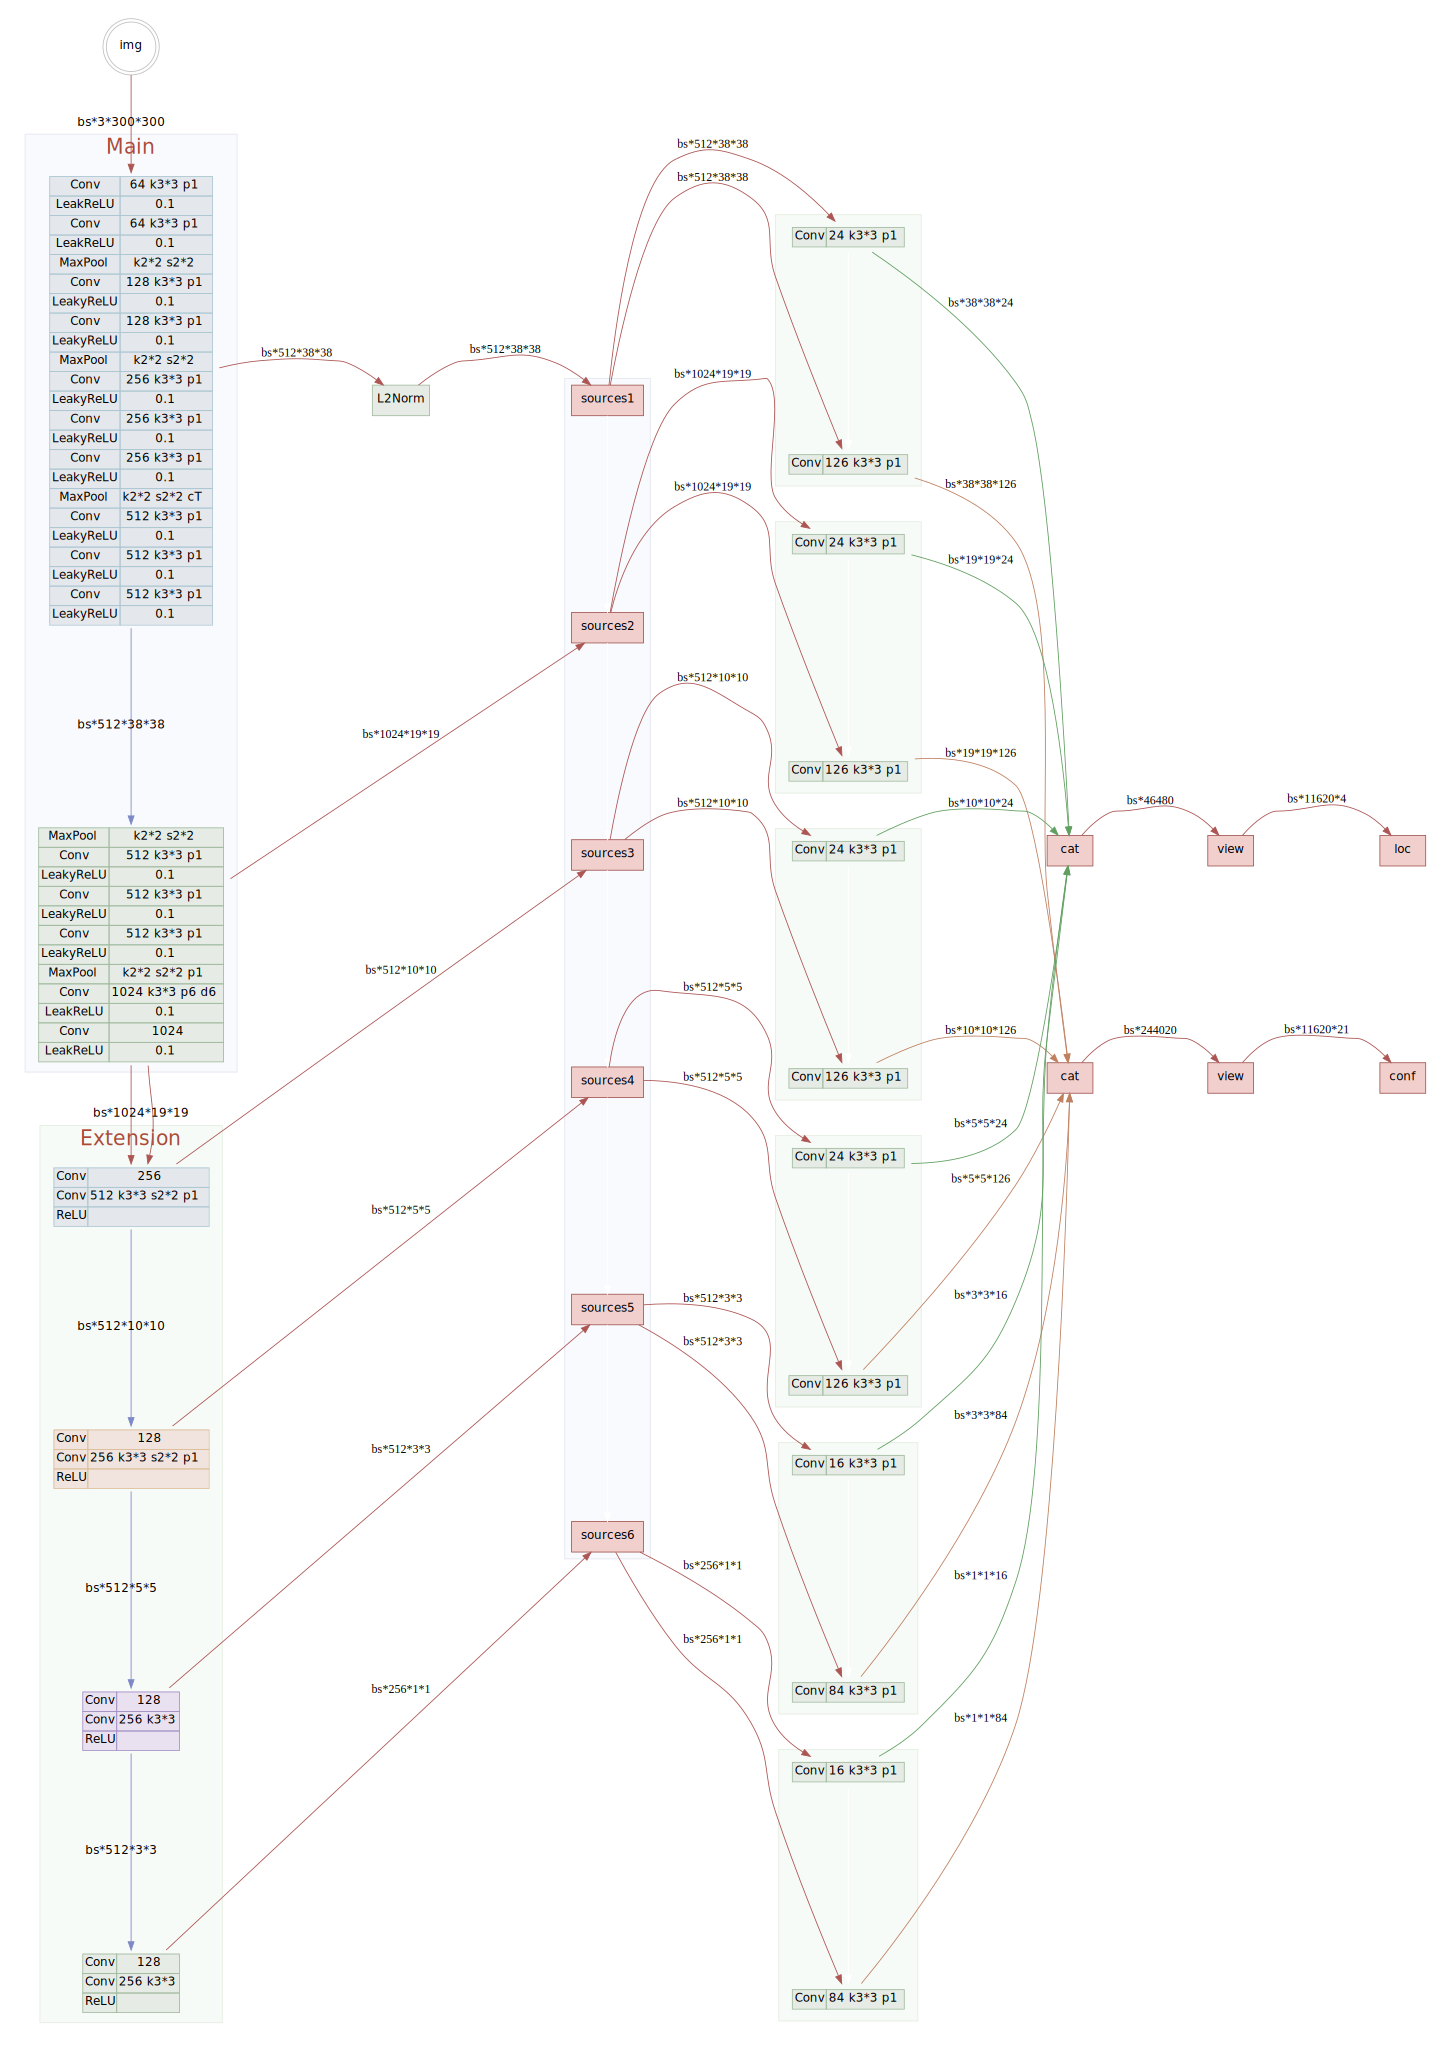

In [1]:
import graphviz

FONT_NAME = "Fira Code Retina"
graph = graphviz.Digraph(name="SSD", format='png', node_attr={'shape': 'plaintext'}, edge_attr = {"constraint":"false"})
graph.attr(rankdir="LR", ranksep="0.5", nodesep="0.8", pad="0.3")

with graph.subgraph(name="cluster1") as sub1:
    sub1.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node('block1', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2</td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2</td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2 cT</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block5', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>MaxPool</td><td>k2*2 s2*2</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>LeakyReLU</td><td>0.1</td></tr>
                    <tr><td>MaxPool</td><td>k2*2 s2*2 p1</td></tr>
                    <tr><td>Conv</td><td>1024 k3*3 p6 d6</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>LeakReLU</td><td>0.1</td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
    sub1.edge("block1", "block5", color="#7D88C7", label="bs*512*38*38", fontname=FONT_NAME)
    sub1.attr(label="Main", fontsize="24", fontcolor="#AA4936", fontname=FONT_NAME, nodesep="0.1")

graph.node('img', shape="doublecircle", color="grey", fontname=FONT_NAME)
graph.edge("img", "block1", label="bs*3*300*300", color="#AC5553", fontname=FONT_NAME)

with graph.subgraph(name="cluster2") as sub2:
    sub2.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block8', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>Conv</td><td>512 k3*3 s2*2 p1</td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block9', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>Conv</td><td>256 k3*3 s2*2 p1</td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block10', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                        <tr><td>Conv</td><td>128</td></tr>
                        <tr><td>Conv</td><td>256 k3*3</td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block11', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>Conv</td><td>256 k3*3</td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
    sub2.edge("block8", "block9", color="#7D88C7", label="bs*512*10*10", linewidth='10', fontname=FONT_NAME)
    sub2.edge("block9", "block10", color="#7D88C7", label="bs*512*5*5", fontname=FONT_NAME)
    sub2.edge("block10", "block11", color="#7D88C7", label="bs*512*3*3", fontname=FONT_NAME)
    sub2.attr(label="Extension", fontsize="24", fontcolor="#AA4936", fontname=FONT_NAME)

graph.edge("block5", "block8", color="#AC5553", label="bs*1024*19*19", fontname=FONT_NAME)

graph.node("L2Norm", shape="box", label="L2Norm", color="#A2BBA0", style="filled", fillcolor="#E6ECE5", fontname=FONT_NAME)
graph.node("T1", style="invis")
graph.edge("block1", "T1", constraint="true", style="invis")
graph.edge("T1", "L2Norm", constraint="true", style="invis")
graph.edge("block1", "L2Norm", color ="#AC5553", label="bs*512*38*38")

with graph.subgraph(name="cluster3") as sub3:
    sub3.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node("sources1", shape="box", label="sources1", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources2", shape="box", label="sources2", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources3", shape="box", label="sources3", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources4", shape="box", label="sources4", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources5", shape="box", label="sources5", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
        s.node("sources6", shape="box", label="sources6", color="#A25954", style="filled", fillcolor="#F1CFCD",
               fontname=FONT_NAME)
    sub3.edge("sources1", "sources2", color ="white")
    sub3.edge("sources2", "sources3", color ="white")
    sub3.edge("sources3", "sources4", color ="white")
    sub3.edge("sources4", "sources5", color ="white")
    sub3.edge("sources5", "sources6", color ="white")
graph.node("T2", style="invis")
graph.edge("L2Norm", "T2", constraint="true", style="invis")
graph.edge("T2", "sources1", constraint="true", style="invis")

graph.edge("L2Norm", "sources1", color ="#AC5553", label="bs*512*38*38")
graph.edge("block5", "sources2", color ="#AC5553", label="bs*1024*19*19")
graph.edge("block8", "sources3", color ="#AC5553", label="bs*512*10*10")
graph.edge("block9", "sources4", color ="#AC5553", label="bs*512*5*5")
graph.edge("block10", "sources5", color ="#AC5553", label="bs*512*3*3")
graph.edge("block11", "sources6", color ="#AC5553", label="bs*256*1*1")

with graph.subgraph(name="cluster4") as sub4:
    sub4.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block12', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block13', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub4.edge("block12", "block13", color="#FFFFFF")
graph.node("T3", style="invis")
graph.edge("sources1", "T3", constraint="true", style="invis")
graph.edge("T3", "block12", constraint="true", style="invis")
graph.edge("sources1", "block12", color ="#AC5553", label="bs*512*38*38")
graph.edge("sources1", "block13", color ="#AC5553", label="bs*512*38*38")

with graph.subgraph(name="cluster5") as sub5:
    sub5.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block14', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block15', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub5.edge("block14", "block15", color="#FFFFFF")
graph.node("T4", style="invis")
graph.edge("sources2", "T4", constraint="true", style="invis")
graph.edge("T4", "block14", constraint="true", style="invis")
graph.edge("sources2", "block14", color ="#AC5553", label="bs*1024*19*19")
graph.edge("sources2", "block15", color ="#AC5553", label="bs*1024*19*19")

with graph.subgraph(name="cluster6") as sub6:
    sub6.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block16', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block17', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub6.edge("block16", "block17", color="#FFFFFF")
graph.node("T5", style="invis")
graph.edge("sources3", "T5", constraint="true", style="invis")
graph.edge("T5", "block16", constraint="true", style="invis")
graph.edge("sources3", "block16", color ="#AC5553", label="bs*512*10*10")
graph.edge("sources3", "block17", color ="#AC5553", label="bs*512*10*10")

with graph.subgraph(name="cluster7") as sub7:
    sub7.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block18', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>24 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block19', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>126 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub7.edge("block18", "block19", color="#FFFFFF")
graph.node("T6", style="invis")
graph.edge("sources4", "T6", constraint="true", style="invis")
graph.edge("T6", "block18", constraint="true", style="invis")
graph.edge("sources4", "block18", color ="#AC5553", label="bs*512*5*5")
graph.edge("sources4", "block19", color ="#AC5553", label="bs*512*5*5")

with graph.subgraph(name="cluster8") as sub8:
    sub8.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block20', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>16 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block21', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>84 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub8.edge("block20", "block21", color="#FFFFFF")
graph.node("T7", style="invis")
graph.edge("sources5", "T7", constraint="true", style="invis")
graph.edge("T7", "block20", constraint="true", style="invis")
graph.edge("sources5", "block20", color ="#AC5553", label="bs*512*3*3")
graph.edge("sources5", "block21", color ="#AC5553", label="bs*512*3*3")

with graph.subgraph(name="cluster9") as sub9:
    sub9.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block22', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>16 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
        s.node('block23', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                        <tr><td>Conv</td><td>84 k3*3 p1</td></tr>
                        </table>
                        >''', fontname=FONT_NAME)
    sub9.edge("block22", "block23", color="#FFFFFF")
graph.node("T8", style="invis")
graph.edge("sources6", "T8", constraint="true", style="invis")
graph.edge("T8", "block22", constraint="true", style="invis")
graph.edge("sources6", "block22", color ="#AC5553", label="bs*256*1*1")
graph.edge("sources6", "block23", color ="#AC5553", label="bs*256*1*1")

graph.node("block24", shape="box", label="cat",color = "#A25954", style = "filled", fillcolor = "#F1CFCD", fontname=FONT_NAME)
graph.node("T9", style="invis")
graph.edge("block16", "T9", constraint="true", style="invis")
graph.edge("T9", "block24", constraint="true", style="invis")

graph.edge("block12", "block24", color="#609f60", label="bs*38*38*24")
graph.edge("block14", "block24", color="#609f60", label="bs*19*19*24")
graph.edge("block16", "block24", color="#609f60", label="bs*10*10*24")
graph.edge("block18", "block24", color="#609f60", label="bs*5*5*24")
graph.edge("block20", "block24", color="#609f60", label="bs*3*3*16")
graph.edge("block22", "block24", color="#609f60", label="bs*1*1*16")

graph.node("block25", shape="box", label="cat",color = "#A25954", style = "filled", fillcolor = "#F1CFCD", fontname=FONT_NAME)
graph.node("T10", style="invis")
graph.edge("block17", "T10", constraint="true", style="invis")
graph.edge("T10", "block25", constraint="true", style="invis")

graph.edge("block13", "block25", color="#BF8060", label="bs*38*38*126")
graph.edge("block15", "block25", color="#BF8060", label="bs*19*19*126")
graph.edge("block17", "block25", color="#BF8060", label="bs*10*10*126")
graph.edge("block19", "block25", color="#BF8060", label="bs*5*5*126")
graph.edge("block21", "block25", color="#BF8060", label="bs*3*3*84")
graph.edge("block23", "block25", color="#BF8060", label="bs*1*1*84")

graph.node("block26", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="view",    fontname=FONT_NAME)
graph.node("block27", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="view",    fontname=FONT_NAME)

graph.node("T11", style="invis")
graph.edge("block24", "T11", constraint="true", style="invis")
graph.edge("T11", "block26", constraint="true", style="invis")

graph.node("T12", style="invis")
graph.edge("block25", "T12", constraint="true", style="invis")
graph.edge("T12", "block27", constraint="true", style="invis")

graph.edge("block24", "block26", color="#AC5553", label="bs*46480")
graph.edge("block25", "block27", color="#AC5553", label="bs*244020")

graph.node("block28", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="loc",    fontname=FONT_NAME)
graph.node("block29", shape="box",color="#A25954",style="filled",fillcolor="#F1CFCD",label="conf",    fontname=FONT_NAME)


graph.node("T13", style="invis")
graph.edge("block26", "T13", constraint="true", style="invis")
graph.edge("T13", "block28", constraint="true", style="invis")

graph.node("T14", style="invis")
graph.edge("block27", "T14", constraint="true", style="invis")
graph.edge("T14", "block29", constraint="true", style="invis")

graph.edge("block26", "block28", color="#AC5553", label="bs*11620*4")
graph.edge("block27", "block29", color="#AC5553", label="bs*11620*21")

graph

对于主干网络(Main)来说，可以放入Vgg16，也可以放入Resnet等等网络。